# S-N-VAE Model Testing Framework

In [1]:
# Parameters cell for papermill
# This cell will be tagged as "parameters" to allow papermill to inject parameter values
# Default seed value - can be overridden by papermill execution
seed = 0

In [2]:
# Parameters
seed = 5


In [3]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /workspace/Disentanglement-Project-V2


# Hyperparameters

In [4]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed': seed,  # Use parameterized seed value
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}

##### Model parameters #####
model_name = 's_n_vae_locatello'  # S-N-VAE model with Locatello architecture
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder

# Define latent factor topologies: mix of Normal (R1) and Power Spherical (S1)
latent_factor_topologies = ['S1', 'R1', 'R1']  # 3 factors total

use_torch_compile = True  # Use torch.compile for model compilation

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 300

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'beta_s_n_vae'      # S-N-VAE Beta loss
loss_kwargs_dsprites = {
    'beta': 13,
    'latent_factor_topologies': latent_factor_topologies,
    'rec_dist': 'bernoulli',  # Reconstruction distribution
    'log_kl_components': True,
#     'schedulers_kwargs':[
#     {
#         'name': 'linear',
#         'kwargs': {
#             'param_name': 'beta',
#             'initial_value': 0,
#             'final_value': 16,
#             'total_steps': 100000
#         }
#     }
# ]
}

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps = 2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_s_n_vae'

chkpt_save_master_dir = None
chkpt_viz = False

Using GPU


# Reproducibility

In [5]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 5, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [6]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## Setup Model, Loss, and Optimizer

In [7]:
def setup_components(dataset, loss_kwargs, latent_factor_topologies):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate S-N-VAE Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_topologies=latent_factor_topologies,
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # Instantiate S-N-VAE Loss
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Latent factor topologies: {latent_factor_topologies}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Learning rate: {learning_rate}")

    return model, loss_fn, optimizer

# dSprites

In [8]:
# Load dSprites
Dsprites = get_dataset('dsprites')

# dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
dsprites_dataset = Dsprites(selected_factors=['posX', 'posY', 'orientation'], not_selected_factors_index_value={'scale':5, 'shape':0, 'color':0})

# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,  # Use parameterized seed value
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 40960 samples.


## Train

In [9]:
print("\n===== Training S-N-VAE on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, 
                                                                        loss_kwargs_dsprites,
                                                                        latent_factor_topologies
                                                                        )
trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training S-N-VAE on dSprites =====
--- Setup for DSprites --- 
Model: s_n_vae_locatello
Latent factor topologies: ['S1', 'R1', 'R1']
Loss: beta_s_n_vae (rec_dist=bernoulli), kwargs={'beta': 13, 'latent_factor_topologies': ['S1', 'R1', 'R1'], 'rec_dist': 'bernoulli', 'log_kl_components': True}
Optimizer: Adam
Learning rate: 0.0001


Training for 192000 iter, 300.00 epochs:   0%|                                             | 0/192000 [00:00<?, ?it/s]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 1/192000 [00:01<85:51:58,  1.61s/it]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 2/192000 [00:01<42:24:34,  1.26it/s]

Training for 192000 iter, 300.00 epochs:   0%|                                  | 36/192000 [00:01<1:35:12, 33.60it/s]

Training for 192000 iter, 300.00 epochs:   0%| | 36/192000 [00:01<1:35:12, 33.60it/s, epoch=0.08/300.00, iter=50/19200

Training for 192000 iter, 300.00 epochs:   0%| | 69/192000 [00:02<46:16, 69.13it/s, epoch=0.08/300.00, iter=50/192000,

Training for 192000 iter, 300.00 epochs:   0%| | 99/192000 [00:02<31:07, 102.76it/s, epoch=0.08/300.00, iter=50/192000

Training for 192000 iter, 300.00 epochs:   0%| | 99/192000 [00:02<31:07, 102.76it/s, epoch=0.16/300.00, iter=100/19200

Training for 192000 iter, 300.00 epochs:   0%| | 134/192000 [00:02<22:03, 144.92it/s, epoch=0.16/300.00, iter=100/1920

Training for 192000 iter, 300.00 epochs:   0%| | 134/192000 [00:02<22:03, 144.92it/s, epoch=0.23/300.00, iter=150/1920

Training for 192000 iter, 300.00 epochs:   0%| | 173/192000 [00:02<16:33, 193.13it/s, epoch=0.23/300.00, iter=150/1920

Training for 192000 iter, 300.00 epochs:   0%| | 173/192000 [00:02<16:33, 193.13it/s, epoch=0.31/300.00, iter=200/1920

Training for 192000 iter, 300.00 epochs:   0%| | 214/192000 [00:02<13:19, 239.81it/s, epoch=0.31/300.00, iter=200/1920

Training for 192000 iter, 300.00 epochs:   0%| | 214/192000 [00:02<13:19, 239.81it/s, epoch=0.39/300.00, iter=250/1920

Training for 192000 iter, 300.00 epochs:   0%| | 251/192000 [00:02<11:48, 270.80it/s, epoch=0.39/300.00, iter=250/1920

Training for 192000 iter, 300.00 epochs:   0%| | 287/192000 [00:02<11:05, 288.10it/s, epoch=0.39/300.00, iter=250/1920

Training for 192000 iter, 300.00 epochs:   0%| | 287/192000 [00:02<11:05, 288.10it/s, epoch=0.47/300.00, iter=300/1920

Training for 192000 iter, 300.00 epochs:   0%| | 327/192000 [00:02<10:07, 315.44it/s, epoch=0.47/300.00, iter=300/1920

Training for 192000 iter, 300.00 epochs:   0%| | 327/192000 [00:02<10:07, 315.44it/s, epoch=0.55/300.00, iter=350/1920

Training for 192000 iter, 300.00 epochs:   0%| | 367/192000 [00:02<09:27, 337.62it/s, epoch=0.55/300.00, iter=350/1920

Training for 192000 iter, 300.00 epochs:   0%| | 367/192000 [00:02<09:27, 337.62it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 407/192000 [00:02<09:02, 353.15it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 446/192000 [00:03<08:48, 362.29it/s, epoch=0.62/300.00, iter=400/1920

Training for 192000 iter, 300.00 epochs:   0%| | 446/192000 [00:03<08:48, 362.29it/s, epoch=0.70/300.00, iter=450/1920

Training for 192000 iter, 300.00 epochs:   0%| | 486/192000 [00:03<08:35, 371.31it/s, epoch=0.70/300.00, iter=450/1920

Training for 192000 iter, 300.00 epochs:   0%| | 486/192000 [00:03<08:35, 371.31it/s, epoch=0.78/300.00, iter=500/1920

Training for 192000 iter, 300.00 epochs:   0%| | 526/192000 [00:03<08:27, 377.51it/s, epoch=0.78/300.00, iter=500/1920

Training for 192000 iter, 300.00 epochs:   0%| | 526/192000 [00:03<08:27, 377.51it/s, epoch=0.86/300.00, iter=550/1920

Training for 192000 iter, 300.00 epochs:   0%| | 565/192000 [00:03<08:26, 377.66it/s, epoch=0.86/300.00, iter=550/1920

Training for 192000 iter, 300.00 epochs:   0%| | 565/192000 [00:03<08:26, 377.66it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 604/192000 [00:03<08:23, 380.02it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 643/192000 [00:03<08:35, 371.22it/s, epoch=0.94/300.00, iter=600/1920

Training for 192000 iter, 300.00 epochs:   0%| | 643/192000 [00:03<08:35, 371.22it/s, epoch=1.02/300.00, iter=650/1920

Training for 192000 iter, 300.00 epochs:   0%| | 681/192000 [00:03<08:34, 371.55it/s, epoch=1.02/300.00, iter=650/1920

Training for 192000 iter, 300.00 epochs:   0%| | 681/192000 [00:03<08:34, 371.55it/s, epoch=1.09/300.00, iter=700/1920

Training for 192000 iter, 300.00 epochs:   0%| | 719/192000 [00:03<09:29, 336.14it/s, epoch=1.09/300.00, iter=700/1920

Training for 192000 iter, 300.00 epochs:   0%| | 719/192000 [00:03<09:29, 336.14it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 755/192000 [00:03<09:20, 340.93it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 792/192000 [00:04<09:12, 346.19it/s, epoch=1.17/300.00, iter=750/1920

Training for 192000 iter, 300.00 epochs:   0%| | 792/192000 [00:04<09:12, 346.19it/s, epoch=1.25/300.00, iter=800/1920

Training for 192000 iter, 300.00 epochs:   0%| | 828/192000 [00:04<09:22, 340.02it/s, epoch=1.25/300.00, iter=800/1920

Training for 192000 iter, 300.00 epochs:   0%| | 828/192000 [00:04<09:22, 340.02it/s, epoch=1.33/300.00, iter=850/1920

Training for 192000 iter, 300.00 epochs:   0%| | 863/192000 [00:04<09:22, 339.62it/s, epoch=1.33/300.00, iter=850/1920

Training for 192000 iter, 300.00 epochs:   0%| | 863/192000 [00:04<09:22, 339.62it/s, epoch=1.41/300.00, iter=900/1920

Training for 192000 iter, 300.00 epochs:   0%| | 903/192000 [00:04<08:57, 355.64it/s, epoch=1.41/300.00, iter=900/1920

Training for 192000 iter, 300.00 epochs:   0%| | 943/192000 [00:04<08:39, 367.60it/s, epoch=1.41/300.00, iter=900/1920

Training for 192000 iter, 300.00 epochs:   0%| | 943/192000 [00:04<08:39, 367.60it/s, epoch=1.48/300.00, iter=950/1920

Training for 192000 iter, 300.00 epochs:   1%| | 982/192000 [00:04<08:31, 373.48it/s, epoch=1.48/300.00, iter=950/1920

Training for 192000 iter, 300.00 epochs:   1%| | 982/192000 [00:04<08:31, 373.48it/s, epoch=1.56/300.00, iter=1000/192

Training for 192000 iter, 300.00 epochs:   1%| | 1020/192000 [00:04<08:55, 356.35it/s, epoch=1.56/300.00, iter=1000/19

Training for 192000 iter, 300.00 epochs:   1%| | 1020/192000 [00:04<08:55, 356.35it/s, epoch=1.64/300.00, iter=1050/19

Training for 192000 iter, 300.00 epochs:   1%| | 1056/192000 [00:04<09:36, 331.20it/s, epoch=1.64/300.00, iter=1050/19

Training for 192000 iter, 300.00 epochs:   1%| | 1093/192000 [00:04<09:21, 339.75it/s, epoch=1.64/300.00, iter=1050/19

Training for 192000 iter, 300.00 epochs:   1%| | 1093/192000 [00:04<09:21, 339.75it/s, epoch=1.72/300.00, iter=1100/19

Training for 192000 iter, 300.00 epochs:   1%| | 1133/192000 [00:04<08:56, 355.70it/s, epoch=1.72/300.00, iter=1100/19

Training for 192000 iter, 300.00 epochs:   1%| | 1133/192000 [00:05<08:56, 355.70it/s, epoch=1.80/300.00, iter=1150/19

Training for 192000 iter, 300.00 epochs:   1%| | 1171/192000 [00:05<08:47, 361.99it/s, epoch=1.80/300.00, iter=1150/19

Training for 192000 iter, 300.00 epochs:   1%| | 1171/192000 [00:05<08:47, 361.99it/s, epoch=1.88/300.00, iter=1200/19

Training for 192000 iter, 300.00 epochs:   1%| | 1208/192000 [00:05<08:50, 359.33it/s, epoch=1.88/300.00, iter=1200/19

Training for 192000 iter, 300.00 epochs:   1%| | 1245/192000 [00:05<08:46, 362.17it/s, epoch=1.88/300.00, iter=1200/19

Training for 192000 iter, 300.00 epochs:   1%| | 1245/192000 [00:05<08:46, 362.17it/s, epoch=1.95/300.00, iter=1250/19

Training for 192000 iter, 300.00 epochs:   1%| | 1282/192000 [00:05<09:09, 347.31it/s, epoch=1.95/300.00, iter=1250/19

Training for 192000 iter, 300.00 epochs:   1%| | 1282/192000 [00:05<09:09, 347.31it/s, epoch=2.03/300.00, iter=1300/19

Training for 192000 iter, 300.00 epochs:   1%| | 1317/192000 [00:05<09:11, 346.06it/s, epoch=2.03/300.00, iter=1300/19

Training for 192000 iter, 300.00 epochs:   1%| | 1317/192000 [00:05<09:11, 346.06it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1358/192000 [00:05<08:46, 362.28it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1395/192000 [00:05<09:37, 330.02it/s, epoch=2.11/300.00, iter=1350/19

Training for 192000 iter, 300.00 epochs:   1%| | 1395/192000 [00:05<09:37, 330.02it/s, epoch=2.19/300.00, iter=1400/19

Training for 192000 iter, 300.00 epochs:   1%| | 1430/192000 [00:05<09:31, 333.35it/s, epoch=2.19/300.00, iter=1400/19

Training for 192000 iter, 300.00 epochs:   1%| | 1430/192000 [00:05<09:31, 333.35it/s, epoch=2.27/300.00, iter=1450/19

Training for 192000 iter, 300.00 epochs:   1%| | 1469/192000 [00:05<09:08, 347.39it/s, epoch=2.27/300.00, iter=1450/19

Training for 192000 iter, 300.00 epochs:   1%| | 1469/192000 [00:06<09:08, 347.39it/s, epoch=2.34/300.00, iter=1500/19

Training for 192000 iter, 300.00 epochs:   1%| | 1507/192000 [00:06<08:54, 356.42it/s, epoch=2.34/300.00, iter=1500/19

Training for 192000 iter, 300.00 epochs:   1%| | 1547/192000 [00:06<08:36, 368.63it/s, epoch=2.34/300.00, iter=1500/19

Training for 192000 iter, 300.00 epochs:   1%| | 1547/192000 [00:06<08:36, 368.63it/s, epoch=2.42/300.00, iter=1550/19

Training for 192000 iter, 300.00 epochs:   1%| | 1587/192000 [00:06<08:24, 377.32it/s, epoch=2.42/300.00, iter=1550/19

Training for 192000 iter, 300.00 epochs:   1%| | 1587/192000 [00:06<08:24, 377.32it/s, epoch=2.50/300.00, iter=1600/19

Training for 192000 iter, 300.00 epochs:   1%| | 1627/192000 [00:06<08:16, 383.25it/s, epoch=2.50/300.00, iter=1600/19

Training for 192000 iter, 300.00 epochs:   1%| | 1627/192000 [00:06<08:16, 383.25it/s, epoch=2.58/300.00, iter=1650/19

Training for 192000 iter, 300.00 epochs:   1%| | 1667/192000 [00:06<08:10, 388.03it/s, epoch=2.58/300.00, iter=1650/19

Training for 192000 iter, 300.00 epochs:   1%| | 1667/192000 [00:06<08:10, 388.03it/s, epoch=2.66/300.00, iter=1700/19

Training for 192000 iter, 300.00 epochs:   1%| | 1707/192000 [00:06<08:06, 391.03it/s, epoch=2.66/300.00, iter=1700/19

Training for 192000 iter, 300.00 epochs:   1%| | 1748/192000 [00:06<08:02, 394.32it/s, epoch=2.66/300.00, iter=1700/19

Training for 192000 iter, 300.00 epochs:   1%| | 1748/192000 [00:06<08:02, 394.32it/s, epoch=2.73/300.00, iter=1750/19

Training for 192000 iter, 300.00 epochs:   1%| | 1788/192000 [00:06<08:01, 394.87it/s, epoch=2.73/300.00, iter=1750/19

Training for 192000 iter, 300.00 epochs:   1%| | 1788/192000 [00:06<08:01, 394.87it/s, epoch=2.81/300.00, iter=1800/19

Training for 192000 iter, 300.00 epochs:   1%| | 1828/192000 [00:06<08:02, 393.92it/s, epoch=2.81/300.00, iter=1800/19

Training for 192000 iter, 300.00 epochs:   1%| | 1828/192000 [00:06<08:02, 393.92it/s, epoch=2.89/300.00, iter=1850/19

Training for 192000 iter, 300.00 epochs:   1%| | 1868/192000 [00:06<08:00, 395.39it/s, epoch=2.89/300.00, iter=1850/19

Training for 192000 iter, 300.00 epochs:   1%| | 1868/192000 [00:07<08:00, 395.39it/s, epoch=2.97/300.00, iter=1900/19

Training for 192000 iter, 300.00 epochs:   1%| | 1908/192000 [00:07<08:13, 385.35it/s, epoch=2.97/300.00, iter=1900/19

Training for 192000 iter, 300.00 epochs:   1%| | 1947/192000 [00:07<08:42, 363.88it/s, epoch=2.97/300.00, iter=1900/19

Training for 192000 iter, 300.00 epochs:   1%| | 1947/192000 [00:07<08:42, 363.88it/s, epoch=3.05/300.00, iter=1950/19

Training for 192000 iter, 300.00 epochs:   1%| | 1987/192000 [00:07<08:29, 372.98it/s, epoch=3.05/300.00, iter=1950/19

Training for 192000 iter, 300.00 epochs:   1%| | 1987/192000 [00:07<08:29, 372.98it/s, epoch=3.12/300.00, iter=2000/19

Training for 192000 iter, 300.00 epochs:   1%| | 2027/192000 [00:07<08:19, 380.28it/s, epoch=3.12/300.00, iter=2000/19

Training for 192000 iter, 300.00 epochs:   1%| | 2027/192000 [00:07<08:19, 380.28it/s, epoch=3.20/300.00, iter=2050/19

Training for 192000 iter, 300.00 epochs:   1%| | 2067/192000 [00:07<08:13, 385.11it/s, epoch=3.20/300.00, iter=2050/19

Training for 192000 iter, 300.00 epochs:   1%| | 2067/192000 [00:07<08:13, 385.11it/s, epoch=3.28/300.00, iter=2100/19

Training for 192000 iter, 300.00 epochs:   1%| | 2107/192000 [00:07<08:08, 388.34it/s, epoch=3.28/300.00, iter=2100/19

Training for 192000 iter, 300.00 epochs:   1%| | 2146/192000 [00:07<08:11, 386.08it/s, epoch=3.28/300.00, iter=2100/19

Training for 192000 iter, 300.00 epochs:   1%| | 2146/192000 [00:07<08:11, 386.08it/s, epoch=3.36/300.00, iter=2150/19

Training for 192000 iter, 300.00 epochs:   1%| | 2185/192000 [00:07<08:13, 384.39it/s, epoch=3.36/300.00, iter=2150/19

Training for 192000 iter, 300.00 epochs:   1%| | 2185/192000 [00:07<08:13, 384.39it/s, epoch=3.44/300.00, iter=2200/19

Training for 192000 iter, 300.00 epochs:   1%| | 2225/192000 [00:07<08:10, 386.87it/s, epoch=3.44/300.00, iter=2200/19

Training for 192000 iter, 300.00 epochs:   1%| | 2225/192000 [00:07<08:10, 386.87it/s, epoch=3.52/300.00, iter=2250/19

Training for 192000 iter, 300.00 epochs:   1%| | 2265/192000 [00:08<08:06, 390.13it/s, epoch=3.52/300.00, iter=2250/19

Training for 192000 iter, 300.00 epochs:   1%| | 2265/192000 [00:08<08:06, 390.13it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2305/192000 [00:08<08:02, 392.75it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2345/192000 [00:08<08:00, 394.60it/s, epoch=3.59/300.00, iter=2300/19

Training for 192000 iter, 300.00 epochs:   1%| | 2345/192000 [00:08<08:00, 394.60it/s, epoch=3.67/300.00, iter=2350/19

Training for 192000 iter, 300.00 epochs:   1%| | 2385/192000 [00:08<08:06, 389.97it/s, epoch=3.67/300.00, iter=2350/19

Training for 192000 iter, 300.00 epochs:   1%| | 2385/192000 [00:08<08:06, 389.97it/s, epoch=3.75/300.00, iter=2400/19

Training for 192000 iter, 300.00 epochs:   1%| | 2425/192000 [00:08<08:10, 386.26it/s, epoch=3.75/300.00, iter=2400/19

Training for 192000 iter, 300.00 epochs:   1%| | 2425/192000 [00:08<08:10, 386.26it/s, epoch=3.83/300.00, iter=2450/19

Training for 192000 iter, 300.00 epochs:   1%| | 2464/192000 [00:08<08:09, 387.02it/s, epoch=3.83/300.00, iter=2450/19

Training for 192000 iter, 300.00 epochs:   1%| | 2464/192000 [00:08<08:09, 387.02it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2505/192000 [00:08<08:04, 391.27it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2545/192000 [00:08<08:02, 392.70it/s, epoch=3.91/300.00, iter=2500/19

Training for 192000 iter, 300.00 epochs:   1%| | 2545/192000 [00:08<08:02, 392.70it/s, epoch=3.98/300.00, iter=2550/19

Training for 192000 iter, 300.00 epochs:   1%| | 2585/192000 [00:08<08:22, 376.71it/s, epoch=3.98/300.00, iter=2550/19

Training for 192000 iter, 300.00 epochs:   1%| | 2585/192000 [00:08<08:22, 376.71it/s, epoch=4.06/300.00, iter=2600/19

Training for 192000 iter, 300.00 epochs:   1%| | 2624/192000 [00:08<08:18, 380.09it/s, epoch=4.06/300.00, iter=2600/19

Training for 192000 iter, 300.00 epochs:   1%| | 2624/192000 [00:09<08:18, 380.09it/s, epoch=4.14/300.00, iter=2650/19

Training for 192000 iter, 300.00 epochs:   1%| | 2663/192000 [00:09<08:59, 351.05it/s, epoch=4.14/300.00, iter=2650/19

Training for 192000 iter, 300.00 epochs:   1%| | 2663/192000 [00:09<08:59, 351.05it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2703/192000 [00:09<08:40, 363.87it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2743/192000 [00:09<08:27, 372.91it/s, epoch=4.22/300.00, iter=2700/19

Training for 192000 iter, 300.00 epochs:   1%| | 2743/192000 [00:09<08:27, 372.91it/s, epoch=4.30/300.00, iter=2750/19

Training for 192000 iter, 300.00 epochs:   1%| | 2783/192000 [00:09<08:18, 379.33it/s, epoch=4.30/300.00, iter=2750/19

Training for 192000 iter, 300.00 epochs:   1%| | 2783/192000 [00:09<08:18, 379.33it/s, epoch=4.38/300.00, iter=2800/19

Training for 192000 iter, 300.00 epochs:   1%| | 2823/192000 [00:09<08:15, 381.90it/s, epoch=4.38/300.00, iter=2800/19

Training for 192000 iter, 300.00 epochs:   1%| | 2823/192000 [00:09<08:15, 381.90it/s, epoch=4.45/300.00, iter=2850/19

Training for 192000 iter, 300.00 epochs:   1%| | 2862/192000 [00:09<08:22, 376.08it/s, epoch=4.45/300.00, iter=2850/19

Training for 192000 iter, 300.00 epochs:   1%| | 2862/192000 [00:09<08:22, 376.08it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2901/192000 [00:09<08:18, 379.25it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2940/192000 [00:09<08:20, 378.02it/s, epoch=4.53/300.00, iter=2900/19

Training for 192000 iter, 300.00 epochs:   2%| | 2940/192000 [00:09<08:20, 378.02it/s, epoch=4.61/300.00, iter=2950/19

Training for 192000 iter, 300.00 epochs:   2%| | 2978/192000 [00:09<08:30, 370.54it/s, epoch=4.61/300.00, iter=2950/19

Training for 192000 iter, 300.00 epochs:   2%| | 2978/192000 [00:09<08:30, 370.54it/s, epoch=4.69/300.00, iter=3000/19

Training for 192000 iter, 300.00 epochs:   2%| | 3017/192000 [00:09<08:23, 375.14it/s, epoch=4.69/300.00, iter=3000/19

Training for 192000 iter, 300.00 epochs:   2%| | 3017/192000 [00:10<08:23, 375.14it/s, epoch=4.77/300.00, iter=3050/19

Training for 192000 iter, 300.00 epochs:   2%| | 3055/192000 [00:10<08:40, 362.72it/s, epoch=4.77/300.00, iter=3050/19

Training for 192000 iter, 300.00 epochs:   2%| | 3094/192000 [00:10<08:32, 368.91it/s, epoch=4.77/300.00, iter=3050/19

Training for 192000 iter, 300.00 epochs:   2%| | 3094/192000 [00:10<08:32, 368.91it/s, epoch=4.84/300.00, iter=3100/19

Training for 192000 iter, 300.00 epochs:   2%| | 3131/192000 [00:10<08:48, 357.64it/s, epoch=4.84/300.00, iter=3100/19

Training for 192000 iter, 300.00 epochs:   2%| | 3131/192000 [00:10<08:48, 357.64it/s, epoch=4.92/300.00, iter=3150/19

Training for 192000 iter, 300.00 epochs:   2%| | 3167/192000 [00:10<09:34, 328.56it/s, epoch=4.92/300.00, iter=3150/19

Training for 192000 iter, 300.00 epochs:   2%| | 3167/192000 [00:10<09:34, 328.56it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3202/192000 [00:10<09:27, 332.76it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3236/192000 [00:10<10:03, 312.65it/s, epoch=5.00/300.00, iter=3200/19

Training for 192000 iter, 300.00 epochs:   2%| | 3236/192000 [00:10<10:03, 312.65it/s, epoch=5.08/300.00, iter=3250/19

Training for 192000 iter, 300.00 epochs:   2%| | 3268/192000 [00:10<10:02, 313.43it/s, epoch=5.08/300.00, iter=3250/19

Training for 192000 iter, 300.00 epochs:   2%| | 3268/192000 [00:10<10:02, 313.43it/s, epoch=5.16/300.00, iter=3300/19

Training for 192000 iter, 300.00 epochs:   2%| | 3307/192000 [00:10<09:25, 333.38it/s, epoch=5.16/300.00, iter=3300/19

Training for 192000 iter, 300.00 epochs:   2%| | 3346/192000 [00:10<09:01, 348.50it/s, epoch=5.16/300.00, iter=3300/19

Training for 192000 iter, 300.00 epochs:   2%| | 3346/192000 [00:10<09:01, 348.50it/s, epoch=5.23/300.00, iter=3350/19

Training for 192000 iter, 300.00 epochs:   2%| | 3386/192000 [00:11<08:42, 360.97it/s, epoch=5.23/300.00, iter=3350/19

Training for 192000 iter, 300.00 epochs:   2%| | 3386/192000 [00:11<08:42, 360.97it/s, epoch=5.31/300.00, iter=3400/19

Training for 192000 iter, 300.00 epochs:   2%| | 3426/192000 [00:11<08:27, 371.30it/s, epoch=5.31/300.00, iter=3400/19

Training for 192000 iter, 300.00 epochs:   2%| | 3426/192000 [00:11<08:27, 371.30it/s, epoch=5.39/300.00, iter=3450/19

Training for 192000 iter, 300.00 epochs:   2%| | 3464/192000 [00:11<09:00, 348.98it/s, epoch=5.39/300.00, iter=3450/19

Training for 192000 iter, 300.00 epochs:   2%| | 3464/192000 [00:11<09:00, 348.98it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3503/192000 [00:11<08:43, 360.07it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3543/192000 [00:11<08:31, 368.78it/s, epoch=5.47/300.00, iter=3500/19

Training for 192000 iter, 300.00 epochs:   2%| | 3543/192000 [00:11<08:31, 368.78it/s, epoch=5.55/300.00, iter=3550/19

Training for 192000 iter, 300.00 epochs:   2%| | 3581/192000 [00:11<08:36, 364.86it/s, epoch=5.55/300.00, iter=3550/19

Training for 192000 iter, 300.00 epochs:   2%| | 3581/192000 [00:11<08:36, 364.86it/s, epoch=5.62/300.00, iter=3600/19

Training for 192000 iter, 300.00 epochs:   2%| | 3619/192000 [00:11<08:32, 367.57it/s, epoch=5.62/300.00, iter=3600/19

Training for 192000 iter, 300.00 epochs:   2%| | 3619/192000 [00:11<08:32, 367.57it/s, epoch=5.70/300.00, iter=3650/19

Training for 192000 iter, 300.00 epochs:   2%| | 3660/192000 [00:11<08:18, 377.58it/s, epoch=5.70/300.00, iter=3650/19

Training for 192000 iter, 300.00 epochs:   2%| | 3660/192000 [00:11<08:18, 377.58it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3701/192000 [00:11<08:08, 385.17it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3740/192000 [00:12<08:12, 382.00it/s, epoch=5.78/300.00, iter=3700/19

Training for 192000 iter, 300.00 epochs:   2%| | 3740/192000 [00:12<08:12, 382.00it/s, epoch=5.86/300.00, iter=3750/19

Training for 192000 iter, 300.00 epochs:   2%| | 3780/192000 [00:12<08:06, 387.08it/s, epoch=5.86/300.00, iter=3750/19

Training for 192000 iter, 300.00 epochs:   2%| | 3780/192000 [00:12<08:06, 387.08it/s, epoch=5.94/300.00, iter=3800/19

Training for 192000 iter, 300.00 epochs:   2%| | 3820/192000 [00:12<08:02, 390.29it/s, epoch=5.94/300.00, iter=3800/19

Training for 192000 iter, 300.00 epochs:   2%| | 3820/192000 [00:12<08:02, 390.29it/s, epoch=6.02/300.00, iter=3850/19

Training for 192000 iter, 300.00 epochs:   2%| | 3860/192000 [00:12<08:23, 373.57it/s, epoch=6.02/300.00, iter=3850/19

Training for 192000 iter, 300.00 epochs:   2%| | 3898/192000 [00:12<08:54, 352.18it/s, epoch=6.02/300.00, iter=3850/19

Training for 192000 iter, 300.00 epochs:   2%| | 3898/192000 [00:12<08:54, 352.18it/s, epoch=6.09/300.00, iter=3900/19

Training for 192000 iter, 300.00 epochs:   2%| | 3934/192000 [00:12<09:11, 340.77it/s, epoch=6.09/300.00, iter=3900/19

Training for 192000 iter, 300.00 epochs:   2%| | 3934/192000 [00:12<09:11, 340.77it/s, epoch=6.17/300.00, iter=3950/19

Training for 192000 iter, 300.00 epochs:   2%| | 3973/192000 [00:12<08:53, 352.17it/s, epoch=6.17/300.00, iter=3950/19

Training for 192000 iter, 300.00 epochs:   2%| | 3973/192000 [00:12<08:53, 352.17it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4012/192000 [00:12<08:39, 362.12it/s, epoch=6.25/300.00, iter=4000/19

Training for 192000 iter, 300.00 epochs:   2%| | 4012/192000 [00:12<08:39, 362.12it/s, epoch=6.33/300.00, iter=4050/19

Training for 192000 iter, 300.00 epochs:   2%| | 4051/192000 [00:12<08:29, 368.84it/s, epoch=6.33/300.00, iter=4050/19

Training for 192000 iter, 300.00 epochs:   2%| | 4092/192000 [00:12<08:16, 378.35it/s, epoch=6.33/300.00, iter=4050/19

Training for 192000 iter, 300.00 epochs:   2%| | 4092/192000 [00:13<08:16, 378.35it/s, epoch=6.41/300.00, iter=4100/19

Training for 192000 iter, 300.00 epochs:   2%| | 4131/192000 [00:13<08:13, 380.49it/s, epoch=6.41/300.00, iter=4100/19

Training for 192000 iter, 300.00 epochs:   2%| | 4131/192000 [00:13<08:13, 380.49it/s, epoch=6.48/300.00, iter=4150/19

Training for 192000 iter, 300.00 epochs:   2%| | 4171/192000 [00:13<08:08, 384.74it/s, epoch=6.48/300.00, iter=4150/19

Training for 192000 iter, 300.00 epochs:   2%| | 4171/192000 [00:13<08:08, 384.74it/s, epoch=6.56/300.00, iter=4200/19

Training for 192000 iter, 300.00 epochs:   2%| | 4211/192000 [00:13<08:04, 387.44it/s, epoch=6.56/300.00, iter=4200/19

Training for 192000 iter, 300.00 epochs:   2%| | 4211/192000 [00:13<08:04, 387.44it/s, epoch=6.64/300.00, iter=4250/19

Training for 192000 iter, 300.00 epochs:   2%| | 4251/192000 [00:13<08:01, 390.05it/s, epoch=6.64/300.00, iter=4250/19

Training for 192000 iter, 300.00 epochs:   2%| | 4292/192000 [00:13<07:56, 393.71it/s, epoch=6.64/300.00, iter=4250/19

Training for 192000 iter, 300.00 epochs:   2%| | 4292/192000 [00:13<07:56, 393.71it/s, epoch=6.72/300.00, iter=4300/19

Training for 192000 iter, 300.00 epochs:   2%| | 4332/192000 [00:13<07:54, 395.45it/s, epoch=6.72/300.00, iter=4300/19

Training for 192000 iter, 300.00 epochs:   2%| | 4332/192000 [00:13<07:54, 395.45it/s, epoch=6.80/300.00, iter=4350/19

Training for 192000 iter, 300.00 epochs:   2%| | 4373/192000 [00:13<07:52, 396.80it/s, epoch=6.80/300.00, iter=4350/19

Training for 192000 iter, 300.00 epochs:   2%| | 4373/192000 [00:13<07:52, 396.80it/s, epoch=6.88/300.00, iter=4400/19

Training for 192000 iter, 300.00 epochs:   2%| | 4413/192000 [00:13<07:53, 396.23it/s, epoch=6.88/300.00, iter=4400/19

Training for 192000 iter, 300.00 epochs:   2%| | 4413/192000 [00:13<07:53, 396.23it/s, epoch=6.95/300.00, iter=4450/19

Training for 192000 iter, 300.00 epochs:   2%| | 4453/192000 [00:13<07:55, 394.56it/s, epoch=6.95/300.00, iter=4450/19

Training for 192000 iter, 300.00 epochs:   2%| | 4493/192000 [00:14<08:11, 381.32it/s, epoch=6.95/300.00, iter=4450/19

Training for 192000 iter, 300.00 epochs:   2%| | 4493/192000 [00:14<08:11, 381.32it/s, epoch=7.03/300.00, iter=4500/19

Training for 192000 iter, 300.00 epochs:   2%| | 4532/192000 [00:14<08:11, 381.58it/s, epoch=7.03/300.00, iter=4500/19

Training for 192000 iter, 300.00 epochs:   2%| | 4532/192000 [00:14<08:11, 381.58it/s, epoch=7.11/300.00, iter=4550/19

Training for 192000 iter, 300.00 epochs:   2%| | 4572/192000 [00:14<08:06, 385.45it/s, epoch=7.11/300.00, iter=4550/19

Training for 192000 iter, 300.00 epochs:   2%| | 4572/192000 [00:14<08:06, 385.45it/s, epoch=7.19/300.00, iter=4600/19

Training for 192000 iter, 300.00 epochs:   2%| | 4612/192000 [00:14<08:02, 388.54it/s, epoch=7.19/300.00, iter=4600/19

Training for 192000 iter, 300.00 epochs:   2%| | 4612/192000 [00:14<08:02, 388.54it/s, epoch=7.27/300.00, iter=4650/19

Training for 192000 iter, 300.00 epochs:   2%| | 4652/192000 [00:14<08:01, 389.48it/s, epoch=7.27/300.00, iter=4650/19

Training for 192000 iter, 300.00 epochs:   2%| | 4692/192000 [00:14<07:59, 390.53it/s, epoch=7.27/300.00, iter=4650/19

Training for 192000 iter, 300.00 epochs:   2%| | 4692/192000 [00:14<07:59, 390.53it/s, epoch=7.34/300.00, iter=4700/19

Training for 192000 iter, 300.00 epochs:   2%| | 4732/192000 [00:14<08:00, 389.81it/s, epoch=7.34/300.00, iter=4700/19

Training for 192000 iter, 300.00 epochs:   2%| | 4732/192000 [00:14<08:00, 389.81it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4772/192000 [00:14<07:59, 390.30it/s, epoch=7.42/300.00, iter=4750/19

Training for 192000 iter, 300.00 epochs:   2%| | 4772/192000 [00:14<07:59, 390.30it/s, epoch=7.50/300.00, iter=4800/19

Training for 192000 iter, 300.00 epochs:   3%| | 4812/192000 [00:14<08:00, 389.79it/s, epoch=7.50/300.00, iter=4800/19

Training for 192000 iter, 300.00 epochs:   3%| | 4812/192000 [00:14<08:00, 389.79it/s, epoch=7.58/300.00, iter=4850/19

Training for 192000 iter, 300.00 epochs:   3%| | 4851/192000 [00:14<08:02, 388.10it/s, epoch=7.58/300.00, iter=4850/19

Training for 192000 iter, 300.00 epochs:   3%| | 4890/192000 [00:15<08:19, 374.31it/s, epoch=7.58/300.00, iter=4850/19

Training for 192000 iter, 300.00 epochs:   3%| | 4890/192000 [00:15<08:19, 374.31it/s, epoch=7.66/300.00, iter=4900/19

Training for 192000 iter, 300.00 epochs:   3%| | 4930/192000 [00:15<08:11, 380.78it/s, epoch=7.66/300.00, iter=4900/19

Training for 192000 iter, 300.00 epochs:   3%| | 4930/192000 [00:15<08:11, 380.78it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4970/192000 [00:15<08:05, 385.16it/s, epoch=7.73/300.00, iter=4950/19

Training for 192000 iter, 300.00 epochs:   3%| | 4970/192000 [00:15<08:05, 385.16it/s, epoch=7.81/300.00, iter=5000/19

Training for 192000 iter, 300.00 epochs:   3%| | 5010/192000 [00:15<08:01, 388.49it/s, epoch=7.81/300.00, iter=5000/19

Training for 192000 iter, 300.00 epochs:   3%| | 5010/192000 [00:15<08:01, 388.49it/s, epoch=7.89/300.00, iter=5050/19

Training for 192000 iter, 300.00 epochs:   3%| | 5050/192000 [00:15<07:59, 389.71it/s, epoch=7.89/300.00, iter=5050/19

Training for 192000 iter, 300.00 epochs:   3%| | 5090/192000 [00:15<07:57, 391.03it/s, epoch=7.89/300.00, iter=5050/19

Training for 192000 iter, 300.00 epochs:   3%| | 5090/192000 [00:15<07:57, 391.03it/s, epoch=7.97/300.00, iter=5100/19

Training for 192000 iter, 300.00 epochs:   3%| | 5130/192000 [00:15<08:22, 372.22it/s, epoch=7.97/300.00, iter=5100/19

Training for 192000 iter, 300.00 epochs:   3%| | 5130/192000 [00:15<08:22, 372.22it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5168/192000 [00:15<10:50, 287.23it/s, epoch=8.05/300.00, iter=5150/19

Training for 192000 iter, 300.00 epochs:   3%| | 5168/192000 [00:15<10:50, 287.23it/s, epoch=8.12/300.00, iter=5200/19

Training for 192000 iter, 300.00 epochs:   3%| | 5200/192000 [00:15<10:58, 283.55it/s, epoch=8.12/300.00, iter=5200/19

Training for 192000 iter, 300.00 epochs:   3%| | 5236/192000 [00:16<10:20, 301.05it/s, epoch=8.12/300.00, iter=5200/19

Training for 192000 iter, 300.00 epochs:   3%| | 5236/192000 [00:16<10:20, 301.05it/s, epoch=8.20/300.00, iter=5250/19

Training for 192000 iter, 300.00 epochs:   3%| | 5274/192000 [00:16<09:42, 320.34it/s, epoch=8.20/300.00, iter=5250/19

Training for 192000 iter, 300.00 epochs:   3%| | 5274/192000 [00:16<09:42, 320.34it/s, epoch=8.28/300.00, iter=5300/19

Training for 192000 iter, 300.00 epochs:   3%| | 5315/192000 [00:16<09:04, 342.77it/s, epoch=8.28/300.00, iter=5300/19

Training for 192000 iter, 300.00 epochs:   3%| | 5315/192000 [00:16<09:04, 342.77it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5356/192000 [00:16<08:38, 360.18it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5397/192000 [00:16<08:20, 373.19it/s, epoch=8.36/300.00, iter=5350/19

Training for 192000 iter, 300.00 epochs:   3%| | 5397/192000 [00:16<08:20, 373.19it/s, epoch=8.44/300.00, iter=5400/19

Training for 192000 iter, 300.00 epochs:   3%| | 5438/192000 [00:16<08:08, 382.16it/s, epoch=8.44/300.00, iter=5400/19

Training for 192000 iter, 300.00 epochs:   3%| | 5438/192000 [00:16<08:08, 382.16it/s, epoch=8.52/300.00, iter=5450/19

Training for 192000 iter, 300.00 epochs:   3%| | 5479/192000 [00:16<08:00, 388.54it/s, epoch=8.52/300.00, iter=5450/19

Training for 192000 iter, 300.00 epochs:   3%| | 5479/192000 [00:16<08:00, 388.54it/s, epoch=8.59/300.00, iter=5500/19

Training for 192000 iter, 300.00 epochs:   3%| | 5519/192000 [00:16<07:56, 391.05it/s, epoch=8.59/300.00, iter=5500/19

Training for 192000 iter, 300.00 epochs:   3%| | 5519/192000 [00:16<07:56, 391.05it/s, epoch=8.67/300.00, iter=5550/19

Training for 192000 iter, 300.00 epochs:   3%| | 5560/192000 [00:16<07:53, 393.87it/s, epoch=8.67/300.00, iter=5550/19

Training for 192000 iter, 300.00 epochs:   3%| | 5560/192000 [00:17<07:53, 393.87it/s, epoch=8.75/300.00, iter=5600/19

Training for 192000 iter, 300.00 epochs:   3%| | 5600/192000 [00:17<08:02, 386.22it/s, epoch=8.75/300.00, iter=5600/19

Training for 192000 iter, 300.00 epochs:   3%| | 5639/192000 [00:17<08:01, 386.79it/s, epoch=8.75/300.00, iter=5600/19

Training for 192000 iter, 300.00 epochs:   3%| | 5639/192000 [00:17<08:01, 386.79it/s, epoch=8.83/300.00, iter=5650/19

Training for 192000 iter, 300.00 epochs:   3%| | 5679/192000 [00:17<07:59, 388.59it/s, epoch=8.83/300.00, iter=5650/19

Training for 192000 iter, 300.00 epochs:   3%| | 5679/192000 [00:17<07:59, 388.59it/s, epoch=8.91/300.00, iter=5700/19

Training for 192000 iter, 300.00 epochs:   3%| | 5718/192000 [00:17<08:01, 387.09it/s, epoch=8.91/300.00, iter=5700/19

Training for 192000 iter, 300.00 epochs:   3%| | 5718/192000 [00:17<08:01, 387.09it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5759/192000 [00:17<07:55, 391.36it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5799/192000 [00:17<08:07, 381.57it/s, epoch=8.98/300.00, iter=5750/19

Training for 192000 iter, 300.00 epochs:   3%| | 5799/192000 [00:17<08:07, 381.57it/s, epoch=9.06/300.00, iter=5800/19

Training for 192000 iter, 300.00 epochs:   3%| | 5839/192000 [00:17<08:03, 385.33it/s, epoch=9.06/300.00, iter=5800/19

Training for 192000 iter, 300.00 epochs:   3%| | 5839/192000 [00:17<08:03, 385.33it/s, epoch=9.14/300.00, iter=5850/19

Training for 192000 iter, 300.00 epochs:   3%| | 5880/192000 [00:17<07:56, 390.92it/s, epoch=9.14/300.00, iter=5850/19

Training for 192000 iter, 300.00 epochs:   3%| | 5880/192000 [00:17<07:56, 390.92it/s, epoch=9.22/300.00, iter=5900/19

Training for 192000 iter, 300.00 epochs:   3%| | 5920/192000 [00:17<07:54, 391.80it/s, epoch=9.22/300.00, iter=5900/19

Training for 192000 iter, 300.00 epochs:   3%| | 5920/192000 [00:17<07:54, 391.80it/s, epoch=9.30/300.00, iter=5950/19

Training for 192000 iter, 300.00 epochs:   3%| | 5961/192000 [00:17<07:51, 394.78it/s, epoch=9.30/300.00, iter=5950/19

Training for 192000 iter, 300.00 epochs:   3%| | 5961/192000 [00:18<07:51, 394.78it/s, epoch=9.38/300.00, iter=6000/19

Training for 192000 iter, 300.00 epochs:   3%| | 6001/192000 [00:18<07:49, 396.15it/s, epoch=9.38/300.00, iter=6000/19

Training for 192000 iter, 300.00 epochs:   3%| | 6041/192000 [00:18<07:48, 397.18it/s, epoch=9.38/300.00, iter=6000/19

Training for 192000 iter, 300.00 epochs:   3%| | 6041/192000 [00:18<07:48, 397.18it/s, epoch=9.45/300.00, iter=6050/19

Training for 192000 iter, 300.00 epochs:   3%| | 6081/192000 [00:18<07:47, 397.73it/s, epoch=9.45/300.00, iter=6050/19

Training for 192000 iter, 300.00 epochs:   3%| | 6081/192000 [00:18<07:47, 397.73it/s, epoch=9.53/300.00, iter=6100/19

Training for 192000 iter, 300.00 epochs:   3%| | 6121/192000 [00:18<07:47, 397.89it/s, epoch=9.53/300.00, iter=6100/19

Training for 192000 iter, 300.00 epochs:   3%| | 6121/192000 [00:18<07:47, 397.89it/s, epoch=9.61/300.00, iter=6150/19

Training for 192000 iter, 300.00 epochs:   3%| | 6162/192000 [00:18<07:45, 399.19it/s, epoch=9.61/300.00, iter=6150/19

Training for 192000 iter, 300.00 epochs:   3%| | 6162/192000 [00:18<07:45, 399.19it/s, epoch=9.69/300.00, iter=6200/19

Training for 192000 iter, 300.00 epochs:   3%| | 6202/192000 [00:18<07:58, 388.64it/s, epoch=9.69/300.00, iter=6200/19

Training for 192000 iter, 300.00 epochs:   3%| | 6243/192000 [00:18<07:52, 392.76it/s, epoch=9.69/300.00, iter=6200/19

Training for 192000 iter, 300.00 epochs:   3%| | 6243/192000 [00:18<07:52, 392.76it/s, epoch=9.77/300.00, iter=6250/19

Training for 192000 iter, 300.00 epochs:   3%| | 6283/192000 [00:18<08:08, 380.09it/s, epoch=9.77/300.00, iter=6250/19

Training for 192000 iter, 300.00 epochs:   3%| | 6283/192000 [00:18<08:08, 380.09it/s, epoch=9.84/300.00, iter=6300/19

Training for 192000 iter, 300.00 epochs:   3%| | 6323/192000 [00:18<08:03, 384.21it/s, epoch=9.84/300.00, iter=6300/19

Training for 192000 iter, 300.00 epochs:   3%| | 6323/192000 [00:18<08:03, 384.21it/s, epoch=9.92/300.00, iter=6350/19

Training for 192000 iter, 300.00 epochs:   3%| | 6364/192000 [00:18<07:55, 390.71it/s, epoch=9.92/300.00, iter=6350/19

Training for 192000 iter, 300.00 epochs:   3%| | 6364/192000 [00:19<07:55, 390.71it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6404/192000 [00:19<08:22, 369.42it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6445/192000 [00:19<08:09, 379.30it/s, epoch=10.00/300.00, iter=6400/1

Training for 192000 iter, 300.00 epochs:   3%| | 6445/192000 [00:19<08:09, 379.30it/s, epoch=10.08/300.00, iter=6450/1

Training for 192000 iter, 300.00 epochs:   3%| | 6484/192000 [00:19<08:08, 379.50it/s, epoch=10.08/300.00, iter=6450/1

Training for 192000 iter, 300.00 epochs:   3%| | 6484/192000 [00:19<08:08, 379.50it/s, epoch=10.16/300.00, iter=6500/1

Training for 192000 iter, 300.00 epochs:   3%| | 6524/192000 [00:19<08:01, 385.39it/s, epoch=10.16/300.00, iter=6500/1

Training for 192000 iter, 300.00 epochs:   3%| | 6524/192000 [00:19<08:01, 385.39it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6564/192000 [00:19<07:56, 389.04it/s, epoch=10.23/300.00, iter=6550/1

Training for 192000 iter, 300.00 epochs:   3%| | 6564/192000 [00:19<07:56, 389.04it/s, epoch=10.31/300.00, iter=6600/1

Training for 192000 iter, 300.00 epochs:   3%| | 6604/192000 [00:19<07:54, 390.81it/s, epoch=10.31/300.00, iter=6600/1

Training for 192000 iter, 300.00 epochs:   3%| | 6645/192000 [00:19<07:49, 394.60it/s, epoch=10.31/300.00, iter=6600/1

Training for 192000 iter, 300.00 epochs:   3%| | 6645/192000 [00:19<07:49, 394.60it/s, epoch=10.39/300.00, iter=6650/1

Training for 192000 iter, 300.00 epochs:   3%| | 6685/192000 [00:19<07:47, 396.06it/s, epoch=10.39/300.00, iter=6650/1

Training for 192000 iter, 300.00 epochs:   3%| | 6685/192000 [00:19<07:47, 396.06it/s, epoch=10.47/300.00, iter=6700/1

Training for 192000 iter, 300.00 epochs:   4%| | 6725/192000 [00:19<08:00, 385.71it/s, epoch=10.47/300.00, iter=6700/1

Training for 192000 iter, 300.00 epochs:   4%| | 6725/192000 [00:19<08:00, 385.71it/s, epoch=10.55/300.00, iter=6750/1

Training for 192000 iter, 300.00 epochs:   4%| | 6765/192000 [00:20<07:56, 388.66it/s, epoch=10.55/300.00, iter=6750/1

Training for 192000 iter, 300.00 epochs:   4%| | 6765/192000 [00:20<07:56, 388.66it/s, epoch=10.62/300.00, iter=6800/1

Training for 192000 iter, 300.00 epochs:   4%| | 6805/192000 [00:20<07:53, 390.88it/s, epoch=10.62/300.00, iter=6800/1

Training for 192000 iter, 300.00 epochs:   4%| | 6845/192000 [00:20<07:50, 393.50it/s, epoch=10.62/300.00, iter=6800/1

Training for 192000 iter, 300.00 epochs:   4%| | 6845/192000 [00:20<07:50, 393.50it/s, epoch=10.70/300.00, iter=6850/1

Training for 192000 iter, 300.00 epochs:   4%| | 6885/192000 [00:20<07:50, 393.57it/s, epoch=10.70/300.00, iter=6850/1

Training for 192000 iter, 300.00 epochs:   4%| | 6885/192000 [00:20<07:50, 393.57it/s, epoch=10.78/300.00, iter=6900/1

Training for 192000 iter, 300.00 epochs:   4%| | 6925/192000 [00:20<07:50, 393.19it/s, epoch=10.78/300.00, iter=6900/1

Training for 192000 iter, 300.00 epochs:   4%| | 6925/192000 [00:20<07:50, 393.19it/s, epoch=10.86/300.00, iter=6950/1

Training for 192000 iter, 300.00 epochs:   4%| | 6965/192000 [00:20<07:51, 392.64it/s, epoch=10.86/300.00, iter=6950/1

Training for 192000 iter, 300.00 epochs:   4%| | 6965/192000 [00:20<07:51, 392.64it/s, epoch=10.94/300.00, iter=7000/1

Training for 192000 iter, 300.00 epochs:   4%| | 7005/192000 [00:20<07:49, 394.04it/s, epoch=10.94/300.00, iter=7000/1

Training for 192000 iter, 300.00 epochs:   4%| | 7045/192000 [00:20<08:06, 380.51it/s, epoch=10.94/300.00, iter=7000/1

Training for 192000 iter, 300.00 epochs:   4%| | 7045/192000 [00:20<08:06, 380.51it/s, epoch=11.02/300.00, iter=7050/1

Training for 192000 iter, 300.00 epochs:   4%| | 7084/192000 [00:20<08:27, 364.41it/s, epoch=11.02/300.00, iter=7050/1

Training for 192000 iter, 300.00 epochs:   4%| | 7084/192000 [00:20<08:27, 364.41it/s, epoch=11.09/300.00, iter=7100/1

Training for 192000 iter, 300.00 epochs:   4%| | 7123/192000 [00:20<08:20, 369.57it/s, epoch=11.09/300.00, iter=7100/1

Training for 192000 iter, 300.00 epochs:   4%| | 7123/192000 [00:21<08:20, 369.57it/s, epoch=11.17/300.00, iter=7150/1

Training for 192000 iter, 300.00 epochs:   4%| | 7164/192000 [00:21<08:07, 379.08it/s, epoch=11.17/300.00, iter=7150/1

Training for 192000 iter, 300.00 epochs:   4%| | 7164/192000 [00:21<08:07, 379.08it/s, epoch=11.25/300.00, iter=7200/1

Training for 192000 iter, 300.00 epochs:   4%| | 7205/192000 [00:21<07:58, 386.14it/s, epoch=11.25/300.00, iter=7200/1

Training for 192000 iter, 300.00 epochs:   4%| | 7246/192000 [00:21<07:52, 391.01it/s, epoch=11.25/300.00, iter=7200/1

Training for 192000 iter, 300.00 epochs:   4%| | 7246/192000 [00:21<07:52, 391.01it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7287/192000 [00:21<07:48, 393.98it/s, epoch=11.33/300.00, iter=7250/1

Training for 192000 iter, 300.00 epochs:   4%| | 7287/192000 [00:21<07:48, 393.98it/s, epoch=11.41/300.00, iter=7300/1

Training for 192000 iter, 300.00 epochs:   4%| | 7327/192000 [00:21<07:56, 387.79it/s, epoch=11.41/300.00, iter=7300/1

Training for 192000 iter, 300.00 epochs:   4%| | 7327/192000 [00:21<07:56, 387.79it/s, epoch=11.48/300.00, iter=7350/1

Training for 192000 iter, 300.00 epochs:   4%| | 7367/192000 [00:21<07:54, 389.38it/s, epoch=11.48/300.00, iter=7350/1

Training for 192000 iter, 300.00 epochs:   4%| | 7367/192000 [00:21<07:54, 389.38it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7407/192000 [00:21<07:52, 390.55it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7448/192000 [00:21<07:47, 394.49it/s, epoch=11.56/300.00, iter=7400/1

Training for 192000 iter, 300.00 epochs:   4%| | 7448/192000 [00:21<07:47, 394.49it/s, epoch=11.64/300.00, iter=7450/1

Training for 192000 iter, 300.00 epochs:   4%| | 7489/192000 [00:21<07:45, 396.25it/s, epoch=11.64/300.00, iter=7450/1

Training for 192000 iter, 300.00 epochs:   4%| | 7489/192000 [00:21<07:45, 396.25it/s, epoch=11.72/300.00, iter=7500/1

Training for 192000 iter, 300.00 epochs:   4%| | 7529/192000 [00:21<07:45, 396.46it/s, epoch=11.72/300.00, iter=7500/1

Training for 192000 iter, 300.00 epochs:   4%| | 7529/192000 [00:22<07:45, 396.46it/s, epoch=11.80/300.00, iter=7550/1

Training for 192000 iter, 300.00 epochs:   4%| | 7570/192000 [00:22<07:43, 398.05it/s, epoch=11.80/300.00, iter=7550/1

Training for 192000 iter, 300.00 epochs:   4%| | 7570/192000 [00:22<07:43, 398.05it/s, epoch=11.88/300.00, iter=7600/1

Training for 192000 iter, 300.00 epochs:   4%| | 7610/192000 [00:22<07:43, 398.06it/s, epoch=11.88/300.00, iter=7600/1

Training for 192000 iter, 300.00 epochs:   4%| | 7610/192000 [00:22<07:43, 398.06it/s, epoch=11.95/300.00, iter=7650/1

Training for 192000 iter, 300.00 epochs:   4%| | 7651/192000 [00:22<07:42, 398.77it/s, epoch=11.95/300.00, iter=7650/1

Training for 192000 iter, 300.00 epochs:   4%| | 7691/192000 [00:22<08:04, 380.18it/s, epoch=11.95/300.00, iter=7650/1

Training for 192000 iter, 300.00 epochs:   4%| | 7691/192000 [00:22<08:04, 380.18it/s, epoch=12.03/300.00, iter=7700/1

Training for 192000 iter, 300.00 epochs:   4%| | 7730/192000 [00:22<08:09, 376.43it/s, epoch=12.03/300.00, iter=7700/1

Training for 192000 iter, 300.00 epochs:   4%| | 7730/192000 [00:22<08:09, 376.43it/s, epoch=12.11/300.00, iter=7750/1

Training for 192000 iter, 300.00 epochs:   4%| | 7768/192000 [00:22<08:11, 374.93it/s, epoch=12.11/300.00, iter=7750/1

Training for 192000 iter, 300.00 epochs:   4%| | 7768/192000 [00:22<08:11, 374.93it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7808/192000 [00:22<08:04, 380.03it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7849/192000 [00:22<07:56, 386.21it/s, epoch=12.19/300.00, iter=7800/1

Training for 192000 iter, 300.00 epochs:   4%| | 7849/192000 [00:22<07:56, 386.21it/s, epoch=12.27/300.00, iter=7850/1

Training for 192000 iter, 300.00 epochs:   4%| | 7889/192000 [00:22<07:52, 390.00it/s, epoch=12.27/300.00, iter=7850/1

Training for 192000 iter, 300.00 epochs:   4%| | 7889/192000 [00:22<07:52, 390.00it/s, epoch=12.34/300.00, iter=7900/1

Training for 192000 iter, 300.00 epochs:   4%| | 7929/192000 [00:23<07:50, 391.01it/s, epoch=12.34/300.00, iter=7900/1

Training for 192000 iter, 300.00 epochs:   4%| | 7929/192000 [00:23<07:50, 391.01it/s, epoch=12.42/300.00, iter=7950/1

Training for 192000 iter, 300.00 epochs:   4%| | 7970/192000 [00:23<07:46, 394.42it/s, epoch=12.42/300.00, iter=7950/1

Training for 192000 iter, 300.00 epochs:   4%| | 7970/192000 [00:23<07:46, 394.42it/s, epoch=12.50/300.00, iter=8000/1

Training for 192000 iter, 300.00 epochs:   4%| | 8010/192000 [00:23<07:44, 395.95it/s, epoch=12.50/300.00, iter=8000/1

Training for 192000 iter, 300.00 epochs:   4%| | 8010/192000 [00:23<07:44, 395.95it/s, epoch=12.58/300.00, iter=8050/1

Training for 192000 iter, 300.00 epochs:   4%| | 8051/192000 [00:23<07:40, 399.22it/s, epoch=12.58/300.00, iter=8050/1

Training for 192000 iter, 300.00 epochs:   4%| | 8092/192000 [00:23<07:39, 400.63it/s, epoch=12.58/300.00, iter=8050/1

Training for 192000 iter, 300.00 epochs:   4%| | 8092/192000 [00:23<07:39, 400.63it/s, epoch=12.66/300.00, iter=8100/1

Training for 192000 iter, 300.00 epochs:   4%| | 8133/192000 [00:23<07:40, 398.99it/s, epoch=12.66/300.00, iter=8100/1

Training for 192000 iter, 300.00 epochs:   4%| | 8133/192000 [00:23<07:40, 398.99it/s, epoch=12.73/300.00, iter=8150/1

Training for 192000 iter, 300.00 epochs:   4%| | 8173/192000 [00:23<07:40, 398.92it/s, epoch=12.73/300.00, iter=8150/1

Training for 192000 iter, 300.00 epochs:   4%| | 8173/192000 [00:23<07:40, 398.92it/s, epoch=12.81/300.00, iter=8200/1

Training for 192000 iter, 300.00 epochs:   4%| | 8213/192000 [00:23<07:41, 398.24it/s, epoch=12.81/300.00, iter=8200/1

Training for 192000 iter, 300.00 epochs:   4%| | 8213/192000 [00:23<07:41, 398.24it/s, epoch=12.89/300.00, iter=8250/1

Training for 192000 iter, 300.00 epochs:   4%| | 8253/192000 [00:23<07:41, 398.29it/s, epoch=12.89/300.00, iter=8250/1

Training for 192000 iter, 300.00 epochs:   4%| | 8294/192000 [00:23<07:40, 399.15it/s, epoch=12.89/300.00, iter=8250/1

Training for 192000 iter, 300.00 epochs:   4%| | 8294/192000 [00:23<07:40, 399.15it/s, epoch=12.97/300.00, iter=8300/1

Training for 192000 iter, 300.00 epochs:   4%| | 8334/192000 [00:24<07:55, 386.45it/s, epoch=12.97/300.00, iter=8300/1

Training for 192000 iter, 300.00 epochs:   4%| | 8334/192000 [00:24<07:55, 386.45it/s, epoch=13.05/300.00, iter=8350/1

Training for 192000 iter, 300.00 epochs:   4%| | 8374/192000 [00:24<07:53, 387.46it/s, epoch=13.05/300.00, iter=8350/1

Training for 192000 iter, 300.00 epochs:   4%| | 8374/192000 [00:24<07:53, 387.46it/s, epoch=13.12/300.00, iter=8400/1

Training for 192000 iter, 300.00 epochs:   4%| | 8414/192000 [00:24<07:52, 388.55it/s, epoch=13.12/300.00, iter=8400/1

Training for 192000 iter, 300.00 epochs:   4%| | 8414/192000 [00:24<07:52, 388.55it/s, epoch=13.20/300.00, iter=8450/1

Training for 192000 iter, 300.00 epochs:   4%| | 8453/192000 [00:24<08:30, 359.83it/s, epoch=13.20/300.00, iter=8450/1

Training for 192000 iter, 300.00 epochs:   4%| | 8490/192000 [00:24<08:52, 344.79it/s, epoch=13.20/300.00, iter=8450/1

Training for 192000 iter, 300.00 epochs:   4%| | 8490/192000 [00:24<08:52, 344.79it/s, epoch=13.28/300.00, iter=8500/1

Training for 192000 iter, 300.00 epochs:   4%| | 8528/192000 [00:24<08:40, 352.55it/s, epoch=13.28/300.00, iter=8500/1

Training for 192000 iter, 300.00 epochs:   4%| | 8528/192000 [00:24<08:40, 352.55it/s, epoch=13.36/300.00, iter=8550/1

Training for 192000 iter, 300.00 epochs:   4%| | 8567/192000 [00:24<08:27, 361.25it/s, epoch=13.36/300.00, iter=8550/1

Training for 192000 iter, 300.00 epochs:   4%| | 8567/192000 [00:24<08:27, 361.25it/s, epoch=13.44/300.00, iter=8600/1

Training for 192000 iter, 300.00 epochs:   4%| | 8606/192000 [00:24<08:17, 368.93it/s, epoch=13.44/300.00, iter=8600/1

Training for 192000 iter, 300.00 epochs:   5%| | 8646/192000 [00:24<08:08, 375.62it/s, epoch=13.44/300.00, iter=8600/1

Training for 192000 iter, 300.00 epochs:   5%| | 8646/192000 [00:24<08:08, 375.62it/s, epoch=13.52/300.00, iter=8650/1

Training for 192000 iter, 300.00 epochs:   5%| | 8687/192000 [00:24<07:57, 384.24it/s, epoch=13.52/300.00, iter=8650/1

Training for 192000 iter, 300.00 epochs:   5%| | 8687/192000 [00:25<07:57, 384.24it/s, epoch=13.59/300.00, iter=8700/1

Training for 192000 iter, 300.00 epochs:   5%| | 8727/192000 [00:25<07:53, 387.44it/s, epoch=13.59/300.00, iter=8700/1

Training for 192000 iter, 300.00 epochs:   5%| | 8727/192000 [00:25<07:53, 387.44it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8766/192000 [00:25<07:58, 383.25it/s, epoch=13.67/300.00, iter=8750/1

Training for 192000 iter, 300.00 epochs:   5%| | 8766/192000 [00:25<07:58, 383.25it/s, epoch=13.75/300.00, iter=8800/1

Training for 192000 iter, 300.00 epochs:   5%| | 8805/192000 [00:25<07:55, 385.07it/s, epoch=13.75/300.00, iter=8800/1

Training for 192000 iter, 300.00 epochs:   5%| | 8844/192000 [00:25<07:53, 386.51it/s, epoch=13.75/300.00, iter=8800/1

Training for 192000 iter, 300.00 epochs:   5%| | 8844/192000 [00:25<07:53, 386.51it/s, epoch=13.83/300.00, iter=8850/1

Training for 192000 iter, 300.00 epochs:   5%| | 8883/192000 [00:25<07:52, 387.40it/s, epoch=13.83/300.00, iter=8850/1

Training for 192000 iter, 300.00 epochs:   5%| | 8883/192000 [00:25<07:52, 387.40it/s, epoch=13.91/300.00, iter=8900/1

Training for 192000 iter, 300.00 epochs:   5%| | 8923/192000 [00:25<07:51, 387.89it/s, epoch=13.91/300.00, iter=8900/1

Training for 192000 iter, 300.00 epochs:   5%| | 8923/192000 [00:25<07:51, 387.89it/s, epoch=13.98/300.00, iter=8950/1

Training for 192000 iter, 300.00 epochs:   5%| | 8962/192000 [00:25<08:43, 349.67it/s, epoch=13.98/300.00, iter=8950/1

Training for 192000 iter, 300.00 epochs:   5%| | 8962/192000 [00:25<08:43, 349.67it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9002/192000 [00:25<08:25, 362.16it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9039/192000 [00:25<08:23, 363.19it/s, epoch=14.06/300.00, iter=9000/1

Training for 192000 iter, 300.00 epochs:   5%| | 9039/192000 [00:25<08:23, 363.19it/s, epoch=14.14/300.00, iter=9050/1

Training for 192000 iter, 300.00 epochs:   5%| | 9079/192000 [00:26<08:10, 372.92it/s, epoch=14.14/300.00, iter=9050/1

Training for 192000 iter, 300.00 epochs:   5%| | 9079/192000 [00:26<08:10, 372.92it/s, epoch=14.22/300.00, iter=9100/1

Training for 192000 iter, 300.00 epochs:   5%| | 9118/192000 [00:26<08:06, 375.76it/s, epoch=14.22/300.00, iter=9100/1

Training for 192000 iter, 300.00 epochs:   5%| | 9118/192000 [00:26<08:06, 375.76it/s, epoch=14.30/300.00, iter=9150/1

Training for 192000 iter, 300.00 epochs:   5%| | 9158/192000 [00:26<07:57, 382.54it/s, epoch=14.30/300.00, iter=9150/1

Training for 192000 iter, 300.00 epochs:   5%| | 9199/192000 [00:26<07:49, 389.60it/s, epoch=14.30/300.00, iter=9150/1

Training for 192000 iter, 300.00 epochs:   5%| | 9199/192000 [00:26<07:49, 389.60it/s, epoch=14.38/300.00, iter=9200/1

Training for 192000 iter, 300.00 epochs:   5%| | 9240/192000 [00:26<07:43, 393.97it/s, epoch=14.38/300.00, iter=9200/1

Training for 192000 iter, 300.00 epochs:   5%| | 9240/192000 [00:26<07:43, 393.97it/s, epoch=14.45/300.00, iter=9250/1

Training for 192000 iter, 300.00 epochs:   5%| | 9281/192000 [00:26<07:39, 397.73it/s, epoch=14.45/300.00, iter=9250/1

Training for 192000 iter, 300.00 epochs:   5%| | 9281/192000 [00:26<07:39, 397.73it/s, epoch=14.53/300.00, iter=9300/1

Training for 192000 iter, 300.00 epochs:   5%| | 9321/192000 [00:26<07:41, 396.26it/s, epoch=14.53/300.00, iter=9300/1

Training for 192000 iter, 300.00 epochs:   5%| | 9321/192000 [00:26<07:41, 396.26it/s, epoch=14.61/300.00, iter=9350/1

Training for 192000 iter, 300.00 epochs:   5%| | 9362/192000 [00:26<07:37, 398.89it/s, epoch=14.61/300.00, iter=9350/1

Training for 192000 iter, 300.00 epochs:   5%| | 9362/192000 [00:26<07:37, 398.89it/s, epoch=14.69/300.00, iter=9400/1

Training for 192000 iter, 300.00 epochs:   5%| | 9402/192000 [00:26<07:46, 391.55it/s, epoch=14.69/300.00, iter=9400/1

Training for 192000 iter, 300.00 epochs:   5%| | 9442/192000 [00:26<08:00, 380.33it/s, epoch=14.69/300.00, iter=9400/1

Training for 192000 iter, 300.00 epochs:   5%| | 9442/192000 [00:26<08:00, 380.33it/s, epoch=14.77/300.00, iter=9450/1

Training for 192000 iter, 300.00 epochs:   5%| | 9481/192000 [00:27<07:56, 383.00it/s, epoch=14.77/300.00, iter=9450/1

Training for 192000 iter, 300.00 epochs:   5%| | 9481/192000 [00:27<07:56, 383.00it/s, epoch=14.84/300.00, iter=9500/1

Training for 192000 iter, 300.00 epochs:   5%| | 9521/192000 [00:27<07:51, 387.42it/s, epoch=14.84/300.00, iter=9500/1

Training for 192000 iter, 300.00 epochs:   5%| | 9521/192000 [00:27<07:51, 387.42it/s, epoch=14.92/300.00, iter=9550/1

Training for 192000 iter, 300.00 epochs:   5%| | 9562/192000 [00:27<07:45, 391.98it/s, epoch=14.92/300.00, iter=9550/1

Training for 192000 iter, 300.00 epochs:   5%| | 9562/192000 [00:27<07:45, 391.98it/s, epoch=15.00/300.00, iter=9600/1

Training for 192000 iter, 300.00 epochs:   5%| | 9602/192000 [00:27<07:59, 380.31it/s, epoch=15.00/300.00, iter=9600/1

Training for 192000 iter, 300.00 epochs:   5%| | 9641/192000 [00:27<07:56, 382.64it/s, epoch=15.00/300.00, iter=9600/1

Training for 192000 iter, 300.00 epochs:   5%| | 9641/192000 [00:27<07:56, 382.64it/s, epoch=15.08/300.00, iter=9650/1

Training for 192000 iter, 300.00 epochs:   5%| | 9681/192000 [00:27<07:50, 387.49it/s, epoch=15.08/300.00, iter=9650/1

Training for 192000 iter, 300.00 epochs:   5%| | 9681/192000 [00:27<07:50, 387.49it/s, epoch=15.16/300.00, iter=9700/1

Training for 192000 iter, 300.00 epochs:   5%| | 9721/192000 [00:27<07:48, 388.90it/s, epoch=15.16/300.00, iter=9700/1

Training for 192000 iter, 300.00 epochs:   5%| | 9721/192000 [00:27<07:48, 388.90it/s, epoch=15.23/300.00, iter=9750/1

Training for 192000 iter, 300.00 epochs:   5%| | 9761/192000 [00:27<07:46, 390.97it/s, epoch=15.23/300.00, iter=9750/1

Training for 192000 iter, 300.00 epochs:   5%| | 9761/192000 [00:27<07:46, 390.97it/s, epoch=15.31/300.00, iter=9800/1

Training for 192000 iter, 300.00 epochs:   5%| | 9801/192000 [00:27<07:48, 389.12it/s, epoch=15.31/300.00, iter=9800/1

Training for 192000 iter, 300.00 epochs:   5%| | 9842/192000 [00:27<07:43, 392.79it/s, epoch=15.31/300.00, iter=9800/1

Training for 192000 iter, 300.00 epochs:   5%| | 9842/192000 [00:28<07:43, 392.79it/s, epoch=15.39/300.00, iter=9850/1

Training for 192000 iter, 300.00 epochs:   5%| | 9883/192000 [00:28<07:40, 395.79it/s, epoch=15.39/300.00, iter=9850/1

Training for 192000 iter, 300.00 epochs:   5%| | 9883/192000 [00:28<07:40, 395.79it/s, epoch=15.47/300.00, iter=9900/1

Training for 192000 iter, 300.00 epochs:   5%| | 9923/192000 [00:28<07:38, 396.96it/s, epoch=15.47/300.00, iter=9900/1

Training for 192000 iter, 300.00 epochs:   5%| | 9923/192000 [00:28<07:38, 396.96it/s, epoch=15.55/300.00, iter=9950/1

Training for 192000 iter, 300.00 epochs:   5%| | 9964/192000 [00:28<07:37, 397.96it/s, epoch=15.55/300.00, iter=9950/1

Training for 192000 iter, 300.00 epochs:   5%| | 9964/192000 [00:28<07:37, 397.96it/s, epoch=15.62/300.00, iter=10000/

Training for 192000 iter, 300.00 epochs:   5%| | 10004/192000 [00:28<07:37, 398.20it/s, epoch=15.62/300.00, iter=10000

Training for 192000 iter, 300.00 epochs:   5%| | 10045/192000 [00:28<07:35, 399.45it/s, epoch=15.62/300.00, iter=10000

Training for 192000 iter, 300.00 epochs:   5%| | 10045/192000 [00:28<07:35, 399.45it/s, epoch=15.70/300.00, iter=10050

Training for 192000 iter, 300.00 epochs:   5%| | 10085/192000 [00:28<07:36, 398.55it/s, epoch=15.70/300.00, iter=10050

Training for 192000 iter, 300.00 epochs:   5%| | 10085/192000 [00:28<07:36, 398.55it/s, epoch=15.78/300.00, iter=10100

Training for 192000 iter, 300.00 epochs:   5%| | 10125/192000 [00:28<07:38, 396.93it/s, epoch=15.78/300.00, iter=10100

Training for 192000 iter, 300.00 epochs:   5%| | 10125/192000 [00:28<07:38, 396.93it/s, epoch=15.86/300.00, iter=10150

Training for 192000 iter, 300.00 epochs:   5%| | 10165/192000 [00:28<07:37, 397.73it/s, epoch=15.86/300.00, iter=10150

Training for 192000 iter, 300.00 epochs:   5%| | 10165/192000 [00:28<07:37, 397.73it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10205/192000 [00:28<07:39, 395.66it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10245/192000 [00:29<07:51, 385.37it/s, epoch=15.94/300.00, iter=10200

Training for 192000 iter, 300.00 epochs:   5%| | 10245/192000 [00:29<07:51, 385.37it/s, epoch=16.02/300.00, iter=10250

Training for 192000 iter, 300.00 epochs:   5%| | 10285/192000 [00:29<07:49, 387.12it/s, epoch=16.02/300.00, iter=10250

Training for 192000 iter, 300.00 epochs:   5%| | 10285/192000 [00:29<07:49, 387.12it/s, epoch=16.09/300.00, iter=10300

Training for 192000 iter, 300.00 epochs:   5%| | 10325/192000 [00:29<07:46, 389.07it/s, epoch=16.09/300.00, iter=10300

Training for 192000 iter, 300.00 epochs:   5%| | 10325/192000 [00:29<07:46, 389.07it/s, epoch=16.17/300.00, iter=10350

Training for 192000 iter, 300.00 epochs:   5%| | 10365/192000 [00:29<07:44, 390.65it/s, epoch=16.17/300.00, iter=10350

Training for 192000 iter, 300.00 epochs:   5%| | 10365/192000 [00:29<07:44, 390.65it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10405/192000 [00:29<07:44, 391.32it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10445/192000 [00:29<08:13, 367.56it/s, epoch=16.25/300.00, iter=10400

Training for 192000 iter, 300.00 epochs:   5%| | 10445/192000 [00:29<08:13, 367.56it/s, epoch=16.33/300.00, iter=10450

Training for 192000 iter, 300.00 epochs:   5%| | 10483/192000 [00:29<08:16, 365.90it/s, epoch=16.33/300.00, iter=10450

Training for 192000 iter, 300.00 epochs:   5%| | 10483/192000 [00:29<08:16, 365.90it/s, epoch=16.41/300.00, iter=10500

Training for 192000 iter, 300.00 epochs:   5%| | 10523/192000 [00:29<08:04, 374.86it/s, epoch=16.41/300.00, iter=10500

Training for 192000 iter, 300.00 epochs:   5%| | 10523/192000 [00:29<08:04, 374.86it/s, epoch=16.48/300.00, iter=10550

Training for 192000 iter, 300.00 epochs:   6%| | 10563/192000 [00:29<07:55, 381.33it/s, epoch=16.48/300.00, iter=10550

Training for 192000 iter, 300.00 epochs:   6%| | 10563/192000 [00:29<07:55, 381.33it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10603/192000 [00:29<07:50, 385.69it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10643/192000 [00:30<07:45, 389.64it/s, epoch=16.56/300.00, iter=10600

Training for 192000 iter, 300.00 epochs:   6%| | 10643/192000 [00:30<07:45, 389.64it/s, epoch=16.64/300.00, iter=10650

Training for 192000 iter, 300.00 epochs:   6%| | 10683/192000 [00:30<07:41, 392.49it/s, epoch=16.64/300.00, iter=10650

Training for 192000 iter, 300.00 epochs:   6%| | 10683/192000 [00:30<07:41, 392.49it/s, epoch=16.72/300.00, iter=10700

Training for 192000 iter, 300.00 epochs:   6%| | 10724/192000 [00:30<07:39, 394.79it/s, epoch=16.72/300.00, iter=10700

Training for 192000 iter, 300.00 epochs:   6%| | 10724/192000 [00:30<07:39, 394.79it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10764/192000 [00:30<07:40, 393.67it/s, epoch=16.80/300.00, iter=10750

Training for 192000 iter, 300.00 epochs:   6%| | 10764/192000 [00:30<07:40, 393.67it/s, epoch=16.88/300.00, iter=10800

Training for 192000 iter, 300.00 epochs:   6%| | 10804/192000 [00:30<07:40, 393.34it/s, epoch=16.88/300.00, iter=10800

Training for 192000 iter, 300.00 epochs:   6%| | 10845/192000 [00:30<07:37, 396.00it/s, epoch=16.88/300.00, iter=10800

Training for 192000 iter, 300.00 epochs:   6%| | 10845/192000 [00:30<07:37, 396.00it/s, epoch=16.95/300.00, iter=10850

Training for 192000 iter, 300.00 epochs:   6%| | 10885/192000 [00:30<07:48, 386.50it/s, epoch=16.95/300.00, iter=10850

Training for 192000 iter, 300.00 epochs:   6%| | 10885/192000 [00:30<07:48, 386.50it/s, epoch=17.03/300.00, iter=10900

Training for 192000 iter, 300.00 epochs:   6%| | 10925/192000 [00:30<07:46, 387.91it/s, epoch=17.03/300.00, iter=10900

Training for 192000 iter, 300.00 epochs:   6%| | 10925/192000 [00:30<07:46, 387.91it/s, epoch=17.11/300.00, iter=10950

Training for 192000 iter, 300.00 epochs:   6%| | 10964/192000 [00:30<07:46, 387.98it/s, epoch=17.11/300.00, iter=10950

Training for 192000 iter, 300.00 epochs:   6%| | 10964/192000 [00:30<07:46, 387.98it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11005/192000 [00:30<07:41, 392.25it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11046/192000 [00:31<07:37, 395.18it/s, epoch=17.19/300.00, iter=11000

Training for 192000 iter, 300.00 epochs:   6%| | 11046/192000 [00:31<07:37, 395.18it/s, epoch=17.27/300.00, iter=11050

Training for 192000 iter, 300.00 epochs:   6%| | 11086/192000 [00:31<07:36, 396.42it/s, epoch=17.27/300.00, iter=11050

Training for 192000 iter, 300.00 epochs:   6%| | 11086/192000 [00:31<07:36, 396.42it/s, epoch=17.34/300.00, iter=11100

Training for 192000 iter, 300.00 epochs:   6%| | 11126/192000 [00:31<07:35, 397.21it/s, epoch=17.34/300.00, iter=11100

Training for 192000 iter, 300.00 epochs:   6%| | 11126/192000 [00:31<07:35, 397.21it/s, epoch=17.42/300.00, iter=11150

Training for 192000 iter, 300.00 epochs:   6%| | 11167/192000 [00:31<07:34, 398.09it/s, epoch=17.42/300.00, iter=11150

Training for 192000 iter, 300.00 epochs:   6%| | 11167/192000 [00:31<07:34, 398.09it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11207/192000 [00:31<07:33, 398.62it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11248/192000 [00:31<07:32, 399.49it/s, epoch=17.50/300.00, iter=11200

Training for 192000 iter, 300.00 epochs:   6%| | 11248/192000 [00:31<07:32, 399.49it/s, epoch=17.58/300.00, iter=11250

Training for 192000 iter, 300.00 epochs:   6%| | 11288/192000 [00:31<07:32, 399.15it/s, epoch=17.58/300.00, iter=11250

Training for 192000 iter, 300.00 epochs:   6%| | 11288/192000 [00:31<07:32, 399.15it/s, epoch=17.66/300.00, iter=11300

Training for 192000 iter, 300.00 epochs:   6%| | 11328/192000 [00:31<07:33, 398.35it/s, epoch=17.66/300.00, iter=11300

Training for 192000 iter, 300.00 epochs:   6%| | 11328/192000 [00:31<07:33, 398.35it/s, epoch=17.73/300.00, iter=11350

Training for 192000 iter, 300.00 epochs:   6%| | 11369/192000 [00:31<07:32, 399.40it/s, epoch=17.73/300.00, iter=11350

Training for 192000 iter, 300.00 epochs:   6%| | 11369/192000 [00:31<07:32, 399.40it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11409/192000 [00:31<07:32, 399.19it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11449/192000 [00:32<07:32, 399.09it/s, epoch=17.81/300.00, iter=11400

Training for 192000 iter, 300.00 epochs:   6%| | 11449/192000 [00:32<07:32, 399.09it/s, epoch=17.89/300.00, iter=11450

Training for 192000 iter, 300.00 epochs:   6%| | 11489/192000 [00:32<07:33, 398.07it/s, epoch=17.89/300.00, iter=11450

Training for 192000 iter, 300.00 epochs:   6%| | 11489/192000 [00:32<07:33, 398.07it/s, epoch=17.97/300.00, iter=11500

Training for 192000 iter, 300.00 epochs:   6%| | 11529/192000 [00:32<07:48, 385.58it/s, epoch=17.97/300.00, iter=11500

Training for 192000 iter, 300.00 epochs:   6%| | 11529/192000 [00:32<07:48, 385.58it/s, epoch=18.05/300.00, iter=11550

Training for 192000 iter, 300.00 epochs:   6%| | 11569/192000 [00:32<07:44, 388.23it/s, epoch=18.05/300.00, iter=11550

Training for 192000 iter, 300.00 epochs:   6%| | 11569/192000 [00:32<07:44, 388.23it/s, epoch=18.12/300.00, iter=11600

Training for 192000 iter, 300.00 epochs:   6%| | 11609/192000 [00:32<07:40, 391.32it/s, epoch=18.12/300.00, iter=11600

Training for 192000 iter, 300.00 epochs:   6%| | 11609/192000 [00:32<07:40, 391.32it/s, epoch=18.20/300.00, iter=11650

Training for 192000 iter, 300.00 epochs:   6%| | 11650/192000 [00:32<07:38, 393.76it/s, epoch=18.20/300.00, iter=11650

Training for 192000 iter, 300.00 epochs:   6%| | 11691/192000 [00:32<07:35, 396.05it/s, epoch=18.20/300.00, iter=11650

Training for 192000 iter, 300.00 epochs:   6%| | 11691/192000 [00:32<07:35, 396.05it/s, epoch=18.28/300.00, iter=11700

Training for 192000 iter, 300.00 epochs:   6%| | 11731/192000 [00:32<07:33, 397.21it/s, epoch=18.28/300.00, iter=11700

Training for 192000 iter, 300.00 epochs:   6%| | 11731/192000 [00:32<07:33, 397.21it/s, epoch=18.36/300.00, iter=11750

Training for 192000 iter, 300.00 epochs:   6%| | 11771/192000 [00:32<07:33, 397.04it/s, epoch=18.36/300.00, iter=11750

Training for 192000 iter, 300.00 epochs:   6%| | 11771/192000 [00:32<07:33, 397.04it/s, epoch=18.44/300.00, iter=11800

Training for 192000 iter, 300.00 epochs:   6%| | 11811/192000 [00:33<07:34, 396.06it/s, epoch=18.44/300.00, iter=11800

Training for 192000 iter, 300.00 epochs:   6%| | 11811/192000 [00:33<07:34, 396.06it/s, epoch=18.52/300.00, iter=11850

Training for 192000 iter, 300.00 epochs:   6%| | 11852/192000 [00:33<07:33, 397.51it/s, epoch=18.52/300.00, iter=11850

Training for 192000 iter, 300.00 epochs:   6%| | 11892/192000 [00:33<07:40, 390.84it/s, epoch=18.52/300.00, iter=11850

Training for 192000 iter, 300.00 epochs:   6%| | 11892/192000 [00:33<07:40, 390.84it/s, epoch=18.59/300.00, iter=11900

Training for 192000 iter, 300.00 epochs:   6%| | 11932/192000 [00:33<07:41, 390.22it/s, epoch=18.59/300.00, iter=11900

Training for 192000 iter, 300.00 epochs:   6%| | 11932/192000 [00:33<07:41, 390.22it/s, epoch=18.67/300.00, iter=11950

Training for 192000 iter, 300.00 epochs:   6%| | 11972/192000 [00:33<07:39, 391.88it/s, epoch=18.67/300.00, iter=11950

Training for 192000 iter, 300.00 epochs:   6%| | 11972/192000 [00:33<07:39, 391.88it/s, epoch=18.75/300.00, iter=12000

Training for 192000 iter, 300.00 epochs:   6%| | 12012/192000 [00:33<07:49, 383.51it/s, epoch=18.75/300.00, iter=12000

Training for 192000 iter, 300.00 epochs:   6%| | 12012/192000 [00:33<07:49, 383.51it/s, epoch=18.83/300.00, iter=12050

Training for 192000 iter, 300.00 epochs:   6%| | 12051/192000 [00:33<07:49, 383.56it/s, epoch=18.83/300.00, iter=12050

Training for 192000 iter, 300.00 epochs:   6%| | 12090/192000 [00:33<07:55, 378.54it/s, epoch=18.83/300.00, iter=12050

Training for 192000 iter, 300.00 epochs:   6%| | 12090/192000 [00:33<07:55, 378.54it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12131/192000 [00:33<07:45, 386.81it/s, epoch=18.91/300.00, iter=12100

Training for 192000 iter, 300.00 epochs:   6%| | 12131/192000 [00:33<07:45, 386.81it/s, epoch=18.98/300.00, iter=12150

Training for 192000 iter, 300.00 epochs:   6%| | 12170/192000 [00:33<07:53, 379.86it/s, epoch=18.98/300.00, iter=12150

Training for 192000 iter, 300.00 epochs:   6%| | 12170/192000 [00:34<07:53, 379.86it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12209/192000 [00:34<07:57, 376.48it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12247/192000 [00:34<09:11, 326.21it/s, epoch=19.06/300.00, iter=12200

Training for 192000 iter, 300.00 epochs:   6%| | 12247/192000 [00:34<09:11, 326.21it/s, epoch=19.14/300.00, iter=12250

Training for 192000 iter, 300.00 epochs:   6%| | 12281/192000 [00:34<09:49, 305.00it/s, epoch=19.14/300.00, iter=12250

Training for 192000 iter, 300.00 epochs:   6%| | 12281/192000 [00:34<09:49, 305.00it/s, epoch=19.22/300.00, iter=12300

Training for 192000 iter, 300.00 epochs:   6%| | 12320/192000 [00:34<09:10, 326.64it/s, epoch=19.22/300.00, iter=12300

Training for 192000 iter, 300.00 epochs:   6%| | 12320/192000 [00:34<09:10, 326.64it/s, epoch=19.30/300.00, iter=12350

Training for 192000 iter, 300.00 epochs:   6%| | 12359/192000 [00:34<08:43, 343.46it/s, epoch=19.30/300.00, iter=12350

Training for 192000 iter, 300.00 epochs:   6%| | 12397/192000 [00:34<08:31, 351.25it/s, epoch=19.30/300.00, iter=12350

Training for 192000 iter, 300.00 epochs:   6%| | 12397/192000 [00:34<08:31, 351.25it/s, epoch=19.38/300.00, iter=12400

Training for 192000 iter, 300.00 epochs:   6%| | 12437/192000 [00:34<08:12, 364.39it/s, epoch=19.38/300.00, iter=12400

Training for 192000 iter, 300.00 epochs:   6%| | 12437/192000 [00:34<08:12, 364.39it/s, epoch=19.45/300.00, iter=12450

Training for 192000 iter, 300.00 epochs:   6%| | 12477/192000 [00:34<08:00, 373.92it/s, epoch=19.45/300.00, iter=12450

Training for 192000 iter, 300.00 epochs:   6%| | 12477/192000 [00:34<08:00, 373.92it/s, epoch=19.53/300.00, iter=12500

Training for 192000 iter, 300.00 epochs:   7%| | 12518/192000 [00:34<07:49, 382.36it/s, epoch=19.53/300.00, iter=12500

Training for 192000 iter, 300.00 epochs:   7%| | 12518/192000 [00:35<07:49, 382.36it/s, epoch=19.61/300.00, iter=12550

Training for 192000 iter, 300.00 epochs:   7%| | 12557/192000 [00:35<08:50, 338.19it/s, epoch=19.61/300.00, iter=12550

Training for 192000 iter, 300.00 epochs:   7%| | 12592/192000 [00:35<09:16, 322.17it/s, epoch=19.61/300.00, iter=12550

Training for 192000 iter, 300.00 epochs:   7%| | 12592/192000 [00:35<09:16, 322.17it/s, epoch=19.69/300.00, iter=12600

Training for 192000 iter, 300.00 epochs:   7%| | 12626/192000 [00:35<09:29, 315.02it/s, epoch=19.69/300.00, iter=12600

Training for 192000 iter, 300.00 epochs:   7%| | 12626/192000 [00:35<09:29, 315.02it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12659/192000 [00:35<09:45, 306.24it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12696/192000 [00:35<09:15, 322.66it/s, epoch=19.77/300.00, iter=12650

Training for 192000 iter, 300.00 epochs:   7%| | 12696/192000 [00:35<09:15, 322.66it/s, epoch=19.84/300.00, iter=12700

Training for 192000 iter, 300.00 epochs:   7%| | 12733/192000 [00:35<08:55, 334.68it/s, epoch=19.84/300.00, iter=12700

Training for 192000 iter, 300.00 epochs:   7%| | 12733/192000 [00:35<08:55, 334.68it/s, epoch=19.92/300.00, iter=12750

Training for 192000 iter, 300.00 epochs:   7%| | 12767/192000 [00:35<09:30, 314.24it/s, epoch=19.92/300.00, iter=12750

Training for 192000 iter, 300.00 epochs:   7%| | 12767/192000 [00:35<09:30, 314.24it/s, epoch=20.00/300.00, iter=12800

Training for 192000 iter, 300.00 epochs:   7%| | 12804/192000 [00:35<09:07, 327.46it/s, epoch=20.00/300.00, iter=12800

Training for 192000 iter, 300.00 epochs:   7%| | 12843/192000 [00:35<08:40, 344.44it/s, epoch=20.00/300.00, iter=12800

Training for 192000 iter, 300.00 epochs:   7%| | 12843/192000 [00:35<08:40, 344.44it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12878/192000 [00:36<09:08, 326.37it/s, epoch=20.08/300.00, iter=12850

Training for 192000 iter, 300.00 epochs:   7%| | 12878/192000 [00:36<09:08, 326.37it/s, epoch=20.16/300.00, iter=12900

Training for 192000 iter, 300.00 epochs:   7%| | 12912/192000 [00:36<09:16, 321.68it/s, epoch=20.16/300.00, iter=12900

Training for 192000 iter, 300.00 epochs:   7%| | 12949/192000 [00:36<08:54, 335.03it/s, epoch=20.16/300.00, iter=12900

Training for 192000 iter, 300.00 epochs:   7%| | 12949/192000 [00:36<08:54, 335.03it/s, epoch=20.23/300.00, iter=12950

Training for 192000 iter, 300.00 epochs:   7%| | 12989/192000 [00:36<08:27, 352.41it/s, epoch=20.23/300.00, iter=12950

Training for 192000 iter, 300.00 epochs:   7%| | 12989/192000 [00:36<08:27, 352.41it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13030/192000 [00:36<08:08, 366.66it/s, epoch=20.31/300.00, iter=13000

Training for 192000 iter, 300.00 epochs:   7%| | 13030/192000 [00:36<08:08, 366.66it/s, epoch=20.39/300.00, iter=13050

Training for 192000 iter, 300.00 epochs:   7%| | 13069/192000 [00:36<07:59, 372.83it/s, epoch=20.39/300.00, iter=13050

Training for 192000 iter, 300.00 epochs:   7%| | 13069/192000 [00:36<07:59, 372.83it/s, epoch=20.47/300.00, iter=13100

Training for 192000 iter, 300.00 epochs:   7%| | 13107/192000 [00:36<08:00, 372.59it/s, epoch=20.47/300.00, iter=13100

Training for 192000 iter, 300.00 epochs:   7%| | 13145/192000 [00:36<08:10, 364.73it/s, epoch=20.47/300.00, iter=13100

Training for 192000 iter, 300.00 epochs:   7%| | 13145/192000 [00:36<08:10, 364.73it/s, epoch=20.55/300.00, iter=13150

Training for 192000 iter, 300.00 epochs:   7%| | 13184/192000 [00:36<08:01, 371.67it/s, epoch=20.55/300.00, iter=13150

Training for 192000 iter, 300.00 epochs:   7%| | 13184/192000 [00:36<08:01, 371.67it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13224/192000 [00:37<07:51, 379.25it/s, epoch=20.62/300.00, iter=13200

Training for 192000 iter, 300.00 epochs:   7%| | 13224/192000 [00:37<07:51, 379.25it/s, epoch=20.70/300.00, iter=13250

Training for 192000 iter, 300.00 epochs:   7%| | 13263/192000 [00:37<07:59, 372.83it/s, epoch=20.70/300.00, iter=13250

Training for 192000 iter, 300.00 epochs:   7%| | 13263/192000 [00:37<07:59, 372.83it/s, epoch=20.78/300.00, iter=13300

Training for 192000 iter, 300.00 epochs:   7%| | 13302/192000 [00:37<07:53, 377.61it/s, epoch=20.78/300.00, iter=13300

Training for 192000 iter, 300.00 epochs:   7%| | 13342/192000 [00:37<07:45, 383.86it/s, epoch=20.78/300.00, iter=13300

Training for 192000 iter, 300.00 epochs:   7%| | 13342/192000 [00:37<07:45, 383.86it/s, epoch=20.86/300.00, iter=13350

Training for 192000 iter, 300.00 epochs:   7%| | 13382/192000 [00:37<07:40, 387.66it/s, epoch=20.86/300.00, iter=13350

Training for 192000 iter, 300.00 epochs:   7%| | 13382/192000 [00:37<07:40, 387.66it/s, epoch=20.94/300.00, iter=13400

Training for 192000 iter, 300.00 epochs:   7%| | 13422/192000 [00:37<07:38, 389.86it/s, epoch=20.94/300.00, iter=13400

Training for 192000 iter, 300.00 epochs:   7%| | 13422/192000 [00:37<07:38, 389.86it/s, epoch=21.02/300.00, iter=13450

Training for 192000 iter, 300.00 epochs:   7%| | 13462/192000 [00:37<08:14, 360.74it/s, epoch=21.02/300.00, iter=13450

Training for 192000 iter, 300.00 epochs:   7%| | 13462/192000 [00:37<08:14, 360.74it/s, epoch=21.09/300.00, iter=13500

Training for 192000 iter, 300.00 epochs:   7%| | 13502/192000 [00:37<08:01, 370.98it/s, epoch=21.09/300.00, iter=13500

Training for 192000 iter, 300.00 epochs:   7%| | 13540/192000 [00:37<08:10, 363.59it/s, epoch=21.09/300.00, iter=13500

Training for 192000 iter, 300.00 epochs:   7%| | 13540/192000 [00:37<08:10, 363.59it/s, epoch=21.17/300.00, iter=13550

Training for 192000 iter, 300.00 epochs:   7%| | 13577/192000 [00:37<08:17, 358.86it/s, epoch=21.17/300.00, iter=13550

Training for 192000 iter, 300.00 epochs:   7%| | 13577/192000 [00:38<08:17, 358.86it/s, epoch=21.25/300.00, iter=13600

Training for 192000 iter, 300.00 epochs:   7%| | 13617/192000 [00:38<08:03, 368.72it/s, epoch=21.25/300.00, iter=13600

Training for 192000 iter, 300.00 epochs:   7%| | 13617/192000 [00:38<08:03, 368.72it/s, epoch=21.33/300.00, iter=13650

Training for 192000 iter, 300.00 epochs:   7%| | 13657/192000 [00:38<07:52, 377.65it/s, epoch=21.33/300.00, iter=13650

Training for 192000 iter, 300.00 epochs:   7%| | 13698/192000 [00:38<07:42, 385.53it/s, epoch=21.33/300.00, iter=13650

Training for 192000 iter, 300.00 epochs:   7%| | 13698/192000 [00:38<07:42, 385.53it/s, epoch=21.41/300.00, iter=13700

Training for 192000 iter, 300.00 epochs:   7%| | 13738/192000 [00:38<07:38, 389.06it/s, epoch=21.41/300.00, iter=13700

Training for 192000 iter, 300.00 epochs:   7%| | 13738/192000 [00:38<07:38, 389.06it/s, epoch=21.48/300.00, iter=13750

Training for 192000 iter, 300.00 epochs:   7%| | 13778/192000 [00:38<07:51, 378.32it/s, epoch=21.48/300.00, iter=13750

Training for 192000 iter, 300.00 epochs:   7%| | 13778/192000 [00:38<07:51, 378.32it/s, epoch=21.56/300.00, iter=13800

Training for 192000 iter, 300.00 epochs:   7%| | 13816/192000 [00:38<07:52, 377.45it/s, epoch=21.56/300.00, iter=13800

Training for 192000 iter, 300.00 epochs:   7%| | 13816/192000 [00:38<07:52, 377.45it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13854/192000 [00:38<07:58, 372.11it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13892/192000 [00:38<07:57, 372.63it/s, epoch=21.64/300.00, iter=13850

Training for 192000 iter, 300.00 epochs:   7%| | 13892/192000 [00:38<07:57, 372.63it/s, epoch=21.72/300.00, iter=13900

Training for 192000 iter, 300.00 epochs:   7%| | 13932/192000 [00:38<07:51, 377.84it/s, epoch=21.72/300.00, iter=13900

Training for 192000 iter, 300.00 epochs:   7%| | 13932/192000 [00:38<07:51, 377.84it/s, epoch=21.80/300.00, iter=13950

Training for 192000 iter, 300.00 epochs:   7%| | 13973/192000 [00:39<07:41, 385.41it/s, epoch=21.80/300.00, iter=13950

Training for 192000 iter, 300.00 epochs:   7%| | 13973/192000 [00:39<07:41, 385.41it/s, epoch=21.88/300.00, iter=14000

Training for 192000 iter, 300.00 epochs:   7%| | 14012/192000 [00:39<07:45, 382.63it/s, epoch=21.88/300.00, iter=14000

Training for 192000 iter, 300.00 epochs:   7%| | 14012/192000 [00:39<07:45, 382.63it/s, epoch=21.95/300.00, iter=14050

Training for 192000 iter, 300.00 epochs:   7%| | 14051/192000 [00:39<07:46, 381.48it/s, epoch=21.95/300.00, iter=14050

Training for 192000 iter, 300.00 epochs:   7%| | 14090/192000 [00:39<07:56, 373.53it/s, epoch=21.95/300.00, iter=14050

Training for 192000 iter, 300.00 epochs:   7%| | 14090/192000 [00:39<07:56, 373.53it/s, epoch=22.03/300.00, iter=14100

Training for 192000 iter, 300.00 epochs:   7%| | 14130/192000 [00:39<07:47, 380.36it/s, epoch=22.03/300.00, iter=14100

Training for 192000 iter, 300.00 epochs:   7%| | 14130/192000 [00:39<07:47, 380.36it/s, epoch=22.11/300.00, iter=14150

Training for 192000 iter, 300.00 epochs:   7%| | 14171/192000 [00:39<07:39, 387.39it/s, epoch=22.11/300.00, iter=14150

Training for 192000 iter, 300.00 epochs:   7%| | 14171/192000 [00:39<07:39, 387.39it/s, epoch=22.19/300.00, iter=14200

Training for 192000 iter, 300.00 epochs:   7%| | 14212/192000 [00:39<07:34, 391.38it/s, epoch=22.19/300.00, iter=14200

Training for 192000 iter, 300.00 epochs:   7%| | 14212/192000 [00:39<07:34, 391.38it/s, epoch=22.27/300.00, iter=14250

Training for 192000 iter, 300.00 epochs:   7%| | 14252/192000 [00:39<07:32, 393.15it/s, epoch=22.27/300.00, iter=14250

Training for 192000 iter, 300.00 epochs:   7%| | 14292/192000 [00:39<07:31, 393.31it/s, epoch=22.27/300.00, iter=14250

Training for 192000 iter, 300.00 epochs:   7%| | 14292/192000 [00:39<07:31, 393.31it/s, epoch=22.34/300.00, iter=14300

Training for 192000 iter, 300.00 epochs:   7%| | 14332/192000 [00:39<07:31, 393.54it/s, epoch=22.34/300.00, iter=14300

Training for 192000 iter, 300.00 epochs:   7%| | 14332/192000 [00:39<07:31, 393.54it/s, epoch=22.42/300.00, iter=14350

Training for 192000 iter, 300.00 epochs:   7%| | 14372/192000 [00:40<07:31, 393.66it/s, epoch=22.42/300.00, iter=14350

Training for 192000 iter, 300.00 epochs:   7%| | 14372/192000 [00:40<07:31, 393.66it/s, epoch=22.50/300.00, iter=14400

Training for 192000 iter, 300.00 epochs:   8%| | 14412/192000 [00:40<07:36, 388.91it/s, epoch=22.50/300.00, iter=14400

Training for 192000 iter, 300.00 epochs:   8%| | 14412/192000 [00:40<07:36, 388.91it/s, epoch=22.58/300.00, iter=14450

Training for 192000 iter, 300.00 epochs:   8%| | 14452/192000 [00:40<07:34, 391.00it/s, epoch=22.58/300.00, iter=14450

Training for 192000 iter, 300.00 epochs:   8%| | 14493/192000 [00:40<07:30, 394.18it/s, epoch=22.58/300.00, iter=14450

Training for 192000 iter, 300.00 epochs:   8%| | 14493/192000 [00:40<07:30, 394.18it/s, epoch=22.66/300.00, iter=14500

Training for 192000 iter, 300.00 epochs:   8%| | 14533/192000 [00:40<07:33, 391.09it/s, epoch=22.66/300.00, iter=14500

Training for 192000 iter, 300.00 epochs:   8%| | 14533/192000 [00:40<07:33, 391.09it/s, epoch=22.73/300.00, iter=14550

Training for 192000 iter, 300.00 epochs:   8%| | 14573/192000 [00:40<07:37, 387.45it/s, epoch=22.73/300.00, iter=14550

Training for 192000 iter, 300.00 epochs:   8%| | 14573/192000 [00:40<07:37, 387.45it/s, epoch=22.81/300.00, iter=14600

Training for 192000 iter, 300.00 epochs:   8%| | 14614/192000 [00:40<07:32, 391.94it/s, epoch=22.81/300.00, iter=14600

Training for 192000 iter, 300.00 epochs:   8%| | 14614/192000 [00:40<07:32, 391.94it/s, epoch=22.89/300.00, iter=14650

Training for 192000 iter, 300.00 epochs:   8%| | 14654/192000 [00:40<07:41, 384.01it/s, epoch=22.89/300.00, iter=14650

Training for 192000 iter, 300.00 epochs:   8%| | 14695/192000 [00:40<07:35, 389.46it/s, epoch=22.89/300.00, iter=14650

Training for 192000 iter, 300.00 epochs:   8%| | 14695/192000 [00:40<07:35, 389.46it/s, epoch=22.97/300.00, iter=14700

Training for 192000 iter, 300.00 epochs:   8%| | 14734/192000 [00:40<07:51, 375.94it/s, epoch=22.97/300.00, iter=14700

Training for 192000 iter, 300.00 epochs:   8%| | 14734/192000 [00:41<07:51, 375.94it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14774/192000 [00:41<07:44, 381.67it/s, epoch=23.05/300.00, iter=14750

Training for 192000 iter, 300.00 epochs:   8%| | 14774/192000 [00:41<07:44, 381.67it/s, epoch=23.12/300.00, iter=14800

Training for 192000 iter, 300.00 epochs:   8%| | 14813/192000 [00:41<08:58, 329.03it/s, epoch=23.12/300.00, iter=14800

Training for 192000 iter, 300.00 epochs:   8%| | 14848/192000 [00:41<09:02, 326.33it/s, epoch=23.12/300.00, iter=14800

Training for 192000 iter, 300.00 epochs:   8%| | 14848/192000 [00:41<09:02, 326.33it/s, epoch=23.20/300.00, iter=14850

Training for 192000 iter, 300.00 epochs:   8%| | 14889/192000 [00:41<08:29, 347.53it/s, epoch=23.20/300.00, iter=14850

Training for 192000 iter, 300.00 epochs:   8%| | 14889/192000 [00:41<08:29, 347.53it/s, epoch=23.28/300.00, iter=14900

Training for 192000 iter, 300.00 epochs:   8%| | 14930/192000 [00:41<08:08, 362.37it/s, epoch=23.28/300.00, iter=14900

Training for 192000 iter, 300.00 epochs:   8%| | 14930/192000 [00:41<08:08, 362.37it/s, epoch=23.36/300.00, iter=14950

Training for 192000 iter, 300.00 epochs:   8%| | 14971/192000 [00:41<07:54, 373.41it/s, epoch=23.36/300.00, iter=14950

Training for 192000 iter, 300.00 epochs:   8%| | 14971/192000 [00:41<07:54, 373.41it/s, epoch=23.44/300.00, iter=15000

Training for 192000 iter, 300.00 epochs:   8%| | 15009/192000 [00:41<07:57, 371.05it/s, epoch=23.44/300.00, iter=15000

Training for 192000 iter, 300.00 epochs:   8%| | 15009/192000 [00:41<07:57, 371.05it/s, epoch=23.52/300.00, iter=15050

Training for 192000 iter, 300.00 epochs:   8%| | 15050/192000 [00:41<07:44, 380.83it/s, epoch=23.52/300.00, iter=15050

Training for 192000 iter, 300.00 epochs:   8%| | 15089/192000 [00:41<07:48, 377.84it/s, epoch=23.52/300.00, iter=15050

Training for 192000 iter, 300.00 epochs:   8%| | 15089/192000 [00:41<07:48, 377.84it/s, epoch=23.59/300.00, iter=15100

Training for 192000 iter, 300.00 epochs:   8%| | 15129/192000 [00:42<07:40, 383.82it/s, epoch=23.59/300.00, iter=15100

Training for 192000 iter, 300.00 epochs:   8%| | 15129/192000 [00:42<07:40, 383.82it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15170/192000 [00:42<07:34, 389.18it/s, epoch=23.67/300.00, iter=15150

Training for 192000 iter, 300.00 epochs:   8%| | 15170/192000 [00:42<07:34, 389.18it/s, epoch=23.75/300.00, iter=15200

Training for 192000 iter, 300.00 epochs:   8%| | 15210/192000 [00:42<07:32, 391.13it/s, epoch=23.75/300.00, iter=15200

Training for 192000 iter, 300.00 epochs:   8%| | 15210/192000 [00:42<07:32, 391.13it/s, epoch=23.83/300.00, iter=15250

Training for 192000 iter, 300.00 epochs:   8%| | 15250/192000 [00:42<07:37, 386.65it/s, epoch=23.83/300.00, iter=15250

Training for 192000 iter, 300.00 epochs:   8%| | 15291/192000 [00:42<07:32, 390.69it/s, epoch=23.83/300.00, iter=15250

Training for 192000 iter, 300.00 epochs:   8%| | 15291/192000 [00:42<07:32, 390.69it/s, epoch=23.91/300.00, iter=15300

Training for 192000 iter, 300.00 epochs:   8%| | 15331/192000 [00:42<07:45, 379.37it/s, epoch=23.91/300.00, iter=15300

Training for 192000 iter, 300.00 epochs:   8%| | 15331/192000 [00:42<07:45, 379.37it/s, epoch=23.98/300.00, iter=15350

Training for 192000 iter, 300.00 epochs:   8%| | 15370/192000 [00:42<07:57, 369.73it/s, epoch=23.98/300.00, iter=15350

Training for 192000 iter, 300.00 epochs:   8%| | 15370/192000 [00:42<07:57, 369.73it/s, epoch=24.06/300.00, iter=15400

Training for 192000 iter, 300.00 epochs:   8%| | 15409/192000 [00:42<07:52, 373.85it/s, epoch=24.06/300.00, iter=15400

Training for 192000 iter, 300.00 epochs:   8%| | 15447/192000 [00:42<07:55, 371.35it/s, epoch=24.06/300.00, iter=15400

Training for 192000 iter, 300.00 epochs:   8%| | 15447/192000 [00:42<07:55, 371.35it/s, epoch=24.14/300.00, iter=15450

Training for 192000 iter, 300.00 epochs:   8%| | 15485/192000 [00:43<07:58, 368.79it/s, epoch=24.14/300.00, iter=15450

Training for 192000 iter, 300.00 epochs:   8%| | 15485/192000 [00:43<07:58, 368.79it/s, epoch=24.22/300.00, iter=15500

Training for 192000 iter, 300.00 epochs:   8%| | 15522/192000 [00:43<08:00, 367.42it/s, epoch=24.22/300.00, iter=15500

Training for 192000 iter, 300.00 epochs:   8%| | 15522/192000 [00:43<08:00, 367.42it/s, epoch=24.30/300.00, iter=15550

Training for 192000 iter, 300.00 epochs:   8%| | 15560/192000 [00:43<07:55, 370.79it/s, epoch=24.30/300.00, iter=15550

Training for 192000 iter, 300.00 epochs:   8%| | 15598/192000 [00:43<08:13, 357.14it/s, epoch=24.30/300.00, iter=15550

Training for 192000 iter, 300.00 epochs:   8%| | 15598/192000 [00:43<08:13, 357.14it/s, epoch=24.38/300.00, iter=15600

Training for 192000 iter, 300.00 epochs:   8%| | 15637/192000 [00:43<08:02, 365.18it/s, epoch=24.38/300.00, iter=15600

Training for 192000 iter, 300.00 epochs:   8%| | 15637/192000 [00:43<08:02, 365.18it/s, epoch=24.45/300.00, iter=15650

Training for 192000 iter, 300.00 epochs:   8%| | 15674/192000 [00:43<08:14, 356.27it/s, epoch=24.45/300.00, iter=15650

Training for 192000 iter, 300.00 epochs:   8%| | 15674/192000 [00:43<08:14, 356.27it/s, epoch=24.53/300.00, iter=15700

Training for 192000 iter, 300.00 epochs:   8%| | 15712/192000 [00:43<08:09, 360.49it/s, epoch=24.53/300.00, iter=15700

Training for 192000 iter, 300.00 epochs:   8%| | 15712/192000 [00:43<08:09, 360.49it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15750/192000 [00:43<08:03, 364.82it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15788/192000 [00:43<07:59, 367.24it/s, epoch=24.61/300.00, iter=15750

Training for 192000 iter, 300.00 epochs:   8%| | 15788/192000 [00:43<07:59, 367.24it/s, epoch=24.69/300.00, iter=15800

Training for 192000 iter, 300.00 epochs:   8%| | 15825/192000 [00:43<08:13, 356.84it/s, epoch=24.69/300.00, iter=15800

Training for 192000 iter, 300.00 epochs:   8%| | 15825/192000 [00:44<08:13, 356.84it/s, epoch=24.77/300.00, iter=15850

Training for 192000 iter, 300.00 epochs:   8%| | 15861/192000 [00:44<08:31, 344.62it/s, epoch=24.77/300.00, iter=15850

Training for 192000 iter, 300.00 epochs:   8%| | 15896/192000 [00:44<08:46, 334.48it/s, epoch=24.77/300.00, iter=15850

Training for 192000 iter, 300.00 epochs:   8%| | 15896/192000 [00:44<08:46, 334.48it/s, epoch=24.84/300.00, iter=15900

Training for 192000 iter, 300.00 epochs:   8%| | 15930/192000 [00:44<09:01, 325.19it/s, epoch=24.84/300.00, iter=15900

Training for 192000 iter, 300.00 epochs:   8%| | 15930/192000 [00:44<09:01, 325.19it/s, epoch=24.92/300.00, iter=15950

Training for 192000 iter, 300.00 epochs:   8%| | 15968/192000 [00:44<08:37, 340.12it/s, epoch=24.92/300.00, iter=15950

Training for 192000 iter, 300.00 epochs:   8%| | 15968/192000 [00:44<08:37, 340.12it/s, epoch=25.00/300.00, iter=16000

Training for 192000 iter, 300.00 epochs:   8%| | 16005/192000 [00:44<08:27, 346.75it/s, epoch=25.00/300.00, iter=16000

Training for 192000 iter, 300.00 epochs:   8%| | 16045/192000 [00:44<08:09, 359.47it/s, epoch=25.00/300.00, iter=16000

Training for 192000 iter, 300.00 epochs:   8%| | 16045/192000 [00:44<08:09, 359.47it/s, epoch=25.08/300.00, iter=16050

Training for 192000 iter, 300.00 epochs:   8%| | 16082/192000 [00:44<08:53, 329.83it/s, epoch=25.08/300.00, iter=16050

Training for 192000 iter, 300.00 epochs:   8%| | 16082/192000 [00:44<08:53, 329.83it/s, epoch=25.16/300.00, iter=16100

Training for 192000 iter, 300.00 epochs:   8%| | 16120/192000 [00:44<08:32, 343.42it/s, epoch=25.16/300.00, iter=16100

Training for 192000 iter, 300.00 epochs:   8%| | 16120/192000 [00:44<08:32, 343.42it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16158/192000 [00:44<08:17, 353.50it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16198/192000 [00:45<08:00, 366.22it/s, epoch=25.23/300.00, iter=16150

Training for 192000 iter, 300.00 epochs:   8%| | 16198/192000 [00:45<08:00, 366.22it/s, epoch=25.31/300.00, iter=16200

Training for 192000 iter, 300.00 epochs:   8%| | 16235/192000 [00:45<08:42, 336.35it/s, epoch=25.31/300.00, iter=16200

Training for 192000 iter, 300.00 epochs:   8%| | 16235/192000 [00:45<08:42, 336.35it/s, epoch=25.39/300.00, iter=16250

Training for 192000 iter, 300.00 epochs:   8%| | 16270/192000 [00:45<08:49, 331.76it/s, epoch=25.39/300.00, iter=16250

Training for 192000 iter, 300.00 epochs:   8%| | 16270/192000 [00:45<08:49, 331.76it/s, epoch=25.47/300.00, iter=16300

Training for 192000 iter, 300.00 epochs:   8%| | 16310/192000 [00:45<08:21, 350.04it/s, epoch=25.47/300.00, iter=16300

Training for 192000 iter, 300.00 epochs:   9%| | 16349/192000 [00:45<08:08, 359.80it/s, epoch=25.47/300.00, iter=16300

Training for 192000 iter, 300.00 epochs:   9%| | 16349/192000 [00:45<08:08, 359.80it/s, epoch=25.55/300.00, iter=16350

Training for 192000 iter, 300.00 epochs:   9%| | 16389/192000 [00:45<07:53, 370.75it/s, epoch=25.55/300.00, iter=16350

Training for 192000 iter, 300.00 epochs:   9%| | 16389/192000 [00:45<07:53, 370.75it/s, epoch=25.62/300.00, iter=16400

Training for 192000 iter, 300.00 epochs:   9%| | 16429/192000 [00:45<07:44, 377.75it/s, epoch=25.62/300.00, iter=16400

Training for 192000 iter, 300.00 epochs:   9%| | 16429/192000 [00:45<07:44, 377.75it/s, epoch=25.70/300.00, iter=16450

Training for 192000 iter, 300.00 epochs:   9%| | 16469/192000 [00:45<07:39, 382.22it/s, epoch=25.70/300.00, iter=16450

Training for 192000 iter, 300.00 epochs:   9%| | 16469/192000 [00:45<07:39, 382.22it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16508/192000 [00:45<07:39, 381.79it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16547/192000 [00:45<07:40, 381.28it/s, epoch=25.78/300.00, iter=16500

Training for 192000 iter, 300.00 epochs:   9%| | 16547/192000 [00:45<07:40, 381.28it/s, epoch=25.86/300.00, iter=16550

Training for 192000 iter, 300.00 epochs:   9%| | 16586/192000 [00:46<07:38, 382.97it/s, epoch=25.86/300.00, iter=16550

Training for 192000 iter, 300.00 epochs:   9%| | 16586/192000 [00:46<07:38, 382.97it/s, epoch=25.94/300.00, iter=16600

Training for 192000 iter, 300.00 epochs:   9%| | 16625/192000 [00:46<07:38, 382.75it/s, epoch=25.94/300.00, iter=16600

Training for 192000 iter, 300.00 epochs:   9%| | 16625/192000 [00:46<07:38, 382.75it/s, epoch=26.02/300.00, iter=16650

Training for 192000 iter, 300.00 epochs:   9%| | 16664/192000 [00:46<07:49, 373.81it/s, epoch=26.02/300.00, iter=16650

Training for 192000 iter, 300.00 epochs:   9%| | 16664/192000 [00:46<07:49, 373.81it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16704/192000 [00:46<07:40, 381.07it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16745/192000 [00:46<07:33, 386.12it/s, epoch=26.09/300.00, iter=16700

Training for 192000 iter, 300.00 epochs:   9%| | 16745/192000 [00:46<07:33, 386.12it/s, epoch=26.17/300.00, iter=16750

Training for 192000 iter, 300.00 epochs:   9%| | 16784/192000 [00:46<07:39, 380.95it/s, epoch=26.17/300.00, iter=16750

Training for 192000 iter, 300.00 epochs:   9%| | 16784/192000 [00:46<07:39, 380.95it/s, epoch=26.25/300.00, iter=16800

Training for 192000 iter, 300.00 epochs:   9%| | 16824/192000 [00:46<07:34, 385.09it/s, epoch=26.25/300.00, iter=16800

Training for 192000 iter, 300.00 epochs:   9%| | 16824/192000 [00:46<07:34, 385.09it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16864/192000 [00:46<07:32, 386.79it/s, epoch=26.33/300.00, iter=16850

Training for 192000 iter, 300.00 epochs:   9%| | 16864/192000 [00:46<07:32, 386.79it/s, epoch=26.41/300.00, iter=16900

Training for 192000 iter, 300.00 epochs:   9%| | 16904/192000 [00:46<07:28, 390.43it/s, epoch=26.41/300.00, iter=16900

Training for 192000 iter, 300.00 epochs:   9%| | 16944/192000 [00:47<07:37, 382.34it/s, epoch=26.41/300.00, iter=16900

Training for 192000 iter, 300.00 epochs:   9%| | 16944/192000 [00:47<07:37, 382.34it/s, epoch=26.48/300.00, iter=16950

Training for 192000 iter, 300.00 epochs:   9%| | 16984/192000 [00:47<07:31, 387.43it/s, epoch=26.48/300.00, iter=16950

Training for 192000 iter, 300.00 epochs:   9%| | 16984/192000 [00:47<07:31, 387.43it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17025/192000 [00:47<07:26, 392.28it/s, epoch=26.56/300.00, iter=17000

Training for 192000 iter, 300.00 epochs:   9%| | 17025/192000 [00:47<07:26, 392.28it/s, epoch=26.64/300.00, iter=17050

Training for 192000 iter, 300.00 epochs:   9%| | 17066/192000 [00:47<07:22, 395.65it/s, epoch=26.64/300.00, iter=17050

Training for 192000 iter, 300.00 epochs:   9%| | 17066/192000 [00:47<07:22, 395.65it/s, epoch=26.72/300.00, iter=17100

Training for 192000 iter, 300.00 epochs:   9%| | 17106/192000 [00:47<07:22, 395.63it/s, epoch=26.72/300.00, iter=17100

Training for 192000 iter, 300.00 epochs:   9%| | 17146/192000 [00:47<07:22, 395.28it/s, epoch=26.72/300.00, iter=17100

Training for 192000 iter, 300.00 epochs:   9%| | 17146/192000 [00:47<07:22, 395.28it/s, epoch=26.80/300.00, iter=17150

Training for 192000 iter, 300.00 epochs:   9%| | 17186/192000 [00:47<07:25, 392.09it/s, epoch=26.80/300.00, iter=17150

Training for 192000 iter, 300.00 epochs:   9%| | 17186/192000 [00:47<07:25, 392.09it/s, epoch=26.88/300.00, iter=17200

Training for 192000 iter, 300.00 epochs:   9%| | 17226/192000 [00:47<07:40, 379.51it/s, epoch=26.88/300.00, iter=17200

Training for 192000 iter, 300.00 epochs:   9%| | 17226/192000 [00:47<07:40, 379.51it/s, epoch=26.95/300.00, iter=17250

Training for 192000 iter, 300.00 epochs:   9%| | 17265/192000 [00:47<07:45, 375.00it/s, epoch=26.95/300.00, iter=17250

Training for 192000 iter, 300.00 epochs:   9%| | 17265/192000 [00:47<07:45, 375.00it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17303/192000 [00:47<08:31, 341.35it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17340/192000 [00:48<08:20, 349.07it/s, epoch=27.03/300.00, iter=17300

Training for 192000 iter, 300.00 epochs:   9%| | 17340/192000 [00:48<08:20, 349.07it/s, epoch=27.11/300.00, iter=17350

Training for 192000 iter, 300.00 epochs:   9%| | 17381/192000 [00:48<08:00, 363.76it/s, epoch=27.11/300.00, iter=17350

Training for 192000 iter, 300.00 epochs:   9%| | 17381/192000 [00:48<08:00, 363.76it/s, epoch=27.19/300.00, iter=17400

Training for 192000 iter, 300.00 epochs:   9%| | 17421/192000 [00:48<07:48, 372.88it/s, epoch=27.19/300.00, iter=17400

Training for 192000 iter, 300.00 epochs:   9%| | 17421/192000 [00:48<07:48, 372.88it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17459/192000 [00:48<07:53, 368.95it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17498/192000 [00:48<07:46, 374.24it/s, epoch=27.27/300.00, iter=17450

Training for 192000 iter, 300.00 epochs:   9%| | 17498/192000 [00:48<07:46, 374.24it/s, epoch=27.34/300.00, iter=17500

Training for 192000 iter, 300.00 epochs:   9%| | 17536/192000 [00:48<07:44, 375.69it/s, epoch=27.34/300.00, iter=17500

Training for 192000 iter, 300.00 epochs:   9%| | 17536/192000 [00:48<07:44, 375.69it/s, epoch=27.42/300.00, iter=17550

Training for 192000 iter, 300.00 epochs:   9%| | 17577/192000 [00:48<07:34, 383.37it/s, epoch=27.42/300.00, iter=17550

Training for 192000 iter, 300.00 epochs:   9%| | 17577/192000 [00:48<07:34, 383.37it/s, epoch=27.50/300.00, iter=17600

Training for 192000 iter, 300.00 epochs:   9%| | 17618/192000 [00:48<07:29, 388.26it/s, epoch=27.50/300.00, iter=17600

Training for 192000 iter, 300.00 epochs:   9%| | 17618/192000 [00:48<07:29, 388.26it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17658/192000 [00:48<07:25, 391.51it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17698/192000 [00:49<07:42, 376.58it/s, epoch=27.58/300.00, iter=17650

Training for 192000 iter, 300.00 epochs:   9%| | 17698/192000 [00:49<07:42, 376.58it/s, epoch=27.66/300.00, iter=17700

Training for 192000 iter, 300.00 epochs:   9%| | 17738/192000 [00:49<07:36, 381.65it/s, epoch=27.66/300.00, iter=17700

Training for 192000 iter, 300.00 epochs:   9%| | 17738/192000 [00:49<07:36, 381.65it/s, epoch=27.73/300.00, iter=17750

Training for 192000 iter, 300.00 epochs:   9%| | 17778/192000 [00:49<07:33, 384.30it/s, epoch=27.73/300.00, iter=17750

Training for 192000 iter, 300.00 epochs:   9%| | 17778/192000 [00:49<07:33, 384.30it/s, epoch=27.81/300.00, iter=17800

Training for 192000 iter, 300.00 epochs:   9%| | 17817/192000 [00:49<07:48, 371.97it/s, epoch=27.81/300.00, iter=17800

Training for 192000 iter, 300.00 epochs:   9%| | 17817/192000 [00:49<07:48, 371.97it/s, epoch=27.89/300.00, iter=17850

Training for 192000 iter, 300.00 epochs:   9%| | 17858/192000 [00:49<07:37, 380.98it/s, epoch=27.89/300.00, iter=17850

Training for 192000 iter, 300.00 epochs:   9%| | 17899/192000 [00:49<07:28, 387.87it/s, epoch=27.89/300.00, iter=17850

Training for 192000 iter, 300.00 epochs:   9%| | 17899/192000 [00:49<07:28, 387.87it/s, epoch=27.97/300.00, iter=17900

Training for 192000 iter, 300.00 epochs:   9%| | 17938/192000 [00:49<07:44, 374.55it/s, epoch=27.97/300.00, iter=17900

Training for 192000 iter, 300.00 epochs:   9%| | 17938/192000 [00:49<07:44, 374.55it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17978/192000 [00:49<07:37, 380.06it/s, epoch=28.05/300.00, iter=17950

Training for 192000 iter, 300.00 epochs:   9%| | 17978/192000 [00:49<07:37, 380.06it/s, epoch=28.12/300.00, iter=18000

Training for 192000 iter, 300.00 epochs:   9%| | 18017/192000 [00:49<07:38, 379.84it/s, epoch=28.12/300.00, iter=18000

Training for 192000 iter, 300.00 epochs:   9%| | 18017/192000 [00:49<07:38, 379.84it/s, epoch=28.20/300.00, iter=18050

Training for 192000 iter, 300.00 epochs:   9%| | 18056/192000 [00:49<07:36, 381.04it/s, epoch=28.20/300.00, iter=18050

Training for 192000 iter, 300.00 epochs:   9%| | 18096/192000 [00:50<07:31, 385.15it/s, epoch=28.20/300.00, iter=18050

Training for 192000 iter, 300.00 epochs:   9%| | 18096/192000 [00:50<07:31, 385.15it/s, epoch=28.28/300.00, iter=18100

Training for 192000 iter, 300.00 epochs:   9%| | 18136/192000 [00:50<07:29, 387.00it/s, epoch=28.28/300.00, iter=18100

Training for 192000 iter, 300.00 epochs:   9%| | 18136/192000 [00:50<07:29, 387.00it/s, epoch=28.36/300.00, iter=18150

Training for 192000 iter, 300.00 epochs:   9%| | 18175/192000 [00:50<07:36, 380.52it/s, epoch=28.36/300.00, iter=18150

Training for 192000 iter, 300.00 epochs:   9%| | 18175/192000 [00:50<07:36, 380.52it/s, epoch=28.44/300.00, iter=18200

Training for 192000 iter, 300.00 epochs:   9%| | 18214/192000 [00:50<07:37, 379.82it/s, epoch=28.44/300.00, iter=18200

Training for 192000 iter, 300.00 epochs:   9%| | 18214/192000 [00:50<07:37, 379.82it/s, epoch=28.52/300.00, iter=18250

Training for 192000 iter, 300.00 epochs:  10%| | 18255/192000 [00:50<07:29, 386.44it/s, epoch=28.52/300.00, iter=18250

Training for 192000 iter, 300.00 epochs:  10%| | 18294/192000 [00:50<07:42, 375.40it/s, epoch=28.52/300.00, iter=18250

Training for 192000 iter, 300.00 epochs:  10%| | 18294/192000 [00:50<07:42, 375.40it/s, epoch=28.59/300.00, iter=18300

Training for 192000 iter, 300.00 epochs:  10%| | 18333/192000 [00:50<07:37, 379.43it/s, epoch=28.59/300.00, iter=18300

Training for 192000 iter, 300.00 epochs:  10%| | 18333/192000 [00:50<07:37, 379.43it/s, epoch=28.67/300.00, iter=18350

Training for 192000 iter, 300.00 epochs:  10%| | 18372/192000 [00:50<07:38, 378.42it/s, epoch=28.67/300.00, iter=18350

Training for 192000 iter, 300.00 epochs:  10%| | 18372/192000 [00:50<07:38, 378.42it/s, epoch=28.75/300.00, iter=18400

Training for 192000 iter, 300.00 epochs:  10%| | 18413/192000 [00:50<07:30, 384.99it/s, epoch=28.75/300.00, iter=18400

Training for 192000 iter, 300.00 epochs:  10%| | 18413/192000 [00:50<07:30, 384.99it/s, epoch=28.83/300.00, iter=18450

Training for 192000 iter, 300.00 epochs:  10%| | 18454/192000 [00:50<07:24, 390.55it/s, epoch=28.83/300.00, iter=18450

Training for 192000 iter, 300.00 epochs:  10%| | 18494/192000 [00:51<07:43, 374.12it/s, epoch=28.83/300.00, iter=18450

Training for 192000 iter, 300.00 epochs:  10%| | 18494/192000 [00:51<07:43, 374.12it/s, epoch=28.91/300.00, iter=18500

Training for 192000 iter, 300.00 epochs:  10%| | 18535/192000 [00:51<07:33, 382.25it/s, epoch=28.91/300.00, iter=18500

Training for 192000 iter, 300.00 epochs:  10%| | 18535/192000 [00:51<07:33, 382.25it/s, epoch=28.98/300.00, iter=18550

Training for 192000 iter, 300.00 epochs:  10%| | 18574/192000 [00:51<07:52, 366.96it/s, epoch=28.98/300.00, iter=18550

Training for 192000 iter, 300.00 epochs:  10%| | 18574/192000 [00:51<07:52, 366.96it/s, epoch=29.06/300.00, iter=18600

Training for 192000 iter, 300.00 epochs:  10%| | 18611/192000 [00:51<07:59, 361.77it/s, epoch=29.06/300.00, iter=18600

Training for 192000 iter, 300.00 epochs:  10%| | 18648/192000 [00:51<08:53, 324.68it/s, epoch=29.06/300.00, iter=18600

Training for 192000 iter, 300.00 epochs:  10%| | 18648/192000 [00:51<08:53, 324.68it/s, epoch=29.14/300.00, iter=18650

Training for 192000 iter, 300.00 epochs:  10%| | 18688/192000 [00:51<08:23, 344.53it/s, epoch=29.14/300.00, iter=18650

Training for 192000 iter, 300.00 epochs:  10%| | 18688/192000 [00:51<08:23, 344.53it/s, epoch=29.22/300.00, iter=18700

Training for 192000 iter, 300.00 epochs:  10%| | 18729/192000 [00:51<08:00, 360.77it/s, epoch=29.22/300.00, iter=18700

Training for 192000 iter, 300.00 epochs:  10%| | 18729/192000 [00:51<08:00, 360.77it/s, epoch=29.30/300.00, iter=18750

Training for 192000 iter, 300.00 epochs:  10%| | 18768/192000 [00:51<07:51, 367.51it/s, epoch=29.30/300.00, iter=18750

Training for 192000 iter, 300.00 epochs:  10%| | 18768/192000 [00:51<07:51, 367.51it/s, epoch=29.38/300.00, iter=18800

Training for 192000 iter, 300.00 epochs:  10%| | 18806/192000 [00:51<07:47, 370.44it/s, epoch=29.38/300.00, iter=18800

Training for 192000 iter, 300.00 epochs:  10%| | 18845/192000 [00:52<07:40, 376.03it/s, epoch=29.38/300.00, iter=18800

Training for 192000 iter, 300.00 epochs:  10%| | 18845/192000 [00:52<07:40, 376.03it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18883/192000 [00:52<07:44, 372.70it/s, epoch=29.45/300.00, iter=18850

Training for 192000 iter, 300.00 epochs:  10%| | 18883/192000 [00:52<07:44, 372.70it/s, epoch=29.53/300.00, iter=18900

Training for 192000 iter, 300.00 epochs:  10%| | 18921/192000 [00:52<08:44, 329.98it/s, epoch=29.53/300.00, iter=18900

Training for 192000 iter, 300.00 epochs:  10%| | 18921/192000 [00:52<08:44, 329.98it/s, epoch=29.61/300.00, iter=18950

Training for 192000 iter, 300.00 epochs:  10%| | 18956/192000 [00:52<09:10, 314.50it/s, epoch=29.61/300.00, iter=18950

Training for 192000 iter, 300.00 epochs:  10%| | 18994/192000 [00:52<08:43, 330.59it/s, epoch=29.61/300.00, iter=18950

Training for 192000 iter, 300.00 epochs:  10%| | 18994/192000 [00:52<08:43, 330.59it/s, epoch=29.69/300.00, iter=19000

Training for 192000 iter, 300.00 epochs:  10%| | 19034/192000 [00:52<08:17, 347.42it/s, epoch=29.69/300.00, iter=19000

Training for 192000 iter, 300.00 epochs:  10%| | 19034/192000 [00:52<08:17, 347.42it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19074/192000 [00:52<07:58, 361.50it/s, epoch=29.77/300.00, iter=19050

Training for 192000 iter, 300.00 epochs:  10%| | 19074/192000 [00:52<07:58, 361.50it/s, epoch=29.84/300.00, iter=19100

Training for 192000 iter, 300.00 epochs:  10%| | 19113/192000 [00:52<07:49, 368.29it/s, epoch=29.84/300.00, iter=19100

Training for 192000 iter, 300.00 epochs:  10%| | 19113/192000 [00:52<07:49, 368.29it/s, epoch=29.92/300.00, iter=19150

Training for 192000 iter, 300.00 epochs:  10%| | 19153/192000 [00:52<07:40, 375.43it/s, epoch=29.92/300.00, iter=19150

Training for 192000 iter, 300.00 epochs:  10%| | 19193/192000 [00:53<07:32, 381.80it/s, epoch=29.92/300.00, iter=19150

Training for 192000 iter, 300.00 epochs:  10%| | 19193/192000 [00:53<07:32, 381.80it/s, epoch=30.00/300.00, iter=19200

Training for 192000 iter, 300.00 epochs:  10%| | 19232/192000 [00:53<07:57, 362.08it/s, epoch=30.00/300.00, iter=19200

Training for 192000 iter, 300.00 epochs:  10%| | 19232/192000 [00:53<07:57, 362.08it/s, epoch=30.08/300.00, iter=19250

Training for 192000 iter, 300.00 epochs:  10%| | 19271/192000 [00:53<07:47, 369.42it/s, epoch=30.08/300.00, iter=19250

Training for 192000 iter, 300.00 epochs:  10%| | 19271/192000 [00:53<07:47, 369.42it/s, epoch=30.16/300.00, iter=19300

Training for 192000 iter, 300.00 epochs:  10%| | 19309/192000 [00:53<08:19, 345.92it/s, epoch=30.16/300.00, iter=19300

Training for 192000 iter, 300.00 epochs:  10%| | 19345/192000 [00:53<09:55, 290.07it/s, epoch=30.16/300.00, iter=19300

Training for 192000 iter, 300.00 epochs:  10%| | 19345/192000 [00:53<09:55, 290.07it/s, epoch=30.23/300.00, iter=19350

Training for 192000 iter, 300.00 epochs:  10%| | 19386/192000 [00:53<09:01, 319.04it/s, epoch=30.23/300.00, iter=19350

Training for 192000 iter, 300.00 epochs:  10%| | 19386/192000 [00:53<09:01, 319.04it/s, epoch=30.31/300.00, iter=19400

Training for 192000 iter, 300.00 epochs:  10%| | 19425/192000 [00:53<08:31, 337.31it/s, epoch=30.31/300.00, iter=19400

Training for 192000 iter, 300.00 epochs:  10%| | 19425/192000 [00:53<08:31, 337.31it/s, epoch=30.39/300.00, iter=19450

Training for 192000 iter, 300.00 epochs:  10%| | 19466/192000 [00:53<08:05, 355.02it/s, epoch=30.39/300.00, iter=19450

Training for 192000 iter, 300.00 epochs:  10%| | 19466/192000 [00:53<08:05, 355.02it/s, epoch=30.47/300.00, iter=19500

Training for 192000 iter, 300.00 epochs:  10%| | 19503/192000 [00:54<08:20, 344.97it/s, epoch=30.47/300.00, iter=19500

Training for 192000 iter, 300.00 epochs:  10%| | 19539/192000 [00:54<08:16, 347.54it/s, epoch=30.47/300.00, iter=19500

Training for 192000 iter, 300.00 epochs:  10%| | 19539/192000 [00:54<08:16, 347.54it/s, epoch=30.55/300.00, iter=19550

Training for 192000 iter, 300.00 epochs:  10%| | 19578/192000 [00:54<08:01, 358.19it/s, epoch=30.55/300.00, iter=19550

Training for 192000 iter, 300.00 epochs:  10%| | 19578/192000 [00:54<08:01, 358.19it/s, epoch=30.62/300.00, iter=19600

Training for 192000 iter, 300.00 epochs:  10%| | 19618/192000 [00:54<07:48, 368.33it/s, epoch=30.62/300.00, iter=19600

Training for 192000 iter, 300.00 epochs:  10%| | 19618/192000 [00:54<07:48, 368.33it/s, epoch=30.70/300.00, iter=19650

Training for 192000 iter, 300.00 epochs:  10%| | 19659/192000 [00:54<07:35, 378.23it/s, epoch=30.70/300.00, iter=19650

Training for 192000 iter, 300.00 epochs:  10%| | 19698/192000 [00:54<07:44, 370.82it/s, epoch=30.70/300.00, iter=19650

Training for 192000 iter, 300.00 epochs:  10%| | 19698/192000 [00:54<07:44, 370.82it/s, epoch=30.78/300.00, iter=19700

Training for 192000 iter, 300.00 epochs:  10%| | 19738/192000 [00:54<07:35, 378.29it/s, epoch=30.78/300.00, iter=19700

Training for 192000 iter, 300.00 epochs:  10%| | 19738/192000 [00:54<07:35, 378.29it/s, epoch=30.86/300.00, iter=19750

Training for 192000 iter, 300.00 epochs:  10%| | 19779/192000 [00:54<07:26, 385.95it/s, epoch=30.86/300.00, iter=19750

Training for 192000 iter, 300.00 epochs:  10%| | 19779/192000 [00:54<07:26, 385.95it/s, epoch=30.94/300.00, iter=19800

Training for 192000 iter, 300.00 epochs:  10%| | 19820/192000 [00:54<07:20, 390.81it/s, epoch=30.94/300.00, iter=19800

Training for 192000 iter, 300.00 epochs:  10%| | 19820/192000 [00:54<07:20, 390.81it/s, epoch=31.02/300.00, iter=19850

Training for 192000 iter, 300.00 epochs:  10%| | 19860/192000 [00:54<07:51, 364.96it/s, epoch=31.02/300.00, iter=19850

Training for 192000 iter, 300.00 epochs:  10%| | 19897/192000 [00:55<09:08, 313.66it/s, epoch=31.02/300.00, iter=19850

Training for 192000 iter, 300.00 epochs:  10%| | 19897/192000 [00:55<09:08, 313.66it/s, epoch=31.09/300.00, iter=19900

Training for 192000 iter, 300.00 epochs:  10%| | 19938/192000 [00:55<08:31, 336.31it/s, epoch=31.09/300.00, iter=19900

Training for 192000 iter, 300.00 epochs:  10%| | 19938/192000 [00:55<08:31, 336.31it/s, epoch=31.17/300.00, iter=19950

Training for 192000 iter, 300.00 epochs:  10%| | 19977/192000 [00:55<08:13, 348.26it/s, epoch=31.17/300.00, iter=19950

Training for 192000 iter, 300.00 epochs:  10%| | 19977/192000 [00:55<08:13, 348.26it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20017/192000 [00:55<07:57, 359.98it/s, epoch=31.25/300.00, iter=20000

Training for 192000 iter, 300.00 epochs:  10%| | 20017/192000 [00:55<07:57, 359.98it/s, epoch=31.33/300.00, iter=20050

Training for 192000 iter, 300.00 epochs:  10%| | 20058/192000 [00:55<07:39, 373.98it/s, epoch=31.33/300.00, iter=20050

Training for 192000 iter, 300.00 epochs:  10%| | 20099/192000 [00:55<07:28, 383.29it/s, epoch=31.33/300.00, iter=20050

Training for 192000 iter, 300.00 epochs:  10%| | 20099/192000 [00:55<07:28, 383.29it/s, epoch=31.41/300.00, iter=20100

Training for 192000 iter, 300.00 epochs:  10%| | 20140/192000 [00:55<07:19, 390.78it/s, epoch=31.41/300.00, iter=20100

Training for 192000 iter, 300.00 epochs:  10%| | 20140/192000 [00:55<07:19, 390.78it/s, epoch=31.48/300.00, iter=20150

Training for 192000 iter, 300.00 epochs:  11%| | 20181/192000 [00:55<07:15, 394.20it/s, epoch=31.48/300.00, iter=20150

Training for 192000 iter, 300.00 epochs:  11%| | 20181/192000 [00:55<07:15, 394.20it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20221/192000 [00:55<07:24, 386.38it/s, epoch=31.56/300.00, iter=20200

Training for 192000 iter, 300.00 epochs:  11%| | 20221/192000 [00:55<07:24, 386.38it/s, epoch=31.64/300.00, iter=20250

Training for 192000 iter, 300.00 epochs:  11%| | 20262/192000 [00:56<07:17, 392.26it/s, epoch=31.64/300.00, iter=20250

Training for 192000 iter, 300.00 epochs:  11%| | 20262/192000 [00:56<07:17, 392.26it/s, epoch=31.72/300.00, iter=20300

Training for 192000 iter, 300.00 epochs:  11%| | 20303/192000 [00:56<07:13, 396.22it/s, epoch=31.72/300.00, iter=20300

Training for 192000 iter, 300.00 epochs:  11%| | 20343/192000 [00:56<07:18, 391.85it/s, epoch=31.72/300.00, iter=20300

Training for 192000 iter, 300.00 epochs:  11%| | 20343/192000 [00:56<07:18, 391.85it/s, epoch=31.80/300.00, iter=20350

Training for 192000 iter, 300.00 epochs:  11%| | 20383/192000 [00:56<07:31, 380.07it/s, epoch=31.80/300.00, iter=20350

Training for 192000 iter, 300.00 epochs:  11%| | 20383/192000 [00:56<07:31, 380.07it/s, epoch=31.88/300.00, iter=20400

Training for 192000 iter, 300.00 epochs:  11%| | 20422/192000 [00:56<07:31, 380.09it/s, epoch=31.88/300.00, iter=20400

Training for 192000 iter, 300.00 epochs:  11%| | 20422/192000 [00:56<07:31, 380.09it/s, epoch=31.95/300.00, iter=20450

Training for 192000 iter, 300.00 epochs:  11%| | 20463/192000 [00:56<07:21, 388.59it/s, epoch=31.95/300.00, iter=20450

Training for 192000 iter, 300.00 epochs:  11%| | 20463/192000 [00:56<07:21, 388.59it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20502/192000 [00:56<07:34, 377.63it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20540/192000 [00:56<07:35, 376.09it/s, epoch=32.03/300.00, iter=20500

Training for 192000 iter, 300.00 epochs:  11%| | 20540/192000 [00:56<07:35, 376.09it/s, epoch=32.11/300.00, iter=20550

Training for 192000 iter, 300.00 epochs:  11%| | 20580/192000 [00:56<07:31, 379.28it/s, epoch=32.11/300.00, iter=20550

Training for 192000 iter, 300.00 epochs:  11%| | 20580/192000 [00:56<07:31, 379.28it/s, epoch=32.19/300.00, iter=20600

Training for 192000 iter, 300.00 epochs:  11%| | 20618/192000 [00:56<07:32, 378.37it/s, epoch=32.19/300.00, iter=20600

Training for 192000 iter, 300.00 epochs:  11%| | 20618/192000 [00:57<07:32, 378.37it/s, epoch=32.27/300.00, iter=20650

Training for 192000 iter, 300.00 epochs:  11%| | 20659/192000 [00:57<07:24, 385.84it/s, epoch=32.27/300.00, iter=20650

Training for 192000 iter, 300.00 epochs:  11%| | 20699/192000 [00:57<07:20, 389.17it/s, epoch=32.27/300.00, iter=20650

Training for 192000 iter, 300.00 epochs:  11%| | 20699/192000 [00:57<07:20, 389.17it/s, epoch=32.34/300.00, iter=20700

Training for 192000 iter, 300.00 epochs:  11%| | 20739/192000 [00:57<07:17, 391.33it/s, epoch=32.34/300.00, iter=20700

Training for 192000 iter, 300.00 epochs:  11%| | 20739/192000 [00:57<07:17, 391.33it/s, epoch=32.42/300.00, iter=20750

Training for 192000 iter, 300.00 epochs:  11%| | 20779/192000 [00:57<07:22, 387.31it/s, epoch=32.42/300.00, iter=20750

Training for 192000 iter, 300.00 epochs:  11%| | 20779/192000 [00:57<07:22, 387.31it/s, epoch=32.50/300.00, iter=20800

Training for 192000 iter, 300.00 epochs:  11%| | 20818/192000 [00:57<07:34, 377.03it/s, epoch=32.50/300.00, iter=20800

Training for 192000 iter, 300.00 epochs:  11%| | 20818/192000 [00:57<07:34, 377.03it/s, epoch=32.58/300.00, iter=20850

Training for 192000 iter, 300.00 epochs:  11%| | 20858/192000 [00:57<07:26, 383.30it/s, epoch=32.58/300.00, iter=20850

Training for 192000 iter, 300.00 epochs:  11%| | 20899/192000 [00:57<07:18, 390.58it/s, epoch=32.58/300.00, iter=20850

Training for 192000 iter, 300.00 epochs:  11%| | 20899/192000 [00:57<07:18, 390.58it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20939/192000 [00:57<07:20, 387.98it/s, epoch=32.66/300.00, iter=20900

Training for 192000 iter, 300.00 epochs:  11%| | 20939/192000 [00:57<07:20, 387.98it/s, epoch=32.73/300.00, iter=20950

Training for 192000 iter, 300.00 epochs:  11%| | 20979/192000 [00:57<07:17, 390.51it/s, epoch=32.73/300.00, iter=20950

Training for 192000 iter, 300.00 epochs:  11%| | 20979/192000 [00:57<07:17, 390.51it/s, epoch=32.81/300.00, iter=21000

Training for 192000 iter, 300.00 epochs:  11%| | 21019/192000 [00:58<08:05, 352.34it/s, epoch=32.81/300.00, iter=21000

Training for 192000 iter, 300.00 epochs:  11%| | 21019/192000 [00:58<08:05, 352.34it/s, epoch=32.89/300.00, iter=21050

Training for 192000 iter, 300.00 epochs:  11%| | 21059/192000 [00:58<07:50, 362.97it/s, epoch=32.89/300.00, iter=21050

Training for 192000 iter, 300.00 epochs:  11%| | 21059/192000 [00:58<07:50, 362.97it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21100/192000 [00:58<07:36, 374.57it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21138/192000 [00:58<08:11, 347.62it/s, epoch=32.97/300.00, iter=21100

Training for 192000 iter, 300.00 epochs:  11%| | 21138/192000 [00:58<08:11, 347.62it/s, epoch=33.05/300.00, iter=21150

Training for 192000 iter, 300.00 epochs:  11%| | 21174/192000 [00:58<08:42, 327.19it/s, epoch=33.05/300.00, iter=21150

Training for 192000 iter, 300.00 epochs:  11%| | 21174/192000 [00:58<08:42, 327.19it/s, epoch=33.12/300.00, iter=21200

Training for 192000 iter, 300.00 epochs:  11%| | 21210/192000 [00:58<08:31, 333.64it/s, epoch=33.12/300.00, iter=21200

Training for 192000 iter, 300.00 epochs:  11%| | 21247/192000 [00:58<08:20, 341.49it/s, epoch=33.12/300.00, iter=21200

Training for 192000 iter, 300.00 epochs:  11%| | 21247/192000 [00:58<08:20, 341.49it/s, epoch=33.20/300.00, iter=21250

Training for 192000 iter, 300.00 epochs:  11%| | 21282/192000 [00:58<08:22, 339.80it/s, epoch=33.20/300.00, iter=21250

Training for 192000 iter, 300.00 epochs:  11%| | 21282/192000 [00:58<08:22, 339.80it/s, epoch=33.28/300.00, iter=21300

Training for 192000 iter, 300.00 epochs:  11%| | 21322/192000 [00:58<07:58, 356.80it/s, epoch=33.28/300.00, iter=21300

Training for 192000 iter, 300.00 epochs:  11%| | 21322/192000 [00:58<07:58, 356.80it/s, epoch=33.36/300.00, iter=21350

Training for 192000 iter, 300.00 epochs:  11%| | 21362/192000 [00:59<07:43, 368.02it/s, epoch=33.36/300.00, iter=21350

Training for 192000 iter, 300.00 epochs:  11%| | 21362/192000 [00:59<07:43, 368.02it/s, epoch=33.44/300.00, iter=21400

Training for 192000 iter, 300.00 epochs:  11%| | 21400/192000 [00:59<07:41, 369.65it/s, epoch=33.44/300.00, iter=21400

Training for 192000 iter, 300.00 epochs:  11%| | 21438/192000 [00:59<08:23, 338.70it/s, epoch=33.44/300.00, iter=21400

Training for 192000 iter, 300.00 epochs:  11%| | 21438/192000 [00:59<08:23, 338.70it/s, epoch=33.52/300.00, iter=21450

Training for 192000 iter, 300.00 epochs:  11%| | 21473/192000 [00:59<08:28, 335.34it/s, epoch=33.52/300.00, iter=21450

Training for 192000 iter, 300.00 epochs:  11%| | 21473/192000 [00:59<08:28, 335.34it/s, epoch=33.59/300.00, iter=21500

Training for 192000 iter, 300.00 epochs:  11%| | 21507/192000 [00:59<08:53, 319.58it/s, epoch=33.59/300.00, iter=21500

Training for 192000 iter, 300.00 epochs:  11%| | 21540/192000 [00:59<09:26, 300.97it/s, epoch=33.59/300.00, iter=21500

Training for 192000 iter, 300.00 epochs:  11%| | 21540/192000 [00:59<09:26, 300.97it/s, epoch=33.67/300.00, iter=21550

Training for 192000 iter, 300.00 epochs:  11%| | 21572/192000 [00:59<09:18, 305.20it/s, epoch=33.67/300.00, iter=21550

Training for 192000 iter, 300.00 epochs:  11%| | 21572/192000 [00:59<09:18, 305.20it/s, epoch=33.75/300.00, iter=21600

Training for 192000 iter, 300.00 epochs:  11%| | 21611/192000 [00:59<08:40, 327.38it/s, epoch=33.75/300.00, iter=21600

Training for 192000 iter, 300.00 epochs:  11%| | 21649/192000 [00:59<08:18, 341.41it/s, epoch=33.75/300.00, iter=21600

Training for 192000 iter, 300.00 epochs:  11%| | 21649/192000 [00:59<08:18, 341.41it/s, epoch=33.83/300.00, iter=21650

Training for 192000 iter, 300.00 epochs:  11%| | 21688/192000 [00:59<08:00, 354.47it/s, epoch=33.83/300.00, iter=21650

Training for 192000 iter, 300.00 epochs:  11%| | 21688/192000 [01:00<08:00, 354.47it/s, epoch=33.91/300.00, iter=21700

Training for 192000 iter, 300.00 epochs:  11%| | 21728/192000 [01:00<07:45, 365.81it/s, epoch=33.91/300.00, iter=21700

Training for 192000 iter, 300.00 epochs:  11%| | 21728/192000 [01:00<07:45, 365.81it/s, epoch=33.98/300.00, iter=21750

Training for 192000 iter, 300.00 epochs:  11%| | 21765/192000 [01:00<07:56, 357.17it/s, epoch=33.98/300.00, iter=21750

Training for 192000 iter, 300.00 epochs:  11%| | 21765/192000 [01:00<07:56, 357.17it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21805/192000 [01:00<07:41, 368.50it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21844/192000 [01:00<07:34, 374.20it/s, epoch=34.06/300.00, iter=21800

Training for 192000 iter, 300.00 epochs:  11%| | 21844/192000 [01:00<07:34, 374.20it/s, epoch=34.14/300.00, iter=21850

Training for 192000 iter, 300.00 epochs:  11%| | 21885/192000 [01:00<07:24, 382.32it/s, epoch=34.14/300.00, iter=21850

Training for 192000 iter, 300.00 epochs:  11%| | 21885/192000 [01:00<07:24, 382.32it/s, epoch=34.22/300.00, iter=21900

Training for 192000 iter, 300.00 epochs:  11%| | 21924/192000 [01:00<07:33, 374.65it/s, epoch=34.22/300.00, iter=21900

Training for 192000 iter, 300.00 epochs:  11%| | 21924/192000 [01:00<07:33, 374.65it/s, epoch=34.30/300.00, iter=21950

Training for 192000 iter, 300.00 epochs:  11%| | 21964/192000 [01:00<07:26, 380.45it/s, epoch=34.30/300.00, iter=21950

Training for 192000 iter, 300.00 epochs:  11%| | 21964/192000 [01:00<07:26, 380.45it/s, epoch=34.38/300.00, iter=22000

Training for 192000 iter, 300.00 epochs:  11%| | 22004/192000 [01:00<07:21, 385.31it/s, epoch=34.38/300.00, iter=22000

Training for 192000 iter, 300.00 epochs:  11%| | 22045/192000 [01:00<07:15, 390.05it/s, epoch=34.38/300.00, iter=22000

Training for 192000 iter, 300.00 epochs:  11%| | 22045/192000 [01:00<07:15, 390.05it/s, epoch=34.45/300.00, iter=22050

Training for 192000 iter, 300.00 epochs:  12%| | 22085/192000 [01:01<07:13, 392.04it/s, epoch=34.45/300.00, iter=22050

Training for 192000 iter, 300.00 epochs:  12%| | 22085/192000 [01:01<07:13, 392.04it/s, epoch=34.53/300.00, iter=22100

Training for 192000 iter, 300.00 epochs:  12%| | 22125/192000 [01:01<07:11, 393.98it/s, epoch=34.53/300.00, iter=22100

Training for 192000 iter, 300.00 epochs:  12%| | 22125/192000 [01:01<07:11, 393.98it/s, epoch=34.61/300.00, iter=22150

Training for 192000 iter, 300.00 epochs:  12%| | 22165/192000 [01:01<07:11, 393.97it/s, epoch=34.61/300.00, iter=22150

Training for 192000 iter, 300.00 epochs:  12%| | 22165/192000 [01:01<07:11, 393.97it/s, epoch=34.69/300.00, iter=22200

Training for 192000 iter, 300.00 epochs:  12%| | 22205/192000 [01:01<07:09, 395.09it/s, epoch=34.69/300.00, iter=22200

Training for 192000 iter, 300.00 epochs:  12%| | 22246/192000 [01:01<07:06, 397.62it/s, epoch=34.69/300.00, iter=22200

Training for 192000 iter, 300.00 epochs:  12%| | 22246/192000 [01:01<07:06, 397.62it/s, epoch=34.77/300.00, iter=22250

Training for 192000 iter, 300.00 epochs:  12%| | 22287/192000 [01:01<07:03, 400.60it/s, epoch=34.77/300.00, iter=22250

Training for 192000 iter, 300.00 epochs:  12%| | 22287/192000 [01:01<07:03, 400.60it/s, epoch=34.84/300.00, iter=22300

Training for 192000 iter, 300.00 epochs:  12%| | 22328/192000 [01:01<07:06, 397.73it/s, epoch=34.84/300.00, iter=22300

Training for 192000 iter, 300.00 epochs:  12%| | 22328/192000 [01:01<07:06, 397.73it/s, epoch=34.92/300.00, iter=22350

Training for 192000 iter, 300.00 epochs:  12%| | 22368/192000 [01:01<07:06, 397.95it/s, epoch=34.92/300.00, iter=22350

Training for 192000 iter, 300.00 epochs:  12%| | 22368/192000 [01:01<07:06, 397.95it/s, epoch=35.00/300.00, iter=22400

Training for 192000 iter, 300.00 epochs:  12%| | 22408/192000 [01:01<07:32, 374.74it/s, epoch=35.00/300.00, iter=22400

Training for 192000 iter, 300.00 epochs:  12%| | 22446/192000 [01:01<07:36, 371.48it/s, epoch=35.00/300.00, iter=22400

Training for 192000 iter, 300.00 epochs:  12%| | 22446/192000 [01:01<07:36, 371.48it/s, epoch=35.08/300.00, iter=22450

Training for 192000 iter, 300.00 epochs:  12%| | 22484/192000 [01:02<07:35, 372.22it/s, epoch=35.08/300.00, iter=22450

Training for 192000 iter, 300.00 epochs:  12%| | 22484/192000 [01:02<07:35, 372.22it/s, epoch=35.16/300.00, iter=22500

Training for 192000 iter, 300.00 epochs:  12%| | 22524/192000 [01:02<07:28, 377.66it/s, epoch=35.16/300.00, iter=22500

Training for 192000 iter, 300.00 epochs:  12%| | 22524/192000 [01:02<07:28, 377.66it/s, epoch=35.23/300.00, iter=22550

Training for 192000 iter, 300.00 epochs:  12%| | 22564/192000 [01:02<07:23, 382.43it/s, epoch=35.23/300.00, iter=22550

Training for 192000 iter, 300.00 epochs:  12%| | 22564/192000 [01:02<07:23, 382.43it/s, epoch=35.31/300.00, iter=22600

Training for 192000 iter, 300.00 epochs:  12%| | 22604/192000 [01:02<07:18, 386.38it/s, epoch=35.31/300.00, iter=22600

Training for 192000 iter, 300.00 epochs:  12%| | 22644/192000 [01:02<07:14, 389.79it/s, epoch=35.31/300.00, iter=22600

Training for 192000 iter, 300.00 epochs:  12%| | 22644/192000 [01:02<07:14, 389.79it/s, epoch=35.39/300.00, iter=22650

Training for 192000 iter, 300.00 epochs:  12%| | 22684/192000 [01:02<07:24, 380.86it/s, epoch=35.39/300.00, iter=22650

Training for 192000 iter, 300.00 epochs:  12%| | 22684/192000 [01:02<07:24, 380.86it/s, epoch=35.47/300.00, iter=22700

Training for 192000 iter, 300.00 epochs:  12%| | 22723/192000 [01:02<08:29, 332.08it/s, epoch=35.47/300.00, iter=22700

Training for 192000 iter, 300.00 epochs:  12%| | 22723/192000 [01:02<08:29, 332.08it/s, epoch=35.55/300.00, iter=22750

Training for 192000 iter, 300.00 epochs:  12%| | 22763/192000 [01:02<08:05, 348.24it/s, epoch=35.55/300.00, iter=22750

Training for 192000 iter, 300.00 epochs:  12%| | 22763/192000 [01:02<08:05, 348.24it/s, epoch=35.62/300.00, iter=22800

Training for 192000 iter, 300.00 epochs:  12%| | 22801/192000 [01:02<07:55, 355.47it/s, epoch=35.62/300.00, iter=22800

Training for 192000 iter, 300.00 epochs:  12%| | 22838/192000 [01:03<08:47, 320.96it/s, epoch=35.62/300.00, iter=22800

Training for 192000 iter, 300.00 epochs:  12%| | 22838/192000 [01:03<08:47, 320.96it/s, epoch=35.70/300.00, iter=22850

Training for 192000 iter, 300.00 epochs:  12%| | 22876/192000 [01:03<08:23, 336.16it/s, epoch=35.70/300.00, iter=22850

Training for 192000 iter, 300.00 epochs:  12%| | 22876/192000 [01:03<08:23, 336.16it/s, epoch=35.78/300.00, iter=22900

Training for 192000 iter, 300.00 epochs:  12%| | 22914/192000 [01:03<08:08, 346.24it/s, epoch=35.78/300.00, iter=22900

Training for 192000 iter, 300.00 epochs:  12%| | 22914/192000 [01:03<08:08, 346.24it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22953/192000 [01:03<07:54, 356.23it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22990/192000 [01:03<07:57, 353.81it/s, epoch=35.86/300.00, iter=22950

Training for 192000 iter, 300.00 epochs:  12%| | 22990/192000 [01:03<07:57, 353.81it/s, epoch=35.94/300.00, iter=23000

Training for 192000 iter, 300.00 epochs:  12%| | 23026/192000 [01:03<08:15, 341.09it/s, epoch=35.94/300.00, iter=23000

Training for 192000 iter, 300.00 epochs:  12%| | 23026/192000 [01:03<08:15, 341.09it/s, epoch=36.02/300.00, iter=23050

Training for 192000 iter, 300.00 epochs:  12%| | 23061/192000 [01:03<08:30, 331.07it/s, epoch=36.02/300.00, iter=23050

Training for 192000 iter, 300.00 epochs:  12%| | 23061/192000 [01:03<08:30, 331.07it/s, epoch=36.09/300.00, iter=23100

Training for 192000 iter, 300.00 epochs:  12%| | 23102/192000 [01:03<08:00, 351.48it/s, epoch=36.09/300.00, iter=23100

Training for 192000 iter, 300.00 epochs:  12%| | 23143/192000 [01:03<07:40, 366.94it/s, epoch=36.09/300.00, iter=23100

Training for 192000 iter, 300.00 epochs:  12%| | 23143/192000 [01:03<07:40, 366.94it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23184/192000 [01:04<07:27, 377.37it/s, epoch=36.17/300.00, iter=23150

Training for 192000 iter, 300.00 epochs:  12%| | 23184/192000 [01:04<07:27, 377.37it/s, epoch=36.25/300.00, iter=23200

Training for 192000 iter, 300.00 epochs:  12%| | 23223/192000 [01:04<07:23, 380.77it/s, epoch=36.25/300.00, iter=23200

Training for 192000 iter, 300.00 epochs:  12%| | 23223/192000 [01:04<07:23, 380.77it/s, epoch=36.33/300.00, iter=23250

Training for 192000 iter, 300.00 epochs:  12%| | 23262/192000 [01:04<07:30, 374.81it/s, epoch=36.33/300.00, iter=23250

Training for 192000 iter, 300.00 epochs:  12%| | 23262/192000 [01:04<07:30, 374.81it/s, epoch=36.41/300.00, iter=23300

Training for 192000 iter, 300.00 epochs:  12%| | 23302/192000 [01:04<07:23, 380.45it/s, epoch=36.41/300.00, iter=23300

Training for 192000 iter, 300.00 epochs:  12%| | 23343/192000 [01:04<07:14, 388.48it/s, epoch=36.41/300.00, iter=23300

Training for 192000 iter, 300.00 epochs:  12%| | 23343/192000 [01:04<07:14, 388.48it/s, epoch=36.48/300.00, iter=23350

Training for 192000 iter, 300.00 epochs:  12%| | 23384/192000 [01:04<07:08, 393.24it/s, epoch=36.48/300.00, iter=23350

Training for 192000 iter, 300.00 epochs:  12%| | 23384/192000 [01:04<07:08, 393.24it/s, epoch=36.56/300.00, iter=23400

Training for 192000 iter, 300.00 epochs:  12%| | 23424/192000 [01:04<07:13, 389.19it/s, epoch=36.56/300.00, iter=23400

Training for 192000 iter, 300.00 epochs:  12%| | 23424/192000 [01:04<07:13, 389.19it/s, epoch=36.64/300.00, iter=23450

Training for 192000 iter, 300.00 epochs:  12%| | 23465/192000 [01:04<07:08, 392.93it/s, epoch=36.64/300.00, iter=23450

Training for 192000 iter, 300.00 epochs:  12%| | 23465/192000 [01:04<07:08, 392.93it/s, epoch=36.72/300.00, iter=23500

Training for 192000 iter, 300.00 epochs:  12%| | 23506/192000 [01:04<07:05, 395.57it/s, epoch=36.72/300.00, iter=23500

Training for 192000 iter, 300.00 epochs:  12%| | 23546/192000 [01:04<07:06, 395.08it/s, epoch=36.72/300.00, iter=23500

Training for 192000 iter, 300.00 epochs:  12%| | 23546/192000 [01:04<07:06, 395.08it/s, epoch=36.80/300.00, iter=23550

Training for 192000 iter, 300.00 epochs:  12%| | 23586/192000 [01:05<07:10, 390.87it/s, epoch=36.80/300.00, iter=23550

Training for 192000 iter, 300.00 epochs:  12%| | 23586/192000 [01:05<07:10, 390.87it/s, epoch=36.88/300.00, iter=23600

Training for 192000 iter, 300.00 epochs:  12%| | 23626/192000 [01:05<07:10, 391.10it/s, epoch=36.88/300.00, iter=23600

Training for 192000 iter, 300.00 epochs:  12%| | 23626/192000 [01:05<07:10, 391.10it/s, epoch=36.95/300.00, iter=23650

Training for 192000 iter, 300.00 epochs:  12%| | 23666/192000 [01:05<07:10, 390.86it/s, epoch=36.95/300.00, iter=23650

Training for 192000 iter, 300.00 epochs:  12%| | 23666/192000 [01:05<07:10, 390.86it/s, epoch=37.03/300.00, iter=23700

Training for 192000 iter, 300.00 epochs:  12%| | 23706/192000 [01:05<07:29, 374.12it/s, epoch=37.03/300.00, iter=23700

Training for 192000 iter, 300.00 epochs:  12%| | 23744/192000 [01:05<07:31, 372.97it/s, epoch=37.03/300.00, iter=23700

Training for 192000 iter, 300.00 epochs:  12%| | 23744/192000 [01:05<07:31, 372.97it/s, epoch=37.11/300.00, iter=23750

Training for 192000 iter, 300.00 epochs:  12%| | 23785/192000 [01:05<07:19, 382.84it/s, epoch=37.11/300.00, iter=23750

Training for 192000 iter, 300.00 epochs:  12%| | 23785/192000 [01:05<07:19, 382.84it/s, epoch=37.19/300.00, iter=23800

Training for 192000 iter, 300.00 epochs:  12%| | 23824/192000 [01:05<07:20, 381.48it/s, epoch=37.19/300.00, iter=23800

Training for 192000 iter, 300.00 epochs:  12%| | 23824/192000 [01:05<07:20, 381.48it/s, epoch=37.27/300.00, iter=23850

Training for 192000 iter, 300.00 epochs:  12%| | 23863/192000 [01:05<07:20, 381.79it/s, epoch=37.27/300.00, iter=23850

Training for 192000 iter, 300.00 epochs:  12%| | 23863/192000 [01:05<07:20, 381.79it/s, epoch=37.34/300.00, iter=23900

Training for 192000 iter, 300.00 epochs:  12%| | 23902/192000 [01:05<07:24, 378.56it/s, epoch=37.34/300.00, iter=23900

Training for 192000 iter, 300.00 epochs:  12%| | 23943/192000 [01:05<07:14, 386.60it/s, epoch=37.34/300.00, iter=23900

Training for 192000 iter, 300.00 epochs:  12%| | 23943/192000 [01:06<07:14, 386.60it/s, epoch=37.42/300.00, iter=23950

Training for 192000 iter, 300.00 epochs:  12%| | 23983/192000 [01:06<07:11, 389.53it/s, epoch=37.42/300.00, iter=23950

Training for 192000 iter, 300.00 epochs:  12%| | 23983/192000 [01:06<07:11, 389.53it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  13%|▏| 24023/192000 [01:06<07:08, 391.81it/s, epoch=37.50/300.00, iter=24000

Training for 192000 iter, 300.00 epochs:  13%|▏| 24023/192000 [01:06<07:08, 391.81it/s, epoch=37.58/300.00, iter=24050

Training for 192000 iter, 300.00 epochs:  13%|▏| 24063/192000 [01:06<07:17, 383.66it/s, epoch=37.58/300.00, iter=24050

Training for 192000 iter, 300.00 epochs:  13%|▏| 24063/192000 [01:06<07:17, 383.66it/s, epoch=37.66/300.00, iter=24100

Training for 192000 iter, 300.00 epochs:  13%|▏| 24104/192000 [01:06<07:12, 388.61it/s, epoch=37.66/300.00, iter=24100

Training for 192000 iter, 300.00 epochs:  13%|▏| 24143/192000 [01:06<07:14, 386.26it/s, epoch=37.66/300.00, iter=24100

Training for 192000 iter, 300.00 epochs:  13%|▏| 24143/192000 [01:06<07:14, 386.26it/s, epoch=37.73/300.00, iter=24150

Training for 192000 iter, 300.00 epochs:  13%|▏| 24183/192000 [01:06<07:13, 387.48it/s, epoch=37.73/300.00, iter=24150

Training for 192000 iter, 300.00 epochs:  13%|▏| 24183/192000 [01:06<07:13, 387.48it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24224/192000 [01:06<07:08, 391.56it/s, epoch=37.81/300.00, iter=24200

Training for 192000 iter, 300.00 epochs:  13%|▏| 24224/192000 [01:06<07:08, 391.56it/s, epoch=37.89/300.00, iter=24250

Training for 192000 iter, 300.00 epochs:  13%|▏| 24265/192000 [01:06<07:04, 395.31it/s, epoch=37.89/300.00, iter=24250

Training for 192000 iter, 300.00 epochs:  13%|▏| 24265/192000 [01:06<07:04, 395.31it/s, epoch=37.97/300.00, iter=24300

Training for 192000 iter, 300.00 epochs:  13%|▏| 24305/192000 [01:06<07:02, 396.68it/s, epoch=37.97/300.00, iter=24300

Training for 192000 iter, 300.00 epochs:  13%|▏| 24345/192000 [01:07<07:47, 358.97it/s, epoch=37.97/300.00, iter=24300

Training for 192000 iter, 300.00 epochs:  13%|▏| 24345/192000 [01:07<07:47, 358.97it/s, epoch=38.05/300.00, iter=24350

Training for 192000 iter, 300.00 epochs:  13%|▏| 24385/192000 [01:07<07:32, 370.09it/s, epoch=38.05/300.00, iter=24350

Training for 192000 iter, 300.00 epochs:  13%|▏| 24385/192000 [01:07<07:32, 370.09it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24426/192000 [01:07<07:21, 379.15it/s, epoch=38.12/300.00, iter=24400

Training for 192000 iter, 300.00 epochs:  13%|▏| 24426/192000 [01:07<07:21, 379.15it/s, epoch=38.20/300.00, iter=24450

Training for 192000 iter, 300.00 epochs:  13%|▏| 24465/192000 [01:07<07:22, 378.54it/s, epoch=38.20/300.00, iter=24450

Training for 192000 iter, 300.00 epochs:  13%|▏| 24465/192000 [01:07<07:22, 378.54it/s, epoch=38.28/300.00, iter=24500

Training for 192000 iter, 300.00 epochs:  13%|▏| 24504/192000 [01:07<07:20, 380.61it/s, epoch=38.28/300.00, iter=24500

Training for 192000 iter, 300.00 epochs:  13%|▏| 24543/192000 [01:07<07:22, 378.24it/s, epoch=38.28/300.00, iter=24500

Training for 192000 iter, 300.00 epochs:  13%|▏| 24543/192000 [01:07<07:22, 378.24it/s, epoch=38.36/300.00, iter=24550

Training for 192000 iter, 300.00 epochs:  13%|▏| 24581/192000 [01:07<07:23, 377.74it/s, epoch=38.36/300.00, iter=24550

Training for 192000 iter, 300.00 epochs:  13%|▏| 24581/192000 [01:07<07:23, 377.74it/s, epoch=38.44/300.00, iter=24600

Training for 192000 iter, 300.00 epochs:  13%|▏| 24621/192000 [01:07<07:17, 382.93it/s, epoch=38.44/300.00, iter=24600

Training for 192000 iter, 300.00 epochs:  13%|▏| 24621/192000 [01:07<07:17, 382.93it/s, epoch=38.52/300.00, iter=24650

Training for 192000 iter, 300.00 epochs:  13%|▏| 24660/192000 [01:07<07:14, 384.94it/s, epoch=38.52/300.00, iter=24650

Training for 192000 iter, 300.00 epochs:  13%|▏| 24660/192000 [01:07<07:14, 384.94it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24701/192000 [01:07<07:09, 389.51it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24740/192000 [01:08<07:17, 382.47it/s, epoch=38.59/300.00, iter=24700

Training for 192000 iter, 300.00 epochs:  13%|▏| 24740/192000 [01:08<07:17, 382.47it/s, epoch=38.67/300.00, iter=24750

Training for 192000 iter, 300.00 epochs:  13%|▏| 24779/192000 [01:08<07:25, 375.22it/s, epoch=38.67/300.00, iter=24750

Training for 192000 iter, 300.00 epochs:  13%|▏| 24779/192000 [01:08<07:25, 375.22it/s, epoch=38.75/300.00, iter=24800

Training for 192000 iter, 300.00 epochs:  13%|▏| 24818/192000 [01:08<07:22, 377.46it/s, epoch=38.75/300.00, iter=24800

Training for 192000 iter, 300.00 epochs:  13%|▏| 24818/192000 [01:08<07:22, 377.46it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24856/192000 [01:08<07:27, 373.84it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24898/192000 [01:08<07:14, 384.66it/s, epoch=38.83/300.00, iter=24850

Training for 192000 iter, 300.00 epochs:  13%|▏| 24898/192000 [01:08<07:14, 384.66it/s, epoch=38.91/300.00, iter=24900

Training for 192000 iter, 300.00 epochs:  13%|▏| 24937/192000 [01:08<07:23, 377.05it/s, epoch=38.91/300.00, iter=24900

Training for 192000 iter, 300.00 epochs:  13%|▏| 24937/192000 [01:08<07:23, 377.05it/s, epoch=38.98/300.00, iter=24950

Training for 192000 iter, 300.00 epochs:  13%|▏| 24975/192000 [01:08<07:32, 369.08it/s, epoch=38.98/300.00, iter=24950

Training for 192000 iter, 300.00 epochs:  13%|▏| 24975/192000 [01:08<07:32, 369.08it/s, epoch=39.06/300.00, iter=25000

Training for 192000 iter, 300.00 epochs:  13%|▏| 25014/192000 [01:08<07:28, 372.47it/s, epoch=39.06/300.00, iter=25000

Training for 192000 iter, 300.00 epochs:  13%|▏| 25014/192000 [01:08<07:28, 372.47it/s, epoch=39.14/300.00, iter=25050

Training for 192000 iter, 300.00 epochs:  13%|▏| 25052/192000 [01:08<07:26, 373.68it/s, epoch=39.14/300.00, iter=25050

Training for 192000 iter, 300.00 epochs:  13%|▏| 25092/192000 [01:09<07:18, 380.37it/s, epoch=39.14/300.00, iter=25050

Training for 192000 iter, 300.00 epochs:  13%|▏| 25092/192000 [01:09<07:18, 380.37it/s, epoch=39.22/300.00, iter=25100

Training for 192000 iter, 300.00 epochs:  13%|▏| 25131/192000 [01:09<07:19, 379.87it/s, epoch=39.22/300.00, iter=25100

Training for 192000 iter, 300.00 epochs:  13%|▏| 25131/192000 [01:09<07:19, 379.87it/s, epoch=39.30/300.00, iter=25150

Training for 192000 iter, 300.00 epochs:  13%|▏| 25172/192000 [01:09<07:11, 386.96it/s, epoch=39.30/300.00, iter=25150

Training for 192000 iter, 300.00 epochs:  13%|▏| 25172/192000 [01:09<07:11, 386.96it/s, epoch=39.38/300.00, iter=25200

Training for 192000 iter, 300.00 epochs:  13%|▏| 25211/192000 [01:09<07:12, 385.85it/s, epoch=39.38/300.00, iter=25200

Training for 192000 iter, 300.00 epochs:  13%|▏| 25211/192000 [01:09<07:12, 385.85it/s, epoch=39.45/300.00, iter=25250

Training for 192000 iter, 300.00 epochs:  13%|▏| 25252/192000 [01:09<07:04, 392.38it/s, epoch=39.45/300.00, iter=25250

Training for 192000 iter, 300.00 epochs:  13%|▏| 25293/192000 [01:09<06:59, 396.96it/s, epoch=39.45/300.00, iter=25250

Training for 192000 iter, 300.00 epochs:  13%|▏| 25293/192000 [01:09<06:59, 396.96it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25334/192000 [01:09<06:56, 400.20it/s, epoch=39.53/300.00, iter=25300

Training for 192000 iter, 300.00 epochs:  13%|▏| 25334/192000 [01:09<06:56, 400.20it/s, epoch=39.61/300.00, iter=25350

Training for 192000 iter, 300.00 epochs:  13%|▏| 25375/192000 [01:09<06:55, 401.48it/s, epoch=39.61/300.00, iter=25350

Training for 192000 iter, 300.00 epochs:  13%|▏| 25375/192000 [01:09<06:55, 401.48it/s, epoch=39.69/300.00, iter=25400

Training for 192000 iter, 300.00 epochs:  13%|▏| 25416/192000 [01:09<06:55, 400.75it/s, epoch=39.69/300.00, iter=25400

Training for 192000 iter, 300.00 epochs:  13%|▏| 25416/192000 [01:09<06:55, 400.75it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25457/192000 [01:09<07:11, 386.27it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25497/192000 [01:10<07:06, 390.21it/s, epoch=39.77/300.00, iter=25450

Training for 192000 iter, 300.00 epochs:  13%|▏| 25497/192000 [01:10<07:06, 390.21it/s, epoch=39.84/300.00, iter=25500

Training for 192000 iter, 300.00 epochs:  13%|▏| 25537/192000 [01:10<07:26, 372.69it/s, epoch=39.84/300.00, iter=25500

Training for 192000 iter, 300.00 epochs:  13%|▏| 25537/192000 [01:10<07:26, 372.69it/s, epoch=39.92/300.00, iter=25550

Training for 192000 iter, 300.00 epochs:  13%|▏| 25578/192000 [01:10<07:16, 380.90it/s, epoch=39.92/300.00, iter=25550

Training for 192000 iter, 300.00 epochs:  13%|▏| 25578/192000 [01:10<07:16, 380.90it/s, epoch=40.00/300.00, iter=25600

Training for 192000 iter, 300.00 epochs:  13%|▏| 25617/192000 [01:10<07:33, 366.86it/s, epoch=40.00/300.00, iter=25600

Training for 192000 iter, 300.00 epochs:  13%|▏| 25617/192000 [01:10<07:33, 366.86it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25657/192000 [01:10<07:25, 373.76it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25697/192000 [01:10<07:18, 379.67it/s, epoch=40.08/300.00, iter=25650

Training for 192000 iter, 300.00 epochs:  13%|▏| 25697/192000 [01:10<07:18, 379.67it/s, epoch=40.16/300.00, iter=25700

Training for 192000 iter, 300.00 epochs:  13%|▏| 25736/192000 [01:10<07:27, 371.91it/s, epoch=40.16/300.00, iter=25700

Training for 192000 iter, 300.00 epochs:  13%|▏| 25736/192000 [01:10<07:27, 371.91it/s, epoch=40.23/300.00, iter=25750

Training for 192000 iter, 300.00 epochs:  13%|▏| 25777/192000 [01:10<07:15, 381.58it/s, epoch=40.23/300.00, iter=25750

Training for 192000 iter, 300.00 epochs:  13%|▏| 25777/192000 [01:10<07:15, 381.58it/s, epoch=40.31/300.00, iter=25800

Training for 192000 iter, 300.00 epochs:  13%|▏| 25817/192000 [01:10<07:11, 385.23it/s, epoch=40.31/300.00, iter=25800

Training for 192000 iter, 300.00 epochs:  13%|▏| 25817/192000 [01:10<07:11, 385.23it/s, epoch=40.39/300.00, iter=25850

Training for 192000 iter, 300.00 epochs:  13%|▏| 25857/192000 [01:10<07:07, 388.23it/s, epoch=40.39/300.00, iter=25850

Training for 192000 iter, 300.00 epochs:  13%|▏| 25898/192000 [01:11<07:01, 394.03it/s, epoch=40.39/300.00, iter=25850

Training for 192000 iter, 300.00 epochs:  13%|▏| 25898/192000 [01:11<07:01, 394.03it/s, epoch=40.47/300.00, iter=25900

Training for 192000 iter, 300.00 epochs:  14%|▏| 25939/192000 [01:11<06:58, 396.81it/s, epoch=40.47/300.00, iter=25900

Training for 192000 iter, 300.00 epochs:  14%|▏| 25939/192000 [01:11<06:58, 396.81it/s, epoch=40.55/300.00, iter=25950

Training for 192000 iter, 300.00 epochs:  14%|▏| 25980/192000 [01:11<06:55, 399.96it/s, epoch=40.55/300.00, iter=25950

Training for 192000 iter, 300.00 epochs:  14%|▏| 25980/192000 [01:11<06:55, 399.96it/s, epoch=40.62/300.00, iter=26000

Training for 192000 iter, 300.00 epochs:  14%|▏| 26021/192000 [01:11<06:55, 399.31it/s, epoch=40.62/300.00, iter=26000

Training for 192000 iter, 300.00 epochs:  14%|▏| 26021/192000 [01:11<06:55, 399.31it/s, epoch=40.70/300.00, iter=26050

Training for 192000 iter, 300.00 epochs:  14%|▏| 26061/192000 [01:11<07:16, 380.17it/s, epoch=40.70/300.00, iter=26050

Training for 192000 iter, 300.00 epochs:  14%|▏| 26061/192000 [01:11<07:16, 380.17it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26100/192000 [01:11<07:13, 382.85it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26141/192000 [01:11<07:06, 389.16it/s, epoch=40.78/300.00, iter=26100

Training for 192000 iter, 300.00 epochs:  14%|▏| 26141/192000 [01:11<07:06, 389.16it/s, epoch=40.86/300.00, iter=26150

Training for 192000 iter, 300.00 epochs:  14%|▏| 26181/192000 [01:11<07:02, 392.27it/s, epoch=40.86/300.00, iter=26150

Training for 192000 iter, 300.00 epochs:  14%|▏| 26181/192000 [01:11<07:02, 392.27it/s, epoch=40.94/300.00, iter=26200

Training for 192000 iter, 300.00 epochs:  14%|▏| 26222/192000 [01:11<06:59, 394.84it/s, epoch=40.94/300.00, iter=26200

Training for 192000 iter, 300.00 epochs:  14%|▏| 26222/192000 [01:11<06:59, 394.84it/s, epoch=41.02/300.00, iter=26250

Training for 192000 iter, 300.00 epochs:  14%|▏| 26262/192000 [01:12<07:11, 383.91it/s, epoch=41.02/300.00, iter=26250

Training for 192000 iter, 300.00 epochs:  14%|▏| 26262/192000 [01:12<07:11, 383.91it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26301/192000 [01:12<07:18, 378.03it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26339/192000 [01:12<07:44, 356.76it/s, epoch=41.09/300.00, iter=26300

Training for 192000 iter, 300.00 epochs:  14%|▏| 26339/192000 [01:12<07:44, 356.76it/s, epoch=41.17/300.00, iter=26350

Training for 192000 iter, 300.00 epochs:  14%|▏| 26375/192000 [01:12<08:20, 330.80it/s, epoch=41.17/300.00, iter=26350

Training for 192000 iter, 300.00 epochs:  14%|▏| 26375/192000 [01:12<08:20, 330.80it/s, epoch=41.25/300.00, iter=26400

Training for 192000 iter, 300.00 epochs:  14%|▏| 26410/192000 [01:12<08:13, 335.85it/s, epoch=41.25/300.00, iter=26400

Training for 192000 iter, 300.00 epochs:  14%|▏| 26449/192000 [01:12<07:52, 350.73it/s, epoch=41.25/300.00, iter=26400

Training for 192000 iter, 300.00 epochs:  14%|▏| 26449/192000 [01:12<07:52, 350.73it/s, epoch=41.33/300.00, iter=26450

Training for 192000 iter, 300.00 epochs:  14%|▏| 26487/192000 [01:12<07:43, 356.90it/s, epoch=41.33/300.00, iter=26450

Training for 192000 iter, 300.00 epochs:  14%|▏| 26487/192000 [01:12<07:43, 356.90it/s, epoch=41.41/300.00, iter=26500

Training for 192000 iter, 300.00 epochs:  14%|▏| 26527/192000 [01:12<07:28, 369.19it/s, epoch=41.41/300.00, iter=26500

Training for 192000 iter, 300.00 epochs:  14%|▏| 26527/192000 [01:12<07:28, 369.19it/s, epoch=41.48/300.00, iter=26550

Training for 192000 iter, 300.00 epochs:  14%|▏| 26567/192000 [01:12<07:17, 377.91it/s, epoch=41.48/300.00, iter=26550

Training for 192000 iter, 300.00 epochs:  14%|▏| 26567/192000 [01:12<07:17, 377.91it/s, epoch=41.56/300.00, iter=26600

Training for 192000 iter, 300.00 epochs:  14%|▏| 26607/192000 [01:12<07:12, 382.22it/s, epoch=41.56/300.00, iter=26600

Training for 192000 iter, 300.00 epochs:  14%|▏| 26646/192000 [01:13<07:11, 383.59it/s, epoch=41.56/300.00, iter=26600

Training for 192000 iter, 300.00 epochs:  14%|▏| 26646/192000 [01:13<07:11, 383.59it/s, epoch=41.64/300.00, iter=26650

Training for 192000 iter, 300.00 epochs:  14%|▏| 26687/192000 [01:13<07:05, 388.35it/s, epoch=41.64/300.00, iter=26650

Training for 192000 iter, 300.00 epochs:  14%|▏| 26687/192000 [01:13<07:05, 388.35it/s, epoch=41.72/300.00, iter=26700

Training for 192000 iter, 300.00 epochs:  14%|▏| 26728/192000 [01:13<07:00, 392.98it/s, epoch=41.72/300.00, iter=26700

Training for 192000 iter, 300.00 epochs:  14%|▏| 26728/192000 [01:13<07:00, 392.98it/s, epoch=41.80/300.00, iter=26750

Training for 192000 iter, 300.00 epochs:  14%|▏| 26769/192000 [01:13<06:58, 395.21it/s, epoch=41.80/300.00, iter=26750

Training for 192000 iter, 300.00 epochs:  14%|▏| 26769/192000 [01:13<06:58, 395.21it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26809/192000 [01:13<07:00, 393.23it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26849/192000 [01:13<07:00, 392.99it/s, epoch=41.88/300.00, iter=26800

Training for 192000 iter, 300.00 epochs:  14%|▏| 26849/192000 [01:13<07:00, 392.99it/s, epoch=41.95/300.00, iter=26850

Training for 192000 iter, 300.00 epochs:  14%|▏| 26889/192000 [01:13<07:34, 362.88it/s, epoch=41.95/300.00, iter=26850

Training for 192000 iter, 300.00 epochs:  14%|▏| 26889/192000 [01:13<07:34, 362.88it/s, epoch=42.03/300.00, iter=26900

Training for 192000 iter, 300.00 epochs:  14%|▏| 26926/192000 [01:13<08:06, 339.46it/s, epoch=42.03/300.00, iter=26900

Training for 192000 iter, 300.00 epochs:  14%|▏| 26926/192000 [01:13<08:06, 339.46it/s, epoch=42.11/300.00, iter=26950

Training for 192000 iter, 300.00 epochs:  14%|▏| 26965/192000 [01:13<07:47, 352.75it/s, epoch=42.11/300.00, iter=26950

Training for 192000 iter, 300.00 epochs:  14%|▏| 26965/192000 [01:14<07:47, 352.75it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27001/192000 [01:14<08:16, 332.42it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27035/192000 [01:14<08:18, 330.61it/s, epoch=42.19/300.00, iter=27000

Training for 192000 iter, 300.00 epochs:  14%|▏| 27035/192000 [01:14<08:18, 330.61it/s, epoch=42.27/300.00, iter=27050

Training for 192000 iter, 300.00 epochs:  14%|▏| 27075/192000 [01:14<07:51, 349.69it/s, epoch=42.27/300.00, iter=27050

Training for 192000 iter, 300.00 epochs:  14%|▏| 27075/192000 [01:14<07:51, 349.69it/s, epoch=42.34/300.00, iter=27100

Training for 192000 iter, 300.00 epochs:  14%|▏| 27113/192000 [01:14<07:42, 356.34it/s, epoch=42.34/300.00, iter=27100

Training for 192000 iter, 300.00 epochs:  14%|▏| 27113/192000 [01:14<07:42, 356.34it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27151/192000 [01:14<07:34, 362.56it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27188/192000 [01:14<07:45, 353.88it/s, epoch=42.42/300.00, iter=27150

Training for 192000 iter, 300.00 epochs:  14%|▏| 27188/192000 [01:14<07:45, 353.88it/s, epoch=42.50/300.00, iter=27200

Training for 192000 iter, 300.00 epochs:  14%|▏| 27226/192000 [01:14<07:36, 360.59it/s, epoch=42.50/300.00, iter=27200

Training for 192000 iter, 300.00 epochs:  14%|▏| 27226/192000 [01:14<07:36, 360.59it/s, epoch=42.58/300.00, iter=27250

Training for 192000 iter, 300.00 epochs:  14%|▏| 27263/192000 [01:14<07:33, 362.87it/s, epoch=42.58/300.00, iter=27250

Training for 192000 iter, 300.00 epochs:  14%|▏| 27263/192000 [01:14<07:33, 362.87it/s, epoch=42.66/300.00, iter=27300

Training for 192000 iter, 300.00 epochs:  14%|▏| 27300/192000 [01:14<07:40, 357.33it/s, epoch=42.66/300.00, iter=27300

Training for 192000 iter, 300.00 epochs:  14%|▏| 27340/192000 [01:15<07:25, 369.54it/s, epoch=42.66/300.00, iter=27300

Training for 192000 iter, 300.00 epochs:  14%|▏| 27340/192000 [01:15<07:25, 369.54it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27381/192000 [01:15<07:13, 379.56it/s, epoch=42.73/300.00, iter=27350

Training for 192000 iter, 300.00 epochs:  14%|▏| 27381/192000 [01:15<07:13, 379.56it/s, epoch=42.81/300.00, iter=27400

Training for 192000 iter, 300.00 epochs:  14%|▏| 27421/192000 [01:15<07:09, 383.16it/s, epoch=42.81/300.00, iter=27400

Training for 192000 iter, 300.00 epochs:  14%|▏| 27421/192000 [01:15<07:09, 383.16it/s, epoch=42.89/300.00, iter=27450

Training for 192000 iter, 300.00 epochs:  14%|▏| 27461/192000 [01:15<07:04, 387.63it/s, epoch=42.89/300.00, iter=27450

Training for 192000 iter, 300.00 epochs:  14%|▏| 27461/192000 [01:15<07:04, 387.63it/s, epoch=42.97/300.00, iter=27500

Training for 192000 iter, 300.00 epochs:  14%|▏| 27500/192000 [01:15<07:12, 379.96it/s, epoch=42.97/300.00, iter=27500

Training for 192000 iter, 300.00 epochs:  14%|▏| 27539/192000 [01:15<07:23, 370.95it/s, epoch=42.97/300.00, iter=27500

Training for 192000 iter, 300.00 epochs:  14%|▏| 27539/192000 [01:15<07:23, 370.95it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27577/192000 [01:15<07:20, 372.99it/s, epoch=43.05/300.00, iter=27550

Training for 192000 iter, 300.00 epochs:  14%|▏| 27577/192000 [01:15<07:20, 372.99it/s, epoch=43.12/300.00, iter=27600

Training for 192000 iter, 300.00 epochs:  14%|▏| 27616/192000 [01:15<07:15, 377.55it/s, epoch=43.12/300.00, iter=27600

Training for 192000 iter, 300.00 epochs:  14%|▏| 27616/192000 [01:15<07:15, 377.55it/s, epoch=43.20/300.00, iter=27650

Training for 192000 iter, 300.00 epochs:  14%|▏| 27654/192000 [01:15<07:23, 370.80it/s, epoch=43.20/300.00, iter=27650

Training for 192000 iter, 300.00 epochs:  14%|▏| 27693/192000 [01:15<07:16, 376.13it/s, epoch=43.20/300.00, iter=27650

Training for 192000 iter, 300.00 epochs:  14%|▏| 27693/192000 [01:15<07:16, 376.13it/s, epoch=43.28/300.00, iter=27700

Training for 192000 iter, 300.00 epochs:  14%|▏| 27733/192000 [01:16<07:11, 380.77it/s, epoch=43.28/300.00, iter=27700

Training for 192000 iter, 300.00 epochs:  14%|▏| 27733/192000 [01:16<07:11, 380.77it/s, epoch=43.36/300.00, iter=27750

Training for 192000 iter, 300.00 epochs:  14%|▏| 27772/192000 [01:16<07:08, 383.38it/s, epoch=43.36/300.00, iter=27750

Training for 192000 iter, 300.00 epochs:  14%|▏| 27772/192000 [01:16<07:08, 383.38it/s, epoch=43.44/300.00, iter=27800

Training for 192000 iter, 300.00 epochs:  14%|▏| 27811/192000 [01:16<07:06, 384.66it/s, epoch=43.44/300.00, iter=27800

Training for 192000 iter, 300.00 epochs:  14%|▏| 27811/192000 [01:16<07:06, 384.66it/s, epoch=43.52/300.00, iter=27850

Training for 192000 iter, 300.00 epochs:  15%|▏| 27851/192000 [01:16<07:04, 387.00it/s, epoch=43.52/300.00, iter=27850

Training for 192000 iter, 300.00 epochs:  15%|▏| 27890/192000 [01:16<07:52, 347.65it/s, epoch=43.52/300.00, iter=27850

Training for 192000 iter, 300.00 epochs:  15%|▏| 27890/192000 [01:16<07:52, 347.65it/s, epoch=43.59/300.00, iter=27900

Training for 192000 iter, 300.00 epochs:  15%|▏| 27926/192000 [01:16<07:53, 346.54it/s, epoch=43.59/300.00, iter=27900

Training for 192000 iter, 300.00 epochs:  15%|▏| 27926/192000 [01:16<07:53, 346.54it/s, epoch=43.67/300.00, iter=27950

Training for 192000 iter, 300.00 epochs:  15%|▏| 27962/192000 [01:16<08:05, 337.61it/s, epoch=43.67/300.00, iter=27950

Training for 192000 iter, 300.00 epochs:  15%|▏| 27997/192000 [01:16<08:13, 332.56it/s, epoch=43.67/300.00, iter=27950

Training for 192000 iter, 300.00 epochs:  15%|▏| 27997/192000 [01:16<08:13, 332.56it/s, epoch=43.75/300.00, iter=28000

Training for 192000 iter, 300.00 epochs:  15%|▏| 28034/192000 [01:16<07:58, 342.61it/s, epoch=43.75/300.00, iter=28000

Training for 192000 iter, 300.00 epochs:  15%|▏| 28034/192000 [01:16<07:58, 342.61it/s, epoch=43.83/300.00, iter=28050

Training for 192000 iter, 300.00 epochs:  15%|▏| 28073/192000 [01:17<07:41, 355.59it/s, epoch=43.83/300.00, iter=28050

Training for 192000 iter, 300.00 epochs:  15%|▏| 28073/192000 [01:17<07:41, 355.59it/s, epoch=43.91/300.00, iter=28100

Training for 192000 iter, 300.00 epochs:  15%|▏| 28114/192000 [01:17<07:23, 369.70it/s, epoch=43.91/300.00, iter=28100

Training for 192000 iter, 300.00 epochs:  15%|▏| 28114/192000 [01:17<07:23, 369.70it/s, epoch=43.98/300.00, iter=28150

Training for 192000 iter, 300.00 epochs:  15%|▏| 28154/192000 [01:17<07:13, 377.58it/s, epoch=43.98/300.00, iter=28150

Training for 192000 iter, 300.00 epochs:  15%|▏| 28192/192000 [01:17<07:39, 356.12it/s, epoch=43.98/300.00, iter=28150

Training for 192000 iter, 300.00 epochs:  15%|▏| 28192/192000 [01:17<07:39, 356.12it/s, epoch=44.06/300.00, iter=28200

Training for 192000 iter, 300.00 epochs:  15%|▏| 28232/192000 [01:17<07:26, 367.05it/s, epoch=44.06/300.00, iter=28200

Training for 192000 iter, 300.00 epochs:  15%|▏| 28232/192000 [01:17<07:26, 367.05it/s, epoch=44.14/300.00, iter=28250

Training for 192000 iter, 300.00 epochs:  15%|▏| 28272/192000 [01:17<07:18, 373.74it/s, epoch=44.14/300.00, iter=28250

Training for 192000 iter, 300.00 epochs:  15%|▏| 28272/192000 [01:17<07:18, 373.74it/s, epoch=44.22/300.00, iter=28300

Training for 192000 iter, 300.00 epochs:  15%|▏| 28312/192000 [01:17<07:12, 378.70it/s, epoch=44.22/300.00, iter=28300

Training for 192000 iter, 300.00 epochs:  15%|▏| 28312/192000 [01:17<07:12, 378.70it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28352/192000 [01:17<07:08, 382.35it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28392/192000 [01:17<07:03, 386.20it/s, epoch=44.30/300.00, iter=28350

Training for 192000 iter, 300.00 epochs:  15%|▏| 28392/192000 [01:17<07:03, 386.20it/s, epoch=44.38/300.00, iter=28400

Training for 192000 iter, 300.00 epochs:  15%|▏| 28431/192000 [01:17<07:14, 376.49it/s, epoch=44.38/300.00, iter=28400

Training for 192000 iter, 300.00 epochs:  15%|▏| 28431/192000 [01:17<07:14, 376.49it/s, epoch=44.45/300.00, iter=28450

Training for 192000 iter, 300.00 epochs:  15%|▏| 28472/192000 [01:18<07:06, 383.65it/s, epoch=44.45/300.00, iter=28450

Training for 192000 iter, 300.00 epochs:  15%|▏| 28472/192000 [01:18<07:06, 383.65it/s, epoch=44.53/300.00, iter=28500

Training for 192000 iter, 300.00 epochs:  15%|▏| 28513/192000 [01:18<06:58, 390.65it/s, epoch=44.53/300.00, iter=28500

Training for 192000 iter, 300.00 epochs:  15%|▏| 28513/192000 [01:18<06:58, 390.65it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28554/192000 [01:18<06:55, 393.60it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28595/192000 [01:18<06:52, 395.99it/s, epoch=44.61/300.00, iter=28550

Training for 192000 iter, 300.00 epochs:  15%|▏| 28595/192000 [01:18<06:52, 395.99it/s, epoch=44.69/300.00, iter=28600

Training for 192000 iter, 300.00 epochs:  15%|▏| 28635/192000 [01:18<07:00, 388.49it/s, epoch=44.69/300.00, iter=28600

Training for 192000 iter, 300.00 epochs:  15%|▏| 28635/192000 [01:18<07:00, 388.49it/s, epoch=44.77/300.00, iter=28650

Training for 192000 iter, 300.00 epochs:  15%|▏| 28674/192000 [01:18<07:02, 386.42it/s, epoch=44.77/300.00, iter=28650

Training for 192000 iter, 300.00 epochs:  15%|▏| 28674/192000 [01:18<07:02, 386.42it/s, epoch=44.84/300.00, iter=28700

Training for 192000 iter, 300.00 epochs:  15%|▏| 28713/192000 [01:18<07:36, 357.48it/s, epoch=44.84/300.00, iter=28700

Training for 192000 iter, 300.00 epochs:  15%|▏| 28713/192000 [01:18<07:36, 357.48it/s, epoch=44.92/300.00, iter=28750

Training for 192000 iter, 300.00 epochs:  15%|▏| 28753/192000 [01:18<07:22, 369.29it/s, epoch=44.92/300.00, iter=28750

Training for 192000 iter, 300.00 epochs:  15%|▏| 28794/192000 [01:18<07:10, 379.08it/s, epoch=44.92/300.00, iter=28750

Training for 192000 iter, 300.00 epochs:  15%|▏| 28794/192000 [01:18<07:10, 379.08it/s, epoch=45.00/300.00, iter=28800

Training for 192000 iter, 300.00 epochs:  15%|▏| 28833/192000 [01:19<07:23, 367.96it/s, epoch=45.00/300.00, iter=28800

Training for 192000 iter, 300.00 epochs:  15%|▏| 28833/192000 [01:19<07:23, 367.96it/s, epoch=45.08/300.00, iter=28850

Training for 192000 iter, 300.00 epochs:  15%|▏| 28872/192000 [01:19<07:16, 373.91it/s, epoch=45.08/300.00, iter=28850

Training for 192000 iter, 300.00 epochs:  15%|▏| 28872/192000 [01:19<07:16, 373.91it/s, epoch=45.16/300.00, iter=28900

Training for 192000 iter, 300.00 epochs:  15%|▏| 28912/192000 [01:19<07:08, 381.00it/s, epoch=45.16/300.00, iter=28900

Training for 192000 iter, 300.00 epochs:  15%|▏| 28912/192000 [01:19<07:08, 381.00it/s, epoch=45.23/300.00, iter=28950

Training for 192000 iter, 300.00 epochs:  15%|▏| 28953/192000 [01:19<07:01, 387.25it/s, epoch=45.23/300.00, iter=28950

Training for 192000 iter, 300.00 epochs:  15%|▏| 28992/192000 [01:19<07:05, 383.41it/s, epoch=45.23/300.00, iter=28950

Training for 192000 iter, 300.00 epochs:  15%|▏| 28992/192000 [01:19<07:05, 383.41it/s, epoch=45.31/300.00, iter=29000

Training for 192000 iter, 300.00 epochs:  15%|▏| 29032/192000 [01:19<07:00, 387.70it/s, epoch=45.31/300.00, iter=29000

Training for 192000 iter, 300.00 epochs:  15%|▏| 29032/192000 [01:19<07:00, 387.70it/s, epoch=45.39/300.00, iter=29050

Training for 192000 iter, 300.00 epochs:  15%|▏| 29073/192000 [01:19<06:56, 391.54it/s, epoch=45.39/300.00, iter=29050

Training for 192000 iter, 300.00 epochs:  15%|▏| 29073/192000 [01:19<06:56, 391.54it/s, epoch=45.47/300.00, iter=29100

Training for 192000 iter, 300.00 epochs:  15%|▏| 29113/192000 [01:19<07:02, 385.89it/s, epoch=45.47/300.00, iter=29100

Training for 192000 iter, 300.00 epochs:  15%|▏| 29113/192000 [01:19<07:02, 385.89it/s, epoch=45.55/300.00, iter=29150

Training for 192000 iter, 300.00 epochs:  15%|▏| 29154/192000 [01:19<06:55, 391.77it/s, epoch=45.55/300.00, iter=29150

Training for 192000 iter, 300.00 epochs:  15%|▏| 29194/192000 [01:19<07:07, 380.84it/s, epoch=45.55/300.00, iter=29150

Training for 192000 iter, 300.00 epochs:  15%|▏| 29194/192000 [01:19<07:07, 380.84it/s, epoch=45.62/300.00, iter=29200

Training for 192000 iter, 300.00 epochs:  15%|▏| 29234/192000 [01:20<07:03, 384.77it/s, epoch=45.62/300.00, iter=29200

Training for 192000 iter, 300.00 epochs:  15%|▏| 29234/192000 [01:20<07:03, 384.77it/s, epoch=45.70/300.00, iter=29250

Training for 192000 iter, 300.00 epochs:  15%|▏| 29274/192000 [01:20<06:58, 388.86it/s, epoch=45.70/300.00, iter=29250

Training for 192000 iter, 300.00 epochs:  15%|▏| 29274/192000 [01:20<06:58, 388.86it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29315/192000 [01:20<06:53, 393.34it/s, epoch=45.78/300.00, iter=29300

Training for 192000 iter, 300.00 epochs:  15%|▏| 29315/192000 [01:20<06:53, 393.34it/s, epoch=45.86/300.00, iter=29350

Training for 192000 iter, 300.00 epochs:  15%|▏| 29355/192000 [01:20<06:59, 387.92it/s, epoch=45.86/300.00, iter=29350

Training for 192000 iter, 300.00 epochs:  15%|▏| 29394/192000 [01:20<07:12, 375.85it/s, epoch=45.86/300.00, iter=29350

Training for 192000 iter, 300.00 epochs:  15%|▏| 29394/192000 [01:20<07:12, 375.85it/s, epoch=45.94/300.00, iter=29400

Training for 192000 iter, 300.00 epochs:  15%|▏| 29434/192000 [01:20<07:06, 381.22it/s, epoch=45.94/300.00, iter=29400

Training for 192000 iter, 300.00 epochs:  15%|▏| 29434/192000 [01:20<07:06, 381.22it/s, epoch=46.02/300.00, iter=29450

Training for 192000 iter, 300.00 epochs:  15%|▏| 29473/192000 [01:20<07:26, 364.35it/s, epoch=46.02/300.00, iter=29450

Training for 192000 iter, 300.00 epochs:  15%|▏| 29473/192000 [01:20<07:26, 364.35it/s, epoch=46.09/300.00, iter=29500

Training for 192000 iter, 300.00 epochs:  15%|▏| 29511/192000 [01:20<07:21, 368.00it/s, epoch=46.09/300.00, iter=29500

Training for 192000 iter, 300.00 epochs:  15%|▏| 29511/192000 [01:20<07:21, 368.00it/s, epoch=46.17/300.00, iter=29550

Training for 192000 iter, 300.00 epochs:  15%|▏| 29551/192000 [01:20<07:14, 374.10it/s, epoch=46.17/300.00, iter=29550

Training for 192000 iter, 300.00 epochs:  15%|▏| 29592/192000 [01:20<07:04, 382.35it/s, epoch=46.17/300.00, iter=29550

Training for 192000 iter, 300.00 epochs:  15%|▏| 29592/192000 [01:21<07:04, 382.35it/s, epoch=46.25/300.00, iter=29600

Training for 192000 iter, 300.00 epochs:  15%|▏| 29632/192000 [01:21<07:01, 385.11it/s, epoch=46.25/300.00, iter=29600

Training for 192000 iter, 300.00 epochs:  15%|▏| 29632/192000 [01:21<07:01, 385.11it/s, epoch=46.33/300.00, iter=29650

Training for 192000 iter, 300.00 epochs:  15%|▏| 29671/192000 [01:21<08:16, 326.88it/s, epoch=46.33/300.00, iter=29650

Training for 192000 iter, 300.00 epochs:  15%|▏| 29671/192000 [01:21<08:16, 326.88it/s, epoch=46.41/300.00, iter=29700

Training for 192000 iter, 300.00 epochs:  15%|▏| 29706/192000 [01:21<09:01, 299.44it/s, epoch=46.41/300.00, iter=29700

Training for 192000 iter, 300.00 epochs:  15%|▏| 29747/192000 [01:21<08:18, 325.17it/s, epoch=46.41/300.00, iter=29700

Training for 192000 iter, 300.00 epochs:  15%|▏| 29747/192000 [01:21<08:18, 325.17it/s, epoch=46.48/300.00, iter=29750

Training for 192000 iter, 300.00 epochs:  16%|▏| 29781/192000 [01:21<08:26, 320.21it/s, epoch=46.48/300.00, iter=29750

Training for 192000 iter, 300.00 epochs:  16%|▏| 29781/192000 [01:21<08:26, 320.21it/s, epoch=46.56/300.00, iter=29800

Training for 192000 iter, 300.00 epochs:  16%|▏| 29814/192000 [01:21<08:22, 322.80it/s, epoch=46.56/300.00, iter=29800

Training for 192000 iter, 300.00 epochs:  16%|▏| 29814/192000 [01:21<08:22, 322.80it/s, epoch=46.64/300.00, iter=29850

Training for 192000 iter, 300.00 epochs:  16%|▏| 29852/192000 [01:21<07:59, 338.45it/s, epoch=46.64/300.00, iter=29850

Training for 192000 iter, 300.00 epochs:  16%|▏| 29891/192000 [01:21<07:39, 353.01it/s, epoch=46.64/300.00, iter=29850

Training for 192000 iter, 300.00 epochs:  16%|▏| 29891/192000 [01:21<07:39, 353.01it/s, epoch=46.72/300.00, iter=29900

Training for 192000 iter, 300.00 epochs:  16%|▏| 29931/192000 [01:22<07:24, 364.94it/s, epoch=46.72/300.00, iter=29900

Training for 192000 iter, 300.00 epochs:  16%|▏| 29931/192000 [01:22<07:24, 364.94it/s, epoch=46.80/300.00, iter=29950

Training for 192000 iter, 300.00 epochs:  16%|▏| 29969/192000 [01:22<07:20, 368.22it/s, epoch=46.80/300.00, iter=29950

Training for 192000 iter, 300.00 epochs:  16%|▏| 29969/192000 [01:22<07:20, 368.22it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30007/192000 [01:22<07:26, 362.85it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30045/192000 [01:22<07:23, 365.44it/s, epoch=46.88/300.00, iter=30000

Training for 192000 iter, 300.00 epochs:  16%|▏| 30045/192000 [01:22<07:23, 365.44it/s, epoch=46.95/300.00, iter=30050

Training for 192000 iter, 300.00 epochs:  16%|▏| 30082/192000 [01:22<07:30, 359.36it/s, epoch=46.95/300.00, iter=30050

Training for 192000 iter, 300.00 epochs:  16%|▏| 30082/192000 [01:22<07:30, 359.36it/s, epoch=47.03/300.00, iter=30100

Training for 192000 iter, 300.00 epochs:  16%|▏| 30119/192000 [01:22<07:26, 362.16it/s, epoch=47.03/300.00, iter=30100

Training for 192000 iter, 300.00 epochs:  16%|▏| 30119/192000 [01:22<07:26, 362.16it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30158/192000 [01:22<07:18, 369.16it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30198/192000 [01:22<07:08, 377.89it/s, epoch=47.11/300.00, iter=30150

Training for 192000 iter, 300.00 epochs:  16%|▏| 30198/192000 [01:22<07:08, 377.89it/s, epoch=47.19/300.00, iter=30200

Training for 192000 iter, 300.00 epochs:  16%|▏| 30237/192000 [01:22<07:07, 378.53it/s, epoch=47.19/300.00, iter=30200

Training for 192000 iter, 300.00 epochs:  16%|▏| 30237/192000 [01:22<07:07, 378.53it/s, epoch=47.27/300.00, iter=30250

Training for 192000 iter, 300.00 epochs:  16%|▏| 30276/192000 [01:22<07:03, 381.53it/s, epoch=47.27/300.00, iter=30250

Training for 192000 iter, 300.00 epochs:  16%|▏| 30276/192000 [01:22<07:03, 381.53it/s, epoch=47.34/300.00, iter=30300

Training for 192000 iter, 300.00 epochs:  16%|▏| 30316/192000 [01:23<06:59, 385.32it/s, epoch=47.34/300.00, iter=30300

Training for 192000 iter, 300.00 epochs:  16%|▏| 30316/192000 [01:23<06:59, 385.32it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30356/192000 [01:23<06:56, 387.81it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30395/192000 [01:23<06:59, 385.56it/s, epoch=47.42/300.00, iter=30350

Training for 192000 iter, 300.00 epochs:  16%|▏| 30395/192000 [01:23<06:59, 385.56it/s, epoch=47.50/300.00, iter=30400

Training for 192000 iter, 300.00 epochs:  16%|▏| 30436/192000 [01:23<06:54, 390.07it/s, epoch=47.50/300.00, iter=30400

Training for 192000 iter, 300.00 epochs:  16%|▏| 30436/192000 [01:23<06:54, 390.07it/s, epoch=47.58/300.00, iter=30450

Training for 192000 iter, 300.00 epochs:  16%|▏| 30477/192000 [01:23<06:50, 393.53it/s, epoch=47.58/300.00, iter=30450

Training for 192000 iter, 300.00 epochs:  16%|▏| 30477/192000 [01:23<06:50, 393.53it/s, epoch=47.66/300.00, iter=30500

Training for 192000 iter, 300.00 epochs:  16%|▏| 30517/192000 [01:23<07:16, 369.91it/s, epoch=47.66/300.00, iter=30500

Training for 192000 iter, 300.00 epochs:  16%|▏| 30517/192000 [01:23<07:16, 369.91it/s, epoch=47.73/300.00, iter=30550

Training for 192000 iter, 300.00 epochs:  16%|▏| 30556/192000 [01:23<07:10, 375.36it/s, epoch=47.73/300.00, iter=30550

Training for 192000 iter, 300.00 epochs:  16%|▏| 30596/192000 [01:23<07:03, 381.46it/s, epoch=47.73/300.00, iter=30550

Training for 192000 iter, 300.00 epochs:  16%|▏| 30596/192000 [01:23<07:03, 381.46it/s, epoch=47.81/300.00, iter=30600

Training for 192000 iter, 300.00 epochs:  16%|▏| 30636/192000 [01:23<06:57, 386.47it/s, epoch=47.81/300.00, iter=30600

Training for 192000 iter, 300.00 epochs:  16%|▏| 30636/192000 [01:23<06:57, 386.47it/s, epoch=47.89/300.00, iter=30650

Training for 192000 iter, 300.00 epochs:  16%|▏| 30675/192000 [01:23<07:37, 352.44it/s, epoch=47.89/300.00, iter=30650

Training for 192000 iter, 300.00 epochs:  16%|▏| 30675/192000 [01:24<07:37, 352.44it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30715/192000 [01:24<07:22, 364.66it/s, epoch=47.97/300.00, iter=30700

Training for 192000 iter, 300.00 epochs:  16%|▏| 30715/192000 [01:24<07:22, 364.66it/s, epoch=48.05/300.00, iter=30750

Training for 192000 iter, 300.00 epochs:  16%|▏| 30753/192000 [01:24<08:15, 325.57it/s, epoch=48.05/300.00, iter=30750

Training for 192000 iter, 300.00 epochs:  16%|▏| 30787/192000 [01:24<08:11, 328.15it/s, epoch=48.05/300.00, iter=30750

Training for 192000 iter, 300.00 epochs:  16%|▏| 30787/192000 [01:24<08:11, 328.15it/s, epoch=48.12/300.00, iter=30800

Training for 192000 iter, 300.00 epochs:  16%|▏| 30823/192000 [01:24<08:01, 334.71it/s, epoch=48.12/300.00, iter=30800

Training for 192000 iter, 300.00 epochs:  16%|▏| 30823/192000 [01:24<08:01, 334.71it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30862/192000 [01:24<07:43, 347.49it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30898/192000 [01:24<08:04, 332.60it/s, epoch=48.20/300.00, iter=30850

Training for 192000 iter, 300.00 epochs:  16%|▏| 30898/192000 [01:24<08:04, 332.60it/s, epoch=48.28/300.00, iter=30900

Training for 192000 iter, 300.00 epochs:  16%|▏| 30933/192000 [01:24<07:58, 336.83it/s, epoch=48.28/300.00, iter=30900

Training for 192000 iter, 300.00 epochs:  16%|▏| 30933/192000 [01:24<07:58, 336.83it/s, epoch=48.36/300.00, iter=30950

Training for 192000 iter, 300.00 epochs:  16%|▏| 30969/192000 [01:24<07:52, 340.51it/s, epoch=48.36/300.00, iter=30950

Training for 192000 iter, 300.00 epochs:  16%|▏| 30969/192000 [01:24<07:52, 340.51it/s, epoch=48.44/300.00, iter=31000

Training for 192000 iter, 300.00 epochs:  16%|▏| 31004/192000 [01:24<07:57, 337.07it/s, epoch=48.44/300.00, iter=31000

Training for 192000 iter, 300.00 epochs:  16%|▏| 31045/192000 [01:25<07:32, 355.55it/s, epoch=48.44/300.00, iter=31000

Training for 192000 iter, 300.00 epochs:  16%|▏| 31045/192000 [01:25<07:32, 355.55it/s, epoch=48.52/300.00, iter=31050

Training for 192000 iter, 300.00 epochs:  16%|▏| 31082/192000 [01:25<07:29, 357.82it/s, epoch=48.52/300.00, iter=31050

Training for 192000 iter, 300.00 epochs:  16%|▏| 31082/192000 [01:25<07:29, 357.82it/s, epoch=48.59/300.00, iter=31100

Training for 192000 iter, 300.00 epochs:  16%|▏| 31122/192000 [01:25<07:15, 369.05it/s, epoch=48.59/300.00, iter=31100

Training for 192000 iter, 300.00 epochs:  16%|▏| 31122/192000 [01:25<07:15, 369.05it/s, epoch=48.67/300.00, iter=31150

Training for 192000 iter, 300.00 epochs:  16%|▏| 31160/192000 [01:25<07:16, 368.10it/s, epoch=48.67/300.00, iter=31150

Training for 192000 iter, 300.00 epochs:  16%|▏| 31197/192000 [01:25<07:23, 362.19it/s, epoch=48.67/300.00, iter=31150

Training for 192000 iter, 300.00 epochs:  16%|▏| 31197/192000 [01:25<07:23, 362.19it/s, epoch=48.75/300.00, iter=31200

Training for 192000 iter, 300.00 epochs:  16%|▏| 31234/192000 [01:25<07:25, 360.85it/s, epoch=48.75/300.00, iter=31200

Training for 192000 iter, 300.00 epochs:  16%|▏| 31234/192000 [01:25<07:25, 360.85it/s, epoch=48.83/300.00, iter=31250

Training for 192000 iter, 300.00 epochs:  16%|▏| 31273/192000 [01:25<07:16, 368.35it/s, epoch=48.83/300.00, iter=31250

Training for 192000 iter, 300.00 epochs:  16%|▏| 31273/192000 [01:25<07:16, 368.35it/s, epoch=48.91/300.00, iter=31300

Training for 192000 iter, 300.00 epochs:  16%|▏| 31313/192000 [01:25<07:05, 377.34it/s, epoch=48.91/300.00, iter=31300

Training for 192000 iter, 300.00 epochs:  16%|▏| 31313/192000 [01:25<07:05, 377.34it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31353/192000 [01:25<06:58, 383.80it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31392/192000 [01:26<07:08, 374.81it/s, epoch=48.98/300.00, iter=31350

Training for 192000 iter, 300.00 epochs:  16%|▏| 31392/192000 [01:26<07:08, 374.81it/s, epoch=49.06/300.00, iter=31400

Training for 192000 iter, 300.00 epochs:  16%|▏| 31430/192000 [01:26<07:11, 372.41it/s, epoch=49.06/300.00, iter=31400

Training for 192000 iter, 300.00 epochs:  16%|▏| 31430/192000 [01:26<07:11, 372.41it/s, epoch=49.14/300.00, iter=31450

Training for 192000 iter, 300.00 epochs:  16%|▏| 31468/192000 [01:26<07:14, 369.82it/s, epoch=49.14/300.00, iter=31450

Training for 192000 iter, 300.00 epochs:  16%|▏| 31468/192000 [01:26<07:14, 369.82it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31506/192000 [01:26<07:17, 366.79it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31546/192000 [01:26<07:08, 374.35it/s, epoch=49.22/300.00, iter=31500

Training for 192000 iter, 300.00 epochs:  16%|▏| 31546/192000 [01:26<07:08, 374.35it/s, epoch=49.30/300.00, iter=31550

Training for 192000 iter, 300.00 epochs:  16%|▏| 31586/192000 [01:26<07:02, 379.25it/s, epoch=49.30/300.00, iter=31550

Training for 192000 iter, 300.00 epochs:  16%|▏| 31586/192000 [01:26<07:02, 379.25it/s, epoch=49.38/300.00, iter=31600

Training for 192000 iter, 300.00 epochs:  16%|▏| 31626/192000 [01:26<06:57, 384.20it/s, epoch=49.38/300.00, iter=31600

Training for 192000 iter, 300.00 epochs:  16%|▏| 31626/192000 [01:26<06:57, 384.20it/s, epoch=49.45/300.00, iter=31650

Training for 192000 iter, 300.00 epochs:  16%|▏| 31667/192000 [01:26<06:51, 389.93it/s, epoch=49.45/300.00, iter=31650

Training for 192000 iter, 300.00 epochs:  16%|▏| 31667/192000 [01:26<06:51, 389.93it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31708/192000 [01:26<06:46, 394.33it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31748/192000 [01:26<06:48, 391.94it/s, epoch=49.53/300.00, iter=31700

Training for 192000 iter, 300.00 epochs:  17%|▏| 31748/192000 [01:26<06:48, 391.94it/s, epoch=49.61/300.00, iter=31750

Training for 192000 iter, 300.00 epochs:  17%|▏| 31789/192000 [01:27<06:44, 396.45it/s, epoch=49.61/300.00, iter=31750

Training for 192000 iter, 300.00 epochs:  17%|▏| 31789/192000 [01:27<06:44, 396.45it/s, epoch=49.69/300.00, iter=31800

Training for 192000 iter, 300.00 epochs:  17%|▏| 31830/192000 [01:27<06:42, 397.69it/s, epoch=49.69/300.00, iter=31800

Training for 192000 iter, 300.00 epochs:  17%|▏| 31830/192000 [01:27<06:42, 397.69it/s, epoch=49.77/300.00, iter=31850

Training for 192000 iter, 300.00 epochs:  17%|▏| 31870/192000 [01:27<06:42, 398.07it/s, epoch=49.77/300.00, iter=31850

Training for 192000 iter, 300.00 epochs:  17%|▏| 31870/192000 [01:27<06:42, 398.07it/s, epoch=49.84/300.00, iter=31900

Training for 192000 iter, 300.00 epochs:  17%|▏| 31911/192000 [01:27<06:41, 398.73it/s, epoch=49.84/300.00, iter=31900

Training for 192000 iter, 300.00 epochs:  17%|▏| 31911/192000 [01:27<06:41, 398.73it/s, epoch=49.92/300.00, iter=31950

Training for 192000 iter, 300.00 epochs:  17%|▏| 31952/192000 [01:27<06:39, 400.29it/s, epoch=49.92/300.00, iter=31950

Training for 192000 iter, 300.00 epochs:  17%|▏| 31993/192000 [01:27<06:38, 401.66it/s, epoch=49.92/300.00, iter=31950

Training for 192000 iter, 300.00 epochs:  17%|▏| 31993/192000 [01:27<06:38, 401.66it/s, epoch=50.00/300.00, iter=32000

Training for 192000 iter, 300.00 epochs:  17%|▏| 32034/192000 [01:27<06:58, 382.18it/s, epoch=50.00/300.00, iter=32000

Training for 192000 iter, 300.00 epochs:  17%|▏| 32034/192000 [01:27<06:58, 382.18it/s, epoch=50.08/300.00, iter=32050

Training for 192000 iter, 300.00 epochs:  17%|▏| 32075/192000 [01:27<06:51, 388.44it/s, epoch=50.08/300.00, iter=32050

Training for 192000 iter, 300.00 epochs:  17%|▏| 32075/192000 [01:27<06:51, 388.44it/s, epoch=50.16/300.00, iter=32100

Training for 192000 iter, 300.00 epochs:  17%|▏| 32116/192000 [01:27<06:45, 393.94it/s, epoch=50.16/300.00, iter=32100

Training for 192000 iter, 300.00 epochs:  17%|▏| 32116/192000 [01:27<06:45, 393.94it/s, epoch=50.23/300.00, iter=32150

Training for 192000 iter, 300.00 epochs:  17%|▏| 32157/192000 [01:27<06:42, 396.99it/s, epoch=50.23/300.00, iter=32150

Training for 192000 iter, 300.00 epochs:  17%|▏| 32198/192000 [01:28<06:39, 400.06it/s, epoch=50.23/300.00, iter=32150

Training for 192000 iter, 300.00 epochs:  17%|▏| 32198/192000 [01:28<06:39, 400.06it/s, epoch=50.31/300.00, iter=32200

Training for 192000 iter, 300.00 epochs:  17%|▏| 32239/192000 [01:28<06:37, 401.78it/s, epoch=50.31/300.00, iter=32200

Training for 192000 iter, 300.00 epochs:  17%|▏| 32239/192000 [01:28<06:37, 401.78it/s, epoch=50.39/300.00, iter=32250

Training for 192000 iter, 300.00 epochs:  17%|▏| 32280/192000 [01:28<06:37, 401.37it/s, epoch=50.39/300.00, iter=32250

Training for 192000 iter, 300.00 epochs:  17%|▏| 32280/192000 [01:28<06:37, 401.37it/s, epoch=50.47/300.00, iter=32300

Training for 192000 iter, 300.00 epochs:  17%|▏| 32321/192000 [01:28<06:38, 400.48it/s, epoch=50.47/300.00, iter=32300

Training for 192000 iter, 300.00 epochs:  17%|▏| 32321/192000 [01:28<06:38, 400.48it/s, epoch=50.55/300.00, iter=32350

Training for 192000 iter, 300.00 epochs:  17%|▏| 32362/192000 [01:28<06:50, 389.06it/s, epoch=50.55/300.00, iter=32350

Training for 192000 iter, 300.00 epochs:  17%|▏| 32362/192000 [01:28<06:50, 389.06it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32401/192000 [01:28<06:51, 387.51it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32440/192000 [01:28<06:57, 381.92it/s, epoch=50.62/300.00, iter=32400

Training for 192000 iter, 300.00 epochs:  17%|▏| 32440/192000 [01:28<06:57, 381.92it/s, epoch=50.70/300.00, iter=32450

Training for 192000 iter, 300.00 epochs:  17%|▏| 32480/192000 [01:28<06:55, 383.66it/s, epoch=50.70/300.00, iter=32450

Training for 192000 iter, 300.00 epochs:  17%|▏| 32480/192000 [01:28<06:55, 383.66it/s, epoch=50.78/300.00, iter=32500

Training for 192000 iter, 300.00 epochs:  17%|▏| 32520/192000 [01:28<06:52, 386.42it/s, epoch=50.78/300.00, iter=32500

Training for 192000 iter, 300.00 epochs:  17%|▏| 32520/192000 [01:28<06:52, 386.42it/s, epoch=50.86/300.00, iter=32550

Training for 192000 iter, 300.00 epochs:  17%|▏| 32559/192000 [01:29<06:59, 379.86it/s, epoch=50.86/300.00, iter=32550

Training for 192000 iter, 300.00 epochs:  17%|▏| 32598/192000 [01:29<07:05, 374.73it/s, epoch=50.86/300.00, iter=32550

Training for 192000 iter, 300.00 epochs:  17%|▏| 32598/192000 [01:29<07:05, 374.73it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32636/192000 [01:29<07:38, 347.21it/s, epoch=50.94/300.00, iter=32600

Training for 192000 iter, 300.00 epochs:  17%|▏| 32636/192000 [01:29<07:38, 347.21it/s, epoch=51.02/300.00, iter=32650

Training for 192000 iter, 300.00 epochs:  17%|▏| 32672/192000 [01:29<07:42, 344.69it/s, epoch=51.02/300.00, iter=32650

Training for 192000 iter, 300.00 epochs:  17%|▏| 32672/192000 [01:29<07:42, 344.69it/s, epoch=51.09/300.00, iter=32700

Training for 192000 iter, 300.00 epochs:  17%|▏| 32708/192000 [01:29<07:40, 346.02it/s, epoch=51.09/300.00, iter=32700

Training for 192000 iter, 300.00 epochs:  17%|▏| 32745/192000 [01:29<07:33, 350.80it/s, epoch=51.09/300.00, iter=32700

Training for 192000 iter, 300.00 epochs:  17%|▏| 32745/192000 [01:29<07:33, 350.80it/s, epoch=51.17/300.00, iter=32750

Training for 192000 iter, 300.00 epochs:  17%|▏| 32782/192000 [01:29<07:28, 354.84it/s, epoch=51.17/300.00, iter=32750

Training for 192000 iter, 300.00 epochs:  17%|▏| 32782/192000 [01:29<07:28, 354.84it/s, epoch=51.25/300.00, iter=32800

Training for 192000 iter, 300.00 epochs:  17%|▏| 32822/192000 [01:29<07:12, 367.93it/s, epoch=51.25/300.00, iter=32800

Training for 192000 iter, 300.00 epochs:  17%|▏| 32822/192000 [01:29<07:12, 367.93it/s, epoch=51.33/300.00, iter=32850

Training for 192000 iter, 300.00 epochs:  17%|▏| 32862/192000 [01:29<07:04, 374.94it/s, epoch=51.33/300.00, iter=32850

Training for 192000 iter, 300.00 epochs:  17%|▏| 32862/192000 [01:29<07:04, 374.94it/s, epoch=51.41/300.00, iter=32900

Training for 192000 iter, 300.00 epochs:  17%|▏| 32900/192000 [01:29<07:09, 370.52it/s, epoch=51.41/300.00, iter=32900

Training for 192000 iter, 300.00 epochs:  17%|▏| 32938/192000 [01:30<07:10, 369.40it/s, epoch=51.41/300.00, iter=32900

Training for 192000 iter, 300.00 epochs:  17%|▏| 32938/192000 [01:30<07:10, 369.40it/s, epoch=51.48/300.00, iter=32950

Training for 192000 iter, 300.00 epochs:  17%|▏| 32975/192000 [01:30<07:13, 366.91it/s, epoch=51.48/300.00, iter=32950

Training for 192000 iter, 300.00 epochs:  17%|▏| 32975/192000 [01:30<07:13, 366.91it/s, epoch=51.56/300.00, iter=33000

Training for 192000 iter, 300.00 epochs:  17%|▏| 33015/192000 [01:30<07:02, 376.17it/s, epoch=51.56/300.00, iter=33000

Training for 192000 iter, 300.00 epochs:  17%|▏| 33015/192000 [01:30<07:02, 376.17it/s, epoch=51.64/300.00, iter=33050

Training for 192000 iter, 300.00 epochs:  17%|▏| 33056/192000 [01:30<06:53, 384.06it/s, epoch=51.64/300.00, iter=33050

Training for 192000 iter, 300.00 epochs:  17%|▏| 33097/192000 [01:30<06:48, 389.39it/s, epoch=51.64/300.00, iter=33050

Training for 192000 iter, 300.00 epochs:  17%|▏| 33097/192000 [01:30<06:48, 389.39it/s, epoch=51.72/300.00, iter=33100

Training for 192000 iter, 300.00 epochs:  17%|▏| 33137/192000 [01:30<06:44, 392.45it/s, epoch=51.72/300.00, iter=33100

Training for 192000 iter, 300.00 epochs:  17%|▏| 33137/192000 [01:30<06:44, 392.45it/s, epoch=51.80/300.00, iter=33150

Training for 192000 iter, 300.00 epochs:  17%|▏| 33178/192000 [01:30<06:40, 396.46it/s, epoch=51.80/300.00, iter=33150

Training for 192000 iter, 300.00 epochs:  17%|▏| 33178/192000 [01:30<06:40, 396.46it/s, epoch=51.88/300.00, iter=33200

Training for 192000 iter, 300.00 epochs:  17%|▏| 33218/192000 [01:30<06:52, 385.06it/s, epoch=51.88/300.00, iter=33200

Training for 192000 iter, 300.00 epochs:  17%|▏| 33218/192000 [01:30<06:52, 385.06it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33257/192000 [01:30<07:17, 363.13it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33294/192000 [01:31<07:42, 343.47it/s, epoch=51.95/300.00, iter=33250

Training for 192000 iter, 300.00 epochs:  17%|▏| 33294/192000 [01:31<07:42, 343.47it/s, epoch=52.03/300.00, iter=33300

Training for 192000 iter, 300.00 epochs:  17%|▏| 33335/192000 [01:31<07:21, 359.72it/s, epoch=52.03/300.00, iter=33300

Training for 192000 iter, 300.00 epochs:  17%|▏| 33335/192000 [01:31<07:21, 359.72it/s, epoch=52.11/300.00, iter=33350

Training for 192000 iter, 300.00 epochs:  17%|▏| 33376/192000 [01:31<07:05, 372.36it/s, epoch=52.11/300.00, iter=33350

Training for 192000 iter, 300.00 epochs:  17%|▏| 33376/192000 [01:31<07:05, 372.36it/s, epoch=52.19/300.00, iter=33400

Training for 192000 iter, 300.00 epochs:  17%|▏| 33416/192000 [01:31<06:59, 378.44it/s, epoch=52.19/300.00, iter=33400

Training for 192000 iter, 300.00 epochs:  17%|▏| 33416/192000 [01:31<06:59, 378.44it/s, epoch=52.27/300.00, iter=33450

Training for 192000 iter, 300.00 epochs:  17%|▏| 33455/192000 [01:31<07:16, 363.48it/s, epoch=52.27/300.00, iter=33450

Training for 192000 iter, 300.00 epochs:  17%|▏| 33492/192000 [01:31<07:40, 344.57it/s, epoch=52.27/300.00, iter=33450

Training for 192000 iter, 300.00 epochs:  17%|▏| 33492/192000 [01:31<07:40, 344.57it/s, epoch=52.34/300.00, iter=33500

Training for 192000 iter, 300.00 epochs:  17%|▏| 33533/192000 [01:31<07:18, 361.76it/s, epoch=52.34/300.00, iter=33500

Training for 192000 iter, 300.00 epochs:  17%|▏| 33533/192000 [01:31<07:18, 361.76it/s, epoch=52.42/300.00, iter=33550

Training for 192000 iter, 300.00 epochs:  17%|▏| 33570/192000 [01:31<07:49, 337.09it/s, epoch=52.42/300.00, iter=33550

Training for 192000 iter, 300.00 epochs:  17%|▏| 33570/192000 [01:31<07:49, 337.09it/s, epoch=52.50/300.00, iter=33600

Training for 192000 iter, 300.00 epochs:  18%|▏| 33608/192000 [01:31<07:36, 346.81it/s, epoch=52.50/300.00, iter=33600

Training for 192000 iter, 300.00 epochs:  18%|▏| 33608/192000 [01:32<07:36, 346.81it/s, epoch=52.58/300.00, iter=33650

Training for 192000 iter, 300.00 epochs:  18%|▏| 33650/192000 [01:32<07:14, 364.36it/s, epoch=52.58/300.00, iter=33650

Training for 192000 iter, 300.00 epochs:  18%|▏| 33692/192000 [01:32<06:58, 378.25it/s, epoch=52.58/300.00, iter=33650

Training for 192000 iter, 300.00 epochs:  18%|▏| 33692/192000 [01:32<06:58, 378.25it/s, epoch=52.66/300.00, iter=33700

Training for 192000 iter, 300.00 epochs:  18%|▏| 33731/192000 [01:32<07:01, 375.24it/s, epoch=52.66/300.00, iter=33700

Training for 192000 iter, 300.00 epochs:  18%|▏| 33731/192000 [01:32<07:01, 375.24it/s, epoch=52.73/300.00, iter=33750

Training for 192000 iter, 300.00 epochs:  18%|▏| 33769/192000 [01:32<07:41, 342.90it/s, epoch=52.73/300.00, iter=33750

Training for 192000 iter, 300.00 epochs:  18%|▏| 33769/192000 [01:32<07:41, 342.90it/s, epoch=52.81/300.00, iter=33800

Training for 192000 iter, 300.00 epochs:  18%|▏| 33805/192000 [01:32<07:36, 346.84it/s, epoch=52.81/300.00, iter=33800

Training for 192000 iter, 300.00 epochs:  18%|▏| 33846/192000 [01:32<07:13, 364.42it/s, epoch=52.81/300.00, iter=33800

Training for 192000 iter, 300.00 epochs:  18%|▏| 33846/192000 [01:32<07:13, 364.42it/s, epoch=52.89/300.00, iter=33850

Training for 192000 iter, 300.00 epochs:  18%|▏| 33887/192000 [01:32<06:59, 376.52it/s, epoch=52.89/300.00, iter=33850

Training for 192000 iter, 300.00 epochs:  18%|▏| 33887/192000 [01:32<06:59, 376.52it/s, epoch=52.97/300.00, iter=33900

Training for 192000 iter, 300.00 epochs:  18%|▏| 33926/192000 [01:32<07:03, 372.83it/s, epoch=52.97/300.00, iter=33900

Training for 192000 iter, 300.00 epochs:  18%|▏| 33926/192000 [01:32<07:03, 372.83it/s, epoch=53.05/300.00, iter=33950

Training for 192000 iter, 300.00 epochs:  18%|▏| 33967/192000 [01:32<06:53, 381.74it/s, epoch=53.05/300.00, iter=33950

Training for 192000 iter, 300.00 epochs:  18%|▏| 33967/192000 [01:32<06:53, 381.74it/s, epoch=53.12/300.00, iter=34000

Training for 192000 iter, 300.00 epochs:  18%|▏| 34006/192000 [01:32<07:01, 374.90it/s, epoch=53.12/300.00, iter=34000

Training for 192000 iter, 300.00 epochs:  18%|▏| 34044/192000 [01:33<07:05, 371.34it/s, epoch=53.12/300.00, iter=34000

Training for 192000 iter, 300.00 epochs:  18%|▏| 34044/192000 [01:33<07:05, 371.34it/s, epoch=53.20/300.00, iter=34050

Training for 192000 iter, 300.00 epochs:  18%|▏| 34082/192000 [01:33<07:06, 370.23it/s, epoch=53.20/300.00, iter=34050

Training for 192000 iter, 300.00 epochs:  18%|▏| 34082/192000 [01:33<07:06, 370.23it/s, epoch=53.28/300.00, iter=34100

Training for 192000 iter, 300.00 epochs:  18%|▏| 34120/192000 [01:33<07:15, 362.12it/s, epoch=53.28/300.00, iter=34100

Training for 192000 iter, 300.00 epochs:  18%|▏| 34120/192000 [01:33<07:15, 362.12it/s, epoch=53.36/300.00, iter=34150

Training for 192000 iter, 300.00 epochs:  18%|▏| 34158/192000 [01:33<07:09, 367.12it/s, epoch=53.36/300.00, iter=34150

Training for 192000 iter, 300.00 epochs:  18%|▏| 34199/192000 [01:33<06:56, 378.54it/s, epoch=53.36/300.00, iter=34150

Training for 192000 iter, 300.00 epochs:  18%|▏| 34199/192000 [01:33<06:56, 378.54it/s, epoch=53.44/300.00, iter=34200

Training for 192000 iter, 300.00 epochs:  18%|▏| 34239/192000 [01:33<06:51, 383.05it/s, epoch=53.44/300.00, iter=34200

Training for 192000 iter, 300.00 epochs:  18%|▏| 34239/192000 [01:33<06:51, 383.05it/s, epoch=53.52/300.00, iter=34250

Training for 192000 iter, 300.00 epochs:  18%|▏| 34278/192000 [01:33<06:58, 376.51it/s, epoch=53.52/300.00, iter=34250

Training for 192000 iter, 300.00 epochs:  18%|▏| 34278/192000 [01:33<06:58, 376.51it/s, epoch=53.59/300.00, iter=34300

Training for 192000 iter, 300.00 epochs:  18%|▏| 34316/192000 [01:33<07:34, 346.86it/s, epoch=53.59/300.00, iter=34300

Training for 192000 iter, 300.00 epochs:  18%|▏| 34316/192000 [01:33<07:34, 346.86it/s, epoch=53.67/300.00, iter=34350

Training for 192000 iter, 300.00 epochs:  18%|▏| 34355/192000 [01:33<07:21, 357.37it/s, epoch=53.67/300.00, iter=34350

Training for 192000 iter, 300.00 epochs:  18%|▏| 34396/192000 [01:34<07:04, 371.52it/s, epoch=53.67/300.00, iter=34350

Training for 192000 iter, 300.00 epochs:  18%|▏| 34396/192000 [01:34<07:04, 371.52it/s, epoch=53.75/300.00, iter=34400

Training for 192000 iter, 300.00 epochs:  18%|▏| 34437/192000 [01:34<06:54, 380.37it/s, epoch=53.75/300.00, iter=34400

Training for 192000 iter, 300.00 epochs:  18%|▏| 34437/192000 [01:34<06:54, 380.37it/s, epoch=53.83/300.00, iter=34450

Training for 192000 iter, 300.00 epochs:  18%|▏| 34478/192000 [01:34<06:47, 386.99it/s, epoch=53.83/300.00, iter=34450

Training for 192000 iter, 300.00 epochs:  18%|▏| 34478/192000 [01:34<06:47, 386.99it/s, epoch=53.91/300.00, iter=34500

Training for 192000 iter, 300.00 epochs:  18%|▏| 34517/192000 [01:34<06:47, 386.49it/s, epoch=53.91/300.00, iter=34500

Training for 192000 iter, 300.00 epochs:  18%|▏| 34517/192000 [01:34<06:47, 386.49it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34558/192000 [01:34<06:42, 391.15it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34598/192000 [01:34<07:05, 370.10it/s, epoch=53.98/300.00, iter=34550

Training for 192000 iter, 300.00 epochs:  18%|▏| 34598/192000 [01:34<07:05, 370.10it/s, epoch=54.06/300.00, iter=34600

Training for 192000 iter, 300.00 epochs:  18%|▏| 34636/192000 [01:34<07:02, 372.76it/s, epoch=54.06/300.00, iter=34600

Training for 192000 iter, 300.00 epochs:  18%|▏| 34636/192000 [01:34<07:02, 372.76it/s, epoch=54.14/300.00, iter=34650

Training for 192000 iter, 300.00 epochs:  18%|▏| 34676/192000 [01:34<06:54, 379.45it/s, epoch=54.14/300.00, iter=34650

Training for 192000 iter, 300.00 epochs:  18%|▏| 34676/192000 [01:34<06:54, 379.45it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34716/192000 [01:34<06:51, 382.34it/s, epoch=54.22/300.00, iter=34700

Training for 192000 iter, 300.00 epochs:  18%|▏| 34716/192000 [01:34<06:51, 382.34it/s, epoch=54.30/300.00, iter=34750

Training for 192000 iter, 300.00 epochs:  18%|▏| 34755/192000 [01:34<06:52, 381.30it/s, epoch=54.30/300.00, iter=34750

Training for 192000 iter, 300.00 epochs:  18%|▏| 34794/192000 [01:35<06:54, 379.57it/s, epoch=54.30/300.00, iter=34750

Training for 192000 iter, 300.00 epochs:  18%|▏| 34794/192000 [01:35<06:54, 379.57it/s, epoch=54.38/300.00, iter=34800

Training for 192000 iter, 300.00 epochs:  18%|▏| 34835/192000 [01:35<06:47, 385.82it/s, epoch=54.38/300.00, iter=34800

Training for 192000 iter, 300.00 epochs:  18%|▏| 34835/192000 [01:35<06:47, 385.82it/s, epoch=54.45/300.00, iter=34850

Training for 192000 iter, 300.00 epochs:  18%|▏| 34876/192000 [01:35<06:42, 390.10it/s, epoch=54.45/300.00, iter=34850

Training for 192000 iter, 300.00 epochs:  18%|▏| 34876/192000 [01:35<06:42, 390.10it/s, epoch=54.53/300.00, iter=34900

Training for 192000 iter, 300.00 epochs:  18%|▏| 34917/192000 [01:35<06:39, 393.26it/s, epoch=54.53/300.00, iter=34900

Training for 192000 iter, 300.00 epochs:  18%|▏| 34917/192000 [01:35<06:39, 393.26it/s, epoch=54.61/300.00, iter=34950

Training for 192000 iter, 300.00 epochs:  18%|▏| 34957/192000 [01:35<06:37, 395.05it/s, epoch=54.61/300.00, iter=34950

Training for 192000 iter, 300.00 epochs:  18%|▏| 34997/192000 [01:35<06:36, 395.61it/s, epoch=54.61/300.00, iter=34950

Training for 192000 iter, 300.00 epochs:  18%|▏| 34997/192000 [01:35<06:36, 395.61it/s, epoch=54.69/300.00, iter=35000

Training for 192000 iter, 300.00 epochs:  18%|▏| 35038/192000 [01:35<06:35, 396.99it/s, epoch=54.69/300.00, iter=35000

Training for 192000 iter, 300.00 epochs:  18%|▏| 35038/192000 [01:35<06:35, 396.99it/s, epoch=54.77/300.00, iter=35050

Training for 192000 iter, 300.00 epochs:  18%|▏| 35078/192000 [01:35<06:34, 397.53it/s, epoch=54.77/300.00, iter=35050

Training for 192000 iter, 300.00 epochs:  18%|▏| 35078/192000 [01:35<06:34, 397.53it/s, epoch=54.84/300.00, iter=35100

Training for 192000 iter, 300.00 epochs:  18%|▏| 35119/192000 [01:35<06:33, 399.00it/s, epoch=54.84/300.00, iter=35100

Training for 192000 iter, 300.00 epochs:  18%|▏| 35119/192000 [01:35<06:33, 399.00it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35159/192000 [01:36<06:52, 379.94it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35199/192000 [01:36<06:47, 385.24it/s, epoch=54.92/300.00, iter=35150

Training for 192000 iter, 300.00 epochs:  18%|▏| 35199/192000 [01:36<06:47, 385.24it/s, epoch=55.00/300.00, iter=35200

Training for 192000 iter, 300.00 epochs:  18%|▏| 35238/192000 [01:36<06:59, 374.12it/s, epoch=55.00/300.00, iter=35200

Training for 192000 iter, 300.00 epochs:  18%|▏| 35238/192000 [01:36<06:59, 374.12it/s, epoch=55.08/300.00, iter=35250

Training for 192000 iter, 300.00 epochs:  18%|▏| 35276/192000 [01:36<06:57, 375.39it/s, epoch=55.08/300.00, iter=35250

Training for 192000 iter, 300.00 epochs:  18%|▏| 35276/192000 [01:36<06:57, 375.39it/s, epoch=55.16/300.00, iter=35300

Training for 192000 iter, 300.00 epochs:  18%|▏| 35316/192000 [01:36<06:52, 380.00it/s, epoch=55.16/300.00, iter=35300

Training for 192000 iter, 300.00 epochs:  18%|▏| 35316/192000 [01:36<06:52, 380.00it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35355/192000 [01:36<06:49, 382.86it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35395/192000 [01:36<06:46, 385.40it/s, epoch=55.23/300.00, iter=35350

Training for 192000 iter, 300.00 epochs:  18%|▏| 35395/192000 [01:36<06:46, 385.40it/s, epoch=55.31/300.00, iter=35400

Training for 192000 iter, 300.00 epochs:  18%|▏| 35434/192000 [01:36<06:46, 385.40it/s, epoch=55.31/300.00, iter=35400

Training for 192000 iter, 300.00 epochs:  18%|▏| 35434/192000 [01:36<06:46, 385.40it/s, epoch=55.39/300.00, iter=35450

Training for 192000 iter, 300.00 epochs:  18%|▏| 35474/192000 [01:36<06:43, 387.79it/s, epoch=55.39/300.00, iter=35450

Training for 192000 iter, 300.00 epochs:  18%|▏| 35474/192000 [01:36<06:43, 387.79it/s, epoch=55.47/300.00, iter=35500

Training for 192000 iter, 300.00 epochs:  18%|▏| 35514/192000 [01:36<06:41, 390.14it/s, epoch=55.47/300.00, iter=35500

Training for 192000 iter, 300.00 epochs:  18%|▏| 35514/192000 [01:37<06:41, 390.14it/s, epoch=55.55/300.00, iter=35550

Training for 192000 iter, 300.00 epochs:  19%|▏| 35554/192000 [01:37<06:38, 392.54it/s, epoch=55.55/300.00, iter=35550

Training for 192000 iter, 300.00 epochs:  19%|▏| 35594/192000 [01:37<06:36, 394.60it/s, epoch=55.55/300.00, iter=35550

Training for 192000 iter, 300.00 epochs:  19%|▏| 35594/192000 [01:37<06:36, 394.60it/s, epoch=55.62/300.00, iter=35600

Training for 192000 iter, 300.00 epochs:  19%|▏| 35634/192000 [01:37<06:34, 395.99it/s, epoch=55.62/300.00, iter=35600

Training for 192000 iter, 300.00 epochs:  19%|▏| 35634/192000 [01:37<06:34, 395.99it/s, epoch=55.70/300.00, iter=35650

Training for 192000 iter, 300.00 epochs:  19%|▏| 35674/192000 [01:37<06:33, 396.89it/s, epoch=55.70/300.00, iter=35650

Training for 192000 iter, 300.00 epochs:  19%|▏| 35674/192000 [01:37<06:33, 396.89it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35714/192000 [01:37<06:33, 397.67it/s, epoch=55.78/300.00, iter=35700

Training for 192000 iter, 300.00 epochs:  19%|▏| 35714/192000 [01:37<06:33, 397.67it/s, epoch=55.86/300.00, iter=35750

Training for 192000 iter, 300.00 epochs:  19%|▏| 35754/192000 [01:37<06:32, 398.23it/s, epoch=55.86/300.00, iter=35750

Training for 192000 iter, 300.00 epochs:  19%|▏| 35795/192000 [01:37<06:30, 399.72it/s, epoch=55.86/300.00, iter=35750

Training for 192000 iter, 300.00 epochs:  19%|▏| 35795/192000 [01:37<06:30, 399.72it/s, epoch=55.94/300.00, iter=35800

Training for 192000 iter, 300.00 epochs:  19%|▏| 35835/192000 [01:37<06:32, 398.33it/s, epoch=55.94/300.00, iter=35800

Training for 192000 iter, 300.00 epochs:  19%|▏| 35835/192000 [01:37<06:32, 398.33it/s, epoch=56.02/300.00, iter=35850

Training for 192000 iter, 300.00 epochs:  19%|▏| 35875/192000 [01:37<06:48, 381.87it/s, epoch=56.02/300.00, iter=35850

Training for 192000 iter, 300.00 epochs:  19%|▏| 35875/192000 [01:37<06:48, 381.87it/s, epoch=56.09/300.00, iter=35900

Training for 192000 iter, 300.00 epochs:  19%|▏| 35914/192000 [01:37<06:53, 377.57it/s, epoch=56.09/300.00, iter=35900

Training for 192000 iter, 300.00 epochs:  19%|▏| 35914/192000 [01:38<06:53, 377.57it/s, epoch=56.17/300.00, iter=35950

Training for 192000 iter, 300.00 epochs:  19%|▏| 35954/192000 [01:38<06:46, 383.75it/s, epoch=56.17/300.00, iter=35950

Training for 192000 iter, 300.00 epochs:  19%|▏| 35995/192000 [01:38<06:41, 389.03it/s, epoch=56.17/300.00, iter=35950

Training for 192000 iter, 300.00 epochs:  19%|▏| 35995/192000 [01:38<06:41, 389.03it/s, epoch=56.25/300.00, iter=36000

Training for 192000 iter, 300.00 epochs:  19%|▏| 36035/192000 [01:38<06:39, 390.74it/s, epoch=56.25/300.00, iter=36000

Training for 192000 iter, 300.00 epochs:  19%|▏| 36035/192000 [01:38<06:39, 390.74it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36075/192000 [01:38<06:37, 392.63it/s, epoch=56.33/300.00, iter=36050

Training for 192000 iter, 300.00 epochs:  19%|▏| 36075/192000 [01:38<06:37, 392.63it/s, epoch=56.41/300.00, iter=36100

Training for 192000 iter, 300.00 epochs:  19%|▏| 36115/192000 [01:38<06:35, 394.61it/s, epoch=56.41/300.00, iter=36100

Training for 192000 iter, 300.00 epochs:  19%|▏| 36115/192000 [01:38<06:35, 394.61it/s, epoch=56.48/300.00, iter=36150

Training for 192000 iter, 300.00 epochs:  19%|▏| 36155/192000 [01:38<06:33, 395.61it/s, epoch=56.48/300.00, iter=36150

Training for 192000 iter, 300.00 epochs:  19%|▏| 36196/192000 [01:38<06:31, 397.62it/s, epoch=56.48/300.00, iter=36150

Training for 192000 iter, 300.00 epochs:  19%|▏| 36196/192000 [01:38<06:31, 397.62it/s, epoch=56.56/300.00, iter=36200

Training for 192000 iter, 300.00 epochs:  19%|▏| 36236/192000 [01:38<06:35, 393.64it/s, epoch=56.56/300.00, iter=36200

Training for 192000 iter, 300.00 epochs:  19%|▏| 36236/192000 [01:38<06:35, 393.64it/s, epoch=56.64/300.00, iter=36250

Training for 192000 iter, 300.00 epochs:  19%|▏| 36276/192000 [01:38<06:39, 389.45it/s, epoch=56.64/300.00, iter=36250

Training for 192000 iter, 300.00 epochs:  19%|▏| 36276/192000 [01:38<06:39, 389.45it/s, epoch=56.72/300.00, iter=36300

Training for 192000 iter, 300.00 epochs:  19%|▏| 36315/192000 [01:38<06:41, 388.15it/s, epoch=56.72/300.00, iter=36300

Training for 192000 iter, 300.00 epochs:  19%|▏| 36315/192000 [01:39<06:41, 388.15it/s, epoch=56.80/300.00, iter=36350

Training for 192000 iter, 300.00 epochs:  19%|▏| 36356/192000 [01:39<06:35, 393.48it/s, epoch=56.80/300.00, iter=36350

Training for 192000 iter, 300.00 epochs:  19%|▏| 36397/192000 [01:39<06:31, 397.05it/s, epoch=56.80/300.00, iter=36350

Training for 192000 iter, 300.00 epochs:  19%|▏| 36397/192000 [01:39<06:31, 397.05it/s, epoch=56.88/300.00, iter=36400

Training for 192000 iter, 300.00 epochs:  19%|▏| 36438/192000 [01:39<06:29, 398.90it/s, epoch=56.88/300.00, iter=36400

Training for 192000 iter, 300.00 epochs:  19%|▏| 36438/192000 [01:39<06:29, 398.90it/s, epoch=56.95/300.00, iter=36450

Training for 192000 iter, 300.00 epochs:  19%|▏| 36478/192000 [01:39<06:31, 396.97it/s, epoch=56.95/300.00, iter=36450

Training for 192000 iter, 300.00 epochs:  19%|▏| 36478/192000 [01:39<06:31, 396.97it/s, epoch=57.03/300.00, iter=36500

Training for 192000 iter, 300.00 epochs:  19%|▏| 36518/192000 [01:39<06:47, 381.48it/s, epoch=57.03/300.00, iter=36500

Training for 192000 iter, 300.00 epochs:  19%|▏| 36518/192000 [01:39<06:47, 381.48it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36559/192000 [01:39<06:40, 388.16it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36598/192000 [01:39<06:59, 370.24it/s, epoch=57.11/300.00, iter=36550

Training for 192000 iter, 300.00 epochs:  19%|▏| 36598/192000 [01:39<06:59, 370.24it/s, epoch=57.19/300.00, iter=36600

Training for 192000 iter, 300.00 epochs:  19%|▏| 36636/192000 [01:39<07:23, 350.27it/s, epoch=57.19/300.00, iter=36600

Training for 192000 iter, 300.00 epochs:  19%|▏| 36636/192000 [01:39<07:23, 350.27it/s, epoch=57.27/300.00, iter=36650

Training for 192000 iter, 300.00 epochs:  19%|▏| 36672/192000 [01:39<07:27, 347.42it/s, epoch=57.27/300.00, iter=36650

Training for 192000 iter, 300.00 epochs:  19%|▏| 36672/192000 [01:40<07:27, 347.42it/s, epoch=57.34/300.00, iter=36700

Training for 192000 iter, 300.00 epochs:  19%|▏| 36711/192000 [01:40<07:13, 358.21it/s, epoch=57.34/300.00, iter=36700

Training for 192000 iter, 300.00 epochs:  19%|▏| 36711/192000 [01:40<07:13, 358.21it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36751/192000 [01:40<07:00, 369.09it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36791/192000 [01:40<06:51, 377.19it/s, epoch=57.42/300.00, iter=36750

Training for 192000 iter, 300.00 epochs:  19%|▏| 36791/192000 [01:40<06:51, 377.19it/s, epoch=57.50/300.00, iter=36800

Training for 192000 iter, 300.00 epochs:  19%|▏| 36831/192000 [01:40<06:46, 381.29it/s, epoch=57.50/300.00, iter=36800

Training for 192000 iter, 300.00 epochs:  19%|▏| 36831/192000 [01:40<06:46, 381.29it/s, epoch=57.58/300.00, iter=36850

Training for 192000 iter, 300.00 epochs:  19%|▏| 36871/192000 [01:40<06:42, 385.35it/s, epoch=57.58/300.00, iter=36850

Training for 192000 iter, 300.00 epochs:  19%|▏| 36871/192000 [01:40<06:42, 385.35it/s, epoch=57.66/300.00, iter=36900

Training for 192000 iter, 300.00 epochs:  19%|▏| 36911/192000 [01:40<06:39, 387.74it/s, epoch=57.66/300.00, iter=36900

Training for 192000 iter, 300.00 epochs:  19%|▏| 36911/192000 [01:40<06:39, 387.74it/s, epoch=57.73/300.00, iter=36950

Training for 192000 iter, 300.00 epochs:  19%|▏| 36952/192000 [01:40<06:35, 392.04it/s, epoch=57.73/300.00, iter=36950

Training for 192000 iter, 300.00 epochs:  19%|▏| 36992/192000 [01:40<06:44, 383.01it/s, epoch=57.73/300.00, iter=36950

Training for 192000 iter, 300.00 epochs:  19%|▏| 36992/192000 [01:40<06:44, 383.01it/s, epoch=57.81/300.00, iter=37000

Training for 192000 iter, 300.00 epochs:  19%|▏| 37032/192000 [01:40<06:41, 386.40it/s, epoch=57.81/300.00, iter=37000

Training for 192000 iter, 300.00 epochs:  19%|▏| 37032/192000 [01:40<06:41, 386.40it/s, epoch=57.89/300.00, iter=37050

Training for 192000 iter, 300.00 epochs:  19%|▏| 37071/192000 [01:40<06:45, 381.78it/s, epoch=57.89/300.00, iter=37050

Training for 192000 iter, 300.00 epochs:  19%|▏| 37071/192000 [01:41<06:45, 381.78it/s, epoch=57.97/300.00, iter=37100

Training for 192000 iter, 300.00 epochs:  19%|▏| 37111/192000 [01:41<06:42, 385.25it/s, epoch=57.97/300.00, iter=37100

Training for 192000 iter, 300.00 epochs:  19%|▏| 37111/192000 [01:41<06:42, 385.25it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37150/192000 [01:41<06:54, 373.35it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37190/192000 [01:41<06:48, 379.39it/s, epoch=58.05/300.00, iter=37150

Training for 192000 iter, 300.00 epochs:  19%|▏| 37190/192000 [01:41<06:48, 379.39it/s, epoch=58.12/300.00, iter=37200

Training for 192000 iter, 300.00 epochs:  19%|▏| 37230/192000 [01:41<06:43, 384.04it/s, epoch=58.12/300.00, iter=37200

Training for 192000 iter, 300.00 epochs:  19%|▏| 37230/192000 [01:41<06:43, 384.04it/s, epoch=58.20/300.00, iter=37250

Training for 192000 iter, 300.00 epochs:  19%|▏| 37270/192000 [01:41<06:39, 387.77it/s, epoch=58.20/300.00, iter=37250

Training for 192000 iter, 300.00 epochs:  19%|▏| 37270/192000 [01:41<06:39, 387.77it/s, epoch=58.28/300.00, iter=37300

Training for 192000 iter, 300.00 epochs:  19%|▏| 37310/192000 [01:41<06:36, 390.58it/s, epoch=58.28/300.00, iter=37300

Training for 192000 iter, 300.00 epochs:  19%|▏| 37310/192000 [01:41<06:36, 390.58it/s, epoch=58.36/300.00, iter=37350

Training for 192000 iter, 300.00 epochs:  19%|▏| 37350/192000 [01:41<06:34, 391.80it/s, epoch=58.36/300.00, iter=37350

Training for 192000 iter, 300.00 epochs:  19%|▏| 37390/192000 [01:41<06:32, 394.17it/s, epoch=58.36/300.00, iter=37350

Training for 192000 iter, 300.00 epochs:  19%|▏| 37390/192000 [01:41<06:32, 394.17it/s, epoch=58.44/300.00, iter=37400

Training for 192000 iter, 300.00 epochs:  19%|▏| 37430/192000 [01:41<06:34, 392.22it/s, epoch=58.44/300.00, iter=37400

Training for 192000 iter, 300.00 epochs:  19%|▏| 37430/192000 [01:41<06:34, 392.22it/s, epoch=58.52/300.00, iter=37450

Training for 192000 iter, 300.00 epochs:  20%|▏| 37470/192000 [01:41<06:34, 391.54it/s, epoch=58.52/300.00, iter=37450

Training for 192000 iter, 300.00 epochs:  20%|▏| 37470/192000 [01:42<06:34, 391.54it/s, epoch=58.59/300.00, iter=37500

Training for 192000 iter, 300.00 epochs:  20%|▏| 37511/192000 [01:42<06:31, 394.36it/s, epoch=58.59/300.00, iter=37500

Training for 192000 iter, 300.00 epochs:  20%|▏| 37511/192000 [01:42<06:31, 394.36it/s, epoch=58.67/300.00, iter=37550

Training for 192000 iter, 300.00 epochs:  20%|▏| 37552/192000 [01:42<06:29, 396.08it/s, epoch=58.67/300.00, iter=37550

Training for 192000 iter, 300.00 epochs:  20%|▏| 37592/192000 [01:42<06:33, 392.28it/s, epoch=58.67/300.00, iter=37550

Training for 192000 iter, 300.00 epochs:  20%|▏| 37592/192000 [01:42<06:33, 392.28it/s, epoch=58.75/300.00, iter=37600

Training for 192000 iter, 300.00 epochs:  20%|▏| 37632/192000 [01:42<06:36, 389.18it/s, epoch=58.75/300.00, iter=37600

Training for 192000 iter, 300.00 epochs:  20%|▏| 37632/192000 [01:42<06:36, 389.18it/s, epoch=58.83/300.00, iter=37650

Training for 192000 iter, 300.00 epochs:  20%|▏| 37672/192000 [01:42<06:35, 390.41it/s, epoch=58.83/300.00, iter=37650

Training for 192000 iter, 300.00 epochs:  20%|▏| 37672/192000 [01:42<06:35, 390.41it/s, epoch=58.91/300.00, iter=37700

Training for 192000 iter, 300.00 epochs:  20%|▏| 37712/192000 [01:42<06:32, 392.83it/s, epoch=58.91/300.00, iter=37700

Training for 192000 iter, 300.00 epochs:  20%|▏| 37712/192000 [01:42<06:32, 392.83it/s, epoch=58.98/300.00, iter=37750

Training for 192000 iter, 300.00 epochs:  20%|▏| 37752/192000 [01:42<06:31, 393.94it/s, epoch=58.98/300.00, iter=37750

Training for 192000 iter, 300.00 epochs:  20%|▏| 37792/192000 [01:42<06:58, 368.91it/s, epoch=58.98/300.00, iter=37750

Training for 192000 iter, 300.00 epochs:  20%|▏| 37792/192000 [01:42<06:58, 368.91it/s, epoch=59.06/300.00, iter=37800

Training for 192000 iter, 300.00 epochs:  20%|▏| 37830/192000 [01:42<07:00, 366.62it/s, epoch=59.06/300.00, iter=37800

Training for 192000 iter, 300.00 epochs:  20%|▏| 37830/192000 [01:42<07:00, 366.62it/s, epoch=59.14/300.00, iter=37850

Training for 192000 iter, 300.00 epochs:  20%|▏| 37867/192000 [01:43<07:04, 363.47it/s, epoch=59.14/300.00, iter=37850

Training for 192000 iter, 300.00 epochs:  20%|▏| 37867/192000 [01:43<07:04, 363.47it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37904/192000 [01:43<07:16, 353.24it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37941/192000 [01:43<07:11, 357.44it/s, epoch=59.22/300.00, iter=37900

Training for 192000 iter, 300.00 epochs:  20%|▏| 37941/192000 [01:43<07:11, 357.44it/s, epoch=59.30/300.00, iter=37950

Training for 192000 iter, 300.00 epochs:  20%|▏| 37979/192000 [01:43<07:06, 361.37it/s, epoch=59.30/300.00, iter=37950

Training for 192000 iter, 300.00 epochs:  20%|▏| 37979/192000 [01:43<07:06, 361.37it/s, epoch=59.38/300.00, iter=38000

Training for 192000 iter, 300.00 epochs:  20%|▏| 38017/192000 [01:43<07:01, 365.48it/s, epoch=59.38/300.00, iter=38000

Training for 192000 iter, 300.00 epochs:  20%|▏| 38017/192000 [01:43<07:01, 365.48it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38054/192000 [01:43<07:00, 365.93it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38091/192000 [01:43<07:08, 358.97it/s, epoch=59.45/300.00, iter=38050

Training for 192000 iter, 300.00 epochs:  20%|▏| 38091/192000 [01:43<07:08, 358.97it/s, epoch=59.53/300.00, iter=38100

Training for 192000 iter, 300.00 epochs:  20%|▏| 38130/192000 [01:43<06:59, 366.54it/s, epoch=59.53/300.00, iter=38100

Training for 192000 iter, 300.00 epochs:  20%|▏| 38130/192000 [01:43<06:59, 366.54it/s, epoch=59.61/300.00, iter=38150

Training for 192000 iter, 300.00 epochs:  20%|▏| 38167/192000 [01:43<07:02, 363.76it/s, epoch=59.61/300.00, iter=38150

Training for 192000 iter, 300.00 epochs:  20%|▏| 38167/192000 [01:43<07:02, 363.76it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38207/192000 [01:43<06:53, 371.93it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38247/192000 [01:44<06:47, 377.66it/s, epoch=59.69/300.00, iter=38200

Training for 192000 iter, 300.00 epochs:  20%|▏| 38247/192000 [01:44<06:47, 377.66it/s, epoch=59.77/300.00, iter=38250

Training for 192000 iter, 300.00 epochs:  20%|▏| 38285/192000 [01:44<06:51, 373.79it/s, epoch=59.77/300.00, iter=38250

Training for 192000 iter, 300.00 epochs:  20%|▏| 38285/192000 [01:44<06:51, 373.79it/s, epoch=59.84/300.00, iter=38300

Training for 192000 iter, 300.00 epochs:  20%|▏| 38326/192000 [01:44<06:41, 382.46it/s, epoch=59.84/300.00, iter=38300

Training for 192000 iter, 300.00 epochs:  20%|▏| 38326/192000 [01:44<06:41, 382.46it/s, epoch=59.92/300.00, iter=38350

Training for 192000 iter, 300.00 epochs:  20%|▏| 38367/192000 [01:44<06:35, 388.73it/s, epoch=59.92/300.00, iter=38350

Training for 192000 iter, 300.00 epochs:  20%|▏| 38367/192000 [01:44<06:35, 388.73it/s, epoch=60.00/300.00, iter=38400

Training for 192000 iter, 300.00 epochs:  20%|▏| 38406/192000 [01:44<06:42, 381.21it/s, epoch=60.00/300.00, iter=38400

Training for 192000 iter, 300.00 epochs:  20%|▏| 38445/192000 [01:44<06:43, 380.34it/s, epoch=60.00/300.00, iter=38400

Training for 192000 iter, 300.00 epochs:  20%|▏| 38445/192000 [01:44<06:43, 380.34it/s, epoch=60.08/300.00, iter=38450

Training for 192000 iter, 300.00 epochs:  20%|▏| 38484/192000 [01:44<06:51, 372.93it/s, epoch=60.08/300.00, iter=38450

Training for 192000 iter, 300.00 epochs:  20%|▏| 38484/192000 [01:44<06:51, 372.93it/s, epoch=60.16/300.00, iter=38500

Training for 192000 iter, 300.00 epochs:  20%|▏| 38522/192000 [01:44<07:20, 348.53it/s, epoch=60.16/300.00, iter=38500

Training for 192000 iter, 300.00 epochs:  20%|▏| 38522/192000 [01:44<07:20, 348.53it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38559/192000 [01:44<07:13, 354.25it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38597/192000 [01:45<07:06, 359.42it/s, epoch=60.23/300.00, iter=38550

Training for 192000 iter, 300.00 epochs:  20%|▏| 38597/192000 [01:45<07:06, 359.42it/s, epoch=60.31/300.00, iter=38600

Training for 192000 iter, 300.00 epochs:  20%|▏| 38638/192000 [01:45<06:52, 371.43it/s, epoch=60.31/300.00, iter=38600

Training for 192000 iter, 300.00 epochs:  20%|▏| 38638/192000 [01:45<06:52, 371.43it/s, epoch=60.39/300.00, iter=38650

Training for 192000 iter, 300.00 epochs:  20%|▏| 38678/192000 [01:45<06:47, 376.70it/s, epoch=60.39/300.00, iter=38650

Training for 192000 iter, 300.00 epochs:  20%|▏| 38678/192000 [01:45<06:47, 376.70it/s, epoch=60.47/300.00, iter=38700

Training for 192000 iter, 300.00 epochs:  20%|▏| 38717/192000 [01:45<06:43, 379.56it/s, epoch=60.47/300.00, iter=38700

Training for 192000 iter, 300.00 epochs:  20%|▏| 38717/192000 [01:45<06:43, 379.56it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38758/192000 [01:45<06:36, 386.38it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38797/192000 [01:45<06:40, 382.29it/s, epoch=60.55/300.00, iter=38750

Training for 192000 iter, 300.00 epochs:  20%|▏| 38797/192000 [01:45<06:40, 382.29it/s, epoch=60.62/300.00, iter=38800

Training for 192000 iter, 300.00 epochs:  20%|▏| 38836/192000 [01:45<06:47, 376.29it/s, epoch=60.62/300.00, iter=38800

Training for 192000 iter, 300.00 epochs:  20%|▏| 38836/192000 [01:45<06:47, 376.29it/s, epoch=60.70/300.00, iter=38850

Training for 192000 iter, 300.00 epochs:  20%|▏| 38874/192000 [01:45<07:10, 355.54it/s, epoch=60.70/300.00, iter=38850

Training for 192000 iter, 300.00 epochs:  20%|▏| 38874/192000 [01:45<07:10, 355.54it/s, epoch=60.78/300.00, iter=38900

Training for 192000 iter, 300.00 epochs:  20%|▏| 38910/192000 [01:45<07:09, 356.71it/s, epoch=60.78/300.00, iter=38900

Training for 192000 iter, 300.00 epochs:  20%|▏| 38910/192000 [01:45<07:09, 356.71it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38950/192000 [01:45<06:56, 367.64it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38989/192000 [01:46<06:51, 371.58it/s, epoch=60.86/300.00, iter=38950

Training for 192000 iter, 300.00 epochs:  20%|▏| 38989/192000 [01:46<06:51, 371.58it/s, epoch=60.94/300.00, iter=39000

Training for 192000 iter, 300.00 epochs:  20%|▏| 39029/192000 [01:46<06:43, 379.20it/s, epoch=60.94/300.00, iter=39000

Training for 192000 iter, 300.00 epochs:  20%|▏| 39029/192000 [01:46<06:43, 379.20it/s, epoch=61.02/300.00, iter=39050

Training for 192000 iter, 300.00 epochs:  20%|▏| 39068/192000 [01:46<06:56, 367.49it/s, epoch=61.02/300.00, iter=39050

Training for 192000 iter, 300.00 epochs:  20%|▏| 39068/192000 [01:46<06:56, 367.49it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39105/192000 [01:46<07:19, 347.51it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39145/192000 [01:46<07:04, 360.26it/s, epoch=61.09/300.00, iter=39100

Training for 192000 iter, 300.00 epochs:  20%|▏| 39145/192000 [01:46<07:04, 360.26it/s, epoch=61.17/300.00, iter=39150

Training for 192000 iter, 300.00 epochs:  20%|▏| 39186/192000 [01:46<06:50, 372.69it/s, epoch=61.17/300.00, iter=39150

Training for 192000 iter, 300.00 epochs:  20%|▏| 39186/192000 [01:46<06:50, 372.69it/s, epoch=61.25/300.00, iter=39200

Training for 192000 iter, 300.00 epochs:  20%|▏| 39226/192000 [01:46<06:42, 379.75it/s, epoch=61.25/300.00, iter=39200

Training for 192000 iter, 300.00 epochs:  20%|▏| 39226/192000 [01:46<06:42, 379.75it/s, epoch=61.33/300.00, iter=39250

Training for 192000 iter, 300.00 epochs:  20%|▏| 39266/192000 [01:46<06:36, 385.10it/s, epoch=61.33/300.00, iter=39250

Training for 192000 iter, 300.00 epochs:  20%|▏| 39266/192000 [01:46<06:36, 385.10it/s, epoch=61.41/300.00, iter=39300

Training for 192000 iter, 300.00 epochs:  20%|▏| 39307/192000 [01:46<06:30, 391.18it/s, epoch=61.41/300.00, iter=39300

Training for 192000 iter, 300.00 epochs:  20%|▏| 39347/192000 [01:47<06:37, 383.95it/s, epoch=61.41/300.00, iter=39300

Training for 192000 iter, 300.00 epochs:  20%|▏| 39347/192000 [01:47<06:37, 383.95it/s, epoch=61.48/300.00, iter=39350

Training for 192000 iter, 300.00 epochs:  21%|▏| 39386/192000 [01:47<06:44, 376.88it/s, epoch=61.48/300.00, iter=39350

Training for 192000 iter, 300.00 epochs:  21%|▏| 39386/192000 [01:47<06:44, 376.88it/s, epoch=61.56/300.00, iter=39400

Training for 192000 iter, 300.00 epochs:  21%|▏| 39425/192000 [01:47<06:42, 379.46it/s, epoch=61.56/300.00, iter=39400

Training for 192000 iter, 300.00 epochs:  21%|▏| 39425/192000 [01:47<06:42, 379.46it/s, epoch=61.64/300.00, iter=39450

Training for 192000 iter, 300.00 epochs:  21%|▏| 39465/192000 [01:47<06:37, 383.50it/s, epoch=61.64/300.00, iter=39450

Training for 192000 iter, 300.00 epochs:  21%|▏| 39465/192000 [01:47<06:37, 383.50it/s, epoch=61.72/300.00, iter=39500

Training for 192000 iter, 300.00 epochs:  21%|▏| 39504/192000 [01:47<06:40, 380.83it/s, epoch=61.72/300.00, iter=39500

Training for 192000 iter, 300.00 epochs:  21%|▏| 39544/192000 [01:47<06:35, 385.19it/s, epoch=61.72/300.00, iter=39500

Training for 192000 iter, 300.00 epochs:  21%|▏| 39544/192000 [01:47<06:35, 385.19it/s, epoch=61.80/300.00, iter=39550

Training for 192000 iter, 300.00 epochs:  21%|▏| 39585/192000 [01:47<06:29, 391.53it/s, epoch=61.80/300.00, iter=39550

Training for 192000 iter, 300.00 epochs:  21%|▏| 39585/192000 [01:47<06:29, 391.53it/s, epoch=61.88/300.00, iter=39600

Training for 192000 iter, 300.00 epochs:  21%|▏| 39625/192000 [01:47<06:29, 391.46it/s, epoch=61.88/300.00, iter=39600

Training for 192000 iter, 300.00 epochs:  21%|▏| 39625/192000 [01:47<06:29, 391.46it/s, epoch=61.95/300.00, iter=39650

Training for 192000 iter, 300.00 epochs:  21%|▏| 39665/192000 [01:47<06:29, 390.77it/s, epoch=61.95/300.00, iter=39650

Training for 192000 iter, 300.00 epochs:  21%|▏| 39665/192000 [01:47<06:29, 390.77it/s, epoch=62.03/300.00, iter=39700

Training for 192000 iter, 300.00 epochs:  21%|▏| 39705/192000 [01:47<07:07, 356.37it/s, epoch=62.03/300.00, iter=39700

Training for 192000 iter, 300.00 epochs:  21%|▏| 39746/192000 [01:48<06:51, 369.60it/s, epoch=62.03/300.00, iter=39700

Training for 192000 iter, 300.00 epochs:  21%|▏| 39746/192000 [01:48<06:51, 369.60it/s, epoch=62.11/300.00, iter=39750

Training for 192000 iter, 300.00 epochs:  21%|▏| 39787/192000 [01:48<06:40, 379.95it/s, epoch=62.11/300.00, iter=39750

Training for 192000 iter, 300.00 epochs:  21%|▏| 39787/192000 [01:48<06:40, 379.95it/s, epoch=62.19/300.00, iter=39800

Training for 192000 iter, 300.00 epochs:  21%|▏| 39827/192000 [01:48<06:35, 385.04it/s, epoch=62.19/300.00, iter=39800

Training for 192000 iter, 300.00 epochs:  21%|▏| 39827/192000 [01:48<06:35, 385.04it/s, epoch=62.27/300.00, iter=39850

Training for 192000 iter, 300.00 epochs:  21%|▏| 39868/192000 [01:48<06:29, 390.30it/s, epoch=62.27/300.00, iter=39850

Training for 192000 iter, 300.00 epochs:  21%|▏| 39868/192000 [01:48<06:29, 390.30it/s, epoch=62.34/300.00, iter=39900

Training for 192000 iter, 300.00 epochs:  21%|▏| 39909/192000 [01:48<06:25, 394.60it/s, epoch=62.34/300.00, iter=39900

Training for 192000 iter, 300.00 epochs:  21%|▏| 39949/192000 [01:48<06:33, 386.31it/s, epoch=62.34/300.00, iter=39900

Training for 192000 iter, 300.00 epochs:  21%|▏| 39949/192000 [01:48<06:33, 386.31it/s, epoch=62.42/300.00, iter=39950

Training for 192000 iter, 300.00 epochs:  21%|▏| 39988/192000 [01:48<06:58, 362.85it/s, epoch=62.42/300.00, iter=39950

Training for 192000 iter, 300.00 epochs:  21%|▏| 39988/192000 [01:48<06:58, 362.85it/s, epoch=62.50/300.00, iter=40000

Training for 192000 iter, 300.00 epochs:  21%|▏| 40028/192000 [01:48<06:48, 371.69it/s, epoch=62.50/300.00, iter=40000

Training for 192000 iter, 300.00 epochs:  21%|▏| 40028/192000 [01:48<06:48, 371.69it/s, epoch=62.58/300.00, iter=40050

Training for 192000 iter, 300.00 epochs:  21%|▏| 40066/192000 [01:48<06:53, 367.25it/s, epoch=62.58/300.00, iter=40050

Training for 192000 iter, 300.00 epochs:  21%|▏| 40066/192000 [01:49<06:53, 367.25it/s, epoch=62.66/300.00, iter=40100

Training for 192000 iter, 300.00 epochs:  21%|▏| 40105/192000 [01:49<06:47, 372.34it/s, epoch=62.66/300.00, iter=40100

Training for 192000 iter, 300.00 epochs:  21%|▏| 40146/192000 [01:49<06:37, 382.32it/s, epoch=62.66/300.00, iter=40100

Training for 192000 iter, 300.00 epochs:  21%|▏| 40146/192000 [01:49<06:37, 382.32it/s, epoch=62.73/300.00, iter=40150

Training for 192000 iter, 300.00 epochs:  21%|▏| 40187/192000 [01:49<06:30, 388.69it/s, epoch=62.73/300.00, iter=40150

Training for 192000 iter, 300.00 epochs:  21%|▏| 40187/192000 [01:49<06:30, 388.69it/s, epoch=62.81/300.00, iter=40200

Training for 192000 iter, 300.00 epochs:  21%|▏| 40228/192000 [01:49<06:25, 393.26it/s, epoch=62.81/300.00, iter=40200

Training for 192000 iter, 300.00 epochs:  21%|▏| 40228/192000 [01:49<06:25, 393.26it/s, epoch=62.89/300.00, iter=40250

Training for 192000 iter, 300.00 epochs:  21%|▏| 40268/192000 [01:49<06:45, 373.91it/s, epoch=62.89/300.00, iter=40250

Training for 192000 iter, 300.00 epochs:  21%|▏| 40268/192000 [01:49<06:45, 373.91it/s, epoch=62.97/300.00, iter=40300

Training for 192000 iter, 300.00 epochs:  21%|▏| 40308/192000 [01:49<06:40, 379.01it/s, epoch=62.97/300.00, iter=40300

Training for 192000 iter, 300.00 epochs:  21%|▏| 40347/192000 [01:49<06:46, 372.85it/s, epoch=62.97/300.00, iter=40300

Training for 192000 iter, 300.00 epochs:  21%|▏| 40347/192000 [01:49<06:46, 372.85it/s, epoch=63.05/300.00, iter=40350

Training for 192000 iter, 300.00 epochs:  21%|▏| 40386/192000 [01:49<06:41, 377.68it/s, epoch=63.05/300.00, iter=40350

Training for 192000 iter, 300.00 epochs:  21%|▏| 40386/192000 [01:49<06:41, 377.68it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40426/192000 [01:49<06:35, 383.20it/s, epoch=63.12/300.00, iter=40400

Training for 192000 iter, 300.00 epochs:  21%|▏| 40426/192000 [01:49<06:35, 383.20it/s, epoch=63.20/300.00, iter=40450

Training for 192000 iter, 300.00 epochs:  21%|▏| 40466/192000 [01:49<06:31, 386.96it/s, epoch=63.20/300.00, iter=40450

Training for 192000 iter, 300.00 epochs:  21%|▏| 40466/192000 [01:50<06:31, 386.96it/s, epoch=63.28/300.00, iter=40500

Training for 192000 iter, 300.00 epochs:  21%|▏| 40505/192000 [01:50<06:31, 386.94it/s, epoch=63.28/300.00, iter=40500

Training for 192000 iter, 300.00 epochs:  21%|▏| 40544/192000 [01:50<06:35, 382.97it/s, epoch=63.28/300.00, iter=40500

Training for 192000 iter, 300.00 epochs:  21%|▏| 40544/192000 [01:50<06:35, 382.97it/s, epoch=63.36/300.00, iter=40550

Training for 192000 iter, 300.00 epochs:  21%|▏| 40583/192000 [01:50<06:36, 381.91it/s, epoch=63.36/300.00, iter=40550

Training for 192000 iter, 300.00 epochs:  21%|▏| 40583/192000 [01:50<06:36, 381.91it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40624/192000 [01:50<06:29, 388.78it/s, epoch=63.44/300.00, iter=40600

Training for 192000 iter, 300.00 epochs:  21%|▏| 40624/192000 [01:50<06:29, 388.78it/s, epoch=63.52/300.00, iter=40650

Training for 192000 iter, 300.00 epochs:  21%|▏| 40664/192000 [01:50<06:27, 390.71it/s, epoch=63.52/300.00, iter=40650

Training for 192000 iter, 300.00 epochs:  21%|▏| 40664/192000 [01:50<06:27, 390.71it/s, epoch=63.59/300.00, iter=40700

Training for 192000 iter, 300.00 epochs:  21%|▏| 40704/192000 [01:50<07:16, 346.91it/s, epoch=63.59/300.00, iter=40700

Training for 192000 iter, 300.00 epochs:  21%|▏| 40740/192000 [01:50<07:27, 338.20it/s, epoch=63.59/300.00, iter=40700

Training for 192000 iter, 300.00 epochs:  21%|▏| 40740/192000 [01:50<07:27, 338.20it/s, epoch=63.67/300.00, iter=40750

Training for 192000 iter, 300.00 epochs:  21%|▏| 40780/192000 [01:50<07:07, 353.61it/s, epoch=63.67/300.00, iter=40750

Training for 192000 iter, 300.00 epochs:  21%|▏| 40780/192000 [01:50<07:07, 353.61it/s, epoch=63.75/300.00, iter=40800

Training for 192000 iter, 300.00 epochs:  21%|▏| 40818/192000 [01:50<07:01, 358.44it/s, epoch=63.75/300.00, iter=40800

Training for 192000 iter, 300.00 epochs:  21%|▏| 40818/192000 [01:51<07:01, 358.44it/s, epoch=63.83/300.00, iter=40850

Training for 192000 iter, 300.00 epochs:  21%|▏| 40855/192000 [01:51<07:09, 352.12it/s, epoch=63.83/300.00, iter=40850

Training for 192000 iter, 300.00 epochs:  21%|▏| 40895/192000 [01:51<06:53, 365.58it/s, epoch=63.83/300.00, iter=40850

Training for 192000 iter, 300.00 epochs:  21%|▏| 40895/192000 [01:51<06:53, 365.58it/s, epoch=63.91/300.00, iter=40900

Training for 192000 iter, 300.00 epochs:  21%|▏| 40932/192000 [01:51<07:05, 354.97it/s, epoch=63.91/300.00, iter=40900

Training for 192000 iter, 300.00 epochs:  21%|▏| 40932/192000 [01:51<07:05, 354.97it/s, epoch=63.98/300.00, iter=40950

Training for 192000 iter, 300.00 epochs:  21%|▏| 40968/192000 [01:51<07:13, 348.68it/s, epoch=63.98/300.00, iter=40950

Training for 192000 iter, 300.00 epochs:  21%|▏| 40968/192000 [01:51<07:13, 348.68it/s, epoch=64.06/300.00, iter=41000

Training for 192000 iter, 300.00 epochs:  21%|▏| 41009/192000 [01:51<06:55, 363.51it/s, epoch=64.06/300.00, iter=41000

Training for 192000 iter, 300.00 epochs:  21%|▏| 41009/192000 [01:51<06:55, 363.51it/s, epoch=64.14/300.00, iter=41050

Training for 192000 iter, 300.00 epochs:  21%|▏| 41050/192000 [01:51<06:43, 373.84it/s, epoch=64.14/300.00, iter=41050

Training for 192000 iter, 300.00 epochs:  21%|▏| 41091/192000 [01:51<06:33, 383.88it/s, epoch=64.14/300.00, iter=41050

Training for 192000 iter, 300.00 epochs:  21%|▏| 41091/192000 [01:51<06:33, 383.88it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41132/192000 [01:51<06:26, 390.72it/s, epoch=64.22/300.00, iter=41100

Training for 192000 iter, 300.00 epochs:  21%|▏| 41132/192000 [01:51<06:26, 390.72it/s, epoch=64.30/300.00, iter=41150

Training for 192000 iter, 300.00 epochs:  21%|▏| 41172/192000 [01:51<06:36, 380.61it/s, epoch=64.30/300.00, iter=41150

Training for 192000 iter, 300.00 epochs:  21%|▏| 41172/192000 [01:51<06:36, 380.61it/s, epoch=64.38/300.00, iter=41200

Training for 192000 iter, 300.00 epochs:  21%|▏| 41211/192000 [01:51<06:34, 381.96it/s, epoch=64.38/300.00, iter=41200

Training for 192000 iter, 300.00 epochs:  21%|▏| 41211/192000 [01:52<06:34, 381.96it/s, epoch=64.45/300.00, iter=41250

Training for 192000 iter, 300.00 epochs:  21%|▏| 41252/192000 [01:52<06:28, 387.61it/s, epoch=64.45/300.00, iter=41250

Training for 192000 iter, 300.00 epochs:  22%|▏| 41293/192000 [01:52<06:23, 392.63it/s, epoch=64.45/300.00, iter=41250

Training for 192000 iter, 300.00 epochs:  22%|▏| 41293/192000 [01:52<06:23, 392.63it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41333/192000 [01:52<06:29, 387.19it/s, epoch=64.53/300.00, iter=41300

Training for 192000 iter, 300.00 epochs:  22%|▏| 41333/192000 [01:52<06:29, 387.19it/s, epoch=64.61/300.00, iter=41350

Training for 192000 iter, 300.00 epochs:  22%|▏| 41372/192000 [01:52<06:30, 386.19it/s, epoch=64.61/300.00, iter=41350

Training for 192000 iter, 300.00 epochs:  22%|▏| 41372/192000 [01:52<06:30, 386.19it/s, epoch=64.69/300.00, iter=41400

Training for 192000 iter, 300.00 epochs:  22%|▏| 41412/192000 [01:52<06:27, 388.90it/s, epoch=64.69/300.00, iter=41400

Training for 192000 iter, 300.00 epochs:  22%|▏| 41412/192000 [01:52<06:27, 388.90it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41453/192000 [01:52<06:23, 392.40it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41493/192000 [01:52<06:22, 394.00it/s, epoch=64.77/300.00, iter=41450

Training for 192000 iter, 300.00 epochs:  22%|▏| 41493/192000 [01:52<06:22, 394.00it/s, epoch=64.84/300.00, iter=41500

Training for 192000 iter, 300.00 epochs:  22%|▏| 41533/192000 [01:52<06:21, 394.36it/s, epoch=64.84/300.00, iter=41500

Training for 192000 iter, 300.00 epochs:  22%|▏| 41533/192000 [01:52<06:21, 394.36it/s, epoch=64.92/300.00, iter=41550

Training for 192000 iter, 300.00 epochs:  22%|▏| 41573/192000 [01:52<06:24, 391.01it/s, epoch=64.92/300.00, iter=41550

Training for 192000 iter, 300.00 epochs:  22%|▏| 41573/192000 [01:52<06:24, 391.01it/s, epoch=65.00/300.00, iter=41600

Training for 192000 iter, 300.00 epochs:  22%|▏| 41613/192000 [01:53<06:40, 375.70it/s, epoch=65.00/300.00, iter=41600

Training for 192000 iter, 300.00 epochs:  22%|▏| 41613/192000 [01:53<06:40, 375.70it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41651/192000 [01:53<07:06, 352.72it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41687/192000 [01:53<07:38, 327.57it/s, epoch=65.08/300.00, iter=41650

Training for 192000 iter, 300.00 epochs:  22%|▏| 41687/192000 [01:53<07:38, 327.57it/s, epoch=65.16/300.00, iter=41700

Training for 192000 iter, 300.00 epochs:  22%|▏| 41725/192000 [01:53<07:24, 338.08it/s, epoch=65.16/300.00, iter=41700

Training for 192000 iter, 300.00 epochs:  22%|▏| 41725/192000 [01:53<07:24, 338.08it/s, epoch=65.23/300.00, iter=41750

Training for 192000 iter, 300.00 epochs:  22%|▏| 41762/192000 [01:53<07:15, 344.64it/s, epoch=65.23/300.00, iter=41750

Training for 192000 iter, 300.00 epochs:  22%|▏| 41762/192000 [01:53<07:15, 344.64it/s, epoch=65.31/300.00, iter=41800

Training for 192000 iter, 300.00 epochs:  22%|▏| 41802/192000 [01:53<06:58, 358.52it/s, epoch=65.31/300.00, iter=41800

Training for 192000 iter, 300.00 epochs:  22%|▏| 41841/192000 [01:53<06:51, 365.05it/s, epoch=65.31/300.00, iter=41800

Training for 192000 iter, 300.00 epochs:  22%|▏| 41841/192000 [01:53<06:51, 365.05it/s, epoch=65.39/300.00, iter=41850

Training for 192000 iter, 300.00 epochs:  22%|▏| 41881/192000 [01:53<06:42, 373.11it/s, epoch=65.39/300.00, iter=41850

Training for 192000 iter, 300.00 epochs:  22%|▏| 41881/192000 [01:53<06:42, 373.11it/s, epoch=65.47/300.00, iter=41900

Training for 192000 iter, 300.00 epochs:  22%|▏| 41921/192000 [01:53<06:35, 379.25it/s, epoch=65.47/300.00, iter=41900

Training for 192000 iter, 300.00 epochs:  22%|▏| 41921/192000 [01:53<06:35, 379.25it/s, epoch=65.55/300.00, iter=41950

Training for 192000 iter, 300.00 epochs:  22%|▏| 41962/192000 [01:53<06:29, 385.52it/s, epoch=65.55/300.00, iter=41950

Training for 192000 iter, 300.00 epochs:  22%|▏| 41962/192000 [01:54<06:29, 385.52it/s, epoch=65.62/300.00, iter=42000

Training for 192000 iter, 300.00 epochs:  22%|▏| 42001/192000 [01:54<06:28, 385.97it/s, epoch=65.62/300.00, iter=42000

Training for 192000 iter, 300.00 epochs:  22%|▏| 42040/192000 [01:54<06:27, 386.58it/s, epoch=65.62/300.00, iter=42000

Training for 192000 iter, 300.00 epochs:  22%|▏| 42040/192000 [01:54<06:27, 386.58it/s, epoch=65.70/300.00, iter=42050

Training for 192000 iter, 300.00 epochs:  22%|▏| 42079/192000 [01:54<06:30, 384.10it/s, epoch=65.70/300.00, iter=42050

Training for 192000 iter, 300.00 epochs:  22%|▏| 42079/192000 [01:54<06:30, 384.10it/s, epoch=65.78/300.00, iter=42100

Training for 192000 iter, 300.00 epochs:  22%|▏| 42119/192000 [01:54<06:25, 388.73it/s, epoch=65.78/300.00, iter=42100

Training for 192000 iter, 300.00 epochs:  22%|▏| 42119/192000 [01:54<06:25, 388.73it/s, epoch=65.86/300.00, iter=42150

Training for 192000 iter, 300.00 epochs:  22%|▏| 42158/192000 [01:54<06:30, 384.06it/s, epoch=65.86/300.00, iter=42150

Training for 192000 iter, 300.00 epochs:  22%|▏| 42199/192000 [01:54<06:24, 389.81it/s, epoch=65.86/300.00, iter=42150

Training for 192000 iter, 300.00 epochs:  22%|▏| 42199/192000 [01:54<06:24, 389.81it/s, epoch=65.94/300.00, iter=42200

Training for 192000 iter, 300.00 epochs:  22%|▏| 42239/192000 [01:54<06:27, 386.17it/s, epoch=65.94/300.00, iter=42200

Training for 192000 iter, 300.00 epochs:  22%|▏| 42239/192000 [01:54<06:27, 386.17it/s, epoch=66.02/300.00, iter=42250

Training for 192000 iter, 300.00 epochs:  22%|▏| 42278/192000 [01:54<07:05, 351.99it/s, epoch=66.02/300.00, iter=42250

Training for 192000 iter, 300.00 epochs:  22%|▏| 42278/192000 [01:54<07:05, 351.99it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42314/192000 [01:54<07:16, 343.26it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42349/192000 [01:55<07:22, 337.84it/s, epoch=66.09/300.00, iter=42300

Training for 192000 iter, 300.00 epochs:  22%|▏| 42349/192000 [01:55<07:22, 337.84it/s, epoch=66.17/300.00, iter=42350

Training for 192000 iter, 300.00 epochs:  22%|▏| 42388/192000 [01:55<07:05, 352.03it/s, epoch=66.17/300.00, iter=42350

Training for 192000 iter, 300.00 epochs:  22%|▏| 42388/192000 [01:55<07:05, 352.03it/s, epoch=66.25/300.00, iter=42400

Training for 192000 iter, 300.00 epochs:  22%|▏| 42426/192000 [01:55<06:58, 357.70it/s, epoch=66.25/300.00, iter=42400

Training for 192000 iter, 300.00 epochs:  22%|▏| 42426/192000 [01:55<06:58, 357.70it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42462/192000 [01:55<07:38, 325.98it/s, epoch=66.33/300.00, iter=42450

Training for 192000 iter, 300.00 epochs:  22%|▏| 42462/192000 [01:55<07:38, 325.98it/s, epoch=66.41/300.00, iter=42500

Training for 192000 iter, 300.00 epochs:  22%|▏| 42503/192000 [01:55<07:11, 346.65it/s, epoch=66.41/300.00, iter=42500

Training for 192000 iter, 300.00 epochs:  22%|▏| 42544/192000 [01:55<06:51, 363.64it/s, epoch=66.41/300.00, iter=42500

Training for 192000 iter, 300.00 epochs:  22%|▏| 42544/192000 [01:55<06:51, 363.64it/s, epoch=66.48/300.00, iter=42550

Training for 192000 iter, 300.00 epochs:  22%|▏| 42585/192000 [01:55<06:37, 375.43it/s, epoch=66.48/300.00, iter=42550

Training for 192000 iter, 300.00 epochs:  22%|▏| 42585/192000 [01:55<06:37, 375.43it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42626/192000 [01:55<06:28, 384.59it/s, epoch=66.56/300.00, iter=42600

Training for 192000 iter, 300.00 epochs:  22%|▏| 42626/192000 [01:55<06:28, 384.59it/s, epoch=66.64/300.00, iter=42650

Training for 192000 iter, 300.00 epochs:  22%|▏| 42667/192000 [01:55<06:23, 389.52it/s, epoch=66.64/300.00, iter=42650

Training for 192000 iter, 300.00 epochs:  22%|▏| 42667/192000 [01:55<06:23, 389.52it/s, epoch=66.72/300.00, iter=42700

Training for 192000 iter, 300.00 epochs:  22%|▏| 42707/192000 [01:56<06:20, 392.54it/s, epoch=66.72/300.00, iter=42700

Training for 192000 iter, 300.00 epochs:  22%|▏| 42748/192000 [01:56<06:17, 394.99it/s, epoch=66.72/300.00, iter=42700

Training for 192000 iter, 300.00 epochs:  22%|▏| 42748/192000 [01:56<06:17, 394.99it/s, epoch=66.80/300.00, iter=42750

Training for 192000 iter, 300.00 epochs:  22%|▏| 42788/192000 [01:56<06:23, 389.12it/s, epoch=66.80/300.00, iter=42750

Training for 192000 iter, 300.00 epochs:  22%|▏| 42788/192000 [01:56<06:23, 389.12it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42829/192000 [01:56<06:19, 393.01it/s, epoch=66.88/300.00, iter=42800

Training for 192000 iter, 300.00 epochs:  22%|▏| 42829/192000 [01:56<06:19, 393.01it/s, epoch=66.95/300.00, iter=42850

Training for 192000 iter, 300.00 epochs:  22%|▏| 42869/192000 [01:56<06:25, 386.36it/s, epoch=66.95/300.00, iter=42850

Training for 192000 iter, 300.00 epochs:  22%|▏| 42869/192000 [01:56<06:25, 386.36it/s, epoch=67.03/300.00, iter=42900

Training for 192000 iter, 300.00 epochs:  22%|▏| 42908/192000 [01:56<06:46, 366.71it/s, epoch=67.03/300.00, iter=42900

Training for 192000 iter, 300.00 epochs:  22%|▏| 42948/192000 [01:56<06:36, 375.81it/s, epoch=67.03/300.00, iter=42900

Training for 192000 iter, 300.00 epochs:  22%|▏| 42948/192000 [01:56<06:36, 375.81it/s, epoch=67.11/300.00, iter=42950

Training for 192000 iter, 300.00 epochs:  22%|▏| 42987/192000 [01:56<06:36, 376.10it/s, epoch=67.11/300.00, iter=42950

Training for 192000 iter, 300.00 epochs:  22%|▏| 42987/192000 [01:56<06:36, 376.10it/s, epoch=67.19/300.00, iter=43000

Training for 192000 iter, 300.00 epochs:  22%|▏| 43026/192000 [01:56<06:32, 379.41it/s, epoch=67.19/300.00, iter=43000

Training for 192000 iter, 300.00 epochs:  22%|▏| 43026/192000 [01:56<06:32, 379.41it/s, epoch=67.27/300.00, iter=43050

Training for 192000 iter, 300.00 epochs:  22%|▏| 43066/192000 [01:56<06:26, 385.33it/s, epoch=67.27/300.00, iter=43050

Training for 192000 iter, 300.00 epochs:  22%|▏| 43066/192000 [01:57<06:26, 385.33it/s, epoch=67.34/300.00, iter=43100

Training for 192000 iter, 300.00 epochs:  22%|▏| 43105/192000 [01:57<06:59, 354.59it/s, epoch=67.34/300.00, iter=43100

Training for 192000 iter, 300.00 epochs:  22%|▏| 43141/192000 [01:57<07:15, 341.79it/s, epoch=67.34/300.00, iter=43100

Training for 192000 iter, 300.00 epochs:  22%|▏| 43141/192000 [01:57<07:15, 341.79it/s, epoch=67.42/300.00, iter=43150

Training for 192000 iter, 300.00 epochs:  22%|▏| 43182/192000 [01:57<06:55, 358.34it/s, epoch=67.42/300.00, iter=43150

Training for 192000 iter, 300.00 epochs:  22%|▏| 43182/192000 [01:57<06:55, 358.34it/s, epoch=67.50/300.00, iter=43200

Training for 192000 iter, 300.00 epochs:  23%|▏| 43222/192000 [01:57<06:42, 369.91it/s, epoch=67.50/300.00, iter=43200

Training for 192000 iter, 300.00 epochs:  23%|▏| 43222/192000 [01:57<06:42, 369.91it/s, epoch=67.58/300.00, iter=43250

Training for 192000 iter, 300.00 epochs:  23%|▏| 43263/192000 [01:57<06:31, 379.76it/s, epoch=67.58/300.00, iter=43250

Training for 192000 iter, 300.00 epochs:  23%|▏| 43263/192000 [01:57<06:31, 379.76it/s, epoch=67.66/300.00, iter=43300

Training for 192000 iter, 300.00 epochs:  23%|▏| 43302/192000 [01:57<06:28, 382.57it/s, epoch=67.66/300.00, iter=43300

Training for 192000 iter, 300.00 epochs:  23%|▏| 43343/192000 [01:57<06:23, 387.89it/s, epoch=67.66/300.00, iter=43300

Training for 192000 iter, 300.00 epochs:  23%|▏| 43343/192000 [01:57<06:23, 387.89it/s, epoch=67.73/300.00, iter=43350

Training for 192000 iter, 300.00 epochs:  23%|▏| 43382/192000 [01:57<06:24, 386.07it/s, epoch=67.73/300.00, iter=43350

Training for 192000 iter, 300.00 epochs:  23%|▏| 43382/192000 [01:57<06:24, 386.07it/s, epoch=67.81/300.00, iter=43400

Training for 192000 iter, 300.00 epochs:  23%|▏| 43422/192000 [01:57<06:21, 389.18it/s, epoch=67.81/300.00, iter=43400

Training for 192000 iter, 300.00 epochs:  23%|▏| 43422/192000 [01:57<06:21, 389.18it/s, epoch=67.89/300.00, iter=43450

Training for 192000 iter, 300.00 epochs:  23%|▏| 43461/192000 [01:58<06:57, 356.11it/s, epoch=67.89/300.00, iter=43450

Training for 192000 iter, 300.00 epochs:  23%|▏| 43499/192000 [01:58<06:50, 361.44it/s, epoch=67.89/300.00, iter=43450

Training for 192000 iter, 300.00 epochs:  23%|▏| 43499/192000 [01:58<06:50, 361.44it/s, epoch=67.97/300.00, iter=43500

Training for 192000 iter, 300.00 epochs:  23%|▏| 43536/192000 [01:58<06:50, 361.85it/s, epoch=67.97/300.00, iter=43500

Training for 192000 iter, 300.00 epochs:  23%|▏| 43536/192000 [01:58<06:50, 361.85it/s, epoch=68.05/300.00, iter=43550

Training for 192000 iter, 300.00 epochs:  23%|▏| 43574/192000 [01:58<06:44, 366.97it/s, epoch=68.05/300.00, iter=43550

Training for 192000 iter, 300.00 epochs:  23%|▏| 43574/192000 [01:58<06:44, 366.97it/s, epoch=68.12/300.00, iter=43600

Training for 192000 iter, 300.00 epochs:  23%|▏| 43615/192000 [01:58<06:33, 377.20it/s, epoch=68.12/300.00, iter=43600

Training for 192000 iter, 300.00 epochs:  23%|▏| 43615/192000 [01:58<06:33, 377.20it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43653/192000 [01:58<06:34, 376.07it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43693/192000 [01:58<06:29, 381.02it/s, epoch=68.20/300.00, iter=43650

Training for 192000 iter, 300.00 epochs:  23%|▏| 43693/192000 [01:58<06:29, 381.02it/s, epoch=68.28/300.00, iter=43700

Training for 192000 iter, 300.00 epochs:  23%|▏| 43734/192000 [01:58<06:22, 387.16it/s, epoch=68.28/300.00, iter=43700

Training for 192000 iter, 300.00 epochs:  23%|▏| 43734/192000 [01:58<06:22, 387.16it/s, epoch=68.36/300.00, iter=43750

Training for 192000 iter, 300.00 epochs:  23%|▏| 43775/192000 [01:58<06:18, 391.54it/s, epoch=68.36/300.00, iter=43750

Training for 192000 iter, 300.00 epochs:  23%|▏| 43775/192000 [01:58<06:18, 391.54it/s, epoch=68.44/300.00, iter=43800

Training for 192000 iter, 300.00 epochs:  23%|▏| 43815/192000 [01:58<06:18, 391.72it/s, epoch=68.44/300.00, iter=43800

Training for 192000 iter, 300.00 epochs:  23%|▏| 43815/192000 [01:59<06:18, 391.72it/s, epoch=68.52/300.00, iter=43850

Training for 192000 iter, 300.00 epochs:  23%|▏| 43855/192000 [01:59<07:18, 337.64it/s, epoch=68.52/300.00, iter=43850

Training for 192000 iter, 300.00 epochs:  23%|▏| 43895/192000 [01:59<06:58, 353.96it/s, epoch=68.52/300.00, iter=43850

Training for 192000 iter, 300.00 epochs:  23%|▏| 43895/192000 [01:59<06:58, 353.96it/s, epoch=68.59/300.00, iter=43900

Training for 192000 iter, 300.00 epochs:  23%|▏| 43934/192000 [01:59<06:47, 363.53it/s, epoch=68.59/300.00, iter=43900

Training for 192000 iter, 300.00 epochs:  23%|▏| 43934/192000 [01:59<06:47, 363.53it/s, epoch=68.67/300.00, iter=43950

Training for 192000 iter, 300.00 epochs:  23%|▏| 43974/192000 [01:59<06:36, 373.41it/s, epoch=68.67/300.00, iter=43950

Training for 192000 iter, 300.00 epochs:  23%|▏| 43974/192000 [01:59<06:36, 373.41it/s, epoch=68.75/300.00, iter=44000

Training for 192000 iter, 300.00 epochs:  23%|▏| 44015/192000 [01:59<06:26, 382.54it/s, epoch=68.75/300.00, iter=44000

Training for 192000 iter, 300.00 epochs:  23%|▏| 44015/192000 [01:59<06:26, 382.54it/s, epoch=68.83/300.00, iter=44050

Training for 192000 iter, 300.00 epochs:  23%|▏| 44054/192000 [01:59<06:26, 383.19it/s, epoch=68.83/300.00, iter=44050

Training for 192000 iter, 300.00 epochs:  23%|▏| 44095/192000 [01:59<06:20, 388.41it/s, epoch=68.83/300.00, iter=44050

Training for 192000 iter, 300.00 epochs:  23%|▏| 44095/192000 [01:59<06:20, 388.41it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44136/192000 [01:59<06:16, 393.03it/s, epoch=68.91/300.00, iter=44100

Training for 192000 iter, 300.00 epochs:  23%|▏| 44136/192000 [01:59<06:16, 393.03it/s, epoch=68.98/300.00, iter=44150

Training for 192000 iter, 300.00 epochs:  23%|▏| 44176/192000 [01:59<06:33, 375.92it/s, epoch=68.98/300.00, iter=44150

Training for 192000 iter, 300.00 epochs:  23%|▏| 44176/192000 [01:59<06:33, 375.92it/s, epoch=69.06/300.00, iter=44200

Training for 192000 iter, 300.00 epochs:  23%|▏| 44216/192000 [02:00<06:27, 381.69it/s, epoch=69.06/300.00, iter=44200

Training for 192000 iter, 300.00 epochs:  23%|▏| 44216/192000 [02:00<06:27, 381.69it/s, epoch=69.14/300.00, iter=44250

Training for 192000 iter, 300.00 epochs:  23%|▏| 44255/192000 [02:00<06:48, 362.03it/s, epoch=69.14/300.00, iter=44250

Training for 192000 iter, 300.00 epochs:  23%|▏| 44292/192000 [02:00<07:09, 344.00it/s, epoch=69.14/300.00, iter=44250

Training for 192000 iter, 300.00 epochs:  23%|▏| 44292/192000 [02:00<07:09, 344.00it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44327/192000 [02:00<07:42, 319.29it/s, epoch=69.22/300.00, iter=44300

Training for 192000 iter, 300.00 epochs:  23%|▏| 44327/192000 [02:00<07:42, 319.29it/s, epoch=69.30/300.00, iter=44350

Training for 192000 iter, 300.00 epochs:  23%|▏| 44360/192000 [02:00<07:52, 312.78it/s, epoch=69.30/300.00, iter=44350

Training for 192000 iter, 300.00 epochs:  23%|▏| 44396/192000 [02:00<07:40, 320.68it/s, epoch=69.30/300.00, iter=44350

Training for 192000 iter, 300.00 epochs:  23%|▏| 44396/192000 [02:00<07:40, 320.68it/s, epoch=69.38/300.00, iter=44400

Training for 192000 iter, 300.00 epochs:  23%|▏| 44430/192000 [02:00<07:34, 324.88it/s, epoch=69.38/300.00, iter=44400

Training for 192000 iter, 300.00 epochs:  23%|▏| 44430/192000 [02:00<07:34, 324.88it/s, epoch=69.45/300.00, iter=44450

Training for 192000 iter, 300.00 epochs:  23%|▏| 44467/192000 [02:00<07:18, 336.70it/s, epoch=69.45/300.00, iter=44450

Training for 192000 iter, 300.00 epochs:  23%|▏| 44467/192000 [02:00<07:18, 336.70it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44505/192000 [02:00<07:06, 346.05it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44546/192000 [02:01<06:45, 363.80it/s, epoch=69.53/300.00, iter=44500

Training for 192000 iter, 300.00 epochs:  23%|▏| 44546/192000 [02:01<06:45, 363.80it/s, epoch=69.61/300.00, iter=44550

Training for 192000 iter, 300.00 epochs:  23%|▏| 44586/192000 [02:01<06:34, 374.10it/s, epoch=69.61/300.00, iter=44550

Training for 192000 iter, 300.00 epochs:  23%|▏| 44586/192000 [02:01<06:34, 374.10it/s, epoch=69.69/300.00, iter=44600

Training for 192000 iter, 300.00 epochs:  23%|▏| 44625/192000 [02:01<06:31, 376.42it/s, epoch=69.69/300.00, iter=44600

Training for 192000 iter, 300.00 epochs:  23%|▏| 44625/192000 [02:01<06:31, 376.42it/s, epoch=69.77/300.00, iter=44650

Training for 192000 iter, 300.00 epochs:  23%|▏| 44665/192000 [02:01<06:24, 382.87it/s, epoch=69.77/300.00, iter=44650

Training for 192000 iter, 300.00 epochs:  23%|▏| 44665/192000 [02:01<06:24, 382.87it/s, epoch=69.84/300.00, iter=44700

Training for 192000 iter, 300.00 epochs:  23%|▏| 44705/192000 [02:01<06:20, 387.23it/s, epoch=69.84/300.00, iter=44700

Training for 192000 iter, 300.00 epochs:  23%|▏| 44744/192000 [02:01<06:35, 372.64it/s, epoch=69.84/300.00, iter=44700

Training for 192000 iter, 300.00 epochs:  23%|▏| 44744/192000 [02:01<06:35, 372.64it/s, epoch=69.92/300.00, iter=44750

Training for 192000 iter, 300.00 epochs:  23%|▏| 44784/192000 [02:01<06:27, 380.03it/s, epoch=69.92/300.00, iter=44750

Training for 192000 iter, 300.00 epochs:  23%|▏| 44784/192000 [02:01<06:27, 380.03it/s, epoch=70.00/300.00, iter=44800

Training for 192000 iter, 300.00 epochs:  23%|▏| 44823/192000 [02:01<06:37, 370.13it/s, epoch=70.00/300.00, iter=44800

Training for 192000 iter, 300.00 epochs:  23%|▏| 44823/192000 [02:01<06:37, 370.13it/s, epoch=70.08/300.00, iter=44850

Training for 192000 iter, 300.00 epochs:  23%|▏| 44861/192000 [02:01<07:15, 337.77it/s, epoch=70.08/300.00, iter=44850

Training for 192000 iter, 300.00 epochs:  23%|▏| 44861/192000 [02:01<07:15, 337.77it/s, epoch=70.16/300.00, iter=44900

Training for 192000 iter, 300.00 epochs:  23%|▏| 44900/192000 [02:01<07:00, 349.94it/s, epoch=70.16/300.00, iter=44900

Training for 192000 iter, 300.00 epochs:  23%|▏| 44937/192000 [02:02<06:54, 355.05it/s, epoch=70.16/300.00, iter=44900

Training for 192000 iter, 300.00 epochs:  23%|▏| 44937/192000 [02:02<06:54, 355.05it/s, epoch=70.23/300.00, iter=44950

Training for 192000 iter, 300.00 epochs:  23%|▏| 44976/192000 [02:02<06:43, 364.62it/s, epoch=70.23/300.00, iter=44950

Training for 192000 iter, 300.00 epochs:  23%|▏| 44976/192000 [02:02<06:43, 364.62it/s, epoch=70.31/300.00, iter=45000

Training for 192000 iter, 300.00 epochs:  23%|▏| 45017/192000 [02:02<06:31, 375.49it/s, epoch=70.31/300.00, iter=45000

Training for 192000 iter, 300.00 epochs:  23%|▏| 45017/192000 [02:02<06:31, 375.49it/s, epoch=70.39/300.00, iter=45050

Training for 192000 iter, 300.00 epochs:  23%|▏| 45056/192000 [02:02<06:27, 379.01it/s, epoch=70.39/300.00, iter=45050

Training for 192000 iter, 300.00 epochs:  23%|▏| 45097/192000 [02:02<06:19, 387.23it/s, epoch=70.39/300.00, iter=45050

Training for 192000 iter, 300.00 epochs:  23%|▏| 45097/192000 [02:02<06:19, 387.23it/s, epoch=70.47/300.00, iter=45100

Training for 192000 iter, 300.00 epochs:  24%|▏| 45138/192000 [02:02<06:14, 392.02it/s, epoch=70.47/300.00, iter=45100

Training for 192000 iter, 300.00 epochs:  24%|▏| 45138/192000 [02:02<06:14, 392.02it/s, epoch=70.55/300.00, iter=45150

Training for 192000 iter, 300.00 epochs:  24%|▏| 45179/192000 [02:02<06:12, 394.67it/s, epoch=70.55/300.00, iter=45150

Training for 192000 iter, 300.00 epochs:  24%|▏| 45179/192000 [02:02<06:12, 394.67it/s, epoch=70.62/300.00, iter=45200

Training for 192000 iter, 300.00 epochs:  24%|▏| 45219/192000 [02:02<06:12, 394.08it/s, epoch=70.62/300.00, iter=45200

Training for 192000 iter, 300.00 epochs:  24%|▏| 45219/192000 [02:02<06:12, 394.08it/s, epoch=70.70/300.00, iter=45250

Training for 192000 iter, 300.00 epochs:  24%|▏| 45260/192000 [02:02<06:09, 396.91it/s, epoch=70.70/300.00, iter=45250

Training for 192000 iter, 300.00 epochs:  24%|▏| 45260/192000 [02:03<06:09, 396.91it/s, epoch=70.78/300.00, iter=45300

Training for 192000 iter, 300.00 epochs:  24%|▏| 45300/192000 [02:03<06:48, 358.94it/s, epoch=70.78/300.00, iter=45300

Training for 192000 iter, 300.00 epochs:  24%|▏| 45338/192000 [02:03<06:44, 362.42it/s, epoch=70.78/300.00, iter=45300

Training for 192000 iter, 300.00 epochs:  24%|▏| 45338/192000 [02:03<06:44, 362.42it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45378/192000 [02:03<06:33, 372.82it/s, epoch=70.86/300.00, iter=45350

Training for 192000 iter, 300.00 epochs:  24%|▏| 45378/192000 [02:03<06:33, 372.82it/s, epoch=70.94/300.00, iter=45400

Training for 192000 iter, 300.00 epochs:  24%|▏| 45419/192000 [02:03<06:23, 381.90it/s, epoch=70.94/300.00, iter=45400

Training for 192000 iter, 300.00 epochs:  24%|▏| 45419/192000 [02:03<06:23, 381.90it/s, epoch=71.02/300.00, iter=45450

Training for 192000 iter, 300.00 epochs:  24%|▏| 45458/192000 [02:03<06:31, 374.62it/s, epoch=71.02/300.00, iter=45450

Training for 192000 iter, 300.00 epochs:  24%|▏| 45497/192000 [02:03<06:28, 377.01it/s, epoch=71.02/300.00, iter=45450

Training for 192000 iter, 300.00 epochs:  24%|▏| 45497/192000 [02:03<06:28, 377.01it/s, epoch=71.09/300.00, iter=45500

Training for 192000 iter, 300.00 epochs:  24%|▏| 45535/192000 [02:03<06:41, 365.17it/s, epoch=71.09/300.00, iter=45500

Training for 192000 iter, 300.00 epochs:  24%|▏| 45535/192000 [02:03<06:41, 365.17it/s, epoch=71.17/300.00, iter=45550

Training for 192000 iter, 300.00 epochs:  24%|▏| 45573/192000 [02:03<06:38, 367.41it/s, epoch=71.17/300.00, iter=45550

Training for 192000 iter, 300.00 epochs:  24%|▏| 45573/192000 [02:03<06:38, 367.41it/s, epoch=71.25/300.00, iter=45600

Training for 192000 iter, 300.00 epochs:  24%|▏| 45613/192000 [02:03<06:29, 375.96it/s, epoch=71.25/300.00, iter=45600

Training for 192000 iter, 300.00 epochs:  24%|▏| 45613/192000 [02:03<06:29, 375.96it/s, epoch=71.33/300.00, iter=45650

Training for 192000 iter, 300.00 epochs:  24%|▏| 45653/192000 [02:03<06:24, 380.69it/s, epoch=71.33/300.00, iter=45650

Training for 192000 iter, 300.00 epochs:  24%|▏| 45694/192000 [02:04<06:16, 388.60it/s, epoch=71.33/300.00, iter=45650

Training for 192000 iter, 300.00 epochs:  24%|▏| 45694/192000 [02:04<06:16, 388.60it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45735/192000 [02:04<06:10, 394.31it/s, epoch=71.41/300.00, iter=45700

Training for 192000 iter, 300.00 epochs:  24%|▏| 45735/192000 [02:04<06:10, 394.31it/s, epoch=71.48/300.00, iter=45750

Training for 192000 iter, 300.00 epochs:  24%|▏| 45776/192000 [02:04<06:08, 397.20it/s, epoch=71.48/300.00, iter=45750

Training for 192000 iter, 300.00 epochs:  24%|▏| 45776/192000 [02:04<06:08, 397.20it/s, epoch=71.56/300.00, iter=45800

Training for 192000 iter, 300.00 epochs:  24%|▏| 45817/192000 [02:04<06:07, 398.02it/s, epoch=71.56/300.00, iter=45800

Training for 192000 iter, 300.00 epochs:  24%|▏| 45817/192000 [02:04<06:07, 398.02it/s, epoch=71.64/300.00, iter=45850

Training for 192000 iter, 300.00 epochs:  24%|▏| 45857/192000 [02:04<06:25, 379.06it/s, epoch=71.64/300.00, iter=45850

Training for 192000 iter, 300.00 epochs:  24%|▏| 45896/192000 [02:04<06:28, 376.27it/s, epoch=71.64/300.00, iter=45850

Training for 192000 iter, 300.00 epochs:  24%|▏| 45896/192000 [02:04<06:28, 376.27it/s, epoch=71.72/300.00, iter=45900

Training for 192000 iter, 300.00 epochs:  24%|▏| 45934/192000 [02:04<06:32, 371.89it/s, epoch=71.72/300.00, iter=45900

Training for 192000 iter, 300.00 epochs:  24%|▏| 45934/192000 [02:04<06:32, 371.89it/s, epoch=71.80/300.00, iter=45950

Training for 192000 iter, 300.00 epochs:  24%|▏| 45976/192000 [02:04<06:20, 383.27it/s, epoch=71.80/300.00, iter=45950

Training for 192000 iter, 300.00 epochs:  24%|▏| 45976/192000 [02:04<06:20, 383.27it/s, epoch=71.88/300.00, iter=46000

Training for 192000 iter, 300.00 epochs:  24%|▏| 46016/192000 [02:04<06:18, 385.77it/s, epoch=71.88/300.00, iter=46000

Training for 192000 iter, 300.00 epochs:  24%|▏| 46016/192000 [02:04<06:18, 385.77it/s, epoch=71.95/300.00, iter=46050

Training for 192000 iter, 300.00 epochs:  24%|▏| 46056/192000 [02:05<06:14, 389.80it/s, epoch=71.95/300.00, iter=46050

Training for 192000 iter, 300.00 epochs:  24%|▏| 46096/192000 [02:05<06:33, 370.76it/s, epoch=71.95/300.00, iter=46050

Training for 192000 iter, 300.00 epochs:  24%|▏| 46096/192000 [02:05<06:33, 370.76it/s, epoch=72.03/300.00, iter=46100

Training for 192000 iter, 300.00 epochs:  24%|▏| 46134/192000 [02:05<06:41, 362.95it/s, epoch=72.03/300.00, iter=46100

Training for 192000 iter, 300.00 epochs:  24%|▏| 46134/192000 [02:05<06:41, 362.95it/s, epoch=72.11/300.00, iter=46150

Training for 192000 iter, 300.00 epochs:  24%|▏| 46172/192000 [02:05<06:37, 366.70it/s, epoch=72.11/300.00, iter=46150

Training for 192000 iter, 300.00 epochs:  24%|▏| 46172/192000 [02:05<06:37, 366.70it/s, epoch=72.19/300.00, iter=46200

Training for 192000 iter, 300.00 epochs:  24%|▏| 46212/192000 [02:05<06:28, 375.09it/s, epoch=72.19/300.00, iter=46200

Training for 192000 iter, 300.00 epochs:  24%|▏| 46212/192000 [02:05<06:28, 375.09it/s, epoch=72.27/300.00, iter=46250

Training for 192000 iter, 300.00 epochs:  24%|▏| 46252/192000 [02:05<06:21, 381.81it/s, epoch=72.27/300.00, iter=46250

Training for 192000 iter, 300.00 epochs:  24%|▏| 46291/192000 [02:05<06:19, 383.71it/s, epoch=72.27/300.00, iter=46250

Training for 192000 iter, 300.00 epochs:  24%|▏| 46291/192000 [02:05<06:19, 383.71it/s, epoch=72.34/300.00, iter=46300

Training for 192000 iter, 300.00 epochs:  24%|▏| 46330/192000 [02:05<06:21, 381.40it/s, epoch=72.34/300.00, iter=46300

Training for 192000 iter, 300.00 epochs:  24%|▏| 46330/192000 [02:05<06:21, 381.40it/s, epoch=72.42/300.00, iter=46350

Training for 192000 iter, 300.00 epochs:  24%|▏| 46369/192000 [02:05<06:36, 367.17it/s, epoch=72.42/300.00, iter=46350

Training for 192000 iter, 300.00 epochs:  24%|▏| 46369/192000 [02:05<06:36, 367.17it/s, epoch=72.50/300.00, iter=46400

Training for 192000 iter, 300.00 epochs:  24%|▏| 46408/192000 [02:05<06:32, 371.39it/s, epoch=72.50/300.00, iter=46400

Training for 192000 iter, 300.00 epochs:  24%|▏| 46448/192000 [02:06<06:27, 375.96it/s, epoch=72.50/300.00, iter=46400

Training for 192000 iter, 300.00 epochs:  24%|▏| 46448/192000 [02:06<06:27, 375.96it/s, epoch=72.58/300.00, iter=46450

Training for 192000 iter, 300.00 epochs:  24%|▏| 46486/192000 [02:06<06:26, 376.08it/s, epoch=72.58/300.00, iter=46450

Training for 192000 iter, 300.00 epochs:  24%|▏| 46486/192000 [02:06<06:26, 376.08it/s, epoch=72.66/300.00, iter=46500

Training for 192000 iter, 300.00 epochs:  24%|▏| 46524/192000 [02:06<06:32, 370.31it/s, epoch=72.66/300.00, iter=46500

Training for 192000 iter, 300.00 epochs:  24%|▏| 46524/192000 [02:06<06:32, 370.31it/s, epoch=72.73/300.00, iter=46550

Training for 192000 iter, 300.00 epochs:  24%|▏| 46562/192000 [02:06<06:47, 356.47it/s, epoch=72.73/300.00, iter=46550

Training for 192000 iter, 300.00 epochs:  24%|▏| 46562/192000 [02:06<06:47, 356.47it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46603/192000 [02:06<06:33, 369.70it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46642/192000 [02:06<06:28, 374.63it/s, epoch=72.81/300.00, iter=46600

Training for 192000 iter, 300.00 epochs:  24%|▏| 46642/192000 [02:06<06:28, 374.63it/s, epoch=72.89/300.00, iter=46650

Training for 192000 iter, 300.00 epochs:  24%|▏| 46682/192000 [02:06<06:22, 379.66it/s, epoch=72.89/300.00, iter=46650

Training for 192000 iter, 300.00 epochs:  24%|▏| 46682/192000 [02:06<06:22, 379.66it/s, epoch=72.97/300.00, iter=46700

Training for 192000 iter, 300.00 epochs:  24%|▏| 46721/192000 [02:06<06:56, 348.53it/s, epoch=72.97/300.00, iter=46700

Training for 192000 iter, 300.00 epochs:  24%|▏| 46721/192000 [02:06<06:56, 348.53it/s, epoch=73.05/300.00, iter=46750

Training for 192000 iter, 300.00 epochs:  24%|▏| 46760/192000 [02:06<06:45, 358.38it/s, epoch=73.05/300.00, iter=46750

Training for 192000 iter, 300.00 epochs:  24%|▏| 46797/192000 [02:07<07:02, 343.76it/s, epoch=73.05/300.00, iter=46750

Training for 192000 iter, 300.00 epochs:  24%|▏| 46797/192000 [02:07<07:02, 343.76it/s, epoch=73.12/300.00, iter=46800

Training for 192000 iter, 300.00 epochs:  24%|▏| 46837/192000 [02:07<06:46, 357.22it/s, epoch=73.12/300.00, iter=46800

Training for 192000 iter, 300.00 epochs:  24%|▏| 46837/192000 [02:07<06:46, 357.22it/s, epoch=73.20/300.00, iter=46850

Training for 192000 iter, 300.00 epochs:  24%|▏| 46877/192000 [02:07<06:33, 369.24it/s, epoch=73.20/300.00, iter=46850

Training for 192000 iter, 300.00 epochs:  24%|▏| 46877/192000 [02:07<06:33, 369.24it/s, epoch=73.28/300.00, iter=46900

Training for 192000 iter, 300.00 epochs:  24%|▏| 46918/192000 [02:07<06:22, 378.96it/s, epoch=73.28/300.00, iter=46900

Training for 192000 iter, 300.00 epochs:  24%|▏| 46918/192000 [02:07<06:22, 378.96it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46957/192000 [02:07<06:21, 380.05it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46997/192000 [02:07<06:18, 383.03it/s, epoch=73.36/300.00, iter=46950

Training for 192000 iter, 300.00 epochs:  24%|▏| 46997/192000 [02:07<06:18, 383.03it/s, epoch=73.44/300.00, iter=47000

Training for 192000 iter, 300.00 epochs:  24%|▏| 47036/192000 [02:07<06:36, 365.57it/s, epoch=73.44/300.00, iter=47000

Training for 192000 iter, 300.00 epochs:  24%|▏| 47036/192000 [02:07<06:36, 365.57it/s, epoch=73.52/300.00, iter=47050

Training for 192000 iter, 300.00 epochs:  25%|▏| 47077/192000 [02:07<06:23, 378.18it/s, epoch=73.52/300.00, iter=47050

Training for 192000 iter, 300.00 epochs:  25%|▏| 47077/192000 [02:07<06:23, 378.18it/s, epoch=73.59/300.00, iter=47100

Training for 192000 iter, 300.00 epochs:  25%|▏| 47116/192000 [02:07<06:27, 374.12it/s, epoch=73.59/300.00, iter=47100

Training for 192000 iter, 300.00 epochs:  25%|▏| 47116/192000 [02:07<06:27, 374.12it/s, epoch=73.67/300.00, iter=47150

Training for 192000 iter, 300.00 epochs:  25%|▏| 47156/192000 [02:07<06:20, 380.59it/s, epoch=73.67/300.00, iter=47150

Training for 192000 iter, 300.00 epochs:  25%|▏| 47196/192000 [02:08<06:14, 386.18it/s, epoch=73.67/300.00, iter=47150

Training for 192000 iter, 300.00 epochs:  25%|▏| 47196/192000 [02:08<06:14, 386.18it/s, epoch=73.75/300.00, iter=47200

Training for 192000 iter, 300.00 epochs:  25%|▏| 47236/192000 [02:08<06:12, 388.96it/s, epoch=73.75/300.00, iter=47200

Training for 192000 iter, 300.00 epochs:  25%|▏| 47236/192000 [02:08<06:12, 388.96it/s, epoch=73.83/300.00, iter=47250

Training for 192000 iter, 300.00 epochs:  25%|▏| 47276/192000 [02:08<06:09, 391.70it/s, epoch=73.83/300.00, iter=47250

Training for 192000 iter, 300.00 epochs:  25%|▏| 47276/192000 [02:08<06:09, 391.70it/s, epoch=73.91/300.00, iter=47300

Training for 192000 iter, 300.00 epochs:  25%|▏| 47316/192000 [02:08<06:07, 393.71it/s, epoch=73.91/300.00, iter=47300

Training for 192000 iter, 300.00 epochs:  25%|▏| 47316/192000 [02:08<06:07, 393.71it/s, epoch=73.98/300.00, iter=47350

Training for 192000 iter, 300.00 epochs:  25%|▏| 47357/192000 [02:08<06:04, 396.48it/s, epoch=73.98/300.00, iter=47350

Training for 192000 iter, 300.00 epochs:  25%|▏| 47397/192000 [02:08<06:14, 385.78it/s, epoch=73.98/300.00, iter=47350

Training for 192000 iter, 300.00 epochs:  25%|▏| 47397/192000 [02:08<06:14, 385.78it/s, epoch=74.06/300.00, iter=47400

Training for 192000 iter, 300.00 epochs:  25%|▏| 47437/192000 [02:08<06:12, 388.53it/s, epoch=74.06/300.00, iter=47400

Training for 192000 iter, 300.00 epochs:  25%|▏| 47437/192000 [02:08<06:12, 388.53it/s, epoch=74.14/300.00, iter=47450

Training for 192000 iter, 300.00 epochs:  25%|▏| 47477/192000 [02:08<06:09, 391.00it/s, epoch=74.14/300.00, iter=47450

Training for 192000 iter, 300.00 epochs:  25%|▏| 47477/192000 [02:08<06:09, 391.00it/s, epoch=74.22/300.00, iter=47500

Training for 192000 iter, 300.00 epochs:  25%|▏| 47517/192000 [02:08<06:07, 392.70it/s, epoch=74.22/300.00, iter=47500

Training for 192000 iter, 300.00 epochs:  25%|▏| 47517/192000 [02:08<06:07, 392.70it/s, epoch=74.30/300.00, iter=47550

Training for 192000 iter, 300.00 epochs:  25%|▏| 47557/192000 [02:09<06:06, 394.23it/s, epoch=74.30/300.00, iter=47550

Training for 192000 iter, 300.00 epochs:  25%|▏| 47599/192000 [02:09<06:00, 400.03it/s, epoch=74.30/300.00, iter=47550

Training for 192000 iter, 300.00 epochs:  25%|▏| 47599/192000 [02:09<06:00, 400.03it/s, epoch=74.38/300.00, iter=47600

Training for 192000 iter, 300.00 epochs:  25%|▏| 47640/192000 [02:09<06:02, 398.17it/s, epoch=74.38/300.00, iter=47600

Training for 192000 iter, 300.00 epochs:  25%|▏| 47640/192000 [02:09<06:02, 398.17it/s, epoch=74.45/300.00, iter=47650

Training for 192000 iter, 300.00 epochs:  25%|▏| 47680/192000 [02:09<06:03, 397.05it/s, epoch=74.45/300.00, iter=47650

Training for 192000 iter, 300.00 epochs:  25%|▏| 47680/192000 [02:09<06:03, 397.05it/s, epoch=74.53/300.00, iter=47700

Training for 192000 iter, 300.00 epochs:  25%|▏| 47720/192000 [02:09<06:05, 394.26it/s, epoch=74.53/300.00, iter=47700

Training for 192000 iter, 300.00 epochs:  25%|▏| 47720/192000 [02:09<06:05, 394.26it/s, epoch=74.61/300.00, iter=47750

Training for 192000 iter, 300.00 epochs:  25%|▏| 47760/192000 [02:09<06:37, 362.64it/s, epoch=74.61/300.00, iter=47750

Training for 192000 iter, 300.00 epochs:  25%|▏| 47799/192000 [02:09<06:31, 368.57it/s, epoch=74.61/300.00, iter=47750

Training for 192000 iter, 300.00 epochs:  25%|▏| 47799/192000 [02:09<06:31, 368.57it/s, epoch=74.69/300.00, iter=47800

Training for 192000 iter, 300.00 epochs:  25%|▏| 47838/192000 [02:09<06:25, 374.40it/s, epoch=74.69/300.00, iter=47800

Training for 192000 iter, 300.00 epochs:  25%|▏| 47838/192000 [02:09<06:25, 374.40it/s, epoch=74.77/300.00, iter=47850

Training for 192000 iter, 300.00 epochs:  25%|▏| 47878/192000 [02:09<06:19, 379.67it/s, epoch=74.77/300.00, iter=47850

Training for 192000 iter, 300.00 epochs:  25%|▏| 47878/192000 [02:09<06:19, 379.67it/s, epoch=74.84/300.00, iter=47900

Training for 192000 iter, 300.00 epochs:  25%|▏| 47917/192000 [02:09<06:21, 377.84it/s, epoch=74.84/300.00, iter=47900

Training for 192000 iter, 300.00 epochs:  25%|▏| 47917/192000 [02:10<06:21, 377.84it/s, epoch=74.92/300.00, iter=47950

Training for 192000 iter, 300.00 epochs:  25%|▏| 47955/192000 [02:10<06:21, 377.46it/s, epoch=74.92/300.00, iter=47950

Training for 192000 iter, 300.00 epochs:  25%|▏| 47996/192000 [02:10<06:14, 384.71it/s, epoch=74.92/300.00, iter=47950

Training for 192000 iter, 300.00 epochs:  25%|▏| 47996/192000 [02:10<06:14, 384.71it/s, epoch=75.00/300.00, iter=48000

Training for 192000 iter, 300.00 epochs:  25%|▎| 48035/192000 [02:10<06:24, 374.58it/s, epoch=75.00/300.00, iter=48000

Training for 192000 iter, 300.00 epochs:  25%|▎| 48035/192000 [02:10<06:24, 374.58it/s, epoch=75.08/300.00, iter=48050

Training for 192000 iter, 300.00 epochs:  25%|▎| 48073/192000 [02:10<06:31, 368.06it/s, epoch=75.08/300.00, iter=48050

Training for 192000 iter, 300.00 epochs:  25%|▎| 48073/192000 [02:10<06:31, 368.06it/s, epoch=75.16/300.00, iter=48100

Training for 192000 iter, 300.00 epochs:  25%|▎| 48113/192000 [02:10<06:23, 375.21it/s, epoch=75.16/300.00, iter=48100

Training for 192000 iter, 300.00 epochs:  25%|▎| 48113/192000 [02:10<06:23, 375.21it/s, epoch=75.23/300.00, iter=48150

Training for 192000 iter, 300.00 epochs:  25%|▎| 48154/192000 [02:10<06:15, 382.93it/s, epoch=75.23/300.00, iter=48150

Training for 192000 iter, 300.00 epochs:  25%|▎| 48195/192000 [02:10<06:10, 388.48it/s, epoch=75.23/300.00, iter=48150

Training for 192000 iter, 300.00 epochs:  25%|▎| 48195/192000 [02:10<06:10, 388.48it/s, epoch=75.31/300.00, iter=48200

Training for 192000 iter, 300.00 epochs:  25%|▎| 48236/192000 [02:10<06:06, 392.07it/s, epoch=75.31/300.00, iter=48200

Training for 192000 iter, 300.00 epochs:  25%|▎| 48236/192000 [02:10<06:06, 392.07it/s, epoch=75.39/300.00, iter=48250

Training for 192000 iter, 300.00 epochs:  25%|▎| 48276/192000 [02:10<06:08, 390.05it/s, epoch=75.39/300.00, iter=48250

Training for 192000 iter, 300.00 epochs:  25%|▎| 48276/192000 [02:10<06:08, 390.05it/s, epoch=75.47/300.00, iter=48300

Training for 192000 iter, 300.00 epochs:  25%|▎| 48316/192000 [02:10<06:05, 392.83it/s, epoch=75.47/300.00, iter=48300

Training for 192000 iter, 300.00 epochs:  25%|▎| 48316/192000 [02:11<06:05, 392.83it/s, epoch=75.55/300.00, iter=48350

Training for 192000 iter, 300.00 epochs:  25%|▎| 48357/192000 [02:11<06:03, 395.12it/s, epoch=75.55/300.00, iter=48350

Training for 192000 iter, 300.00 epochs:  25%|▎| 48398/192000 [02:11<06:01, 397.35it/s, epoch=75.55/300.00, iter=48350

Training for 192000 iter, 300.00 epochs:  25%|▎| 48398/192000 [02:11<06:01, 397.35it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48439/192000 [02:11<06:00, 398.76it/s, epoch=75.62/300.00, iter=48400

Training for 192000 iter, 300.00 epochs:  25%|▎| 48439/192000 [02:11<06:00, 398.76it/s, epoch=75.70/300.00, iter=48450

Training for 192000 iter, 300.00 epochs:  25%|▎| 48480/192000 [02:11<05:59, 399.65it/s, epoch=75.70/300.00, iter=48450

Training for 192000 iter, 300.00 epochs:  25%|▎| 48480/192000 [02:11<05:59, 399.65it/s, epoch=75.78/300.00, iter=48500

Training for 192000 iter, 300.00 epochs:  25%|▎| 48521/192000 [02:11<05:58, 399.82it/s, epoch=75.78/300.00, iter=48500

Training for 192000 iter, 300.00 epochs:  25%|▎| 48521/192000 [02:11<05:58, 399.82it/s, epoch=75.86/300.00, iter=48550

Training for 192000 iter, 300.00 epochs:  25%|▎| 48561/192000 [02:11<06:00, 397.98it/s, epoch=75.86/300.00, iter=48550

Training for 192000 iter, 300.00 epochs:  25%|▎| 48561/192000 [02:11<06:00, 397.98it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48601/192000 [02:11<06:04, 393.81it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48641/192000 [02:11<06:10, 386.60it/s, epoch=75.94/300.00, iter=48600

Training for 192000 iter, 300.00 epochs:  25%|▎| 48641/192000 [02:11<06:10, 386.60it/s, epoch=76.02/300.00, iter=48650

Training for 192000 iter, 300.00 epochs:  25%|▎| 48680/192000 [02:11<06:18, 378.47it/s, epoch=76.02/300.00, iter=48650

Training for 192000 iter, 300.00 epochs:  25%|▎| 48680/192000 [02:11<06:18, 378.47it/s, epoch=76.09/300.00, iter=48700

Training for 192000 iter, 300.00 epochs:  25%|▎| 48718/192000 [02:12<06:19, 377.17it/s, epoch=76.09/300.00, iter=48700

Training for 192000 iter, 300.00 epochs:  25%|▎| 48718/192000 [02:12<06:19, 377.17it/s, epoch=76.17/300.00, iter=48750

Training for 192000 iter, 300.00 epochs:  25%|▎| 48757/192000 [02:12<06:17, 379.66it/s, epoch=76.17/300.00, iter=48750

Training for 192000 iter, 300.00 epochs:  25%|▎| 48795/192000 [02:12<06:17, 379.13it/s, epoch=76.17/300.00, iter=48750

Training for 192000 iter, 300.00 epochs:  25%|▎| 48795/192000 [02:12<06:17, 379.13it/s, epoch=76.25/300.00, iter=48800

Training for 192000 iter, 300.00 epochs:  25%|▎| 48834/192000 [02:12<06:16, 380.48it/s, epoch=76.25/300.00, iter=48800

Training for 192000 iter, 300.00 epochs:  25%|▎| 48834/192000 [02:12<06:16, 380.48it/s, epoch=76.33/300.00, iter=48850

Training for 192000 iter, 300.00 epochs:  25%|▎| 48873/192000 [02:12<07:12, 330.91it/s, epoch=76.33/300.00, iter=48850

Training for 192000 iter, 300.00 epochs:  25%|▎| 48873/192000 [02:12<07:12, 330.91it/s, epoch=76.41/300.00, iter=48900

Training for 192000 iter, 300.00 epochs:  25%|▎| 48912/192000 [02:12<06:53, 345.63it/s, epoch=76.41/300.00, iter=48900

Training for 192000 iter, 300.00 epochs:  25%|▎| 48912/192000 [02:12<06:53, 345.63it/s, epoch=76.48/300.00, iter=48950

Training for 192000 iter, 300.00 epochs:  25%|▎| 48952/192000 [02:12<06:36, 360.45it/s, epoch=76.48/300.00, iter=48950

Training for 192000 iter, 300.00 epochs:  26%|▎| 48993/192000 [02:12<06:24, 372.01it/s, epoch=76.48/300.00, iter=48950

Training for 192000 iter, 300.00 epochs:  26%|▎| 48993/192000 [02:12<06:24, 372.01it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49033/192000 [02:12<06:17, 378.75it/s, epoch=76.56/300.00, iter=49000

Training for 192000 iter, 300.00 epochs:  26%|▎| 49033/192000 [02:12<06:17, 378.75it/s, epoch=76.64/300.00, iter=49050

Training for 192000 iter, 300.00 epochs:  26%|▎| 49074/192000 [02:12<06:10, 385.30it/s, epoch=76.64/300.00, iter=49050

Training for 192000 iter, 300.00 epochs:  26%|▎| 49074/192000 [02:13<06:10, 385.30it/s, epoch=76.72/300.00, iter=49100

Training for 192000 iter, 300.00 epochs:  26%|▎| 49114/192000 [02:13<06:07, 389.29it/s, epoch=76.72/300.00, iter=49100

Training for 192000 iter, 300.00 epochs:  26%|▎| 49114/192000 [02:13<06:07, 389.29it/s, epoch=76.80/300.00, iter=49150

Training for 192000 iter, 300.00 epochs:  26%|▎| 49154/192000 [02:13<06:05, 390.90it/s, epoch=76.80/300.00, iter=49150

Training for 192000 iter, 300.00 epochs:  26%|▎| 49195/192000 [02:13<06:01, 395.36it/s, epoch=76.80/300.00, iter=49150

Training for 192000 iter, 300.00 epochs:  26%|▎| 49195/192000 [02:13<06:01, 395.36it/s, epoch=76.88/300.00, iter=49200

Training for 192000 iter, 300.00 epochs:  26%|▎| 49235/192000 [02:13<06:03, 393.07it/s, epoch=76.88/300.00, iter=49200

Training for 192000 iter, 300.00 epochs:  26%|▎| 49235/192000 [02:13<06:03, 393.07it/s, epoch=76.95/300.00, iter=49250

Training for 192000 iter, 300.00 epochs:  26%|▎| 49275/192000 [02:13<06:01, 394.68it/s, epoch=76.95/300.00, iter=49250

Training for 192000 iter, 300.00 epochs:  26%|▎| 49275/192000 [02:13<06:01, 394.68it/s, epoch=77.03/300.00, iter=49300

Training for 192000 iter, 300.00 epochs:  26%|▎| 49315/192000 [02:13<06:16, 379.12it/s, epoch=77.03/300.00, iter=49300

Training for 192000 iter, 300.00 epochs:  26%|▎| 49315/192000 [02:13<06:16, 379.12it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49355/192000 [02:13<06:11, 383.59it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49394/192000 [02:13<06:11, 384.31it/s, epoch=77.11/300.00, iter=49350

Training for 192000 iter, 300.00 epochs:  26%|▎| 49394/192000 [02:13<06:11, 384.31it/s, epoch=77.19/300.00, iter=49400

Training for 192000 iter, 300.00 epochs:  26%|▎| 49434/192000 [02:13<06:08, 386.39it/s, epoch=77.19/300.00, iter=49400

Training for 192000 iter, 300.00 epochs:  26%|▎| 49434/192000 [02:13<06:08, 386.39it/s, epoch=77.27/300.00, iter=49450

Training for 192000 iter, 300.00 epochs:  26%|▎| 49474/192000 [02:14<06:05, 389.72it/s, epoch=77.27/300.00, iter=49450

Training for 192000 iter, 300.00 epochs:  26%|▎| 49474/192000 [02:14<06:05, 389.72it/s, epoch=77.34/300.00, iter=49500

Training for 192000 iter, 300.00 epochs:  26%|▎| 49514/192000 [02:14<06:02, 392.56it/s, epoch=77.34/300.00, iter=49500

Training for 192000 iter, 300.00 epochs:  26%|▎| 49514/192000 [02:14<06:02, 392.56it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49554/192000 [02:14<06:04, 390.58it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49594/192000 [02:14<06:03, 392.27it/s, epoch=77.42/300.00, iter=49550

Training for 192000 iter, 300.00 epochs:  26%|▎| 49594/192000 [02:14<06:03, 392.27it/s, epoch=77.50/300.00, iter=49600

Training for 192000 iter, 300.00 epochs:  26%|▎| 49634/192000 [02:14<06:04, 390.94it/s, epoch=77.50/300.00, iter=49600

Training for 192000 iter, 300.00 epochs:  26%|▎| 49634/192000 [02:14<06:04, 390.94it/s, epoch=77.58/300.00, iter=49650

Training for 192000 iter, 300.00 epochs:  26%|▎| 49674/192000 [02:14<06:14, 379.55it/s, epoch=77.58/300.00, iter=49650

Training for 192000 iter, 300.00 epochs:  26%|▎| 49674/192000 [02:14<06:14, 379.55it/s, epoch=77.66/300.00, iter=49700

Training for 192000 iter, 300.00 epochs:  26%|▎| 49713/192000 [02:14<06:51, 345.66it/s, epoch=77.66/300.00, iter=49700

Training for 192000 iter, 300.00 epochs:  26%|▎| 49713/192000 [02:14<06:51, 345.66it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49752/192000 [02:14<06:38, 356.66it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49791/192000 [02:14<06:30, 364.48it/s, epoch=77.73/300.00, iter=49750

Training for 192000 iter, 300.00 epochs:  26%|▎| 49791/192000 [02:14<06:30, 364.48it/s, epoch=77.81/300.00, iter=49800

Training for 192000 iter, 300.00 epochs:  26%|▎| 49831/192000 [02:14<06:21, 372.97it/s, epoch=77.81/300.00, iter=49800

Training for 192000 iter, 300.00 epochs:  26%|▎| 49831/192000 [02:15<06:21, 372.97it/s, epoch=77.89/300.00, iter=49850

Training for 192000 iter, 300.00 epochs:  26%|▎| 49872/192000 [02:15<06:13, 380.80it/s, epoch=77.89/300.00, iter=49850

Training for 192000 iter, 300.00 epochs:  26%|▎| 49872/192000 [02:15<06:13, 380.80it/s, epoch=77.97/300.00, iter=49900

Training for 192000 iter, 300.00 epochs:  26%|▎| 49912/192000 [02:15<06:08, 385.29it/s, epoch=77.97/300.00, iter=49900

Training for 192000 iter, 300.00 epochs:  26%|▎| 49912/192000 [02:15<06:08, 385.29it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49951/192000 [02:15<06:23, 370.52it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49991/192000 [02:15<06:16, 377.41it/s, epoch=78.05/300.00, iter=49950

Training for 192000 iter, 300.00 epochs:  26%|▎| 49991/192000 [02:15<06:16, 377.41it/s, epoch=78.12/300.00, iter=50000

Training for 192000 iter, 300.00 epochs:  26%|▎| 50029/192000 [02:15<06:16, 377.46it/s, epoch=78.12/300.00, iter=50000

Training for 192000 iter, 300.00 epochs:  26%|▎| 50029/192000 [02:15<06:16, 377.46it/s, epoch=78.20/300.00, iter=50050

Training for 192000 iter, 300.00 epochs:  26%|▎| 50068/192000 [02:15<06:14, 379.29it/s, epoch=78.20/300.00, iter=50050

Training for 192000 iter, 300.00 epochs:  26%|▎| 50068/192000 [02:15<06:14, 379.29it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50107/192000 [02:15<06:11, 381.57it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50147/192000 [02:15<06:06, 386.82it/s, epoch=78.28/300.00, iter=50100

Training for 192000 iter, 300.00 epochs:  26%|▎| 50147/192000 [02:15<06:06, 386.82it/s, epoch=78.36/300.00, iter=50150

Training for 192000 iter, 300.00 epochs:  26%|▎| 50187/192000 [02:15<06:04, 388.84it/s, epoch=78.36/300.00, iter=50150

Training for 192000 iter, 300.00 epochs:  26%|▎| 50187/192000 [02:15<06:04, 388.84it/s, epoch=78.44/300.00, iter=50200

Training for 192000 iter, 300.00 epochs:  26%|▎| 50226/192000 [02:15<06:04, 388.61it/s, epoch=78.44/300.00, iter=50200

Training for 192000 iter, 300.00 epochs:  26%|▎| 50226/192000 [02:16<06:04, 388.61it/s, epoch=78.52/300.00, iter=50250

Training for 192000 iter, 300.00 epochs:  26%|▎| 50266/192000 [02:16<06:02, 391.26it/s, epoch=78.52/300.00, iter=50250

Training for 192000 iter, 300.00 epochs:  26%|▎| 50266/192000 [02:16<06:02, 391.26it/s, epoch=78.59/300.00, iter=50300

Training for 192000 iter, 300.00 epochs:  26%|▎| 50306/192000 [02:16<06:05, 387.42it/s, epoch=78.59/300.00, iter=50300

Training for 192000 iter, 300.00 epochs:  26%|▎| 50346/192000 [02:16<06:03, 389.33it/s, epoch=78.59/300.00, iter=50300

Training for 192000 iter, 300.00 epochs:  26%|▎| 50346/192000 [02:16<06:03, 389.33it/s, epoch=78.67/300.00, iter=50350

Training for 192000 iter, 300.00 epochs:  26%|▎| 50387/192000 [02:16<06:00, 393.25it/s, epoch=78.67/300.00, iter=50350

Training for 192000 iter, 300.00 epochs:  26%|▎| 50387/192000 [02:16<06:00, 393.25it/s, epoch=78.75/300.00, iter=50400

Training for 192000 iter, 300.00 epochs:  26%|▎| 50427/192000 [02:16<05:58, 394.44it/s, epoch=78.75/300.00, iter=50400

Training for 192000 iter, 300.00 epochs:  26%|▎| 50427/192000 [02:16<05:58, 394.44it/s, epoch=78.83/300.00, iter=50450

Training for 192000 iter, 300.00 epochs:  26%|▎| 50467/192000 [02:16<05:59, 393.91it/s, epoch=78.83/300.00, iter=50450

Training for 192000 iter, 300.00 epochs:  26%|▎| 50467/192000 [02:16<05:59, 393.91it/s, epoch=78.91/300.00, iter=50500

Training for 192000 iter, 300.00 epochs:  26%|▎| 50507/192000 [02:16<05:59, 393.46it/s, epoch=78.91/300.00, iter=50500

Training for 192000 iter, 300.00 epochs:  26%|▎| 50547/192000 [02:16<06:01, 391.51it/s, epoch=78.91/300.00, iter=50500

Training for 192000 iter, 300.00 epochs:  26%|▎| 50547/192000 [02:16<06:01, 391.51it/s, epoch=78.98/300.00, iter=50550

Training for 192000 iter, 300.00 epochs:  26%|▎| 50587/192000 [02:16<06:33, 359.59it/s, epoch=78.98/300.00, iter=50550

Training for 192000 iter, 300.00 epochs:  26%|▎| 50587/192000 [02:16<06:33, 359.59it/s, epoch=79.06/300.00, iter=50600

Training for 192000 iter, 300.00 epochs:  26%|▎| 50624/192000 [02:17<07:20, 320.61it/s, epoch=79.06/300.00, iter=50600

Training for 192000 iter, 300.00 epochs:  26%|▎| 50624/192000 [02:17<07:20, 320.61it/s, epoch=79.14/300.00, iter=50650

Training for 192000 iter, 300.00 epochs:  26%|▎| 50663/192000 [02:17<06:59, 336.73it/s, epoch=79.14/300.00, iter=50650

Training for 192000 iter, 300.00 epochs:  26%|▎| 50699/192000 [02:17<06:53, 341.39it/s, epoch=79.14/300.00, iter=50650

Training for 192000 iter, 300.00 epochs:  26%|▎| 50699/192000 [02:17<06:53, 341.39it/s, epoch=79.22/300.00, iter=50700

Training for 192000 iter, 300.00 epochs:  26%|▎| 50739/192000 [02:17<06:37, 355.34it/s, epoch=79.22/300.00, iter=50700

Training for 192000 iter, 300.00 epochs:  26%|▎| 50739/192000 [02:17<06:37, 355.34it/s, epoch=79.30/300.00, iter=50750

Training for 192000 iter, 300.00 epochs:  26%|▎| 50779/192000 [02:17<06:24, 367.49it/s, epoch=79.30/300.00, iter=50750

Training for 192000 iter, 300.00 epochs:  26%|▎| 50779/192000 [02:17<06:24, 367.49it/s, epoch=79.38/300.00, iter=50800

Training for 192000 iter, 300.00 epochs:  26%|▎| 50820/192000 [02:17<06:12, 378.71it/s, epoch=79.38/300.00, iter=50800

Training for 192000 iter, 300.00 epochs:  26%|▎| 50820/192000 [02:17<06:12, 378.71it/s, epoch=79.45/300.00, iter=50850

Training for 192000 iter, 300.00 epochs:  26%|▎| 50861/192000 [02:17<06:05, 386.20it/s, epoch=79.45/300.00, iter=50850

Training for 192000 iter, 300.00 epochs:  26%|▎| 50861/192000 [02:17<06:05, 386.20it/s, epoch=79.53/300.00, iter=50900

Training for 192000 iter, 300.00 epochs:  27%|▎| 50901/192000 [02:17<06:02, 389.77it/s, epoch=79.53/300.00, iter=50900

Training for 192000 iter, 300.00 epochs:  27%|▎| 50942/192000 [02:17<05:59, 392.74it/s, epoch=79.53/300.00, iter=50900

Training for 192000 iter, 300.00 epochs:  27%|▎| 50942/192000 [02:17<05:59, 392.74it/s, epoch=79.61/300.00, iter=50950

Training for 192000 iter, 300.00 epochs:  27%|▎| 50982/192000 [02:18<05:57, 394.73it/s, epoch=79.61/300.00, iter=50950

Training for 192000 iter, 300.00 epochs:  27%|▎| 50982/192000 [02:18<05:57, 394.73it/s, epoch=79.69/300.00, iter=51000

Training for 192000 iter, 300.00 epochs:  27%|▎| 51023/192000 [02:18<05:55, 396.71it/s, epoch=79.69/300.00, iter=51000

Training for 192000 iter, 300.00 epochs:  27%|▎| 51023/192000 [02:18<05:55, 396.71it/s, epoch=79.77/300.00, iter=51050

Training for 192000 iter, 300.00 epochs:  27%|▎| 51063/192000 [02:18<05:56, 395.77it/s, epoch=79.77/300.00, iter=51050

Training for 192000 iter, 300.00 epochs:  27%|▎| 51063/192000 [02:18<05:56, 395.77it/s, epoch=79.84/300.00, iter=51100

Training for 192000 iter, 300.00 epochs:  27%|▎| 51103/192000 [02:18<05:59, 391.57it/s, epoch=79.84/300.00, iter=51100

Training for 192000 iter, 300.00 epochs:  27%|▎| 51144/192000 [02:18<05:55, 396.12it/s, epoch=79.84/300.00, iter=51100

Training for 192000 iter, 300.00 epochs:  27%|▎| 51144/192000 [02:18<05:55, 396.12it/s, epoch=79.92/300.00, iter=51150

Training for 192000 iter, 300.00 epochs:  27%|▎| 51185/192000 [02:18<05:52, 399.20it/s, epoch=79.92/300.00, iter=51150

Training for 192000 iter, 300.00 epochs:  27%|▎| 51185/192000 [02:18<05:52, 399.20it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51225/192000 [02:18<06:07, 382.76it/s, epoch=80.00/300.00, iter=51200

Training for 192000 iter, 300.00 epochs:  27%|▎| 51225/192000 [02:18<06:07, 382.76it/s, epoch=80.08/300.00, iter=51250

Training for 192000 iter, 300.00 epochs:  27%|▎| 51264/192000 [02:18<06:09, 381.28it/s, epoch=80.08/300.00, iter=51250

Training for 192000 iter, 300.00 epochs:  27%|▎| 51264/192000 [02:18<06:09, 381.28it/s, epoch=80.16/300.00, iter=51300

Training for 192000 iter, 300.00 epochs:  27%|▎| 51303/192000 [02:18<06:40, 351.28it/s, epoch=80.16/300.00, iter=51300

Training for 192000 iter, 300.00 epochs:  27%|▎| 51339/192000 [02:18<06:53, 340.42it/s, epoch=80.16/300.00, iter=51300

Training for 192000 iter, 300.00 epochs:  27%|▎| 51339/192000 [02:19<06:53, 340.42it/s, epoch=80.23/300.00, iter=51350

Training for 192000 iter, 300.00 epochs:  27%|▎| 51377/192000 [02:19<06:41, 350.56it/s, epoch=80.23/300.00, iter=51350

Training for 192000 iter, 300.00 epochs:  27%|▎| 51377/192000 [02:19<06:41, 350.56it/s, epoch=80.31/300.00, iter=51400

Training for 192000 iter, 300.00 epochs:  27%|▎| 51418/192000 [02:19<06:23, 366.32it/s, epoch=80.31/300.00, iter=51400

Training for 192000 iter, 300.00 epochs:  27%|▎| 51418/192000 [02:19<06:23, 366.32it/s, epoch=80.39/300.00, iter=51450

Training for 192000 iter, 300.00 epochs:  27%|▎| 51458/192000 [02:19<06:14, 375.67it/s, epoch=80.39/300.00, iter=51450

Training for 192000 iter, 300.00 epochs:  27%|▎| 51499/192000 [02:19<06:06, 383.20it/s, epoch=80.39/300.00, iter=51450

Training for 192000 iter, 300.00 epochs:  27%|▎| 51499/192000 [02:19<06:06, 383.20it/s, epoch=80.47/300.00, iter=51500

Training for 192000 iter, 300.00 epochs:  27%|▎| 51541/192000 [02:19<05:59, 391.14it/s, epoch=80.47/300.00, iter=51500

Training for 192000 iter, 300.00 epochs:  27%|▎| 51541/192000 [02:19<05:59, 391.14it/s, epoch=80.55/300.00, iter=51550

Training for 192000 iter, 300.00 epochs:  27%|▎| 51583/192000 [02:19<05:53, 396.98it/s, epoch=80.55/300.00, iter=51550

Training for 192000 iter, 300.00 epochs:  27%|▎| 51583/192000 [02:19<05:53, 396.98it/s, epoch=80.62/300.00, iter=51600

Training for 192000 iter, 300.00 epochs:  27%|▎| 51624/192000 [02:19<05:51, 399.58it/s, epoch=80.62/300.00, iter=51600

Training for 192000 iter, 300.00 epochs:  27%|▎| 51624/192000 [02:19<05:51, 399.58it/s, epoch=80.70/300.00, iter=51650

Training for 192000 iter, 300.00 epochs:  27%|▎| 51665/192000 [02:19<05:53, 397.24it/s, epoch=80.70/300.00, iter=51650

Training for 192000 iter, 300.00 epochs:  27%|▎| 51665/192000 [02:19<05:53, 397.24it/s, epoch=80.78/300.00, iter=51700

Training for 192000 iter, 300.00 epochs:  27%|▎| 51705/192000 [02:19<06:19, 369.59it/s, epoch=80.78/300.00, iter=51700

Training for 192000 iter, 300.00 epochs:  27%|▎| 51743/192000 [02:20<06:17, 371.66it/s, epoch=80.78/300.00, iter=51700

Training for 192000 iter, 300.00 epochs:  27%|▎| 51743/192000 [02:20<06:17, 371.66it/s, epoch=80.86/300.00, iter=51750

Training for 192000 iter, 300.00 epochs:  27%|▎| 51781/192000 [02:20<06:23, 365.61it/s, epoch=80.86/300.00, iter=51750

Training for 192000 iter, 300.00 epochs:  27%|▎| 51781/192000 [02:20<06:23, 365.61it/s, epoch=80.94/300.00, iter=51800

Training for 192000 iter, 300.00 epochs:  27%|▎| 51821/192000 [02:20<06:15, 373.40it/s, epoch=80.94/300.00, iter=51800

Training for 192000 iter, 300.00 epochs:  27%|▎| 51821/192000 [02:20<06:15, 373.40it/s, epoch=81.02/300.00, iter=51850

Training for 192000 iter, 300.00 epochs:  27%|▎| 51859/192000 [02:20<06:23, 365.36it/s, epoch=81.02/300.00, iter=51850

Training for 192000 iter, 300.00 epochs:  27%|▎| 51898/192000 [02:20<06:18, 369.67it/s, epoch=81.02/300.00, iter=51850

Training for 192000 iter, 300.00 epochs:  27%|▎| 51898/192000 [02:20<06:18, 369.67it/s, epoch=81.09/300.00, iter=51900

Training for 192000 iter, 300.00 epochs:  27%|▎| 51936/192000 [02:20<06:25, 363.21it/s, epoch=81.09/300.00, iter=51900

Training for 192000 iter, 300.00 epochs:  27%|▎| 51936/192000 [02:20<06:25, 363.21it/s, epoch=81.17/300.00, iter=51950

Training for 192000 iter, 300.00 epochs:  27%|▎| 51974/192000 [02:20<06:22, 366.24it/s, epoch=81.17/300.00, iter=51950

Training for 192000 iter, 300.00 epochs:  27%|▎| 51974/192000 [02:20<06:22, 366.24it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52011/192000 [02:20<07:33, 308.64it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52044/192000 [02:20<07:28, 312.02it/s, epoch=81.25/300.00, iter=52000

Training for 192000 iter, 300.00 epochs:  27%|▎| 52044/192000 [02:20<07:28, 312.02it/s, epoch=81.33/300.00, iter=52050

Training for 192000 iter, 300.00 epochs:  27%|▎| 52085/192000 [02:21<06:56, 336.13it/s, epoch=81.33/300.00, iter=52050

Training for 192000 iter, 300.00 epochs:  27%|▎| 52085/192000 [02:21<06:56, 336.13it/s, epoch=81.41/300.00, iter=52100

Training for 192000 iter, 300.00 epochs:  27%|▎| 52126/192000 [02:21<06:34, 354.57it/s, epoch=81.41/300.00, iter=52100

Training for 192000 iter, 300.00 epochs:  27%|▎| 52126/192000 [02:21<06:34, 354.57it/s, epoch=81.48/300.00, iter=52150

Training for 192000 iter, 300.00 epochs:  27%|▎| 52166/192000 [02:21<06:21, 366.88it/s, epoch=81.48/300.00, iter=52150

Training for 192000 iter, 300.00 epochs:  27%|▎| 52166/192000 [02:21<06:21, 366.88it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52206/192000 [02:21<06:11, 376.36it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52247/192000 [02:21<06:04, 383.76it/s, epoch=81.56/300.00, iter=52200

Training for 192000 iter, 300.00 epochs:  27%|▎| 52247/192000 [02:21<06:04, 383.76it/s, epoch=81.64/300.00, iter=52250

Training for 192000 iter, 300.00 epochs:  27%|▎| 52288/192000 [02:21<05:59, 388.75it/s, epoch=81.64/300.00, iter=52250

Training for 192000 iter, 300.00 epochs:  27%|▎| 52288/192000 [02:21<05:59, 388.75it/s, epoch=81.72/300.00, iter=52300

Training for 192000 iter, 300.00 epochs:  27%|▎| 52328/192000 [02:21<05:56, 392.00it/s, epoch=81.72/300.00, iter=52300

Training for 192000 iter, 300.00 epochs:  27%|▎| 52328/192000 [02:21<05:56, 392.00it/s, epoch=81.80/300.00, iter=52350

Training for 192000 iter, 300.00 epochs:  27%|▎| 52369/192000 [02:21<05:53, 394.79it/s, epoch=81.80/300.00, iter=52350

Training for 192000 iter, 300.00 epochs:  27%|▎| 52369/192000 [02:21<05:53, 394.79it/s, epoch=81.88/300.00, iter=52400

Training for 192000 iter, 300.00 epochs:  27%|▎| 52410/192000 [02:21<05:51, 396.79it/s, epoch=81.88/300.00, iter=52400

Training for 192000 iter, 300.00 epochs:  27%|▎| 52410/192000 [02:21<05:51, 396.79it/s, epoch=81.95/300.00, iter=52450

Training for 192000 iter, 300.00 epochs:  27%|▎| 52450/192000 [02:21<05:50, 397.71it/s, epoch=81.95/300.00, iter=52450

Training for 192000 iter, 300.00 epochs:  27%|▎| 52490/192000 [02:22<06:14, 372.19it/s, epoch=81.95/300.00, iter=52450

Training for 192000 iter, 300.00 epochs:  27%|▎| 52490/192000 [02:22<06:14, 372.19it/s, epoch=82.03/300.00, iter=52500

Training for 192000 iter, 300.00 epochs:  27%|▎| 52528/192000 [02:22<06:30, 357.43it/s, epoch=82.03/300.00, iter=52500

Training for 192000 iter, 300.00 epochs:  27%|▎| 52528/192000 [02:22<06:30, 357.43it/s, epoch=82.11/300.00, iter=52550

Training for 192000 iter, 300.00 epochs:  27%|▎| 52565/192000 [02:22<07:19, 317.28it/s, epoch=82.11/300.00, iter=52550

Training for 192000 iter, 300.00 epochs:  27%|▎| 52598/192000 [02:22<08:09, 284.73it/s, epoch=82.11/300.00, iter=52550

Training for 192000 iter, 300.00 epochs:  27%|▎| 52598/192000 [02:22<08:09, 284.73it/s, epoch=82.19/300.00, iter=52600

Training for 192000 iter, 300.00 epochs:  27%|▎| 52628/192000 [02:22<08:04, 287.82it/s, epoch=82.19/300.00, iter=52600

Training for 192000 iter, 300.00 epochs:  27%|▎| 52628/192000 [02:22<08:04, 287.82it/s, epoch=82.27/300.00, iter=52650

Training for 192000 iter, 300.00 epochs:  27%|▎| 52661/192000 [02:22<07:46, 298.62it/s, epoch=82.27/300.00, iter=52650

Training for 192000 iter, 300.00 epochs:  27%|▎| 52661/192000 [02:22<07:46, 298.62it/s, epoch=82.34/300.00, iter=52700

Training for 192000 iter, 300.00 epochs:  27%|▎| 52700/192000 [02:22<07:14, 320.88it/s, epoch=82.34/300.00, iter=52700

Training for 192000 iter, 300.00 epochs:  27%|▎| 52736/192000 [02:22<07:02, 329.44it/s, epoch=82.34/300.00, iter=52700

Training for 192000 iter, 300.00 epochs:  27%|▎| 52736/192000 [02:22<07:02, 329.44it/s, epoch=82.42/300.00, iter=52750

Training for 192000 iter, 300.00 epochs:  27%|▎| 52770/192000 [02:22<07:01, 330.19it/s, epoch=82.42/300.00, iter=52750

Training for 192000 iter, 300.00 epochs:  27%|▎| 52770/192000 [02:23<07:01, 330.19it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52810/192000 [02:23<06:38, 349.59it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52846/192000 [02:23<07:27, 311.09it/s, epoch=82.50/300.00, iter=52800

Training for 192000 iter, 300.00 epochs:  28%|▎| 52846/192000 [02:23<07:27, 311.09it/s, epoch=82.58/300.00, iter=52850

Training for 192000 iter, 300.00 epochs:  28%|▎| 52884/192000 [02:23<07:03, 328.73it/s, epoch=82.58/300.00, iter=52850

Training for 192000 iter, 300.00 epochs:  28%|▎| 52884/192000 [02:23<07:03, 328.73it/s, epoch=82.66/300.00, iter=52900

Training for 192000 iter, 300.00 epochs:  28%|▎| 52925/192000 [02:23<06:37, 349.53it/s, epoch=82.66/300.00, iter=52900

Training for 192000 iter, 300.00 epochs:  28%|▎| 52925/192000 [02:23<06:37, 349.53it/s, epoch=82.73/300.00, iter=52950

Training for 192000 iter, 300.00 epochs:  28%|▎| 52965/192000 [02:23<06:24, 361.25it/s, epoch=82.73/300.00, iter=52950

Training for 192000 iter, 300.00 epochs:  28%|▎| 52965/192000 [02:23<06:24, 361.25it/s, epoch=82.81/300.00, iter=53000

Training for 192000 iter, 300.00 epochs:  28%|▎| 53005/192000 [02:23<06:13, 372.00it/s, epoch=82.81/300.00, iter=53000

Training for 192000 iter, 300.00 epochs:  28%|▎| 53046/192000 [02:23<06:05, 380.54it/s, epoch=82.81/300.00, iter=53000

Training for 192000 iter, 300.00 epochs:  28%|▎| 53046/192000 [02:23<06:05, 380.54it/s, epoch=82.89/300.00, iter=53050

Training for 192000 iter, 300.00 epochs:  28%|▎| 53085/192000 [02:23<06:04, 381.54it/s, epoch=82.89/300.00, iter=53050

Training for 192000 iter, 300.00 epochs:  28%|▎| 53085/192000 [02:23<06:04, 381.54it/s, epoch=82.97/300.00, iter=53100

Training for 192000 iter, 300.00 epochs:  28%|▎| 53124/192000 [02:23<06:18, 367.31it/s, epoch=82.97/300.00, iter=53100

Training for 192000 iter, 300.00 epochs:  28%|▎| 53124/192000 [02:24<06:18, 367.31it/s, epoch=83.05/300.00, iter=53150

Training for 192000 iter, 300.00 epochs:  28%|▎| 53162/192000 [02:24<06:14, 370.56it/s, epoch=83.05/300.00, iter=53150

Training for 192000 iter, 300.00 epochs:  28%|▎| 53162/192000 [02:24<06:14, 370.56it/s, epoch=83.12/300.00, iter=53200

Training for 192000 iter, 300.00 epochs:  28%|▎| 53203/192000 [02:24<06:04, 380.82it/s, epoch=83.12/300.00, iter=53200

Training for 192000 iter, 300.00 epochs:  28%|▎| 53243/192000 [02:24<05:59, 386.18it/s, epoch=83.12/300.00, iter=53200

Training for 192000 iter, 300.00 epochs:  28%|▎| 53243/192000 [02:24<05:59, 386.18it/s, epoch=83.20/300.00, iter=53250

Training for 192000 iter, 300.00 epochs:  28%|▎| 53284/192000 [02:24<05:54, 390.84it/s, epoch=83.20/300.00, iter=53250

Training for 192000 iter, 300.00 epochs:  28%|▎| 53284/192000 [02:24<05:54, 390.84it/s, epoch=83.28/300.00, iter=53300

Training for 192000 iter, 300.00 epochs:  28%|▎| 53325/192000 [02:24<05:51, 394.37it/s, epoch=83.28/300.00, iter=53300

Training for 192000 iter, 300.00 epochs:  28%|▎| 53325/192000 [02:24<05:51, 394.37it/s, epoch=83.36/300.00, iter=53350

Training for 192000 iter, 300.00 epochs:  28%|▎| 53365/192000 [02:24<05:54, 391.17it/s, epoch=83.36/300.00, iter=53350

Training for 192000 iter, 300.00 epochs:  28%|▎| 53365/192000 [02:24<05:54, 391.17it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53405/192000 [02:24<06:05, 378.92it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53445/192000 [02:24<06:00, 384.25it/s, epoch=83.44/300.00, iter=53400

Training for 192000 iter, 300.00 epochs:  28%|▎| 53445/192000 [02:24<06:00, 384.25it/s, epoch=83.52/300.00, iter=53450

Training for 192000 iter, 300.00 epochs:  28%|▎| 53484/192000 [02:24<06:05, 379.12it/s, epoch=83.52/300.00, iter=53450

Training for 192000 iter, 300.00 epochs:  28%|▎| 53484/192000 [02:24<06:05, 379.12it/s, epoch=83.59/300.00, iter=53500

Training for 192000 iter, 300.00 epochs:  28%|▎| 53524/192000 [02:24<06:01, 383.05it/s, epoch=83.59/300.00, iter=53500

Training for 192000 iter, 300.00 epochs:  28%|▎| 53524/192000 [02:25<06:01, 383.05it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53564/192000 [02:25<05:57, 387.21it/s, epoch=83.67/300.00, iter=53550

Training for 192000 iter, 300.00 epochs:  28%|▎| 53564/192000 [02:25<05:57, 387.21it/s, epoch=83.75/300.00, iter=53600

Training for 192000 iter, 300.00 epochs:  28%|▎| 53605/192000 [02:25<05:53, 391.17it/s, epoch=83.75/300.00, iter=53600

Training for 192000 iter, 300.00 epochs:  28%|▎| 53645/192000 [02:25<06:01, 382.64it/s, epoch=83.75/300.00, iter=53600

Training for 192000 iter, 300.00 epochs:  28%|▎| 53645/192000 [02:25<06:01, 382.64it/s, epoch=83.83/300.00, iter=53650

Training for 192000 iter, 300.00 epochs:  28%|▎| 53684/192000 [02:25<06:03, 380.70it/s, epoch=83.83/300.00, iter=53650

Training for 192000 iter, 300.00 epochs:  28%|▎| 53684/192000 [02:25<06:03, 380.70it/s, epoch=83.91/300.00, iter=53700

Training for 192000 iter, 300.00 epochs:  28%|▎| 53723/192000 [02:25<06:33, 351.77it/s, epoch=83.91/300.00, iter=53700

Training for 192000 iter, 300.00 epochs:  28%|▎| 53723/192000 [02:25<06:33, 351.77it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53761/192000 [02:25<06:32, 352.46it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53797/192000 [02:25<06:40, 344.85it/s, epoch=83.98/300.00, iter=53750

Training for 192000 iter, 300.00 epochs:  28%|▎| 53797/192000 [02:25<06:40, 344.85it/s, epoch=84.06/300.00, iter=53800

Training for 192000 iter, 300.00 epochs:  28%|▎| 53833/192000 [02:25<06:38, 347.11it/s, epoch=84.06/300.00, iter=53800

Training for 192000 iter, 300.00 epochs:  28%|▎| 53833/192000 [02:25<06:38, 347.11it/s, epoch=84.14/300.00, iter=53850

Training for 192000 iter, 300.00 epochs:  28%|▎| 53873/192000 [02:25<06:22, 361.08it/s, epoch=84.14/300.00, iter=53850

Training for 192000 iter, 300.00 epochs:  28%|▎| 53873/192000 [02:26<06:22, 361.08it/s, epoch=84.22/300.00, iter=53900

Training for 192000 iter, 300.00 epochs:  28%|▎| 53913/192000 [02:26<06:12, 371.07it/s, epoch=84.22/300.00, iter=53900

Training for 192000 iter, 300.00 epochs:  28%|▎| 53913/192000 [02:26<06:12, 371.07it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53953/192000 [02:26<06:04, 378.86it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53994/192000 [02:26<05:57, 385.65it/s, epoch=84.30/300.00, iter=53950

Training for 192000 iter, 300.00 epochs:  28%|▎| 53994/192000 [02:26<05:57, 385.65it/s, epoch=84.38/300.00, iter=54000

Training for 192000 iter, 300.00 epochs:  28%|▎| 54033/192000 [02:26<05:56, 386.79it/s, epoch=84.38/300.00, iter=54000

Training for 192000 iter, 300.00 epochs:  28%|▎| 54033/192000 [02:26<05:56, 386.79it/s, epoch=84.45/300.00, iter=54050

Training for 192000 iter, 300.00 epochs:  28%|▎| 54073/192000 [02:26<05:53, 390.21it/s, epoch=84.45/300.00, iter=54050

Training for 192000 iter, 300.00 epochs:  28%|▎| 54073/192000 [02:26<05:53, 390.21it/s, epoch=84.53/300.00, iter=54100

Training for 192000 iter, 300.00 epochs:  28%|▎| 54113/192000 [02:26<05:56, 386.88it/s, epoch=84.53/300.00, iter=54100

Training for 192000 iter, 300.00 epochs:  28%|▎| 54113/192000 [02:26<05:56, 386.88it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54153/192000 [02:26<05:53, 389.74it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54194/192000 [02:26<05:50, 393.41it/s, epoch=84.61/300.00, iter=54150

Training for 192000 iter, 300.00 epochs:  28%|▎| 54194/192000 [02:26<05:50, 393.41it/s, epoch=84.69/300.00, iter=54200

Training for 192000 iter, 300.00 epochs:  28%|▎| 54235/192000 [02:26<05:48, 395.59it/s, epoch=84.69/300.00, iter=54200

Training for 192000 iter, 300.00 epochs:  28%|▎| 54235/192000 [02:26<05:48, 395.59it/s, epoch=84.77/300.00, iter=54250

Training for 192000 iter, 300.00 epochs:  28%|▎| 54275/192000 [02:26<05:47, 396.83it/s, epoch=84.77/300.00, iter=54250

Training for 192000 iter, 300.00 epochs:  28%|▎| 54275/192000 [02:27<05:47, 396.83it/s, epoch=84.84/300.00, iter=54300

Training for 192000 iter, 300.00 epochs:  28%|▎| 54315/192000 [02:27<05:50, 392.37it/s, epoch=84.84/300.00, iter=54300

Training for 192000 iter, 300.00 epochs:  28%|▎| 54315/192000 [02:27<05:50, 392.37it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54356/192000 [02:27<05:48, 394.83it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54397/192000 [02:27<05:46, 397.64it/s, epoch=84.92/300.00, iter=54350

Training for 192000 iter, 300.00 epochs:  28%|▎| 54397/192000 [02:27<05:46, 397.64it/s, epoch=85.00/300.00, iter=54400

Training for 192000 iter, 300.00 epochs:  28%|▎| 54437/192000 [02:27<06:11, 370.23it/s, epoch=85.00/300.00, iter=54400

Training for 192000 iter, 300.00 epochs:  28%|▎| 54437/192000 [02:27<06:11, 370.23it/s, epoch=85.08/300.00, iter=54450

Training for 192000 iter, 300.00 epochs:  28%|▎| 54477/192000 [02:27<06:05, 376.44it/s, epoch=85.08/300.00, iter=54450

Training for 192000 iter, 300.00 epochs:  28%|▎| 54477/192000 [02:27<06:05, 376.44it/s, epoch=85.16/300.00, iter=54500

Training for 192000 iter, 300.00 epochs:  28%|▎| 54515/192000 [02:27<06:04, 376.67it/s, epoch=85.16/300.00, iter=54500

Training for 192000 iter, 300.00 epochs:  28%|▎| 54515/192000 [02:27<06:04, 376.67it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54555/192000 [02:27<05:58, 383.10it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54596/192000 [02:27<05:52, 390.28it/s, epoch=85.23/300.00, iter=54550

Training for 192000 iter, 300.00 epochs:  28%|▎| 54596/192000 [02:27<05:52, 390.28it/s, epoch=85.31/300.00, iter=54600

Training for 192000 iter, 300.00 epochs:  28%|▎| 54636/192000 [02:27<05:50, 391.71it/s, epoch=85.31/300.00, iter=54600

Training for 192000 iter, 300.00 epochs:  28%|▎| 54636/192000 [02:27<05:50, 391.71it/s, epoch=85.39/300.00, iter=54650

Training for 192000 iter, 300.00 epochs:  28%|▎| 54676/192000 [02:28<05:49, 392.80it/s, epoch=85.39/300.00, iter=54650

Training for 192000 iter, 300.00 epochs:  28%|▎| 54676/192000 [02:28<05:49, 392.80it/s, epoch=85.47/300.00, iter=54700

Training for 192000 iter, 300.00 epochs:  28%|▎| 54717/192000 [02:28<05:46, 395.87it/s, epoch=85.47/300.00, iter=54700

Training for 192000 iter, 300.00 epochs:  28%|▎| 54717/192000 [02:28<05:46, 395.87it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54758/192000 [02:28<05:45, 397.41it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54798/192000 [02:28<06:07, 373.18it/s, epoch=85.55/300.00, iter=54750

Training for 192000 iter, 300.00 epochs:  29%|▎| 54798/192000 [02:28<06:07, 373.18it/s, epoch=85.62/300.00, iter=54800

Training for 192000 iter, 300.00 epochs:  29%|▎| 54837/192000 [02:28<06:05, 375.40it/s, epoch=85.62/300.00, iter=54800

Training for 192000 iter, 300.00 epochs:  29%|▎| 54837/192000 [02:28<06:05, 375.40it/s, epoch=85.70/300.00, iter=54850

Training for 192000 iter, 300.00 epochs:  29%|▎| 54877/192000 [02:28<05:59, 381.69it/s, epoch=85.70/300.00, iter=54850

Training for 192000 iter, 300.00 epochs:  29%|▎| 54877/192000 [02:28<05:59, 381.69it/s, epoch=85.78/300.00, iter=54900

Training for 192000 iter, 300.00 epochs:  29%|▎| 54917/192000 [02:28<05:54, 386.88it/s, epoch=85.78/300.00, iter=54900

Training for 192000 iter, 300.00 epochs:  29%|▎| 54917/192000 [02:28<05:54, 386.88it/s, epoch=85.86/300.00, iter=54950

Training for 192000 iter, 300.00 epochs:  29%|▎| 54957/192000 [02:28<05:51, 389.84it/s, epoch=85.86/300.00, iter=54950

Training for 192000 iter, 300.00 epochs:  29%|▎| 54998/192000 [02:28<05:48, 393.15it/s, epoch=85.86/300.00, iter=54950

Training for 192000 iter, 300.00 epochs:  29%|▎| 54998/192000 [02:28<05:48, 393.15it/s, epoch=85.94/300.00, iter=55000

Training for 192000 iter, 300.00 epochs:  29%|▎| 55039/192000 [02:28<05:46, 395.66it/s, epoch=85.94/300.00, iter=55000

Training for 192000 iter, 300.00 epochs:  29%|▎| 55039/192000 [02:28<05:46, 395.66it/s, epoch=86.02/300.00, iter=55050

Training for 192000 iter, 300.00 epochs:  29%|▎| 55079/192000 [02:29<05:58, 381.98it/s, epoch=86.02/300.00, iter=55050

Training for 192000 iter, 300.00 epochs:  29%|▎| 55079/192000 [02:29<05:58, 381.98it/s, epoch=86.09/300.00, iter=55100

Training for 192000 iter, 300.00 epochs:  29%|▎| 55119/192000 [02:29<05:54, 386.55it/s, epoch=86.09/300.00, iter=55100

Training for 192000 iter, 300.00 epochs:  29%|▎| 55119/192000 [02:29<05:54, 386.55it/s, epoch=86.17/300.00, iter=55150

Training for 192000 iter, 300.00 epochs:  29%|▎| 55159/192000 [02:29<05:50, 390.07it/s, epoch=86.17/300.00, iter=55150

Training for 192000 iter, 300.00 epochs:  29%|▎| 55159/192000 [02:29<05:50, 390.07it/s, epoch=86.25/300.00, iter=55200

Training for 192000 iter, 300.00 epochs:  29%|▎| 55200/192000 [02:29<05:48, 392.77it/s, epoch=86.25/300.00, iter=55200

Training for 192000 iter, 300.00 epochs:  29%|▎| 55241/192000 [02:29<05:45, 395.50it/s, epoch=86.25/300.00, iter=55200

Training for 192000 iter, 300.00 epochs:  29%|▎| 55241/192000 [02:29<05:45, 395.50it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55281/192000 [02:29<05:45, 395.79it/s, epoch=86.33/300.00, iter=55250

Training for 192000 iter, 300.00 epochs:  29%|▎| 55281/192000 [02:29<05:45, 395.79it/s, epoch=86.41/300.00, iter=55300

Training for 192000 iter, 300.00 epochs:  29%|▎| 55321/192000 [02:29<05:44, 396.81it/s, epoch=86.41/300.00, iter=55300

Training for 192000 iter, 300.00 epochs:  29%|▎| 55321/192000 [02:29<05:44, 396.81it/s, epoch=86.48/300.00, iter=55350

Training for 192000 iter, 300.00 epochs:  29%|▎| 55361/192000 [02:29<05:43, 397.45it/s, epoch=86.48/300.00, iter=55350

Training for 192000 iter, 300.00 epochs:  29%|▎| 55361/192000 [02:29<05:43, 397.45it/s, epoch=86.56/300.00, iter=55400

Training for 192000 iter, 300.00 epochs:  29%|▎| 55401/192000 [02:29<05:45, 395.82it/s, epoch=86.56/300.00, iter=55400

Training for 192000 iter, 300.00 epochs:  29%|▎| 55441/192000 [02:29<05:47, 393.28it/s, epoch=86.56/300.00, iter=55400

Training for 192000 iter, 300.00 epochs:  29%|▎| 55441/192000 [02:29<05:47, 393.28it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55481/192000 [02:30<05:49, 390.69it/s, epoch=86.64/300.00, iter=55450

Training for 192000 iter, 300.00 epochs:  29%|▎| 55481/192000 [02:30<05:49, 390.69it/s, epoch=86.72/300.00, iter=55500

Training for 192000 iter, 300.00 epochs:  29%|▎| 55521/192000 [02:30<05:49, 390.42it/s, epoch=86.72/300.00, iter=55500

Training for 192000 iter, 300.00 epochs:  29%|▎| 55521/192000 [02:30<05:49, 390.42it/s, epoch=86.80/300.00, iter=55550

Training for 192000 iter, 300.00 epochs:  29%|▎| 55561/192000 [02:30<05:49, 390.44it/s, epoch=86.80/300.00, iter=55550

Training for 192000 iter, 300.00 epochs:  29%|▎| 55561/192000 [02:30<05:49, 390.44it/s, epoch=86.88/300.00, iter=55600

Training for 192000 iter, 300.00 epochs:  29%|▎| 55601/192000 [02:30<05:49, 390.73it/s, epoch=86.88/300.00, iter=55600

Training for 192000 iter, 300.00 epochs:  29%|▎| 55641/192000 [02:30<05:47, 392.31it/s, epoch=86.88/300.00, iter=55600

Training for 192000 iter, 300.00 epochs:  29%|▎| 55641/192000 [02:30<05:47, 392.31it/s, epoch=86.95/300.00, iter=55650

Training for 192000 iter, 300.00 epochs:  29%|▎| 55681/192000 [02:30<05:58, 380.08it/s, epoch=86.95/300.00, iter=55650

Training for 192000 iter, 300.00 epochs:  29%|▎| 55681/192000 [02:30<05:58, 380.08it/s, epoch=87.03/300.00, iter=55700

Training for 192000 iter, 300.00 epochs:  29%|▎| 55720/192000 [02:30<06:49, 333.12it/s, epoch=87.03/300.00, iter=55700

Training for 192000 iter, 300.00 epochs:  29%|▎| 55720/192000 [02:30<06:49, 333.12it/s, epoch=87.11/300.00, iter=55750

Training for 192000 iter, 300.00 epochs:  29%|▎| 55756/192000 [02:30<06:40, 340.20it/s, epoch=87.11/300.00, iter=55750

Training for 192000 iter, 300.00 epochs:  29%|▎| 55796/192000 [02:30<06:23, 355.06it/s, epoch=87.11/300.00, iter=55750

Training for 192000 iter, 300.00 epochs:  29%|▎| 55796/192000 [02:30<06:23, 355.06it/s, epoch=87.19/300.00, iter=55800

Training for 192000 iter, 300.00 epochs:  29%|▎| 55836/192000 [02:31<06:10, 367.64it/s, epoch=87.19/300.00, iter=55800

Training for 192000 iter, 300.00 epochs:  29%|▎| 55836/192000 [02:31<06:10, 367.64it/s, epoch=87.27/300.00, iter=55850

Training for 192000 iter, 300.00 epochs:  29%|▎| 55874/192000 [02:31<06:12, 365.14it/s, epoch=87.27/300.00, iter=55850

Training for 192000 iter, 300.00 epochs:  29%|▎| 55874/192000 [02:31<06:12, 365.14it/s, epoch=87.34/300.00, iter=55900

Training for 192000 iter, 300.00 epochs:  29%|▎| 55911/192000 [02:31<06:12, 365.12it/s, epoch=87.34/300.00, iter=55900

Training for 192000 iter, 300.00 epochs:  29%|▎| 55948/192000 [02:31<06:20, 357.46it/s, epoch=87.34/300.00, iter=55900

Training for 192000 iter, 300.00 epochs:  29%|▎| 55948/192000 [02:31<06:20, 357.46it/s, epoch=87.42/300.00, iter=55950

Training for 192000 iter, 300.00 epochs:  29%|▎| 55987/192000 [02:31<06:13, 364.54it/s, epoch=87.42/300.00, iter=55950

Training for 192000 iter, 300.00 epochs:  29%|▎| 55987/192000 [02:31<06:13, 364.54it/s, epoch=87.50/300.00, iter=56000

Training for 192000 iter, 300.00 epochs:  29%|▎| 56028/192000 [02:31<06:01, 375.62it/s, epoch=87.50/300.00, iter=56000

Training for 192000 iter, 300.00 epochs:  29%|▎| 56028/192000 [02:31<06:01, 375.62it/s, epoch=87.58/300.00, iter=56050

Training for 192000 iter, 300.00 epochs:  29%|▎| 56068/192000 [02:31<05:55, 381.96it/s, epoch=87.58/300.00, iter=56050

Training for 192000 iter, 300.00 epochs:  29%|▎| 56068/192000 [02:31<05:55, 381.96it/s, epoch=87.66/300.00, iter=56100

Training for 192000 iter, 300.00 epochs:  29%|▎| 56108/192000 [02:31<05:51, 386.45it/s, epoch=87.66/300.00, iter=56100

Training for 192000 iter, 300.00 epochs:  29%|▎| 56147/192000 [02:31<05:54, 383.51it/s, epoch=87.66/300.00, iter=56100

Training for 192000 iter, 300.00 epochs:  29%|▎| 56147/192000 [02:31<05:54, 383.51it/s, epoch=87.73/300.00, iter=56150

Training for 192000 iter, 300.00 epochs:  29%|▎| 56186/192000 [02:32<06:25, 352.45it/s, epoch=87.73/300.00, iter=56150

Training for 192000 iter, 300.00 epochs:  29%|▎| 56186/192000 [02:32<06:25, 352.45it/s, epoch=87.81/300.00, iter=56200

Training for 192000 iter, 300.00 epochs:  29%|▎| 56225/192000 [02:32<06:14, 362.76it/s, epoch=87.81/300.00, iter=56200

Training for 192000 iter, 300.00 epochs:  29%|▎| 56225/192000 [02:32<06:14, 362.76it/s, epoch=87.89/300.00, iter=56250

Training for 192000 iter, 300.00 epochs:  29%|▎| 56262/192000 [02:32<06:14, 362.74it/s, epoch=87.89/300.00, iter=56250

Training for 192000 iter, 300.00 epochs:  29%|▎| 56262/192000 [02:32<06:14, 362.74it/s, epoch=87.97/300.00, iter=56300

Training for 192000 iter, 300.00 epochs:  29%|▎| 56300/192000 [02:32<06:11, 365.34it/s, epoch=87.97/300.00, iter=56300

Training for 192000 iter, 300.00 epochs:  29%|▎| 56337/192000 [02:32<06:15, 361.75it/s, epoch=87.97/300.00, iter=56300

Training for 192000 iter, 300.00 epochs:  29%|▎| 56337/192000 [02:32<06:15, 361.75it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56378/192000 [02:32<06:02, 374.40it/s, epoch=88.05/300.00, iter=56350

Training for 192000 iter, 300.00 epochs:  29%|▎| 56378/192000 [02:32<06:02, 374.40it/s, epoch=88.12/300.00, iter=56400

Training for 192000 iter, 300.00 epochs:  29%|▎| 56418/192000 [02:32<05:55, 381.88it/s, epoch=88.12/300.00, iter=56400

Training for 192000 iter, 300.00 epochs:  29%|▎| 56418/192000 [02:32<05:55, 381.88it/s, epoch=88.20/300.00, iter=56450

Training for 192000 iter, 300.00 epochs:  29%|▎| 56459/192000 [02:32<05:48, 388.93it/s, epoch=88.20/300.00, iter=56450

Training for 192000 iter, 300.00 epochs:  29%|▎| 56459/192000 [02:32<05:48, 388.93it/s, epoch=88.28/300.00, iter=56500

Training for 192000 iter, 300.00 epochs:  29%|▎| 56500/192000 [02:32<05:45, 392.67it/s, epoch=88.28/300.00, iter=56500

Training for 192000 iter, 300.00 epochs:  29%|▎| 56541/192000 [02:32<05:41, 396.73it/s, epoch=88.28/300.00, iter=56500

Training for 192000 iter, 300.00 epochs:  29%|▎| 56541/192000 [02:32<05:41, 396.73it/s, epoch=88.36/300.00, iter=56550

Training for 192000 iter, 300.00 epochs:  29%|▎| 56581/192000 [02:33<05:42, 395.16it/s, epoch=88.36/300.00, iter=56550

Training for 192000 iter, 300.00 epochs:  29%|▎| 56581/192000 [02:33<05:42, 395.16it/s, epoch=88.44/300.00, iter=56600

Training for 192000 iter, 300.00 epochs:  29%|▎| 56621/192000 [02:33<05:59, 376.24it/s, epoch=88.44/300.00, iter=56600

Training for 192000 iter, 300.00 epochs:  29%|▎| 56621/192000 [02:33<05:59, 376.24it/s, epoch=88.52/300.00, iter=56650

Training for 192000 iter, 300.00 epochs:  30%|▎| 56660/192000 [02:33<05:57, 378.38it/s, epoch=88.52/300.00, iter=56650

Training for 192000 iter, 300.00 epochs:  30%|▎| 56660/192000 [02:33<05:57, 378.38it/s, epoch=88.59/300.00, iter=56700

Training for 192000 iter, 300.00 epochs:  30%|▎| 56701/192000 [02:33<05:51, 384.92it/s, epoch=88.59/300.00, iter=56700

Training for 192000 iter, 300.00 epochs:  30%|▎| 56740/192000 [02:33<05:50, 385.96it/s, epoch=88.59/300.00, iter=56700

Training for 192000 iter, 300.00 epochs:  30%|▎| 56740/192000 [02:33<05:50, 385.96it/s, epoch=88.67/300.00, iter=56750

Training for 192000 iter, 300.00 epochs:  30%|▎| 56779/192000 [02:33<06:01, 374.06it/s, epoch=88.67/300.00, iter=56750

Training for 192000 iter, 300.00 epochs:  30%|▎| 56779/192000 [02:33<06:01, 374.06it/s, epoch=88.75/300.00, iter=56800

Training for 192000 iter, 300.00 epochs:  30%|▎| 56819/192000 [02:33<05:56, 379.69it/s, epoch=88.75/300.00, iter=56800

Training for 192000 iter, 300.00 epochs:  30%|▎| 56819/192000 [02:33<05:56, 379.69it/s, epoch=88.83/300.00, iter=56850

Training for 192000 iter, 300.00 epochs:  30%|▎| 56860/192000 [02:33<05:50, 385.80it/s, epoch=88.83/300.00, iter=56850

Training for 192000 iter, 300.00 epochs:  30%|▎| 56899/192000 [02:33<05:59, 376.08it/s, epoch=88.83/300.00, iter=56850

Training for 192000 iter, 300.00 epochs:  30%|▎| 56899/192000 [02:33<05:59, 376.08it/s, epoch=88.91/300.00, iter=56900

Training for 192000 iter, 300.00 epochs:  30%|▎| 56937/192000 [02:33<06:05, 369.42it/s, epoch=88.91/300.00, iter=56900

Training for 192000 iter, 300.00 epochs:  30%|▎| 56937/192000 [02:34<06:05, 369.42it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56975/192000 [02:34<06:12, 362.37it/s, epoch=88.98/300.00, iter=56950

Training for 192000 iter, 300.00 epochs:  30%|▎| 56975/192000 [02:34<06:12, 362.37it/s, epoch=89.06/300.00, iter=57000

Training for 192000 iter, 300.00 epochs:  30%|▎| 57013/192000 [02:34<06:08, 366.41it/s, epoch=89.06/300.00, iter=57000

Training for 192000 iter, 300.00 epochs:  30%|▎| 57013/192000 [02:34<06:08, 366.41it/s, epoch=89.14/300.00, iter=57050

Training for 192000 iter, 300.00 epochs:  30%|▎| 57050/192000 [02:34<06:17, 357.49it/s, epoch=89.14/300.00, iter=57050

Training for 192000 iter, 300.00 epochs:  30%|▎| 57091/192000 [02:34<06:04, 370.48it/s, epoch=89.14/300.00, iter=57050

Training for 192000 iter, 300.00 epochs:  30%|▎| 57091/192000 [02:34<06:04, 370.48it/s, epoch=89.22/300.00, iter=57100

Training for 192000 iter, 300.00 epochs:  30%|▎| 57129/192000 [02:34<06:03, 371.16it/s, epoch=89.22/300.00, iter=57100

Training for 192000 iter, 300.00 epochs:  30%|▎| 57129/192000 [02:34<06:03, 371.16it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57167/192000 [02:34<06:08, 365.53it/s, epoch=89.30/300.00, iter=57150

Training for 192000 iter, 300.00 epochs:  30%|▎| 57167/192000 [02:34<06:08, 365.53it/s, epoch=89.38/300.00, iter=57200

Training for 192000 iter, 300.00 epochs:  30%|▎| 57205/192000 [02:34<06:04, 369.63it/s, epoch=89.38/300.00, iter=57200

Training for 192000 iter, 300.00 epochs:  30%|▎| 57245/192000 [02:34<05:57, 376.57it/s, epoch=89.38/300.00, iter=57200

Training for 192000 iter, 300.00 epochs:  30%|▎| 57245/192000 [02:34<05:57, 376.57it/s, epoch=89.45/300.00, iter=57250

Training for 192000 iter, 300.00 epochs:  30%|▎| 57283/192000 [02:34<05:57, 377.16it/s, epoch=89.45/300.00, iter=57250

Training for 192000 iter, 300.00 epochs:  30%|▎| 57283/192000 [02:34<05:57, 377.16it/s, epoch=89.53/300.00, iter=57300

Training for 192000 iter, 300.00 epochs:  30%|▎| 57323/192000 [02:35<05:52, 382.43it/s, epoch=89.53/300.00, iter=57300

Training for 192000 iter, 300.00 epochs:  30%|▎| 57323/192000 [02:35<05:52, 382.43it/s, epoch=89.61/300.00, iter=57350

Training for 192000 iter, 300.00 epochs:  30%|▎| 57363/192000 [02:35<05:47, 387.16it/s, epoch=89.61/300.00, iter=57350

Training for 192000 iter, 300.00 epochs:  30%|▎| 57363/192000 [02:35<05:47, 387.16it/s, epoch=89.69/300.00, iter=57400

Training for 192000 iter, 300.00 epochs:  30%|▎| 57402/192000 [02:35<05:49, 385.15it/s, epoch=89.69/300.00, iter=57400

Training for 192000 iter, 300.00 epochs:  30%|▎| 57443/192000 [02:35<05:43, 391.18it/s, epoch=89.69/300.00, iter=57400

Training for 192000 iter, 300.00 epochs:  30%|▎| 57443/192000 [02:35<05:43, 391.18it/s, epoch=89.77/300.00, iter=57450

Training for 192000 iter, 300.00 epochs:  30%|▎| 57483/192000 [02:35<05:43, 392.16it/s, epoch=89.77/300.00, iter=57450

Training for 192000 iter, 300.00 epochs:  30%|▎| 57483/192000 [02:35<05:43, 392.16it/s, epoch=89.84/300.00, iter=57500

Training for 192000 iter, 300.00 epochs:  30%|▎| 57523/192000 [02:35<05:41, 393.22it/s, epoch=89.84/300.00, iter=57500

Training for 192000 iter, 300.00 epochs:  30%|▎| 57523/192000 [02:35<05:41, 393.22it/s, epoch=89.92/300.00, iter=57550

Training for 192000 iter, 300.00 epochs:  30%|▎| 57563/192000 [02:35<05:41, 393.37it/s, epoch=89.92/300.00, iter=57550

Training for 192000 iter, 300.00 epochs:  30%|▎| 57563/192000 [02:35<05:41, 393.37it/s, epoch=90.00/300.00, iter=57600

Training for 192000 iter, 300.00 epochs:  30%|▎| 57603/192000 [02:35<05:53, 380.63it/s, epoch=90.00/300.00, iter=57600

Training for 192000 iter, 300.00 epochs:  30%|▎| 57642/192000 [02:35<05:59, 373.89it/s, epoch=90.00/300.00, iter=57600

Training for 192000 iter, 300.00 epochs:  30%|▎| 57642/192000 [02:35<05:59, 373.89it/s, epoch=90.08/300.00, iter=57650

Training for 192000 iter, 300.00 epochs:  30%|▎| 57680/192000 [02:35<06:04, 368.51it/s, epoch=90.08/300.00, iter=57650

Training for 192000 iter, 300.00 epochs:  30%|▎| 57680/192000 [02:35<06:04, 368.51it/s, epoch=90.16/300.00, iter=57700

Training for 192000 iter, 300.00 epochs:  30%|▎| 57717/192000 [02:36<06:09, 363.63it/s, epoch=90.16/300.00, iter=57700

Training for 192000 iter, 300.00 epochs:  30%|▎| 57717/192000 [02:36<06:09, 363.63it/s, epoch=90.23/300.00, iter=57750

Training for 192000 iter, 300.00 epochs:  30%|▎| 57754/192000 [02:36<06:34, 340.28it/s, epoch=90.23/300.00, iter=57750

Training for 192000 iter, 300.00 epochs:  30%|▎| 57795/192000 [02:36<06:13, 358.94it/s, epoch=90.23/300.00, iter=57750

Training for 192000 iter, 300.00 epochs:  30%|▎| 57795/192000 [02:36<06:13, 358.94it/s, epoch=90.31/300.00, iter=57800

Training for 192000 iter, 300.00 epochs:  30%|▎| 57835/192000 [02:36<06:05, 366.78it/s, epoch=90.31/300.00, iter=57800

Training for 192000 iter, 300.00 epochs:  30%|▎| 57835/192000 [02:36<06:05, 366.78it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57874/192000 [02:36<06:01, 371.53it/s, epoch=90.39/300.00, iter=57850

Training for 192000 iter, 300.00 epochs:  30%|▎| 57874/192000 [02:36<06:01, 371.53it/s, epoch=90.47/300.00, iter=57900

Training for 192000 iter, 300.00 epochs:  30%|▎| 57914/192000 [02:36<05:53, 379.41it/s, epoch=90.47/300.00, iter=57900

Training for 192000 iter, 300.00 epochs:  30%|▎| 57914/192000 [02:36<05:53, 379.41it/s, epoch=90.55/300.00, iter=57950

Training for 192000 iter, 300.00 epochs:  30%|▎| 57953/192000 [02:36<05:54, 378.52it/s, epoch=90.55/300.00, iter=57950

Training for 192000 iter, 300.00 epochs:  30%|▎| 57993/192000 [02:36<05:51, 381.11it/s, epoch=90.55/300.00, iter=57950

Training for 192000 iter, 300.00 epochs:  30%|▎| 57993/192000 [02:36<05:51, 381.11it/s, epoch=90.62/300.00, iter=58000

Training for 192000 iter, 300.00 epochs:  30%|▎| 58032/192000 [02:36<06:05, 366.38it/s, epoch=90.62/300.00, iter=58000

Training for 192000 iter, 300.00 epochs:  30%|▎| 58032/192000 [02:36<06:05, 366.38it/s, epoch=90.70/300.00, iter=58050

Training for 192000 iter, 300.00 epochs:  30%|▎| 58069/192000 [02:37<06:06, 365.34it/s, epoch=90.70/300.00, iter=58050

Training for 192000 iter, 300.00 epochs:  30%|▎| 58069/192000 [02:37<06:06, 365.34it/s, epoch=90.78/300.00, iter=58100

Training for 192000 iter, 300.00 epochs:  30%|▎| 58109/192000 [02:37<05:57, 374.12it/s, epoch=90.78/300.00, iter=58100

Training for 192000 iter, 300.00 epochs:  30%|▎| 58109/192000 [02:37<05:57, 374.12it/s, epoch=90.86/300.00, iter=58150

Training for 192000 iter, 300.00 epochs:  30%|▎| 58150/192000 [02:37<05:51, 381.10it/s, epoch=90.86/300.00, iter=58150

Training for 192000 iter, 300.00 epochs:  30%|▎| 58191/192000 [02:37<05:44, 388.88it/s, epoch=90.86/300.00, iter=58150

Training for 192000 iter, 300.00 epochs:  30%|▎| 58191/192000 [02:37<05:44, 388.88it/s, epoch=90.94/300.00, iter=58200

Training for 192000 iter, 300.00 epochs:  30%|▎| 58230/192000 [02:37<05:49, 383.25it/s, epoch=90.94/300.00, iter=58200

Training for 192000 iter, 300.00 epochs:  30%|▎| 58230/192000 [02:37<05:49, 383.25it/s, epoch=91.02/300.00, iter=58250

Training for 192000 iter, 300.00 epochs:  30%|▎| 58269/192000 [02:37<06:11, 360.43it/s, epoch=91.02/300.00, iter=58250

Training for 192000 iter, 300.00 epochs:  30%|▎| 58269/192000 [02:37<06:11, 360.43it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58306/192000 [02:37<06:23, 348.31it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58345/192000 [02:37<06:12, 358.78it/s, epoch=91.09/300.00, iter=58300

Training for 192000 iter, 300.00 epochs:  30%|▎| 58345/192000 [02:37<06:12, 358.78it/s, epoch=91.17/300.00, iter=58350

Training for 192000 iter, 300.00 epochs:  30%|▎| 58384/192000 [02:37<06:05, 365.10it/s, epoch=91.17/300.00, iter=58350

Training for 192000 iter, 300.00 epochs:  30%|▎| 58384/192000 [02:37<06:05, 365.10it/s, epoch=91.25/300.00, iter=58400

Training for 192000 iter, 300.00 epochs:  30%|▎| 58421/192000 [02:37<06:04, 366.40it/s, epoch=91.25/300.00, iter=58400

Training for 192000 iter, 300.00 epochs:  30%|▎| 58421/192000 [02:38<06:04, 366.40it/s, epoch=91.33/300.00, iter=58450

Training for 192000 iter, 300.00 epochs:  30%|▎| 58459/192000 [02:38<06:02, 368.03it/s, epoch=91.33/300.00, iter=58450

Training for 192000 iter, 300.00 epochs:  30%|▎| 58496/192000 [02:38<06:20, 350.88it/s, epoch=91.33/300.00, iter=58450

Training for 192000 iter, 300.00 epochs:  30%|▎| 58496/192000 [02:38<06:20, 350.88it/s, epoch=91.41/300.00, iter=58500

Training for 192000 iter, 300.00 epochs:  30%|▎| 58534/192000 [02:38<06:14, 356.68it/s, epoch=91.41/300.00, iter=58500

Training for 192000 iter, 300.00 epochs:  30%|▎| 58534/192000 [02:38<06:14, 356.68it/s, epoch=91.48/300.00, iter=58550

Training for 192000 iter, 300.00 epochs:  31%|▎| 58570/192000 [02:38<06:34, 338.06it/s, epoch=91.48/300.00, iter=58550

Training for 192000 iter, 300.00 epochs:  31%|▎| 58570/192000 [02:38<06:34, 338.06it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58610/192000 [02:38<06:17, 353.01it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58646/192000 [02:38<06:20, 350.02it/s, epoch=91.56/300.00, iter=58600

Training for 192000 iter, 300.00 epochs:  31%|▎| 58646/192000 [02:38<06:20, 350.02it/s, epoch=91.64/300.00, iter=58650

Training for 192000 iter, 300.00 epochs:  31%|▎| 58685/192000 [02:38<06:11, 359.32it/s, epoch=91.64/300.00, iter=58650

Training for 192000 iter, 300.00 epochs:  31%|▎| 58685/192000 [02:38<06:11, 359.32it/s, epoch=91.72/300.00, iter=58700

Training for 192000 iter, 300.00 epochs:  31%|▎| 58722/192000 [02:38<06:07, 362.34it/s, epoch=91.72/300.00, iter=58700

Training for 192000 iter, 300.00 epochs:  31%|▎| 58722/192000 [02:38<06:07, 362.34it/s, epoch=91.80/300.00, iter=58750

Training for 192000 iter, 300.00 epochs:  31%|▎| 58759/192000 [02:38<06:12, 357.85it/s, epoch=91.80/300.00, iter=58750

Training for 192000 iter, 300.00 epochs:  31%|▎| 58798/192000 [02:39<06:03, 366.36it/s, epoch=91.80/300.00, iter=58750

Training for 192000 iter, 300.00 epochs:  31%|▎| 58798/192000 [02:39<06:03, 366.36it/s, epoch=91.88/300.00, iter=58800

Training for 192000 iter, 300.00 epochs:  31%|▎| 58838/192000 [02:39<05:56, 373.06it/s, epoch=91.88/300.00, iter=58800

Training for 192000 iter, 300.00 epochs:  31%|▎| 58838/192000 [02:39<05:56, 373.06it/s, epoch=91.95/300.00, iter=58850

Training for 192000 iter, 300.00 epochs:  31%|▎| 58878/192000 [02:39<05:50, 380.07it/s, epoch=91.95/300.00, iter=58850

Training for 192000 iter, 300.00 epochs:  31%|▎| 58878/192000 [02:39<05:50, 380.07it/s, epoch=92.03/300.00, iter=58900

Training for 192000 iter, 300.00 epochs:  31%|▎| 58917/192000 [02:39<06:14, 354.98it/s, epoch=92.03/300.00, iter=58900

Training for 192000 iter, 300.00 epochs:  31%|▎| 58917/192000 [02:39<06:14, 354.98it/s, epoch=92.11/300.00, iter=58950

Training for 192000 iter, 300.00 epochs:  31%|▎| 58957/192000 [02:39<06:04, 364.93it/s, epoch=92.11/300.00, iter=58950

Training for 192000 iter, 300.00 epochs:  31%|▎| 58994/192000 [02:39<06:10, 358.74it/s, epoch=92.11/300.00, iter=58950

Training for 192000 iter, 300.00 epochs:  31%|▎| 58994/192000 [02:39<06:10, 358.74it/s, epoch=92.19/300.00, iter=59000

Training for 192000 iter, 300.00 epochs:  31%|▎| 59034/192000 [02:39<05:59, 369.57it/s, epoch=92.19/300.00, iter=59000

Training for 192000 iter, 300.00 epochs:  31%|▎| 59034/192000 [02:39<05:59, 369.57it/s, epoch=92.27/300.00, iter=59050

Training for 192000 iter, 300.00 epochs:  31%|▎| 59073/192000 [02:39<05:54, 375.00it/s, epoch=92.27/300.00, iter=59050

Training for 192000 iter, 300.00 epochs:  31%|▎| 59073/192000 [02:39<05:54, 375.00it/s, epoch=92.34/300.00, iter=59100

Training for 192000 iter, 300.00 epochs:  31%|▎| 59111/192000 [02:39<05:59, 369.81it/s, epoch=92.34/300.00, iter=59100

Training for 192000 iter, 300.00 epochs:  31%|▎| 59111/192000 [02:39<05:59, 369.81it/s, epoch=92.42/300.00, iter=59150

Training for 192000 iter, 300.00 epochs:  31%|▎| 59151/192000 [02:39<05:52, 376.36it/s, epoch=92.42/300.00, iter=59150

Training for 192000 iter, 300.00 epochs:  31%|▎| 59191/192000 [02:40<05:47, 382.35it/s, epoch=92.42/300.00, iter=59150

Training for 192000 iter, 300.00 epochs:  31%|▎| 59191/192000 [02:40<05:47, 382.35it/s, epoch=92.50/300.00, iter=59200

Training for 192000 iter, 300.00 epochs:  31%|▎| 59231/192000 [02:40<05:43, 386.04it/s, epoch=92.50/300.00, iter=59200

Training for 192000 iter, 300.00 epochs:  31%|▎| 59231/192000 [02:40<05:43, 386.04it/s, epoch=92.58/300.00, iter=59250

Training for 192000 iter, 300.00 epochs:  31%|▎| 59271/192000 [02:40<05:42, 387.76it/s, epoch=92.58/300.00, iter=59250

Training for 192000 iter, 300.00 epochs:  31%|▎| 59271/192000 [02:40<05:42, 387.76it/s, epoch=92.66/300.00, iter=59300

Training for 192000 iter, 300.00 epochs:  31%|▎| 59311/192000 [02:40<05:40, 389.95it/s, epoch=92.66/300.00, iter=59300

Training for 192000 iter, 300.00 epochs:  31%|▎| 59311/192000 [02:40<05:40, 389.95it/s, epoch=92.73/300.00, iter=59350

Training for 192000 iter, 300.00 epochs:  31%|▎| 59351/192000 [02:40<05:38, 391.50it/s, epoch=92.73/300.00, iter=59350

Training for 192000 iter, 300.00 epochs:  31%|▎| 59391/192000 [02:40<05:36, 393.82it/s, epoch=92.73/300.00, iter=59350

Training for 192000 iter, 300.00 epochs:  31%|▎| 59391/192000 [02:40<05:36, 393.82it/s, epoch=92.81/300.00, iter=59400

Training for 192000 iter, 300.00 epochs:  31%|▎| 59431/192000 [02:40<05:35, 394.98it/s, epoch=92.81/300.00, iter=59400

Training for 192000 iter, 300.00 epochs:  31%|▎| 59431/192000 [02:40<05:35, 394.98it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59471/192000 [02:40<05:35, 395.60it/s, epoch=92.89/300.00, iter=59450

Training for 192000 iter, 300.00 epochs:  31%|▎| 59471/192000 [02:40<05:35, 395.60it/s, epoch=92.97/300.00, iter=59500

Training for 192000 iter, 300.00 epochs:  31%|▎| 59512/192000 [02:40<05:33, 397.44it/s, epoch=92.97/300.00, iter=59500

Training for 192000 iter, 300.00 epochs:  31%|▎| 59512/192000 [02:41<05:33, 397.44it/s, epoch=93.05/300.00, iter=59550

Training for 192000 iter, 300.00 epochs:  31%|▎| 59552/192000 [02:41<05:59, 368.89it/s, epoch=93.05/300.00, iter=59550

Training for 192000 iter, 300.00 epochs:  31%|▎| 59590/192000 [02:41<06:07, 360.41it/s, epoch=93.05/300.00, iter=59550

Training for 192000 iter, 300.00 epochs:  31%|▎| 59590/192000 [02:41<06:07, 360.41it/s, epoch=93.12/300.00, iter=59600

Training for 192000 iter, 300.00 epochs:  31%|▎| 59628/192000 [02:41<06:02, 364.98it/s, epoch=93.12/300.00, iter=59600

Training for 192000 iter, 300.00 epochs:  31%|▎| 59628/192000 [02:41<06:02, 364.98it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59667/192000 [02:41<05:57, 370.24it/s, epoch=93.20/300.00, iter=59650

Training for 192000 iter, 300.00 epochs:  31%|▎| 59667/192000 [02:41<05:57, 370.24it/s, epoch=93.28/300.00, iter=59700

Training for 192000 iter, 300.00 epochs:  31%|▎| 59707/192000 [02:41<05:50, 377.25it/s, epoch=93.28/300.00, iter=59700

Training for 192000 iter, 300.00 epochs:  31%|▎| 59745/192000 [02:41<06:00, 366.94it/s, epoch=93.28/300.00, iter=59700

Training for 192000 iter, 300.00 epochs:  31%|▎| 59745/192000 [02:41<06:00, 366.94it/s, epoch=93.36/300.00, iter=59750

Training for 192000 iter, 300.00 epochs:  31%|▎| 59786/192000 [02:41<05:49, 377.88it/s, epoch=93.36/300.00, iter=59750

Training for 192000 iter, 300.00 epochs:  31%|▎| 59786/192000 [02:41<05:49, 377.88it/s, epoch=93.44/300.00, iter=59800

Training for 192000 iter, 300.00 epochs:  31%|▎| 59827/192000 [02:41<05:42, 386.42it/s, epoch=93.44/300.00, iter=59800

Training for 192000 iter, 300.00 epochs:  31%|▎| 59827/192000 [02:41<05:42, 386.42it/s, epoch=93.52/300.00, iter=59850

Training for 192000 iter, 300.00 epochs:  31%|▎| 59868/192000 [02:41<05:38, 390.44it/s, epoch=93.52/300.00, iter=59850

Training for 192000 iter, 300.00 epochs:  31%|▎| 59868/192000 [02:41<05:38, 390.44it/s, epoch=93.59/300.00, iter=59900

Training for 192000 iter, 300.00 epochs:  31%|▎| 59908/192000 [02:41<06:03, 363.02it/s, epoch=93.59/300.00, iter=59900

Training for 192000 iter, 300.00 epochs:  31%|▎| 59945/192000 [02:42<06:02, 364.24it/s, epoch=93.59/300.00, iter=59900

Training for 192000 iter, 300.00 epochs:  31%|▎| 59945/192000 [02:42<06:02, 364.24it/s, epoch=93.67/300.00, iter=59950

Training for 192000 iter, 300.00 epochs:  31%|▎| 59982/192000 [02:42<06:08, 358.23it/s, epoch=93.67/300.00, iter=59950

Training for 192000 iter, 300.00 epochs:  31%|▎| 59982/192000 [02:42<06:08, 358.23it/s, epoch=93.75/300.00, iter=60000

Training for 192000 iter, 300.00 epochs:  31%|▎| 60019/192000 [02:42<06:11, 355.61it/s, epoch=93.75/300.00, iter=60000

Training for 192000 iter, 300.00 epochs:  31%|▎| 60019/192000 [02:42<06:11, 355.61it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60058/192000 [02:42<06:01, 365.04it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60099/192000 [02:42<05:50, 376.80it/s, epoch=93.83/300.00, iter=60050

Training for 192000 iter, 300.00 epochs:  31%|▎| 60099/192000 [02:42<05:50, 376.80it/s, epoch=93.91/300.00, iter=60100

Training for 192000 iter, 300.00 epochs:  31%|▎| 60140/192000 [02:42<05:41, 385.83it/s, epoch=93.91/300.00, iter=60100

Training for 192000 iter, 300.00 epochs:  31%|▎| 60140/192000 [02:42<05:41, 385.83it/s, epoch=93.98/300.00, iter=60150

Training for 192000 iter, 300.00 epochs:  31%|▎| 60179/192000 [02:42<05:53, 373.19it/s, epoch=93.98/300.00, iter=60150

Training for 192000 iter, 300.00 epochs:  31%|▎| 60179/192000 [02:42<05:53, 373.19it/s, epoch=94.06/300.00, iter=60200

Training for 192000 iter, 300.00 epochs:  31%|▎| 60219/192000 [02:42<05:46, 380.11it/s, epoch=94.06/300.00, iter=60200

Training for 192000 iter, 300.00 epochs:  31%|▎| 60219/192000 [02:42<05:46, 380.11it/s, epoch=94.14/300.00, iter=60250

Training for 192000 iter, 300.00 epochs:  31%|▎| 60259/192000 [02:42<05:42, 384.09it/s, epoch=94.14/300.00, iter=60250

Training for 192000 iter, 300.00 epochs:  31%|▎| 60299/192000 [02:43<05:39, 388.15it/s, epoch=94.14/300.00, iter=60250

Training for 192000 iter, 300.00 epochs:  31%|▎| 60299/192000 [02:43<05:39, 388.15it/s, epoch=94.22/300.00, iter=60300

Training for 192000 iter, 300.00 epochs:  31%|▎| 60339/192000 [02:43<05:36, 391.36it/s, epoch=94.22/300.00, iter=60300

Training for 192000 iter, 300.00 epochs:  31%|▎| 60339/192000 [02:43<05:36, 391.36it/s, epoch=94.30/300.00, iter=60350

Training for 192000 iter, 300.00 epochs:  31%|▎| 60380/192000 [02:43<05:33, 394.48it/s, epoch=94.30/300.00, iter=60350

Training for 192000 iter, 300.00 epochs:  31%|▎| 60380/192000 [02:43<05:33, 394.48it/s, epoch=94.38/300.00, iter=60400

Training for 192000 iter, 300.00 epochs:  31%|▎| 60421/192000 [02:43<05:30, 398.05it/s, epoch=94.38/300.00, iter=60400

Training for 192000 iter, 300.00 epochs:  31%|▎| 60421/192000 [02:43<05:30, 398.05it/s, epoch=94.45/300.00, iter=60450

Training for 192000 iter, 300.00 epochs:  31%|▎| 60462/192000 [02:43<05:28, 400.42it/s, epoch=94.45/300.00, iter=60450

Training for 192000 iter, 300.00 epochs:  31%|▎| 60462/192000 [02:43<05:28, 400.42it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60503/192000 [02:43<05:28, 399.95it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60544/192000 [02:43<05:41, 384.92it/s, epoch=94.53/300.00, iter=60500

Training for 192000 iter, 300.00 epochs:  32%|▎| 60544/192000 [02:43<05:41, 384.92it/s, epoch=94.61/300.00, iter=60550

Training for 192000 iter, 300.00 epochs:  32%|▎| 60584/192000 [02:43<05:38, 388.36it/s, epoch=94.61/300.00, iter=60550

Training for 192000 iter, 300.00 epochs:  32%|▎| 60584/192000 [02:43<05:38, 388.36it/s, epoch=94.69/300.00, iter=60600

Training for 192000 iter, 300.00 epochs:  32%|▎| 60624/192000 [02:43<05:36, 390.61it/s, epoch=94.69/300.00, iter=60600

Training for 192000 iter, 300.00 epochs:  32%|▎| 60624/192000 [02:43<05:36, 390.61it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60664/192000 [02:43<05:36, 390.63it/s, epoch=94.77/300.00, iter=60650

Training for 192000 iter, 300.00 epochs:  32%|▎| 60664/192000 [02:44<05:36, 390.63it/s, epoch=94.84/300.00, iter=60700

Training for 192000 iter, 300.00 epochs:  32%|▎| 60704/192000 [02:44<05:35, 391.72it/s, epoch=94.84/300.00, iter=60700

Training for 192000 iter, 300.00 epochs:  32%|▎| 60744/192000 [02:44<05:33, 393.23it/s, epoch=94.84/300.00, iter=60700

Training for 192000 iter, 300.00 epochs:  32%|▎| 60744/192000 [02:44<05:33, 393.23it/s, epoch=94.92/300.00, iter=60750

Training for 192000 iter, 300.00 epochs:  32%|▎| 60784/192000 [02:44<05:33, 393.97it/s, epoch=94.92/300.00, iter=60750

Training for 192000 iter, 300.00 epochs:  32%|▎| 60784/192000 [02:44<05:33, 393.97it/s, epoch=95.00/300.00, iter=60800

Training for 192000 iter, 300.00 epochs:  32%|▎| 60824/192000 [02:44<05:44, 380.69it/s, epoch=95.00/300.00, iter=60800

Training for 192000 iter, 300.00 epochs:  32%|▎| 60824/192000 [02:44<05:44, 380.69it/s, epoch=95.08/300.00, iter=60850

Training for 192000 iter, 300.00 epochs:  32%|▎| 60863/192000 [02:44<05:49, 375.27it/s, epoch=95.08/300.00, iter=60850

Training for 192000 iter, 300.00 epochs:  32%|▎| 60863/192000 [02:44<05:49, 375.27it/s, epoch=95.16/300.00, iter=60900

Training for 192000 iter, 300.00 epochs:  32%|▎| 60903/192000 [02:44<05:44, 380.11it/s, epoch=95.16/300.00, iter=60900

Training for 192000 iter, 300.00 epochs:  32%|▎| 60943/192000 [02:44<05:40, 385.05it/s, epoch=95.16/300.00, iter=60900

Training for 192000 iter, 300.00 epochs:  32%|▎| 60943/192000 [02:44<05:40, 385.05it/s, epoch=95.23/300.00, iter=60950

Training for 192000 iter, 300.00 epochs:  32%|▎| 60982/192000 [02:44<05:42, 382.72it/s, epoch=95.23/300.00, iter=60950

Training for 192000 iter, 300.00 epochs:  32%|▎| 60982/192000 [02:44<05:42, 382.72it/s, epoch=95.31/300.00, iter=61000

Training for 192000 iter, 300.00 epochs:  32%|▎| 61021/192000 [02:44<05:47, 376.86it/s, epoch=95.31/300.00, iter=61000

Training for 192000 iter, 300.00 epochs:  32%|▎| 61021/192000 [02:44<05:47, 376.86it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61059/192000 [02:44<06:05, 358.34it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61099/192000 [02:45<05:55, 368.39it/s, epoch=95.39/300.00, iter=61050

Training for 192000 iter, 300.00 epochs:  32%|▎| 61099/192000 [02:45<05:55, 368.39it/s, epoch=95.47/300.00, iter=61100

Training for 192000 iter, 300.00 epochs:  32%|▎| 61138/192000 [02:45<05:49, 374.33it/s, epoch=95.47/300.00, iter=61100

Training for 192000 iter, 300.00 epochs:  32%|▎| 61138/192000 [02:45<05:49, 374.33it/s, epoch=95.55/300.00, iter=61150

Training for 192000 iter, 300.00 epochs:  32%|▎| 61178/192000 [02:45<05:42, 381.50it/s, epoch=95.55/300.00, iter=61150

Training for 192000 iter, 300.00 epochs:  32%|▎| 61178/192000 [02:45<05:42, 381.50it/s, epoch=95.62/300.00, iter=61200

Training for 192000 iter, 300.00 epochs:  32%|▎| 61217/192000 [02:45<05:45, 378.38it/s, epoch=95.62/300.00, iter=61200

Training for 192000 iter, 300.00 epochs:  32%|▎| 61217/192000 [02:45<05:45, 378.38it/s, epoch=95.70/300.00, iter=61250

Training for 192000 iter, 300.00 epochs:  32%|▎| 61256/192000 [02:45<05:43, 380.56it/s, epoch=95.70/300.00, iter=61250

Training for 192000 iter, 300.00 epochs:  32%|▎| 61295/192000 [02:45<06:17, 346.22it/s, epoch=95.70/300.00, iter=61250

Training for 192000 iter, 300.00 epochs:  32%|▎| 61295/192000 [02:45<06:17, 346.22it/s, epoch=95.78/300.00, iter=61300

Training for 192000 iter, 300.00 epochs:  32%|▎| 61332/192000 [02:45<06:12, 351.05it/s, epoch=95.78/300.00, iter=61300

Training for 192000 iter, 300.00 epochs:  32%|▎| 61332/192000 [02:45<06:12, 351.05it/s, epoch=95.86/300.00, iter=61350

Training for 192000 iter, 300.00 epochs:  32%|▎| 61368/192000 [02:45<06:24, 339.38it/s, epoch=95.86/300.00, iter=61350

Training for 192000 iter, 300.00 epochs:  32%|▎| 61368/192000 [02:45<06:24, 339.38it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61407/192000 [02:45<06:10, 352.22it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61443/192000 [02:46<06:12, 350.91it/s, epoch=95.94/300.00, iter=61400

Training for 192000 iter, 300.00 epochs:  32%|▎| 61443/192000 [02:46<06:12, 350.91it/s, epoch=96.02/300.00, iter=61450

Training for 192000 iter, 300.00 epochs:  32%|▎| 61482/192000 [02:46<06:02, 360.00it/s, epoch=96.02/300.00, iter=61450

Training for 192000 iter, 300.00 epochs:  32%|▎| 61482/192000 [02:46<06:02, 360.00it/s, epoch=96.09/300.00, iter=61500

Training for 192000 iter, 300.00 epochs:  32%|▎| 61520/192000 [02:46<05:59, 363.39it/s, epoch=96.09/300.00, iter=61500

Training for 192000 iter, 300.00 epochs:  32%|▎| 61520/192000 [02:46<05:59, 363.39it/s, epoch=96.17/300.00, iter=61550

Training for 192000 iter, 300.00 epochs:  32%|▎| 61559/192000 [02:46<05:52, 370.41it/s, epoch=96.17/300.00, iter=61550

Training for 192000 iter, 300.00 epochs:  32%|▎| 61599/192000 [02:46<05:45, 377.00it/s, epoch=96.17/300.00, iter=61550

Training for 192000 iter, 300.00 epochs:  32%|▎| 61599/192000 [02:46<05:45, 377.00it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61639/192000 [02:46<05:41, 381.33it/s, epoch=96.25/300.00, iter=61600

Training for 192000 iter, 300.00 epochs:  32%|▎| 61639/192000 [02:46<05:41, 381.33it/s, epoch=96.33/300.00, iter=61650

Training for 192000 iter, 300.00 epochs:  32%|▎| 61679/192000 [02:46<05:37, 386.50it/s, epoch=96.33/300.00, iter=61650

Training for 192000 iter, 300.00 epochs:  32%|▎| 61679/192000 [02:46<05:37, 386.50it/s, epoch=96.41/300.00, iter=61700

Training for 192000 iter, 300.00 epochs:  32%|▎| 61718/192000 [02:46<05:37, 385.74it/s, epoch=96.41/300.00, iter=61700

Training for 192000 iter, 300.00 epochs:  32%|▎| 61718/192000 [02:46<05:37, 385.74it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61757/192000 [02:46<05:46, 375.84it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61795/192000 [02:46<05:56, 365.44it/s, epoch=96.48/300.00, iter=61750

Training for 192000 iter, 300.00 epochs:  32%|▎| 61795/192000 [02:46<05:56, 365.44it/s, epoch=96.56/300.00, iter=61800

Training for 192000 iter, 300.00 epochs:  32%|▎| 61832/192000 [02:47<06:04, 357.08it/s, epoch=96.56/300.00, iter=61800

Training for 192000 iter, 300.00 epochs:  32%|▎| 61832/192000 [02:47<06:04, 357.08it/s, epoch=96.64/300.00, iter=61850

Training for 192000 iter, 300.00 epochs:  32%|▎| 61868/192000 [02:47<06:03, 357.90it/s, epoch=96.64/300.00, iter=61850

Training for 192000 iter, 300.00 epochs:  32%|▎| 61868/192000 [02:47<06:03, 357.90it/s, epoch=96.72/300.00, iter=61900

Training for 192000 iter, 300.00 epochs:  32%|▎| 61908/192000 [02:47<05:52, 369.15it/s, epoch=96.72/300.00, iter=61900

Training for 192000 iter, 300.00 epochs:  32%|▎| 61948/192000 [02:47<05:45, 376.19it/s, epoch=96.72/300.00, iter=61900

Training for 192000 iter, 300.00 epochs:  32%|▎| 61948/192000 [02:47<05:45, 376.19it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61986/192000 [02:47<05:46, 375.07it/s, epoch=96.80/300.00, iter=61950

Training for 192000 iter, 300.00 epochs:  32%|▎| 61986/192000 [02:47<05:46, 375.07it/s, epoch=96.88/300.00, iter=62000

Training for 192000 iter, 300.00 epochs:  32%|▎| 62025/192000 [02:47<05:44, 377.01it/s, epoch=96.88/300.00, iter=62000

Training for 192000 iter, 300.00 epochs:  32%|▎| 62025/192000 [02:47<05:44, 377.01it/s, epoch=96.95/300.00, iter=62050

Training for 192000 iter, 300.00 epochs:  32%|▎| 62063/192000 [02:47<05:58, 362.77it/s, epoch=96.95/300.00, iter=62050

Training for 192000 iter, 300.00 epochs:  32%|▎| 62063/192000 [02:47<05:58, 362.77it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62100/192000 [02:47<06:08, 352.52it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62141/192000 [02:47<05:54, 366.72it/s, epoch=97.03/300.00, iter=62100

Training for 192000 iter, 300.00 epochs:  32%|▎| 62141/192000 [02:47<05:54, 366.72it/s, epoch=97.11/300.00, iter=62150

Training for 192000 iter, 300.00 epochs:  32%|▎| 62180/192000 [02:48<05:51, 368.89it/s, epoch=97.11/300.00, iter=62150

Training for 192000 iter, 300.00 epochs:  32%|▎| 62180/192000 [02:48<05:51, 368.89it/s, epoch=97.19/300.00, iter=62200

Training for 192000 iter, 300.00 epochs:  32%|▎| 62219/192000 [02:48<05:46, 374.88it/s, epoch=97.19/300.00, iter=62200

Training for 192000 iter, 300.00 epochs:  32%|▎| 62219/192000 [02:48<05:46, 374.88it/s, epoch=97.27/300.00, iter=62250

Training for 192000 iter, 300.00 epochs:  32%|▎| 62259/192000 [02:48<05:40, 380.69it/s, epoch=97.27/300.00, iter=62250

Training for 192000 iter, 300.00 epochs:  32%|▎| 62299/192000 [02:48<05:37, 384.04it/s, epoch=97.27/300.00, iter=62250

Training for 192000 iter, 300.00 epochs:  32%|▎| 62299/192000 [02:48<05:37, 384.04it/s, epoch=97.34/300.00, iter=62300

Training for 192000 iter, 300.00 epochs:  32%|▎| 62339/192000 [02:48<05:35, 387.03it/s, epoch=97.34/300.00, iter=62300

Training for 192000 iter, 300.00 epochs:  32%|▎| 62339/192000 [02:48<05:35, 387.03it/s, epoch=97.42/300.00, iter=62350

Training for 192000 iter, 300.00 epochs:  32%|▎| 62379/192000 [02:48<05:33, 388.43it/s, epoch=97.42/300.00, iter=62350

Training for 192000 iter, 300.00 epochs:  32%|▎| 62379/192000 [02:48<05:33, 388.43it/s, epoch=97.50/300.00, iter=62400

Training for 192000 iter, 300.00 epochs:  33%|▎| 62419/192000 [02:48<05:31, 390.43it/s, epoch=97.50/300.00, iter=62400

Training for 192000 iter, 300.00 epochs:  33%|▎| 62419/192000 [02:48<05:31, 390.43it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62459/192000 [02:48<05:30, 392.51it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62499/192000 [02:48<05:30, 392.37it/s, epoch=97.58/300.00, iter=62450

Training for 192000 iter, 300.00 epochs:  33%|▎| 62499/192000 [02:48<05:30, 392.37it/s, epoch=97.66/300.00, iter=62500

Training for 192000 iter, 300.00 epochs:  33%|▎| 62539/192000 [02:48<05:33, 388.30it/s, epoch=97.66/300.00, iter=62500

Training for 192000 iter, 300.00 epochs:  33%|▎| 62539/192000 [02:48<05:33, 388.30it/s, epoch=97.73/300.00, iter=62550

Training for 192000 iter, 300.00 epochs:  33%|▎| 62578/192000 [02:49<05:56, 363.43it/s, epoch=97.73/300.00, iter=62550

Training for 192000 iter, 300.00 epochs:  33%|▎| 62578/192000 [02:49<05:56, 363.43it/s, epoch=97.81/300.00, iter=62600

Training for 192000 iter, 300.00 epochs:  33%|▎| 62615/192000 [02:49<06:01, 358.00it/s, epoch=97.81/300.00, iter=62600

Training for 192000 iter, 300.00 epochs:  33%|▎| 62615/192000 [02:49<06:01, 358.00it/s, epoch=97.89/300.00, iter=62650

Training for 192000 iter, 300.00 epochs:  33%|▎| 62655/192000 [02:49<05:51, 368.36it/s, epoch=97.89/300.00, iter=62650

Training for 192000 iter, 300.00 epochs:  33%|▎| 62693/192000 [02:49<05:49, 369.90it/s, epoch=97.89/300.00, iter=62650

Training for 192000 iter, 300.00 epochs:  33%|▎| 62693/192000 [02:49<05:49, 369.90it/s, epoch=97.97/300.00, iter=62700

Training for 192000 iter, 300.00 epochs:  33%|▎| 62731/192000 [02:49<05:52, 367.14it/s, epoch=97.97/300.00, iter=62700

Training for 192000 iter, 300.00 epochs:  33%|▎| 62731/192000 [02:49<05:52, 367.14it/s, epoch=98.05/300.00, iter=62750

Training for 192000 iter, 300.00 epochs:  33%|▎| 62772/192000 [02:49<05:42, 377.71it/s, epoch=98.05/300.00, iter=62750

Training for 192000 iter, 300.00 epochs:  33%|▎| 62772/192000 [02:49<05:42, 377.71it/s, epoch=98.12/300.00, iter=62800

Training for 192000 iter, 300.00 epochs:  33%|▎| 62813/192000 [02:49<05:35, 384.89it/s, epoch=98.12/300.00, iter=62800

Training for 192000 iter, 300.00 epochs:  33%|▎| 62813/192000 [02:49<05:35, 384.89it/s, epoch=98.20/300.00, iter=62850

Training for 192000 iter, 300.00 epochs:  33%|▎| 62854/192000 [02:49<05:31, 389.51it/s, epoch=98.20/300.00, iter=62850

Training for 192000 iter, 300.00 epochs:  33%|▎| 62894/192000 [02:49<05:31, 389.87it/s, epoch=98.20/300.00, iter=62850

Training for 192000 iter, 300.00 epochs:  33%|▎| 62894/192000 [02:49<05:31, 389.87it/s, epoch=98.28/300.00, iter=62900

Training for 192000 iter, 300.00 epochs:  33%|▎| 62934/192000 [02:49<05:29, 392.13it/s, epoch=98.28/300.00, iter=62900

Training for 192000 iter, 300.00 epochs:  33%|▎| 62934/192000 [02:50<05:29, 392.13it/s, epoch=98.36/300.00, iter=62950

Training for 192000 iter, 300.00 epochs:  33%|▎| 62974/192000 [02:50<05:27, 393.60it/s, epoch=98.36/300.00, iter=62950

Training for 192000 iter, 300.00 epochs:  33%|▎| 62974/192000 [02:50<05:27, 393.60it/s, epoch=98.44/300.00, iter=63000

Training for 192000 iter, 300.00 epochs:  33%|▎| 63015/192000 [02:50<05:24, 397.16it/s, epoch=98.44/300.00, iter=63000

Training for 192000 iter, 300.00 epochs:  33%|▎| 63015/192000 [02:50<05:24, 397.16it/s, epoch=98.52/300.00, iter=63050

Training for 192000 iter, 300.00 epochs:  33%|▎| 63056/192000 [02:50<05:22, 399.86it/s, epoch=98.52/300.00, iter=63050

Training for 192000 iter, 300.00 epochs:  33%|▎| 63096/192000 [02:50<05:22, 399.26it/s, epoch=98.52/300.00, iter=63050

Training for 192000 iter, 300.00 epochs:  33%|▎| 63096/192000 [02:50<05:22, 399.26it/s, epoch=98.59/300.00, iter=63100

Training for 192000 iter, 300.00 epochs:  33%|▎| 63136/192000 [02:50<05:22, 399.32it/s, epoch=98.59/300.00, iter=63100

Training for 192000 iter, 300.00 epochs:  33%|▎| 63136/192000 [02:50<05:22, 399.32it/s, epoch=98.67/300.00, iter=63150

Training for 192000 iter, 300.00 epochs:  33%|▎| 63176/192000 [02:50<05:23, 398.72it/s, epoch=98.67/300.00, iter=63150

Training for 192000 iter, 300.00 epochs:  33%|▎| 63176/192000 [02:50<05:23, 398.72it/s, epoch=98.75/300.00, iter=63200

Training for 192000 iter, 300.00 epochs:  33%|▎| 63216/192000 [02:50<05:24, 396.78it/s, epoch=98.75/300.00, iter=63200

Training for 192000 iter, 300.00 epochs:  33%|▎| 63216/192000 [02:50<05:24, 396.78it/s, epoch=98.83/300.00, iter=63250

Training for 192000 iter, 300.00 epochs:  33%|▎| 63256/192000 [02:50<05:37, 381.08it/s, epoch=98.83/300.00, iter=63250

Training for 192000 iter, 300.00 epochs:  33%|▎| 63295/192000 [02:50<05:38, 380.04it/s, epoch=98.83/300.00, iter=63250

Training for 192000 iter, 300.00 epochs:  33%|▎| 63295/192000 [02:50<05:38, 380.04it/s, epoch=98.91/300.00, iter=63300

Training for 192000 iter, 300.00 epochs:  33%|▎| 63336/192000 [02:51<05:32, 386.65it/s, epoch=98.91/300.00, iter=63300

Training for 192000 iter, 300.00 epochs:  33%|▎| 63336/192000 [02:51<05:32, 386.65it/s, epoch=98.98/300.00, iter=63350

Training for 192000 iter, 300.00 epochs:  33%|▎| 63375/192000 [02:51<06:04, 353.03it/s, epoch=98.98/300.00, iter=63350

Training for 192000 iter, 300.00 epochs:  33%|▎| 63375/192000 [02:51<06:04, 353.03it/s, epoch=99.06/300.00, iter=63400

Training for 192000 iter, 300.00 epochs:  33%|▎| 63412/192000 [02:51<06:02, 355.19it/s, epoch=99.06/300.00, iter=63400

Training for 192000 iter, 300.00 epochs:  33%|▎| 63448/192000 [02:51<06:17, 340.12it/s, epoch=99.06/300.00, iter=63400

Training for 192000 iter, 300.00 epochs:  33%|▎| 63448/192000 [02:51<06:17, 340.12it/s, epoch=99.14/300.00, iter=63450

Training for 192000 iter, 300.00 epochs:  33%|▎| 63483/192000 [02:51<06:23, 335.18it/s, epoch=99.14/300.00, iter=63450

Training for 192000 iter, 300.00 epochs:  33%|▎| 63483/192000 [02:51<06:23, 335.18it/s, epoch=99.22/300.00, iter=63500

Training for 192000 iter, 300.00 epochs:  33%|▎| 63523/192000 [02:51<06:05, 351.96it/s, epoch=99.22/300.00, iter=63500

Training for 192000 iter, 300.00 epochs:  33%|▎| 63523/192000 [02:51<06:05, 351.96it/s, epoch=99.30/300.00, iter=63550

Training for 192000 iter, 300.00 epochs:  33%|▎| 63564/192000 [02:51<05:50, 366.43it/s, epoch=99.30/300.00, iter=63550

Training for 192000 iter, 300.00 epochs:  33%|▎| 63564/192000 [02:51<05:50, 366.43it/s, epoch=99.38/300.00, iter=63600

Training for 192000 iter, 300.00 epochs:  33%|▎| 63602/192000 [02:51<05:48, 368.88it/s, epoch=99.38/300.00, iter=63600

Training for 192000 iter, 300.00 epochs:  33%|▎| 63641/192000 [02:51<05:44, 372.14it/s, epoch=99.38/300.00, iter=63600

Training for 192000 iter, 300.00 epochs:  33%|▎| 63641/192000 [02:51<05:44, 372.14it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63679/192000 [02:51<05:46, 370.58it/s, epoch=99.45/300.00, iter=63650

Training for 192000 iter, 300.00 epochs:  33%|▎| 63679/192000 [02:52<05:46, 370.58it/s, epoch=99.53/300.00, iter=63700

Training for 192000 iter, 300.00 epochs:  33%|▎| 63720/192000 [02:52<05:37, 380.26it/s, epoch=99.53/300.00, iter=63700

Training for 192000 iter, 300.00 epochs:  33%|▎| 63720/192000 [02:52<05:37, 380.26it/s, epoch=99.61/300.00, iter=63750

Training for 192000 iter, 300.00 epochs:  33%|▎| 63761/192000 [02:52<05:31, 386.50it/s, epoch=99.61/300.00, iter=63750

Training for 192000 iter, 300.00 epochs:  33%|▎| 63761/192000 [02:52<05:31, 386.50it/s, epoch=99.69/300.00, iter=63800

Training for 192000 iter, 300.00 epochs:  33%|▎| 63800/192000 [02:52<05:36, 380.83it/s, epoch=99.69/300.00, iter=63800

Training for 192000 iter, 300.00 epochs:  33%|▎| 63839/192000 [02:52<05:36, 381.20it/s, epoch=99.69/300.00, iter=63800

Training for 192000 iter, 300.00 epochs:  33%|▎| 63839/192000 [02:52<05:36, 381.20it/s, epoch=99.77/300.00, iter=63850

Training for 192000 iter, 300.00 epochs:  33%|▎| 63878/192000 [02:52<05:40, 376.81it/s, epoch=99.77/300.00, iter=63850

Training for 192000 iter, 300.00 epochs:  33%|▎| 63878/192000 [02:52<05:40, 376.81it/s, epoch=99.84/300.00, iter=63900

Training for 192000 iter, 300.00 epochs:  33%|▎| 63918/192000 [02:52<05:34, 382.96it/s, epoch=99.84/300.00, iter=63900

Training for 192000 iter, 300.00 epochs:  33%|▎| 63918/192000 [02:52<05:34, 382.96it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63957/192000 [02:52<05:34, 382.79it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63998/192000 [02:52<05:27, 390.28it/s, epoch=99.92/300.00, iter=63950

Training for 192000 iter, 300.00 epochs:  33%|▎| 63998/192000 [02:52<05:27, 390.28it/s, epoch=100.00/300.00, iter=6400

Training for 192000 iter, 300.00 epochs:  33%|▎| 64038/192000 [02:52<05:52, 362.54it/s, epoch=100.00/300.00, iter=6400

Training for 192000 iter, 300.00 epochs:  33%|▎| 64038/192000 [02:52<05:52, 362.54it/s, epoch=100.08/300.00, iter=6405

Training for 192000 iter, 300.00 epochs:  33%|▎| 64076/192000 [02:53<05:49, 365.56it/s, epoch=100.08/300.00, iter=6405

Training for 192000 iter, 300.00 epochs:  33%|▎| 64076/192000 [02:53<05:49, 365.56it/s, epoch=100.16/300.00, iter=6410

Training for 192000 iter, 300.00 epochs:  33%|▎| 64116/192000 [02:53<05:42, 373.22it/s, epoch=100.16/300.00, iter=6410

Training for 192000 iter, 300.00 epochs:  33%|▎| 64116/192000 [02:53<05:42, 373.22it/s, epoch=100.23/300.00, iter=6415

Training for 192000 iter, 300.00 epochs:  33%|▎| 64155/192000 [02:53<05:41, 374.76it/s, epoch=100.23/300.00, iter=6415

Training for 192000 iter, 300.00 epochs:  33%|▎| 64195/192000 [02:53<05:36, 379.87it/s, epoch=100.23/300.00, iter=6415

Training for 192000 iter, 300.00 epochs:  33%|▎| 64195/192000 [02:53<05:36, 379.87it/s, epoch=100.31/300.00, iter=6420

Training for 192000 iter, 300.00 epochs:  33%|▎| 64234/192000 [02:53<05:35, 381.35it/s, epoch=100.31/300.00, iter=6420

Training for 192000 iter, 300.00 epochs:  33%|▎| 64234/192000 [02:53<05:35, 381.35it/s, epoch=100.39/300.00, iter=6425

Training for 192000 iter, 300.00 epochs:  33%|▎| 64275/192000 [02:53<05:28, 388.76it/s, epoch=100.39/300.00, iter=6425

Training for 192000 iter, 300.00 epochs:  33%|▎| 64275/192000 [02:53<05:28, 388.76it/s, epoch=100.47/300.00, iter=6430

Training for 192000 iter, 300.00 epochs:  33%|▎| 64315/192000 [02:53<05:26, 390.71it/s, epoch=100.47/300.00, iter=6430

Training for 192000 iter, 300.00 epochs:  33%|▎| 64315/192000 [02:53<05:26, 390.71it/s, epoch=100.55/300.00, iter=6435

Training for 192000 iter, 300.00 epochs:  34%|▎| 64356/192000 [02:53<05:23, 394.24it/s, epoch=100.55/300.00, iter=6435

Training for 192000 iter, 300.00 epochs:  34%|▎| 64396/192000 [02:53<05:26, 390.56it/s, epoch=100.55/300.00, iter=6435

Training for 192000 iter, 300.00 epochs:  34%|▎| 64396/192000 [02:53<05:26, 390.56it/s, epoch=100.62/300.00, iter=6440

Training for 192000 iter, 300.00 epochs:  34%|▎| 64436/192000 [02:53<05:28, 388.90it/s, epoch=100.62/300.00, iter=6440

Training for 192000 iter, 300.00 epochs:  34%|▎| 64436/192000 [02:54<05:28, 388.90it/s, epoch=100.70/300.00, iter=6445

Training for 192000 iter, 300.00 epochs:  34%|▎| 64475/192000 [02:54<05:44, 369.68it/s, epoch=100.70/300.00, iter=6445

Training for 192000 iter, 300.00 epochs:  34%|▎| 64475/192000 [02:54<05:44, 369.68it/s, epoch=100.78/300.00, iter=6450

Training for 192000 iter, 300.00 epochs:  34%|▎| 64515/192000 [02:54<05:38, 376.79it/s, epoch=100.78/300.00, iter=6450

Training for 192000 iter, 300.00 epochs:  34%|▎| 64515/192000 [02:54<05:38, 376.79it/s, epoch=100.86/300.00, iter=6455

Training for 192000 iter, 300.00 epochs:  34%|▎| 64554/192000 [02:54<05:34, 380.52it/s, epoch=100.86/300.00, iter=6455

Training for 192000 iter, 300.00 epochs:  34%|▎| 64594/192000 [02:54<05:30, 385.04it/s, epoch=100.86/300.00, iter=6455

Training for 192000 iter, 300.00 epochs:  34%|▎| 64594/192000 [02:54<05:30, 385.04it/s, epoch=100.94/300.00, iter=6460

Training for 192000 iter, 300.00 epochs:  34%|▎| 64634/192000 [02:54<05:27, 389.27it/s, epoch=100.94/300.00, iter=6460

Training for 192000 iter, 300.00 epochs:  34%|▎| 64634/192000 [02:54<05:27, 389.27it/s, epoch=101.02/300.00, iter=6465

Training for 192000 iter, 300.00 epochs:  34%|▎| 64674/192000 [02:54<05:34, 380.19it/s, epoch=101.02/300.00, iter=6465

Training for 192000 iter, 300.00 epochs:  34%|▎| 64674/192000 [02:54<05:34, 380.19it/s, epoch=101.09/300.00, iter=6470

Training for 192000 iter, 300.00 epochs:  34%|▎| 64713/192000 [02:54<05:34, 380.29it/s, epoch=101.09/300.00, iter=6470

Training for 192000 iter, 300.00 epochs:  34%|▎| 64713/192000 [02:54<05:34, 380.29it/s, epoch=101.17/300.00, iter=6475

Training for 192000 iter, 300.00 epochs:  34%|▎| 64753/192000 [02:54<05:29, 385.66it/s, epoch=101.17/300.00, iter=6475

Training for 192000 iter, 300.00 epochs:  34%|▎| 64793/192000 [02:54<05:27, 388.60it/s, epoch=101.17/300.00, iter=6475

Training for 192000 iter, 300.00 epochs:  34%|▎| 64793/192000 [02:54<05:27, 388.60it/s, epoch=101.25/300.00, iter=6480

Training for 192000 iter, 300.00 epochs:  34%|▎| 64832/192000 [02:55<05:30, 384.88it/s, epoch=101.25/300.00, iter=6480

Training for 192000 iter, 300.00 epochs:  34%|▎| 64832/192000 [02:55<05:30, 384.88it/s, epoch=101.33/300.00, iter=6485

Training for 192000 iter, 300.00 epochs:  34%|▎| 64871/192000 [02:55<05:33, 380.79it/s, epoch=101.33/300.00, iter=6485

Training for 192000 iter, 300.00 epochs:  34%|▎| 64871/192000 [02:55<05:33, 380.79it/s, epoch=101.41/300.00, iter=6490

Training for 192000 iter, 300.00 epochs:  34%|▎| 64910/192000 [02:55<05:31, 382.94it/s, epoch=101.41/300.00, iter=6490

Training for 192000 iter, 300.00 epochs:  34%|▎| 64949/192000 [02:55<05:54, 358.04it/s, epoch=101.41/300.00, iter=6490

Training for 192000 iter, 300.00 epochs:  34%|▎| 64949/192000 [02:55<05:54, 358.04it/s, epoch=101.48/300.00, iter=6495

Training for 192000 iter, 300.00 epochs:  34%|▎| 64986/192000 [02:55<05:55, 357.28it/s, epoch=101.48/300.00, iter=6495

Training for 192000 iter, 300.00 epochs:  34%|▎| 64986/192000 [02:55<05:55, 357.28it/s, epoch=101.56/300.00, iter=6500

Training for 192000 iter, 300.00 epochs:  34%|▎| 65022/192000 [02:55<06:29, 326.42it/s, epoch=101.56/300.00, iter=6500

Training for 192000 iter, 300.00 epochs:  34%|▎| 65022/192000 [02:55<06:29, 326.42it/s, epoch=101.64/300.00, iter=6505

Training for 192000 iter, 300.00 epochs:  34%|▎| 65061/192000 [02:55<06:09, 343.26it/s, epoch=101.64/300.00, iter=6505

Training for 192000 iter, 300.00 epochs:  34%|▎| 65096/192000 [02:55<06:16, 337.13it/s, epoch=101.64/300.00, iter=6505

Training for 192000 iter, 300.00 epochs:  34%|▎| 65096/192000 [02:55<06:16, 337.13it/s, epoch=101.72/300.00, iter=6510

Training for 192000 iter, 300.00 epochs:  34%|▎| 65131/192000 [02:55<06:50, 308.72it/s, epoch=101.72/300.00, iter=6510

Training for 192000 iter, 300.00 epochs:  34%|▎| 65131/192000 [02:55<06:50, 308.72it/s, epoch=101.80/300.00, iter=6515

Training for 192000 iter, 300.00 epochs:  34%|▎| 65172/192000 [02:56<06:20, 333.44it/s, epoch=101.80/300.00, iter=6515

Training for 192000 iter, 300.00 epochs:  34%|▎| 65172/192000 [02:56<06:20, 333.44it/s, epoch=101.88/300.00, iter=6520

Training for 192000 iter, 300.00 epochs:  34%|▎| 65213/192000 [02:56<05:59, 352.42it/s, epoch=101.88/300.00, iter=6520

Training for 192000 iter, 300.00 epochs:  34%|▎| 65213/192000 [02:56<05:59, 352.42it/s, epoch=101.95/300.00, iter=6525

Training for 192000 iter, 300.00 epochs:  34%|▎| 65250/192000 [02:56<05:57, 354.79it/s, epoch=101.95/300.00, iter=6525

Training for 192000 iter, 300.00 epochs:  34%|▎| 65286/192000 [02:56<06:00, 351.51it/s, epoch=101.95/300.00, iter=6525

Training for 192000 iter, 300.00 epochs:  34%|▎| 65286/192000 [02:56<06:00, 351.51it/s, epoch=102.03/300.00, iter=6530

Training for 192000 iter, 300.00 epochs:  34%|▎| 65324/192000 [02:56<05:54, 357.33it/s, epoch=102.03/300.00, iter=6530

Training for 192000 iter, 300.00 epochs:  34%|▎| 65324/192000 [02:56<05:54, 357.33it/s, epoch=102.11/300.00, iter=6535

Training for 192000 iter, 300.00 epochs:  34%|▎| 65360/192000 [02:56<05:56, 355.59it/s, epoch=102.11/300.00, iter=6535

Training for 192000 iter, 300.00 epochs:  34%|▎| 65360/192000 [02:56<05:56, 355.59it/s, epoch=102.19/300.00, iter=6540

Training for 192000 iter, 300.00 epochs:  34%|▎| 65400/192000 [02:56<05:46, 365.77it/s, epoch=102.19/300.00, iter=6540

Training for 192000 iter, 300.00 epochs:  34%|▎| 65437/192000 [02:56<06:04, 347.66it/s, epoch=102.19/300.00, iter=6540

Training for 192000 iter, 300.00 epochs:  34%|▎| 65437/192000 [02:56<06:04, 347.66it/s, epoch=102.27/300.00, iter=6545

Training for 192000 iter, 300.00 epochs:  34%|▎| 65473/192000 [02:56<06:26, 327.51it/s, epoch=102.27/300.00, iter=6545

Training for 192000 iter, 300.00 epochs:  34%|▎| 65473/192000 [02:56<06:26, 327.51it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65508/192000 [02:56<06:22, 331.07it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65548/192000 [02:57<06:03, 348.20it/s, epoch=102.34/300.00, iter=6550

Training for 192000 iter, 300.00 epochs:  34%|▎| 65548/192000 [02:57<06:03, 348.20it/s, epoch=102.42/300.00, iter=6555

Training for 192000 iter, 300.00 epochs:  34%|▎| 65589/192000 [02:57<05:45, 365.36it/s, epoch=102.42/300.00, iter=6555

Training for 192000 iter, 300.00 epochs:  34%|▎| 65589/192000 [02:57<05:45, 365.36it/s, epoch=102.50/300.00, iter=6560

Training for 192000 iter, 300.00 epochs:  34%|▎| 65630/192000 [02:57<05:35, 376.91it/s, epoch=102.50/300.00, iter=6560

Training for 192000 iter, 300.00 epochs:  34%|▎| 65630/192000 [02:57<05:35, 376.91it/s, epoch=102.58/300.00, iter=6565

Training for 192000 iter, 300.00 epochs:  34%|▎| 65668/192000 [02:57<05:35, 376.87it/s, epoch=102.58/300.00, iter=6565

Training for 192000 iter, 300.00 epochs:  34%|▎| 65668/192000 [02:57<05:35, 376.87it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65707/192000 [02:57<05:32, 380.20it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65747/192000 [02:57<05:27, 385.28it/s, epoch=102.66/300.00, iter=6570

Training for 192000 iter, 300.00 epochs:  34%|▎| 65747/192000 [02:57<05:27, 385.28it/s, epoch=102.73/300.00, iter=6575

Training for 192000 iter, 300.00 epochs:  34%|▎| 65787/192000 [02:57<05:24, 388.58it/s, epoch=102.73/300.00, iter=6575

Training for 192000 iter, 300.00 epochs:  34%|▎| 65787/192000 [02:57<05:24, 388.58it/s, epoch=102.81/300.00, iter=6580

Training for 192000 iter, 300.00 epochs:  34%|▎| 65827/192000 [02:57<05:23, 390.23it/s, epoch=102.81/300.00, iter=6580

Training for 192000 iter, 300.00 epochs:  34%|▎| 65827/192000 [02:57<05:23, 390.23it/s, epoch=102.89/300.00, iter=6585

Training for 192000 iter, 300.00 epochs:  34%|▎| 65867/192000 [02:57<05:21, 392.90it/s, epoch=102.89/300.00, iter=6585

Training for 192000 iter, 300.00 epochs:  34%|▎| 65867/192000 [02:57<05:21, 392.90it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65907/192000 [02:57<05:19, 394.09it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65947/192000 [02:58<05:29, 382.89it/s, epoch=102.97/300.00, iter=6590

Training for 192000 iter, 300.00 epochs:  34%|▎| 65947/192000 [02:58<05:29, 382.89it/s, epoch=103.05/300.00, iter=6595

Training for 192000 iter, 300.00 epochs:  34%|▎| 65988/192000 [02:58<05:24, 388.41it/s, epoch=103.05/300.00, iter=6595

Training for 192000 iter, 300.00 epochs:  34%|▎| 65988/192000 [02:58<05:24, 388.41it/s, epoch=103.12/300.00, iter=6600

Training for 192000 iter, 300.00 epochs:  34%|▎| 66028/192000 [02:58<05:21, 391.47it/s, epoch=103.12/300.00, iter=6600

Training for 192000 iter, 300.00 epochs:  34%|▎| 66028/192000 [02:58<05:21, 391.47it/s, epoch=103.20/300.00, iter=6605

Training for 192000 iter, 300.00 epochs:  34%|▎| 66069/192000 [02:58<05:19, 394.29it/s, epoch=103.20/300.00, iter=6605

Training for 192000 iter, 300.00 epochs:  34%|▎| 66069/192000 [02:58<05:19, 394.29it/s, epoch=103.28/300.00, iter=6610

Training for 192000 iter, 300.00 epochs:  34%|▎| 66109/192000 [02:58<05:19, 393.59it/s, epoch=103.28/300.00, iter=6610

Training for 192000 iter, 300.00 epochs:  34%|▎| 66149/192000 [02:58<05:19, 394.31it/s, epoch=103.28/300.00, iter=6610

Training for 192000 iter, 300.00 epochs:  34%|▎| 66149/192000 [02:58<05:19, 394.31it/s, epoch=103.36/300.00, iter=6615

Training for 192000 iter, 300.00 epochs:  34%|▎| 66189/192000 [02:58<05:28, 382.43it/s, epoch=103.36/300.00, iter=6615

Training for 192000 iter, 300.00 epochs:  34%|▎| 66189/192000 [02:58<05:28, 382.43it/s, epoch=103.44/300.00, iter=6620

Training for 192000 iter, 300.00 epochs:  34%|▎| 66228/192000 [02:58<05:27, 384.47it/s, epoch=103.44/300.00, iter=6620

Training for 192000 iter, 300.00 epochs:  34%|▎| 66228/192000 [02:58<05:27, 384.47it/s, epoch=103.52/300.00, iter=6625

Training for 192000 iter, 300.00 epochs:  35%|▎| 66268/192000 [02:58<05:24, 388.05it/s, epoch=103.52/300.00, iter=6625

Training for 192000 iter, 300.00 epochs:  35%|▎| 66268/192000 [02:59<05:24, 388.05it/s, epoch=103.59/300.00, iter=6630

Training for 192000 iter, 300.00 epochs:  35%|▎| 66308/192000 [02:59<05:21, 390.63it/s, epoch=103.59/300.00, iter=6630

Training for 192000 iter, 300.00 epochs:  35%|▎| 66348/192000 [02:59<05:19, 392.73it/s, epoch=103.59/300.00, iter=6630

Training for 192000 iter, 300.00 epochs:  35%|▎| 66348/192000 [02:59<05:19, 392.73it/s, epoch=103.67/300.00, iter=6635

Training for 192000 iter, 300.00 epochs:  35%|▎| 66388/192000 [02:59<05:19, 392.57it/s, epoch=103.67/300.00, iter=6635

Training for 192000 iter, 300.00 epochs:  35%|▎| 66388/192000 [02:59<05:19, 392.57it/s, epoch=103.75/300.00, iter=6640

Training for 192000 iter, 300.00 epochs:  35%|▎| 66429/192000 [02:59<05:17, 395.38it/s, epoch=103.75/300.00, iter=6640

Training for 192000 iter, 300.00 epochs:  35%|▎| 66429/192000 [02:59<05:17, 395.38it/s, epoch=103.83/300.00, iter=6645

Training for 192000 iter, 300.00 epochs:  35%|▎| 66469/192000 [02:59<05:18, 394.72it/s, epoch=103.83/300.00, iter=6645

Training for 192000 iter, 300.00 epochs:  35%|▎| 66469/192000 [02:59<05:18, 394.72it/s, epoch=103.91/300.00, iter=6650

Training for 192000 iter, 300.00 epochs:  35%|▎| 66509/192000 [02:59<05:22, 389.62it/s, epoch=103.91/300.00, iter=6650

Training for 192000 iter, 300.00 epochs:  35%|▎| 66548/192000 [02:59<05:26, 384.54it/s, epoch=103.91/300.00, iter=6650

Training for 192000 iter, 300.00 epochs:  35%|▎| 66548/192000 [02:59<05:26, 384.54it/s, epoch=103.98/300.00, iter=6655

Training for 192000 iter, 300.00 epochs:  35%|▎| 66587/192000 [02:59<05:37, 372.04it/s, epoch=103.98/300.00, iter=6655

Training for 192000 iter, 300.00 epochs:  35%|▎| 66587/192000 [02:59<05:37, 372.04it/s, epoch=104.06/300.00, iter=6660

Training for 192000 iter, 300.00 epochs:  35%|▎| 66625/192000 [02:59<05:35, 373.66it/s, epoch=104.06/300.00, iter=6660

Training for 192000 iter, 300.00 epochs:  35%|▎| 66625/192000 [02:59<05:35, 373.66it/s, epoch=104.14/300.00, iter=6665

Training for 192000 iter, 300.00 epochs:  35%|▎| 66664/192000 [02:59<05:31, 377.66it/s, epoch=104.14/300.00, iter=6665

Training for 192000 iter, 300.00 epochs:  35%|▎| 66664/192000 [03:00<05:31, 377.66it/s, epoch=104.22/300.00, iter=6670

Training for 192000 iter, 300.00 epochs:  35%|▎| 66704/192000 [03:00<05:27, 382.36it/s, epoch=104.22/300.00, iter=6670

Training for 192000 iter, 300.00 epochs:  35%|▎| 66743/192000 [03:00<05:28, 381.86it/s, epoch=104.22/300.00, iter=6670

Training for 192000 iter, 300.00 epochs:  35%|▎| 66743/192000 [03:00<05:28, 381.86it/s, epoch=104.30/300.00, iter=6675

Training for 192000 iter, 300.00 epochs:  35%|▎| 66783/192000 [03:00<05:25, 384.99it/s, epoch=104.30/300.00, iter=6675

Training for 192000 iter, 300.00 epochs:  35%|▎| 66783/192000 [03:00<05:25, 384.99it/s, epoch=104.38/300.00, iter=6680

Training for 192000 iter, 300.00 epochs:  35%|▎| 66822/192000 [03:00<05:39, 368.61it/s, epoch=104.38/300.00, iter=6680

Training for 192000 iter, 300.00 epochs:  35%|▎| 66822/192000 [03:00<05:39, 368.61it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66862/192000 [03:00<05:32, 376.86it/s, epoch=104.45/300.00, iter=6685

Training for 192000 iter, 300.00 epochs:  35%|▎| 66862/192000 [03:00<05:32, 376.86it/s, epoch=104.53/300.00, iter=6690

Training for 192000 iter, 300.00 epochs:  35%|▎| 66900/192000 [03:00<05:33, 375.02it/s, epoch=104.53/300.00, iter=6690

Training for 192000 iter, 300.00 epochs:  35%|▎| 66938/192000 [03:00<05:49, 357.43it/s, epoch=104.53/300.00, iter=6690

Training for 192000 iter, 300.00 epochs:  35%|▎| 66938/192000 [03:00<05:49, 357.43it/s, epoch=104.61/300.00, iter=6695

Training for 192000 iter, 300.00 epochs:  35%|▎| 66975/192000 [03:00<05:46, 360.31it/s, epoch=104.61/300.00, iter=6695

Training for 192000 iter, 300.00 epochs:  35%|▎| 66975/192000 [03:00<05:46, 360.31it/s, epoch=104.69/300.00, iter=6700

Training for 192000 iter, 300.00 epochs:  35%|▎| 67014/192000 [03:00<05:38, 368.77it/s, epoch=104.69/300.00, iter=6700

Training for 192000 iter, 300.00 epochs:  35%|▎| 67014/192000 [03:00<05:38, 368.77it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67054/192000 [03:01<05:31, 377.44it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67093/192000 [03:01<05:28, 379.93it/s, epoch=104.77/300.00, iter=6705

Training for 192000 iter, 300.00 epochs:  35%|▎| 67093/192000 [03:01<05:28, 379.93it/s, epoch=104.84/300.00, iter=6710

Training for 192000 iter, 300.00 epochs:  35%|▎| 67133/192000 [03:01<05:25, 383.39it/s, epoch=104.84/300.00, iter=6710

Training for 192000 iter, 300.00 epochs:  35%|▎| 67133/192000 [03:01<05:25, 383.39it/s, epoch=104.92/300.00, iter=6715

Training for 192000 iter, 300.00 epochs:  35%|▎| 67172/192000 [03:01<05:33, 373.95it/s, epoch=104.92/300.00, iter=6715

Training for 192000 iter, 300.00 epochs:  35%|▎| 67172/192000 [03:01<05:33, 373.95it/s, epoch=105.00/300.00, iter=6720

Training for 192000 iter, 300.00 epochs:  35%|▎| 67210/192000 [03:01<05:44, 362.54it/s, epoch=105.00/300.00, iter=6720

Training for 192000 iter, 300.00 epochs:  35%|▎| 67210/192000 [03:01<05:44, 362.54it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67250/192000 [03:01<05:35, 371.69it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67290/192000 [03:01<05:28, 379.42it/s, epoch=105.08/300.00, iter=6725

Training for 192000 iter, 300.00 epochs:  35%|▎| 67290/192000 [03:01<05:28, 379.42it/s, epoch=105.16/300.00, iter=6730

Training for 192000 iter, 300.00 epochs:  35%|▎| 67330/192000 [03:01<05:24, 383.99it/s, epoch=105.16/300.00, iter=6730

Training for 192000 iter, 300.00 epochs:  35%|▎| 67330/192000 [03:01<05:24, 383.99it/s, epoch=105.23/300.00, iter=6735

Training for 192000 iter, 300.00 epochs:  35%|▎| 67369/192000 [03:01<05:27, 380.07it/s, epoch=105.23/300.00, iter=6735

Training for 192000 iter, 300.00 epochs:  35%|▎| 67369/192000 [03:01<05:27, 380.07it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67408/192000 [03:01<05:27, 380.84it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67449/192000 [03:02<05:21, 387.60it/s, epoch=105.31/300.00, iter=6740

Training for 192000 iter, 300.00 epochs:  35%|▎| 67449/192000 [03:02<05:21, 387.60it/s, epoch=105.39/300.00, iter=6745

Training for 192000 iter, 300.00 epochs:  35%|▎| 67489/192000 [03:02<05:19, 389.36it/s, epoch=105.39/300.00, iter=6745

Training for 192000 iter, 300.00 epochs:  35%|▎| 67489/192000 [03:02<05:19, 389.36it/s, epoch=105.47/300.00, iter=6750

Training for 192000 iter, 300.00 epochs:  35%|▎| 67529/192000 [03:02<05:17, 391.60it/s, epoch=105.47/300.00, iter=6750

Training for 192000 iter, 300.00 epochs:  35%|▎| 67529/192000 [03:02<05:17, 391.60it/s, epoch=105.55/300.00, iter=6755

Training for 192000 iter, 300.00 epochs:  35%|▎| 67569/192000 [03:02<05:19, 389.35it/s, epoch=105.55/300.00, iter=6755

Training for 192000 iter, 300.00 epochs:  35%|▎| 67569/192000 [03:02<05:19, 389.35it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67608/192000 [03:02<05:20, 387.63it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67647/192000 [03:02<05:25, 382.07it/s, epoch=105.62/300.00, iter=6760

Training for 192000 iter, 300.00 epochs:  35%|▎| 67647/192000 [03:02<05:25, 382.07it/s, epoch=105.70/300.00, iter=6765

Training for 192000 iter, 300.00 epochs:  35%|▎| 67686/192000 [03:02<05:23, 384.24it/s, epoch=105.70/300.00, iter=6765

Training for 192000 iter, 300.00 epochs:  35%|▎| 67686/192000 [03:02<05:23, 384.24it/s, epoch=105.78/300.00, iter=6770

Training for 192000 iter, 300.00 epochs:  35%|▎| 67725/192000 [03:02<05:22, 385.32it/s, epoch=105.78/300.00, iter=6770

Training for 192000 iter, 300.00 epochs:  35%|▎| 67725/192000 [03:02<05:22, 385.32it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67765/192000 [03:02<05:20, 387.58it/s, epoch=105.86/300.00, iter=6775

Training for 192000 iter, 300.00 epochs:  35%|▎| 67765/192000 [03:02<05:20, 387.58it/s, epoch=105.94/300.00, iter=6780

Training for 192000 iter, 300.00 epochs:  35%|▎| 67805/192000 [03:02<05:18, 390.27it/s, epoch=105.94/300.00, iter=6780

Training for 192000 iter, 300.00 epochs:  35%|▎| 67845/192000 [03:03<05:30, 376.05it/s, epoch=105.94/300.00, iter=6780

Training for 192000 iter, 300.00 epochs:  35%|▎| 67845/192000 [03:03<05:30, 376.05it/s, epoch=106.02/300.00, iter=6785

Training for 192000 iter, 300.00 epochs:  35%|▎| 67883/192000 [03:03<05:30, 375.75it/s, epoch=106.02/300.00, iter=6785

Training for 192000 iter, 300.00 epochs:  35%|▎| 67883/192000 [03:03<05:30, 375.75it/s, epoch=106.09/300.00, iter=6790

Training for 192000 iter, 300.00 epochs:  35%|▎| 67923/192000 [03:03<05:24, 382.42it/s, epoch=106.09/300.00, iter=6790

Training for 192000 iter, 300.00 epochs:  35%|▎| 67923/192000 [03:03<05:24, 382.42it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67963/192000 [03:03<05:20, 387.01it/s, epoch=106.17/300.00, iter=6795

Training for 192000 iter, 300.00 epochs:  35%|▎| 67963/192000 [03:03<05:20, 387.01it/s, epoch=106.25/300.00, iter=6800

Training for 192000 iter, 300.00 epochs:  35%|▎| 68003/192000 [03:03<05:17, 390.71it/s, epoch=106.25/300.00, iter=6800

Training for 192000 iter, 300.00 epochs:  35%|▎| 68043/192000 [03:03<05:15, 392.39it/s, epoch=106.25/300.00, iter=6800

Training for 192000 iter, 300.00 epochs:  35%|▎| 68043/192000 [03:03<05:15, 392.39it/s, epoch=106.33/300.00, iter=6805

Training for 192000 iter, 300.00 epochs:  35%|▎| 68083/192000 [03:03<05:15, 392.90it/s, epoch=106.33/300.00, iter=6805

Training for 192000 iter, 300.00 epochs:  35%|▎| 68083/192000 [03:03<05:15, 392.90it/s, epoch=106.41/300.00, iter=6810

Training for 192000 iter, 300.00 epochs:  35%|▎| 68123/192000 [03:03<05:14, 393.47it/s, epoch=106.41/300.00, iter=6810

Training for 192000 iter, 300.00 epochs:  35%|▎| 68123/192000 [03:03<05:14, 393.47it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  36%|▎| 68163/192000 [03:03<05:15, 393.03it/s, epoch=106.48/300.00, iter=6815

Training for 192000 iter, 300.00 epochs:  36%|▎| 68163/192000 [03:03<05:15, 393.03it/s, epoch=106.56/300.00, iter=6820

Training for 192000 iter, 300.00 epochs:  36%|▎| 68203/192000 [03:03<05:14, 394.13it/s, epoch=106.56/300.00, iter=6820

Training for 192000 iter, 300.00 epochs:  36%|▎| 68243/192000 [03:04<05:13, 395.15it/s, epoch=106.56/300.00, iter=6820

Training for 192000 iter, 300.00 epochs:  36%|▎| 68243/192000 [03:04<05:13, 395.15it/s, epoch=106.64/300.00, iter=6825

Training for 192000 iter, 300.00 epochs:  36%|▎| 68283/192000 [03:04<05:12, 396.36it/s, epoch=106.64/300.00, iter=6825

Training for 192000 iter, 300.00 epochs:  36%|▎| 68283/192000 [03:04<05:12, 396.36it/s, epoch=106.72/300.00, iter=6830

Training for 192000 iter, 300.00 epochs:  36%|▎| 68323/192000 [03:04<05:11, 396.42it/s, epoch=106.72/300.00, iter=6830

Training for 192000 iter, 300.00 epochs:  36%|▎| 68323/192000 [03:04<05:11, 396.42it/s, epoch=106.80/300.00, iter=6835

Training for 192000 iter, 300.00 epochs:  36%|▎| 68363/192000 [03:04<05:11, 396.77it/s, epoch=106.80/300.00, iter=6835

Training for 192000 iter, 300.00 epochs:  36%|▎| 68363/192000 [03:04<05:11, 396.77it/s, epoch=106.88/300.00, iter=6840

Training for 192000 iter, 300.00 epochs:  36%|▎| 68404/192000 [03:04<05:10, 398.24it/s, epoch=106.88/300.00, iter=6840

Training for 192000 iter, 300.00 epochs:  36%|▎| 68445/192000 [03:04<05:08, 399.94it/s, epoch=106.88/300.00, iter=6840

Training for 192000 iter, 300.00 epochs:  36%|▎| 68445/192000 [03:04<05:08, 399.94it/s, epoch=106.95/300.00, iter=6845

Training for 192000 iter, 300.00 epochs:  36%|▎| 68485/192000 [03:04<05:18, 388.01it/s, epoch=106.95/300.00, iter=6845

Training for 192000 iter, 300.00 epochs:  36%|▎| 68485/192000 [03:04<05:18, 388.01it/s, epoch=107.03/300.00, iter=6850

Training for 192000 iter, 300.00 epochs:  36%|▎| 68525/192000 [03:04<05:16, 390.38it/s, epoch=107.03/300.00, iter=6850

Training for 192000 iter, 300.00 epochs:  36%|▎| 68525/192000 [03:04<05:16, 390.38it/s, epoch=107.11/300.00, iter=6855

Training for 192000 iter, 300.00 epochs:  36%|▎| 68565/192000 [03:04<05:18, 387.19it/s, epoch=107.11/300.00, iter=6855

Training for 192000 iter, 300.00 epochs:  36%|▎| 68565/192000 [03:04<05:18, 387.19it/s, epoch=107.19/300.00, iter=6860

Training for 192000 iter, 300.00 epochs:  36%|▎| 68604/192000 [03:05<05:22, 382.54it/s, epoch=107.19/300.00, iter=6860

Training for 192000 iter, 300.00 epochs:  36%|▎| 68643/192000 [03:05<05:29, 374.18it/s, epoch=107.19/300.00, iter=6860

Training for 192000 iter, 300.00 epochs:  36%|▎| 68643/192000 [03:05<05:29, 374.18it/s, epoch=107.27/300.00, iter=6865

Training for 192000 iter, 300.00 epochs:  36%|▎| 68684/192000 [03:05<05:21, 383.32it/s, epoch=107.27/300.00, iter=6865

Training for 192000 iter, 300.00 epochs:  36%|▎| 68684/192000 [03:05<05:21, 383.32it/s, epoch=107.34/300.00, iter=6870

Training for 192000 iter, 300.00 epochs:  36%|▎| 68725/192000 [03:05<05:17, 388.55it/s, epoch=107.34/300.00, iter=6870

Training for 192000 iter, 300.00 epochs:  36%|▎| 68725/192000 [03:05<05:17, 388.55it/s, epoch=107.42/300.00, iter=6875

Training for 192000 iter, 300.00 epochs:  36%|▎| 68766/192000 [03:05<05:12, 393.81it/s, epoch=107.42/300.00, iter=6875

Training for 192000 iter, 300.00 epochs:  36%|▎| 68766/192000 [03:05<05:12, 393.81it/s, epoch=107.50/300.00, iter=6880

Training for 192000 iter, 300.00 epochs:  36%|▎| 68807/192000 [03:05<05:09, 397.68it/s, epoch=107.50/300.00, iter=6880

Training for 192000 iter, 300.00 epochs:  36%|▎| 68848/192000 [03:05<05:08, 399.32it/s, epoch=107.50/300.00, iter=6880

Training for 192000 iter, 300.00 epochs:  36%|▎| 68848/192000 [03:05<05:08, 399.32it/s, epoch=107.58/300.00, iter=6885

Training for 192000 iter, 300.00 epochs:  36%|▎| 68889/192000 [03:05<05:06, 401.78it/s, epoch=107.58/300.00, iter=6885

Training for 192000 iter, 300.00 epochs:  36%|▎| 68889/192000 [03:05<05:06, 401.78it/s, epoch=107.66/300.00, iter=6890

Training for 192000 iter, 300.00 epochs:  36%|▎| 68930/192000 [03:05<05:11, 395.58it/s, epoch=107.66/300.00, iter=6890

Training for 192000 iter, 300.00 epochs:  36%|▎| 68930/192000 [03:05<05:11, 395.58it/s, epoch=107.73/300.00, iter=6895

Training for 192000 iter, 300.00 epochs:  36%|▎| 68970/192000 [03:05<05:11, 395.59it/s, epoch=107.73/300.00, iter=6895

Training for 192000 iter, 300.00 epochs:  36%|▎| 68970/192000 [03:06<05:11, 395.59it/s, epoch=107.81/300.00, iter=6900

Training for 192000 iter, 300.00 epochs:  36%|▎| 69011/192000 [03:06<05:09, 397.82it/s, epoch=107.81/300.00, iter=6900

Training for 192000 iter, 300.00 epochs:  36%|▎| 69011/192000 [03:06<05:09, 397.82it/s, epoch=107.89/300.00, iter=6905

Training for 192000 iter, 300.00 epochs:  36%|▎| 69051/192000 [03:06<05:08, 398.05it/s, epoch=107.89/300.00, iter=6905

Training for 192000 iter, 300.00 epochs:  36%|▎| 69092/192000 [03:06<05:06, 401.06it/s, epoch=107.89/300.00, iter=6905

Training for 192000 iter, 300.00 epochs:  36%|▎| 69092/192000 [03:06<05:06, 401.06it/s, epoch=107.97/300.00, iter=6910

Training for 192000 iter, 300.00 epochs:  36%|▎| 69133/192000 [03:06<05:24, 378.53it/s, epoch=107.97/300.00, iter=6910

Training for 192000 iter, 300.00 epochs:  36%|▎| 69133/192000 [03:06<05:24, 378.53it/s, epoch=108.05/300.00, iter=6915

Training for 192000 iter, 300.00 epochs:  36%|▎| 69172/192000 [03:06<05:23, 379.55it/s, epoch=108.05/300.00, iter=6915

Training for 192000 iter, 300.00 epochs:  36%|▎| 69172/192000 [03:06<05:23, 379.55it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69212/192000 [03:06<05:19, 384.59it/s, epoch=108.12/300.00, iter=6920

Training for 192000 iter, 300.00 epochs:  36%|▎| 69212/192000 [03:06<05:19, 384.59it/s, epoch=108.20/300.00, iter=6925

Training for 192000 iter, 300.00 epochs:  36%|▎| 69253/192000 [03:06<05:14, 389.93it/s, epoch=108.20/300.00, iter=6925

Training for 192000 iter, 300.00 epochs:  36%|▎| 69294/192000 [03:06<05:10, 394.94it/s, epoch=108.20/300.00, iter=6925

Training for 192000 iter, 300.00 epochs:  36%|▎| 69294/192000 [03:06<05:10, 394.94it/s, epoch=108.28/300.00, iter=6930

Training for 192000 iter, 300.00 epochs:  36%|▎| 69334/192000 [03:06<05:09, 395.93it/s, epoch=108.28/300.00, iter=6930

Training for 192000 iter, 300.00 epochs:  36%|▎| 69334/192000 [03:06<05:09, 395.93it/s, epoch=108.36/300.00, iter=6935

Training for 192000 iter, 300.00 epochs:  36%|▎| 69374/192000 [03:06<05:11, 394.17it/s, epoch=108.36/300.00, iter=6935

Training for 192000 iter, 300.00 epochs:  36%|▎| 69374/192000 [03:07<05:11, 394.17it/s, epoch=108.44/300.00, iter=6940

Training for 192000 iter, 300.00 epochs:  36%|▎| 69414/192000 [03:07<05:11, 393.54it/s, epoch=108.44/300.00, iter=6940

Training for 192000 iter, 300.00 epochs:  36%|▎| 69414/192000 [03:07<05:11, 393.54it/s, epoch=108.52/300.00, iter=6945

Training for 192000 iter, 300.00 epochs:  36%|▎| 69454/192000 [03:07<05:11, 393.90it/s, epoch=108.52/300.00, iter=6945

Training for 192000 iter, 300.00 epochs:  36%|▎| 69494/192000 [03:07<05:09, 395.70it/s, epoch=108.52/300.00, iter=6945

Training for 192000 iter, 300.00 epochs:  36%|▎| 69494/192000 [03:07<05:09, 395.70it/s, epoch=108.59/300.00, iter=6950

Training for 192000 iter, 300.00 epochs:  36%|▎| 69535/192000 [03:07<05:08, 397.17it/s, epoch=108.59/300.00, iter=6950

Training for 192000 iter, 300.00 epochs:  36%|▎| 69535/192000 [03:07<05:08, 397.17it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69576/192000 [03:07<05:07, 398.19it/s, epoch=108.67/300.00, iter=6955

Training for 192000 iter, 300.00 epochs:  36%|▎| 69576/192000 [03:07<05:07, 398.19it/s, epoch=108.75/300.00, iter=6960

Training for 192000 iter, 300.00 epochs:  36%|▎| 69616/192000 [03:07<05:07, 398.30it/s, epoch=108.75/300.00, iter=6960

Training for 192000 iter, 300.00 epochs:  36%|▎| 69616/192000 [03:07<05:07, 398.30it/s, epoch=108.83/300.00, iter=6965

Training for 192000 iter, 300.00 epochs:  36%|▎| 69656/192000 [03:07<05:07, 398.31it/s, epoch=108.83/300.00, iter=6965

Training for 192000 iter, 300.00 epochs:  36%|▎| 69696/192000 [03:07<05:06, 398.61it/s, epoch=108.83/300.00, iter=6965

Training for 192000 iter, 300.00 epochs:  36%|▎| 69696/192000 [03:07<05:06, 398.61it/s, epoch=108.91/300.00, iter=6970

Training for 192000 iter, 300.00 epochs:  36%|▎| 69736/192000 [03:07<05:06, 398.74it/s, epoch=108.91/300.00, iter=6970

Training for 192000 iter, 300.00 epochs:  36%|▎| 69736/192000 [03:07<05:06, 398.74it/s, epoch=108.98/300.00, iter=6975

Training for 192000 iter, 300.00 epochs:  36%|▎| 69776/192000 [03:08<05:28, 372.58it/s, epoch=108.98/300.00, iter=6975

Training for 192000 iter, 300.00 epochs:  36%|▎| 69776/192000 [03:08<05:28, 372.58it/s, epoch=109.06/300.00, iter=6980

Training for 192000 iter, 300.00 epochs:  36%|▎| 69816/192000 [03:08<05:22, 378.75it/s, epoch=109.06/300.00, iter=6980

Training for 192000 iter, 300.00 epochs:  36%|▎| 69816/192000 [03:08<05:22, 378.75it/s, epoch=109.14/300.00, iter=6985

Training for 192000 iter, 300.00 epochs:  36%|▎| 69856/192000 [03:08<05:17, 384.51it/s, epoch=109.14/300.00, iter=6985

Training for 192000 iter, 300.00 epochs:  36%|▎| 69897/192000 [03:08<05:13, 389.78it/s, epoch=109.14/300.00, iter=6985

Training for 192000 iter, 300.00 epochs:  36%|▎| 69897/192000 [03:08<05:13, 389.78it/s, epoch=109.22/300.00, iter=6990

Training for 192000 iter, 300.00 epochs:  36%|▎| 69938/192000 [03:08<05:10, 393.22it/s, epoch=109.22/300.00, iter=6990

Training for 192000 iter, 300.00 epochs:  36%|▎| 69938/192000 [03:08<05:10, 393.22it/s, epoch=109.30/300.00, iter=6995

Training for 192000 iter, 300.00 epochs:  36%|▎| 69978/192000 [03:08<05:08, 394.99it/s, epoch=109.30/300.00, iter=6995

Training for 192000 iter, 300.00 epochs:  36%|▎| 69978/192000 [03:08<05:08, 394.99it/s, epoch=109.38/300.00, iter=7000

Training for 192000 iter, 300.00 epochs:  36%|▎| 70018/192000 [03:08<05:07, 396.11it/s, epoch=109.38/300.00, iter=7000

Training for 192000 iter, 300.00 epochs:  36%|▎| 70018/192000 [03:08<05:07, 396.11it/s, epoch=109.45/300.00, iter=7005

Training for 192000 iter, 300.00 epochs:  36%|▎| 70058/192000 [03:08<05:06, 397.24it/s, epoch=109.45/300.00, iter=7005

Training for 192000 iter, 300.00 epochs:  37%|▎| 70099/192000 [03:08<05:05, 398.53it/s, epoch=109.45/300.00, iter=7005

Training for 192000 iter, 300.00 epochs:  37%|▎| 70099/192000 [03:08<05:05, 398.53it/s, epoch=109.53/300.00, iter=7010

Training for 192000 iter, 300.00 epochs:  37%|▎| 70139/192000 [03:08<05:05, 398.75it/s, epoch=109.53/300.00, iter=7010

Training for 192000 iter, 300.00 epochs:  37%|▎| 70139/192000 [03:08<05:05, 398.75it/s, epoch=109.61/300.00, iter=7015

Training for 192000 iter, 300.00 epochs:  37%|▎| 70179/192000 [03:09<05:05, 398.45it/s, epoch=109.61/300.00, iter=7015

Training for 192000 iter, 300.00 epochs:  37%|▎| 70179/192000 [03:09<05:05, 398.45it/s, epoch=109.69/300.00, iter=7020

Training for 192000 iter, 300.00 epochs:  37%|▎| 70219/192000 [03:09<05:06, 397.89it/s, epoch=109.69/300.00, iter=7020

Training for 192000 iter, 300.00 epochs:  37%|▎| 70219/192000 [03:09<05:06, 397.89it/s, epoch=109.77/300.00, iter=7025

Training for 192000 iter, 300.00 epochs:  37%|▎| 70259/192000 [03:09<05:06, 397.79it/s, epoch=109.77/300.00, iter=7025

Training for 192000 iter, 300.00 epochs:  37%|▎| 70299/192000 [03:09<05:11, 390.17it/s, epoch=109.77/300.00, iter=7025

Training for 192000 iter, 300.00 epochs:  37%|▎| 70299/192000 [03:09<05:11, 390.17it/s, epoch=109.84/300.00, iter=7030

Training for 192000 iter, 300.00 epochs:  37%|▎| 70339/192000 [03:09<05:13, 387.56it/s, epoch=109.84/300.00, iter=7030

Training for 192000 iter, 300.00 epochs:  37%|▎| 70339/192000 [03:09<05:13, 387.56it/s, epoch=109.92/300.00, iter=7035

Training for 192000 iter, 300.00 epochs:  37%|▎| 70378/192000 [03:09<05:14, 386.86it/s, epoch=109.92/300.00, iter=7035

Training for 192000 iter, 300.00 epochs:  37%|▎| 70378/192000 [03:09<05:14, 386.86it/s, epoch=110.00/300.00, iter=7040

Training for 192000 iter, 300.00 epochs:  37%|▎| 70417/192000 [03:09<05:34, 363.13it/s, epoch=110.00/300.00, iter=7040

Training for 192000 iter, 300.00 epochs:  37%|▎| 70417/192000 [03:09<05:34, 363.13it/s, epoch=110.08/300.00, iter=7045

Training for 192000 iter, 300.00 epochs:  37%|▎| 70456/192000 [03:09<05:28, 370.14it/s, epoch=110.08/300.00, iter=7045

Training for 192000 iter, 300.00 epochs:  37%|▎| 70494/192000 [03:09<05:30, 368.10it/s, epoch=110.08/300.00, iter=7045

Training for 192000 iter, 300.00 epochs:  37%|▎| 70494/192000 [03:09<05:30, 368.10it/s, epoch=110.16/300.00, iter=7050

Training for 192000 iter, 300.00 epochs:  37%|▎| 70533/192000 [03:09<05:26, 371.90it/s, epoch=110.16/300.00, iter=7050

Training for 192000 iter, 300.00 epochs:  37%|▎| 70533/192000 [03:10<05:26, 371.90it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70573/192000 [03:10<05:21, 377.65it/s, epoch=110.23/300.00, iter=7055

Training for 192000 iter, 300.00 epochs:  37%|▎| 70573/192000 [03:10<05:21, 377.65it/s, epoch=110.31/300.00, iter=7060

Training for 192000 iter, 300.00 epochs:  37%|▎| 70612/192000 [03:10<05:18, 381.19it/s, epoch=110.31/300.00, iter=7060

Training for 192000 iter, 300.00 epochs:  37%|▎| 70612/192000 [03:10<05:18, 381.19it/s, epoch=110.39/300.00, iter=7065

Training for 192000 iter, 300.00 epochs:  37%|▎| 70652/192000 [03:10<05:15, 385.00it/s, epoch=110.39/300.00, iter=7065

Training for 192000 iter, 300.00 epochs:  37%|▎| 70692/192000 [03:10<05:13, 387.21it/s, epoch=110.39/300.00, iter=7065

Training for 192000 iter, 300.00 epochs:  37%|▎| 70692/192000 [03:10<05:13, 387.21it/s, epoch=110.47/300.00, iter=7070

Training for 192000 iter, 300.00 epochs:  37%|▎| 70732/192000 [03:10<05:12, 388.66it/s, epoch=110.47/300.00, iter=7070

Training for 192000 iter, 300.00 epochs:  37%|▎| 70732/192000 [03:10<05:12, 388.66it/s, epoch=110.55/300.00, iter=7075

Training for 192000 iter, 300.00 epochs:  37%|▎| 70771/192000 [03:10<05:11, 388.69it/s, epoch=110.55/300.00, iter=7075

Training for 192000 iter, 300.00 epochs:  37%|▎| 70771/192000 [03:10<05:11, 388.69it/s, epoch=110.62/300.00, iter=7080

Training for 192000 iter, 300.00 epochs:  37%|▎| 70811/192000 [03:10<05:10, 390.12it/s, epoch=110.62/300.00, iter=7080

Training for 192000 iter, 300.00 epochs:  37%|▎| 70811/192000 [03:10<05:10, 390.12it/s, epoch=110.70/300.00, iter=7085

Training for 192000 iter, 300.00 epochs:  37%|▎| 70851/192000 [03:10<05:08, 392.94it/s, epoch=110.70/300.00, iter=7085

Training for 192000 iter, 300.00 epochs:  37%|▎| 70892/192000 [03:10<05:05, 395.95it/s, epoch=110.70/300.00, iter=7085

Training for 192000 iter, 300.00 epochs:  37%|▎| 70892/192000 [03:10<05:05, 395.95it/s, epoch=110.78/300.00, iter=7090

Training for 192000 iter, 300.00 epochs:  37%|▎| 70932/192000 [03:10<05:05, 396.62it/s, epoch=110.78/300.00, iter=7090

Training for 192000 iter, 300.00 epochs:  37%|▎| 70932/192000 [03:11<05:05, 396.62it/s, epoch=110.86/300.00, iter=7095

Training for 192000 iter, 300.00 epochs:  37%|▎| 70972/192000 [03:11<05:04, 397.32it/s, epoch=110.86/300.00, iter=7095

Training for 192000 iter, 300.00 epochs:  37%|▎| 70972/192000 [03:11<05:04, 397.32it/s, epoch=110.94/300.00, iter=7100

Training for 192000 iter, 300.00 epochs:  37%|▎| 71012/192000 [03:11<05:04, 397.36it/s, epoch=110.94/300.00, iter=7100

Training for 192000 iter, 300.00 epochs:  37%|▎| 71012/192000 [03:11<05:04, 397.36it/s, epoch=111.02/300.00, iter=7105

Training for 192000 iter, 300.00 epochs:  37%|▎| 71052/192000 [03:11<05:16, 382.67it/s, epoch=111.02/300.00, iter=7105

Training for 192000 iter, 300.00 epochs:  37%|▎| 71093/192000 [03:11<05:11, 388.39it/s, epoch=111.02/300.00, iter=7105

Training for 192000 iter, 300.00 epochs:  37%|▎| 71093/192000 [03:11<05:11, 388.39it/s, epoch=111.09/300.00, iter=7110

Training for 192000 iter, 300.00 epochs:  37%|▎| 71134/192000 [03:11<05:08, 392.13it/s, epoch=111.09/300.00, iter=7110

Training for 192000 iter, 300.00 epochs:  37%|▎| 71134/192000 [03:11<05:08, 392.13it/s, epoch=111.17/300.00, iter=7115

Training for 192000 iter, 300.00 epochs:  37%|▎| 71174/192000 [03:11<05:08, 391.03it/s, epoch=111.17/300.00, iter=7115

Training for 192000 iter, 300.00 epochs:  37%|▎| 71174/192000 [03:11<05:08, 391.03it/s, epoch=111.25/300.00, iter=7120

Training for 192000 iter, 300.00 epochs:  37%|▎| 71214/192000 [03:11<05:07, 393.14it/s, epoch=111.25/300.00, iter=7120

Training for 192000 iter, 300.00 epochs:  37%|▎| 71214/192000 [03:11<05:07, 393.14it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71255/192000 [03:11<05:05, 395.25it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71296/192000 [03:11<05:03, 397.62it/s, epoch=111.33/300.00, iter=7125

Training for 192000 iter, 300.00 epochs:  37%|▎| 71296/192000 [03:11<05:03, 397.62it/s, epoch=111.41/300.00, iter=7130

Training for 192000 iter, 300.00 epochs:  37%|▎| 71336/192000 [03:11<05:03, 397.73it/s, epoch=111.41/300.00, iter=7130

Training for 192000 iter, 300.00 epochs:  37%|▎| 71336/192000 [03:12<05:03, 397.73it/s, epoch=111.48/300.00, iter=7135

Training for 192000 iter, 300.00 epochs:  37%|▎| 71376/192000 [03:12<05:03, 397.18it/s, epoch=111.48/300.00, iter=7135

Training for 192000 iter, 300.00 epochs:  37%|▎| 71376/192000 [03:12<05:03, 397.18it/s, epoch=111.56/300.00, iter=7140

Training for 192000 iter, 300.00 epochs:  37%|▎| 71416/192000 [03:12<05:04, 396.54it/s, epoch=111.56/300.00, iter=7140

Training for 192000 iter, 300.00 epochs:  37%|▎| 71416/192000 [03:12<05:04, 396.54it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71456/192000 [03:12<05:04, 396.39it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71497/192000 [03:12<05:03, 397.53it/s, epoch=111.64/300.00, iter=7145

Training for 192000 iter, 300.00 epochs:  37%|▎| 71497/192000 [03:12<05:03, 397.53it/s, epoch=111.72/300.00, iter=7150

Training for 192000 iter, 300.00 epochs:  37%|▎| 71537/192000 [03:12<05:02, 397.76it/s, epoch=111.72/300.00, iter=7150

Training for 192000 iter, 300.00 epochs:  37%|▎| 71537/192000 [03:12<05:02, 397.76it/s, epoch=111.80/300.00, iter=7155

Training for 192000 iter, 300.00 epochs:  37%|▎| 71577/192000 [03:12<05:02, 397.67it/s, epoch=111.80/300.00, iter=7155

Training for 192000 iter, 300.00 epochs:  37%|▎| 71577/192000 [03:12<05:02, 397.67it/s, epoch=111.88/300.00, iter=7160

Training for 192000 iter, 300.00 epochs:  37%|▎| 71617/192000 [03:12<05:02, 397.58it/s, epoch=111.88/300.00, iter=7160

Training for 192000 iter, 300.00 epochs:  37%|▎| 71617/192000 [03:12<05:02, 397.58it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71657/192000 [03:12<05:02, 397.95it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71697/192000 [03:12<05:11, 386.14it/s, epoch=111.95/300.00, iter=7165

Training for 192000 iter, 300.00 epochs:  37%|▎| 71697/192000 [03:12<05:11, 386.14it/s, epoch=112.03/300.00, iter=7170

Training for 192000 iter, 300.00 epochs:  37%|▎| 71737/192000 [03:13<05:10, 387.57it/s, epoch=112.03/300.00, iter=7170

Training for 192000 iter, 300.00 epochs:  37%|▎| 71737/192000 [03:13<05:10, 387.57it/s, epoch=112.11/300.00, iter=7175

Training for 192000 iter, 300.00 epochs:  37%|▎| 71777/192000 [03:13<05:09, 388.60it/s, epoch=112.11/300.00, iter=7175

Training for 192000 iter, 300.00 epochs:  37%|▎| 71777/192000 [03:13<05:09, 388.60it/s, epoch=112.19/300.00, iter=7180

Training for 192000 iter, 300.00 epochs:  37%|▎| 71817/192000 [03:13<05:07, 390.97it/s, epoch=112.19/300.00, iter=7180

Training for 192000 iter, 300.00 epochs:  37%|▎| 71817/192000 [03:13<05:07, 390.97it/s, epoch=112.27/300.00, iter=7185

Training for 192000 iter, 300.00 epochs:  37%|▎| 71857/192000 [03:13<05:05, 393.25it/s, epoch=112.27/300.00, iter=7185

Training for 192000 iter, 300.00 epochs:  37%|▎| 71898/192000 [03:13<05:03, 395.49it/s, epoch=112.27/300.00, iter=7185

Training for 192000 iter, 300.00 epochs:  37%|▎| 71898/192000 [03:13<05:03, 395.49it/s, epoch=112.34/300.00, iter=7190

Training for 192000 iter, 300.00 epochs:  37%|▎| 71938/192000 [03:13<05:06, 391.38it/s, epoch=112.34/300.00, iter=7190

Training for 192000 iter, 300.00 epochs:  37%|▎| 71938/192000 [03:13<05:06, 391.38it/s, epoch=112.42/300.00, iter=7195

Training for 192000 iter, 300.00 epochs:  37%|▎| 71978/192000 [03:13<05:12, 383.56it/s, epoch=112.42/300.00, iter=7195

Training for 192000 iter, 300.00 epochs:  37%|▎| 71978/192000 [03:13<05:12, 383.56it/s, epoch=112.50/300.00, iter=7200

Training for 192000 iter, 300.00 epochs:  38%|▍| 72018/192000 [03:13<05:09, 387.66it/s, epoch=112.50/300.00, iter=7200

Training for 192000 iter, 300.00 epochs:  38%|▍| 72018/192000 [03:13<05:09, 387.66it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72058/192000 [03:13<05:07, 390.40it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72099/192000 [03:13<05:04, 393.95it/s, epoch=112.58/300.00, iter=7205

Training for 192000 iter, 300.00 epochs:  38%|▍| 72099/192000 [03:13<05:04, 393.95it/s, epoch=112.66/300.00, iter=7210

Training for 192000 iter, 300.00 epochs:  38%|▍| 72139/192000 [03:14<05:03, 395.47it/s, epoch=112.66/300.00, iter=7210

Training for 192000 iter, 300.00 epochs:  38%|▍| 72139/192000 [03:14<05:03, 395.47it/s, epoch=112.73/300.00, iter=7215

Training for 192000 iter, 300.00 epochs:  38%|▍| 72179/192000 [03:14<05:02, 396.39it/s, epoch=112.73/300.00, iter=7215

Training for 192000 iter, 300.00 epochs:  38%|▍| 72179/192000 [03:14<05:02, 396.39it/s, epoch=112.81/300.00, iter=7220

Training for 192000 iter, 300.00 epochs:  38%|▍| 72219/192000 [03:14<05:01, 397.01it/s, epoch=112.81/300.00, iter=7220

Training for 192000 iter, 300.00 epochs:  38%|▍| 72219/192000 [03:14<05:01, 397.01it/s, epoch=112.89/300.00, iter=7225

Training for 192000 iter, 300.00 epochs:  38%|▍| 72259/192000 [03:14<05:01, 396.80it/s, epoch=112.89/300.00, iter=7225

Training for 192000 iter, 300.00 epochs:  38%|▍| 72259/192000 [03:14<05:01, 396.80it/s, epoch=112.97/300.00, iter=7230

Training for 192000 iter, 300.00 epochs:  38%|▍| 72300/192000 [03:14<05:01, 397.40it/s, epoch=112.97/300.00, iter=7230

Training for 192000 iter, 300.00 epochs:  38%|▍| 72340/192000 [03:14<05:12, 383.38it/s, epoch=112.97/300.00, iter=7230

Training for 192000 iter, 300.00 epochs:  38%|▍| 72340/192000 [03:14<05:12, 383.38it/s, epoch=113.05/300.00, iter=7235

Training for 192000 iter, 300.00 epochs:  38%|▍| 72380/192000 [03:14<05:08, 388.15it/s, epoch=113.05/300.00, iter=7235

Training for 192000 iter, 300.00 epochs:  38%|▍| 72380/192000 [03:14<05:08, 388.15it/s, epoch=113.12/300.00, iter=7240

Training for 192000 iter, 300.00 epochs:  38%|▍| 72420/192000 [03:14<05:05, 391.01it/s, epoch=113.12/300.00, iter=7240

Training for 192000 iter, 300.00 epochs:  38%|▍| 72420/192000 [03:14<05:05, 391.01it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72460/192000 [03:14<05:07, 388.16it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72499/192000 [03:14<05:11, 384.05it/s, epoch=113.20/300.00, iter=7245

Training for 192000 iter, 300.00 epochs:  38%|▍| 72499/192000 [03:14<05:11, 384.05it/s, epoch=113.28/300.00, iter=7250

Training for 192000 iter, 300.00 epochs:  38%|▍| 72539/192000 [03:15<05:08, 387.48it/s, epoch=113.28/300.00, iter=7250

Training for 192000 iter, 300.00 epochs:  38%|▍| 72539/192000 [03:15<05:08, 387.48it/s, epoch=113.36/300.00, iter=7255

Training for 192000 iter, 300.00 epochs:  38%|▍| 72579/192000 [03:15<05:05, 390.53it/s, epoch=113.36/300.00, iter=7255

Training for 192000 iter, 300.00 epochs:  38%|▍| 72579/192000 [03:15<05:05, 390.53it/s, epoch=113.44/300.00, iter=7260

Training for 192000 iter, 300.00 epochs:  38%|▍| 72619/192000 [03:15<05:03, 393.09it/s, epoch=113.44/300.00, iter=7260

Training for 192000 iter, 300.00 epochs:  38%|▍| 72619/192000 [03:15<05:03, 393.09it/s, epoch=113.52/300.00, iter=7265

Training for 192000 iter, 300.00 epochs:  38%|▍| 72659/192000 [03:15<05:03, 393.79it/s, epoch=113.52/300.00, iter=7265

Training for 192000 iter, 300.00 epochs:  38%|▍| 72699/192000 [03:15<05:02, 394.87it/s, epoch=113.52/300.00, iter=7265

Training for 192000 iter, 300.00 epochs:  38%|▍| 72699/192000 [03:15<05:02, 394.87it/s, epoch=113.59/300.00, iter=7270

Training for 192000 iter, 300.00 epochs:  38%|▍| 72739/192000 [03:15<05:01, 395.89it/s, epoch=113.59/300.00, iter=7270

Training for 192000 iter, 300.00 epochs:  38%|▍| 72739/192000 [03:15<05:01, 395.89it/s, epoch=113.67/300.00, iter=7275

Training for 192000 iter, 300.00 epochs:  38%|▍| 72779/192000 [03:15<05:00, 396.64it/s, epoch=113.67/300.00, iter=7275

Training for 192000 iter, 300.00 epochs:  38%|▍| 72779/192000 [03:15<05:00, 396.64it/s, epoch=113.75/300.00, iter=7280

Training for 192000 iter, 300.00 epochs:  38%|▍| 72819/192000 [03:15<05:01, 395.46it/s, epoch=113.75/300.00, iter=7280

Training for 192000 iter, 300.00 epochs:  38%|▍| 72819/192000 [03:15<05:01, 395.46it/s, epoch=113.83/300.00, iter=7285

Training for 192000 iter, 300.00 epochs:  38%|▍| 72860/192000 [03:15<04:58, 398.86it/s, epoch=113.83/300.00, iter=7285

Training for 192000 iter, 300.00 epochs:  38%|▍| 72860/192000 [03:15<04:58, 398.86it/s, epoch=113.91/300.00, iter=7290

Training for 192000 iter, 300.00 epochs:  38%|▍| 72901/192000 [03:15<04:57, 400.24it/s, epoch=113.91/300.00, iter=7290

Training for 192000 iter, 300.00 epochs:  38%|▍| 72942/192000 [03:16<04:56, 401.57it/s, epoch=113.91/300.00, iter=7290

Training for 192000 iter, 300.00 epochs:  38%|▍| 72942/192000 [03:16<04:56, 401.57it/s, epoch=113.98/300.00, iter=7295

Training for 192000 iter, 300.00 epochs:  38%|▍| 72983/192000 [03:16<05:09, 385.08it/s, epoch=113.98/300.00, iter=7295

Training for 192000 iter, 300.00 epochs:  38%|▍| 72983/192000 [03:16<05:09, 385.08it/s, epoch=114.06/300.00, iter=7300

Training for 192000 iter, 300.00 epochs:  38%|▍| 73022/192000 [03:16<05:33, 356.92it/s, epoch=114.06/300.00, iter=7300

Training for 192000 iter, 300.00 epochs:  38%|▍| 73022/192000 [03:16<05:33, 356.92it/s, epoch=114.14/300.00, iter=7305

Training for 192000 iter, 300.00 epochs:  38%|▍| 73060/192000 [03:16<05:28, 362.36it/s, epoch=114.14/300.00, iter=7305

Training for 192000 iter, 300.00 epochs:  38%|▍| 73097/192000 [03:16<05:30, 359.47it/s, epoch=114.14/300.00, iter=7305

Training for 192000 iter, 300.00 epochs:  38%|▍| 73097/192000 [03:16<05:30, 359.47it/s, epoch=114.22/300.00, iter=7310

Training for 192000 iter, 300.00 epochs:  38%|▍| 73134/192000 [03:16<05:30, 360.00it/s, epoch=114.22/300.00, iter=7310

Training for 192000 iter, 300.00 epochs:  38%|▍| 73134/192000 [03:16<05:30, 360.00it/s, epoch=114.30/300.00, iter=7315

Training for 192000 iter, 300.00 epochs:  38%|▍| 73173/192000 [03:16<05:23, 367.36it/s, epoch=114.30/300.00, iter=7315

Training for 192000 iter, 300.00 epochs:  38%|▍| 73173/192000 [03:16<05:23, 367.36it/s, epoch=114.38/300.00, iter=7320

Training for 192000 iter, 300.00 epochs:  38%|▍| 73211/192000 [03:16<05:21, 369.09it/s, epoch=114.38/300.00, iter=7320

Training for 192000 iter, 300.00 epochs:  38%|▍| 73211/192000 [03:16<05:21, 369.09it/s, epoch=114.45/300.00, iter=7325

Training for 192000 iter, 300.00 epochs:  38%|▍| 73250/192000 [03:16<05:18, 373.28it/s, epoch=114.45/300.00, iter=7325

Training for 192000 iter, 300.00 epochs:  38%|▍| 73288/192000 [03:17<05:30, 359.14it/s, epoch=114.45/300.00, iter=7325

Training for 192000 iter, 300.00 epochs:  38%|▍| 73288/192000 [03:17<05:30, 359.14it/s, epoch=114.53/300.00, iter=7330

Training for 192000 iter, 300.00 epochs:  38%|▍| 73325/192000 [03:17<05:34, 355.22it/s, epoch=114.53/300.00, iter=7330

Training for 192000 iter, 300.00 epochs:  38%|▍| 73325/192000 [03:17<05:34, 355.22it/s, epoch=114.61/300.00, iter=7335

Training for 192000 iter, 300.00 epochs:  38%|▍| 73364/192000 [03:17<05:25, 364.84it/s, epoch=114.61/300.00, iter=7335

Training for 192000 iter, 300.00 epochs:  38%|▍| 73364/192000 [03:17<05:25, 364.84it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73402/192000 [03:17<05:23, 366.98it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73442/192000 [03:17<05:14, 376.48it/s, epoch=114.69/300.00, iter=7340

Training for 192000 iter, 300.00 epochs:  38%|▍| 73442/192000 [03:17<05:14, 376.48it/s, epoch=114.77/300.00, iter=7345

Training for 192000 iter, 300.00 epochs:  38%|▍| 73483/192000 [03:17<05:08, 383.83it/s, epoch=114.77/300.00, iter=7345

Training for 192000 iter, 300.00 epochs:  38%|▍| 73483/192000 [03:17<05:08, 383.83it/s, epoch=114.84/300.00, iter=7350

Training for 192000 iter, 300.00 epochs:  38%|▍| 73522/192000 [03:17<05:56, 331.92it/s, epoch=114.84/300.00, iter=7350

Training for 192000 iter, 300.00 epochs:  38%|▍| 73522/192000 [03:17<05:56, 331.92it/s, epoch=114.92/300.00, iter=7355

Training for 192000 iter, 300.00 epochs:  38%|▍| 73557/192000 [03:17<06:27, 306.01it/s, epoch=114.92/300.00, iter=7355

Training for 192000 iter, 300.00 epochs:  38%|▍| 73595/192000 [03:17<06:04, 324.60it/s, epoch=114.92/300.00, iter=7355

Training for 192000 iter, 300.00 epochs:  38%|▍| 73595/192000 [03:17<06:04, 324.60it/s, epoch=115.00/300.00, iter=7360

Training for 192000 iter, 300.00 epochs:  38%|▍| 73629/192000 [03:18<06:06, 323.10it/s, epoch=115.00/300.00, iter=7360

Training for 192000 iter, 300.00 epochs:  38%|▍| 73629/192000 [03:18<06:06, 323.10it/s, epoch=115.08/300.00, iter=7365

Training for 192000 iter, 300.00 epochs:  38%|▍| 73668/192000 [03:18<05:46, 341.35it/s, epoch=115.08/300.00, iter=7365

Training for 192000 iter, 300.00 epochs:  38%|▍| 73668/192000 [03:18<05:46, 341.35it/s, epoch=115.16/300.00, iter=7370

Training for 192000 iter, 300.00 epochs:  38%|▍| 73709/192000 [03:18<05:29, 359.32it/s, epoch=115.16/300.00, iter=7370

Training for 192000 iter, 300.00 epochs:  38%|▍| 73748/192000 [03:18<05:22, 366.20it/s, epoch=115.16/300.00, iter=7370

Training for 192000 iter, 300.00 epochs:  38%|▍| 73748/192000 [03:18<05:22, 366.20it/s, epoch=115.23/300.00, iter=7375

Training for 192000 iter, 300.00 epochs:  38%|▍| 73786/192000 [03:18<05:46, 341.52it/s, epoch=115.23/300.00, iter=7375

Training for 192000 iter, 300.00 epochs:  38%|▍| 73786/192000 [03:18<05:46, 341.52it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73826/192000 [03:18<05:30, 357.08it/s, epoch=115.31/300.00, iter=7380

Training for 192000 iter, 300.00 epochs:  38%|▍| 73826/192000 [03:18<05:30, 357.08it/s, epoch=115.39/300.00, iter=7385

Training for 192000 iter, 300.00 epochs:  38%|▍| 73863/192000 [03:18<05:30, 357.19it/s, epoch=115.39/300.00, iter=7385

Training for 192000 iter, 300.00 epochs:  38%|▍| 73863/192000 [03:18<05:30, 357.19it/s, epoch=115.47/300.00, iter=7390

Training for 192000 iter, 300.00 epochs:  38%|▍| 73903/192000 [03:18<05:20, 368.72it/s, epoch=115.47/300.00, iter=7390

Training for 192000 iter, 300.00 epochs:  39%|▍| 73944/192000 [03:18<05:11, 378.59it/s, epoch=115.47/300.00, iter=7390

Training for 192000 iter, 300.00 epochs:  39%|▍| 73944/192000 [03:18<05:11, 378.59it/s, epoch=115.55/300.00, iter=7395

Training for 192000 iter, 300.00 epochs:  39%|▍| 73983/192000 [03:19<05:11, 378.90it/s, epoch=115.55/300.00, iter=7395

Training for 192000 iter, 300.00 epochs:  39%|▍| 73983/192000 [03:19<05:11, 378.90it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74022/192000 [03:19<05:16, 372.53it/s, epoch=115.62/300.00, iter=7400

Training for 192000 iter, 300.00 epochs:  39%|▍| 74022/192000 [03:19<05:16, 372.53it/s, epoch=115.70/300.00, iter=7405

Training for 192000 iter, 300.00 epochs:  39%|▍| 74063/192000 [03:19<05:09, 381.04it/s, epoch=115.70/300.00, iter=7405

Training for 192000 iter, 300.00 epochs:  39%|▍| 74063/192000 [03:19<05:09, 381.04it/s, epoch=115.78/300.00, iter=7410

Training for 192000 iter, 300.00 epochs:  39%|▍| 74102/192000 [03:19<05:17, 371.47it/s, epoch=115.78/300.00, iter=7410

Training for 192000 iter, 300.00 epochs:  39%|▍| 74141/192000 [03:19<05:13, 375.44it/s, epoch=115.78/300.00, iter=7410

Training for 192000 iter, 300.00 epochs:  39%|▍| 74141/192000 [03:19<05:13, 375.44it/s, epoch=115.86/300.00, iter=7415

Training for 192000 iter, 300.00 epochs:  39%|▍| 74182/192000 [03:19<05:07, 382.92it/s, epoch=115.86/300.00, iter=7415

Training for 192000 iter, 300.00 epochs:  39%|▍| 74182/192000 [03:19<05:07, 382.92it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74221/192000 [03:19<05:07, 382.61it/s, epoch=115.94/300.00, iter=7420

Training for 192000 iter, 300.00 epochs:  39%|▍| 74221/192000 [03:19<05:07, 382.61it/s, epoch=116.02/300.00, iter=7425

Training for 192000 iter, 300.00 epochs:  39%|▍| 74260/192000 [03:19<05:18, 369.61it/s, epoch=116.02/300.00, iter=7425

Training for 192000 iter, 300.00 epochs:  39%|▍| 74298/192000 [03:19<05:25, 362.08it/s, epoch=116.02/300.00, iter=7425

Training for 192000 iter, 300.00 epochs:  39%|▍| 74298/192000 [03:19<05:25, 362.08it/s, epoch=116.09/300.00, iter=7430

Training for 192000 iter, 300.00 epochs:  39%|▍| 74335/192000 [03:19<05:26, 360.45it/s, epoch=116.09/300.00, iter=7430

Training for 192000 iter, 300.00 epochs:  39%|▍| 74335/192000 [03:20<05:26, 360.45it/s, epoch=116.17/300.00, iter=7435

Training for 192000 iter, 300.00 epochs:  39%|▍| 74375/192000 [03:20<05:18, 369.19it/s, epoch=116.17/300.00, iter=7435

Training for 192000 iter, 300.00 epochs:  39%|▍| 74375/192000 [03:20<05:18, 369.19it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74416/192000 [03:20<05:10, 378.35it/s, epoch=116.25/300.00, iter=7440

Training for 192000 iter, 300.00 epochs:  39%|▍| 74416/192000 [03:20<05:10, 378.35it/s, epoch=116.33/300.00, iter=7445

Training for 192000 iter, 300.00 epochs:  39%|▍| 74456/192000 [03:20<05:06, 383.03it/s, epoch=116.33/300.00, iter=7445

Training for 192000 iter, 300.00 epochs:  39%|▍| 74496/192000 [03:20<05:03, 387.19it/s, epoch=116.33/300.00, iter=7445

Training for 192000 iter, 300.00 epochs:  39%|▍| 74496/192000 [03:20<05:03, 387.19it/s, epoch=116.41/300.00, iter=7450

Training for 192000 iter, 300.00 epochs:  39%|▍| 74536/192000 [03:20<05:00, 390.81it/s, epoch=116.41/300.00, iter=7450

Training for 192000 iter, 300.00 epochs:  39%|▍| 74536/192000 [03:20<05:00, 390.81it/s, epoch=116.48/300.00, iter=7455

Training for 192000 iter, 300.00 epochs:  39%|▍| 74577/192000 [03:20<04:58, 394.03it/s, epoch=116.48/300.00, iter=7455

Training for 192000 iter, 300.00 epochs:  39%|▍| 74577/192000 [03:20<04:58, 394.03it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74617/192000 [03:20<04:59, 391.91it/s, epoch=116.56/300.00, iter=7460

Training for 192000 iter, 300.00 epochs:  39%|▍| 74617/192000 [03:20<04:59, 391.91it/s, epoch=116.64/300.00, iter=7465

Training for 192000 iter, 300.00 epochs:  39%|▍| 74657/192000 [03:20<04:59, 392.37it/s, epoch=116.64/300.00, iter=7465

Training for 192000 iter, 300.00 epochs:  39%|▍| 74697/192000 [03:20<04:57, 394.46it/s, epoch=116.64/300.00, iter=7465

Training for 192000 iter, 300.00 epochs:  39%|▍| 74697/192000 [03:20<04:57, 394.46it/s, epoch=116.72/300.00, iter=7470

Training for 192000 iter, 300.00 epochs:  39%|▍| 74737/192000 [03:20<04:57, 394.71it/s, epoch=116.72/300.00, iter=7470

Training for 192000 iter, 300.00 epochs:  39%|▍| 74737/192000 [03:21<04:57, 394.71it/s, epoch=116.80/300.00, iter=7475

Training for 192000 iter, 300.00 epochs:  39%|▍| 74777/192000 [03:21<04:56, 394.96it/s, epoch=116.80/300.00, iter=7475

Training for 192000 iter, 300.00 epochs:  39%|▍| 74777/192000 [03:21<04:56, 394.96it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74817/192000 [03:21<04:56, 395.43it/s, epoch=116.88/300.00, iter=7480

Training for 192000 iter, 300.00 epochs:  39%|▍| 74817/192000 [03:21<04:56, 395.43it/s, epoch=116.95/300.00, iter=7485

Training for 192000 iter, 300.00 epochs:  39%|▍| 74857/192000 [03:21<04:55, 396.05it/s, epoch=116.95/300.00, iter=7485

Training for 192000 iter, 300.00 epochs:  39%|▍| 74897/192000 [03:21<05:17, 369.31it/s, epoch=116.95/300.00, iter=7485

Training for 192000 iter, 300.00 epochs:  39%|▍| 74897/192000 [03:21<05:17, 369.31it/s, epoch=117.03/300.00, iter=7490

Training for 192000 iter, 300.00 epochs:  39%|▍| 74935/192000 [03:21<06:16, 311.02it/s, epoch=117.03/300.00, iter=7490

Training for 192000 iter, 300.00 epochs:  39%|▍| 74935/192000 [03:21<06:16, 311.02it/s, epoch=117.11/300.00, iter=7495

Training for 192000 iter, 300.00 epochs:  39%|▍| 74974/192000 [03:21<05:54, 330.02it/s, epoch=117.11/300.00, iter=7495

Training for 192000 iter, 300.00 epochs:  39%|▍| 74974/192000 [03:21<05:54, 330.02it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75011/192000 [03:21<05:45, 338.96it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75047/192000 [03:21<05:42, 341.04it/s, epoch=117.19/300.00, iter=7500

Training for 192000 iter, 300.00 epochs:  39%|▍| 75047/192000 [03:21<05:42, 341.04it/s, epoch=117.27/300.00, iter=7505

Training for 192000 iter, 300.00 epochs:  39%|▍| 75082/192000 [03:21<05:45, 338.35it/s, epoch=117.27/300.00, iter=7505

Training for 192000 iter, 300.00 epochs:  39%|▍| 75082/192000 [03:22<05:45, 338.35it/s, epoch=117.34/300.00, iter=7510

Training for 192000 iter, 300.00 epochs:  39%|▍| 75119/192000 [03:22<05:38, 345.49it/s, epoch=117.34/300.00, iter=7510

Training for 192000 iter, 300.00 epochs:  39%|▍| 75119/192000 [03:22<05:38, 345.49it/s, epoch=117.42/300.00, iter=7515

Training for 192000 iter, 300.00 epochs:  39%|▍| 75154/192000 [03:22<05:36, 346.74it/s, epoch=117.42/300.00, iter=7515

Training for 192000 iter, 300.00 epochs:  39%|▍| 75194/192000 [03:22<05:22, 361.83it/s, epoch=117.42/300.00, iter=7515

Training for 192000 iter, 300.00 epochs:  39%|▍| 75194/192000 [03:22<05:22, 361.83it/s, epoch=117.50/300.00, iter=7520

Training for 192000 iter, 300.00 epochs:  39%|▍| 75234/192000 [03:22<05:14, 371.86it/s, epoch=117.50/300.00, iter=7520

Training for 192000 iter, 300.00 epochs:  39%|▍| 75234/192000 [03:22<05:14, 371.86it/s, epoch=117.58/300.00, iter=7525

Training for 192000 iter, 300.00 epochs:  39%|▍| 75274/192000 [03:22<05:09, 377.47it/s, epoch=117.58/300.00, iter=7525

Training for 192000 iter, 300.00 epochs:  39%|▍| 75274/192000 [03:22<05:09, 377.47it/s, epoch=117.66/300.00, iter=7530

Training for 192000 iter, 300.00 epochs:  39%|▍| 75313/192000 [03:22<05:07, 379.61it/s, epoch=117.66/300.00, iter=7530

Training for 192000 iter, 300.00 epochs:  39%|▍| 75313/192000 [03:22<05:07, 379.61it/s, epoch=117.73/300.00, iter=7535

Training for 192000 iter, 300.00 epochs:  39%|▍| 75353/192000 [03:22<05:02, 385.16it/s, epoch=117.73/300.00, iter=7535

Training for 192000 iter, 300.00 epochs:  39%|▍| 75394/192000 [03:22<04:57, 391.39it/s, epoch=117.73/300.00, iter=7535

Training for 192000 iter, 300.00 epochs:  39%|▍| 75394/192000 [03:22<04:57, 391.39it/s, epoch=117.81/300.00, iter=7540

Training for 192000 iter, 300.00 epochs:  39%|▍| 75435/192000 [03:22<04:55, 394.50it/s, epoch=117.81/300.00, iter=7540

Training for 192000 iter, 300.00 epochs:  39%|▍| 75435/192000 [03:22<04:55, 394.50it/s, epoch=117.89/300.00, iter=7545

Training for 192000 iter, 300.00 epochs:  39%|▍| 75475/192000 [03:23<05:02, 385.33it/s, epoch=117.89/300.00, iter=7545

Training for 192000 iter, 300.00 epochs:  39%|▍| 75475/192000 [03:23<05:02, 385.33it/s, epoch=117.97/300.00, iter=7550

Training for 192000 iter, 300.00 epochs:  39%|▍| 75516/192000 [03:23<04:56, 392.40it/s, epoch=117.97/300.00, iter=7550

Training for 192000 iter, 300.00 epochs:  39%|▍| 75516/192000 [03:23<04:56, 392.40it/s, epoch=118.05/300.00, iter=7555

Training for 192000 iter, 300.00 epochs:  39%|▍| 75556/192000 [03:23<05:18, 365.99it/s, epoch=118.05/300.00, iter=7555

Training for 192000 iter, 300.00 epochs:  39%|▍| 75597/192000 [03:23<05:09, 375.89it/s, epoch=118.05/300.00, iter=7555

Training for 192000 iter, 300.00 epochs:  39%|▍| 75597/192000 [03:23<05:09, 375.89it/s, epoch=118.12/300.00, iter=7560

Training for 192000 iter, 300.00 epochs:  39%|▍| 75635/192000 [03:23<05:32, 349.89it/s, epoch=118.12/300.00, iter=7560

Training for 192000 iter, 300.00 epochs:  39%|▍| 75635/192000 [03:23<05:32, 349.89it/s, epoch=118.20/300.00, iter=7565

Training for 192000 iter, 300.00 epochs:  39%|▍| 75673/192000 [03:23<05:26, 356.71it/s, epoch=118.20/300.00, iter=7565

Training for 192000 iter, 300.00 epochs:  39%|▍| 75673/192000 [03:23<05:26, 356.71it/s, epoch=118.28/300.00, iter=7570

Training for 192000 iter, 300.00 epochs:  39%|▍| 75713/192000 [03:23<05:17, 366.39it/s, epoch=118.28/300.00, iter=7570

Training for 192000 iter, 300.00 epochs:  39%|▍| 75713/192000 [03:23<05:17, 366.39it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75753/192000 [03:23<05:09, 375.78it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75794/192000 [03:23<05:03, 383.09it/s, epoch=118.36/300.00, iter=7575

Training for 192000 iter, 300.00 epochs:  39%|▍| 75794/192000 [03:23<05:03, 383.09it/s, epoch=118.44/300.00, iter=7580

Training for 192000 iter, 300.00 epochs:  39%|▍| 75834/192000 [03:23<04:59, 387.83it/s, epoch=118.44/300.00, iter=7580

Training for 192000 iter, 300.00 epochs:  39%|▍| 75834/192000 [03:24<04:59, 387.83it/s, epoch=118.52/300.00, iter=7585

Training for 192000 iter, 300.00 epochs:  40%|▍| 75874/192000 [03:24<04:57, 389.80it/s, epoch=118.52/300.00, iter=7585

Training for 192000 iter, 300.00 epochs:  40%|▍| 75874/192000 [03:24<04:57, 389.80it/s, epoch=118.59/300.00, iter=7590

Training for 192000 iter, 300.00 epochs:  40%|▍| 75914/192000 [03:24<04:55, 392.28it/s, epoch=118.59/300.00, iter=7590

Training for 192000 iter, 300.00 epochs:  40%|▍| 75914/192000 [03:24<04:55, 392.28it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75954/192000 [03:24<04:54, 393.85it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75994/192000 [03:24<04:53, 395.13it/s, epoch=118.67/300.00, iter=7595

Training for 192000 iter, 300.00 epochs:  40%|▍| 75994/192000 [03:24<04:53, 395.13it/s, epoch=118.75/300.00, iter=7600

Training for 192000 iter, 300.00 epochs:  40%|▍| 76034/192000 [03:24<04:52, 396.04it/s, epoch=118.75/300.00, iter=7600

Training for 192000 iter, 300.00 epochs:  40%|▍| 76034/192000 [03:24<04:52, 396.04it/s, epoch=118.83/300.00, iter=7605

Training for 192000 iter, 300.00 epochs:  40%|▍| 76074/192000 [03:24<04:57, 389.14it/s, epoch=118.83/300.00, iter=7605

Training for 192000 iter, 300.00 epochs:  40%|▍| 76074/192000 [03:24<04:57, 389.14it/s, epoch=118.91/300.00, iter=7610

Training for 192000 iter, 300.00 epochs:  40%|▍| 76113/192000 [03:24<05:16, 365.80it/s, epoch=118.91/300.00, iter=7610

Training for 192000 iter, 300.00 epochs:  40%|▍| 76113/192000 [03:24<05:16, 365.80it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76153/192000 [03:24<05:08, 375.09it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76191/192000 [03:24<05:17, 364.83it/s, epoch=118.98/300.00, iter=7615

Training for 192000 iter, 300.00 epochs:  40%|▍| 76191/192000 [03:24<05:17, 364.83it/s, epoch=119.06/300.00, iter=7620

Training for 192000 iter, 300.00 epochs:  40%|▍| 76230/192000 [03:25<05:12, 370.95it/s, epoch=119.06/300.00, iter=7620

Training for 192000 iter, 300.00 epochs:  40%|▍| 76230/192000 [03:25<05:12, 370.95it/s, epoch=119.14/300.00, iter=7625

Training for 192000 iter, 300.00 epochs:  40%|▍| 76268/192000 [03:25<05:12, 370.36it/s, epoch=119.14/300.00, iter=7625

Training for 192000 iter, 300.00 epochs:  40%|▍| 76268/192000 [03:25<05:12, 370.36it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76308/192000 [03:25<05:06, 376.95it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76346/192000 [03:25<05:31, 349.31it/s, epoch=119.22/300.00, iter=7630

Training for 192000 iter, 300.00 epochs:  40%|▍| 76346/192000 [03:25<05:31, 349.31it/s, epoch=119.30/300.00, iter=7635

Training for 192000 iter, 300.00 epochs:  40%|▍| 76386/192000 [03:25<05:19, 361.69it/s, epoch=119.30/300.00, iter=7635

Training for 192000 iter, 300.00 epochs:  40%|▍| 76386/192000 [03:25<05:19, 361.69it/s, epoch=119.38/300.00, iter=7640

Training for 192000 iter, 300.00 epochs:  40%|▍| 76426/192000 [03:25<05:10, 371.68it/s, epoch=119.38/300.00, iter=7640

Training for 192000 iter, 300.00 epochs:  40%|▍| 76426/192000 [03:25<05:10, 371.68it/s, epoch=119.45/300.00, iter=7645

Training for 192000 iter, 300.00 epochs:  40%|▍| 76466/192000 [03:25<05:05, 377.66it/s, epoch=119.45/300.00, iter=7645

Training for 192000 iter, 300.00 epochs:  40%|▍| 76466/192000 [03:25<05:05, 377.66it/s, epoch=119.53/300.00, iter=7650

Training for 192000 iter, 300.00 epochs:  40%|▍| 76506/192000 [03:25<05:01, 382.49it/s, epoch=119.53/300.00, iter=7650

Training for 192000 iter, 300.00 epochs:  40%|▍| 76547/192000 [03:25<04:57, 387.81it/s, epoch=119.53/300.00, iter=7650

Training for 192000 iter, 300.00 epochs:  40%|▍| 76547/192000 [03:25<04:57, 387.81it/s, epoch=119.61/300.00, iter=7655

Training for 192000 iter, 300.00 epochs:  40%|▍| 76586/192000 [03:25<05:06, 376.45it/s, epoch=119.61/300.00, iter=7655

Training for 192000 iter, 300.00 epochs:  40%|▍| 76586/192000 [03:26<05:06, 376.45it/s, epoch=119.69/300.00, iter=7660

Training for 192000 iter, 300.00 epochs:  40%|▍| 76624/192000 [03:26<05:27, 352.75it/s, epoch=119.69/300.00, iter=7660

Training for 192000 iter, 300.00 epochs:  40%|▍| 76624/192000 [03:26<05:27, 352.75it/s, epoch=119.77/300.00, iter=7665

Training for 192000 iter, 300.00 epochs:  40%|▍| 76662/192000 [03:26<05:20, 360.22it/s, epoch=119.77/300.00, iter=7665

Training for 192000 iter, 300.00 epochs:  40%|▍| 76662/192000 [03:26<05:20, 360.22it/s, epoch=119.84/300.00, iter=7670

Training for 192000 iter, 300.00 epochs:  40%|▍| 76701/192000 [03:26<05:13, 368.25it/s, epoch=119.84/300.00, iter=7670

Training for 192000 iter, 300.00 epochs:  40%|▍| 76741/192000 [03:26<05:06, 375.60it/s, epoch=119.84/300.00, iter=7670

Training for 192000 iter, 300.00 epochs:  40%|▍| 76741/192000 [03:26<05:06, 375.60it/s, epoch=119.92/300.00, iter=7675

Training for 192000 iter, 300.00 epochs:  40%|▍| 76779/192000 [03:26<05:18, 361.27it/s, epoch=119.92/300.00, iter=7675

Training for 192000 iter, 300.00 epochs:  40%|▍| 76779/192000 [03:26<05:18, 361.27it/s, epoch=120.00/300.00, iter=7680

Training for 192000 iter, 300.00 epochs:  40%|▍| 76816/192000 [03:26<05:31, 347.75it/s, epoch=120.00/300.00, iter=7680

Training for 192000 iter, 300.00 epochs:  40%|▍| 76816/192000 [03:26<05:31, 347.75it/s, epoch=120.08/300.00, iter=7685

Training for 192000 iter, 300.00 epochs:  40%|▍| 76855/192000 [03:26<05:20, 358.79it/s, epoch=120.08/300.00, iter=7685

Training for 192000 iter, 300.00 epochs:  40%|▍| 76894/192000 [03:26<05:13, 366.90it/s, epoch=120.08/300.00, iter=7685

Training for 192000 iter, 300.00 epochs:  40%|▍| 76894/192000 [03:26<05:13, 366.90it/s, epoch=120.16/300.00, iter=7690

Training for 192000 iter, 300.00 epochs:  40%|▍| 76931/192000 [03:26<05:13, 366.92it/s, epoch=120.16/300.00, iter=7690

Training for 192000 iter, 300.00 epochs:  40%|▍| 76931/192000 [03:26<05:13, 366.92it/s, epoch=120.23/300.00, iter=7695

Training for 192000 iter, 300.00 epochs:  40%|▍| 76970/192000 [03:27<05:09, 372.07it/s, epoch=120.23/300.00, iter=7695

Training for 192000 iter, 300.00 epochs:  40%|▍| 76970/192000 [03:27<05:09, 372.07it/s, epoch=120.31/300.00, iter=7700

Training for 192000 iter, 300.00 epochs:  40%|▍| 77008/192000 [03:27<05:41, 336.58it/s, epoch=120.31/300.00, iter=7700

Training for 192000 iter, 300.00 epochs:  40%|▍| 77045/192000 [03:27<05:33, 344.92it/s, epoch=120.31/300.00, iter=7700

Training for 192000 iter, 300.00 epochs:  40%|▍| 77045/192000 [03:27<05:33, 344.92it/s, epoch=120.39/300.00, iter=7705

Training for 192000 iter, 300.00 epochs:  40%|▍| 77083/192000 [03:27<05:25, 353.53it/s, epoch=120.39/300.00, iter=7705

Training for 192000 iter, 300.00 epochs:  40%|▍| 77083/192000 [03:27<05:25, 353.53it/s, epoch=120.47/300.00, iter=7710

Training for 192000 iter, 300.00 epochs:  40%|▍| 77124/192000 [03:27<05:11, 368.68it/s, epoch=120.47/300.00, iter=7710

Training for 192000 iter, 300.00 epochs:  40%|▍| 77124/192000 [03:27<05:11, 368.68it/s, epoch=120.55/300.00, iter=7715

Training for 192000 iter, 300.00 epochs:  40%|▍| 77164/192000 [03:27<05:05, 375.36it/s, epoch=120.55/300.00, iter=7715

Training for 192000 iter, 300.00 epochs:  40%|▍| 77164/192000 [03:27<05:05, 375.36it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77204/192000 [03:27<05:00, 381.62it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77243/192000 [03:27<05:07, 372.72it/s, epoch=120.62/300.00, iter=7720

Training for 192000 iter, 300.00 epochs:  40%|▍| 77243/192000 [03:27<05:07, 372.72it/s, epoch=120.70/300.00, iter=7725

Training for 192000 iter, 300.00 epochs:  40%|▍| 77283/192000 [03:27<05:01, 380.19it/s, epoch=120.70/300.00, iter=7725

Training for 192000 iter, 300.00 epochs:  40%|▍| 77283/192000 [03:27<05:01, 380.19it/s, epoch=120.78/300.00, iter=7730

Training for 192000 iter, 300.00 epochs:  40%|▍| 77322/192000 [03:28<05:51, 326.56it/s, epoch=120.78/300.00, iter=7730

Training for 192000 iter, 300.00 epochs:  40%|▍| 77322/192000 [03:28<05:51, 326.56it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77357/192000 [03:28<05:50, 327.20it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77398/192000 [03:28<05:29, 348.22it/s, epoch=120.86/300.00, iter=7735

Training for 192000 iter, 300.00 epochs:  40%|▍| 77398/192000 [03:28<05:29, 348.22it/s, epoch=120.94/300.00, iter=7740

Training for 192000 iter, 300.00 epochs:  40%|▍| 77439/192000 [03:28<05:14, 363.88it/s, epoch=120.94/300.00, iter=7740

Training for 192000 iter, 300.00 epochs:  40%|▍| 77439/192000 [03:28<05:14, 363.88it/s, epoch=121.02/300.00, iter=7745

Training for 192000 iter, 300.00 epochs:  40%|▍| 77477/192000 [03:28<05:20, 357.02it/s, epoch=121.02/300.00, iter=7745

Training for 192000 iter, 300.00 epochs:  40%|▍| 77477/192000 [03:28<05:20, 357.02it/s, epoch=121.09/300.00, iter=7750

Training for 192000 iter, 300.00 epochs:  40%|▍| 77517/192000 [03:28<05:12, 366.75it/s, epoch=121.09/300.00, iter=7750

Training for 192000 iter, 300.00 epochs:  40%|▍| 77517/192000 [03:28<05:12, 366.75it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77558/192000 [03:28<05:03, 376.60it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77596/192000 [03:28<05:31, 345.05it/s, epoch=121.17/300.00, iter=7755

Training for 192000 iter, 300.00 epochs:  40%|▍| 77596/192000 [03:28<05:31, 345.05it/s, epoch=121.25/300.00, iter=7760

Training for 192000 iter, 300.00 epochs:  40%|▍| 77635/192000 [03:28<05:20, 357.04it/s, epoch=121.25/300.00, iter=7760

Training for 192000 iter, 300.00 epochs:  40%|▍| 77635/192000 [03:28<05:20, 357.04it/s, epoch=121.33/300.00, iter=7765

Training for 192000 iter, 300.00 epochs:  40%|▍| 77676/192000 [03:29<05:09, 369.43it/s, epoch=121.33/300.00, iter=7765

Training for 192000 iter, 300.00 epochs:  40%|▍| 77676/192000 [03:29<05:09, 369.43it/s, epoch=121.41/300.00, iter=7770

Training for 192000 iter, 300.00 epochs:  40%|▍| 77714/192000 [03:29<05:06, 372.31it/s, epoch=121.41/300.00, iter=7770

Training for 192000 iter, 300.00 epochs:  40%|▍| 77714/192000 [03:29<05:06, 372.31it/s, epoch=121.48/300.00, iter=7775

Training for 192000 iter, 300.00 epochs:  40%|▍| 77754/192000 [03:29<05:00, 379.75it/s, epoch=121.48/300.00, iter=7775

Training for 192000 iter, 300.00 epochs:  41%|▍| 77795/192000 [03:29<04:55, 386.40it/s, epoch=121.48/300.00, iter=7775

Training for 192000 iter, 300.00 epochs:  41%|▍| 77795/192000 [03:29<04:55, 386.40it/s, epoch=121.56/300.00, iter=7780

Training for 192000 iter, 300.00 epochs:  41%|▍| 77836/192000 [03:29<04:52, 390.68it/s, epoch=121.56/300.00, iter=7780

Training for 192000 iter, 300.00 epochs:  41%|▍| 77836/192000 [03:29<04:52, 390.68it/s, epoch=121.64/300.00, iter=7785

Training for 192000 iter, 300.00 epochs:  41%|▍| 77876/192000 [03:29<04:53, 389.07it/s, epoch=121.64/300.00, iter=7785

Training for 192000 iter, 300.00 epochs:  41%|▍| 77876/192000 [03:29<04:53, 389.07it/s, epoch=121.72/300.00, iter=7790

Training for 192000 iter, 300.00 epochs:  41%|▍| 77916/192000 [03:29<04:55, 385.99it/s, epoch=121.72/300.00, iter=7790

Training for 192000 iter, 300.00 epochs:  41%|▍| 77916/192000 [03:29<04:55, 385.99it/s, epoch=121.80/300.00, iter=7795

Training for 192000 iter, 300.00 epochs:  41%|▍| 77955/192000 [03:29<04:55, 386.04it/s, epoch=121.80/300.00, iter=7795

Training for 192000 iter, 300.00 epochs:  41%|▍| 77994/192000 [03:29<05:01, 378.28it/s, epoch=121.80/300.00, iter=7795

Training for 192000 iter, 300.00 epochs:  41%|▍| 77994/192000 [03:29<05:01, 378.28it/s, epoch=121.88/300.00, iter=7800

Training for 192000 iter, 300.00 epochs:  41%|▍| 78032/192000 [03:29<05:02, 376.13it/s, epoch=121.88/300.00, iter=7800

Training for 192000 iter, 300.00 epochs:  41%|▍| 78032/192000 [03:29<05:02, 376.13it/s, epoch=121.95/300.00, iter=7805

Training for 192000 iter, 300.00 epochs:  41%|▍| 78070/192000 [03:30<05:02, 376.84it/s, epoch=121.95/300.00, iter=7805

Training for 192000 iter, 300.00 epochs:  41%|▍| 78070/192000 [03:30<05:02, 376.84it/s, epoch=122.03/300.00, iter=7810

Training for 192000 iter, 300.00 epochs:  41%|▍| 78108/192000 [03:30<06:14, 304.27it/s, epoch=122.03/300.00, iter=7810

Training for 192000 iter, 300.00 epochs:  41%|▍| 78143/192000 [03:30<06:01, 315.35it/s, epoch=122.03/300.00, iter=7810

Training for 192000 iter, 300.00 epochs:  41%|▍| 78143/192000 [03:30<06:01, 315.35it/s, epoch=122.11/300.00, iter=7815

Training for 192000 iter, 300.00 epochs:  41%|▍| 78184/192000 [03:30<05:36, 338.32it/s, epoch=122.11/300.00, iter=7815

Training for 192000 iter, 300.00 epochs:  41%|▍| 78184/192000 [03:30<05:36, 338.32it/s, epoch=122.19/300.00, iter=7820

Training for 192000 iter, 300.00 epochs:  41%|▍| 78225/192000 [03:30<05:19, 356.22it/s, epoch=122.19/300.00, iter=7820

Training for 192000 iter, 300.00 epochs:  41%|▍| 78225/192000 [03:30<05:19, 356.22it/s, epoch=122.27/300.00, iter=7825

Training for 192000 iter, 300.00 epochs:  41%|▍| 78266/192000 [03:30<05:06, 370.52it/s, epoch=122.27/300.00, iter=7825

Training for 192000 iter, 300.00 epochs:  41%|▍| 78266/192000 [03:30<05:06, 370.52it/s, epoch=122.34/300.00, iter=7830

Training for 192000 iter, 300.00 epochs:  41%|▍| 78306/192000 [03:30<05:01, 377.00it/s, epoch=122.34/300.00, iter=7830

Training for 192000 iter, 300.00 epochs:  41%|▍| 78347/192000 [03:30<04:54, 385.60it/s, epoch=122.34/300.00, iter=7830

Training for 192000 iter, 300.00 epochs:  41%|▍| 78347/192000 [03:30<04:54, 385.60it/s, epoch=122.42/300.00, iter=7835

Training for 192000 iter, 300.00 epochs:  41%|▍| 78388/192000 [03:30<04:50, 391.58it/s, epoch=122.42/300.00, iter=7835

Training for 192000 iter, 300.00 epochs:  41%|▍| 78388/192000 [03:30<04:50, 391.58it/s, epoch=122.50/300.00, iter=7840

Training for 192000 iter, 300.00 epochs:  41%|▍| 78428/192000 [03:31<04:48, 393.22it/s, epoch=122.50/300.00, iter=7840

Training for 192000 iter, 300.00 epochs:  41%|▍| 78428/192000 [03:31<04:48, 393.22it/s, epoch=122.58/300.00, iter=7845

Training for 192000 iter, 300.00 epochs:  41%|▍| 78469/192000 [03:31<04:46, 395.59it/s, epoch=122.58/300.00, iter=7845

Training for 192000 iter, 300.00 epochs:  41%|▍| 78469/192000 [03:31<04:46, 395.59it/s, epoch=122.66/300.00, iter=7850

Training for 192000 iter, 300.00 epochs:  41%|▍| 78510/192000 [03:31<04:44, 398.21it/s, epoch=122.66/300.00, iter=7850

Training for 192000 iter, 300.00 epochs:  41%|▍| 78510/192000 [03:31<04:44, 398.21it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78551/192000 [03:31<04:43, 400.38it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78592/192000 [03:31<04:43, 400.65it/s, epoch=122.73/300.00, iter=7855

Training for 192000 iter, 300.00 epochs:  41%|▍| 78592/192000 [03:31<04:43, 400.65it/s, epoch=122.81/300.00, iter=7860

Training for 192000 iter, 300.00 epochs:  41%|▍| 78633/192000 [03:31<04:43, 400.15it/s, epoch=122.81/300.00, iter=7860

Training for 192000 iter, 300.00 epochs:  41%|▍| 78633/192000 [03:31<04:43, 400.15it/s, epoch=122.89/300.00, iter=7865

Training for 192000 iter, 300.00 epochs:  41%|▍| 78674/192000 [03:31<04:43, 399.95it/s, epoch=122.89/300.00, iter=7865

Training for 192000 iter, 300.00 epochs:  41%|▍| 78674/192000 [03:31<04:43, 399.95it/s, epoch=122.97/300.00, iter=7870

Training for 192000 iter, 300.00 epochs:  41%|▍| 78715/192000 [03:31<04:42, 400.44it/s, epoch=122.97/300.00, iter=7870

Training for 192000 iter, 300.00 epochs:  41%|▍| 78715/192000 [03:31<04:42, 400.44it/s, epoch=123.05/300.00, iter=7875

Training for 192000 iter, 300.00 epochs:  41%|▍| 78756/192000 [03:31<05:12, 361.88it/s, epoch=123.05/300.00, iter=7875

Training for 192000 iter, 300.00 epochs:  41%|▍| 78793/192000 [03:31<05:12, 362.56it/s, epoch=123.05/300.00, iter=7875

Training for 192000 iter, 300.00 epochs:  41%|▍| 78793/192000 [03:31<05:12, 362.56it/s, epoch=123.12/300.00, iter=7880

Training for 192000 iter, 300.00 epochs:  41%|▍| 78830/192000 [03:32<05:14, 360.32it/s, epoch=123.12/300.00, iter=7880

Training for 192000 iter, 300.00 epochs:  41%|▍| 78830/192000 [03:32<05:14, 360.32it/s, epoch=123.20/300.00, iter=7885

Training for 192000 iter, 300.00 epochs:  41%|▍| 78867/192000 [03:32<05:20, 352.53it/s, epoch=123.20/300.00, iter=7885

Training for 192000 iter, 300.00 epochs:  41%|▍| 78867/192000 [03:32<05:20, 352.53it/s, epoch=123.28/300.00, iter=7890

Training for 192000 iter, 300.00 epochs:  41%|▍| 78906/192000 [03:32<05:13, 361.23it/s, epoch=123.28/300.00, iter=7890

Training for 192000 iter, 300.00 epochs:  41%|▍| 78943/192000 [03:32<05:16, 356.98it/s, epoch=123.28/300.00, iter=7890

Training for 192000 iter, 300.00 epochs:  41%|▍| 78943/192000 [03:32<05:16, 356.98it/s, epoch=123.36/300.00, iter=7895

Training for 192000 iter, 300.00 epochs:  41%|▍| 78981/192000 [03:32<05:11, 362.80it/s, epoch=123.36/300.00, iter=7895

Training for 192000 iter, 300.00 epochs:  41%|▍| 78981/192000 [03:32<05:11, 362.80it/s, epoch=123.44/300.00, iter=7900

Training for 192000 iter, 300.00 epochs:  41%|▍| 79020/192000 [03:32<05:05, 369.43it/s, epoch=123.44/300.00, iter=7900

Training for 192000 iter, 300.00 epochs:  41%|▍| 79020/192000 [03:32<05:05, 369.43it/s, epoch=123.52/300.00, iter=7905

Training for 192000 iter, 300.00 epochs:  41%|▍| 79058/192000 [03:32<05:05, 369.56it/s, epoch=123.52/300.00, iter=7905

Training for 192000 iter, 300.00 epochs:  41%|▍| 79098/192000 [03:32<05:00, 375.97it/s, epoch=123.52/300.00, iter=7905

Training for 192000 iter, 300.00 epochs:  41%|▍| 79098/192000 [03:32<05:00, 375.97it/s, epoch=123.59/300.00, iter=7910

Training for 192000 iter, 300.00 epochs:  41%|▍| 79138/192000 [03:32<04:55, 381.35it/s, epoch=123.59/300.00, iter=7910

Training for 192000 iter, 300.00 epochs:  41%|▍| 79138/192000 [03:32<04:55, 381.35it/s, epoch=123.67/300.00, iter=7915

Training for 192000 iter, 300.00 epochs:  41%|▍| 79178/192000 [03:33<04:52, 386.31it/s, epoch=123.67/300.00, iter=7915

Training for 192000 iter, 300.00 epochs:  41%|▍| 79178/192000 [03:33<04:52, 386.31it/s, epoch=123.75/300.00, iter=7920

Training for 192000 iter, 300.00 epochs:  41%|▍| 79217/192000 [03:33<04:57, 378.69it/s, epoch=123.75/300.00, iter=7920

Training for 192000 iter, 300.00 epochs:  41%|▍| 79217/192000 [03:33<04:57, 378.69it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79256/192000 [03:33<04:57, 379.10it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79294/192000 [03:33<04:58, 377.15it/s, epoch=123.83/300.00, iter=7925

Training for 192000 iter, 300.00 epochs:  41%|▍| 79294/192000 [03:33<04:58, 377.15it/s, epoch=123.91/300.00, iter=7930

Training for 192000 iter, 300.00 epochs:  41%|▍| 79333/192000 [03:33<04:56, 380.11it/s, epoch=123.91/300.00, iter=7930

Training for 192000 iter, 300.00 epochs:  41%|▍| 79333/192000 [03:33<04:56, 380.11it/s, epoch=123.98/300.00, iter=7935

Training for 192000 iter, 300.00 epochs:  41%|▍| 79372/192000 [03:33<05:07, 365.73it/s, epoch=123.98/300.00, iter=7935

Training for 192000 iter, 300.00 epochs:  41%|▍| 79372/192000 [03:33<05:07, 365.73it/s, epoch=124.06/300.00, iter=7940

Training for 192000 iter, 300.00 epochs:  41%|▍| 79412/192000 [03:33<05:00, 374.09it/s, epoch=124.06/300.00, iter=7940

Training for 192000 iter, 300.00 epochs:  41%|▍| 79412/192000 [03:33<05:00, 374.09it/s, epoch=124.14/300.00, iter=7945

Training for 192000 iter, 300.00 epochs:  41%|▍| 79453/192000 [03:33<04:54, 381.89it/s, epoch=124.14/300.00, iter=7945

Training for 192000 iter, 300.00 epochs:  41%|▍| 79494/192000 [03:33<04:49, 389.12it/s, epoch=124.14/300.00, iter=7945

Training for 192000 iter, 300.00 epochs:  41%|▍| 79494/192000 [03:33<04:49, 389.12it/s, epoch=124.22/300.00, iter=7950

Training for 192000 iter, 300.00 epochs:  41%|▍| 79533/192000 [03:33<04:58, 376.92it/s, epoch=124.22/300.00, iter=7950

Training for 192000 iter, 300.00 epochs:  41%|▍| 79533/192000 [03:33<04:58, 376.92it/s, epoch=124.30/300.00, iter=7955

Training for 192000 iter, 300.00 epochs:  41%|▍| 79574/192000 [03:34<04:52, 384.37it/s, epoch=124.30/300.00, iter=7955

Training for 192000 iter, 300.00 epochs:  41%|▍| 79574/192000 [03:34<04:52, 384.37it/s, epoch=124.38/300.00, iter=7960

Training for 192000 iter, 300.00 epochs:  41%|▍| 79613/192000 [03:34<04:56, 378.54it/s, epoch=124.38/300.00, iter=7960

Training for 192000 iter, 300.00 epochs:  41%|▍| 79613/192000 [03:34<04:56, 378.54it/s, epoch=124.45/300.00, iter=7965

Training for 192000 iter, 300.00 epochs:  41%|▍| 79651/192000 [03:34<05:02, 371.15it/s, epoch=124.45/300.00, iter=7965

Training for 192000 iter, 300.00 epochs:  42%|▍| 79692/192000 [03:34<04:55, 380.67it/s, epoch=124.45/300.00, iter=7965

Training for 192000 iter, 300.00 epochs:  42%|▍| 79692/192000 [03:34<04:55, 380.67it/s, epoch=124.53/300.00, iter=7970

Training for 192000 iter, 300.00 epochs:  42%|▍| 79731/192000 [03:34<04:58, 375.63it/s, epoch=124.53/300.00, iter=7970

Training for 192000 iter, 300.00 epochs:  42%|▍| 79731/192000 [03:34<04:58, 375.63it/s, epoch=124.61/300.00, iter=7975

Training for 192000 iter, 300.00 epochs:  42%|▍| 79769/192000 [03:34<05:00, 373.81it/s, epoch=124.61/300.00, iter=7975

Training for 192000 iter, 300.00 epochs:  42%|▍| 79769/192000 [03:34<05:00, 373.81it/s, epoch=124.69/300.00, iter=7980

Training for 192000 iter, 300.00 epochs:  42%|▍| 79810/192000 [03:34<04:53, 381.97it/s, epoch=124.69/300.00, iter=7980

Training for 192000 iter, 300.00 epochs:  42%|▍| 79810/192000 [03:34<04:53, 381.97it/s, epoch=124.77/300.00, iter=7985

Training for 192000 iter, 300.00 epochs:  42%|▍| 79851/192000 [03:34<04:49, 387.73it/s, epoch=124.77/300.00, iter=7985

Training for 192000 iter, 300.00 epochs:  42%|▍| 79890/192000 [03:34<04:52, 383.57it/s, epoch=124.77/300.00, iter=7985

Training for 192000 iter, 300.00 epochs:  42%|▍| 79890/192000 [03:34<04:52, 383.57it/s, epoch=124.84/300.00, iter=7990

Training for 192000 iter, 300.00 epochs:  42%|▍| 79930/192000 [03:34<04:50, 386.19it/s, epoch=124.84/300.00, iter=7990

Training for 192000 iter, 300.00 epochs:  42%|▍| 79930/192000 [03:35<04:50, 386.19it/s, epoch=124.92/300.00, iter=7995

Training for 192000 iter, 300.00 epochs:  42%|▍| 79971/192000 [03:35<04:46, 390.64it/s, epoch=124.92/300.00, iter=7995

Training for 192000 iter, 300.00 epochs:  42%|▍| 79971/192000 [03:35<04:46, 390.64it/s, epoch=125.00/300.00, iter=8000

Training for 192000 iter, 300.00 epochs:  42%|▍| 80011/192000 [03:35<05:02, 369.90it/s, epoch=125.00/300.00, iter=8000

Training for 192000 iter, 300.00 epochs:  42%|▍| 80011/192000 [03:35<05:02, 369.90it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80050/192000 [03:35<04:58, 374.44it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80090/192000 [03:35<04:53, 381.67it/s, epoch=125.08/300.00, iter=8005

Training for 192000 iter, 300.00 epochs:  42%|▍| 80090/192000 [03:35<04:53, 381.67it/s, epoch=125.16/300.00, iter=8010

Training for 192000 iter, 300.00 epochs:  42%|▍| 80129/192000 [03:35<04:51, 383.65it/s, epoch=125.16/300.00, iter=8010

Training for 192000 iter, 300.00 epochs:  42%|▍| 80129/192000 [03:35<04:51, 383.65it/s, epoch=125.23/300.00, iter=8015

Training for 192000 iter, 300.00 epochs:  42%|▍| 80168/192000 [03:35<04:58, 375.24it/s, epoch=125.23/300.00, iter=8015

Training for 192000 iter, 300.00 epochs:  42%|▍| 80168/192000 [03:35<04:58, 375.24it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80206/192000 [03:35<05:15, 353.95it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80246/192000 [03:35<05:06, 364.63it/s, epoch=125.31/300.00, iter=8020

Training for 192000 iter, 300.00 epochs:  42%|▍| 80246/192000 [03:35<05:06, 364.63it/s, epoch=125.39/300.00, iter=8025

Training for 192000 iter, 300.00 epochs:  42%|▍| 80284/192000 [03:35<05:02, 368.96it/s, epoch=125.39/300.00, iter=8025

Training for 192000 iter, 300.00 epochs:  42%|▍| 80284/192000 [03:35<05:02, 368.96it/s, epoch=125.47/300.00, iter=8030

Training for 192000 iter, 300.00 epochs:  42%|▍| 80322/192000 [03:36<05:29, 339.31it/s, epoch=125.47/300.00, iter=8030

Training for 192000 iter, 300.00 epochs:  42%|▍| 80322/192000 [03:36<05:29, 339.31it/s, epoch=125.55/300.00, iter=8035

Training for 192000 iter, 300.00 epochs:  42%|▍| 80358/192000 [03:36<05:25, 343.17it/s, epoch=125.55/300.00, iter=8035

Training for 192000 iter, 300.00 epochs:  42%|▍| 80398/192000 [03:36<05:12, 357.25it/s, epoch=125.55/300.00, iter=8035

Training for 192000 iter, 300.00 epochs:  42%|▍| 80398/192000 [03:36<05:12, 357.25it/s, epoch=125.62/300.00, iter=8040

Training for 192000 iter, 300.00 epochs:  42%|▍| 80436/192000 [03:36<05:07, 363.25it/s, epoch=125.62/300.00, iter=8040

Training for 192000 iter, 300.00 epochs:  42%|▍| 80436/192000 [03:36<05:07, 363.25it/s, epoch=125.70/300.00, iter=8045

Training for 192000 iter, 300.00 epochs:  42%|▍| 80477/192000 [03:36<04:57, 374.65it/s, epoch=125.70/300.00, iter=8045

Training for 192000 iter, 300.00 epochs:  42%|▍| 80477/192000 [03:36<04:57, 374.65it/s, epoch=125.78/300.00, iter=8050

Training for 192000 iter, 300.00 epochs:  42%|▍| 80517/192000 [03:36<04:52, 381.73it/s, epoch=125.78/300.00, iter=8050

Training for 192000 iter, 300.00 epochs:  42%|▍| 80517/192000 [03:36<04:52, 381.73it/s, epoch=125.86/300.00, iter=8055

Training for 192000 iter, 300.00 epochs:  42%|▍| 80558/192000 [03:36<04:46, 389.04it/s, epoch=125.86/300.00, iter=8055

Training for 192000 iter, 300.00 epochs:  42%|▍| 80598/192000 [03:36<04:45, 389.76it/s, epoch=125.86/300.00, iter=8055

Training for 192000 iter, 300.00 epochs:  42%|▍| 80598/192000 [03:36<04:45, 389.76it/s, epoch=125.94/300.00, iter=8060

Training for 192000 iter, 300.00 epochs:  42%|▍| 80639/192000 [03:36<04:41, 395.31it/s, epoch=125.94/300.00, iter=8060

Training for 192000 iter, 300.00 epochs:  42%|▍| 80639/192000 [03:36<04:41, 395.31it/s, epoch=126.02/300.00, iter=8065

Training for 192000 iter, 300.00 epochs:  42%|▍| 80679/192000 [03:37<05:15, 352.31it/s, epoch=126.02/300.00, iter=8065

Training for 192000 iter, 300.00 epochs:  42%|▍| 80679/192000 [03:37<05:15, 352.31it/s, epoch=126.09/300.00, iter=8070

Training for 192000 iter, 300.00 epochs:  42%|▍| 80717/192000 [03:37<05:11, 357.71it/s, epoch=126.09/300.00, iter=8070

Training for 192000 iter, 300.00 epochs:  42%|▍| 80717/192000 [03:37<05:11, 357.71it/s, epoch=126.17/300.00, iter=8075

Training for 192000 iter, 300.00 epochs:  42%|▍| 80754/192000 [03:37<05:17, 350.12it/s, epoch=126.17/300.00, iter=8075

Training for 192000 iter, 300.00 epochs:  42%|▍| 80790/192000 [03:37<05:20, 347.31it/s, epoch=126.17/300.00, iter=8075

Training for 192000 iter, 300.00 epochs:  42%|▍| 80790/192000 [03:37<05:20, 347.31it/s, epoch=126.25/300.00, iter=8080

Training for 192000 iter, 300.00 epochs:  42%|▍| 80826/192000 [03:37<05:47, 319.48it/s, epoch=126.25/300.00, iter=8080

Training for 192000 iter, 300.00 epochs:  42%|▍| 80826/192000 [03:37<05:47, 319.48it/s, epoch=126.33/300.00, iter=8085

Training for 192000 iter, 300.00 epochs:  42%|▍| 80865/192000 [03:37<05:29, 337.71it/s, epoch=126.33/300.00, iter=8085

Training for 192000 iter, 300.00 epochs:  42%|▍| 80865/192000 [03:37<05:29, 337.71it/s, epoch=126.41/300.00, iter=8090

Training for 192000 iter, 300.00 epochs:  42%|▍| 80904/192000 [03:37<05:17, 350.03it/s, epoch=126.41/300.00, iter=8090

Training for 192000 iter, 300.00 epochs:  42%|▍| 80940/192000 [03:37<05:28, 338.34it/s, epoch=126.41/300.00, iter=8090

Training for 192000 iter, 300.00 epochs:  42%|▍| 80940/192000 [03:37<05:28, 338.34it/s, epoch=126.48/300.00, iter=8095

Training for 192000 iter, 300.00 epochs:  42%|▍| 80975/192000 [03:37<05:31, 335.27it/s, epoch=126.48/300.00, iter=8095

Training for 192000 iter, 300.00 epochs:  42%|▍| 80975/192000 [03:37<05:31, 335.27it/s, epoch=126.56/300.00, iter=8100

Training for 192000 iter, 300.00 epochs:  42%|▍| 81011/192000 [03:38<05:26, 339.55it/s, epoch=126.56/300.00, iter=8100

Training for 192000 iter, 300.00 epochs:  42%|▍| 81011/192000 [03:38<05:26, 339.55it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81050/192000 [03:38<05:15, 351.26it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81089/192000 [03:38<05:07, 360.91it/s, epoch=126.64/300.00, iter=8105

Training for 192000 iter, 300.00 epochs:  42%|▍| 81089/192000 [03:38<05:07, 360.91it/s, epoch=126.72/300.00, iter=8110

Training for 192000 iter, 300.00 epochs:  42%|▍| 81128/192000 [03:38<05:00, 369.20it/s, epoch=126.72/300.00, iter=8110

Training for 192000 iter, 300.00 epochs:  42%|▍| 81128/192000 [03:38<05:00, 369.20it/s, epoch=126.80/300.00, iter=8115

Training for 192000 iter, 300.00 epochs:  42%|▍| 81169/192000 [03:38<04:52, 378.56it/s, epoch=126.80/300.00, iter=8115

Training for 192000 iter, 300.00 epochs:  42%|▍| 81169/192000 [03:38<04:52, 378.56it/s, epoch=126.88/300.00, iter=8120

Training for 192000 iter, 300.00 epochs:  42%|▍| 81207/192000 [03:38<04:54, 376.14it/s, epoch=126.88/300.00, iter=8120

Training for 192000 iter, 300.00 epochs:  42%|▍| 81248/192000 [03:38<04:47, 385.59it/s, epoch=126.88/300.00, iter=8120

Training for 192000 iter, 300.00 epochs:  42%|▍| 81248/192000 [03:38<04:47, 385.59it/s, epoch=126.95/300.00, iter=8125

Training for 192000 iter, 300.00 epochs:  42%|▍| 81287/192000 [03:38<04:53, 376.78it/s, epoch=126.95/300.00, iter=8125

Training for 192000 iter, 300.00 epochs:  42%|▍| 81287/192000 [03:38<04:53, 376.78it/s, epoch=127.03/300.00, iter=8130

Training for 192000 iter, 300.00 epochs:  42%|▍| 81327/192000 [03:38<04:49, 382.34it/s, epoch=127.03/300.00, iter=8130

Training for 192000 iter, 300.00 epochs:  42%|▍| 81327/192000 [03:38<04:49, 382.34it/s, epoch=127.11/300.00, iter=8135

Training for 192000 iter, 300.00 epochs:  42%|▍| 81367/192000 [03:38<04:46, 386.03it/s, epoch=127.11/300.00, iter=8135

Training for 192000 iter, 300.00 epochs:  42%|▍| 81367/192000 [03:39<04:46, 386.03it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81408/192000 [03:39<04:43, 390.74it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81448/192000 [03:39<04:41, 393.02it/s, epoch=127.19/300.00, iter=8140

Training for 192000 iter, 300.00 epochs:  42%|▍| 81448/192000 [03:39<04:41, 393.02it/s, epoch=127.27/300.00, iter=8145

Training for 192000 iter, 300.00 epochs:  42%|▍| 81488/192000 [03:39<04:41, 392.43it/s, epoch=127.27/300.00, iter=8145

Training for 192000 iter, 300.00 epochs:  42%|▍| 81488/192000 [03:39<04:41, 392.43it/s, epoch=127.34/300.00, iter=8150

Training for 192000 iter, 300.00 epochs:  42%|▍| 81528/192000 [03:39<04:41, 392.87it/s, epoch=127.34/300.00, iter=8150

Training for 192000 iter, 300.00 epochs:  42%|▍| 81528/192000 [03:39<04:41, 392.87it/s, epoch=127.42/300.00, iter=8155

Training for 192000 iter, 300.00 epochs:  42%|▍| 81568/192000 [03:39<04:40, 394.00it/s, epoch=127.42/300.00, iter=8155

Training for 192000 iter, 300.00 epochs:  42%|▍| 81568/192000 [03:39<04:40, 394.00it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81608/192000 [03:39<04:41, 392.71it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81648/192000 [03:39<04:39, 394.29it/s, epoch=127.50/300.00, iter=8160

Training for 192000 iter, 300.00 epochs:  43%|▍| 81648/192000 [03:39<04:39, 394.29it/s, epoch=127.58/300.00, iter=8165

Training for 192000 iter, 300.00 epochs:  43%|▍| 81688/192000 [03:39<04:39, 394.72it/s, epoch=127.58/300.00, iter=8165

Training for 192000 iter, 300.00 epochs:  43%|▍| 81688/192000 [03:39<04:39, 394.72it/s, epoch=127.66/300.00, iter=8170

Training for 192000 iter, 300.00 epochs:  43%|▍| 81728/192000 [03:39<04:41, 392.32it/s, epoch=127.66/300.00, iter=8170

Training for 192000 iter, 300.00 epochs:  43%|▍| 81728/192000 [03:39<04:41, 392.32it/s, epoch=127.73/300.00, iter=8175

Training for 192000 iter, 300.00 epochs:  43%|▍| 81768/192000 [03:39<04:40, 392.39it/s, epoch=127.73/300.00, iter=8175

Training for 192000 iter, 300.00 epochs:  43%|▍| 81768/192000 [03:40<04:40, 392.39it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81808/192000 [03:40<04:40, 393.23it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81849/192000 [03:40<04:38, 395.95it/s, epoch=127.81/300.00, iter=8180

Training for 192000 iter, 300.00 epochs:  43%|▍| 81849/192000 [03:40<04:38, 395.95it/s, epoch=127.89/300.00, iter=8185

Training for 192000 iter, 300.00 epochs:  43%|▍| 81889/192000 [03:40<04:40, 393.11it/s, epoch=127.89/300.00, iter=8185

Training for 192000 iter, 300.00 epochs:  43%|▍| 81889/192000 [03:40<04:40, 393.11it/s, epoch=127.97/300.00, iter=8190

Training for 192000 iter, 300.00 epochs:  43%|▍| 81929/192000 [03:40<04:51, 378.19it/s, epoch=127.97/300.00, iter=8190

Training for 192000 iter, 300.00 epochs:  43%|▍| 81929/192000 [03:40<04:51, 378.19it/s, epoch=128.05/300.00, iter=8195

Training for 192000 iter, 300.00 epochs:  43%|▍| 81969/192000 [03:40<04:48, 381.99it/s, epoch=128.05/300.00, iter=8195

Training for 192000 iter, 300.00 epochs:  43%|▍| 81969/192000 [03:40<04:48, 381.99it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82009/192000 [03:40<04:46, 384.46it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82049/192000 [03:40<04:43, 387.44it/s, epoch=128.12/300.00, iter=8200

Training for 192000 iter, 300.00 epochs:  43%|▍| 82049/192000 [03:40<04:43, 387.44it/s, epoch=128.20/300.00, iter=8205

Training for 192000 iter, 300.00 epochs:  43%|▍| 82088/192000 [03:40<04:46, 383.02it/s, epoch=128.20/300.00, iter=8205

Training for 192000 iter, 300.00 epochs:  43%|▍| 82088/192000 [03:40<04:46, 383.02it/s, epoch=128.28/300.00, iter=8210

Training for 192000 iter, 300.00 epochs:  43%|▍| 82127/192000 [03:40<04:46, 383.46it/s, epoch=128.28/300.00, iter=8210

Training for 192000 iter, 300.00 epochs:  43%|▍| 82127/192000 [03:40<04:46, 383.46it/s, epoch=128.36/300.00, iter=8215

Training for 192000 iter, 300.00 epochs:  43%|▍| 82167/192000 [03:40<04:43, 387.38it/s, epoch=128.36/300.00, iter=8215

Training for 192000 iter, 300.00 epochs:  43%|▍| 82167/192000 [03:41<04:43, 387.38it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82208/192000 [03:41<04:40, 391.59it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82249/192000 [03:41<04:37, 396.04it/s, epoch=128.44/300.00, iter=8220

Training for 192000 iter, 300.00 epochs:  43%|▍| 82249/192000 [03:41<04:37, 396.04it/s, epoch=128.52/300.00, iter=8225

Training for 192000 iter, 300.00 epochs:  43%|▍| 82290/192000 [03:41<04:36, 397.39it/s, epoch=128.52/300.00, iter=8225

Training for 192000 iter, 300.00 epochs:  43%|▍| 82290/192000 [03:41<04:36, 397.39it/s, epoch=128.59/300.00, iter=8230

Training for 192000 iter, 300.00 epochs:  43%|▍| 82331/192000 [03:41<04:33, 400.60it/s, epoch=128.59/300.00, iter=8230

Training for 192000 iter, 300.00 epochs:  43%|▍| 82331/192000 [03:41<04:33, 400.60it/s, epoch=128.67/300.00, iter=8235

Training for 192000 iter, 300.00 epochs:  43%|▍| 82372/192000 [03:41<04:33, 400.54it/s, epoch=128.67/300.00, iter=8235

Training for 192000 iter, 300.00 epochs:  43%|▍| 82372/192000 [03:41<04:33, 400.54it/s, epoch=128.75/300.00, iter=8240

Training for 192000 iter, 300.00 epochs:  43%|▍| 82413/192000 [03:41<04:37, 394.45it/s, epoch=128.75/300.00, iter=8240

Training for 192000 iter, 300.00 epochs:  43%|▍| 82413/192000 [03:41<04:37, 394.45it/s, epoch=128.83/300.00, iter=8245

Training for 192000 iter, 300.00 epochs:  43%|▍| 82454/192000 [03:41<04:35, 396.98it/s, epoch=128.83/300.00, iter=8245

Training for 192000 iter, 300.00 epochs:  43%|▍| 82495/192000 [03:41<04:34, 399.30it/s, epoch=128.83/300.00, iter=8245

Training for 192000 iter, 300.00 epochs:  43%|▍| 82495/192000 [03:41<04:34, 399.30it/s, epoch=128.91/300.00, iter=8250

Training for 192000 iter, 300.00 epochs:  43%|▍| 82535/192000 [03:41<04:34, 398.35it/s, epoch=128.91/300.00, iter=8250

Training for 192000 iter, 300.00 epochs:  43%|▍| 82535/192000 [03:41<04:34, 398.35it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82575/192000 [03:42<04:50, 376.43it/s, epoch=128.98/300.00, iter=8255

Training for 192000 iter, 300.00 epochs:  43%|▍| 82575/192000 [03:42<04:50, 376.43it/s, epoch=129.06/300.00, iter=8260

Training for 192000 iter, 300.00 epochs:  43%|▍| 82613/192000 [03:42<05:02, 361.03it/s, epoch=129.06/300.00, iter=8260

Training for 192000 iter, 300.00 epochs:  43%|▍| 82613/192000 [03:42<05:02, 361.03it/s, epoch=129.14/300.00, iter=8265

Training for 192000 iter, 300.00 epochs:  43%|▍| 82652/192000 [03:42<04:58, 366.92it/s, epoch=129.14/300.00, iter=8265

Training for 192000 iter, 300.00 epochs:  43%|▍| 82689/192000 [03:42<05:44, 317.56it/s, epoch=129.14/300.00, iter=8265

Training for 192000 iter, 300.00 epochs:  43%|▍| 82689/192000 [03:42<05:44, 317.56it/s, epoch=129.22/300.00, iter=8270

Training for 192000 iter, 300.00 epochs:  43%|▍| 82726/192000 [03:42<05:30, 330.55it/s, epoch=129.22/300.00, iter=8270

Training for 192000 iter, 300.00 epochs:  43%|▍| 82726/192000 [03:42<05:30, 330.55it/s, epoch=129.30/300.00, iter=8275

Training for 192000 iter, 300.00 epochs:  43%|▍| 82766/192000 [03:42<05:14, 347.61it/s, epoch=129.30/300.00, iter=8275

Training for 192000 iter, 300.00 epochs:  43%|▍| 82766/192000 [03:42<05:14, 347.61it/s, epoch=129.38/300.00, iter=8280

Training for 192000 iter, 300.00 epochs:  43%|▍| 82806/192000 [03:42<05:02, 361.35it/s, epoch=129.38/300.00, iter=8280

Training for 192000 iter, 300.00 epochs:  43%|▍| 82843/192000 [03:42<05:06, 355.77it/s, epoch=129.38/300.00, iter=8280

Training for 192000 iter, 300.00 epochs:  43%|▍| 82843/192000 [03:42<05:06, 355.77it/s, epoch=129.45/300.00, iter=8285

Training for 192000 iter, 300.00 epochs:  43%|▍| 82882/192000 [03:42<04:59, 364.27it/s, epoch=129.45/300.00, iter=8285

Training for 192000 iter, 300.00 epochs:  43%|▍| 82882/192000 [03:42<04:59, 364.27it/s, epoch=129.53/300.00, iter=8290

Training for 192000 iter, 300.00 epochs:  43%|▍| 82922/192000 [03:43<04:52, 372.96it/s, epoch=129.53/300.00, iter=8290

Training for 192000 iter, 300.00 epochs:  43%|▍| 82922/192000 [03:43<04:52, 372.96it/s, epoch=129.61/300.00, iter=8295

Training for 192000 iter, 300.00 epochs:  43%|▍| 82962/192000 [03:43<04:47, 379.18it/s, epoch=129.61/300.00, iter=8295

Training for 192000 iter, 300.00 epochs:  43%|▍| 82962/192000 [03:43<04:47, 379.18it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83002/192000 [03:43<04:44, 383.27it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83042/192000 [03:43<04:41, 386.88it/s, epoch=129.69/300.00, iter=8300

Training for 192000 iter, 300.00 epochs:  43%|▍| 83042/192000 [03:43<04:41, 386.88it/s, epoch=129.77/300.00, iter=8305

Training for 192000 iter, 300.00 epochs:  43%|▍| 83081/192000 [03:43<04:44, 382.24it/s, epoch=129.77/300.00, iter=8305

Training for 192000 iter, 300.00 epochs:  43%|▍| 83081/192000 [03:43<04:44, 382.24it/s, epoch=129.84/300.00, iter=8310

Training for 192000 iter, 300.00 epochs:  43%|▍| 83120/192000 [03:43<04:51, 373.65it/s, epoch=129.84/300.00, iter=8310

Training for 192000 iter, 300.00 epochs:  43%|▍| 83120/192000 [03:43<04:51, 373.65it/s, epoch=129.92/300.00, iter=8315

Training for 192000 iter, 300.00 epochs:  43%|▍| 83158/192000 [03:43<04:54, 370.11it/s, epoch=129.92/300.00, iter=8315

Training for 192000 iter, 300.00 epochs:  43%|▍| 83198/192000 [03:43<04:48, 377.28it/s, epoch=129.92/300.00, iter=8315

Training for 192000 iter, 300.00 epochs:  43%|▍| 83198/192000 [03:43<04:48, 377.28it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83236/192000 [03:43<04:54, 368.86it/s, epoch=130.00/300.00, iter=8320

Training for 192000 iter, 300.00 epochs:  43%|▍| 83236/192000 [03:43<04:54, 368.86it/s, epoch=130.08/300.00, iter=8325

Training for 192000 iter, 300.00 epochs:  43%|▍| 83275/192000 [03:43<04:50, 374.38it/s, epoch=130.08/300.00, iter=8325

Training for 192000 iter, 300.00 epochs:  43%|▍| 83275/192000 [03:44<04:50, 374.38it/s, epoch=130.16/300.00, iter=8330

Training for 192000 iter, 300.00 epochs:  43%|▍| 83315/192000 [03:44<04:45, 380.66it/s, epoch=130.16/300.00, iter=8330

Training for 192000 iter, 300.00 epochs:  43%|▍| 83315/192000 [03:44<04:45, 380.66it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83355/192000 [03:44<04:41, 385.92it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83396/192000 [03:44<04:37, 390.87it/s, epoch=130.23/300.00, iter=8335

Training for 192000 iter, 300.00 epochs:  43%|▍| 83396/192000 [03:44<04:37, 390.87it/s, epoch=130.31/300.00, iter=8340

Training for 192000 iter, 300.00 epochs:  43%|▍| 83436/192000 [03:44<04:41, 385.04it/s, epoch=130.31/300.00, iter=8340

Training for 192000 iter, 300.00 epochs:  43%|▍| 83436/192000 [03:44<04:41, 385.04it/s, epoch=130.39/300.00, iter=8345

Training for 192000 iter, 300.00 epochs:  43%|▍| 83475/192000 [03:44<04:53, 370.09it/s, epoch=130.39/300.00, iter=8345

Training for 192000 iter, 300.00 epochs:  43%|▍| 83475/192000 [03:44<04:53, 370.09it/s, epoch=130.47/300.00, iter=8350

Training for 192000 iter, 300.00 epochs:  43%|▍| 83514/192000 [03:44<04:49, 374.21it/s, epoch=130.47/300.00, iter=8350

Training for 192000 iter, 300.00 epochs:  43%|▍| 83514/192000 [03:44<04:49, 374.21it/s, epoch=130.55/300.00, iter=8355

Training for 192000 iter, 300.00 epochs:  44%|▍| 83554/192000 [03:44<04:44, 380.64it/s, epoch=130.55/300.00, iter=8355

Training for 192000 iter, 300.00 epochs:  44%|▍| 83593/192000 [03:44<04:45, 379.35it/s, epoch=130.55/300.00, iter=8355

Training for 192000 iter, 300.00 epochs:  44%|▍| 83593/192000 [03:44<04:45, 379.35it/s, epoch=130.62/300.00, iter=8360

Training for 192000 iter, 300.00 epochs:  44%|▍| 83632/192000 [03:44<04:53, 369.48it/s, epoch=130.62/300.00, iter=8360

Training for 192000 iter, 300.00 epochs:  44%|▍| 83632/192000 [03:44<04:53, 369.48it/s, epoch=130.70/300.00, iter=8365

Training for 192000 iter, 300.00 epochs:  44%|▍| 83671/192000 [03:44<04:48, 374.89it/s, epoch=130.70/300.00, iter=8365

Training for 192000 iter, 300.00 epochs:  44%|▍| 83671/192000 [03:45<04:48, 374.89it/s, epoch=130.78/300.00, iter=8370

Training for 192000 iter, 300.00 epochs:  44%|▍| 83709/192000 [03:45<04:50, 372.69it/s, epoch=130.78/300.00, iter=8370

Training for 192000 iter, 300.00 epochs:  44%|▍| 83747/192000 [03:45<04:50, 372.42it/s, epoch=130.78/300.00, iter=8370

Training for 192000 iter, 300.00 epochs:  44%|▍| 83747/192000 [03:45<04:50, 372.42it/s, epoch=130.86/300.00, iter=8375

Training for 192000 iter, 300.00 epochs:  44%|▍| 83785/192000 [03:45<05:30, 327.23it/s, epoch=130.86/300.00, iter=8375

Training for 192000 iter, 300.00 epochs:  44%|▍| 83785/192000 [03:45<05:30, 327.23it/s, epoch=130.94/300.00, iter=8380

Training for 192000 iter, 300.00 epochs:  44%|▍| 83825/192000 [03:45<05:13, 345.32it/s, epoch=130.94/300.00, iter=8380

Training for 192000 iter, 300.00 epochs:  44%|▍| 83825/192000 [03:45<05:13, 345.32it/s, epoch=131.02/300.00, iter=8385

Training for 192000 iter, 300.00 epochs:  44%|▍| 83861/192000 [03:45<05:09, 349.20it/s, epoch=131.02/300.00, iter=8385

Training for 192000 iter, 300.00 epochs:  44%|▍| 83897/192000 [03:45<05:37, 320.20it/s, epoch=131.02/300.00, iter=8385

Training for 192000 iter, 300.00 epochs:  44%|▍| 83897/192000 [03:45<05:37, 320.20it/s, epoch=131.09/300.00, iter=8390

Training for 192000 iter, 300.00 epochs:  44%|▍| 83930/192000 [03:45<05:38, 319.66it/s, epoch=131.09/300.00, iter=8390

Training for 192000 iter, 300.00 epochs:  44%|▍| 83930/192000 [03:45<05:38, 319.66it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83971/192000 [03:45<05:14, 343.16it/s, epoch=131.17/300.00, iter=8395

Training for 192000 iter, 300.00 epochs:  44%|▍| 83971/192000 [03:45<05:14, 343.16it/s, epoch=131.25/300.00, iter=8400

Training for 192000 iter, 300.00 epochs:  44%|▍| 84008/192000 [03:45<05:09, 349.21it/s, epoch=131.25/300.00, iter=8400

Training for 192000 iter, 300.00 epochs:  44%|▍| 84045/192000 [03:46<05:04, 354.90it/s, epoch=131.25/300.00, iter=8400

Training for 192000 iter, 300.00 epochs:  44%|▍| 84045/192000 [03:46<05:04, 354.90it/s, epoch=131.33/300.00, iter=8405

Training for 192000 iter, 300.00 epochs:  44%|▍| 84082/192000 [03:46<05:01, 357.49it/s, epoch=131.33/300.00, iter=8405

Training for 192000 iter, 300.00 epochs:  44%|▍| 84082/192000 [03:46<05:01, 357.49it/s, epoch=131.41/300.00, iter=8410

Training for 192000 iter, 300.00 epochs:  44%|▍| 84118/192000 [03:46<05:29, 327.08it/s, epoch=131.41/300.00, iter=8410

Training for 192000 iter, 300.00 epochs:  44%|▍| 84118/192000 [03:46<05:29, 327.08it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84159/192000 [03:46<05:09, 347.99it/s, epoch=131.48/300.00, iter=8415

Training for 192000 iter, 300.00 epochs:  44%|▍| 84159/192000 [03:46<05:09, 347.99it/s, epoch=131.56/300.00, iter=8420

Training for 192000 iter, 300.00 epochs:  44%|▍| 84200/192000 [03:46<04:57, 362.89it/s, epoch=131.56/300.00, iter=8420

Training for 192000 iter, 300.00 epochs:  44%|▍| 84237/192000 [03:46<05:02, 356.41it/s, epoch=131.56/300.00, iter=8420

Training for 192000 iter, 300.00 epochs:  44%|▍| 84237/192000 [03:46<05:02, 356.41it/s, epoch=131.64/300.00, iter=8425

Training for 192000 iter, 300.00 epochs:  44%|▍| 84277/192000 [03:46<04:52, 368.55it/s, epoch=131.64/300.00, iter=8425

Training for 192000 iter, 300.00 epochs:  44%|▍| 84277/192000 [03:46<04:52, 368.55it/s, epoch=131.72/300.00, iter=8430

Training for 192000 iter, 300.00 epochs:  44%|▍| 84316/192000 [03:46<04:49, 371.85it/s, epoch=131.72/300.00, iter=8430

Training for 192000 iter, 300.00 epochs:  44%|▍| 84316/192000 [03:46<04:49, 371.85it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84356/192000 [03:46<04:44, 377.82it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84397/192000 [03:47<04:38, 386.60it/s, epoch=131.80/300.00, iter=8435

Training for 192000 iter, 300.00 epochs:  44%|▍| 84397/192000 [03:47<04:38, 386.60it/s, epoch=131.88/300.00, iter=8440

Training for 192000 iter, 300.00 epochs:  44%|▍| 84438/192000 [03:47<04:34, 391.48it/s, epoch=131.88/300.00, iter=8440

Training for 192000 iter, 300.00 epochs:  44%|▍| 84438/192000 [03:47<04:34, 391.48it/s, epoch=131.95/300.00, iter=8445

Training for 192000 iter, 300.00 epochs:  44%|▍| 84478/192000 [03:47<04:42, 381.04it/s, epoch=131.95/300.00, iter=8445

Training for 192000 iter, 300.00 epochs:  44%|▍| 84478/192000 [03:47<04:42, 381.04it/s, epoch=132.03/300.00, iter=8450

Training for 192000 iter, 300.00 epochs:  44%|▍| 84517/192000 [03:47<04:46, 375.09it/s, epoch=132.03/300.00, iter=8450

Training for 192000 iter, 300.00 epochs:  44%|▍| 84517/192000 [03:47<04:46, 375.09it/s, epoch=132.11/300.00, iter=8455

Training for 192000 iter, 300.00 epochs:  44%|▍| 84555/192000 [03:47<04:52, 366.84it/s, epoch=132.11/300.00, iter=8455

Training for 192000 iter, 300.00 epochs:  44%|▍| 84592/192000 [03:47<05:15, 340.13it/s, epoch=132.11/300.00, iter=8455

Training for 192000 iter, 300.00 epochs:  44%|▍| 84592/192000 [03:47<05:15, 340.13it/s, epoch=132.19/300.00, iter=8460

Training for 192000 iter, 300.00 epochs:  44%|▍| 84627/192000 [03:47<05:21, 334.44it/s, epoch=132.19/300.00, iter=8460

Training for 192000 iter, 300.00 epochs:  44%|▍| 84627/192000 [03:47<05:21, 334.44it/s, epoch=132.27/300.00, iter=8465

Training for 192000 iter, 300.00 epochs:  44%|▍| 84661/192000 [03:47<05:35, 319.69it/s, epoch=132.27/300.00, iter=8465

Training for 192000 iter, 300.00 epochs:  44%|▍| 84661/192000 [03:47<05:35, 319.69it/s, epoch=132.34/300.00, iter=8470

Training for 192000 iter, 300.00 epochs:  44%|▍| 84701/192000 [03:47<05:15, 340.02it/s, epoch=132.34/300.00, iter=8470

Training for 192000 iter, 300.00 epochs:  44%|▍| 84741/192000 [03:48<05:00, 356.62it/s, epoch=132.34/300.00, iter=8470

Training for 192000 iter, 300.00 epochs:  44%|▍| 84741/192000 [03:48<05:00, 356.62it/s, epoch=132.42/300.00, iter=8475

Training for 192000 iter, 300.00 epochs:  44%|▍| 84781/192000 [03:48<04:51, 367.58it/s, epoch=132.42/300.00, iter=8475

Training for 192000 iter, 300.00 epochs:  44%|▍| 84781/192000 [03:48<04:51, 367.58it/s, epoch=132.50/300.00, iter=8480

Training for 192000 iter, 300.00 epochs:  44%|▍| 84821/192000 [03:48<04:44, 376.71it/s, epoch=132.50/300.00, iter=8480

Training for 192000 iter, 300.00 epochs:  44%|▍| 84821/192000 [03:48<04:44, 376.71it/s, epoch=132.58/300.00, iter=8485

Training for 192000 iter, 300.00 epochs:  44%|▍| 84862/192000 [03:48<04:39, 383.66it/s, epoch=132.58/300.00, iter=8485

Training for 192000 iter, 300.00 epochs:  44%|▍| 84862/192000 [03:48<04:39, 383.66it/s, epoch=132.66/300.00, iter=8490

Training for 192000 iter, 300.00 epochs:  44%|▍| 84902/192000 [03:48<04:36, 387.29it/s, epoch=132.66/300.00, iter=8490

Training for 192000 iter, 300.00 epochs:  44%|▍| 84942/192000 [03:48<04:33, 390.81it/s, epoch=132.66/300.00, iter=8490

Training for 192000 iter, 300.00 epochs:  44%|▍| 84942/192000 [03:48<04:33, 390.81it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84982/192000 [03:48<04:33, 391.54it/s, epoch=132.73/300.00, iter=8495

Training for 192000 iter, 300.00 epochs:  44%|▍| 84982/192000 [03:48<04:33, 391.54it/s, epoch=132.81/300.00, iter=8500

Training for 192000 iter, 300.00 epochs:  44%|▍| 85022/192000 [03:48<04:36, 386.66it/s, epoch=132.81/300.00, iter=8500

Training for 192000 iter, 300.00 epochs:  44%|▍| 85022/192000 [03:48<04:36, 386.66it/s, epoch=132.89/300.00, iter=8505

Training for 192000 iter, 300.00 epochs:  44%|▍| 85061/192000 [03:48<04:36, 386.53it/s, epoch=132.89/300.00, iter=8505

Training for 192000 iter, 300.00 epochs:  44%|▍| 85061/192000 [03:48<04:36, 386.53it/s, epoch=132.97/300.00, iter=8510

Training for 192000 iter, 300.00 epochs:  44%|▍| 85100/192000 [03:48<04:59, 357.06it/s, epoch=132.97/300.00, iter=8510

Training for 192000 iter, 300.00 epochs:  44%|▍| 85137/192000 [03:49<05:09, 345.11it/s, epoch=132.97/300.00, iter=8510

Training for 192000 iter, 300.00 epochs:  44%|▍| 85137/192000 [03:49<05:09, 345.11it/s, epoch=133.05/300.00, iter=8515

Training for 192000 iter, 300.00 epochs:  44%|▍| 85172/192000 [03:49<05:21, 332.78it/s, epoch=133.05/300.00, iter=8515

Training for 192000 iter, 300.00 epochs:  44%|▍| 85172/192000 [03:49<05:21, 332.78it/s, epoch=133.12/300.00, iter=8520

Training for 192000 iter, 300.00 epochs:  44%|▍| 85213/192000 [03:49<05:02, 353.20it/s, epoch=133.12/300.00, iter=8520

Training for 192000 iter, 300.00 epochs:  44%|▍| 85249/192000 [03:49<05:17, 336.09it/s, epoch=133.12/300.00, iter=8520

Training for 192000 iter, 300.00 epochs:  44%|▍| 85249/192000 [03:49<05:17, 336.09it/s, epoch=133.20/300.00, iter=8525

Training for 192000 iter, 300.00 epochs:  44%|▍| 85283/192000 [03:49<05:51, 303.43it/s, epoch=133.20/300.00, iter=8525

Training for 192000 iter, 300.00 epochs:  44%|▍| 85283/192000 [03:49<05:51, 303.43it/s, epoch=133.28/300.00, iter=8530

Training for 192000 iter, 300.00 epochs:  44%|▍| 85318/192000 [03:49<05:38, 315.39it/s, epoch=133.28/300.00, iter=8530

Training for 192000 iter, 300.00 epochs:  44%|▍| 85318/192000 [03:49<05:38, 315.39it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85357/192000 [03:49<05:19, 333.89it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85397/192000 [03:49<05:03, 351.82it/s, epoch=133.36/300.00, iter=8535

Training for 192000 iter, 300.00 epochs:  44%|▍| 85397/192000 [03:49<05:03, 351.82it/s, epoch=133.44/300.00, iter=8540

Training for 192000 iter, 300.00 epochs:  44%|▍| 85438/192000 [03:49<04:51, 365.85it/s, epoch=133.44/300.00, iter=8540

Training for 192000 iter, 300.00 epochs:  44%|▍| 85438/192000 [03:50<04:51, 365.85it/s, epoch=133.52/300.00, iter=8545

Training for 192000 iter, 300.00 epochs:  45%|▍| 85476/192000 [03:50<04:50, 367.18it/s, epoch=133.52/300.00, iter=8545

Training for 192000 iter, 300.00 epochs:  45%|▍| 85476/192000 [03:50<04:50, 367.18it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85514/192000 [03:50<04:50, 366.54it/s, epoch=133.59/300.00, iter=8550

Training for 192000 iter, 300.00 epochs:  45%|▍| 85514/192000 [03:50<04:50, 366.54it/s, epoch=133.67/300.00, iter=8555

Training for 192000 iter, 300.00 epochs:  45%|▍| 85551/192000 [03:50<05:15, 337.45it/s, epoch=133.67/300.00, iter=8555

Training for 192000 iter, 300.00 epochs:  45%|▍| 85591/192000 [03:50<05:00, 354.51it/s, epoch=133.67/300.00, iter=8555

Training for 192000 iter, 300.00 epochs:  45%|▍| 85591/192000 [03:50<05:00, 354.51it/s, epoch=133.75/300.00, iter=8560

Training for 192000 iter, 300.00 epochs:  45%|▍| 85632/192000 [03:50<04:48, 369.14it/s, epoch=133.75/300.00, iter=8560

Training for 192000 iter, 300.00 epochs:  45%|▍| 85632/192000 [03:50<04:48, 369.14it/s, epoch=133.83/300.00, iter=8565

Training for 192000 iter, 300.00 epochs:  45%|▍| 85670/192000 [03:50<04:55, 359.46it/s, epoch=133.83/300.00, iter=8565

Training for 192000 iter, 300.00 epochs:  45%|▍| 85670/192000 [03:50<04:55, 359.46it/s, epoch=133.91/300.00, iter=8570

Training for 192000 iter, 300.00 epochs:  45%|▍| 85707/192000 [03:50<04:57, 357.61it/s, epoch=133.91/300.00, iter=8570

Training for 192000 iter, 300.00 epochs:  45%|▍| 85744/192000 [03:50<05:17, 334.51it/s, epoch=133.91/300.00, iter=8570

Training for 192000 iter, 300.00 epochs:  45%|▍| 85744/192000 [03:50<05:17, 334.51it/s, epoch=133.98/300.00, iter=8575

Training for 192000 iter, 300.00 epochs:  45%|▍| 85780/192000 [03:50<05:12, 339.89it/s, epoch=133.98/300.00, iter=8575

Training for 192000 iter, 300.00 epochs:  45%|▍| 85780/192000 [03:51<05:12, 339.89it/s, epoch=134.06/300.00, iter=8580

Training for 192000 iter, 300.00 epochs:  45%|▍| 85819/192000 [03:51<05:00, 353.02it/s, epoch=134.06/300.00, iter=8580

Training for 192000 iter, 300.00 epochs:  45%|▍| 85819/192000 [03:51<05:00, 353.02it/s, epoch=134.14/300.00, iter=8585

Training for 192000 iter, 300.00 epochs:  45%|▍| 85858/192000 [03:51<04:53, 361.44it/s, epoch=134.14/300.00, iter=8585

Training for 192000 iter, 300.00 epochs:  45%|▍| 85897/192000 [03:51<04:47, 369.37it/s, epoch=134.14/300.00, iter=8585

Training for 192000 iter, 300.00 epochs:  45%|▍| 85897/192000 [03:51<04:47, 369.37it/s, epoch=134.22/300.00, iter=8590

Training for 192000 iter, 300.00 epochs:  45%|▍| 85937/192000 [03:51<04:42, 375.61it/s, epoch=134.22/300.00, iter=8590

Training for 192000 iter, 300.00 epochs:  45%|▍| 85937/192000 [03:51<04:42, 375.61it/s, epoch=134.30/300.00, iter=8595

Training for 192000 iter, 300.00 epochs:  45%|▍| 85977/192000 [03:51<04:37, 382.52it/s, epoch=134.30/300.00, iter=8595

Training for 192000 iter, 300.00 epochs:  45%|▍| 85977/192000 [03:51<04:37, 382.52it/s, epoch=134.38/300.00, iter=8600

Training for 192000 iter, 300.00 epochs:  45%|▍| 86017/192000 [03:51<04:35, 384.86it/s, epoch=134.38/300.00, iter=8600

Training for 192000 iter, 300.00 epochs:  45%|▍| 86017/192000 [03:51<04:35, 384.86it/s, epoch=134.45/300.00, iter=8605

Training for 192000 iter, 300.00 epochs:  45%|▍| 86056/192000 [03:51<04:35, 384.15it/s, epoch=134.45/300.00, iter=8605

Training for 192000 iter, 300.00 epochs:  45%|▍| 86097/192000 [03:51<04:32, 389.06it/s, epoch=134.45/300.00, iter=8605

Training for 192000 iter, 300.00 epochs:  45%|▍| 86097/192000 [03:51<04:32, 389.06it/s, epoch=134.53/300.00, iter=8610

Training for 192000 iter, 300.00 epochs:  45%|▍| 86137/192000 [03:51<04:30, 391.32it/s, epoch=134.53/300.00, iter=8610

Training for 192000 iter, 300.00 epochs:  45%|▍| 86137/192000 [03:51<04:30, 391.32it/s, epoch=134.61/300.00, iter=8615

Training for 192000 iter, 300.00 epochs:  45%|▍| 86177/192000 [03:51<04:31, 390.33it/s, epoch=134.61/300.00, iter=8615

Training for 192000 iter, 300.00 epochs:  45%|▍| 86177/192000 [03:52<04:31, 390.33it/s, epoch=134.69/300.00, iter=8620

Training for 192000 iter, 300.00 epochs:  45%|▍| 86218/192000 [03:52<04:28, 393.51it/s, epoch=134.69/300.00, iter=8620

Training for 192000 iter, 300.00 epochs:  45%|▍| 86218/192000 [03:52<04:28, 393.51it/s, epoch=134.77/300.00, iter=8625

Training for 192000 iter, 300.00 epochs:  45%|▍| 86258/192000 [03:52<04:27, 394.64it/s, epoch=134.77/300.00, iter=8625

Training for 192000 iter, 300.00 epochs:  45%|▍| 86298/192000 [03:52<04:27, 395.53it/s, epoch=134.77/300.00, iter=8625

Training for 192000 iter, 300.00 epochs:  45%|▍| 86298/192000 [03:52<04:27, 395.53it/s, epoch=134.84/300.00, iter=8630

Training for 192000 iter, 300.00 epochs:  45%|▍| 86338/192000 [03:52<04:26, 396.48it/s, epoch=134.84/300.00, iter=8630

Training for 192000 iter, 300.00 epochs:  45%|▍| 86338/192000 [03:52<04:26, 396.48it/s, epoch=134.92/300.00, iter=8635

Training for 192000 iter, 300.00 epochs:  45%|▍| 86378/192000 [03:52<04:26, 396.51it/s, epoch=134.92/300.00, iter=8635

Training for 192000 iter, 300.00 epochs:  45%|▍| 86378/192000 [03:52<04:26, 396.51it/s, epoch=135.00/300.00, iter=8640

Training for 192000 iter, 300.00 epochs:  45%|▍| 86418/192000 [03:52<04:35, 382.69it/s, epoch=135.00/300.00, iter=8640

Training for 192000 iter, 300.00 epochs:  45%|▍| 86418/192000 [03:52<04:35, 382.69it/s, epoch=135.08/300.00, iter=8645

Training for 192000 iter, 300.00 epochs:  45%|▍| 86457/192000 [03:52<04:45, 370.02it/s, epoch=135.08/300.00, iter=8645

Training for 192000 iter, 300.00 epochs:  45%|▍| 86497/192000 [03:52<04:38, 378.37it/s, epoch=135.08/300.00, iter=8645

Training for 192000 iter, 300.00 epochs:  45%|▍| 86497/192000 [03:52<04:38, 378.37it/s, epoch=135.16/300.00, iter=8650

Training for 192000 iter, 300.00 epochs:  45%|▍| 86537/192000 [03:52<04:35, 382.84it/s, epoch=135.16/300.00, iter=8650

Training for 192000 iter, 300.00 epochs:  45%|▍| 86537/192000 [03:52<04:35, 382.84it/s, epoch=135.23/300.00, iter=8655

Training for 192000 iter, 300.00 epochs:  45%|▍| 86576/192000 [03:53<04:35, 383.27it/s, epoch=135.23/300.00, iter=8655

Training for 192000 iter, 300.00 epochs:  45%|▍| 86576/192000 [03:53<04:35, 383.27it/s, epoch=135.31/300.00, iter=8660

Training for 192000 iter, 300.00 epochs:  45%|▍| 86617/192000 [03:53<04:31, 388.84it/s, epoch=135.31/300.00, iter=8660

Training for 192000 iter, 300.00 epochs:  45%|▍| 86617/192000 [03:53<04:31, 388.84it/s, epoch=135.39/300.00, iter=8665

Training for 192000 iter, 300.00 epochs:  45%|▍| 86658/192000 [03:53<04:28, 393.04it/s, epoch=135.39/300.00, iter=8665

Training for 192000 iter, 300.00 epochs:  45%|▍| 86699/192000 [03:53<04:26, 395.38it/s, epoch=135.39/300.00, iter=8665

Training for 192000 iter, 300.00 epochs:  45%|▍| 86699/192000 [03:53<04:26, 395.38it/s, epoch=135.47/300.00, iter=8670

Training for 192000 iter, 300.00 epochs:  45%|▍| 86739/192000 [03:53<04:29, 390.70it/s, epoch=135.47/300.00, iter=8670

Training for 192000 iter, 300.00 epochs:  45%|▍| 86739/192000 [03:53<04:29, 390.70it/s, epoch=135.55/300.00, iter=8675

Training for 192000 iter, 300.00 epochs:  45%|▍| 86779/192000 [03:53<04:28, 391.45it/s, epoch=135.55/300.00, iter=8675

Training for 192000 iter, 300.00 epochs:  45%|▍| 86779/192000 [03:53<04:28, 391.45it/s, epoch=135.62/300.00, iter=8680

Training for 192000 iter, 300.00 epochs:  45%|▍| 86819/192000 [03:53<04:31, 386.80it/s, epoch=135.62/300.00, iter=8680

Training for 192000 iter, 300.00 epochs:  45%|▍| 86819/192000 [03:53<04:31, 386.80it/s, epoch=135.70/300.00, iter=8685

Training for 192000 iter, 300.00 epochs:  45%|▍| 86858/192000 [03:53<04:33, 383.89it/s, epoch=135.70/300.00, iter=8685

Training for 192000 iter, 300.00 epochs:  45%|▍| 86897/192000 [03:53<04:46, 366.52it/s, epoch=135.70/300.00, iter=8685

Training for 192000 iter, 300.00 epochs:  45%|▍| 86897/192000 [03:53<04:46, 366.52it/s, epoch=135.78/300.00, iter=8690

Training for 192000 iter, 300.00 epochs:  45%|▍| 86937/192000 [03:53<04:40, 375.21it/s, epoch=135.78/300.00, iter=8690

Training for 192000 iter, 300.00 epochs:  45%|▍| 86937/192000 [03:53<04:40, 375.21it/s, epoch=135.86/300.00, iter=8695

Training for 192000 iter, 300.00 epochs:  45%|▍| 86977/192000 [03:54<04:35, 381.76it/s, epoch=135.86/300.00, iter=8695

Training for 192000 iter, 300.00 epochs:  45%|▍| 86977/192000 [03:54<04:35, 381.76it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87017/192000 [03:54<04:33, 384.42it/s, epoch=135.94/300.00, iter=8700

Training for 192000 iter, 300.00 epochs:  45%|▍| 87017/192000 [03:54<04:33, 384.42it/s, epoch=136.02/300.00, iter=8705

Training for 192000 iter, 300.00 epochs:  45%|▍| 87056/192000 [03:54<04:38, 376.51it/s, epoch=136.02/300.00, iter=8705

Training for 192000 iter, 300.00 epochs:  45%|▍| 87094/192000 [03:54<04:48, 364.10it/s, epoch=136.02/300.00, iter=8705

Training for 192000 iter, 300.00 epochs:  45%|▍| 87094/192000 [03:54<04:48, 364.10it/s, epoch=136.09/300.00, iter=8710

Training for 192000 iter, 300.00 epochs:  45%|▍| 87131/192000 [03:54<05:46, 302.81it/s, epoch=136.09/300.00, iter=8710

Training for 192000 iter, 300.00 epochs:  45%|▍| 87131/192000 [03:54<05:46, 302.81it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87167/192000 [03:54<05:30, 317.15it/s, epoch=136.17/300.00, iter=8715

Training for 192000 iter, 300.00 epochs:  45%|▍| 87167/192000 [03:54<05:30, 317.15it/s, epoch=136.25/300.00, iter=8720

Training for 192000 iter, 300.00 epochs:  45%|▍| 87205/192000 [03:54<05:14, 332.80it/s, epoch=136.25/300.00, iter=8720

Training for 192000 iter, 300.00 epochs:  45%|▍| 87244/192000 [03:54<05:02, 346.69it/s, epoch=136.25/300.00, iter=8720

Training for 192000 iter, 300.00 epochs:  45%|▍| 87244/192000 [03:54<05:02, 346.69it/s, epoch=136.33/300.00, iter=8725

Training for 192000 iter, 300.00 epochs:  45%|▍| 87283/192000 [03:54<04:53, 356.79it/s, epoch=136.33/300.00, iter=8725

Training for 192000 iter, 300.00 epochs:  45%|▍| 87283/192000 [03:55<04:53, 356.79it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87323/192000 [03:55<04:44, 368.08it/s, epoch=136.41/300.00, iter=8730

Training for 192000 iter, 300.00 epochs:  45%|▍| 87323/192000 [03:55<04:44, 368.08it/s, epoch=136.48/300.00, iter=8735

Training for 192000 iter, 300.00 epochs:  46%|▍| 87362/192000 [03:55<04:40, 372.51it/s, epoch=136.48/300.00, iter=8735

Training for 192000 iter, 300.00 epochs:  46%|▍| 87362/192000 [03:55<04:40, 372.51it/s, epoch=136.56/300.00, iter=8740

Training for 192000 iter, 300.00 epochs:  46%|▍| 87402/192000 [03:55<04:36, 377.89it/s, epoch=136.56/300.00, iter=8740

Training for 192000 iter, 300.00 epochs:  46%|▍| 87442/192000 [03:55<04:33, 382.21it/s, epoch=136.56/300.00, iter=8740

Training for 192000 iter, 300.00 epochs:  46%|▍| 87442/192000 [03:55<04:33, 382.21it/s, epoch=136.64/300.00, iter=8745

Training for 192000 iter, 300.00 epochs:  46%|▍| 87481/192000 [03:55<04:35, 379.84it/s, epoch=136.64/300.00, iter=8745

Training for 192000 iter, 300.00 epochs:  46%|▍| 87481/192000 [03:55<04:35, 379.84it/s, epoch=136.72/300.00, iter=8750

Training for 192000 iter, 300.00 epochs:  46%|▍| 87522/192000 [03:55<04:30, 386.76it/s, epoch=136.72/300.00, iter=8750

Training for 192000 iter, 300.00 epochs:  46%|▍| 87522/192000 [03:55<04:30, 386.76it/s, epoch=136.80/300.00, iter=8755

Training for 192000 iter, 300.00 epochs:  46%|▍| 87562/192000 [03:55<04:28, 389.19it/s, epoch=136.80/300.00, iter=8755

Training for 192000 iter, 300.00 epochs:  46%|▍| 87562/192000 [03:55<04:28, 389.19it/s, epoch=136.88/300.00, iter=8760

Training for 192000 iter, 300.00 epochs:  46%|▍| 87602/192000 [03:55<04:28, 389.29it/s, epoch=136.88/300.00, iter=8760

Training for 192000 iter, 300.00 epochs:  46%|▍| 87643/192000 [03:55<04:25, 393.06it/s, epoch=136.88/300.00, iter=8760

Training for 192000 iter, 300.00 epochs:  46%|▍| 87643/192000 [03:55<04:25, 393.06it/s, epoch=136.95/300.00, iter=8765

Training for 192000 iter, 300.00 epochs:  46%|▍| 87683/192000 [03:55<04:38, 375.01it/s, epoch=136.95/300.00, iter=8765

Training for 192000 iter, 300.00 epochs:  46%|▍| 87683/192000 [03:56<04:38, 375.01it/s, epoch=137.03/300.00, iter=8770

Training for 192000 iter, 300.00 epochs:  46%|▍| 87724/192000 [03:56<04:32, 382.62it/s, epoch=137.03/300.00, iter=8770

Training for 192000 iter, 300.00 epochs:  46%|▍| 87724/192000 [03:56<04:32, 382.62it/s, epoch=137.11/300.00, iter=8775

Training for 192000 iter, 300.00 epochs:  46%|▍| 87765/192000 [03:56<04:28, 388.58it/s, epoch=137.11/300.00, iter=8775

Training for 192000 iter, 300.00 epochs:  46%|▍| 87765/192000 [03:56<04:28, 388.58it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87805/192000 [03:56<04:26, 391.59it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87845/192000 [03:56<04:24, 394.05it/s, epoch=137.19/300.00, iter=8780

Training for 192000 iter, 300.00 epochs:  46%|▍| 87845/192000 [03:56<04:24, 394.05it/s, epoch=137.27/300.00, iter=8785

Training for 192000 iter, 300.00 epochs:  46%|▍| 87885/192000 [03:56<04:24, 392.96it/s, epoch=137.27/300.00, iter=8785

Training for 192000 iter, 300.00 epochs:  46%|▍| 87885/192000 [03:56<04:24, 392.96it/s, epoch=137.34/300.00, iter=8790

Training for 192000 iter, 300.00 epochs:  46%|▍| 87925/192000 [03:56<04:24, 392.78it/s, epoch=137.34/300.00, iter=8790

Training for 192000 iter, 300.00 epochs:  46%|▍| 87925/192000 [03:56<04:24, 392.78it/s, epoch=137.42/300.00, iter=8795

Training for 192000 iter, 300.00 epochs:  46%|▍| 87965/192000 [03:56<04:24, 393.86it/s, epoch=137.42/300.00, iter=8795

Training for 192000 iter, 300.00 epochs:  46%|▍| 87965/192000 [03:56<04:24, 393.86it/s, epoch=137.50/300.00, iter=8800

Training for 192000 iter, 300.00 epochs:  46%|▍| 88006/192000 [03:56<04:22, 396.69it/s, epoch=137.50/300.00, iter=8800

Training for 192000 iter, 300.00 epochs:  46%|▍| 88047/192000 [03:56<04:20, 398.34it/s, epoch=137.50/300.00, iter=8800

Training for 192000 iter, 300.00 epochs:  46%|▍| 88047/192000 [03:56<04:20, 398.34it/s, epoch=137.58/300.00, iter=8805

Training for 192000 iter, 300.00 epochs:  46%|▍| 88088/192000 [03:57<04:19, 399.71it/s, epoch=137.58/300.00, iter=8805

Training for 192000 iter, 300.00 epochs:  46%|▍| 88088/192000 [03:57<04:19, 399.71it/s, epoch=137.66/300.00, iter=8810

Training for 192000 iter, 300.00 epochs:  46%|▍| 88129/192000 [03:57<04:18, 401.08it/s, epoch=137.66/300.00, iter=8810

Training for 192000 iter, 300.00 epochs:  46%|▍| 88129/192000 [03:57<04:18, 401.08it/s, epoch=137.73/300.00, iter=8815

Training for 192000 iter, 300.00 epochs:  46%|▍| 88170/192000 [03:57<04:17, 402.70it/s, epoch=137.73/300.00, iter=8815

Training for 192000 iter, 300.00 epochs:  46%|▍| 88170/192000 [03:57<04:17, 402.70it/s, epoch=137.81/300.00, iter=8820

Training for 192000 iter, 300.00 epochs:  46%|▍| 88211/192000 [03:57<04:18, 401.47it/s, epoch=137.81/300.00, iter=8820

Training for 192000 iter, 300.00 epochs:  46%|▍| 88211/192000 [03:57<04:18, 401.47it/s, epoch=137.89/300.00, iter=8825

Training for 192000 iter, 300.00 epochs:  46%|▍| 88252/192000 [03:57<04:19, 399.97it/s, epoch=137.89/300.00, iter=8825

Training for 192000 iter, 300.00 epochs:  46%|▍| 88293/192000 [03:57<04:21, 396.78it/s, epoch=137.89/300.00, iter=8825

Training for 192000 iter, 300.00 epochs:  46%|▍| 88293/192000 [03:57<04:21, 396.78it/s, epoch=137.97/300.00, iter=8830

Training for 192000 iter, 300.00 epochs:  46%|▍| 88333/192000 [03:57<04:38, 372.46it/s, epoch=137.97/300.00, iter=8830

Training for 192000 iter, 300.00 epochs:  46%|▍| 88333/192000 [03:57<04:38, 372.46it/s, epoch=138.05/300.00, iter=8835

Training for 192000 iter, 300.00 epochs:  46%|▍| 88371/192000 [03:57<05:08, 335.79it/s, epoch=138.05/300.00, iter=8835

Training for 192000 iter, 300.00 epochs:  46%|▍| 88371/192000 [03:57<05:08, 335.79it/s, epoch=138.12/300.00, iter=8840

Training for 192000 iter, 300.00 epochs:  46%|▍| 88412/192000 [03:57<04:51, 355.13it/s, epoch=138.12/300.00, iter=8840

Training for 192000 iter, 300.00 epochs:  46%|▍| 88412/192000 [03:57<04:51, 355.13it/s, epoch=138.20/300.00, iter=8845

Training for 192000 iter, 300.00 epochs:  46%|▍| 88452/192000 [03:57<04:42, 365.90it/s, epoch=138.20/300.00, iter=8845

Training for 192000 iter, 300.00 epochs:  46%|▍| 88492/192000 [03:58<04:36, 375.01it/s, epoch=138.20/300.00, iter=8845

Training for 192000 iter, 300.00 epochs:  46%|▍| 88492/192000 [03:58<04:36, 375.01it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88532/192000 [03:58<04:31, 380.71it/s, epoch=138.28/300.00, iter=8850

Training for 192000 iter, 300.00 epochs:  46%|▍| 88532/192000 [03:58<04:31, 380.71it/s, epoch=138.36/300.00, iter=8855

Training for 192000 iter, 300.00 epochs:  46%|▍| 88572/192000 [03:58<04:28, 384.89it/s, epoch=138.36/300.00, iter=8855

Training for 192000 iter, 300.00 epochs:  46%|▍| 88572/192000 [03:58<04:28, 384.89it/s, epoch=138.44/300.00, iter=8860

Training for 192000 iter, 300.00 epochs:  46%|▍| 88612/192000 [03:58<04:26, 388.25it/s, epoch=138.44/300.00, iter=8860

Training for 192000 iter, 300.00 epochs:  46%|▍| 88612/192000 [03:58<04:26, 388.25it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88652/192000 [03:58<04:24, 391.40it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88692/192000 [03:58<04:22, 392.88it/s, epoch=138.52/300.00, iter=8865

Training for 192000 iter, 300.00 epochs:  46%|▍| 88692/192000 [03:58<04:22, 392.88it/s, epoch=138.59/300.00, iter=8870

Training for 192000 iter, 300.00 epochs:  46%|▍| 88732/192000 [03:58<04:41, 366.35it/s, epoch=138.59/300.00, iter=8870

Training for 192000 iter, 300.00 epochs:  46%|▍| 88732/192000 [03:58<04:41, 366.35it/s, epoch=138.67/300.00, iter=8875

Training for 192000 iter, 300.00 epochs:  46%|▍| 88771/192000 [03:58<04:36, 372.85it/s, epoch=138.67/300.00, iter=8875

Training for 192000 iter, 300.00 epochs:  46%|▍| 88771/192000 [03:58<04:36, 372.85it/s, epoch=138.75/300.00, iter=8880

Training for 192000 iter, 300.00 epochs:  46%|▍| 88810/192000 [03:58<04:34, 375.38it/s, epoch=138.75/300.00, iter=8880

Training for 192000 iter, 300.00 epochs:  46%|▍| 88810/192000 [03:59<04:34, 375.38it/s, epoch=138.83/300.00, iter=8885

Training for 192000 iter, 300.00 epochs:  46%|▍| 88850/192000 [03:59<04:30, 381.31it/s, epoch=138.83/300.00, iter=8885

Training for 192000 iter, 300.00 epochs:  46%|▍| 88889/192000 [03:59<04:28, 383.32it/s, epoch=138.83/300.00, iter=8885

Training for 192000 iter, 300.00 epochs:  46%|▍| 88889/192000 [03:59<04:28, 383.32it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88929/192000 [03:59<04:25, 387.58it/s, epoch=138.91/300.00, iter=8890

Training for 192000 iter, 300.00 epochs:  46%|▍| 88929/192000 [03:59<04:25, 387.58it/s, epoch=138.98/300.00, iter=8895

Training for 192000 iter, 300.00 epochs:  46%|▍| 88968/192000 [03:59<05:04, 338.84it/s, epoch=138.98/300.00, iter=8895

Training for 192000 iter, 300.00 epochs:  46%|▍| 88968/192000 [03:59<05:04, 338.84it/s, epoch=139.06/300.00, iter=8900

Training for 192000 iter, 300.00 epochs:  46%|▍| 89004/192000 [03:59<05:22, 319.18it/s, epoch=139.06/300.00, iter=8900

Training for 192000 iter, 300.00 epochs:  46%|▍| 89038/192000 [03:59<05:18, 323.53it/s, epoch=139.06/300.00, iter=8900

Training for 192000 iter, 300.00 epochs:  46%|▍| 89038/192000 [03:59<05:18, 323.53it/s, epoch=139.14/300.00, iter=8905

Training for 192000 iter, 300.00 epochs:  46%|▍| 89075/192000 [03:59<05:07, 334.67it/s, epoch=139.14/300.00, iter=8905

Training for 192000 iter, 300.00 epochs:  46%|▍| 89075/192000 [03:59<05:07, 334.67it/s, epoch=139.22/300.00, iter=8910

Training for 192000 iter, 300.00 epochs:  46%|▍| 89114/192000 [03:59<04:55, 348.37it/s, epoch=139.22/300.00, iter=8910

Training for 192000 iter, 300.00 epochs:  46%|▍| 89114/192000 [03:59<04:55, 348.37it/s, epoch=139.30/300.00, iter=8915

Training for 192000 iter, 300.00 epochs:  46%|▍| 89151/192000 [03:59<04:50, 354.39it/s, epoch=139.30/300.00, iter=8915

Training for 192000 iter, 300.00 epochs:  46%|▍| 89191/192000 [04:00<04:41, 365.49it/s, epoch=139.30/300.00, iter=8915

Training for 192000 iter, 300.00 epochs:  46%|▍| 89191/192000 [04:00<04:41, 365.49it/s, epoch=139.38/300.00, iter=8920

Training for 192000 iter, 300.00 epochs:  46%|▍| 89228/192000 [04:00<04:46, 359.18it/s, epoch=139.38/300.00, iter=8920

Training for 192000 iter, 300.00 epochs:  46%|▍| 89228/192000 [04:00<04:46, 359.18it/s, epoch=139.45/300.00, iter=8925

Training for 192000 iter, 300.00 epochs:  46%|▍| 89265/192000 [04:00<05:04, 337.76it/s, epoch=139.45/300.00, iter=8925

Training for 192000 iter, 300.00 epochs:  46%|▍| 89265/192000 [04:00<05:04, 337.76it/s, epoch=139.53/300.00, iter=8930

Training for 192000 iter, 300.00 epochs:  47%|▍| 89303/192000 [04:00<04:53, 349.42it/s, epoch=139.53/300.00, iter=8930

Training for 192000 iter, 300.00 epochs:  47%|▍| 89339/192000 [04:00<05:36, 304.86it/s, epoch=139.53/300.00, iter=8930

Training for 192000 iter, 300.00 epochs:  47%|▍| 89339/192000 [04:00<05:36, 304.86it/s, epoch=139.61/300.00, iter=8935

Training for 192000 iter, 300.00 epochs:  47%|▍| 89376/192000 [04:00<05:21, 319.08it/s, epoch=139.61/300.00, iter=8935

Training for 192000 iter, 300.00 epochs:  47%|▍| 89376/192000 [04:00<05:21, 319.08it/s, epoch=139.69/300.00, iter=8940

Training for 192000 iter, 300.00 epochs:  47%|▍| 89414/192000 [04:00<05:06, 334.27it/s, epoch=139.69/300.00, iter=8940

Training for 192000 iter, 300.00 epochs:  47%|▍| 89414/192000 [04:00<05:06, 334.27it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89452/192000 [04:00<04:55, 346.72it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89490/192000 [04:00<04:48, 355.03it/s, epoch=139.77/300.00, iter=8945

Training for 192000 iter, 300.00 epochs:  47%|▍| 89490/192000 [04:00<04:48, 355.03it/s, epoch=139.84/300.00, iter=8950

Training for 192000 iter, 300.00 epochs:  47%|▍| 89530/192000 [04:01<04:40, 365.74it/s, epoch=139.84/300.00, iter=8950

Training for 192000 iter, 300.00 epochs:  47%|▍| 89530/192000 [04:01<04:40, 365.74it/s, epoch=139.92/300.00, iter=8955

Training for 192000 iter, 300.00 epochs:  47%|▍| 89570/192000 [04:01<04:33, 374.43it/s, epoch=139.92/300.00, iter=8955

Training for 192000 iter, 300.00 epochs:  47%|▍| 89570/192000 [04:01<04:33, 374.43it/s, epoch=140.00/300.00, iter=8960

Training for 192000 iter, 300.00 epochs:  47%|▍| 89608/192000 [04:01<04:37, 369.37it/s, epoch=140.00/300.00, iter=8960

Training for 192000 iter, 300.00 epochs:  47%|▍| 89649/192000 [04:01<04:29, 379.43it/s, epoch=140.00/300.00, iter=8960

Training for 192000 iter, 300.00 epochs:  47%|▍| 89649/192000 [04:01<04:29, 379.43it/s, epoch=140.08/300.00, iter=8965

Training for 192000 iter, 300.00 epochs:  47%|▍| 89688/192000 [04:01<04:32, 375.67it/s, epoch=140.08/300.00, iter=8965

Training for 192000 iter, 300.00 epochs:  47%|▍| 89688/192000 [04:01<04:32, 375.67it/s, epoch=140.16/300.00, iter=8970

Training for 192000 iter, 300.00 epochs:  47%|▍| 89729/192000 [04:01<04:26, 383.64it/s, epoch=140.16/300.00, iter=8970

Training for 192000 iter, 300.00 epochs:  47%|▍| 89729/192000 [04:01<04:26, 383.64it/s, epoch=140.23/300.00, iter=8975

Training for 192000 iter, 300.00 epochs:  47%|▍| 89770/192000 [04:01<04:22, 389.25it/s, epoch=140.23/300.00, iter=8975

Training for 192000 iter, 300.00 epochs:  47%|▍| 89770/192000 [04:01<04:22, 389.25it/s, epoch=140.31/300.00, iter=8980

Training for 192000 iter, 300.00 epochs:  47%|▍| 89811/192000 [04:01<04:19, 393.07it/s, epoch=140.31/300.00, iter=8980

Training for 192000 iter, 300.00 epochs:  47%|▍| 89811/192000 [04:01<04:19, 393.07it/s, epoch=140.39/300.00, iter=8985

Training for 192000 iter, 300.00 epochs:  47%|▍| 89851/192000 [04:01<04:19, 394.04it/s, epoch=140.39/300.00, iter=8985

Training for 192000 iter, 300.00 epochs:  47%|▍| 89891/192000 [04:01<04:30, 378.00it/s, epoch=140.39/300.00, iter=8985

Training for 192000 iter, 300.00 epochs:  47%|▍| 89891/192000 [04:01<04:30, 378.00it/s, epoch=140.47/300.00, iter=8990

Training for 192000 iter, 300.00 epochs:  47%|▍| 89932/192000 [04:02<04:25, 384.34it/s, epoch=140.47/300.00, iter=8990

Training for 192000 iter, 300.00 epochs:  47%|▍| 89932/192000 [04:02<04:25, 384.34it/s, epoch=140.55/300.00, iter=8995

Training for 192000 iter, 300.00 epochs:  47%|▍| 89971/192000 [04:02<04:30, 376.86it/s, epoch=140.55/300.00, iter=8995

Training for 192000 iter, 300.00 epochs:  47%|▍| 89971/192000 [04:02<04:30, 376.86it/s, epoch=140.62/300.00, iter=9000

Training for 192000 iter, 300.00 epochs:  47%|▍| 90011/192000 [04:02<04:26, 382.43it/s, epoch=140.62/300.00, iter=9000

Training for 192000 iter, 300.00 epochs:  47%|▍| 90011/192000 [04:02<04:26, 382.43it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90052/192000 [04:02<04:21, 389.89it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90092/192000 [04:02<04:23, 387.25it/s, epoch=140.70/300.00, iter=9005

Training for 192000 iter, 300.00 epochs:  47%|▍| 90092/192000 [04:02<04:23, 387.25it/s, epoch=140.78/300.00, iter=9010

Training for 192000 iter, 300.00 epochs:  47%|▍| 90131/192000 [04:02<04:22, 387.92it/s, epoch=140.78/300.00, iter=9010

Training for 192000 iter, 300.00 epochs:  47%|▍| 90131/192000 [04:02<04:22, 387.92it/s, epoch=140.86/300.00, iter=9015

Training for 192000 iter, 300.00 epochs:  47%|▍| 90172/192000 [04:02<04:20, 391.58it/s, epoch=140.86/300.00, iter=9015

Training for 192000 iter, 300.00 epochs:  47%|▍| 90172/192000 [04:02<04:20, 391.58it/s, epoch=140.94/300.00, iter=9020

Training for 192000 iter, 300.00 epochs:  47%|▍| 90213/192000 [04:02<04:17, 395.22it/s, epoch=140.94/300.00, iter=9020

Training for 192000 iter, 300.00 epochs:  47%|▍| 90213/192000 [04:02<04:17, 395.22it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90253/192000 [04:02<04:25, 382.58it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90294/192000 [04:02<04:21, 388.19it/s, epoch=141.02/300.00, iter=9025

Training for 192000 iter, 300.00 epochs:  47%|▍| 90294/192000 [04:02<04:21, 388.19it/s, epoch=141.09/300.00, iter=9030

Training for 192000 iter, 300.00 epochs:  47%|▍| 90334/192000 [04:03<04:20, 390.47it/s, epoch=141.09/300.00, iter=9030

Training for 192000 iter, 300.00 epochs:  47%|▍| 90334/192000 [04:03<04:20, 390.47it/s, epoch=141.17/300.00, iter=9035

Training for 192000 iter, 300.00 epochs:  47%|▍| 90374/192000 [04:03<04:20, 390.03it/s, epoch=141.17/300.00, iter=9035

Training for 192000 iter, 300.00 epochs:  47%|▍| 90374/192000 [04:03<04:20, 390.03it/s, epoch=141.25/300.00, iter=9040

Training for 192000 iter, 300.00 epochs:  47%|▍| 90415/192000 [04:03<04:17, 393.78it/s, epoch=141.25/300.00, iter=9040

Training for 192000 iter, 300.00 epochs:  47%|▍| 90415/192000 [04:03<04:17, 393.78it/s, epoch=141.33/300.00, iter=9045

Training for 192000 iter, 300.00 epochs:  47%|▍| 90455/192000 [04:03<04:16, 395.16it/s, epoch=141.33/300.00, iter=9045

Training for 192000 iter, 300.00 epochs:  47%|▍| 90496/192000 [04:03<04:14, 398.71it/s, epoch=141.33/300.00, iter=9045

Training for 192000 iter, 300.00 epochs:  47%|▍| 90496/192000 [04:03<04:14, 398.71it/s, epoch=141.41/300.00, iter=9050

Training for 192000 iter, 300.00 epochs:  47%|▍| 90536/192000 [04:03<04:15, 396.44it/s, epoch=141.41/300.00, iter=9050

Training for 192000 iter, 300.00 epochs:  47%|▍| 90536/192000 [04:03<04:15, 396.44it/s, epoch=141.48/300.00, iter=9055

Training for 192000 iter, 300.00 epochs:  47%|▍| 90577/192000 [04:03<04:14, 398.75it/s, epoch=141.48/300.00, iter=9055

Training for 192000 iter, 300.00 epochs:  47%|▍| 90577/192000 [04:03<04:14, 398.75it/s, epoch=141.56/300.00, iter=9060

Training for 192000 iter, 300.00 epochs:  47%|▍| 90618/192000 [04:03<04:13, 399.99it/s, epoch=141.56/300.00, iter=9060

Training for 192000 iter, 300.00 epochs:  47%|▍| 90618/192000 [04:03<04:13, 399.99it/s, epoch=141.64/300.00, iter=9065

Training for 192000 iter, 300.00 epochs:  47%|▍| 90659/192000 [04:03<04:13, 399.31it/s, epoch=141.64/300.00, iter=9065

Training for 192000 iter, 300.00 epochs:  47%|▍| 90659/192000 [04:03<04:13, 399.31it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90700/192000 [04:03<04:13, 399.81it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90740/192000 [04:04<04:14, 397.80it/s, epoch=141.72/300.00, iter=9070

Training for 192000 iter, 300.00 epochs:  47%|▍| 90740/192000 [04:04<04:14, 397.80it/s, epoch=141.80/300.00, iter=9075

Training for 192000 iter, 300.00 epochs:  47%|▍| 90781/192000 [04:04<04:13, 399.13it/s, epoch=141.80/300.00, iter=9075

Training for 192000 iter, 300.00 epochs:  47%|▍| 90781/192000 [04:04<04:13, 399.13it/s, epoch=141.88/300.00, iter=9080

Training for 192000 iter, 300.00 epochs:  47%|▍| 90822/192000 [04:04<04:13, 399.72it/s, epoch=141.88/300.00, iter=9080

Training for 192000 iter, 300.00 epochs:  47%|▍| 90822/192000 [04:04<04:13, 399.72it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90862/192000 [04:04<04:16, 394.94it/s, epoch=141.95/300.00, iter=9085

Training for 192000 iter, 300.00 epochs:  47%|▍| 90862/192000 [04:04<04:16, 394.94it/s, epoch=142.03/300.00, iter=9090

Training for 192000 iter, 300.00 epochs:  47%|▍| 90902/192000 [04:04<04:42, 358.05it/s, epoch=142.03/300.00, iter=9090

Training for 192000 iter, 300.00 epochs:  47%|▍| 90939/192000 [04:04<04:48, 350.44it/s, epoch=142.03/300.00, iter=9090

Training for 192000 iter, 300.00 epochs:  47%|▍| 90939/192000 [04:04<04:48, 350.44it/s, epoch=142.11/300.00, iter=9095

Training for 192000 iter, 300.00 epochs:  47%|▍| 90978/192000 [04:04<04:39, 361.23it/s, epoch=142.11/300.00, iter=9095

Training for 192000 iter, 300.00 epochs:  47%|▍| 90978/192000 [04:04<04:39, 361.23it/s, epoch=142.19/300.00, iter=9100

Training for 192000 iter, 300.00 epochs:  47%|▍| 91016/192000 [04:04<04:36, 364.91it/s, epoch=142.19/300.00, iter=9100

Training for 192000 iter, 300.00 epochs:  47%|▍| 91016/192000 [04:04<04:36, 364.91it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91053/192000 [04:04<05:01, 335.34it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91092/192000 [04:05<04:49, 349.08it/s, epoch=142.27/300.00, iter=9105

Training for 192000 iter, 300.00 epochs:  47%|▍| 91092/192000 [04:05<04:49, 349.08it/s, epoch=142.34/300.00, iter=9110

Training for 192000 iter, 300.00 epochs:  47%|▍| 91128/192000 [04:05<05:10, 324.67it/s, epoch=142.34/300.00, iter=9110

Training for 192000 iter, 300.00 epochs:  47%|▍| 91128/192000 [04:05<05:10, 324.67it/s, epoch=142.42/300.00, iter=9115

Training for 192000 iter, 300.00 epochs:  47%|▍| 91168/192000 [04:05<04:53, 343.99it/s, epoch=142.42/300.00, iter=9115

Training for 192000 iter, 300.00 epochs:  47%|▍| 91168/192000 [04:05<04:53, 343.99it/s, epoch=142.50/300.00, iter=9120

Training for 192000 iter, 300.00 epochs:  48%|▍| 91207/192000 [04:05<04:43, 355.34it/s, epoch=142.50/300.00, iter=9120

Training for 192000 iter, 300.00 epochs:  48%|▍| 91245/192000 [04:05<04:38, 361.87it/s, epoch=142.50/300.00, iter=9120

Training for 192000 iter, 300.00 epochs:  48%|▍| 91245/192000 [04:05<04:38, 361.87it/s, epoch=142.58/300.00, iter=9125

Training for 192000 iter, 300.00 epochs:  48%|▍| 91285/192000 [04:05<04:31, 370.95it/s, epoch=142.58/300.00, iter=9125

Training for 192000 iter, 300.00 epochs:  48%|▍| 91285/192000 [04:05<04:31, 370.95it/s, epoch=142.66/300.00, iter=9130

Training for 192000 iter, 300.00 epochs:  48%|▍| 91326/192000 [04:05<04:25, 379.79it/s, epoch=142.66/300.00, iter=9130

Training for 192000 iter, 300.00 epochs:  48%|▍| 91326/192000 [04:05<04:25, 379.79it/s, epoch=142.73/300.00, iter=9135

Training for 192000 iter, 300.00 epochs:  48%|▍| 91366/192000 [04:05<04:20, 385.67it/s, epoch=142.73/300.00, iter=9135

Training for 192000 iter, 300.00 epochs:  48%|▍| 91366/192000 [04:05<04:20, 385.67it/s, epoch=142.81/300.00, iter=9140

Training for 192000 iter, 300.00 epochs:  48%|▍| 91406/192000 [04:05<04:18, 389.70it/s, epoch=142.81/300.00, iter=9140

Training for 192000 iter, 300.00 epochs:  48%|▍| 91447/192000 [04:06<04:15, 393.31it/s, epoch=142.81/300.00, iter=9140

Training for 192000 iter, 300.00 epochs:  48%|▍| 91447/192000 [04:06<04:15, 393.31it/s, epoch=142.89/300.00, iter=9145

Training for 192000 iter, 300.00 epochs:  48%|▍| 91488/192000 [04:06<04:13, 395.74it/s, epoch=142.89/300.00, iter=9145

Training for 192000 iter, 300.00 epochs:  48%|▍| 91488/192000 [04:06<04:13, 395.74it/s, epoch=142.97/300.00, iter=9150

Training for 192000 iter, 300.00 epochs:  48%|▍| 91528/192000 [04:06<04:20, 385.96it/s, epoch=142.97/300.00, iter=9150

Training for 192000 iter, 300.00 epochs:  48%|▍| 91528/192000 [04:06<04:20, 385.96it/s, epoch=143.05/300.00, iter=9155

Training for 192000 iter, 300.00 epochs:  48%|▍| 91567/192000 [04:06<04:22, 383.10it/s, epoch=143.05/300.00, iter=9155

Training for 192000 iter, 300.00 epochs:  48%|▍| 91567/192000 [04:06<04:22, 383.10it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91607/192000 [04:06<04:18, 387.67it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91648/192000 [04:06<04:15, 392.76it/s, epoch=143.12/300.00, iter=9160

Training for 192000 iter, 300.00 epochs:  48%|▍| 91648/192000 [04:06<04:15, 392.76it/s, epoch=143.20/300.00, iter=9165

Training for 192000 iter, 300.00 epochs:  48%|▍| 91688/192000 [04:06<04:14, 394.78it/s, epoch=143.20/300.00, iter=9165

Training for 192000 iter, 300.00 epochs:  48%|▍| 91688/192000 [04:06<04:14, 394.78it/s, epoch=143.28/300.00, iter=9170

Training for 192000 iter, 300.00 epochs:  48%|▍| 91728/192000 [04:06<04:13, 395.74it/s, epoch=143.28/300.00, iter=9170

Training for 192000 iter, 300.00 epochs:  48%|▍| 91728/192000 [04:06<04:13, 395.74it/s, epoch=143.36/300.00, iter=9175

Training for 192000 iter, 300.00 epochs:  48%|▍| 91768/192000 [04:06<04:16, 391.31it/s, epoch=143.36/300.00, iter=9175

Training for 192000 iter, 300.00 epochs:  48%|▍| 91768/192000 [04:06<04:16, 391.31it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91808/192000 [04:06<04:15, 392.03it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91848/192000 [04:07<04:16, 391.18it/s, epoch=143.44/300.00, iter=9180

Training for 192000 iter, 300.00 epochs:  48%|▍| 91848/192000 [04:07<04:16, 391.18it/s, epoch=143.52/300.00, iter=9185

Training for 192000 iter, 300.00 epochs:  48%|▍| 91888/192000 [04:07<04:14, 392.89it/s, epoch=143.52/300.00, iter=9185

Training for 192000 iter, 300.00 epochs:  48%|▍| 91888/192000 [04:07<04:14, 392.89it/s, epoch=143.59/300.00, iter=9190

Training for 192000 iter, 300.00 epochs:  48%|▍| 91928/192000 [04:07<04:13, 394.88it/s, epoch=143.59/300.00, iter=9190

Training for 192000 iter, 300.00 epochs:  48%|▍| 91928/192000 [04:07<04:13, 394.88it/s, epoch=143.67/300.00, iter=9195

Training for 192000 iter, 300.00 epochs:  48%|▍| 91968/192000 [04:07<04:12, 396.27it/s, epoch=143.67/300.00, iter=9195

Training for 192000 iter, 300.00 epochs:  48%|▍| 91968/192000 [04:07<04:12, 396.27it/s, epoch=143.75/300.00, iter=9200

Training for 192000 iter, 300.00 epochs:  48%|▍| 92009/192000 [04:07<04:11, 397.54it/s, epoch=143.75/300.00, iter=9200

Training for 192000 iter, 300.00 epochs:  48%|▍| 92009/192000 [04:07<04:11, 397.54it/s, epoch=143.83/300.00, iter=9205

Training for 192000 iter, 300.00 epochs:  48%|▍| 92050/192000 [04:07<04:10, 398.25it/s, epoch=143.83/300.00, iter=9205

Training for 192000 iter, 300.00 epochs:  48%|▍| 92090/192000 [04:07<04:10, 398.65it/s, epoch=143.83/300.00, iter=9205

Training for 192000 iter, 300.00 epochs:  48%|▍| 92090/192000 [04:07<04:10, 398.65it/s, epoch=143.91/300.00, iter=9210

Training for 192000 iter, 300.00 epochs:  48%|▍| 92130/192000 [04:07<04:10, 398.60it/s, epoch=143.91/300.00, iter=9210

Training for 192000 iter, 300.00 epochs:  48%|▍| 92130/192000 [04:07<04:10, 398.60it/s, epoch=143.98/300.00, iter=9215

Training for 192000 iter, 300.00 epochs:  48%|▍| 92170/192000 [04:07<04:19, 384.15it/s, epoch=143.98/300.00, iter=9215

Training for 192000 iter, 300.00 epochs:  48%|▍| 92170/192000 [04:07<04:19, 384.15it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92209/192000 [04:07<04:19, 384.62it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92249/192000 [04:08<04:17, 388.12it/s, epoch=144.06/300.00, iter=9220

Training for 192000 iter, 300.00 epochs:  48%|▍| 92249/192000 [04:08<04:17, 388.12it/s, epoch=144.14/300.00, iter=9225

Training for 192000 iter, 300.00 epochs:  48%|▍| 92289/192000 [04:08<04:14, 391.19it/s, epoch=144.14/300.00, iter=9225

Training for 192000 iter, 300.00 epochs:  48%|▍| 92289/192000 [04:08<04:14, 391.19it/s, epoch=144.22/300.00, iter=9230

Training for 192000 iter, 300.00 epochs:  48%|▍| 92329/192000 [04:08<04:14, 392.36it/s, epoch=144.22/300.00, iter=9230

Training for 192000 iter, 300.00 epochs:  48%|▍| 92329/192000 [04:08<04:14, 392.36it/s, epoch=144.30/300.00, iter=9235

Training for 192000 iter, 300.00 epochs:  48%|▍| 92369/192000 [04:08<04:12, 393.99it/s, epoch=144.30/300.00, iter=9235

Training for 192000 iter, 300.00 epochs:  48%|▍| 92369/192000 [04:08<04:12, 393.99it/s, epoch=144.38/300.00, iter=9240

Training for 192000 iter, 300.00 epochs:  48%|▍| 92409/192000 [04:08<04:16, 388.89it/s, epoch=144.38/300.00, iter=9240

Training for 192000 iter, 300.00 epochs:  48%|▍| 92449/192000 [04:08<04:14, 390.83it/s, epoch=144.38/300.00, iter=9240

Training for 192000 iter, 300.00 epochs:  48%|▍| 92449/192000 [04:08<04:14, 390.83it/s, epoch=144.45/300.00, iter=9245

Training for 192000 iter, 300.00 epochs:  48%|▍| 92489/192000 [04:08<04:13, 392.27it/s, epoch=144.45/300.00, iter=9245

Training for 192000 iter, 300.00 epochs:  48%|▍| 92489/192000 [04:08<04:13, 392.27it/s, epoch=144.53/300.00, iter=9250

Training for 192000 iter, 300.00 epochs:  48%|▍| 92529/192000 [04:08<04:12, 393.48it/s, epoch=144.53/300.00, iter=9250

Training for 192000 iter, 300.00 epochs:  48%|▍| 92529/192000 [04:08<04:12, 393.48it/s, epoch=144.61/300.00, iter=9255

Training for 192000 iter, 300.00 epochs:  48%|▍| 92569/192000 [04:08<04:12, 393.59it/s, epoch=144.61/300.00, iter=9255

Training for 192000 iter, 300.00 epochs:  48%|▍| 92569/192000 [04:08<04:12, 393.59it/s, epoch=144.69/300.00, iter=9260

Training for 192000 iter, 300.00 epochs:  48%|▍| 92609/192000 [04:08<04:13, 391.72it/s, epoch=144.69/300.00, iter=9260

Training for 192000 iter, 300.00 epochs:  48%|▍| 92649/192000 [04:09<04:16, 387.69it/s, epoch=144.69/300.00, iter=9260

Training for 192000 iter, 300.00 epochs:  48%|▍| 92649/192000 [04:09<04:16, 387.69it/s, epoch=144.77/300.00, iter=9265

Training for 192000 iter, 300.00 epochs:  48%|▍| 92688/192000 [04:09<04:19, 382.01it/s, epoch=144.77/300.00, iter=9265

Training for 192000 iter, 300.00 epochs:  48%|▍| 92688/192000 [04:09<04:19, 382.01it/s, epoch=144.84/300.00, iter=9270

Training for 192000 iter, 300.00 epochs:  48%|▍| 92728/192000 [04:09<04:17, 384.79it/s, epoch=144.84/300.00, iter=9270

Training for 192000 iter, 300.00 epochs:  48%|▍| 92728/192000 [04:09<04:17, 384.79it/s, epoch=144.92/300.00, iter=9275

Training for 192000 iter, 300.00 epochs:  48%|▍| 92767/192000 [04:09<04:21, 379.20it/s, epoch=144.92/300.00, iter=9275

Training for 192000 iter, 300.00 epochs:  48%|▍| 92767/192000 [04:09<04:21, 379.20it/s, epoch=145.00/300.00, iter=9280

Training for 192000 iter, 300.00 epochs:  48%|▍| 92805/192000 [04:09<04:25, 373.23it/s, epoch=145.00/300.00, iter=9280

Training for 192000 iter, 300.00 epochs:  48%|▍| 92845/192000 [04:09<04:20, 380.48it/s, epoch=145.00/300.00, iter=9280

Training for 192000 iter, 300.00 epochs:  48%|▍| 92845/192000 [04:09<04:20, 380.48it/s, epoch=145.08/300.00, iter=9285

Training for 192000 iter, 300.00 epochs:  48%|▍| 92885/192000 [04:09<04:17, 384.41it/s, epoch=145.08/300.00, iter=9285

Training for 192000 iter, 300.00 epochs:  48%|▍| 92885/192000 [04:09<04:17, 384.41it/s, epoch=145.16/300.00, iter=9290

Training for 192000 iter, 300.00 epochs:  48%|▍| 92925/192000 [04:09<04:16, 386.37it/s, epoch=145.16/300.00, iter=9290

Training for 192000 iter, 300.00 epochs:  48%|▍| 92925/192000 [04:09<04:16, 386.37it/s, epoch=145.23/300.00, iter=9295

Training for 192000 iter, 300.00 epochs:  48%|▍| 92964/192000 [04:09<04:16, 386.65it/s, epoch=145.23/300.00, iter=9295

Training for 192000 iter, 300.00 epochs:  48%|▍| 92964/192000 [04:10<04:16, 386.65it/s, epoch=145.31/300.00, iter=9300

Training for 192000 iter, 300.00 epochs:  48%|▍| 93004/192000 [04:10<04:14, 388.38it/s, epoch=145.31/300.00, iter=9300

Training for 192000 iter, 300.00 epochs:  48%|▍| 93044/192000 [04:10<04:13, 389.83it/s, epoch=145.31/300.00, iter=9300

Training for 192000 iter, 300.00 epochs:  48%|▍| 93044/192000 [04:10<04:13, 389.83it/s, epoch=145.39/300.00, iter=9305

Training for 192000 iter, 300.00 epochs:  48%|▍| 93084/192000 [04:10<04:13, 390.85it/s, epoch=145.39/300.00, iter=9305

Training for 192000 iter, 300.00 epochs:  48%|▍| 93084/192000 [04:10<04:13, 390.85it/s, epoch=145.47/300.00, iter=9310

Training for 192000 iter, 300.00 epochs:  49%|▍| 93124/192000 [04:10<04:12, 391.26it/s, epoch=145.47/300.00, iter=9310

Training for 192000 iter, 300.00 epochs:  49%|▍| 93124/192000 [04:10<04:12, 391.26it/s, epoch=145.55/300.00, iter=9315

Training for 192000 iter, 300.00 epochs:  49%|▍| 93164/192000 [04:10<04:12, 391.44it/s, epoch=145.55/300.00, iter=9315

Training for 192000 iter, 300.00 epochs:  49%|▍| 93164/192000 [04:10<04:12, 391.44it/s, epoch=145.62/300.00, iter=9320

Training for 192000 iter, 300.00 epochs:  49%|▍| 93204/192000 [04:10<04:13, 390.48it/s, epoch=145.62/300.00, iter=9320

Training for 192000 iter, 300.00 epochs:  49%|▍| 93244/192000 [04:10<04:12, 391.04it/s, epoch=145.62/300.00, iter=9320

Training for 192000 iter, 300.00 epochs:  49%|▍| 93244/192000 [04:10<04:12, 391.04it/s, epoch=145.70/300.00, iter=9325

Training for 192000 iter, 300.00 epochs:  49%|▍| 93284/192000 [04:10<04:13, 389.18it/s, epoch=145.70/300.00, iter=9325

Training for 192000 iter, 300.00 epochs:  49%|▍| 93284/192000 [04:10<04:13, 389.18it/s, epoch=145.78/300.00, iter=9330

Training for 192000 iter, 300.00 epochs:  49%|▍| 93324/192000 [04:10<04:13, 389.23it/s, epoch=145.78/300.00, iter=9330

Training for 192000 iter, 300.00 epochs:  49%|▍| 93324/192000 [04:10<04:13, 389.23it/s, epoch=145.86/300.00, iter=9335

Training for 192000 iter, 300.00 epochs:  49%|▍| 93363/192000 [04:10<04:13, 389.01it/s, epoch=145.86/300.00, iter=9335

Training for 192000 iter, 300.00 epochs:  49%|▍| 93363/192000 [04:11<04:13, 389.01it/s, epoch=145.94/300.00, iter=9340

Training for 192000 iter, 300.00 epochs:  49%|▍| 93403/192000 [04:11<04:12, 389.75it/s, epoch=145.94/300.00, iter=9340

Training for 192000 iter, 300.00 epochs:  49%|▍| 93442/192000 [04:11<04:25, 371.87it/s, epoch=145.94/300.00, iter=9340

Training for 192000 iter, 300.00 epochs:  49%|▍| 93442/192000 [04:11<04:25, 371.87it/s, epoch=146.02/300.00, iter=9345

Training for 192000 iter, 300.00 epochs:  49%|▍| 93482/192000 [04:11<04:19, 379.59it/s, epoch=146.02/300.00, iter=9345

Training for 192000 iter, 300.00 epochs:  49%|▍| 93482/192000 [04:11<04:19, 379.59it/s, epoch=146.09/300.00, iter=9350

Training for 192000 iter, 300.00 epochs:  49%|▍| 93521/192000 [04:11<04:23, 373.92it/s, epoch=146.09/300.00, iter=9350

Training for 192000 iter, 300.00 epochs:  49%|▍| 93521/192000 [04:11<04:23, 373.92it/s, epoch=146.17/300.00, iter=9355

Training for 192000 iter, 300.00 epochs:  49%|▍| 93560/192000 [04:11<04:20, 377.55it/s, epoch=146.17/300.00, iter=9355

Training for 192000 iter, 300.00 epochs:  49%|▍| 93560/192000 [04:11<04:20, 377.55it/s, epoch=146.25/300.00, iter=9360

Training for 192000 iter, 300.00 epochs:  49%|▍| 93600/192000 [04:11<04:16, 383.89it/s, epoch=146.25/300.00, iter=9360

Training for 192000 iter, 300.00 epochs:  49%|▍| 93641/192000 [04:11<04:13, 388.72it/s, epoch=146.25/300.00, iter=9360

Training for 192000 iter, 300.00 epochs:  49%|▍| 93641/192000 [04:11<04:13, 388.72it/s, epoch=146.33/300.00, iter=9365

Training for 192000 iter, 300.00 epochs:  49%|▍| 93681/192000 [04:11<04:10, 391.89it/s, epoch=146.33/300.00, iter=9365

Training for 192000 iter, 300.00 epochs:  49%|▍| 93681/192000 [04:11<04:10, 391.89it/s, epoch=146.41/300.00, iter=9370

Training for 192000 iter, 300.00 epochs:  49%|▍| 93721/192000 [04:11<04:09, 394.09it/s, epoch=146.41/300.00, iter=9370

Training for 192000 iter, 300.00 epochs:  49%|▍| 93721/192000 [04:11<04:09, 394.09it/s, epoch=146.48/300.00, iter=9375

Training for 192000 iter, 300.00 epochs:  49%|▍| 93761/192000 [04:11<04:08, 395.54it/s, epoch=146.48/300.00, iter=9375

Training for 192000 iter, 300.00 epochs:  49%|▍| 93761/192000 [04:12<04:08, 395.54it/s, epoch=146.56/300.00, iter=9380

Training for 192000 iter, 300.00 epochs:  49%|▍| 93801/192000 [04:12<04:08, 395.63it/s, epoch=146.56/300.00, iter=9380

Training for 192000 iter, 300.00 epochs:  49%|▍| 93841/192000 [04:12<04:07, 396.68it/s, epoch=146.56/300.00, iter=9380

Training for 192000 iter, 300.00 epochs:  49%|▍| 93841/192000 [04:12<04:07, 396.68it/s, epoch=146.64/300.00, iter=9385

Training for 192000 iter, 300.00 epochs:  49%|▍| 93881/192000 [04:12<04:06, 397.43it/s, epoch=146.64/300.00, iter=9385

Training for 192000 iter, 300.00 epochs:  49%|▍| 93881/192000 [04:12<04:06, 397.43it/s, epoch=146.72/300.00, iter=9390

Training for 192000 iter, 300.00 epochs:  49%|▍| 93921/192000 [04:12<04:06, 397.91it/s, epoch=146.72/300.00, iter=9390

Training for 192000 iter, 300.00 epochs:  49%|▍| 93921/192000 [04:12<04:06, 397.91it/s, epoch=146.80/300.00, iter=9395

Training for 192000 iter, 300.00 epochs:  49%|▍| 93961/192000 [04:12<04:06, 398.00it/s, epoch=146.80/300.00, iter=9395

Training for 192000 iter, 300.00 epochs:  49%|▍| 93961/192000 [04:12<04:06, 398.00it/s, epoch=146.88/300.00, iter=9400

Training for 192000 iter, 300.00 epochs:  49%|▍| 94001/192000 [04:12<04:06, 398.16it/s, epoch=146.88/300.00, iter=9400

Training for 192000 iter, 300.00 epochs:  49%|▍| 94042/192000 [04:12<04:05, 398.87it/s, epoch=146.88/300.00, iter=9400

Training for 192000 iter, 300.00 epochs:  49%|▍| 94042/192000 [04:12<04:05, 398.87it/s, epoch=146.95/300.00, iter=9405

Training for 192000 iter, 300.00 epochs:  49%|▍| 94082/192000 [04:12<04:12, 387.62it/s, epoch=146.95/300.00, iter=9405

Training for 192000 iter, 300.00 epochs:  49%|▍| 94082/192000 [04:12<04:12, 387.62it/s, epoch=147.03/300.00, iter=9410

Training for 192000 iter, 300.00 epochs:  49%|▍| 94121/192000 [04:12<04:16, 381.05it/s, epoch=147.03/300.00, iter=9410

Training for 192000 iter, 300.00 epochs:  49%|▍| 94121/192000 [04:12<04:16, 381.05it/s, epoch=147.11/300.00, iter=9415

Training for 192000 iter, 300.00 epochs:  49%|▍| 94160/192000 [04:13<04:15, 383.06it/s, epoch=147.11/300.00, iter=9415

Training for 192000 iter, 300.00 epochs:  49%|▍| 94199/192000 [04:13<04:17, 380.38it/s, epoch=147.11/300.00, iter=9415

Training for 192000 iter, 300.00 epochs:  49%|▍| 94199/192000 [04:13<04:17, 380.38it/s, epoch=147.19/300.00, iter=9420

Training for 192000 iter, 300.00 epochs:  49%|▍| 94238/192000 [04:13<04:32, 358.80it/s, epoch=147.19/300.00, iter=9420

Training for 192000 iter, 300.00 epochs:  49%|▍| 94238/192000 [04:13<04:32, 358.80it/s, epoch=147.27/300.00, iter=9425

Training for 192000 iter, 300.00 epochs:  49%|▍| 94277/192000 [04:13<04:26, 366.23it/s, epoch=147.27/300.00, iter=9425

Training for 192000 iter, 300.00 epochs:  49%|▍| 94277/192000 [04:13<04:26, 366.23it/s, epoch=147.34/300.00, iter=9430

Training for 192000 iter, 300.00 epochs:  49%|▍| 94317/192000 [04:13<04:21, 374.26it/s, epoch=147.34/300.00, iter=9430

Training for 192000 iter, 300.00 epochs:  49%|▍| 94317/192000 [04:13<04:21, 374.26it/s, epoch=147.42/300.00, iter=9435

Training for 192000 iter, 300.00 epochs:  49%|▍| 94357/192000 [04:13<04:17, 379.01it/s, epoch=147.42/300.00, iter=9435

Training for 192000 iter, 300.00 epochs:  49%|▍| 94397/192000 [04:13<04:14, 384.15it/s, epoch=147.42/300.00, iter=9435

Training for 192000 iter, 300.00 epochs:  49%|▍| 94397/192000 [04:13<04:14, 384.15it/s, epoch=147.50/300.00, iter=9440

Training for 192000 iter, 300.00 epochs:  49%|▍| 94436/192000 [04:13<04:13, 385.55it/s, epoch=147.50/300.00, iter=9440

Training for 192000 iter, 300.00 epochs:  49%|▍| 94436/192000 [04:13<04:13, 385.55it/s, epoch=147.58/300.00, iter=9445

Training for 192000 iter, 300.00 epochs:  49%|▍| 94475/192000 [04:13<04:16, 379.89it/s, epoch=147.58/300.00, iter=9445

Training for 192000 iter, 300.00 epochs:  49%|▍| 94475/192000 [04:13<04:16, 379.89it/s, epoch=147.66/300.00, iter=9450

Training for 192000 iter, 300.00 epochs:  49%|▍| 94514/192000 [04:13<04:16, 380.72it/s, epoch=147.66/300.00, iter=9450

Training for 192000 iter, 300.00 epochs:  49%|▍| 94514/192000 [04:14<04:16, 380.72it/s, epoch=147.73/300.00, iter=9455

Training for 192000 iter, 300.00 epochs:  49%|▍| 94553/192000 [04:14<04:17, 378.66it/s, epoch=147.73/300.00, iter=9455

Training for 192000 iter, 300.00 epochs:  49%|▍| 94593/192000 [04:14<04:13, 384.56it/s, epoch=147.73/300.00, iter=9455

Training for 192000 iter, 300.00 epochs:  49%|▍| 94593/192000 [04:14<04:13, 384.56it/s, epoch=147.81/300.00, iter=9460

Training for 192000 iter, 300.00 epochs:  49%|▍| 94633/192000 [04:14<04:11, 387.06it/s, epoch=147.81/300.00, iter=9460

Training for 192000 iter, 300.00 epochs:  49%|▍| 94633/192000 [04:14<04:11, 387.06it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94673/192000 [04:14<04:09, 389.31it/s, epoch=147.89/300.00, iter=9465

Training for 192000 iter, 300.00 epochs:  49%|▍| 94673/192000 [04:14<04:09, 389.31it/s, epoch=147.97/300.00, iter=9470

Training for 192000 iter, 300.00 epochs:  49%|▍| 94713/192000 [04:14<04:08, 391.38it/s, epoch=147.97/300.00, iter=9470

Training for 192000 iter, 300.00 epochs:  49%|▍| 94713/192000 [04:14<04:08, 391.38it/s, epoch=148.05/300.00, iter=9475

Training for 192000 iter, 300.00 epochs:  49%|▍| 94753/192000 [04:14<04:20, 373.80it/s, epoch=148.05/300.00, iter=9475

Training for 192000 iter, 300.00 epochs:  49%|▍| 94793/192000 [04:14<04:16, 379.27it/s, epoch=148.05/300.00, iter=9475

Training for 192000 iter, 300.00 epochs:  49%|▍| 94793/192000 [04:14<04:16, 379.27it/s, epoch=148.12/300.00, iter=9480

Training for 192000 iter, 300.00 epochs:  49%|▍| 94833/192000 [04:14<04:12, 384.08it/s, epoch=148.12/300.00, iter=9480

Training for 192000 iter, 300.00 epochs:  49%|▍| 94833/192000 [04:14<04:12, 384.08it/s, epoch=148.20/300.00, iter=9485

Training for 192000 iter, 300.00 epochs:  49%|▍| 94872/192000 [04:14<04:12, 385.21it/s, epoch=148.20/300.00, iter=9485

Training for 192000 iter, 300.00 epochs:  49%|▍| 94872/192000 [04:14<04:12, 385.21it/s, epoch=148.28/300.00, iter=9490

Training for 192000 iter, 300.00 epochs:  49%|▍| 94911/192000 [04:14<04:11, 385.39it/s, epoch=148.28/300.00, iter=9490

Training for 192000 iter, 300.00 epochs:  49%|▍| 94911/192000 [04:15<04:11, 385.39it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94950/192000 [04:15<04:12, 384.10it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94991/192000 [04:15<04:08, 389.86it/s, epoch=148.36/300.00, iter=9495

Training for 192000 iter, 300.00 epochs:  49%|▍| 94991/192000 [04:15<04:08, 389.86it/s, epoch=148.44/300.00, iter=9500

Training for 192000 iter, 300.00 epochs:  49%|▍| 95031/192000 [04:15<04:07, 392.18it/s, epoch=148.44/300.00, iter=9500

Training for 192000 iter, 300.00 epochs:  49%|▍| 95031/192000 [04:15<04:07, 392.18it/s, epoch=148.52/300.00, iter=9505

Training for 192000 iter, 300.00 epochs:  50%|▍| 95071/192000 [04:15<04:11, 385.00it/s, epoch=148.52/300.00, iter=9505

Training for 192000 iter, 300.00 epochs:  50%|▍| 95071/192000 [04:15<04:11, 385.00it/s, epoch=148.59/300.00, iter=9510

Training for 192000 iter, 300.00 epochs:  50%|▍| 95111/192000 [04:15<04:09, 388.74it/s, epoch=148.59/300.00, iter=9510

Training for 192000 iter, 300.00 epochs:  50%|▍| 95111/192000 [04:15<04:09, 388.74it/s, epoch=148.67/300.00, iter=9515

Training for 192000 iter, 300.00 epochs:  50%|▍| 95151/192000 [04:15<04:07, 391.51it/s, epoch=148.67/300.00, iter=9515

Training for 192000 iter, 300.00 epochs:  50%|▍| 95191/192000 [04:15<04:05, 393.70it/s, epoch=148.67/300.00, iter=9515

Training for 192000 iter, 300.00 epochs:  50%|▍| 95191/192000 [04:15<04:05, 393.70it/s, epoch=148.75/300.00, iter=9520

Training for 192000 iter, 300.00 epochs:  50%|▍| 95231/192000 [04:15<04:05, 394.15it/s, epoch=148.75/300.00, iter=9520

Training for 192000 iter, 300.00 epochs:  50%|▍| 95231/192000 [04:15<04:05, 394.15it/s, epoch=148.83/300.00, iter=9525

Training for 192000 iter, 300.00 epochs:  50%|▍| 95271/192000 [04:15<04:04, 395.69it/s, epoch=148.83/300.00, iter=9525

Training for 192000 iter, 300.00 epochs:  50%|▍| 95271/192000 [04:15<04:04, 395.69it/s, epoch=148.91/300.00, iter=9530

Training for 192000 iter, 300.00 epochs:  50%|▍| 95311/192000 [04:15<04:03, 396.40it/s, epoch=148.91/300.00, iter=9530

Training for 192000 iter, 300.00 epochs:  50%|▍| 95311/192000 [04:16<04:03, 396.40it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95351/192000 [04:16<04:03, 397.20it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95391/192000 [04:16<04:11, 384.67it/s, epoch=148.98/300.00, iter=9535

Training for 192000 iter, 300.00 epochs:  50%|▍| 95391/192000 [04:16<04:11, 384.67it/s, epoch=149.06/300.00, iter=9540

Training for 192000 iter, 300.00 epochs:  50%|▍| 95430/192000 [04:16<04:11, 383.41it/s, epoch=149.06/300.00, iter=9540

Training for 192000 iter, 300.00 epochs:  50%|▍| 95430/192000 [04:16<04:11, 383.41it/s, epoch=149.14/300.00, iter=9545

Training for 192000 iter, 300.00 epochs:  50%|▍| 95469/192000 [04:16<04:11, 383.70it/s, epoch=149.14/300.00, iter=9545

Training for 192000 iter, 300.00 epochs:  50%|▍| 95469/192000 [04:16<04:11, 383.70it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95509/192000 [04:16<04:09, 387.14it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95548/192000 [04:16<04:10, 385.77it/s, epoch=149.22/300.00, iter=9550

Training for 192000 iter, 300.00 epochs:  50%|▍| 95548/192000 [04:16<04:10, 385.77it/s, epoch=149.30/300.00, iter=9555

Training for 192000 iter, 300.00 epochs:  50%|▍| 95589/192000 [04:16<04:06, 391.01it/s, epoch=149.30/300.00, iter=9555

Training for 192000 iter, 300.00 epochs:  50%|▍| 95589/192000 [04:16<04:06, 391.01it/s, epoch=149.38/300.00, iter=9560

Training for 192000 iter, 300.00 epochs:  50%|▍| 95629/192000 [04:16<04:09, 386.28it/s, epoch=149.38/300.00, iter=9560

Training for 192000 iter, 300.00 epochs:  50%|▍| 95629/192000 [04:16<04:09, 386.28it/s, epoch=149.45/300.00, iter=9565

Training for 192000 iter, 300.00 epochs:  50%|▍| 95668/192000 [04:16<04:10, 384.60it/s, epoch=149.45/300.00, iter=9565

Training for 192000 iter, 300.00 epochs:  50%|▍| 95668/192000 [04:16<04:10, 384.60it/s, epoch=149.53/300.00, iter=9570

Training for 192000 iter, 300.00 epochs:  50%|▍| 95708/192000 [04:17<04:07, 388.78it/s, epoch=149.53/300.00, iter=9570

Training for 192000 iter, 300.00 epochs:  50%|▍| 95749/192000 [04:17<04:05, 392.74it/s, epoch=149.53/300.00, iter=9570

Training for 192000 iter, 300.00 epochs:  50%|▍| 95749/192000 [04:17<04:05, 392.74it/s, epoch=149.61/300.00, iter=9575

Training for 192000 iter, 300.00 epochs:  50%|▍| 95790/192000 [04:17<04:02, 396.42it/s, epoch=149.61/300.00, iter=9575

Training for 192000 iter, 300.00 epochs:  50%|▍| 95790/192000 [04:17<04:02, 396.42it/s, epoch=149.69/300.00, iter=9580

Training for 192000 iter, 300.00 epochs:  50%|▍| 95830/192000 [04:17<04:05, 391.87it/s, epoch=149.69/300.00, iter=9580

Training for 192000 iter, 300.00 epochs:  50%|▍| 95830/192000 [04:17<04:05, 391.87it/s, epoch=149.77/300.00, iter=9585

Training for 192000 iter, 300.00 epochs:  50%|▍| 95870/192000 [04:17<04:03, 393.99it/s, epoch=149.77/300.00, iter=9585

Training for 192000 iter, 300.00 epochs:  50%|▍| 95870/192000 [04:17<04:03, 393.99it/s, epoch=149.84/300.00, iter=9590

Training for 192000 iter, 300.00 epochs:  50%|▍| 95911/192000 [04:17<04:01, 397.49it/s, epoch=149.84/300.00, iter=9590

Training for 192000 iter, 300.00 epochs:  50%|▍| 95911/192000 [04:17<04:01, 397.49it/s, epoch=149.92/300.00, iter=9595

Training for 192000 iter, 300.00 epochs:  50%|▍| 95951/192000 [04:17<04:02, 395.52it/s, epoch=149.92/300.00, iter=9595

Training for 192000 iter, 300.00 epochs:  50%|▍| 95991/192000 [04:17<04:05, 391.67it/s, epoch=149.92/300.00, iter=9595

Training for 192000 iter, 300.00 epochs:  50%|▍| 95991/192000 [04:17<04:05, 391.67it/s, epoch=150.00/300.00, iter=9600

Training for 192000 iter, 300.00 epochs:  50%|▌| 96031/192000 [04:17<04:20, 368.20it/s, epoch=150.00/300.00, iter=9600

Training for 192000 iter, 300.00 epochs:  50%|▌| 96031/192000 [04:17<04:20, 368.20it/s, epoch=150.08/300.00, iter=9605

Training for 192000 iter, 300.00 epochs:  50%|▌| 96069/192000 [04:17<04:30, 354.85it/s, epoch=150.08/300.00, iter=9605

Training for 192000 iter, 300.00 epochs:  50%|▌| 96069/192000 [04:18<04:30, 354.85it/s, epoch=150.16/300.00, iter=9610

Training for 192000 iter, 300.00 epochs:  50%|▌| 96109/192000 [04:18<04:21, 366.45it/s, epoch=150.16/300.00, iter=9610

Training for 192000 iter, 300.00 epochs:  50%|▌| 96109/192000 [04:18<04:21, 366.45it/s, epoch=150.23/300.00, iter=9615

Training for 192000 iter, 300.00 epochs:  50%|▌| 96150/192000 [04:18<04:15, 375.38it/s, epoch=150.23/300.00, iter=9615

Training for 192000 iter, 300.00 epochs:  50%|▌| 96190/192000 [04:18<04:12, 379.98it/s, epoch=150.23/300.00, iter=9615

Training for 192000 iter, 300.00 epochs:  50%|▌| 96190/192000 [04:18<04:12, 379.98it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96229/192000 [04:18<04:18, 371.05it/s, epoch=150.31/300.00, iter=9620

Training for 192000 iter, 300.00 epochs:  50%|▌| 96229/192000 [04:18<04:18, 371.05it/s, epoch=150.39/300.00, iter=9625

Training for 192000 iter, 300.00 epochs:  50%|▌| 96267/192000 [04:18<04:24, 362.26it/s, epoch=150.39/300.00, iter=9625

Training for 192000 iter, 300.00 epochs:  50%|▌| 96267/192000 [04:18<04:24, 362.26it/s, epoch=150.47/300.00, iter=9630

Training for 192000 iter, 300.00 epochs:  50%|▌| 96306/192000 [04:18<04:20, 367.62it/s, epoch=150.47/300.00, iter=9630

Training for 192000 iter, 300.00 epochs:  50%|▌| 96343/192000 [04:18<04:44, 336.77it/s, epoch=150.47/300.00, iter=9630

Training for 192000 iter, 300.00 epochs:  50%|▌| 96343/192000 [04:18<04:44, 336.77it/s, epoch=150.55/300.00, iter=9635

Training for 192000 iter, 300.00 epochs:  50%|▌| 96378/192000 [04:18<04:44, 336.38it/s, epoch=150.55/300.00, iter=9635

Training for 192000 iter, 300.00 epochs:  50%|▌| 96378/192000 [04:18<04:44, 336.38it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96419/192000 [04:18<04:29, 354.96it/s, epoch=150.62/300.00, iter=9640

Training for 192000 iter, 300.00 epochs:  50%|▌| 96419/192000 [04:19<04:29, 354.96it/s, epoch=150.70/300.00, iter=9645

Training for 192000 iter, 300.00 epochs:  50%|▌| 96459/192000 [04:19<04:21, 365.85it/s, epoch=150.70/300.00, iter=9645

Training for 192000 iter, 300.00 epochs:  50%|▌| 96459/192000 [04:19<04:21, 365.85it/s, epoch=150.78/300.00, iter=9650

Training for 192000 iter, 300.00 epochs:  50%|▌| 96500/192000 [04:19<04:14, 375.62it/s, epoch=150.78/300.00, iter=9650

Training for 192000 iter, 300.00 epochs:  50%|▌| 96541/192000 [04:19<04:09, 383.04it/s, epoch=150.78/300.00, iter=9650

Training for 192000 iter, 300.00 epochs:  50%|▌| 96541/192000 [04:19<04:09, 383.04it/s, epoch=150.86/300.00, iter=9655

Training for 192000 iter, 300.00 epochs:  50%|▌| 96581/192000 [04:19<04:06, 387.57it/s, epoch=150.86/300.00, iter=9655

Training for 192000 iter, 300.00 epochs:  50%|▌| 96581/192000 [04:19<04:06, 387.57it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96621/192000 [04:19<04:04, 389.73it/s, epoch=150.94/300.00, iter=9660

Training for 192000 iter, 300.00 epochs:  50%|▌| 96621/192000 [04:19<04:04, 389.73it/s, epoch=151.02/300.00, iter=9665

Training for 192000 iter, 300.00 epochs:  50%|▌| 96661/192000 [04:19<04:12, 377.98it/s, epoch=151.02/300.00, iter=9665

Training for 192000 iter, 300.00 epochs:  50%|▌| 96661/192000 [04:19<04:12, 377.98it/s, epoch=151.09/300.00, iter=9670

Training for 192000 iter, 300.00 epochs:  50%|▌| 96701/192000 [04:19<04:08, 383.38it/s, epoch=151.09/300.00, iter=9670

Training for 192000 iter, 300.00 epochs:  50%|▌| 96740/192000 [04:19<04:11, 379.07it/s, epoch=151.09/300.00, iter=9670

Training for 192000 iter, 300.00 epochs:  50%|▌| 96740/192000 [04:19<04:11, 379.07it/s, epoch=151.17/300.00, iter=9675

Training for 192000 iter, 300.00 epochs:  50%|▌| 96778/192000 [04:19<04:15, 372.10it/s, epoch=151.17/300.00, iter=9675

Training for 192000 iter, 300.00 epochs:  50%|▌| 96778/192000 [04:19<04:15, 372.10it/s, epoch=151.25/300.00, iter=9680

Training for 192000 iter, 300.00 epochs:  50%|▌| 96819/192000 [04:19<04:09, 381.24it/s, epoch=151.25/300.00, iter=9680

Training for 192000 iter, 300.00 epochs:  50%|▌| 96819/192000 [04:20<04:09, 381.24it/s, epoch=151.33/300.00, iter=9685

Training for 192000 iter, 300.00 epochs:  50%|▌| 96859/192000 [04:20<04:07, 384.13it/s, epoch=151.33/300.00, iter=9685

Training for 192000 iter, 300.00 epochs:  50%|▌| 96859/192000 [04:20<04:07, 384.13it/s, epoch=151.41/300.00, iter=9690

Training for 192000 iter, 300.00 epochs:  50%|▌| 96900/192000 [04:20<04:04, 388.88it/s, epoch=151.41/300.00, iter=9690

Training for 192000 iter, 300.00 epochs:  50%|▌| 96941/192000 [04:20<04:02, 392.51it/s, epoch=151.41/300.00, iter=9690

Training for 192000 iter, 300.00 epochs:  50%|▌| 96941/192000 [04:20<04:02, 392.51it/s, epoch=151.48/300.00, iter=9695

Training for 192000 iter, 300.00 epochs:  51%|▌| 96982/192000 [04:20<04:00, 394.84it/s, epoch=151.48/300.00, iter=9695

Training for 192000 iter, 300.00 epochs:  51%|▌| 96982/192000 [04:20<04:00, 394.84it/s, epoch=151.56/300.00, iter=9700

Training for 192000 iter, 300.00 epochs:  51%|▌| 97022/192000 [04:20<04:01, 392.55it/s, epoch=151.56/300.00, iter=9700

Training for 192000 iter, 300.00 epochs:  51%|▌| 97022/192000 [04:20<04:01, 392.55it/s, epoch=151.64/300.00, iter=9705

Training for 192000 iter, 300.00 epochs:  51%|▌| 97062/192000 [04:20<04:02, 391.92it/s, epoch=151.64/300.00, iter=9705

Training for 192000 iter, 300.00 epochs:  51%|▌| 97062/192000 [04:20<04:02, 391.92it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97103/192000 [04:20<03:59, 396.25it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97144/192000 [04:20<03:58, 397.48it/s, epoch=151.72/300.00, iter=9710

Training for 192000 iter, 300.00 epochs:  51%|▌| 97144/192000 [04:20<03:58, 397.48it/s, epoch=151.80/300.00, iter=9715

Training for 192000 iter, 300.00 epochs:  51%|▌| 97184/192000 [04:20<04:00, 395.06it/s, epoch=151.80/300.00, iter=9715

Training for 192000 iter, 300.00 epochs:  51%|▌| 97184/192000 [04:20<04:00, 395.06it/s, epoch=151.88/300.00, iter=9720

Training for 192000 iter, 300.00 epochs:  51%|▌| 97224/192000 [04:21<04:02, 391.59it/s, epoch=151.88/300.00, iter=9720

Training for 192000 iter, 300.00 epochs:  51%|▌| 97224/192000 [04:21<04:02, 391.59it/s, epoch=151.95/300.00, iter=9725

Training for 192000 iter, 300.00 epochs:  51%|▌| 97265/192000 [04:21<04:00, 394.48it/s, epoch=151.95/300.00, iter=9725

Training for 192000 iter, 300.00 epochs:  51%|▌| 97265/192000 [04:21<04:00, 394.48it/s, epoch=152.03/300.00, iter=9730

Training for 192000 iter, 300.00 epochs:  51%|▌| 97305/192000 [04:21<04:24, 358.56it/s, epoch=152.03/300.00, iter=9730

Training for 192000 iter, 300.00 epochs:  51%|▌| 97344/192000 [04:21<04:19, 365.17it/s, epoch=152.03/300.00, iter=9730

Training for 192000 iter, 300.00 epochs:  51%|▌| 97344/192000 [04:21<04:19, 365.17it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97381/192000 [04:21<04:20, 362.66it/s, epoch=152.11/300.00, iter=9735

Training for 192000 iter, 300.00 epochs:  51%|▌| 97381/192000 [04:21<04:20, 362.66it/s, epoch=152.19/300.00, iter=9740

Training for 192000 iter, 300.00 epochs:  51%|▌| 97419/192000 [04:21<04:17, 367.06it/s, epoch=152.19/300.00, iter=9740

Training for 192000 iter, 300.00 epochs:  51%|▌| 97419/192000 [04:21<04:17, 367.06it/s, epoch=152.27/300.00, iter=9745

Training for 192000 iter, 300.00 epochs:  51%|▌| 97459/192000 [04:21<04:12, 374.94it/s, epoch=152.27/300.00, iter=9745

Training for 192000 iter, 300.00 epochs:  51%|▌| 97499/192000 [04:21<04:07, 381.53it/s, epoch=152.27/300.00, iter=9745

Training for 192000 iter, 300.00 epochs:  51%|▌| 97499/192000 [04:21<04:07, 381.53it/s, epoch=152.34/300.00, iter=9750

Training for 192000 iter, 300.00 epochs:  51%|▌| 97539/192000 [04:21<04:04, 385.78it/s, epoch=152.34/300.00, iter=9750

Training for 192000 iter, 300.00 epochs:  51%|▌| 97539/192000 [04:21<04:04, 385.78it/s, epoch=152.42/300.00, iter=9755

Training for 192000 iter, 300.00 epochs:  51%|▌| 97578/192000 [04:21<04:07, 382.02it/s, epoch=152.42/300.00, iter=9755

Training for 192000 iter, 300.00 epochs:  51%|▌| 97578/192000 [04:22<04:07, 382.02it/s, epoch=152.50/300.00, iter=9760

Training for 192000 iter, 300.00 epochs:  51%|▌| 97617/192000 [04:22<04:07, 381.55it/s, epoch=152.50/300.00, iter=9760

Training for 192000 iter, 300.00 epochs:  51%|▌| 97617/192000 [04:22<04:07, 381.55it/s, epoch=152.58/300.00, iter=9765

Training for 192000 iter, 300.00 epochs:  51%|▌| 97657/192000 [04:22<04:04, 385.34it/s, epoch=152.58/300.00, iter=9765

Training for 192000 iter, 300.00 epochs:  51%|▌| 97699/192000 [04:22<04:00, 392.89it/s, epoch=152.58/300.00, iter=9765

Training for 192000 iter, 300.00 epochs:  51%|▌| 97699/192000 [04:22<04:00, 392.89it/s, epoch=152.66/300.00, iter=9770

Training for 192000 iter, 300.00 epochs:  51%|▌| 97740/192000 [04:22<03:58, 395.15it/s, epoch=152.66/300.00, iter=9770

Training for 192000 iter, 300.00 epochs:  51%|▌| 97740/192000 [04:22<03:58, 395.15it/s, epoch=152.73/300.00, iter=9775

Training for 192000 iter, 300.00 epochs:  51%|▌| 97780/192000 [04:22<03:57, 396.12it/s, epoch=152.73/300.00, iter=9775

Training for 192000 iter, 300.00 epochs:  51%|▌| 97780/192000 [04:22<03:57, 396.12it/s, epoch=152.81/300.00, iter=9780

Training for 192000 iter, 300.00 epochs:  51%|▌| 97820/192000 [04:22<03:57, 395.84it/s, epoch=152.81/300.00, iter=9780

Training for 192000 iter, 300.00 epochs:  51%|▌| 97820/192000 [04:22<03:57, 395.84it/s, epoch=152.89/300.00, iter=9785

Training for 192000 iter, 300.00 epochs:  51%|▌| 97860/192000 [04:22<03:57, 396.09it/s, epoch=152.89/300.00, iter=9785

Training for 192000 iter, 300.00 epochs:  51%|▌| 97860/192000 [04:22<03:57, 396.09it/s, epoch=152.97/300.00, iter=9790

Training for 192000 iter, 300.00 epochs:  51%|▌| 97900/192000 [04:22<03:59, 392.77it/s, epoch=152.97/300.00, iter=9790

Training for 192000 iter, 300.00 epochs:  51%|▌| 97940/192000 [04:22<04:07, 380.18it/s, epoch=152.97/300.00, iter=9790

Training for 192000 iter, 300.00 epochs:  51%|▌| 97940/192000 [04:22<04:07, 380.18it/s, epoch=153.05/300.00, iter=9795

Training for 192000 iter, 300.00 epochs:  51%|▌| 97980/192000 [04:22<04:04, 384.49it/s, epoch=153.05/300.00, iter=9795

Training for 192000 iter, 300.00 epochs:  51%|▌| 97980/192000 [04:23<04:04, 384.49it/s, epoch=153.12/300.00, iter=9800

Training for 192000 iter, 300.00 epochs:  51%|▌| 98020/192000 [04:23<04:02, 388.09it/s, epoch=153.12/300.00, iter=9800

Training for 192000 iter, 300.00 epochs:  51%|▌| 98020/192000 [04:23<04:02, 388.09it/s, epoch=153.20/300.00, iter=9805

Training for 192000 iter, 300.00 epochs:  51%|▌| 98061/192000 [04:23<03:59, 392.08it/s, epoch=153.20/300.00, iter=9805

Training for 192000 iter, 300.00 epochs:  51%|▌| 98061/192000 [04:23<03:59, 392.08it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98102/192000 [04:23<03:56, 396.25it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98143/192000 [04:23<03:55, 398.30it/s, epoch=153.28/300.00, iter=9810

Training for 192000 iter, 300.00 epochs:  51%|▌| 98143/192000 [04:23<03:55, 398.30it/s, epoch=153.36/300.00, iter=9815

Training for 192000 iter, 300.00 epochs:  51%|▌| 98183/192000 [04:23<03:55, 398.53it/s, epoch=153.36/300.00, iter=9815

Training for 192000 iter, 300.00 epochs:  51%|▌| 98183/192000 [04:23<03:55, 398.53it/s, epoch=153.44/300.00, iter=9820

Training for 192000 iter, 300.00 epochs:  51%|▌| 98223/192000 [04:23<03:58, 392.49it/s, epoch=153.44/300.00, iter=9820

Training for 192000 iter, 300.00 epochs:  51%|▌| 98223/192000 [04:23<03:58, 392.49it/s, epoch=153.52/300.00, iter=9825

Training for 192000 iter, 300.00 epochs:  51%|▌| 98263/192000 [04:23<04:04, 382.81it/s, epoch=153.52/300.00, iter=9825

Training for 192000 iter, 300.00 epochs:  51%|▌| 98263/192000 [04:23<04:04, 382.81it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98304/192000 [04:23<04:01, 388.15it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98345/192000 [04:23<03:58, 393.38it/s, epoch=153.59/300.00, iter=9830

Training for 192000 iter, 300.00 epochs:  51%|▌| 98345/192000 [04:23<03:58, 393.38it/s, epoch=153.67/300.00, iter=9835

Training for 192000 iter, 300.00 epochs:  51%|▌| 98386/192000 [04:24<03:56, 396.36it/s, epoch=153.67/300.00, iter=9835

Training for 192000 iter, 300.00 epochs:  51%|▌| 98386/192000 [04:24<03:56, 396.36it/s, epoch=153.75/300.00, iter=9840

Training for 192000 iter, 300.00 epochs:  51%|▌| 98427/192000 [04:24<03:54, 398.52it/s, epoch=153.75/300.00, iter=9840

Training for 192000 iter, 300.00 epochs:  51%|▌| 98427/192000 [04:24<03:54, 398.52it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98467/192000 [04:24<03:58, 391.99it/s, epoch=153.83/300.00, iter=9845

Training for 192000 iter, 300.00 epochs:  51%|▌| 98467/192000 [04:24<03:58, 391.99it/s, epoch=153.91/300.00, iter=9850

Training for 192000 iter, 300.00 epochs:  51%|▌| 98508/192000 [04:24<03:56, 394.75it/s, epoch=153.91/300.00, iter=9850

Training for 192000 iter, 300.00 epochs:  51%|▌| 98548/192000 [04:24<04:05, 381.06it/s, epoch=153.91/300.00, iter=9850

Training for 192000 iter, 300.00 epochs:  51%|▌| 98548/192000 [04:24<04:05, 381.06it/s, epoch=153.98/300.00, iter=9855

Training for 192000 iter, 300.00 epochs:  51%|▌| 98587/192000 [04:24<04:11, 371.65it/s, epoch=153.98/300.00, iter=9855

Training for 192000 iter, 300.00 epochs:  51%|▌| 98587/192000 [04:24<04:11, 371.65it/s, epoch=154.06/300.00, iter=9860

Training for 192000 iter, 300.00 epochs:  51%|▌| 98626/192000 [04:24<04:09, 374.74it/s, epoch=154.06/300.00, iter=9860

Training for 192000 iter, 300.00 epochs:  51%|▌| 98626/192000 [04:24<04:09, 374.74it/s, epoch=154.14/300.00, iter=9865

Training for 192000 iter, 300.00 epochs:  51%|▌| 98664/192000 [04:24<04:14, 366.75it/s, epoch=154.14/300.00, iter=9865

Training for 192000 iter, 300.00 epochs:  51%|▌| 98664/192000 [04:24<04:14, 366.75it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98702/192000 [04:24<04:12, 369.64it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98740/192000 [04:24<04:11, 370.89it/s, epoch=154.22/300.00, iter=9870

Training for 192000 iter, 300.00 epochs:  51%|▌| 98740/192000 [04:24<04:11, 370.89it/s, epoch=154.30/300.00, iter=9875

Training for 192000 iter, 300.00 epochs:  51%|▌| 98780/192000 [04:25<04:05, 379.36it/s, epoch=154.30/300.00, iter=9875

Training for 192000 iter, 300.00 epochs:  51%|▌| 98780/192000 [04:25<04:05, 379.36it/s, epoch=154.38/300.00, iter=9880

Training for 192000 iter, 300.00 epochs:  51%|▌| 98820/192000 [04:25<04:02, 383.56it/s, epoch=154.38/300.00, iter=9880

Training for 192000 iter, 300.00 epochs:  51%|▌| 98820/192000 [04:25<04:02, 383.56it/s, epoch=154.45/300.00, iter=9885

Training for 192000 iter, 300.00 epochs:  51%|▌| 98860/192000 [04:25<04:00, 387.30it/s, epoch=154.45/300.00, iter=9885

Training for 192000 iter, 300.00 epochs:  51%|▌| 98860/192000 [04:25<04:00, 387.30it/s, epoch=154.53/300.00, iter=9890

Training for 192000 iter, 300.00 epochs:  52%|▌| 98900/192000 [04:25<03:58, 390.97it/s, epoch=154.53/300.00, iter=9890

Training for 192000 iter, 300.00 epochs:  52%|▌| 98940/192000 [04:25<03:59, 388.89it/s, epoch=154.53/300.00, iter=9890

Training for 192000 iter, 300.00 epochs:  52%|▌| 98940/192000 [04:25<03:59, 388.89it/s, epoch=154.61/300.00, iter=9895

Training for 192000 iter, 300.00 epochs:  52%|▌| 98980/192000 [04:25<03:58, 390.24it/s, epoch=154.61/300.00, iter=9895

Training for 192000 iter, 300.00 epochs:  52%|▌| 98980/192000 [04:25<03:58, 390.24it/s, epoch=154.69/300.00, iter=9900

Training for 192000 iter, 300.00 epochs:  52%|▌| 99020/192000 [04:25<03:57, 391.77it/s, epoch=154.69/300.00, iter=9900

Training for 192000 iter, 300.00 epochs:  52%|▌| 99020/192000 [04:25<03:57, 391.77it/s, epoch=154.77/300.00, iter=9905

Training for 192000 iter, 300.00 epochs:  52%|▌| 99060/192000 [04:25<03:57, 391.37it/s, epoch=154.77/300.00, iter=9905

Training for 192000 iter, 300.00 epochs:  52%|▌| 99060/192000 [04:25<03:57, 391.37it/s, epoch=154.84/300.00, iter=9910

Training for 192000 iter, 300.00 epochs:  52%|▌| 99100/192000 [04:25<03:58, 388.75it/s, epoch=154.84/300.00, iter=9910

Training for 192000 iter, 300.00 epochs:  52%|▌| 99139/192000 [04:25<04:02, 383.08it/s, epoch=154.84/300.00, iter=9910

Training for 192000 iter, 300.00 epochs:  52%|▌| 99139/192000 [04:26<04:02, 383.08it/s, epoch=154.92/300.00, iter=9915

Training for 192000 iter, 300.00 epochs:  52%|▌| 99178/192000 [04:26<04:01, 384.18it/s, epoch=154.92/300.00, iter=9915

Training for 192000 iter, 300.00 epochs:  52%|▌| 99178/192000 [04:26<04:01, 384.18it/s, epoch=155.00/300.00, iter=9920

Training for 192000 iter, 300.00 epochs:  52%|▌| 99217/192000 [04:26<04:27, 347.32it/s, epoch=155.00/300.00, iter=9920

Training for 192000 iter, 300.00 epochs:  52%|▌| 99217/192000 [04:26<04:27, 347.32it/s, epoch=155.08/300.00, iter=9925

Training for 192000 iter, 300.00 epochs:  52%|▌| 99257/192000 [04:26<04:17, 360.59it/s, epoch=155.08/300.00, iter=9925

Training for 192000 iter, 300.00 epochs:  52%|▌| 99298/192000 [04:26<04:08, 373.02it/s, epoch=155.08/300.00, iter=9925

Training for 192000 iter, 300.00 epochs:  52%|▌| 99298/192000 [04:26<04:08, 373.02it/s, epoch=155.16/300.00, iter=9930

Training for 192000 iter, 300.00 epochs:  52%|▌| 99338/192000 [04:26<04:03, 380.58it/s, epoch=155.16/300.00, iter=9930

Training for 192000 iter, 300.00 epochs:  52%|▌| 99338/192000 [04:26<04:03, 380.58it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99379/192000 [04:26<03:59, 386.28it/s, epoch=155.23/300.00, iter=9935

Training for 192000 iter, 300.00 epochs:  52%|▌| 99379/192000 [04:26<03:59, 386.28it/s, epoch=155.31/300.00, iter=9940

Training for 192000 iter, 300.00 epochs:  52%|▌| 99418/192000 [04:26<04:24, 350.23it/s, epoch=155.31/300.00, iter=9940

Training for 192000 iter, 300.00 epochs:  52%|▌| 99418/192000 [04:26<04:24, 350.23it/s, epoch=155.39/300.00, iter=9945

Training for 192000 iter, 300.00 epochs:  52%|▌| 99457/192000 [04:26<04:16, 360.24it/s, epoch=155.39/300.00, iter=9945

Training for 192000 iter, 300.00 epochs:  52%|▌| 99497/192000 [04:26<04:10, 369.76it/s, epoch=155.39/300.00, iter=9945

Training for 192000 iter, 300.00 epochs:  52%|▌| 99497/192000 [04:26<04:10, 369.76it/s, epoch=155.47/300.00, iter=9950

Training for 192000 iter, 300.00 epochs:  52%|▌| 99537/192000 [04:27<04:05, 376.83it/s, epoch=155.47/300.00, iter=9950

Training for 192000 iter, 300.00 epochs:  52%|▌| 99537/192000 [04:27<04:05, 376.83it/s, epoch=155.55/300.00, iter=9955

Training for 192000 iter, 300.00 epochs:  52%|▌| 99577/192000 [04:27<04:01, 382.49it/s, epoch=155.55/300.00, iter=9955

Training for 192000 iter, 300.00 epochs:  52%|▌| 99577/192000 [04:27<04:01, 382.49it/s, epoch=155.62/300.00, iter=9960

Training for 192000 iter, 300.00 epochs:  52%|▌| 99616/192000 [04:27<04:13, 364.55it/s, epoch=155.62/300.00, iter=9960

Training for 192000 iter, 300.00 epochs:  52%|▌| 99616/192000 [04:27<04:13, 364.55it/s, epoch=155.70/300.00, iter=9965

Training for 192000 iter, 300.00 epochs:  52%|▌| 99653/192000 [04:27<04:55, 312.46it/s, epoch=155.70/300.00, iter=9965

Training for 192000 iter, 300.00 epochs:  52%|▌| 99692/192000 [04:27<04:39, 330.57it/s, epoch=155.70/300.00, iter=9965

Training for 192000 iter, 300.00 epochs:  52%|▌| 99692/192000 [04:27<04:39, 330.57it/s, epoch=155.78/300.00, iter=9970

Training for 192000 iter, 300.00 epochs:  52%|▌| 99731/192000 [04:27<04:26, 345.64it/s, epoch=155.78/300.00, iter=9970

Training for 192000 iter, 300.00 epochs:  52%|▌| 99731/192000 [04:27<04:26, 345.64it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99770/192000 [04:27<04:18, 356.18it/s, epoch=155.86/300.00, iter=9975

Training for 192000 iter, 300.00 epochs:  52%|▌| 99770/192000 [04:27<04:18, 356.18it/s, epoch=155.94/300.00, iter=9980

Training for 192000 iter, 300.00 epochs:  52%|▌| 99810/192000 [04:27<04:12, 365.77it/s, epoch=155.94/300.00, iter=9980

Training for 192000 iter, 300.00 epochs:  52%|▌| 99848/192000 [04:27<04:20, 353.39it/s, epoch=155.94/300.00, iter=9980

Training for 192000 iter, 300.00 epochs:  52%|▌| 99848/192000 [04:27<04:20, 353.39it/s, epoch=156.02/300.00, iter=9985

Training for 192000 iter, 300.00 epochs:  52%|▌| 99886/192000 [04:28<04:15, 359.84it/s, epoch=156.02/300.00, iter=9985

Training for 192000 iter, 300.00 epochs:  52%|▌| 99886/192000 [04:28<04:15, 359.84it/s, epoch=156.09/300.00, iter=9990

Training for 192000 iter, 300.00 epochs:  52%|▌| 99923/192000 [04:28<04:22, 351.05it/s, epoch=156.09/300.00, iter=9990

Training for 192000 iter, 300.00 epochs:  52%|▌| 99923/192000 [04:28<04:22, 351.05it/s, epoch=156.17/300.00, iter=9995

Training for 192000 iter, 300.00 epochs:  52%|▌| 99962/192000 [04:28<04:14, 361.16it/s, epoch=156.17/300.00, iter=9995

Training for 192000 iter, 300.00 epochs:  52%|▌| 99962/192000 [04:28<04:14, 361.16it/s, epoch=156.25/300.00, iter=1000

Training for 192000 iter, 300.00 epochs:  52%|▌| 100003/192000 [04:28<04:05, 374.35it/s, epoch=156.25/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100044/192000 [04:28<03:59, 383.32it/s, epoch=156.25/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100044/192000 [04:28<03:59, 383.32it/s, epoch=156.33/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100083/192000 [04:28<04:08, 369.77it/s, epoch=156.33/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100083/192000 [04:28<04:08, 369.77it/s, epoch=156.41/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100124/192000 [04:28<04:02, 378.96it/s, epoch=156.41/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100124/192000 [04:28<04:02, 378.96it/s, epoch=156.48/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100165/192000 [04:28<03:58, 385.44it/s, epoch=156.48/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100165/192000 [04:28<03:58, 385.44it/s, epoch=156.56/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100206/192000 [04:28<03:54, 391.33it/s, epoch=156.56/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100246/192000 [04:29<03:53, 393.12it/s, epoch=156.56/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100246/192000 [04:29<03:53, 393.12it/s, epoch=156.64/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100286/192000 [04:29<03:52, 394.92it/s, epoch=156.64/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100286/192000 [04:29<03:52, 394.92it/s, epoch=156.72/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100327/192000 [04:29<03:50, 397.52it/s, epoch=156.72/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100327/192000 [04:29<03:50, 397.52it/s, epoch=156.80/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100367/192000 [04:29<03:57, 385.66it/s, epoch=156.80/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100367/192000 [04:29<03:57, 385.66it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100408/192000 [04:29<03:54, 390.23it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100448/192000 [04:29<03:54, 390.01it/s, epoch=156.88/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100448/192000 [04:29<03:54, 390.01it/s, epoch=156.95/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100488/192000 [04:29<04:06, 372.00it/s, epoch=156.95/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100488/192000 [04:29<04:06, 372.00it/s, epoch=157.03/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100527/192000 [04:29<04:03, 375.37it/s, epoch=157.03/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100527/192000 [04:29<04:03, 375.37it/s, epoch=157.11/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100565/192000 [04:29<04:04, 373.41it/s, epoch=157.11/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100565/192000 [04:29<04:04, 373.41it/s, epoch=157.19/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100605/192000 [04:29<04:00, 379.40it/s, epoch=157.19/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100644/192000 [04:30<04:01, 378.93it/s, epoch=157.19/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100644/192000 [04:30<04:01, 378.93it/s, epoch=157.27/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100685/192000 [04:30<03:56, 386.04it/s, epoch=157.27/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100685/192000 [04:30<03:56, 386.04it/s, epoch=157.34/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100726/192000 [04:30<03:53, 391.70it/s, epoch=157.34/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100726/192000 [04:30<03:53, 391.70it/s, epoch=157.42/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100766/192000 [04:30<03:53, 390.89it/s, epoch=157.42/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  52%|▌| 100766/192000 [04:30<03:53, 390.89it/s, epoch=157.50/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100806/192000 [04:30<03:51, 393.12it/s, epoch=157.50/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100846/192000 [04:30<03:58, 381.62it/s, epoch=157.50/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100846/192000 [04:30<03:58, 381.62it/s, epoch=157.58/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100885/192000 [04:30<04:06, 370.27it/s, epoch=157.58/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100885/192000 [04:30<04:06, 370.27it/s, epoch=157.66/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100926/192000 [04:30<03:59, 379.57it/s, epoch=157.66/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100926/192000 [04:30<03:59, 379.57it/s, epoch=157.73/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100965/192000 [04:30<04:15, 356.11it/s, epoch=157.73/300.00, iter=100

Training for 192000 iter, 300.00 epochs:  53%|▌| 100965/192000 [04:31<04:15, 356.11it/s, epoch=157.81/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101006/192000 [04:31<04:06, 368.83it/s, epoch=157.81/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101045/192000 [04:31<04:02, 374.69it/s, epoch=157.81/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101045/192000 [04:31<04:02, 374.69it/s, epoch=157.89/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101086/192000 [04:31<03:56, 383.82it/s, epoch=157.89/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101086/192000 [04:31<03:56, 383.82it/s, epoch=157.97/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101125/192000 [04:31<04:04, 372.43it/s, epoch=157.97/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101125/192000 [04:31<04:04, 372.43it/s, epoch=158.05/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101163/192000 [04:31<04:19, 350.17it/s, epoch=158.05/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101163/192000 [04:31<04:19, 350.17it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101204/192000 [04:31<04:08, 365.16it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101244/192000 [04:31<04:02, 374.76it/s, epoch=158.12/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101244/192000 [04:31<04:02, 374.76it/s, epoch=158.20/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101282/192000 [04:31<04:03, 373.25it/s, epoch=158.20/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101282/192000 [04:31<04:03, 373.25it/s, epoch=158.28/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101322/192000 [04:31<03:58, 380.01it/s, epoch=158.28/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101322/192000 [04:31<03:58, 380.01it/s, epoch=158.36/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101362/192000 [04:31<03:56, 383.03it/s, epoch=158.36/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101362/192000 [04:32<03:56, 383.03it/s, epoch=158.44/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101402/192000 [04:32<03:53, 387.44it/s, epoch=158.44/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101441/192000 [04:32<03:58, 380.33it/s, epoch=158.44/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101441/192000 [04:32<03:58, 380.33it/s, epoch=158.52/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101482/192000 [04:32<03:53, 387.26it/s, epoch=158.52/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101482/192000 [04:32<03:53, 387.26it/s, epoch=158.59/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101523/192000 [04:32<03:50, 391.98it/s, epoch=158.59/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101523/192000 [04:32<03:50, 391.98it/s, epoch=158.67/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101563/192000 [04:32<03:52, 388.77it/s, epoch=158.67/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101563/192000 [04:32<03:52, 388.77it/s, epoch=158.75/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101604/192000 [04:32<03:50, 391.72it/s, epoch=158.75/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101644/192000 [04:32<03:58, 378.47it/s, epoch=158.75/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101644/192000 [04:32<03:58, 378.47it/s, epoch=158.83/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101685/192000 [04:32<03:54, 385.36it/s, epoch=158.83/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101685/192000 [04:32<03:54, 385.36it/s, epoch=158.91/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101726/192000 [04:32<03:50, 391.10it/s, epoch=158.91/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101726/192000 [04:32<03:50, 391.10it/s, epoch=158.98/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101766/192000 [04:33<03:59, 376.27it/s, epoch=158.98/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101766/192000 [04:33<03:59, 376.27it/s, epoch=159.06/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101804/192000 [04:33<04:05, 367.89it/s, epoch=159.06/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101841/192000 [04:33<04:09, 362.02it/s, epoch=159.06/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101841/192000 [04:33<04:09, 362.02it/s, epoch=159.14/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101878/192000 [04:33<04:11, 358.80it/s, epoch=159.14/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101878/192000 [04:33<04:11, 358.80it/s, epoch=159.22/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101919/192000 [04:33<04:02, 371.99it/s, epoch=159.22/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101919/192000 [04:33<04:02, 371.99it/s, epoch=159.30/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101957/192000 [04:33<04:01, 373.31it/s, epoch=159.30/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101998/192000 [04:33<03:55, 382.76it/s, epoch=159.30/300.00, iter=101

Training for 192000 iter, 300.00 epochs:  53%|▌| 101998/192000 [04:33<03:55, 382.76it/s, epoch=159.38/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102039/192000 [04:33<03:51, 387.84it/s, epoch=159.38/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102039/192000 [04:33<03:51, 387.84it/s, epoch=159.45/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102078/192000 [04:33<03:52, 387.58it/s, epoch=159.45/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102078/192000 [04:33<03:52, 387.58it/s, epoch=159.53/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102118/192000 [04:33<03:49, 391.20it/s, epoch=159.53/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102118/192000 [04:34<03:49, 391.20it/s, epoch=159.61/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102158/192000 [04:34<03:49, 391.16it/s, epoch=159.61/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102198/192000 [04:34<03:54, 383.25it/s, epoch=159.61/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102198/192000 [04:34<03:54, 383.25it/s, epoch=159.69/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102239/192000 [04:34<03:50, 389.46it/s, epoch=159.69/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102239/192000 [04:34<03:50, 389.46it/s, epoch=159.77/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102280/192000 [04:34<03:48, 392.65it/s, epoch=159.77/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102280/192000 [04:34<03:48, 392.65it/s, epoch=159.84/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102321/192000 [04:34<03:46, 395.98it/s, epoch=159.84/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102321/192000 [04:34<03:46, 395.98it/s, epoch=159.92/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102362/192000 [04:34<03:45, 398.34it/s, epoch=159.92/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102362/192000 [04:34<03:45, 398.34it/s, epoch=160.00/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102402/192000 [04:34<03:55, 380.99it/s, epoch=160.00/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102442/192000 [04:34<03:53, 383.74it/s, epoch=160.00/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102442/192000 [04:34<03:53, 383.74it/s, epoch=160.08/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102481/192000 [04:34<03:57, 376.41it/s, epoch=160.08/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102481/192000 [04:34<03:57, 376.41it/s, epoch=160.16/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102520/192000 [04:34<03:56, 379.14it/s, epoch=160.16/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102520/192000 [04:35<03:56, 379.14it/s, epoch=160.23/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102560/192000 [04:35<03:53, 383.01it/s, epoch=160.23/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102599/192000 [04:35<03:52, 384.35it/s, epoch=160.23/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102599/192000 [04:35<03:52, 384.35it/s, epoch=160.31/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102638/192000 [04:35<03:53, 382.43it/s, epoch=160.31/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102638/192000 [04:35<03:53, 382.43it/s, epoch=160.39/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102677/192000 [04:35<03:54, 380.43it/s, epoch=160.39/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102677/192000 [04:35<03:54, 380.43it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102716/192000 [04:35<03:55, 379.92it/s, epoch=160.47/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  53%|▌| 102716/192000 [04:35<03:55, 379.92it/s, epoch=160.55/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102755/192000 [04:35<03:54, 381.02it/s, epoch=160.55/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102794/192000 [04:35<03:56, 377.98it/s, epoch=160.55/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102794/192000 [04:35<03:56, 377.98it/s, epoch=160.62/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102832/192000 [04:35<04:02, 368.21it/s, epoch=160.62/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102832/192000 [04:35<04:02, 368.21it/s, epoch=160.70/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102869/192000 [04:35<04:14, 350.59it/s, epoch=160.70/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102869/192000 [04:36<04:14, 350.59it/s, epoch=160.78/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102905/192000 [04:36<04:17, 345.89it/s, epoch=160.78/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102945/192000 [04:36<04:08, 359.05it/s, epoch=160.78/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102945/192000 [04:36<04:08, 359.05it/s, epoch=160.86/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102982/192000 [04:36<04:33, 325.37it/s, epoch=160.86/300.00, iter=102

Training for 192000 iter, 300.00 epochs:  54%|▌| 102982/192000 [04:36<04:33, 325.37it/s, epoch=160.94/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103016/192000 [04:36<04:46, 310.13it/s, epoch=160.94/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103049/192000 [04:36<04:43, 313.80it/s, epoch=160.94/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103049/192000 [04:36<04:43, 313.80it/s, epoch=161.02/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103086/192000 [04:36<04:31, 327.82it/s, epoch=161.02/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103086/192000 [04:36<04:31, 327.82it/s, epoch=161.09/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103120/192000 [04:36<04:34, 324.00it/s, epoch=161.09/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103120/192000 [04:36<04:34, 324.00it/s, epoch=161.17/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103153/192000 [04:36<04:54, 301.29it/s, epoch=161.17/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103190/192000 [04:36<04:38, 319.19it/s, epoch=161.17/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103190/192000 [04:36<04:38, 319.19it/s, epoch=161.25/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103230/192000 [04:37<04:21, 339.55it/s, epoch=161.25/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103230/192000 [04:37<04:21, 339.55it/s, epoch=161.33/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103270/192000 [04:37<04:10, 354.67it/s, epoch=161.33/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103270/192000 [04:37<04:10, 354.67it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103311/192000 [04:37<04:00, 369.30it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103349/192000 [04:37<04:03, 364.42it/s, epoch=161.41/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103349/192000 [04:37<04:03, 364.42it/s, epoch=161.48/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103387/192000 [04:37<04:01, 367.47it/s, epoch=161.48/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103387/192000 [04:37<04:01, 367.47it/s, epoch=161.56/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103427/192000 [04:37<03:56, 375.22it/s, epoch=161.56/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103427/192000 [04:37<03:56, 375.22it/s, epoch=161.64/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103468/192000 [04:37<03:50, 383.95it/s, epoch=161.64/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103468/192000 [04:37<03:50, 383.95it/s, epoch=161.72/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103509/192000 [04:37<03:46, 390.10it/s, epoch=161.72/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103509/192000 [04:37<03:46, 390.10it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103550/192000 [04:37<03:44, 393.35it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103590/192000 [04:37<03:48, 387.63it/s, epoch=161.80/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103590/192000 [04:38<03:48, 387.63it/s, epoch=161.88/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103630/192000 [04:38<03:46, 390.79it/s, epoch=161.88/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103630/192000 [04:38<03:46, 390.79it/s, epoch=161.95/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103670/192000 [04:38<03:53, 378.79it/s, epoch=161.95/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103670/192000 [04:38<03:53, 378.79it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103708/192000 [04:38<04:12, 349.77it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103744/192000 [04:38<04:19, 340.16it/s, epoch=162.03/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103744/192000 [04:38<04:19, 340.16it/s, epoch=162.11/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103784/192000 [04:38<04:08, 354.32it/s, epoch=162.11/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103784/192000 [04:38<04:08, 354.32it/s, epoch=162.19/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103823/192000 [04:38<04:02, 363.73it/s, epoch=162.19/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103823/192000 [04:38<04:02, 363.73it/s, epoch=162.27/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103860/192000 [04:38<04:09, 353.97it/s, epoch=162.27/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103896/192000 [04:38<04:11, 350.44it/s, epoch=162.27/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103896/192000 [04:38<04:11, 350.44it/s, epoch=162.34/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103936/192000 [04:38<04:02, 363.64it/s, epoch=162.34/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103936/192000 [04:38<04:02, 363.64it/s, epoch=162.42/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103976/192000 [04:39<03:56, 372.10it/s, epoch=162.42/300.00, iter=103

Training for 192000 iter, 300.00 epochs:  54%|▌| 103976/192000 [04:39<03:56, 372.10it/s, epoch=162.50/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104017/192000 [04:39<03:50, 381.11it/s, epoch=162.50/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104017/192000 [04:39<03:50, 381.11it/s, epoch=162.58/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104057/192000 [04:39<03:47, 385.81it/s, epoch=162.58/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104097/192000 [04:39<03:45, 389.50it/s, epoch=162.58/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104097/192000 [04:39<03:45, 389.50it/s, epoch=162.66/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104137/192000 [04:39<03:56, 371.23it/s, epoch=162.66/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104137/192000 [04:39<03:56, 371.23it/s, epoch=162.73/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104176/192000 [04:39<03:53, 375.70it/s, epoch=162.73/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104176/192000 [04:39<03:53, 375.70it/s, epoch=162.81/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104216/192000 [04:39<03:50, 381.23it/s, epoch=162.81/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104216/192000 [04:39<03:50, 381.23it/s, epoch=162.89/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104256/192000 [04:39<03:48, 384.78it/s, epoch=162.89/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104295/192000 [04:39<03:52, 378.04it/s, epoch=162.89/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104295/192000 [04:39<03:52, 378.04it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104333/192000 [04:40<04:03, 360.01it/s, epoch=162.97/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104333/192000 [04:40<04:03, 360.01it/s, epoch=163.05/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104374/192000 [04:40<03:55, 372.53it/s, epoch=163.05/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104374/192000 [04:40<03:55, 372.53it/s, epoch=163.12/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104413/192000 [04:40<03:52, 376.54it/s, epoch=163.12/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104413/192000 [04:40<03:52, 376.54it/s, epoch=163.20/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104454/192000 [04:40<03:47, 384.94it/s, epoch=163.20/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104495/192000 [04:40<03:44, 389.82it/s, epoch=163.20/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104495/192000 [04:40<03:44, 389.82it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104536/192000 [04:40<03:42, 392.97it/s, epoch=163.28/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104536/192000 [04:40<03:42, 392.97it/s, epoch=163.36/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104577/192000 [04:40<03:40, 395.59it/s, epoch=163.36/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104577/192000 [04:40<03:40, 395.59it/s, epoch=163.44/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104617/192000 [04:40<03:42, 393.57it/s, epoch=163.44/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  54%|▌| 104617/192000 [04:40<03:42, 393.57it/s, epoch=163.52/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104657/192000 [04:40<03:48, 381.87it/s, epoch=163.52/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104696/192000 [04:40<03:49, 380.00it/s, epoch=163.52/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104696/192000 [04:40<03:49, 380.00it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104735/192000 [04:41<03:48, 382.70it/s, epoch=163.59/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104735/192000 [04:41<03:48, 382.70it/s, epoch=163.67/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104776/192000 [04:41<03:44, 387.89it/s, epoch=163.67/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104776/192000 [04:41<03:44, 387.89it/s, epoch=163.75/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104815/192000 [04:41<03:48, 382.34it/s, epoch=163.75/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104815/192000 [04:41<03:48, 382.34it/s, epoch=163.83/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104854/192000 [04:41<03:47, 383.21it/s, epoch=163.83/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104894/192000 [04:41<03:44, 387.76it/s, epoch=163.83/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104894/192000 [04:41<03:44, 387.76it/s, epoch=163.91/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104934/192000 [04:41<03:42, 390.61it/s, epoch=163.91/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104934/192000 [04:41<03:42, 390.61it/s, epoch=163.98/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104974/192000 [04:41<03:49, 378.45it/s, epoch=163.98/300.00, iter=104

Training for 192000 iter, 300.00 epochs:  55%|▌| 104974/192000 [04:41<03:49, 378.45it/s, epoch=164.06/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105014/192000 [04:41<03:46, 383.67it/s, epoch=164.06/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105014/192000 [04:41<03:46, 383.67it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105053/192000 [04:41<03:47, 382.42it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105094/192000 [04:41<03:43, 388.37it/s, epoch=164.14/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105094/192000 [04:41<03:43, 388.37it/s, epoch=164.22/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105135/192000 [04:42<03:41, 392.58it/s, epoch=164.22/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105135/192000 [04:42<03:41, 392.58it/s, epoch=164.30/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105176/192000 [04:42<03:38, 396.59it/s, epoch=164.30/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105176/192000 [04:42<03:38, 396.59it/s, epoch=164.38/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105216/192000 [04:42<03:38, 397.42it/s, epoch=164.38/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105216/192000 [04:42<03:38, 397.42it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105256/192000 [04:42<03:49, 377.60it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105294/192000 [04:42<03:55, 368.89it/s, epoch=164.45/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105294/192000 [04:42<03:55, 368.89it/s, epoch=164.53/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105335/192000 [04:42<03:48, 378.96it/s, epoch=164.53/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105335/192000 [04:42<03:48, 378.96it/s, epoch=164.61/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105376/192000 [04:42<03:43, 387.05it/s, epoch=164.61/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105376/192000 [04:42<03:43, 387.05it/s, epoch=164.69/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105417/192000 [04:42<03:41, 391.23it/s, epoch=164.69/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105417/192000 [04:42<03:41, 391.23it/s, epoch=164.77/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105457/192000 [04:42<03:40, 392.93it/s, epoch=164.77/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105497/192000 [04:43<03:39, 394.28it/s, epoch=164.77/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105497/192000 [04:43<03:39, 394.28it/s, epoch=164.84/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105537/192000 [04:43<03:38, 395.90it/s, epoch=164.84/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105537/192000 [04:43<03:38, 395.90it/s, epoch=164.92/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105577/192000 [04:43<03:38, 395.59it/s, epoch=164.92/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105577/192000 [04:43<03:38, 395.59it/s, epoch=165.00/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105617/192000 [04:43<03:51, 373.28it/s, epoch=165.00/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105617/192000 [04:43<03:51, 373.28it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105655/192000 [04:43<03:50, 374.11it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105695/192000 [04:43<03:46, 381.21it/s, epoch=165.08/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105695/192000 [04:43<03:46, 381.21it/s, epoch=165.16/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105736/192000 [04:43<03:41, 389.21it/s, epoch=165.16/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105736/192000 [04:43<03:41, 389.21it/s, epoch=165.23/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105777/192000 [04:43<03:38, 394.71it/s, epoch=165.23/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105777/192000 [04:43<03:38, 394.71it/s, epoch=165.31/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105817/192000 [04:43<03:37, 395.50it/s, epoch=165.31/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105817/192000 [04:43<03:37, 395.50it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105857/192000 [04:43<03:42, 386.99it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105897/192000 [04:44<03:40, 389.69it/s, epoch=165.39/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105897/192000 [04:44<03:40, 389.69it/s, epoch=165.47/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105937/192000 [04:44<03:39, 391.59it/s, epoch=165.47/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105937/192000 [04:44<03:39, 391.59it/s, epoch=165.55/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105977/192000 [04:44<03:38, 393.44it/s, epoch=165.55/300.00, iter=105

Training for 192000 iter, 300.00 epochs:  55%|▌| 105977/192000 [04:44<03:38, 393.44it/s, epoch=165.62/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106018/192000 [04:44<03:36, 397.51it/s, epoch=165.62/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106018/192000 [04:44<03:36, 397.51it/s, epoch=165.70/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106059/192000 [04:44<03:35, 399.70it/s, epoch=165.70/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106059/192000 [04:44<03:35, 399.70it/s, epoch=165.78/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106100/192000 [04:44<03:34, 399.66it/s, epoch=165.78/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106141/192000 [04:44<03:34, 400.43it/s, epoch=165.78/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106141/192000 [04:44<03:34, 400.43it/s, epoch=165.86/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106182/192000 [04:44<03:34, 399.92it/s, epoch=165.86/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106182/192000 [04:44<03:34, 399.92it/s, epoch=165.94/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106222/192000 [04:44<03:34, 399.52it/s, epoch=165.94/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106222/192000 [04:44<03:34, 399.52it/s, epoch=166.02/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106262/192000 [04:44<03:45, 380.53it/s, epoch=166.02/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106262/192000 [04:45<03:45, 380.53it/s, epoch=166.09/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106301/192000 [04:45<03:49, 373.78it/s, epoch=166.09/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106339/192000 [04:45<03:56, 361.84it/s, epoch=166.09/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106339/192000 [04:45<03:56, 361.84it/s, epoch=166.17/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106379/192000 [04:45<03:50, 371.62it/s, epoch=166.17/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106379/192000 [04:45<03:50, 371.62it/s, epoch=166.25/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106419/192000 [04:45<03:46, 377.95it/s, epoch=166.25/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106419/192000 [04:45<03:46, 377.95it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106458/192000 [04:45<03:45, 379.69it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106497/192000 [04:45<03:44, 381.41it/s, epoch=166.33/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106497/192000 [04:45<03:44, 381.41it/s, epoch=166.41/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106536/192000 [04:45<03:53, 365.87it/s, epoch=166.41/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  55%|▌| 106536/192000 [04:45<03:53, 365.87it/s, epoch=166.48/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106576/192000 [04:45<03:48, 373.47it/s, epoch=166.48/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106576/192000 [04:45<03:48, 373.47it/s, epoch=166.56/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106614/192000 [04:45<03:47, 375.20it/s, epoch=166.56/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106614/192000 [04:46<03:47, 375.20it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106652/192000 [04:46<03:52, 367.17it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106691/192000 [04:46<03:49, 372.42it/s, epoch=166.64/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106691/192000 [04:46<03:49, 372.42it/s, epoch=166.72/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106730/192000 [04:46<03:47, 375.49it/s, epoch=166.72/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106730/192000 [04:46<03:47, 375.49it/s, epoch=166.80/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106769/192000 [04:46<03:45, 377.15it/s, epoch=166.80/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106769/192000 [04:46<03:45, 377.15it/s, epoch=166.88/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106807/192000 [04:46<03:46, 376.56it/s, epoch=166.88/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106845/192000 [04:46<03:50, 368.77it/s, epoch=166.88/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106845/192000 [04:46<03:50, 368.77it/s, epoch=166.95/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106882/192000 [04:46<03:53, 365.07it/s, epoch=166.95/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106882/192000 [04:46<03:53, 365.07it/s, epoch=167.03/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106919/192000 [04:46<03:56, 360.22it/s, epoch=167.03/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106919/192000 [04:46<03:56, 360.22it/s, epoch=167.11/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106959/192000 [04:46<03:49, 370.76it/s, epoch=167.11/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106997/192000 [04:46<03:50, 369.39it/s, epoch=167.11/300.00, iter=106

Training for 192000 iter, 300.00 epochs:  56%|▌| 106997/192000 [04:46<03:50, 369.39it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107034/192000 [04:47<03:50, 368.01it/s, epoch=167.19/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107034/192000 [04:47<03:50, 368.01it/s, epoch=167.27/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107074/192000 [04:47<03:45, 375.96it/s, epoch=167.27/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107074/192000 [04:47<03:45, 375.96it/s, epoch=167.34/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107112/192000 [04:47<03:48, 371.65it/s, epoch=167.34/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107112/192000 [04:47<03:48, 371.65it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107150/192000 [04:47<04:00, 352.65it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107189/192000 [04:47<03:54, 361.44it/s, epoch=167.42/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107189/192000 [04:47<03:54, 361.44it/s, epoch=167.50/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107230/192000 [04:47<03:47, 372.90it/s, epoch=167.50/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107230/192000 [04:47<03:47, 372.90it/s, epoch=167.58/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107270/192000 [04:47<03:43, 379.41it/s, epoch=167.58/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107270/192000 [04:47<03:43, 379.41it/s, epoch=167.66/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107311/192000 [04:47<03:39, 386.03it/s, epoch=167.66/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107311/192000 [04:47<03:39, 386.03it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107350/192000 [04:47<03:43, 379.39it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107389/192000 [04:47<03:44, 377.44it/s, epoch=167.73/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107389/192000 [04:48<03:44, 377.44it/s, epoch=167.81/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107427/192000 [04:48<03:48, 370.15it/s, epoch=167.81/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107427/192000 [04:48<03:48, 370.15it/s, epoch=167.89/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107465/192000 [04:48<04:05, 344.57it/s, epoch=167.89/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107465/192000 [04:48<04:05, 344.57it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107502/192000 [04:48<04:01, 349.31it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107538/192000 [04:48<04:02, 348.53it/s, epoch=167.97/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107538/192000 [04:48<04:02, 348.53it/s, epoch=168.05/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107577/192000 [04:48<03:55, 358.77it/s, epoch=168.05/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107577/192000 [04:48<03:55, 358.77it/s, epoch=168.12/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107614/192000 [04:48<03:54, 359.44it/s, epoch=168.12/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107614/192000 [04:48<03:54, 359.44it/s, epoch=168.20/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107652/192000 [04:48<03:51, 364.44it/s, epoch=168.20/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107692/192000 [04:48<03:46, 372.19it/s, epoch=168.20/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107692/192000 [04:48<03:46, 372.19it/s, epoch=168.28/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107732/192000 [04:48<03:41, 379.72it/s, epoch=168.28/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107732/192000 [04:48<03:41, 379.72it/s, epoch=168.36/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107772/192000 [04:49<03:39, 384.36it/s, epoch=168.36/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107772/192000 [04:49<03:39, 384.36it/s, epoch=168.44/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107811/192000 [04:49<04:12, 333.14it/s, epoch=168.44/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107846/192000 [04:49<04:19, 323.71it/s, epoch=168.44/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107846/192000 [04:49<04:19, 323.71it/s, epoch=168.52/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107883/192000 [04:49<04:11, 333.90it/s, epoch=168.52/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107883/192000 [04:49<04:11, 333.90it/s, epoch=168.59/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107923/192000 [04:49<03:59, 350.47it/s, epoch=168.59/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107923/192000 [04:49<03:59, 350.47it/s, epoch=168.67/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107963/192000 [04:49<03:50, 364.01it/s, epoch=168.67/300.00, iter=107

Training for 192000 iter, 300.00 epochs:  56%|▌| 107963/192000 [04:49<03:50, 364.01it/s, epoch=168.75/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108003/192000 [04:49<03:44, 373.62it/s, epoch=168.75/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108043/192000 [04:49<03:40, 380.66it/s, epoch=168.75/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108043/192000 [04:49<03:40, 380.66it/s, epoch=168.83/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108082/192000 [04:49<03:39, 381.52it/s, epoch=168.83/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108082/192000 [04:49<03:39, 381.52it/s, epoch=168.91/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108122/192000 [04:50<03:36, 386.68it/s, epoch=168.91/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108122/192000 [04:50<03:36, 386.68it/s, epoch=168.98/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108161/192000 [04:50<03:48, 367.36it/s, epoch=168.98/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108199/192000 [04:50<03:46, 369.67it/s, epoch=168.98/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108199/192000 [04:50<03:46, 369.67it/s, epoch=169.06/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108240/192000 [04:50<03:40, 379.42it/s, epoch=169.06/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108240/192000 [04:50<03:40, 379.42it/s, epoch=169.14/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108280/192000 [04:50<03:37, 385.20it/s, epoch=169.14/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108280/192000 [04:50<03:37, 385.20it/s, epoch=169.22/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108321/192000 [04:50<03:34, 390.51it/s, epoch=169.22/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108321/192000 [04:50<03:34, 390.51it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108362/192000 [04:50<03:32, 393.77it/s, epoch=169.30/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108362/192000 [04:50<03:32, 393.77it/s, epoch=169.38/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108403/192000 [04:50<03:31, 395.68it/s, epoch=169.38/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108443/192000 [04:50<03:31, 394.27it/s, epoch=169.38/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  56%|▌| 108443/192000 [04:50<03:31, 394.27it/s, epoch=169.45/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108483/192000 [04:50<03:31, 395.36it/s, epoch=169.45/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108483/192000 [04:50<03:31, 395.36it/s, epoch=169.53/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108523/192000 [04:51<03:30, 396.00it/s, epoch=169.53/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108523/192000 [04:51<03:30, 396.00it/s, epoch=169.61/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108563/192000 [04:51<03:30, 396.75it/s, epoch=169.61/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108563/192000 [04:51<03:30, 396.75it/s, epoch=169.69/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108603/192000 [04:51<04:17, 323.25it/s, epoch=169.69/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108644/192000 [04:51<04:02, 343.47it/s, epoch=169.69/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108644/192000 [04:51<04:02, 343.47it/s, epoch=169.77/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108681/192000 [04:51<03:59, 348.06it/s, epoch=169.77/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108681/192000 [04:51<03:59, 348.06it/s, epoch=169.84/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108718/192000 [04:51<03:58, 349.15it/s, epoch=169.84/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108718/192000 [04:51<03:58, 349.15it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108758/192000 [04:51<03:50, 360.96it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108795/192000 [04:51<03:50, 361.22it/s, epoch=169.92/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108795/192000 [04:51<03:50, 361.22it/s, epoch=170.00/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108832/192000 [04:51<04:00, 346.32it/s, epoch=170.00/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108832/192000 [04:52<04:00, 346.32it/s, epoch=170.08/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108872/192000 [04:52<03:50, 361.05it/s, epoch=170.08/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108872/192000 [04:52<03:50, 361.05it/s, epoch=170.16/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108912/192000 [04:52<03:43, 372.14it/s, epoch=170.16/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108912/192000 [04:52<03:43, 372.14it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108952/192000 [04:52<03:38, 379.52it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108993/192000 [04:52<03:35, 385.88it/s, epoch=170.23/300.00, iter=108

Training for 192000 iter, 300.00 epochs:  57%|▌| 108993/192000 [04:52<03:35, 385.88it/s, epoch=170.31/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109033/192000 [04:52<03:33, 389.49it/s, epoch=170.31/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109033/192000 [04:52<03:33, 389.49it/s, epoch=170.39/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109073/192000 [04:52<03:31, 391.61it/s, epoch=170.39/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109073/192000 [04:52<03:31, 391.61it/s, epoch=170.47/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109113/192000 [04:52<03:30, 393.11it/s, epoch=170.47/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109113/192000 [04:52<03:30, 393.11it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109153/192000 [04:52<03:29, 394.85it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109194/192000 [04:52<03:28, 396.43it/s, epoch=170.55/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109194/192000 [04:52<03:28, 396.43it/s, epoch=170.62/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109234/192000 [04:52<03:28, 397.23it/s, epoch=170.62/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109234/192000 [04:53<03:28, 397.23it/s, epoch=170.70/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109274/192000 [04:53<03:27, 397.80it/s, epoch=170.70/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109274/192000 [04:53<03:27, 397.80it/s, epoch=170.78/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109314/192000 [04:53<03:27, 397.71it/s, epoch=170.78/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109314/192000 [04:53<03:27, 397.71it/s, epoch=170.86/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109354/192000 [04:53<03:27, 397.88it/s, epoch=170.86/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109394/192000 [04:53<03:27, 398.25it/s, epoch=170.86/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109394/192000 [04:53<03:27, 398.25it/s, epoch=170.94/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109434/192000 [04:53<03:27, 398.44it/s, epoch=170.94/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109434/192000 [04:53<03:27, 398.44it/s, epoch=171.02/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109474/192000 [04:53<03:35, 383.61it/s, epoch=171.02/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109474/192000 [04:53<03:35, 383.61it/s, epoch=171.09/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109514/192000 [04:53<03:33, 386.88it/s, epoch=171.09/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109514/192000 [04:53<03:33, 386.88it/s, epoch=171.17/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109554/192000 [04:53<03:32, 388.82it/s, epoch=171.17/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109594/192000 [04:53<03:30, 391.91it/s, epoch=171.17/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109594/192000 [04:53<03:30, 391.91it/s, epoch=171.25/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109634/192000 [04:53<03:29, 393.48it/s, epoch=171.25/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109634/192000 [04:54<03:29, 393.48it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109674/192000 [04:54<03:29, 393.18it/s, epoch=171.33/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109674/192000 [04:54<03:29, 393.18it/s, epoch=171.41/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109715/192000 [04:54<03:28, 395.40it/s, epoch=171.41/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109715/192000 [04:54<03:28, 395.40it/s, epoch=171.48/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109755/192000 [04:54<03:27, 396.09it/s, epoch=171.48/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109796/192000 [04:54<03:26, 397.33it/s, epoch=171.48/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109796/192000 [04:54<03:26, 397.33it/s, epoch=171.56/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109836/192000 [04:54<03:26, 397.74it/s, epoch=171.56/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109836/192000 [04:54<03:26, 397.74it/s, epoch=171.64/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109876/192000 [04:54<03:28, 393.26it/s, epoch=171.64/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109876/192000 [04:54<03:28, 393.26it/s, epoch=171.72/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109916/192000 [04:54<03:28, 394.07it/s, epoch=171.72/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109916/192000 [04:54<03:28, 394.07it/s, epoch=171.80/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109956/192000 [04:54<03:27, 395.58it/s, epoch=171.80/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109996/192000 [04:54<03:29, 391.21it/s, epoch=171.80/300.00, iter=109

Training for 192000 iter, 300.00 epochs:  57%|▌| 109996/192000 [04:54<03:29, 391.21it/s, epoch=171.88/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110036/192000 [04:55<03:28, 393.69it/s, epoch=171.88/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110036/192000 [04:55<03:28, 393.69it/s, epoch=171.95/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110077/192000 [04:55<03:26, 397.07it/s, epoch=171.95/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110077/192000 [04:55<03:26, 397.07it/s, epoch=172.03/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110117/192000 [04:55<03:34, 381.27it/s, epoch=172.03/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110117/192000 [04:55<03:34, 381.27it/s, epoch=172.11/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110157/192000 [04:55<03:31, 386.23it/s, epoch=172.11/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110198/192000 [04:55<03:29, 390.51it/s, epoch=172.11/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110198/192000 [04:55<03:29, 390.51it/s, epoch=172.19/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110238/192000 [04:55<03:35, 379.74it/s, epoch=172.19/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110238/192000 [04:55<03:35, 379.74it/s, epoch=172.27/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110277/192000 [04:55<03:44, 364.12it/s, epoch=172.27/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110277/192000 [04:55<03:44, 364.12it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110314/192000 [04:55<04:07, 330.16it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110348/192000 [04:55<04:30, 301.46it/s, epoch=172.34/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110348/192000 [04:55<04:30, 301.46it/s, epoch=172.42/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110380/192000 [04:56<04:28, 304.55it/s, epoch=172.42/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  57%|▌| 110380/192000 [04:56<04:28, 304.55it/s, epoch=172.50/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110420/192000 [04:56<04:07, 329.25it/s, epoch=172.50/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110420/192000 [04:56<04:07, 329.25it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110461/192000 [04:56<03:53, 349.79it/s, epoch=172.58/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110461/192000 [04:56<03:53, 349.79it/s, epoch=172.66/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110501/192000 [04:56<03:44, 363.25it/s, epoch=172.66/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110541/192000 [04:56<03:38, 373.19it/s, epoch=172.66/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110541/192000 [04:56<03:38, 373.19it/s, epoch=172.73/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110579/192000 [04:56<03:51, 351.99it/s, epoch=172.73/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110579/192000 [04:56<03:51, 351.99it/s, epoch=172.81/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110615/192000 [04:56<03:53, 348.67it/s, epoch=172.81/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110615/192000 [04:56<03:53, 348.67it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110654/192000 [04:56<03:46, 359.58it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110694/192000 [04:56<03:39, 370.18it/s, epoch=172.89/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110694/192000 [04:56<03:39, 370.18it/s, epoch=172.97/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110732/192000 [04:56<03:42, 364.59it/s, epoch=172.97/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110732/192000 [04:57<03:42, 364.59it/s, epoch=173.05/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110769/192000 [04:57<03:45, 360.52it/s, epoch=173.05/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110769/192000 [04:57<03:45, 360.52it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110806/192000 [04:57<03:48, 355.07it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110847/192000 [04:57<03:39, 370.07it/s, epoch=173.12/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110847/192000 [04:57<03:39, 370.07it/s, epoch=173.20/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110888/192000 [04:57<03:32, 380.82it/s, epoch=173.20/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110888/192000 [04:57<03:32, 380.82it/s, epoch=173.28/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110929/192000 [04:57<03:29, 387.47it/s, epoch=173.28/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110929/192000 [04:57<03:29, 387.47it/s, epoch=173.36/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110970/192000 [04:57<03:27, 391.39it/s, epoch=173.36/300.00, iter=110

Training for 192000 iter, 300.00 epochs:  58%|▌| 110970/192000 [04:57<03:27, 391.39it/s, epoch=173.44/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111011/192000 [04:57<03:25, 394.55it/s, epoch=173.44/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111011/192000 [04:57<03:25, 394.55it/s, epoch=173.52/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111052/192000 [04:57<03:23, 397.44it/s, epoch=173.52/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111093/192000 [04:57<03:22, 399.16it/s, epoch=173.52/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111093/192000 [04:57<03:22, 399.16it/s, epoch=173.59/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111133/192000 [04:58<03:24, 395.94it/s, epoch=173.59/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111133/192000 [04:58<03:24, 395.94it/s, epoch=173.67/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111174/192000 [04:58<03:23, 397.79it/s, epoch=173.67/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111174/192000 [04:58<03:23, 397.79it/s, epoch=173.75/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111214/192000 [04:58<03:24, 394.19it/s, epoch=173.75/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111214/192000 [04:58<03:24, 394.19it/s, epoch=173.83/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111254/192000 [04:58<03:31, 381.56it/s, epoch=173.83/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111296/192000 [04:58<03:26, 390.59it/s, epoch=173.83/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111296/192000 [04:58<03:26, 390.59it/s, epoch=173.91/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111337/192000 [04:58<03:24, 393.51it/s, epoch=173.91/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111337/192000 [04:58<03:24, 393.51it/s, epoch=173.98/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111377/192000 [04:58<03:33, 377.78it/s, epoch=173.98/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111377/192000 [04:58<03:33, 377.78it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111418/192000 [04:58<03:29, 385.48it/s, epoch=174.06/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111418/192000 [04:58<03:29, 385.48it/s, epoch=174.14/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111458/192000 [04:58<03:27, 388.94it/s, epoch=174.14/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111498/192000 [04:58<03:26, 390.59it/s, epoch=174.14/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111498/192000 [04:58<03:26, 390.59it/s, epoch=174.22/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111538/192000 [04:59<03:25, 391.32it/s, epoch=174.22/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111538/192000 [04:59<03:25, 391.32it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111578/192000 [04:59<03:27, 387.12it/s, epoch=174.30/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111578/192000 [04:59<03:27, 387.12it/s, epoch=174.38/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111617/192000 [04:59<03:29, 383.14it/s, epoch=174.38/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111617/192000 [04:59<03:29, 383.14it/s, epoch=174.45/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111656/192000 [04:59<03:28, 385.03it/s, epoch=174.45/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111696/192000 [04:59<03:26, 388.58it/s, epoch=174.45/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111696/192000 [04:59<03:26, 388.58it/s, epoch=174.53/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111735/192000 [04:59<03:30, 380.82it/s, epoch=174.53/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111735/192000 [04:59<03:30, 380.82it/s, epoch=174.61/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111775/192000 [04:59<03:28, 384.23it/s, epoch=174.61/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111775/192000 [04:59<03:28, 384.23it/s, epoch=174.69/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111814/192000 [04:59<03:30, 380.87it/s, epoch=174.69/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111814/192000 [04:59<03:30, 380.87it/s, epoch=174.77/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111853/192000 [04:59<03:31, 378.37it/s, epoch=174.77/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111891/192000 [04:59<03:31, 378.73it/s, epoch=174.77/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111891/192000 [05:00<03:31, 378.73it/s, epoch=174.84/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111930/192000 [05:00<03:31, 379.42it/s, epoch=174.84/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111930/192000 [05:00<03:31, 379.42it/s, epoch=174.92/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111970/192000 [05:00<03:28, 383.44it/s, epoch=174.92/300.00, iter=111

Training for 192000 iter, 300.00 epochs:  58%|▌| 111970/192000 [05:00<03:28, 383.44it/s, epoch=175.00/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112009/192000 [05:00<03:37, 367.57it/s, epoch=175.00/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112049/192000 [05:00<03:32, 376.31it/s, epoch=175.00/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112049/192000 [05:00<03:32, 376.31it/s, epoch=175.08/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112089/192000 [05:00<03:28, 382.90it/s, epoch=175.08/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112089/192000 [05:00<03:28, 382.90it/s, epoch=175.16/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112130/192000 [05:00<03:25, 388.18it/s, epoch=175.16/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112130/192000 [05:00<03:25, 388.18it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112171/192000 [05:00<03:22, 394.30it/s, epoch=175.23/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112171/192000 [05:00<03:22, 394.30it/s, epoch=175.31/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112211/192000 [05:00<03:22, 394.72it/s, epoch=175.31/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112211/192000 [05:00<03:22, 394.72it/s, epoch=175.39/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112252/192000 [05:00<03:20, 398.35it/s, epoch=175.39/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112293/192000 [05:01<03:18, 401.17it/s, epoch=175.39/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  58%|▌| 112293/192000 [05:01<03:18, 401.17it/s, epoch=175.47/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112334/192000 [05:01<03:18, 400.44it/s, epoch=175.47/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112334/192000 [05:01<03:18, 400.44it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112375/192000 [05:01<03:23, 391.37it/s, epoch=175.55/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112375/192000 [05:01<03:23, 391.37it/s, epoch=175.62/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112415/192000 [05:01<03:26, 385.93it/s, epoch=175.62/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112415/192000 [05:01<03:26, 385.93it/s, epoch=175.70/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112454/192000 [05:01<03:31, 376.04it/s, epoch=175.70/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112492/192000 [05:01<03:32, 374.48it/s, epoch=175.70/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112492/192000 [05:01<03:32, 374.48it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112533/192000 [05:01<03:27, 382.75it/s, epoch=175.78/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112533/192000 [05:01<03:27, 382.75it/s, epoch=175.86/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112574/192000 [05:01<03:24, 387.82it/s, epoch=175.86/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112574/192000 [05:01<03:24, 387.82it/s, epoch=175.94/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112613/192000 [05:01<03:33, 372.07it/s, epoch=175.94/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112613/192000 [05:01<03:33, 372.07it/s, epoch=176.02/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112651/192000 [05:01<03:41, 359.01it/s, epoch=176.02/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112688/192000 [05:02<03:41, 357.97it/s, epoch=176.02/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112688/192000 [05:02<03:41, 357.97it/s, epoch=176.09/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112729/192000 [05:02<03:33, 371.62it/s, epoch=176.09/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112729/192000 [05:02<03:33, 371.62it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112769/192000 [05:02<03:29, 378.80it/s, epoch=176.17/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112769/192000 [05:02<03:29, 378.80it/s, epoch=176.25/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112810/192000 [05:02<03:25, 385.29it/s, epoch=176.25/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112810/192000 [05:02<03:25, 385.29it/s, epoch=176.33/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112850/192000 [05:02<03:25, 385.28it/s, epoch=176.33/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112889/192000 [05:02<03:33, 370.79it/s, epoch=176.33/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112889/192000 [05:02<03:33, 370.79it/s, epoch=176.41/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112927/192000 [05:02<03:40, 358.99it/s, epoch=176.41/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112927/192000 [05:02<03:40, 358.99it/s, epoch=176.48/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112964/192000 [05:02<03:42, 354.46it/s, epoch=176.48/300.00, iter=112

Training for 192000 iter, 300.00 epochs:  59%|▌| 112964/192000 [05:02<03:42, 354.46it/s, epoch=176.56/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113000/192000 [05:02<04:03, 323.92it/s, epoch=176.56/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113033/192000 [05:03<04:37, 284.10it/s, epoch=176.56/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113033/192000 [05:03<04:37, 284.10it/s, epoch=176.64/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113065/192000 [05:03<04:30, 291.60it/s, epoch=176.64/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113098/192000 [05:03<04:22, 300.03it/s, epoch=176.64/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113098/192000 [05:03<04:22, 300.03it/s, epoch=176.72/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113136/192000 [05:03<04:06, 319.72it/s, epoch=176.72/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113136/192000 [05:03<04:06, 319.72it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113175/192000 [05:03<03:53, 338.10it/s, epoch=176.80/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113175/192000 [05:03<03:53, 338.10it/s, epoch=176.88/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113215/192000 [05:03<03:41, 355.22it/s, epoch=176.88/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113215/192000 [05:03<03:41, 355.22it/s, epoch=176.95/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113255/192000 [05:03<03:34, 367.39it/s, epoch=176.95/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113293/192000 [05:03<03:39, 358.06it/s, epoch=176.95/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113293/192000 [05:03<03:39, 358.06it/s, epoch=177.03/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113333/192000 [05:03<03:34, 367.55it/s, epoch=177.03/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113333/192000 [05:03<03:34, 367.55it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113371/192000 [05:04<03:43, 351.35it/s, epoch=177.11/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113371/192000 [05:04<03:43, 351.35it/s, epoch=177.19/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113412/192000 [05:04<03:34, 366.03it/s, epoch=177.19/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113412/192000 [05:04<03:34, 366.03it/s, epoch=177.27/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113453/192000 [05:04<03:28, 376.93it/s, epoch=177.27/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113492/192000 [05:04<03:26, 380.44it/s, epoch=177.27/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113492/192000 [05:04<03:26, 380.44it/s, epoch=177.34/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113531/192000 [05:04<03:25, 381.43it/s, epoch=177.34/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113531/192000 [05:04<03:25, 381.43it/s, epoch=177.42/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113572/192000 [05:04<03:22, 387.16it/s, epoch=177.42/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113572/192000 [05:04<03:22, 387.16it/s, epoch=177.50/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113611/192000 [05:04<03:24, 383.39it/s, epoch=177.50/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113611/192000 [05:04<03:24, 383.39it/s, epoch=177.58/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113652/192000 [05:04<03:20, 389.89it/s, epoch=177.58/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113692/192000 [05:04<03:23, 384.10it/s, epoch=177.58/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113692/192000 [05:04<03:23, 384.10it/s, epoch=177.66/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113731/192000 [05:04<03:22, 385.70it/s, epoch=177.66/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113731/192000 [05:05<03:22, 385.70it/s, epoch=177.73/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113770/192000 [05:05<03:23, 383.51it/s, epoch=177.73/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113770/192000 [05:05<03:23, 383.51it/s, epoch=177.81/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113809/192000 [05:05<03:26, 379.40it/s, epoch=177.81/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113847/192000 [05:05<03:38, 357.13it/s, epoch=177.81/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113847/192000 [05:05<03:38, 357.13it/s, epoch=177.89/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113885/192000 [05:05<03:35, 362.08it/s, epoch=177.89/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113885/192000 [05:05<03:35, 362.08it/s, epoch=177.97/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113922/192000 [05:05<03:38, 357.25it/s, epoch=177.97/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113922/192000 [05:05<03:38, 357.25it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113958/192000 [05:05<03:56, 330.08it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113992/192000 [05:05<04:17, 302.60it/s, epoch=178.05/300.00, iter=113

Training for 192000 iter, 300.00 epochs:  59%|▌| 113992/192000 [05:05<04:17, 302.60it/s, epoch=178.12/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114032/192000 [05:05<03:58, 326.30it/s, epoch=178.12/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114032/192000 [05:05<03:58, 326.30it/s, epoch=178.20/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114067/192000 [05:05<03:55, 331.59it/s, epoch=178.20/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114067/192000 [05:06<03:55, 331.59it/s, epoch=178.28/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114103/192000 [05:06<03:50, 337.58it/s, epoch=178.28/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114144/192000 [05:06<03:38, 356.19it/s, epoch=178.28/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114144/192000 [05:06<03:38, 356.19it/s, epoch=178.36/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114185/192000 [05:06<03:30, 369.42it/s, epoch=178.36/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114185/192000 [05:06<03:30, 369.42it/s, epoch=178.44/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114223/192000 [05:06<03:30, 369.92it/s, epoch=178.44/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  59%|▌| 114223/192000 [05:06<03:30, 369.92it/s, epoch=178.52/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114262/192000 [05:06<03:27, 374.28it/s, epoch=178.52/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114262/192000 [05:06<03:27, 374.28it/s, epoch=178.59/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114302/192000 [05:06<03:23, 381.07it/s, epoch=178.59/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114343/192000 [05:06<03:19, 388.70it/s, epoch=178.59/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114343/192000 [05:06<03:19, 388.70it/s, epoch=178.67/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114382/192000 [05:06<03:24, 380.08it/s, epoch=178.67/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114382/192000 [05:06<03:24, 380.08it/s, epoch=178.75/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114423/192000 [05:06<03:20, 386.75it/s, epoch=178.75/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114423/192000 [05:06<03:20, 386.75it/s, epoch=178.83/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114464/192000 [05:07<03:17, 392.39it/s, epoch=178.83/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114464/192000 [05:07<03:17, 392.39it/s, epoch=178.91/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114505/192000 [05:07<03:16, 395.29it/s, epoch=178.91/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114546/192000 [05:07<03:14, 398.81it/s, epoch=178.91/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114546/192000 [05:07<03:14, 398.81it/s, epoch=178.98/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114586/192000 [05:07<03:22, 381.97it/s, epoch=178.98/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114586/192000 [05:07<03:22, 381.97it/s, epoch=179.06/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114625/192000 [05:07<03:21, 383.20it/s, epoch=179.06/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114625/192000 [05:07<03:21, 383.20it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114666/192000 [05:07<03:18, 389.45it/s, epoch=179.14/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114666/192000 [05:07<03:18, 389.45it/s, epoch=179.22/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114707/192000 [05:07<03:17, 392.10it/s, epoch=179.22/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114747/192000 [05:07<03:17, 391.69it/s, epoch=179.22/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114747/192000 [05:07<03:17, 391.69it/s, epoch=179.30/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114787/192000 [05:07<03:17, 390.28it/s, epoch=179.30/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114787/192000 [05:07<03:17, 390.28it/s, epoch=179.38/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114827/192000 [05:07<03:20, 385.72it/s, epoch=179.38/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114827/192000 [05:08<03:20, 385.72it/s, epoch=179.45/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114866/192000 [05:08<03:29, 369.03it/s, epoch=179.45/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114866/192000 [05:08<03:29, 369.03it/s, epoch=179.53/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114906/192000 [05:08<03:25, 375.65it/s, epoch=179.53/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114947/192000 [05:08<03:20, 384.01it/s, epoch=179.53/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114947/192000 [05:08<03:20, 384.01it/s, epoch=179.61/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114988/192000 [05:08<03:16, 391.30it/s, epoch=179.61/300.00, iter=114

Training for 192000 iter, 300.00 epochs:  60%|▌| 114988/192000 [05:08<03:16, 391.30it/s, epoch=179.69/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115028/192000 [05:08<03:20, 383.51it/s, epoch=179.69/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115028/192000 [05:08<03:20, 383.51it/s, epoch=179.77/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115068/192000 [05:08<03:19, 385.64it/s, epoch=179.77/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115068/192000 [05:08<03:19, 385.64it/s, epoch=179.84/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115109/192000 [05:08<03:16, 390.86it/s, epoch=179.84/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115149/192000 [05:08<03:17, 388.84it/s, epoch=179.84/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115149/192000 [05:08<03:17, 388.84it/s, epoch=179.92/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115190/192000 [05:08<03:15, 392.48it/s, epoch=179.92/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115190/192000 [05:08<03:15, 392.48it/s, epoch=180.00/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115230/192000 [05:09<03:33, 358.74it/s, epoch=180.00/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115230/192000 [05:09<03:33, 358.74it/s, epoch=180.08/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115270/192000 [05:09<03:27, 369.60it/s, epoch=180.08/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115270/192000 [05:09<03:27, 369.60it/s, epoch=180.16/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115311/192000 [05:09<03:21, 380.19it/s, epoch=180.16/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115311/192000 [05:09<03:21, 380.19it/s, epoch=180.23/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115351/192000 [05:09<03:18, 385.65it/s, epoch=180.23/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115392/192000 [05:09<03:16, 390.47it/s, epoch=180.23/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115392/192000 [05:09<03:16, 390.47it/s, epoch=180.31/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115432/192000 [05:09<03:16, 389.46it/s, epoch=180.31/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115432/192000 [05:09<03:16, 389.46it/s, epoch=180.39/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115472/192000 [05:09<03:40, 347.22it/s, epoch=180.39/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115472/192000 [05:09<03:40, 347.22it/s, epoch=180.47/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115513/192000 [05:09<03:30, 362.62it/s, epoch=180.47/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115513/192000 [05:09<03:30, 362.62it/s, epoch=180.55/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115552/192000 [05:09<03:27, 368.57it/s, epoch=180.55/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115592/192000 [05:09<03:23, 375.47it/s, epoch=180.55/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115592/192000 [05:09<03:23, 375.47it/s, epoch=180.62/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115633/192000 [05:10<03:19, 383.16it/s, epoch=180.62/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115633/192000 [05:10<03:19, 383.16it/s, epoch=180.70/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115673/192000 [05:10<03:17, 386.47it/s, epoch=180.70/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115673/192000 [05:10<03:17, 386.47it/s, epoch=180.78/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115712/192000 [05:10<03:16, 387.43it/s, epoch=180.78/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115712/192000 [05:10<03:16, 387.43it/s, epoch=180.86/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115753/192000 [05:10<03:14, 392.70it/s, epoch=180.86/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115793/192000 [05:10<03:13, 393.29it/s, epoch=180.86/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115793/192000 [05:10<03:13, 393.29it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115833/192000 [05:10<03:19, 382.34it/s, epoch=180.94/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115833/192000 [05:10<03:19, 382.34it/s, epoch=181.02/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115872/192000 [05:10<03:25, 370.47it/s, epoch=181.02/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115872/192000 [05:10<03:25, 370.47it/s, epoch=181.09/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115912/192000 [05:10<03:21, 376.97it/s, epoch=181.09/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115912/192000 [05:10<03:21, 376.97it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115951/192000 [05:10<03:20, 378.73it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115990/192000 [05:11<03:20, 378.73it/s, epoch=181.17/300.00, iter=115

Training for 192000 iter, 300.00 epochs:  60%|▌| 115990/192000 [05:11<03:20, 378.73it/s, epoch=181.25/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116028/192000 [05:11<03:29, 363.07it/s, epoch=181.25/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116028/192000 [05:11<03:29, 363.07it/s, epoch=181.33/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116068/192000 [05:11<03:23, 373.39it/s, epoch=181.33/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116068/192000 [05:11<03:23, 373.39it/s, epoch=181.41/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116106/192000 [05:11<03:22, 373.89it/s, epoch=181.41/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116144/192000 [05:11<03:35, 352.18it/s, epoch=181.41/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  60%|▌| 116144/192000 [05:11<03:35, 352.18it/s, epoch=181.48/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116185/192000 [05:11<03:26, 367.82it/s, epoch=181.48/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116185/192000 [05:11<03:26, 367.82it/s, epoch=181.56/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116226/192000 [05:11<03:20, 377.10it/s, epoch=181.56/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116226/192000 [05:11<03:20, 377.10it/s, epoch=181.64/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116267/192000 [05:11<03:16, 384.94it/s, epoch=181.64/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116267/192000 [05:11<03:16, 384.94it/s, epoch=181.72/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116306/192000 [05:11<03:17, 384.13it/s, epoch=181.72/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116345/192000 [05:11<03:29, 361.57it/s, epoch=181.72/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116345/192000 [05:11<03:29, 361.57it/s, epoch=181.80/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116385/192000 [05:12<03:24, 370.39it/s, epoch=181.80/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116385/192000 [05:12<03:24, 370.39it/s, epoch=181.88/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116423/192000 [05:12<03:23, 372.22it/s, epoch=181.88/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116423/192000 [05:12<03:23, 372.22it/s, epoch=181.95/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116464/192000 [05:12<03:18, 381.43it/s, epoch=181.95/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116464/192000 [05:12<03:18, 381.43it/s, epoch=182.03/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116503/192000 [05:12<03:21, 375.00it/s, epoch=182.03/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116544/192000 [05:12<03:16, 383.20it/s, epoch=182.03/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116544/192000 [05:12<03:16, 383.20it/s, epoch=182.11/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116584/192000 [05:12<03:14, 387.18it/s, epoch=182.11/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116584/192000 [05:12<03:14, 387.18it/s, epoch=182.19/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116625/192000 [05:12<03:12, 391.84it/s, epoch=182.19/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116625/192000 [05:12<03:12, 391.84it/s, epoch=182.27/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116665/192000 [05:12<03:16, 383.43it/s, epoch=182.27/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116665/192000 [05:12<03:16, 383.43it/s, epoch=182.34/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116706/192000 [05:12<03:13, 389.91it/s, epoch=182.34/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116747/192000 [05:13<03:10, 395.14it/s, epoch=182.34/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116747/192000 [05:13<03:10, 395.14it/s, epoch=182.42/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116788/192000 [05:13<03:09, 397.08it/s, epoch=182.42/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116788/192000 [05:13<03:09, 397.08it/s, epoch=182.50/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116829/192000 [05:13<03:07, 399.85it/s, epoch=182.50/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116829/192000 [05:13<03:07, 399.85it/s, epoch=182.58/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116870/192000 [05:13<03:08, 398.19it/s, epoch=182.58/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116870/192000 [05:13<03:08, 398.19it/s, epoch=182.66/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116910/192000 [05:13<03:08, 398.71it/s, epoch=182.66/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116910/192000 [05:13<03:08, 398.71it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116951/192000 [05:13<03:08, 397.97it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116991/192000 [05:13<03:08, 397.77it/s, epoch=182.73/300.00, iter=116

Training for 192000 iter, 300.00 epochs:  61%|▌| 116991/192000 [05:13<03:08, 397.77it/s, epoch=182.81/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117032/192000 [05:13<03:08, 398.20it/s, epoch=182.81/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117032/192000 [05:13<03:08, 398.20it/s, epoch=182.89/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117072/192000 [05:13<03:09, 395.23it/s, epoch=182.89/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117072/192000 [05:13<03:09, 395.23it/s, epoch=182.97/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117113/192000 [05:13<03:08, 398.27it/s, epoch=182.97/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117113/192000 [05:14<03:08, 398.27it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117153/192000 [05:14<03:16, 380.98it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117195/192000 [05:14<03:12, 389.58it/s, epoch=183.05/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117195/192000 [05:14<03:12, 389.58it/s, epoch=183.12/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117235/192000 [05:14<03:10, 392.57it/s, epoch=183.12/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117235/192000 [05:14<03:10, 392.57it/s, epoch=183.20/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117275/192000 [05:14<03:09, 394.23it/s, epoch=183.20/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117275/192000 [05:14<03:09, 394.23it/s, epoch=183.28/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117316/192000 [05:14<03:08, 396.62it/s, epoch=183.28/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117316/192000 [05:14<03:08, 396.62it/s, epoch=183.36/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117356/192000 [05:14<03:09, 393.21it/s, epoch=183.36/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117397/192000 [05:14<03:08, 396.55it/s, epoch=183.36/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117397/192000 [05:14<03:08, 396.55it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117437/192000 [05:14<03:08, 396.01it/s, epoch=183.44/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117437/192000 [05:14<03:08, 396.01it/s, epoch=183.52/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117478/192000 [05:14<03:08, 396.27it/s, epoch=183.52/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117478/192000 [05:14<03:08, 396.27it/s, epoch=183.59/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117518/192000 [05:14<03:08, 394.10it/s, epoch=183.59/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117518/192000 [05:15<03:08, 394.10it/s, epoch=183.67/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117558/192000 [05:15<03:08, 394.79it/s, epoch=183.67/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117599/192000 [05:15<03:07, 397.44it/s, epoch=183.67/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117599/192000 [05:15<03:07, 397.44it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117639/192000 [05:15<03:10, 389.76it/s, epoch=183.75/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117639/192000 [05:15<03:10, 389.76it/s, epoch=183.83/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117679/192000 [05:15<03:12, 385.74it/s, epoch=183.83/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117679/192000 [05:15<03:12, 385.74it/s, epoch=183.91/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117718/192000 [05:15<03:15, 379.82it/s, epoch=183.91/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117718/192000 [05:15<03:15, 379.82it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117758/192000 [05:15<03:12, 385.54it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117797/192000 [05:15<03:17, 375.76it/s, epoch=183.98/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117797/192000 [05:15<03:17, 375.76it/s, epoch=184.06/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117835/192000 [05:15<03:21, 368.24it/s, epoch=184.06/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117835/192000 [05:15<03:21, 368.24it/s, epoch=184.14/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117875/192000 [05:15<03:17, 376.10it/s, epoch=184.14/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117875/192000 [05:15<03:17, 376.10it/s, epoch=184.22/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117913/192000 [05:16<03:25, 361.22it/s, epoch=184.22/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117913/192000 [05:16<03:25, 361.22it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117950/192000 [05:16<03:32, 348.45it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117989/192000 [05:16<03:25, 359.65it/s, epoch=184.30/300.00, iter=117

Training for 192000 iter, 300.00 epochs:  61%|▌| 117989/192000 [05:16<03:25, 359.65it/s, epoch=184.38/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118029/192000 [05:16<03:19, 370.36it/s, epoch=184.38/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118029/192000 [05:16<03:19, 370.36it/s, epoch=184.45/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118069/192000 [05:16<03:16, 376.15it/s, epoch=184.45/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  61%|▌| 118069/192000 [05:16<03:16, 376.15it/s, epoch=184.53/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118109/192000 [05:16<03:14, 380.51it/s, epoch=184.53/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118148/192000 [05:16<03:22, 365.40it/s, epoch=184.53/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118148/192000 [05:16<03:22, 365.40it/s, epoch=184.61/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118188/192000 [05:16<03:17, 373.00it/s, epoch=184.61/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118188/192000 [05:16<03:17, 373.00it/s, epoch=184.69/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118227/192000 [05:16<03:15, 377.71it/s, epoch=184.69/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118227/192000 [05:16<03:15, 377.71it/s, epoch=184.77/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118265/192000 [05:16<03:24, 359.73it/s, epoch=184.77/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118265/192000 [05:17<03:24, 359.73it/s, epoch=184.84/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118302/192000 [05:17<03:41, 332.64it/s, epoch=184.84/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118336/192000 [05:17<03:50, 319.25it/s, epoch=184.84/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118336/192000 [05:17<03:50, 319.25it/s, epoch=184.92/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118372/192000 [05:17<03:43, 330.12it/s, epoch=184.92/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118372/192000 [05:17<03:43, 330.12it/s, epoch=185.00/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118406/192000 [05:17<03:47, 323.96it/s, epoch=185.00/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118442/192000 [05:17<03:41, 332.67it/s, epoch=185.00/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118442/192000 [05:17<03:41, 332.67it/s, epoch=185.08/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118480/192000 [05:17<03:33, 344.93it/s, epoch=185.08/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118480/192000 [05:17<03:33, 344.93it/s, epoch=185.16/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118517/192000 [05:17<03:29, 350.46it/s, epoch=185.16/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118517/192000 [05:17<03:29, 350.46it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118557/192000 [05:17<03:21, 363.64it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118597/192000 [05:17<03:17, 372.50it/s, epoch=185.23/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118597/192000 [05:17<03:17, 372.50it/s, epoch=185.31/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118635/192000 [05:18<03:16, 372.65it/s, epoch=185.31/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118635/192000 [05:18<03:16, 372.65it/s, epoch=185.39/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118673/192000 [05:18<03:27, 353.99it/s, epoch=185.39/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118673/192000 [05:18<03:27, 353.99it/s, epoch=185.47/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118709/192000 [05:18<03:27, 353.78it/s, epoch=185.47/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118709/192000 [05:18<03:27, 353.78it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118750/192000 [05:18<03:19, 367.04it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118791/192000 [05:18<03:13, 377.90it/s, epoch=185.55/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118791/192000 [05:18<03:13, 377.90it/s, epoch=185.62/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118829/192000 [05:18<03:16, 372.05it/s, epoch=185.62/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118829/192000 [05:18<03:16, 372.05it/s, epoch=185.70/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118868/192000 [05:18<03:14, 375.56it/s, epoch=185.70/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118868/192000 [05:18<03:14, 375.56it/s, epoch=185.78/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118907/192000 [05:18<03:12, 379.37it/s, epoch=185.78/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118946/192000 [05:18<03:21, 362.16it/s, epoch=185.78/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118946/192000 [05:18<03:21, 362.16it/s, epoch=185.86/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118984/192000 [05:18<03:19, 365.48it/s, epoch=185.86/300.00, iter=118

Training for 192000 iter, 300.00 epochs:  62%|▌| 118984/192000 [05:19<03:19, 365.48it/s, epoch=185.94/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119021/192000 [05:19<03:30, 347.08it/s, epoch=185.94/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119021/192000 [05:19<03:30, 347.08it/s, epoch=186.02/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119056/192000 [05:19<03:38, 333.90it/s, epoch=186.02/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119090/192000 [05:19<03:37, 334.81it/s, epoch=186.02/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119090/192000 [05:19<03:37, 334.81it/s, epoch=186.09/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119129/192000 [05:19<03:29, 348.53it/s, epoch=186.09/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119129/192000 [05:19<03:29, 348.53it/s, epoch=186.17/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119169/192000 [05:19<03:21, 360.99it/s, epoch=186.17/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119169/192000 [05:19<03:21, 360.99it/s, epoch=186.25/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119208/192000 [05:19<03:18, 367.24it/s, epoch=186.25/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119248/192000 [05:19<03:13, 376.64it/s, epoch=186.25/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119248/192000 [05:19<03:13, 376.64it/s, epoch=186.33/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119289/192000 [05:19<03:08, 384.86it/s, epoch=186.33/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119289/192000 [05:19<03:08, 384.86it/s, epoch=186.41/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119328/192000 [05:19<03:12, 376.58it/s, epoch=186.41/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119328/192000 [05:20<03:12, 376.58it/s, epoch=186.48/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119366/192000 [05:20<03:13, 376.33it/s, epoch=186.48/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119366/192000 [05:20<03:13, 376.33it/s, epoch=186.56/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119406/192000 [05:20<03:10, 381.96it/s, epoch=186.56/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119445/192000 [05:20<03:12, 377.49it/s, epoch=186.56/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119445/192000 [05:20<03:12, 377.49it/s, epoch=186.64/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119485/192000 [05:20<03:08, 383.89it/s, epoch=186.64/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119485/192000 [05:20<03:08, 383.89it/s, epoch=186.72/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119524/192000 [05:20<03:09, 382.80it/s, epoch=186.72/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119524/192000 [05:20<03:09, 382.80it/s, epoch=186.80/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119563/192000 [05:20<03:10, 380.71it/s, epoch=186.80/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119563/192000 [05:20<03:10, 380.71it/s, epoch=186.88/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119603/192000 [05:20<03:07, 385.76it/s, epoch=186.88/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119644/192000 [05:20<03:05, 390.20it/s, epoch=186.88/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119644/192000 [05:20<03:05, 390.20it/s, epoch=186.95/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119684/192000 [05:20<03:12, 374.92it/s, epoch=186.95/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119684/192000 [05:20<03:12, 374.92it/s, epoch=187.03/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119724/192000 [05:20<03:09, 380.92it/s, epoch=187.03/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119724/192000 [05:21<03:09, 380.92it/s, epoch=187.11/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119764/192000 [05:21<03:06, 386.45it/s, epoch=187.11/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119764/192000 [05:21<03:06, 386.45it/s, epoch=187.19/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119804/192000 [05:21<03:06, 387.86it/s, epoch=187.19/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119845/192000 [05:21<03:03, 392.22it/s, epoch=187.19/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119845/192000 [05:21<03:03, 392.22it/s, epoch=187.27/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119885/192000 [05:21<03:07, 383.81it/s, epoch=187.27/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119885/192000 [05:21<03:07, 383.81it/s, epoch=187.34/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119925/192000 [05:21<03:05, 388.13it/s, epoch=187.34/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119925/192000 [05:21<03:05, 388.13it/s, epoch=187.42/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119964/192000 [05:21<03:12, 374.97it/s, epoch=187.42/300.00, iter=119

Training for 192000 iter, 300.00 epochs:  62%|▌| 119964/192000 [05:21<03:12, 374.97it/s, epoch=187.50/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120002/192000 [05:21<03:29, 343.29it/s, epoch=187.50/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120042/192000 [05:21<03:21, 357.28it/s, epoch=187.50/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120042/192000 [05:21<03:21, 357.28it/s, epoch=187.58/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120081/192000 [05:21<03:16, 365.68it/s, epoch=187.58/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120081/192000 [05:21<03:16, 365.68it/s, epoch=187.66/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120120/192000 [05:22<03:13, 371.45it/s, epoch=187.66/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120120/192000 [05:22<03:13, 371.45it/s, epoch=187.73/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120161/192000 [05:22<03:09, 380.10it/s, epoch=187.73/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120161/192000 [05:22<03:09, 380.10it/s, epoch=187.81/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120202/192000 [05:22<03:05, 386.57it/s, epoch=187.81/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120241/192000 [05:22<03:10, 377.38it/s, epoch=187.81/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120241/192000 [05:22<03:10, 377.38it/s, epoch=187.89/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120279/192000 [05:22<03:14, 367.96it/s, epoch=187.89/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120279/192000 [05:22<03:14, 367.96it/s, epoch=187.97/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120316/192000 [05:22<03:15, 366.20it/s, epoch=187.97/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120316/192000 [05:22<03:15, 366.20it/s, epoch=188.05/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120353/192000 [05:22<03:18, 361.78it/s, epoch=188.05/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120394/192000 [05:22<03:11, 374.38it/s, epoch=188.05/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120394/192000 [05:22<03:11, 374.38it/s, epoch=188.12/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120434/192000 [05:22<03:08, 380.11it/s, epoch=188.12/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120434/192000 [05:22<03:08, 380.11it/s, epoch=188.20/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120475/192000 [05:22<03:05, 386.21it/s, epoch=188.20/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120475/192000 [05:23<03:05, 386.21it/s, epoch=188.28/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120515/192000 [05:23<03:04, 387.84it/s, epoch=188.28/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120515/192000 [05:23<03:04, 387.84it/s, epoch=188.36/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120554/192000 [05:23<03:07, 381.31it/s, epoch=188.36/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120596/192000 [05:23<03:02, 390.45it/s, epoch=188.36/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120596/192000 [05:23<03:02, 390.45it/s, epoch=188.44/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120636/192000 [05:23<03:04, 385.90it/s, epoch=188.44/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120636/192000 [05:23<03:04, 385.90it/s, epoch=188.52/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120676/192000 [05:23<03:03, 389.48it/s, epoch=188.52/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120676/192000 [05:23<03:03, 389.48it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120716/192000 [05:23<03:02, 391.33it/s, epoch=188.59/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120716/192000 [05:23<03:02, 391.33it/s, epoch=188.67/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120757/192000 [05:23<03:00, 394.79it/s, epoch=188.67/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120797/192000 [05:23<03:01, 391.45it/s, epoch=188.67/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120797/192000 [05:23<03:01, 391.45it/s, epoch=188.75/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120837/192000 [05:23<03:02, 390.85it/s, epoch=188.75/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120837/192000 [05:23<03:02, 390.85it/s, epoch=188.83/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120877/192000 [05:24<03:01, 392.75it/s, epoch=188.83/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120877/192000 [05:24<03:01, 392.75it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120917/192000 [05:24<03:01, 391.05it/s, epoch=188.91/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120917/192000 [05:24<03:01, 391.05it/s, epoch=188.98/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120957/192000 [05:24<03:02, 389.05it/s, epoch=188.98/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120996/192000 [05:24<03:10, 372.24it/s, epoch=188.98/300.00, iter=120

Training for 192000 iter, 300.00 epochs:  63%|▋| 120996/192000 [05:24<03:10, 372.24it/s, epoch=189.06/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121034/192000 [05:24<03:14, 364.40it/s, epoch=189.06/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121034/192000 [05:24<03:14, 364.40it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121074/192000 [05:24<03:09, 373.62it/s, epoch=189.14/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121074/192000 [05:24<03:09, 373.62it/s, epoch=189.22/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121114/192000 [05:24<03:06, 379.45it/s, epoch=189.22/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121114/192000 [05:24<03:06, 379.45it/s, epoch=189.30/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121155/192000 [05:24<03:03, 386.68it/s, epoch=189.30/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121196/192000 [05:24<03:00, 393.33it/s, epoch=189.30/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121196/192000 [05:24<03:00, 393.33it/s, epoch=189.38/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121236/192000 [05:24<02:59, 394.87it/s, epoch=189.38/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121236/192000 [05:24<02:59, 394.87it/s, epoch=189.45/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121277/192000 [05:25<02:58, 396.49it/s, epoch=189.45/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121277/192000 [05:25<02:58, 396.49it/s, epoch=189.53/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121318/192000 [05:25<02:57, 397.14it/s, epoch=189.53/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121318/192000 [05:25<02:57, 397.14it/s, epoch=189.61/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121358/192000 [05:25<03:00, 391.92it/s, epoch=189.61/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121398/192000 [05:25<03:00, 390.52it/s, epoch=189.61/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121398/192000 [05:25<03:00, 390.52it/s, epoch=189.69/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121439/192000 [05:25<02:58, 395.82it/s, epoch=189.69/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121439/192000 [05:25<02:58, 395.82it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121479/192000 [05:25<03:01, 389.22it/s, epoch=189.77/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121479/192000 [05:25<03:01, 389.22it/s, epoch=189.84/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121519/192000 [05:25<03:00, 390.53it/s, epoch=189.84/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121519/192000 [05:25<03:00, 390.53it/s, epoch=189.92/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121560/192000 [05:25<02:58, 395.63it/s, epoch=189.92/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121560/192000 [05:25<02:58, 395.63it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121600/192000 [05:25<02:59, 391.37it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121640/192000 [05:25<03:08, 372.71it/s, epoch=190.00/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121640/192000 [05:26<03:08, 372.71it/s, epoch=190.08/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121678/192000 [05:26<03:09, 371.20it/s, epoch=190.08/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121678/192000 [05:26<03:09, 371.20it/s, epoch=190.16/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121716/192000 [05:26<03:11, 366.94it/s, epoch=190.16/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121716/192000 [05:26<03:11, 366.94it/s, epoch=190.23/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121753/192000 [05:26<03:13, 363.22it/s, epoch=190.23/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121794/192000 [05:26<03:07, 374.27it/s, epoch=190.23/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121794/192000 [05:26<03:07, 374.27it/s, epoch=190.31/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121832/192000 [05:26<03:08, 371.31it/s, epoch=190.31/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121832/192000 [05:26<03:08, 371.31it/s, epoch=190.39/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121872/192000 [05:26<03:05, 378.31it/s, epoch=190.39/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121872/192000 [05:26<03:05, 378.31it/s, epoch=190.47/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  63%|▋| 121910/192000 [05:26<03:11, 366.26it/s, epoch=190.47/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121949/192000 [05:26<03:09, 370.32it/s, epoch=190.47/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121949/192000 [05:26<03:09, 370.32it/s, epoch=190.55/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121989/192000 [05:26<03:05, 378.21it/s, epoch=190.55/300.00, iter=121

Training for 192000 iter, 300.00 epochs:  64%|▋| 121989/192000 [05:26<03:05, 378.21it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122029/192000 [05:27<03:02, 383.49it/s, epoch=190.62/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122029/192000 [05:27<03:02, 383.49it/s, epoch=190.70/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122069/192000 [05:27<03:00, 387.06it/s, epoch=190.70/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122069/192000 [05:27<03:00, 387.06it/s, epoch=190.78/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122108/192000 [05:27<03:00, 387.76it/s, epoch=190.78/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122149/192000 [05:27<02:57, 394.20it/s, epoch=190.78/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122149/192000 [05:27<02:57, 394.20it/s, epoch=190.86/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122190/192000 [05:27<02:55, 397.55it/s, epoch=190.86/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122190/192000 [05:27<02:55, 397.55it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122230/192000 [05:27<03:00, 387.60it/s, epoch=190.94/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122230/192000 [05:27<03:00, 387.60it/s, epoch=191.02/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122269/192000 [05:27<03:09, 368.64it/s, epoch=191.02/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122269/192000 [05:27<03:09, 368.64it/s, epoch=191.09/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122310/192000 [05:27<03:03, 379.40it/s, epoch=191.09/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122310/192000 [05:27<03:03, 379.40it/s, epoch=191.17/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122350/192000 [05:27<03:01, 384.08it/s, epoch=191.17/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122389/192000 [05:27<03:05, 376.23it/s, epoch=191.17/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122389/192000 [05:28<03:05, 376.23it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122427/192000 [05:28<03:04, 376.82it/s, epoch=191.25/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122427/192000 [05:28<03:04, 376.82it/s, epoch=191.33/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122465/192000 [05:28<03:04, 376.29it/s, epoch=191.33/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122465/192000 [05:28<03:04, 376.29it/s, epoch=191.41/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122504/192000 [05:28<03:03, 378.96it/s, epoch=191.41/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122543/192000 [05:28<03:02, 381.62it/s, epoch=191.41/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122543/192000 [05:28<03:02, 381.62it/s, epoch=191.48/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122584/192000 [05:28<02:59, 387.76it/s, epoch=191.48/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122584/192000 [05:28<02:59, 387.76it/s, epoch=191.56/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122625/192000 [05:28<02:56, 392.35it/s, epoch=191.56/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122625/192000 [05:28<02:56, 392.35it/s, epoch=191.64/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122665/192000 [05:28<02:57, 390.92it/s, epoch=191.64/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122665/192000 [05:28<02:57, 390.92it/s, epoch=191.72/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122705/192000 [05:28<02:56, 392.33it/s, epoch=191.72/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122746/192000 [05:28<02:55, 395.59it/s, epoch=191.72/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122746/192000 [05:28<02:55, 395.59it/s, epoch=191.80/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122786/192000 [05:28<02:54, 395.58it/s, epoch=191.80/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122786/192000 [05:29<02:54, 395.58it/s, epoch=191.88/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122826/192000 [05:29<02:57, 390.49it/s, epoch=191.88/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122826/192000 [05:29<02:57, 390.49it/s, epoch=191.95/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122866/192000 [05:29<02:59, 385.20it/s, epoch=191.95/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122866/192000 [05:29<02:59, 385.20it/s, epoch=192.03/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122905/192000 [05:29<03:13, 357.69it/s, epoch=192.03/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122942/192000 [05:29<03:23, 339.59it/s, epoch=192.03/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122942/192000 [05:29<03:23, 339.59it/s, epoch=192.11/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122982/192000 [05:29<03:14, 354.12it/s, epoch=192.11/300.00, iter=122

Training for 192000 iter, 300.00 epochs:  64%|▋| 122982/192000 [05:29<03:14, 354.12it/s, epoch=192.19/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123022/192000 [05:29<03:08, 365.07it/s, epoch=192.19/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123022/192000 [05:29<03:08, 365.07it/s, epoch=192.27/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123062/192000 [05:29<03:04, 374.19it/s, epoch=192.27/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123062/192000 [05:29<03:04, 374.19it/s, epoch=192.34/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123103/192000 [05:29<03:00, 381.85it/s, epoch=192.34/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123143/192000 [05:29<02:59, 384.66it/s, epoch=192.34/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123143/192000 [05:29<02:59, 384.66it/s, epoch=192.42/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123184/192000 [05:30<02:56, 389.83it/s, epoch=192.42/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123184/192000 [05:30<02:56, 389.83it/s, epoch=192.50/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123224/192000 [05:30<02:55, 391.97it/s, epoch=192.50/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123224/192000 [05:30<02:55, 391.97it/s, epoch=192.58/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123264/192000 [05:30<02:56, 388.39it/s, epoch=192.58/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123264/192000 [05:30<02:56, 388.39it/s, epoch=192.66/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123304/192000 [05:30<02:55, 391.70it/s, epoch=192.66/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123344/192000 [05:30<02:56, 389.56it/s, epoch=192.66/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123344/192000 [05:30<02:56, 389.56it/s, epoch=192.73/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123385/192000 [05:30<02:54, 394.03it/s, epoch=192.73/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123385/192000 [05:30<02:54, 394.03it/s, epoch=192.81/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123426/192000 [05:30<02:52, 396.47it/s, epoch=192.81/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123426/192000 [05:30<02:52, 396.47it/s, epoch=192.89/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123466/192000 [05:30<02:56, 388.98it/s, epoch=192.89/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123466/192000 [05:30<02:56, 388.98it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123505/192000 [05:30<03:02, 376.06it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123543/192000 [05:31<03:12, 356.20it/s, epoch=192.97/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123543/192000 [05:31<03:12, 356.20it/s, epoch=193.05/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123580/192000 [05:31<03:10, 359.43it/s, epoch=193.05/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123580/192000 [05:31<03:10, 359.43it/s, epoch=193.12/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123620/192000 [05:31<03:04, 369.79it/s, epoch=193.12/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123620/192000 [05:31<03:04, 369.79it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123660/192000 [05:31<03:00, 378.24it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123699/192000 [05:31<03:00, 379.11it/s, epoch=193.20/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123699/192000 [05:31<03:00, 379.11it/s, epoch=193.28/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123738/192000 [05:31<03:00, 378.07it/s, epoch=193.28/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123738/192000 [05:31<03:00, 378.07it/s, epoch=193.36/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123776/192000 [05:31<03:05, 367.42it/s, epoch=193.36/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123776/192000 [05:31<03:05, 367.42it/s, epoch=193.44/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123813/192000 [05:31<03:28, 327.49it/s, epoch=193.44/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  64%|▋| 123813/192000 [05:31<03:28, 327.49it/s, epoch=193.52/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123851/192000 [05:31<03:19, 340.95it/s, epoch=193.52/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123886/192000 [05:31<03:25, 332.12it/s, epoch=193.52/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123886/192000 [05:32<03:25, 332.12it/s, epoch=193.59/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123920/192000 [05:32<03:32, 320.60it/s, epoch=193.59/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123920/192000 [05:32<03:32, 320.60it/s, epoch=193.67/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123956/192000 [05:32<03:26, 329.88it/s, epoch=193.67/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123995/192000 [05:32<03:16, 346.38it/s, epoch=193.67/300.00, iter=123

Training for 192000 iter, 300.00 epochs:  65%|▋| 123995/192000 [05:32<03:16, 346.38it/s, epoch=193.75/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124030/192000 [05:32<03:16, 346.23it/s, epoch=193.75/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124030/192000 [05:32<03:16, 346.23it/s, epoch=193.83/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124066/192000 [05:32<03:15, 348.00it/s, epoch=193.83/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124066/192000 [05:32<03:15, 348.00it/s, epoch=193.91/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124101/192000 [05:32<03:16, 345.29it/s, epoch=193.91/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124142/192000 [05:32<03:06, 363.32it/s, epoch=193.91/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124142/192000 [05:32<03:06, 363.32it/s, epoch=193.98/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124179/192000 [05:32<03:09, 358.39it/s, epoch=193.98/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124179/192000 [05:32<03:09, 358.39it/s, epoch=194.06/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124219/192000 [05:32<03:02, 370.48it/s, epoch=194.06/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124219/192000 [05:33<03:02, 370.48it/s, epoch=194.14/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124259/192000 [05:33<02:59, 377.52it/s, epoch=194.14/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124259/192000 [05:33<02:59, 377.52it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124300/192000 [05:33<02:56, 384.43it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124339/192000 [05:33<02:59, 376.45it/s, epoch=194.22/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124339/192000 [05:33<02:59, 376.45it/s, epoch=194.30/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124377/192000 [05:33<03:10, 354.73it/s, epoch=194.30/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124377/192000 [05:33<03:10, 354.73it/s, epoch=194.38/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124417/192000 [05:33<03:04, 366.82it/s, epoch=194.38/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124417/192000 [05:33<03:04, 366.82it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124454/192000 [05:33<03:05, 364.78it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124491/192000 [05:33<03:06, 361.11it/s, epoch=194.45/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124491/192000 [05:33<03:06, 361.11it/s, epoch=194.53/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124528/192000 [05:33<03:18, 340.00it/s, epoch=194.53/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124528/192000 [05:33<03:18, 340.00it/s, epoch=194.61/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124568/192000 [05:33<03:09, 356.34it/s, epoch=194.61/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124568/192000 [05:33<03:09, 356.34it/s, epoch=194.69/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124609/192000 [05:33<03:02, 369.29it/s, epoch=194.69/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124609/192000 [05:34<03:02, 369.29it/s, epoch=194.77/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124650/192000 [05:34<02:57, 379.30it/s, epoch=194.77/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124691/192000 [05:34<02:53, 386.89it/s, epoch=194.77/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124691/192000 [05:34<02:53, 386.89it/s, epoch=194.84/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124730/192000 [05:34<02:57, 378.50it/s, epoch=194.84/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124730/192000 [05:34<02:57, 378.50it/s, epoch=194.92/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124769/192000 [05:34<03:02, 368.46it/s, epoch=194.92/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124769/192000 [05:34<03:02, 368.46it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124806/192000 [05:34<03:04, 364.56it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124847/192000 [05:34<02:58, 376.38it/s, epoch=195.00/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124847/192000 [05:34<02:58, 376.38it/s, epoch=195.08/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124888/192000 [05:34<02:54, 384.77it/s, epoch=195.08/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124888/192000 [05:34<02:54, 384.77it/s, epoch=195.16/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124929/192000 [05:34<02:51, 391.16it/s, epoch=195.16/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124929/192000 [05:34<02:51, 391.16it/s, epoch=195.23/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124969/192000 [05:34<02:53, 385.91it/s, epoch=195.23/300.00, iter=124

Training for 192000 iter, 300.00 epochs:  65%|▋| 124969/192000 [05:35<02:53, 385.91it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125008/192000 [05:35<02:53, 385.11it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125047/192000 [05:35<02:57, 377.82it/s, epoch=195.31/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125047/192000 [05:35<02:57, 377.82it/s, epoch=195.39/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125085/192000 [05:35<03:13, 346.33it/s, epoch=195.39/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125085/192000 [05:35<03:13, 346.33it/s, epoch=195.47/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125126/192000 [05:35<03:03, 363.69it/s, epoch=195.47/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125126/192000 [05:35<03:03, 363.69it/s, epoch=195.55/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125163/192000 [05:35<03:06, 358.35it/s, epoch=195.55/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125163/192000 [05:35<03:06, 358.35it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125200/192000 [05:35<03:19, 334.86it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125238/192000 [05:35<03:12, 346.67it/s, epoch=195.62/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125238/192000 [05:35<03:12, 346.67it/s, epoch=195.70/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125278/192000 [05:35<03:04, 360.82it/s, epoch=195.70/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125278/192000 [05:35<03:04, 360.82it/s, epoch=195.78/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125318/192000 [05:35<03:00, 369.40it/s, epoch=195.78/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125318/192000 [05:35<03:00, 369.40it/s, epoch=195.86/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125357/192000 [05:36<02:58, 373.30it/s, epoch=195.86/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125395/192000 [05:36<02:58, 374.02it/s, epoch=195.86/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125395/192000 [05:36<02:58, 374.02it/s, epoch=195.94/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125436/192000 [05:36<02:53, 382.93it/s, epoch=195.94/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125436/192000 [05:36<02:53, 382.93it/s, epoch=196.02/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125475/192000 [05:36<03:04, 361.40it/s, epoch=196.02/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125475/192000 [05:36<03:04, 361.40it/s, epoch=196.09/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125513/192000 [05:36<03:01, 366.27it/s, epoch=196.09/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125513/192000 [05:36<03:01, 366.27it/s, epoch=196.17/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125554/192000 [05:36<02:56, 377.13it/s, epoch=196.17/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125592/192000 [05:36<02:59, 369.52it/s, epoch=196.17/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125592/192000 [05:36<02:59, 369.52it/s, epoch=196.25/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125630/192000 [05:36<03:18, 334.28it/s, epoch=196.25/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125630/192000 [05:36<03:18, 334.28it/s, epoch=196.33/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125665/192000 [05:36<03:18, 334.77it/s, epoch=196.33/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125665/192000 [05:36<03:18, 334.77it/s, epoch=196.41/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125704/192000 [05:36<03:10, 348.80it/s, epoch=196.41/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125743/192000 [05:37<03:04, 359.78it/s, epoch=196.41/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  65%|▋| 125743/192000 [05:37<03:04, 359.78it/s, epoch=196.48/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125781/192000 [05:37<03:01, 364.13it/s, epoch=196.48/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125781/192000 [05:37<03:01, 364.13it/s, epoch=196.56/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125821/192000 [05:37<02:57, 372.19it/s, epoch=196.56/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125821/192000 [05:37<02:57, 372.19it/s, epoch=196.64/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125861/192000 [05:37<02:53, 380.17it/s, epoch=196.64/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125861/192000 [05:37<02:53, 380.17it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125902/192000 [05:37<02:50, 386.54it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125942/192000 [05:37<02:50, 387.81it/s, epoch=196.72/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125942/192000 [05:37<02:50, 387.81it/s, epoch=196.80/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125983/192000 [05:37<02:48, 391.81it/s, epoch=196.80/300.00, iter=125

Training for 192000 iter, 300.00 epochs:  66%|▋| 125983/192000 [05:37<02:48, 391.81it/s, epoch=196.88/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126023/192000 [05:37<02:47, 393.60it/s, epoch=196.88/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126023/192000 [05:37<02:47, 393.60it/s, epoch=196.95/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126064/192000 [05:37<02:46, 395.71it/s, epoch=196.95/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126064/192000 [05:38<02:46, 395.71it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126104/192000 [05:38<02:54, 376.76it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126142/192000 [05:38<02:56, 373.22it/s, epoch=197.03/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126142/192000 [05:38<02:56, 373.22it/s, epoch=197.11/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126180/192000 [05:38<02:55, 375.15it/s, epoch=197.11/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126180/192000 [05:38<02:55, 375.15it/s, epoch=197.19/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126219/192000 [05:38<02:54, 377.30it/s, epoch=197.19/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126219/192000 [05:38<02:54, 377.30it/s, epoch=197.27/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126257/192000 [05:38<03:05, 354.15it/s, epoch=197.27/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126297/192000 [05:38<02:59, 365.71it/s, epoch=197.27/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126297/192000 [05:38<02:59, 365.71it/s, epoch=197.34/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126334/192000 [05:38<03:02, 358.84it/s, epoch=197.34/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126334/192000 [05:38<03:02, 358.84it/s, epoch=197.42/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126371/192000 [05:38<03:01, 361.71it/s, epoch=197.42/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126371/192000 [05:38<03:01, 361.71it/s, epoch=197.50/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126409/192000 [05:38<02:59, 365.36it/s, epoch=197.50/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126448/192000 [05:38<02:56, 371.94it/s, epoch=197.50/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126448/192000 [05:38<02:56, 371.94it/s, epoch=197.58/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126486/192000 [05:39<03:13, 339.37it/s, epoch=197.58/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126486/192000 [05:39<03:13, 339.37it/s, epoch=197.66/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126526/192000 [05:39<03:04, 354.11it/s, epoch=197.66/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126526/192000 [05:39<03:04, 354.11it/s, epoch=197.73/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126564/192000 [05:39<03:02, 359.06it/s, epoch=197.73/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126564/192000 [05:39<03:02, 359.06it/s, epoch=197.81/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126604/192000 [05:39<02:56, 370.36it/s, epoch=197.81/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126645/192000 [05:39<02:52, 379.28it/s, epoch=197.81/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126645/192000 [05:39<02:52, 379.28it/s, epoch=197.89/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126685/192000 [05:39<02:50, 382.65it/s, epoch=197.89/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126685/192000 [05:39<02:50, 382.65it/s, epoch=197.97/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126724/192000 [05:39<02:55, 372.01it/s, epoch=197.97/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126724/192000 [05:39<02:55, 372.01it/s, epoch=198.05/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126763/192000 [05:39<02:53, 375.22it/s, epoch=198.05/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126763/192000 [05:39<02:53, 375.22it/s, epoch=198.12/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126801/192000 [05:39<02:53, 375.95it/s, epoch=198.12/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126839/192000 [05:40<02:53, 375.85it/s, epoch=198.12/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126839/192000 [05:40<02:53, 375.85it/s, epoch=198.20/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126879/192000 [05:40<02:51, 380.43it/s, epoch=198.20/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126879/192000 [05:40<02:51, 380.43it/s, epoch=198.28/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126918/192000 [05:40<02:53, 376.10it/s, epoch=198.28/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126918/192000 [05:40<02:53, 376.10it/s, epoch=198.36/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126957/192000 [05:40<02:51, 379.86it/s, epoch=198.36/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126997/192000 [05:40<02:49, 383.67it/s, epoch=198.36/300.00, iter=126

Training for 192000 iter, 300.00 epochs:  66%|▋| 126997/192000 [05:40<02:49, 383.67it/s, epoch=198.44/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127037/192000 [05:40<02:48, 386.68it/s, epoch=198.44/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127037/192000 [05:40<02:48, 386.68it/s, epoch=198.52/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127077/192000 [05:40<02:47, 387.80it/s, epoch=198.52/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127077/192000 [05:40<02:47, 387.80it/s, epoch=198.59/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127116/192000 [05:40<03:02, 355.44it/s, epoch=198.59/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127116/192000 [05:40<03:02, 355.44it/s, epoch=198.67/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127156/192000 [05:40<02:56, 366.55it/s, epoch=198.67/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127196/192000 [05:40<02:53, 374.47it/s, epoch=198.67/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127196/192000 [05:40<02:53, 374.47it/s, epoch=198.75/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127236/192000 [05:41<02:50, 380.68it/s, epoch=198.75/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127236/192000 [05:41<02:50, 380.68it/s, epoch=198.83/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127275/192000 [05:41<03:01, 356.56it/s, epoch=198.83/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127275/192000 [05:41<03:01, 356.56it/s, epoch=198.91/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127314/192000 [05:41<02:57, 364.59it/s, epoch=198.91/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127314/192000 [05:41<02:57, 364.59it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127355/192000 [05:41<02:52, 375.70it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127393/192000 [05:41<02:58, 362.88it/s, epoch=198.98/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127393/192000 [05:41<02:58, 362.88it/s, epoch=199.06/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127433/192000 [05:41<02:54, 370.88it/s, epoch=199.06/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127433/192000 [05:41<02:54, 370.88it/s, epoch=199.14/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127472/192000 [05:41<02:52, 374.28it/s, epoch=199.14/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127472/192000 [05:41<02:52, 374.28it/s, epoch=199.22/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127511/192000 [05:41<02:51, 376.95it/s, epoch=199.22/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127511/192000 [05:41<02:51, 376.95it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127551/192000 [05:41<02:48, 383.58it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127590/192000 [05:42<02:51, 376.03it/s, epoch=199.30/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127590/192000 [05:42<02:51, 376.03it/s, epoch=199.38/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127630/192000 [05:42<02:48, 382.97it/s, epoch=199.38/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127630/192000 [05:42<02:48, 382.97it/s, epoch=199.45/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127669/192000 [05:42<02:47, 384.76it/s, epoch=199.45/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  66%|▋| 127669/192000 [05:42<02:47, 384.76it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127710/192000 [05:42<02:44, 390.07it/s, epoch=199.53/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127710/192000 [05:42<02:44, 390.07it/s, epoch=199.61/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127751/192000 [05:42<02:43, 393.63it/s, epoch=199.61/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127791/192000 [05:42<02:43, 391.75it/s, epoch=199.61/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127791/192000 [05:42<02:43, 391.75it/s, epoch=199.69/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127831/192000 [05:42<02:44, 390.87it/s, epoch=199.69/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127831/192000 [05:42<02:44, 390.87it/s, epoch=199.77/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127871/192000 [05:42<02:45, 386.42it/s, epoch=199.77/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127871/192000 [05:42<02:45, 386.42it/s, epoch=199.84/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127911/192000 [05:42<02:44, 389.34it/s, epoch=199.84/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127911/192000 [05:42<02:44, 389.34it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127951/192000 [05:42<02:43, 392.32it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127991/192000 [05:43<02:43, 392.35it/s, epoch=199.92/300.00, iter=127

Training for 192000 iter, 300.00 epochs:  67%|▋| 127991/192000 [05:43<02:43, 392.35it/s, epoch=200.00/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128031/192000 [05:43<02:50, 375.33it/s, epoch=200.00/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128031/192000 [05:43<02:50, 375.33it/s, epoch=200.08/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128069/192000 [05:43<03:01, 352.76it/s, epoch=200.08/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128069/192000 [05:43<03:01, 352.76it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128105/192000 [05:43<03:18, 322.20it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128146/192000 [05:43<03:05, 343.64it/s, epoch=200.16/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128146/192000 [05:43<03:05, 343.64it/s, epoch=200.23/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128186/192000 [05:43<02:58, 358.14it/s, epoch=200.23/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128186/192000 [05:43<02:58, 358.14it/s, epoch=200.31/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128225/192000 [05:43<02:54, 365.39it/s, epoch=200.31/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128225/192000 [05:43<02:54, 365.39it/s, epoch=200.39/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128263/192000 [05:43<02:56, 360.77it/s, epoch=200.39/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128263/192000 [05:43<02:56, 360.77it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128303/192000 [05:43<02:51, 371.26it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128343/192000 [05:44<02:47, 379.30it/s, epoch=200.47/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128343/192000 [05:44<02:47, 379.30it/s, epoch=200.55/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128384/192000 [05:44<02:44, 385.59it/s, epoch=200.55/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128384/192000 [05:44<02:44, 385.59it/s, epoch=200.62/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128423/192000 [05:44<02:46, 382.94it/s, epoch=200.62/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128423/192000 [05:44<02:46, 382.94it/s, epoch=200.70/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128463/192000 [05:44<02:44, 386.07it/s, epoch=200.70/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128463/192000 [05:44<02:44, 386.07it/s, epoch=200.78/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128502/192000 [05:44<02:57, 358.39it/s, epoch=200.78/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128542/192000 [05:44<02:51, 369.51it/s, epoch=200.78/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128542/192000 [05:44<02:51, 369.51it/s, epoch=200.86/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128582/192000 [05:44<02:48, 376.47it/s, epoch=200.86/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128582/192000 [05:44<02:48, 376.47it/s, epoch=200.94/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128622/192000 [05:44<02:46, 381.31it/s, epoch=200.94/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128622/192000 [05:44<02:46, 381.31it/s, epoch=201.02/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128661/192000 [05:44<02:52, 366.44it/s, epoch=201.02/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128661/192000 [05:44<02:52, 366.44it/s, epoch=201.09/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128701/192000 [05:44<02:48, 375.92it/s, epoch=201.09/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128742/192000 [05:45<02:44, 383.92it/s, epoch=201.09/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128742/192000 [05:45<02:44, 383.92it/s, epoch=201.17/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128781/192000 [05:45<02:46, 379.30it/s, epoch=201.17/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128781/192000 [05:45<02:46, 379.30it/s, epoch=201.25/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128820/192000 [05:45<02:48, 375.46it/s, epoch=201.25/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128820/192000 [05:45<02:48, 375.46it/s, epoch=201.33/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128859/192000 [05:45<02:46, 379.22it/s, epoch=201.33/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128898/192000 [05:45<02:45, 381.36it/s, epoch=201.33/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128898/192000 [05:45<02:45, 381.36it/s, epoch=201.41/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128937/192000 [05:45<02:44, 382.79it/s, epoch=201.41/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128937/192000 [05:45<02:44, 382.79it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128977/192000 [05:45<02:43, 386.55it/s, epoch=201.48/300.00, iter=128

Training for 192000 iter, 300.00 epochs:  67%|▋| 128977/192000 [05:45<02:43, 386.55it/s, epoch=201.56/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129017/192000 [05:45<02:41, 389.86it/s, epoch=201.56/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129017/192000 [05:45<02:41, 389.86it/s, epoch=201.64/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129057/192000 [05:45<02:41, 389.70it/s, epoch=201.64/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129096/192000 [05:46<02:41, 388.71it/s, epoch=201.64/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129096/192000 [05:46<02:41, 388.71it/s, epoch=201.72/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129136/192000 [05:46<02:40, 391.60it/s, epoch=201.72/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129136/192000 [05:46<02:40, 391.60it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129176/192000 [05:46<02:47, 374.21it/s, epoch=201.80/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129176/192000 [05:46<02:47, 374.21it/s, epoch=201.88/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129214/192000 [05:46<02:47, 374.41it/s, epoch=201.88/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129214/192000 [05:46<02:47, 374.41it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129252/192000 [05:46<02:50, 369.07it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129290/192000 [05:46<02:53, 360.59it/s, epoch=201.95/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129290/192000 [05:46<02:53, 360.59it/s, epoch=202.03/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129330/192000 [05:46<02:49, 369.54it/s, epoch=202.03/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129330/192000 [05:46<02:49, 369.54it/s, epoch=202.11/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129368/192000 [05:46<02:52, 362.15it/s, epoch=202.11/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129368/192000 [05:46<02:52, 362.15it/s, epoch=202.19/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129406/192000 [05:46<02:50, 367.05it/s, epoch=202.19/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129446/192000 [05:46<02:46, 376.03it/s, epoch=202.19/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129446/192000 [05:46<02:46, 376.03it/s, epoch=202.27/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129486/192000 [05:47<02:43, 382.04it/s, epoch=202.27/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129486/192000 [05:47<02:43, 382.04it/s, epoch=202.34/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129527/192000 [05:47<02:41, 387.38it/s, epoch=202.34/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129527/192000 [05:47<02:41, 387.38it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129567/192000 [05:47<02:39, 390.51it/s, epoch=202.42/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  67%|▋| 129567/192000 [05:47<02:39, 390.51it/s, epoch=202.50/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129607/192000 [05:47<02:38, 392.71it/s, epoch=202.50/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129647/192000 [05:47<02:38, 393.36it/s, epoch=202.50/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129647/192000 [05:47<02:38, 393.36it/s, epoch=202.58/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129687/192000 [05:47<02:42, 383.36it/s, epoch=202.58/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129687/192000 [05:47<02:42, 383.36it/s, epoch=202.66/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129726/192000 [05:47<02:43, 381.32it/s, epoch=202.66/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129726/192000 [05:47<02:43, 381.32it/s, epoch=202.73/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129766/192000 [05:47<02:40, 386.58it/s, epoch=202.73/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129766/192000 [05:47<02:40, 386.58it/s, epoch=202.81/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129806/192000 [05:47<02:39, 388.86it/s, epoch=202.81/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129846/192000 [05:47<02:38, 391.24it/s, epoch=202.81/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129846/192000 [05:48<02:38, 391.24it/s, epoch=202.89/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129886/192000 [05:48<02:37, 393.14it/s, epoch=202.89/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129886/192000 [05:48<02:37, 393.14it/s, epoch=202.97/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129926/192000 [05:48<02:46, 373.58it/s, epoch=202.97/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129926/192000 [05:48<02:46, 373.58it/s, epoch=203.05/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129964/192000 [05:48<02:52, 359.37it/s, epoch=203.05/300.00, iter=129

Training for 192000 iter, 300.00 epochs:  68%|▋| 129964/192000 [05:48<02:52, 359.37it/s, epoch=203.12/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130001/192000 [05:48<02:57, 349.08it/s, epoch=203.12/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130042/192000 [05:48<02:49, 364.56it/s, epoch=203.12/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130042/192000 [05:48<02:49, 364.56it/s, epoch=203.20/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130082/192000 [05:48<02:45, 373.65it/s, epoch=203.20/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130082/192000 [05:48<02:45, 373.65it/s, epoch=203.28/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130123/192000 [05:48<02:42, 381.69it/s, epoch=203.28/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130123/192000 [05:48<02:42, 381.69it/s, epoch=203.36/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130163/192000 [05:48<02:39, 386.87it/s, epoch=203.36/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130163/192000 [05:48<02:39, 386.87it/s, epoch=203.44/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130202/192000 [05:48<02:39, 387.43it/s, epoch=203.44/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130243/192000 [05:49<02:37, 393.23it/s, epoch=203.44/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130243/192000 [05:49<02:37, 393.23it/s, epoch=203.52/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130283/192000 [05:49<02:36, 393.77it/s, epoch=203.52/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130283/192000 [05:49<02:36, 393.77it/s, epoch=203.59/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130323/192000 [05:49<02:36, 395.34it/s, epoch=203.59/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130323/192000 [05:49<02:36, 395.34it/s, epoch=203.67/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130363/192000 [05:49<02:38, 389.70it/s, epoch=203.67/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130363/192000 [05:49<02:38, 389.70it/s, epoch=203.75/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130403/192000 [05:49<02:37, 391.08it/s, epoch=203.75/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130443/192000 [05:49<02:42, 379.52it/s, epoch=203.75/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130443/192000 [05:49<02:42, 379.52it/s, epoch=203.83/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130482/192000 [05:49<02:48, 365.23it/s, epoch=203.83/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130482/192000 [05:49<02:48, 365.23it/s, epoch=203.91/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130523/192000 [05:49<02:43, 376.07it/s, epoch=203.91/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130523/192000 [05:49<02:43, 376.07it/s, epoch=203.98/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130561/192000 [05:49<02:47, 367.15it/s, epoch=203.98/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130598/192000 [05:50<03:06, 329.41it/s, epoch=203.98/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130598/192000 [05:50<03:06, 329.41it/s, epoch=204.06/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130632/192000 [05:50<03:15, 313.62it/s, epoch=204.06/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130632/192000 [05:50<03:15, 313.62it/s, epoch=204.14/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130672/192000 [05:50<03:03, 334.48it/s, epoch=204.14/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130672/192000 [05:50<03:03, 334.48it/s, epoch=204.22/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130713/192000 [05:50<02:53, 354.25it/s, epoch=204.22/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130713/192000 [05:50<02:53, 354.25it/s, epoch=204.30/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130752/192000 [05:50<02:48, 363.05it/s, epoch=204.30/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130793/192000 [05:50<02:43, 374.20it/s, epoch=204.30/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130793/192000 [05:50<02:43, 374.20it/s, epoch=204.38/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130832/192000 [05:50<02:42, 377.01it/s, epoch=204.38/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130832/192000 [05:50<02:42, 377.01it/s, epoch=204.45/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130871/192000 [05:50<02:41, 379.46it/s, epoch=204.45/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130871/192000 [05:50<02:41, 379.46it/s, epoch=204.53/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130910/192000 [05:50<02:42, 375.96it/s, epoch=204.53/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130910/192000 [05:50<02:42, 375.96it/s, epoch=204.61/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130951/192000 [05:50<02:39, 383.63it/s, epoch=204.61/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130990/192000 [05:51<02:38, 383.86it/s, epoch=204.61/300.00, iter=130

Training for 192000 iter, 300.00 epochs:  68%|▋| 130990/192000 [05:51<02:38, 383.86it/s, epoch=204.69/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131031/192000 [05:51<02:36, 389.93it/s, epoch=204.69/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131031/192000 [05:51<02:36, 389.93it/s, epoch=204.77/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131071/192000 [05:51<02:36, 389.02it/s, epoch=204.77/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131071/192000 [05:51<02:36, 389.02it/s, epoch=204.84/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131110/192000 [05:51<02:48, 361.68it/s, epoch=204.84/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131147/192000 [05:51<02:56, 344.53it/s, epoch=204.84/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131147/192000 [05:51<02:56, 344.53it/s, epoch=204.92/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131188/192000 [05:51<02:48, 361.64it/s, epoch=204.92/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131188/192000 [05:51<02:48, 361.64it/s, epoch=205.00/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131225/192000 [05:51<02:53, 351.02it/s, epoch=205.00/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131225/192000 [05:51<02:53, 351.02it/s, epoch=205.08/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131261/192000 [05:51<02:53, 350.16it/s, epoch=205.08/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131261/192000 [05:51<02:53, 350.16it/s, epoch=205.16/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131301/192000 [05:51<02:47, 361.94it/s, epoch=205.16/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131338/192000 [05:52<02:49, 358.54it/s, epoch=205.16/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131338/192000 [05:52<02:49, 358.54it/s, epoch=205.23/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131374/192000 [05:52<02:58, 339.21it/s, epoch=205.23/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131374/192000 [05:52<02:58, 339.21it/s, epoch=205.31/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131415/192000 [05:52<02:49, 356.67it/s, epoch=205.31/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131415/192000 [05:52<02:49, 356.67it/s, epoch=205.39/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131456/192000 [05:52<02:43, 369.23it/s, epoch=205.39/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131496/192000 [05:52<02:40, 376.86it/s, epoch=205.39/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  68%|▋| 131496/192000 [05:52<02:40, 376.86it/s, epoch=205.47/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131535/192000 [05:52<02:39, 379.14it/s, epoch=205.47/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131535/192000 [05:52<02:39, 379.14it/s, epoch=205.55/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131574/192000 [05:52<02:41, 375.30it/s, epoch=205.55/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131574/192000 [05:52<02:41, 375.30it/s, epoch=205.62/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131612/192000 [05:52<02:42, 371.47it/s, epoch=205.62/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131612/192000 [05:52<02:42, 371.47it/s, epoch=205.70/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131651/192000 [05:52<02:40, 375.77it/s, epoch=205.70/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131692/192000 [05:52<02:37, 383.24it/s, epoch=205.70/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131692/192000 [05:53<02:37, 383.24it/s, epoch=205.78/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131732/192000 [05:53<02:36, 385.74it/s, epoch=205.78/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131732/192000 [05:53<02:36, 385.74it/s, epoch=205.86/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131771/192000 [05:53<02:51, 350.21it/s, epoch=205.86/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131771/192000 [05:53<02:51, 350.21it/s, epoch=205.94/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131807/192000 [05:53<02:55, 343.95it/s, epoch=205.94/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131843/192000 [05:53<02:53, 347.37it/s, epoch=205.94/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131843/192000 [05:53<02:53, 347.37it/s, epoch=206.02/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131879/192000 [05:53<02:55, 342.90it/s, epoch=206.02/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131879/192000 [05:53<02:55, 342.90it/s, epoch=206.09/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131920/192000 [05:53<02:46, 360.38it/s, epoch=206.09/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131920/192000 [05:53<02:46, 360.38it/s, epoch=206.17/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131961/192000 [05:53<02:41, 372.28it/s, epoch=206.17/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131999/192000 [05:53<02:41, 370.89it/s, epoch=206.17/300.00, iter=131

Training for 192000 iter, 300.00 epochs:  69%|▋| 131999/192000 [05:53<02:41, 370.89it/s, epoch=206.25/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132038/192000 [05:53<02:39, 374.88it/s, epoch=206.25/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132038/192000 [05:54<02:39, 374.88it/s, epoch=206.33/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132076/192000 [05:54<02:43, 366.23it/s, epoch=206.33/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132076/192000 [05:54<02:43, 366.23it/s, epoch=206.41/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132115/192000 [05:54<02:41, 371.33it/s, epoch=206.41/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132115/192000 [05:54<02:41, 371.33it/s, epoch=206.48/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132154/192000 [05:54<02:38, 376.68it/s, epoch=206.48/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132195/192000 [05:54<02:35, 385.80it/s, epoch=206.48/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132195/192000 [05:54<02:35, 385.80it/s, epoch=206.56/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132234/192000 [05:54<02:34, 386.33it/s, epoch=206.56/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132234/192000 [05:54<02:34, 386.33it/s, epoch=206.64/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132274/192000 [05:54<02:33, 389.02it/s, epoch=206.64/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132274/192000 [05:54<02:33, 389.02it/s, epoch=206.72/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132313/192000 [05:54<02:36, 381.94it/s, epoch=206.72/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132313/192000 [05:54<02:36, 381.94it/s, epoch=206.80/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132354/192000 [05:54<02:33, 388.40it/s, epoch=206.80/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132394/192000 [05:54<02:33, 388.99it/s, epoch=206.80/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132394/192000 [05:54<02:33, 388.99it/s, epoch=206.88/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132435/192000 [05:54<02:31, 392.82it/s, epoch=206.88/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132435/192000 [05:55<02:31, 392.82it/s, epoch=206.95/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132476/192000 [05:55<02:29, 397.35it/s, epoch=206.95/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132476/192000 [05:55<02:29, 397.35it/s, epoch=207.03/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132516/192000 [05:55<02:35, 383.19it/s, epoch=207.03/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132516/192000 [05:55<02:35, 383.19it/s, epoch=207.11/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132555/192000 [05:55<02:41, 367.57it/s, epoch=207.11/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132592/192000 [05:55<02:46, 356.68it/s, epoch=207.11/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132592/192000 [05:55<02:46, 356.68it/s, epoch=207.19/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132631/192000 [05:55<02:42, 365.80it/s, epoch=207.19/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132631/192000 [05:55<02:42, 365.80it/s, epoch=207.27/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132672/192000 [05:55<02:37, 376.73it/s, epoch=207.27/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132672/192000 [05:55<02:37, 376.73it/s, epoch=207.34/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132713/192000 [05:55<02:33, 385.34it/s, epoch=207.34/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132713/192000 [05:55<02:33, 385.34it/s, epoch=207.42/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132752/192000 [05:55<02:33, 386.49it/s, epoch=207.42/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132793/192000 [05:55<02:31, 391.68it/s, epoch=207.42/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132793/192000 [05:55<02:31, 391.68it/s, epoch=207.50/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132833/192000 [05:56<02:32, 388.52it/s, epoch=207.50/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132833/192000 [05:56<02:32, 388.52it/s, epoch=207.58/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132874/192000 [05:56<02:30, 392.51it/s, epoch=207.58/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132874/192000 [05:56<02:30, 392.51it/s, epoch=207.66/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132914/192000 [05:56<02:31, 389.04it/s, epoch=207.66/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132914/192000 [05:56<02:31, 389.04it/s, epoch=207.73/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132953/192000 [05:56<02:40, 367.22it/s, epoch=207.73/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132993/192000 [05:56<02:37, 375.55it/s, epoch=207.73/300.00, iter=132

Training for 192000 iter, 300.00 epochs:  69%|▋| 132993/192000 [05:56<02:37, 375.55it/s, epoch=207.81/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133031/192000 [05:56<02:40, 368.14it/s, epoch=207.81/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133031/192000 [05:56<02:40, 368.14it/s, epoch=207.89/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133071/192000 [05:56<02:36, 376.09it/s, epoch=207.89/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133071/192000 [05:56<02:36, 376.09it/s, epoch=207.97/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133111/192000 [05:56<02:33, 382.86it/s, epoch=207.97/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133111/192000 [05:56<02:33, 382.86it/s, epoch=208.05/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133150/192000 [05:56<02:40, 367.39it/s, epoch=208.05/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133188/192000 [05:56<02:39, 368.73it/s, epoch=208.05/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133188/192000 [05:57<02:39, 368.73it/s, epoch=208.12/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133228/192000 [05:57<02:35, 376.92it/s, epoch=208.12/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133228/192000 [05:57<02:35, 376.92it/s, epoch=208.20/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133268/192000 [05:57<02:33, 383.44it/s, epoch=208.20/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133268/192000 [05:57<02:33, 383.44it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133308/192000 [05:57<02:31, 387.04it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133348/192000 [05:57<02:31, 388.25it/s, epoch=208.28/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133348/192000 [05:57<02:31, 388.25it/s, epoch=208.36/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133387/192000 [05:57<02:31, 386.14it/s, epoch=208.36/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133387/192000 [05:57<02:31, 386.14it/s, epoch=208.44/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133426/192000 [05:57<02:53, 338.53it/s, epoch=208.44/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  69%|▋| 133426/192000 [05:57<02:53, 338.53it/s, epoch=208.52/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133466/192000 [05:57<02:45, 353.67it/s, epoch=208.52/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133466/192000 [05:57<02:45, 353.67it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133506/192000 [05:57<02:40, 365.22it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133547/192000 [05:57<02:35, 375.66it/s, epoch=208.59/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133547/192000 [05:57<02:35, 375.66it/s, epoch=208.67/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133586/192000 [05:58<02:34, 377.84it/s, epoch=208.67/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133586/192000 [05:58<02:34, 377.84it/s, epoch=208.75/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133627/192000 [05:58<02:31, 386.39it/s, epoch=208.75/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133627/192000 [05:58<02:31, 386.39it/s, epoch=208.83/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133666/192000 [05:58<02:49, 343.62it/s, epoch=208.83/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133666/192000 [05:58<02:49, 343.62it/s, epoch=208.91/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133705/192000 [05:58<02:43, 356.09it/s, epoch=208.91/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133745/192000 [05:58<02:38, 367.16it/s, epoch=208.91/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133745/192000 [05:58<02:38, 367.16it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133783/192000 [05:58<02:41, 360.14it/s, epoch=208.98/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133783/192000 [05:58<02:41, 360.14it/s, epoch=209.06/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133823/192000 [05:58<02:36, 370.71it/s, epoch=209.06/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133823/192000 [05:58<02:36, 370.71it/s, epoch=209.14/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133861/192000 [05:58<02:36, 370.63it/s, epoch=209.14/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133861/192000 [05:58<02:36, 370.63it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133901/192000 [05:58<02:33, 378.02it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133941/192000 [05:59<02:32, 381.92it/s, epoch=209.22/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133941/192000 [05:59<02:32, 381.92it/s, epoch=209.30/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133980/192000 [05:59<02:35, 373.55it/s, epoch=209.30/300.00, iter=133

Training for 192000 iter, 300.00 epochs:  70%|▋| 133980/192000 [05:59<02:35, 373.55it/s, epoch=209.38/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134020/192000 [05:59<02:32, 379.90it/s, epoch=209.38/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134020/192000 [05:59<02:32, 379.90it/s, epoch=209.45/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134060/192000 [05:59<02:31, 383.54it/s, epoch=209.45/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134060/192000 [05:59<02:31, 383.54it/s, epoch=209.53/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134100/192000 [05:59<02:29, 387.57it/s, epoch=209.53/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134139/192000 [05:59<02:29, 386.26it/s, epoch=209.53/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134139/192000 [05:59<02:29, 386.26it/s, epoch=209.61/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134178/192000 [05:59<02:41, 358.13it/s, epoch=209.61/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134178/192000 [05:59<02:41, 358.13it/s, epoch=209.69/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134217/192000 [05:59<02:37, 366.45it/s, epoch=209.69/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134217/192000 [05:59<02:37, 366.45it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134254/192000 [05:59<02:44, 351.33it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134295/192000 [05:59<02:37, 366.20it/s, epoch=209.77/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134295/192000 [05:59<02:37, 366.20it/s, epoch=209.84/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134334/192000 [06:00<02:35, 371.22it/s, epoch=209.84/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134334/192000 [06:00<02:35, 371.22it/s, epoch=209.92/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134372/192000 [06:00<02:58, 323.54it/s, epoch=209.92/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134372/192000 [06:00<02:58, 323.54it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134407/192000 [06:00<02:54, 329.18it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134448/192000 [06:00<02:44, 349.28it/s, epoch=210.00/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134448/192000 [06:00<02:44, 349.28it/s, epoch=210.08/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134488/192000 [06:00<02:38, 361.92it/s, epoch=210.08/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134488/192000 [06:00<02:38, 361.92it/s, epoch=210.16/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134525/192000 [06:00<02:38, 362.16it/s, epoch=210.16/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134525/192000 [06:00<02:38, 362.16it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134565/192000 [06:00<02:34, 370.99it/s, epoch=210.23/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134565/192000 [06:00<02:34, 370.99it/s, epoch=210.31/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134605/192000 [06:00<02:31, 378.39it/s, epoch=210.31/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134646/192000 [06:00<02:28, 386.30it/s, epoch=210.31/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134646/192000 [06:00<02:28, 386.30it/s, epoch=210.39/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134686/192000 [06:01<02:27, 388.86it/s, epoch=210.39/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134686/192000 [06:01<02:27, 388.86it/s, epoch=210.47/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134727/192000 [06:01<02:26, 392.24it/s, epoch=210.47/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134727/192000 [06:01<02:26, 392.24it/s, epoch=210.55/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134767/192000 [06:01<02:25, 393.16it/s, epoch=210.55/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134767/192000 [06:01<02:25, 393.16it/s, epoch=210.62/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134807/192000 [06:01<02:26, 389.76it/s, epoch=210.62/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134849/192000 [06:01<02:24, 396.43it/s, epoch=210.62/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134849/192000 [06:01<02:24, 396.43it/s, epoch=210.70/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134891/192000 [06:01<02:22, 401.04it/s, epoch=210.70/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134891/192000 [06:01<02:22, 401.04it/s, epoch=210.78/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134932/192000 [06:01<02:22, 400.87it/s, epoch=210.78/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134932/192000 [06:01<02:22, 400.87it/s, epoch=210.86/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134973/192000 [06:01<02:22, 400.43it/s, epoch=210.86/300.00, iter=134

Training for 192000 iter, 300.00 epochs:  70%|▋| 134973/192000 [06:01<02:22, 400.43it/s, epoch=210.94/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135014/192000 [06:01<02:33, 370.95it/s, epoch=210.94/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135014/192000 [06:02<02:33, 370.95it/s, epoch=211.02/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135052/192000 [06:02<02:40, 354.46it/s, epoch=211.02/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135091/192000 [06:02<02:36, 364.12it/s, epoch=211.02/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135091/192000 [06:02<02:36, 364.12it/s, epoch=211.09/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135128/192000 [06:02<02:43, 348.32it/s, epoch=211.09/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135128/192000 [06:02<02:43, 348.32it/s, epoch=211.17/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135166/192000 [06:02<02:39, 356.91it/s, epoch=211.17/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135166/192000 [06:02<02:39, 356.91it/s, epoch=211.25/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135202/192000 [06:02<02:41, 351.94it/s, epoch=211.25/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135238/192000 [06:02<02:49, 334.69it/s, epoch=211.25/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135238/192000 [06:02<02:49, 334.69it/s, epoch=211.33/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135273/192000 [06:02<02:47, 337.79it/s, epoch=211.33/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135273/192000 [06:02<02:47, 337.79it/s, epoch=211.41/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135309/192000 [06:02<02:45, 342.67it/s, epoch=211.41/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135349/192000 [06:02<02:37, 358.63it/s, epoch=211.41/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  70%|▋| 135349/192000 [06:02<02:37, 358.63it/s, epoch=211.48/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135388/192000 [06:02<02:33, 367.64it/s, epoch=211.48/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135388/192000 [06:02<02:33, 367.64it/s, epoch=211.56/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135429/192000 [06:03<02:28, 379.87it/s, epoch=211.56/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135429/192000 [06:03<02:28, 379.87it/s, epoch=211.64/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135468/192000 [06:03<02:35, 364.03it/s, epoch=211.64/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135468/192000 [06:03<02:35, 364.03it/s, epoch=211.72/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135508/192000 [06:03<02:31, 372.48it/s, epoch=211.72/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135548/192000 [06:03<02:28, 379.95it/s, epoch=211.72/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135548/192000 [06:03<02:28, 379.95it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135589/192000 [06:03<02:25, 387.33it/s, epoch=211.80/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135589/192000 [06:03<02:25, 387.33it/s, epoch=211.88/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135628/192000 [06:03<02:25, 386.17it/s, epoch=211.88/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135628/192000 [06:03<02:25, 386.17it/s, epoch=211.95/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135667/192000 [06:03<02:25, 386.53it/s, epoch=211.95/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135667/192000 [06:03<02:25, 386.53it/s, epoch=212.03/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135706/192000 [06:03<02:56, 319.04it/s, epoch=212.03/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135745/192000 [06:03<02:47, 335.86it/s, epoch=212.03/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135745/192000 [06:03<02:47, 335.86it/s, epoch=212.11/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135786/192000 [06:04<02:38, 354.95it/s, epoch=212.11/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135786/192000 [06:04<02:38, 354.95it/s, epoch=212.19/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135825/192000 [06:04<02:35, 362.22it/s, epoch=212.19/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135825/192000 [06:04<02:35, 362.22it/s, epoch=212.27/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135863/192000 [06:04<02:33, 365.30it/s, epoch=212.27/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135863/192000 [06:04<02:33, 365.30it/s, epoch=212.34/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135904/192000 [06:04<02:28, 376.68it/s, epoch=212.34/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135943/192000 [06:04<02:29, 374.44it/s, epoch=212.34/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135943/192000 [06:04<02:29, 374.44it/s, epoch=212.42/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135984/192000 [06:04<02:26, 383.41it/s, epoch=212.42/300.00, iter=135

Training for 192000 iter, 300.00 epochs:  71%|▋| 135984/192000 [06:04<02:26, 383.41it/s, epoch=212.50/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136023/192000 [06:04<02:32, 366.51it/s, epoch=212.50/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136023/192000 [06:04<02:32, 366.51it/s, epoch=212.58/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136062/192000 [06:04<02:30, 371.33it/s, epoch=212.58/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136062/192000 [06:04<02:30, 371.33it/s, epoch=212.66/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136100/192000 [06:04<02:29, 373.43it/s, epoch=212.66/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136140/192000 [06:04<02:27, 379.82it/s, epoch=212.66/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136140/192000 [06:05<02:27, 379.82it/s, epoch=212.73/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136180/192000 [06:05<02:24, 385.71it/s, epoch=212.73/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136180/192000 [06:05<02:24, 385.71it/s, epoch=212.81/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136219/192000 [06:05<02:25, 383.02it/s, epoch=212.81/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136219/192000 [06:05<02:25, 383.02it/s, epoch=212.89/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136259/192000 [06:05<02:24, 386.72it/s, epoch=212.89/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136259/192000 [06:05<02:24, 386.72it/s, epoch=212.97/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136300/192000 [06:05<02:22, 390.24it/s, epoch=212.97/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136340/192000 [06:05<02:28, 374.60it/s, epoch=212.97/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136340/192000 [06:05<02:28, 374.60it/s, epoch=213.05/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136379/192000 [06:05<02:27, 376.59it/s, epoch=213.05/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136379/192000 [06:05<02:27, 376.59it/s, epoch=213.12/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136420/192000 [06:05<02:24, 384.57it/s, epoch=213.12/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136420/192000 [06:05<02:24, 384.57it/s, epoch=213.20/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136461/192000 [06:05<02:22, 390.67it/s, epoch=213.20/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136461/192000 [06:05<02:22, 390.67it/s, epoch=213.28/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136501/192000 [06:05<02:21, 392.56it/s, epoch=213.28/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136541/192000 [06:06<02:24, 382.83it/s, epoch=213.28/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136541/192000 [06:06<02:24, 382.83it/s, epoch=213.36/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136582/192000 [06:06<02:22, 389.98it/s, epoch=213.36/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136582/192000 [06:06<02:22, 389.98it/s, epoch=213.44/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136623/192000 [06:06<02:20, 395.44it/s, epoch=213.44/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136623/192000 [06:06<02:20, 395.44it/s, epoch=213.52/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136663/192000 [06:06<02:21, 389.84it/s, epoch=213.52/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136663/192000 [06:06<02:21, 389.84it/s, epoch=213.59/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136703/192000 [06:06<02:24, 382.28it/s, epoch=213.59/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136744/192000 [06:06<02:21, 389.84it/s, epoch=213.59/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136744/192000 [06:06<02:21, 389.84it/s, epoch=213.67/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136785/192000 [06:06<02:19, 394.59it/s, epoch=213.67/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136785/192000 [06:06<02:19, 394.59it/s, epoch=213.75/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136826/192000 [06:06<02:18, 398.32it/s, epoch=213.75/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136826/192000 [06:06<02:18, 398.32it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136866/192000 [06:06<02:20, 391.83it/s, epoch=213.83/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136866/192000 [06:06<02:20, 391.83it/s, epoch=213.91/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136906/192000 [06:06<02:21, 390.20it/s, epoch=213.91/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136946/192000 [06:07<02:23, 384.64it/s, epoch=213.91/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136946/192000 [06:07<02:23, 384.64it/s, epoch=213.98/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136985/192000 [06:07<02:33, 358.48it/s, epoch=213.98/300.00, iter=136

Training for 192000 iter, 300.00 epochs:  71%|▋| 136985/192000 [06:07<02:33, 358.48it/s, epoch=214.06/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137025/192000 [06:07<02:28, 369.41it/s, epoch=214.06/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137025/192000 [06:07<02:28, 369.41it/s, epoch=214.14/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137066/192000 [06:07<02:25, 378.34it/s, epoch=214.14/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137066/192000 [06:07<02:25, 378.34it/s, epoch=214.22/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137105/192000 [06:07<02:24, 379.13it/s, epoch=214.22/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137146/192000 [06:07<02:22, 386.00it/s, epoch=214.22/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137146/192000 [06:07<02:22, 386.00it/s, epoch=214.30/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137186/192000 [06:07<02:21, 388.63it/s, epoch=214.30/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137186/192000 [06:07<02:21, 388.63it/s, epoch=214.38/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137226/192000 [06:07<02:20, 390.36it/s, epoch=214.38/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137226/192000 [06:07<02:20, 390.36it/s, epoch=214.45/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137267/192000 [06:07<02:18, 394.93it/s, epoch=214.45/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  71%|▋| 137267/192000 [06:08<02:18, 394.93it/s, epoch=214.53/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137307/192000 [06:08<02:21, 387.51it/s, epoch=214.53/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137347/192000 [06:08<02:20, 388.81it/s, epoch=214.53/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137347/192000 [06:08<02:20, 388.81it/s, epoch=214.61/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137387/192000 [06:08<02:19, 391.86it/s, epoch=214.61/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137387/192000 [06:08<02:19, 391.86it/s, epoch=214.69/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137427/192000 [06:08<02:19, 392.37it/s, epoch=214.69/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137427/192000 [06:08<02:19, 392.37it/s, epoch=214.77/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137468/192000 [06:08<02:17, 395.36it/s, epoch=214.77/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137468/192000 [06:08<02:17, 395.36it/s, epoch=214.84/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137508/192000 [06:08<02:18, 394.53it/s, epoch=214.84/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137548/192000 [06:08<02:20, 386.52it/s, epoch=214.84/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137548/192000 [06:08<02:20, 386.52it/s, epoch=214.92/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137589/192000 [06:08<02:19, 390.96it/s, epoch=214.92/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137589/192000 [06:08<02:19, 390.96it/s, epoch=215.00/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137629/192000 [06:08<02:24, 375.52it/s, epoch=215.00/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137629/192000 [06:08<02:24, 375.52it/s, epoch=215.08/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137667/192000 [06:08<02:29, 364.51it/s, epoch=215.08/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137667/192000 [06:09<02:29, 364.51it/s, epoch=215.16/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137707/192000 [06:09<02:25, 374.20it/s, epoch=215.16/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137747/192000 [06:09<02:22, 380.74it/s, epoch=215.16/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137747/192000 [06:09<02:22, 380.74it/s, epoch=215.23/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137788/192000 [06:09<02:20, 386.81it/s, epoch=215.23/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137788/192000 [06:09<02:20, 386.81it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137827/192000 [06:09<02:20, 385.77it/s, epoch=215.31/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137827/192000 [06:09<02:20, 385.77it/s, epoch=215.39/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137867/192000 [06:09<02:19, 389.41it/s, epoch=215.39/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137867/192000 [06:09<02:19, 389.41it/s, epoch=215.47/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137906/192000 [06:09<02:19, 388.63it/s, epoch=215.47/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137945/192000 [06:09<02:41, 334.45it/s, epoch=215.47/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137945/192000 [06:09<02:41, 334.45it/s, epoch=215.55/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137985/192000 [06:09<02:33, 351.59it/s, epoch=215.55/300.00, iter=137

Training for 192000 iter, 300.00 epochs:  72%|▋| 137985/192000 [06:09<02:33, 351.59it/s, epoch=215.62/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138022/192000 [06:09<02:36, 345.81it/s, epoch=215.62/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138022/192000 [06:10<02:36, 345.81it/s, epoch=215.70/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138062/192000 [06:10<02:29, 360.19it/s, epoch=215.70/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138062/192000 [06:10<02:29, 360.19it/s, epoch=215.78/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138102/192000 [06:10<02:25, 369.94it/s, epoch=215.78/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138143/192000 [06:10<02:21, 380.04it/s, epoch=215.78/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138143/192000 [06:10<02:21, 380.04it/s, epoch=215.86/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138182/192000 [06:10<02:21, 380.95it/s, epoch=215.86/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138182/192000 [06:10<02:21, 380.95it/s, epoch=215.94/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138221/192000 [06:10<02:20, 381.62it/s, epoch=215.94/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138221/192000 [06:10<02:20, 381.62it/s, epoch=216.02/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138260/192000 [06:10<02:29, 360.66it/s, epoch=216.02/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138260/192000 [06:10<02:29, 360.66it/s, epoch=216.09/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138300/192000 [06:10<02:24, 371.67it/s, epoch=216.09/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138341/192000 [06:10<02:21, 380.37it/s, epoch=216.09/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138341/192000 [06:10<02:21, 380.37it/s, epoch=216.17/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138380/192000 [06:10<02:20, 382.78it/s, epoch=216.17/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138380/192000 [06:10<02:20, 382.78it/s, epoch=216.25/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138420/192000 [06:10<02:18, 386.38it/s, epoch=216.25/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138420/192000 [06:11<02:18, 386.38it/s, epoch=216.33/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138459/192000 [06:11<02:22, 375.68it/s, epoch=216.33/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138497/192000 [06:11<02:33, 348.13it/s, epoch=216.33/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138497/192000 [06:11<02:33, 348.13it/s, epoch=216.41/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138533/192000 [06:11<02:46, 321.94it/s, epoch=216.41/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138533/192000 [06:11<02:46, 321.94it/s, epoch=216.48/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138573/192000 [06:11<02:36, 341.06it/s, epoch=216.48/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138573/192000 [06:11<02:36, 341.06it/s, epoch=216.56/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138613/192000 [06:11<02:29, 356.50it/s, epoch=216.56/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138613/192000 [06:11<02:29, 356.50it/s, epoch=216.64/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138654/192000 [06:11<02:24, 370.25it/s, epoch=216.64/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138695/192000 [06:11<02:20, 379.35it/s, epoch=216.64/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138695/192000 [06:11<02:20, 379.35it/s, epoch=216.72/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138735/192000 [06:11<02:18, 383.33it/s, epoch=216.72/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138735/192000 [06:11<02:18, 383.33it/s, epoch=216.80/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138776/192000 [06:11<02:16, 388.54it/s, epoch=216.80/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138776/192000 [06:12<02:16, 388.54it/s, epoch=216.88/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138816/192000 [06:12<02:16, 389.10it/s, epoch=216.88/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138816/192000 [06:12<02:16, 389.10it/s, epoch=216.95/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138856/192000 [06:12<02:16, 390.63it/s, epoch=216.95/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138896/192000 [06:12<02:21, 375.06it/s, epoch=216.95/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138896/192000 [06:12<02:21, 375.06it/s, epoch=217.03/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138934/192000 [06:12<02:31, 349.53it/s, epoch=217.03/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138934/192000 [06:12<02:31, 349.53it/s, epoch=217.11/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138970/192000 [06:12<02:41, 329.31it/s, epoch=217.11/300.00, iter=138

Training for 192000 iter, 300.00 epochs:  72%|▋| 138970/192000 [06:12<02:41, 329.31it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139008/192000 [06:12<02:34, 342.32it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139048/192000 [06:12<02:28, 356.83it/s, epoch=217.19/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139048/192000 [06:12<02:28, 356.83it/s, epoch=217.27/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139085/192000 [06:12<02:31, 348.47it/s, epoch=217.27/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139085/192000 [06:12<02:31, 348.47it/s, epoch=217.34/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139121/192000 [06:12<02:30, 351.63it/s, epoch=217.34/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139121/192000 [06:13<02:30, 351.63it/s, epoch=217.42/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139158/192000 [06:13<02:28, 356.27it/s, epoch=217.42/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139195/192000 [06:13<02:27, 358.88it/s, epoch=217.42/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  72%|▋| 139195/192000 [06:13<02:27, 358.88it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139235/192000 [06:13<02:22, 369.36it/s, epoch=217.50/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139235/192000 [06:13<02:22, 369.36it/s, epoch=217.58/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139274/192000 [06:13<02:21, 373.06it/s, epoch=217.58/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139274/192000 [06:13<02:21, 373.06it/s, epoch=217.66/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139313/192000 [06:13<02:19, 377.51it/s, epoch=217.66/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139313/192000 [06:13<02:19, 377.51it/s, epoch=217.73/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139352/192000 [06:13<02:19, 377.94it/s, epoch=217.73/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139390/192000 [06:13<02:36, 335.10it/s, epoch=217.73/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139390/192000 [06:13<02:36, 335.10it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139425/192000 [06:13<02:51, 306.44it/s, epoch=217.81/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139425/192000 [06:13<02:51, 306.44it/s, epoch=217.89/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139463/192000 [06:13<02:41, 325.34it/s, epoch=217.89/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139463/192000 [06:14<02:41, 325.34it/s, epoch=217.97/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139503/192000 [06:14<02:32, 345.11it/s, epoch=217.97/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139539/192000 [06:14<02:34, 338.62it/s, epoch=217.97/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139539/192000 [06:14<02:34, 338.62it/s, epoch=218.05/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139574/192000 [06:14<02:46, 315.13it/s, epoch=218.05/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139574/192000 [06:14<02:46, 315.13it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139609/192000 [06:14<02:41, 323.96it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139645/192000 [06:14<02:37, 333.38it/s, epoch=218.12/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139645/192000 [06:14<02:37, 333.38it/s, epoch=218.20/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139683/192000 [06:14<02:31, 345.16it/s, epoch=218.20/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139683/192000 [06:14<02:31, 345.16it/s, epoch=218.28/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139722/192000 [06:14<02:26, 356.82it/s, epoch=218.28/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139722/192000 [06:14<02:26, 356.82it/s, epoch=218.36/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139759/192000 [06:14<02:27, 353.80it/s, epoch=218.36/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139795/192000 [06:14<02:28, 352.64it/s, epoch=218.36/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139795/192000 [06:14<02:28, 352.64it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139834/192000 [06:14<02:24, 362.07it/s, epoch=218.44/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139834/192000 [06:15<02:24, 362.07it/s, epoch=218.52/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139871/192000 [06:15<02:24, 361.44it/s, epoch=218.52/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139871/192000 [06:15<02:24, 361.44it/s, epoch=218.59/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139908/192000 [06:15<02:24, 359.61it/s, epoch=218.59/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139948/192000 [06:15<02:20, 370.98it/s, epoch=218.59/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139948/192000 [06:15<02:20, 370.98it/s, epoch=218.67/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139986/192000 [06:15<02:20, 370.34it/s, epoch=218.67/300.00, iter=139

Training for 192000 iter, 300.00 epochs:  73%|▋| 139986/192000 [06:15<02:20, 370.34it/s, epoch=218.75/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140026/192000 [06:15<02:17, 378.60it/s, epoch=218.75/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140026/192000 [06:15<02:17, 378.60it/s, epoch=218.83/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140064/192000 [06:15<02:24, 359.22it/s, epoch=218.83/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140064/192000 [06:15<02:24, 359.22it/s, epoch=218.91/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140101/192000 [06:15<02:32, 341.07it/s, epoch=218.91/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140141/192000 [06:15<02:25, 355.46it/s, epoch=218.91/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140141/192000 [06:15<02:25, 355.46it/s, epoch=218.98/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140177/192000 [06:15<02:28, 348.12it/s, epoch=218.98/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140177/192000 [06:16<02:28, 348.12it/s, epoch=219.06/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140214/192000 [06:16<02:27, 351.82it/s, epoch=219.06/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140214/192000 [06:16<02:27, 351.82it/s, epoch=219.14/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140253/192000 [06:16<02:23, 361.74it/s, epoch=219.14/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140294/192000 [06:16<02:18, 373.03it/s, epoch=219.14/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140294/192000 [06:16<02:18, 373.03it/s, epoch=219.22/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140334/192000 [06:16<02:16, 379.26it/s, epoch=219.22/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140334/192000 [06:16<02:16, 379.26it/s, epoch=219.30/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140373/192000 [06:16<02:21, 364.86it/s, epoch=219.30/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140373/192000 [06:16<02:21, 364.86it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140410/192000 [06:16<02:23, 359.19it/s, epoch=219.38/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140410/192000 [06:16<02:23, 359.19it/s, epoch=219.45/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140450/192000 [06:16<02:19, 370.23it/s, epoch=219.45/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140490/192000 [06:16<02:16, 377.15it/s, epoch=219.45/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140490/192000 [06:16<02:16, 377.15it/s, epoch=219.53/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140529/192000 [06:16<02:16, 378.31it/s, epoch=219.53/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140529/192000 [06:16<02:16, 378.31it/s, epoch=219.61/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140568/192000 [06:16<02:14, 381.56it/s, epoch=219.61/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140568/192000 [06:17<02:14, 381.56it/s, epoch=219.69/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140607/192000 [06:17<02:14, 381.85it/s, epoch=219.69/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140647/192000 [06:17<02:12, 386.66it/s, epoch=219.69/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140647/192000 [06:17<02:12, 386.66it/s, epoch=219.77/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140687/192000 [06:17<02:12, 388.67it/s, epoch=219.77/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140687/192000 [06:17<02:12, 388.67it/s, epoch=219.84/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140726/192000 [06:17<02:16, 375.11it/s, epoch=219.84/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140726/192000 [06:17<02:16, 375.11it/s, epoch=219.92/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140764/192000 [06:17<02:16, 376.15it/s, epoch=219.92/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140764/192000 [06:17<02:16, 376.15it/s, epoch=220.00/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140802/192000 [06:17<02:30, 341.31it/s, epoch=220.00/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140838/192000 [06:17<02:28, 344.98it/s, epoch=220.00/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140838/192000 [06:17<02:28, 344.98it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140874/192000 [06:17<02:26, 348.75it/s, epoch=220.08/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140874/192000 [06:17<02:26, 348.75it/s, epoch=220.16/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140911/192000 [06:17<02:24, 352.76it/s, epoch=220.16/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140911/192000 [06:18<02:24, 352.76it/s, epoch=220.23/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140951/192000 [06:18<02:19, 365.46it/s, epoch=220.23/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140992/192000 [06:18<02:15, 376.48it/s, epoch=220.23/300.00, iter=140

Training for 192000 iter, 300.00 epochs:  73%|▋| 140992/192000 [06:18<02:15, 376.48it/s, epoch=220.31/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141032/192000 [06:18<02:13, 382.54it/s, epoch=220.31/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141032/192000 [06:18<02:13, 382.54it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141072/192000 [06:18<02:11, 386.59it/s, epoch=220.39/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141072/192000 [06:18<02:11, 386.59it/s, epoch=220.47/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141111/192000 [06:18<02:11, 386.09it/s, epoch=220.47/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  73%|▋| 141111/192000 [06:18<02:11, 386.09it/s, epoch=220.55/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141151/192000 [06:18<02:10, 388.23it/s, epoch=220.55/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141191/192000 [06:18<02:09, 391.19it/s, epoch=220.55/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141191/192000 [06:18<02:09, 391.19it/s, epoch=220.62/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141231/192000 [06:18<02:09, 392.72it/s, epoch=220.62/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141231/192000 [06:18<02:09, 392.72it/s, epoch=220.70/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141271/192000 [06:18<02:09, 391.39it/s, epoch=220.70/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141271/192000 [06:18<02:09, 391.39it/s, epoch=220.78/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141311/192000 [06:18<02:09, 390.78it/s, epoch=220.78/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141311/192000 [06:19<02:09, 390.78it/s, epoch=220.86/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141351/192000 [06:19<02:10, 388.85it/s, epoch=220.86/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141390/192000 [06:19<02:11, 384.35it/s, epoch=220.86/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141390/192000 [06:19<02:11, 384.35it/s, epoch=220.94/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141429/192000 [06:19<02:11, 384.64it/s, epoch=220.94/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141429/192000 [06:19<02:11, 384.64it/s, epoch=221.02/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141468/192000 [06:19<02:17, 367.88it/s, epoch=221.02/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141468/192000 [06:19<02:17, 367.88it/s, epoch=221.09/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141507/192000 [06:19<02:15, 373.47it/s, epoch=221.09/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141545/192000 [06:19<02:15, 373.00it/s, epoch=221.09/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141545/192000 [06:19<02:15, 373.00it/s, epoch=221.17/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141585/192000 [06:19<02:12, 380.56it/s, epoch=221.17/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141585/192000 [06:19<02:12, 380.56it/s, epoch=221.25/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141624/192000 [06:19<02:11, 383.27it/s, epoch=221.25/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141624/192000 [06:19<02:11, 383.27it/s, epoch=221.33/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141663/192000 [06:19<02:12, 380.40it/s, epoch=221.33/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141663/192000 [06:19<02:12, 380.40it/s, epoch=221.41/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141702/192000 [06:19<02:11, 382.75it/s, epoch=221.41/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141743/192000 [06:20<02:09, 388.84it/s, epoch=221.41/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141743/192000 [06:20<02:09, 388.84it/s, epoch=221.48/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141784/192000 [06:20<02:08, 392.21it/s, epoch=221.48/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141784/192000 [06:20<02:08, 392.21it/s, epoch=221.56/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141824/192000 [06:20<02:09, 388.38it/s, epoch=221.56/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141824/192000 [06:20<02:09, 388.38it/s, epoch=221.64/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141865/192000 [06:20<02:07, 392.15it/s, epoch=221.64/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141865/192000 [06:20<02:07, 392.15it/s, epoch=221.72/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141905/192000 [06:20<02:07, 394.39it/s, epoch=221.72/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141946/192000 [06:20<02:06, 396.33it/s, epoch=221.72/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141946/192000 [06:20<02:06, 396.33it/s, epoch=221.80/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141987/192000 [06:20<02:05, 399.19it/s, epoch=221.80/300.00, iter=141

Training for 192000 iter, 300.00 epochs:  74%|▋| 141987/192000 [06:20<02:05, 399.19it/s, epoch=221.88/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142027/192000 [06:20<02:05, 398.88it/s, epoch=221.88/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142027/192000 [06:20<02:05, 398.88it/s, epoch=221.95/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142068/192000 [06:20<02:04, 400.56it/s, epoch=221.95/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142068/192000 [06:21<02:04, 400.56it/s, epoch=222.03/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142109/192000 [06:21<02:09, 385.63it/s, epoch=222.03/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142148/192000 [06:21<02:19, 357.80it/s, epoch=222.03/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142148/192000 [06:21<02:19, 357.80it/s, epoch=222.11/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142185/192000 [06:21<02:22, 350.41it/s, epoch=222.11/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142185/192000 [06:21<02:22, 350.41it/s, epoch=222.19/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142225/192000 [06:21<02:17, 361.74it/s, epoch=222.19/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142225/192000 [06:21<02:17, 361.74it/s, epoch=222.27/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142265/192000 [06:21<02:14, 370.53it/s, epoch=222.27/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142265/192000 [06:21<02:14, 370.53it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142304/192000 [06:21<02:12, 375.91it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142342/192000 [06:21<02:12, 375.14it/s, epoch=222.34/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142342/192000 [06:21<02:12, 375.14it/s, epoch=222.42/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142382/192000 [06:21<02:10, 380.36it/s, epoch=222.42/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142382/192000 [06:21<02:10, 380.36it/s, epoch=222.50/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142422/192000 [06:21<02:08, 384.71it/s, epoch=222.50/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142422/192000 [06:21<02:08, 384.71it/s, epoch=222.58/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142461/192000 [06:21<02:08, 384.84it/s, epoch=222.58/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142461/192000 [06:22<02:08, 384.84it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142500/192000 [06:22<02:08, 384.12it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142539/192000 [06:22<02:10, 377.77it/s, epoch=222.66/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142539/192000 [06:22<02:10, 377.77it/s, epoch=222.73/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142579/192000 [06:22<02:09, 382.99it/s, epoch=222.73/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142579/192000 [06:22<02:09, 382.99it/s, epoch=222.81/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142618/192000 [06:22<02:08, 384.91it/s, epoch=222.81/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142618/192000 [06:22<02:08, 384.91it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142657/192000 [06:22<02:10, 377.52it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142696/192000 [06:22<02:09, 380.72it/s, epoch=222.89/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142696/192000 [06:22<02:09, 380.72it/s, epoch=222.97/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142735/192000 [06:22<02:12, 370.58it/s, epoch=222.97/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142735/192000 [06:22<02:12, 370.58it/s, epoch=223.05/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142773/192000 [06:22<02:13, 369.20it/s, epoch=223.05/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142773/192000 [06:22<02:13, 369.20it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142810/192000 [06:22<02:15, 362.97it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142847/192000 [06:23<02:22, 345.79it/s, epoch=223.12/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142847/192000 [06:23<02:22, 345.79it/s, epoch=223.20/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142888/192000 [06:23<02:15, 361.98it/s, epoch=223.20/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142888/192000 [06:23<02:15, 361.98it/s, epoch=223.28/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142928/192000 [06:23<02:11, 372.59it/s, epoch=223.28/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142928/192000 [06:23<02:11, 372.59it/s, epoch=223.36/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142969/192000 [06:23<02:08, 380.29it/s, epoch=223.36/300.00, iter=142

Training for 192000 iter, 300.00 epochs:  74%|▋| 142969/192000 [06:23<02:08, 380.29it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  74%|▋| 143009/192000 [06:23<02:07, 385.64it/s, epoch=223.44/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  74%|▋| 143009/192000 [06:23<02:07, 385.64it/s, epoch=223.52/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143050/192000 [06:23<02:05, 389.47it/s, epoch=223.52/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143091/192000 [06:23<02:04, 393.14it/s, epoch=223.52/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143091/192000 [06:23<02:04, 393.14it/s, epoch=223.59/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143131/192000 [06:23<02:03, 395.16it/s, epoch=223.59/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143131/192000 [06:23<02:03, 395.16it/s, epoch=223.67/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143171/192000 [06:23<02:03, 396.44it/s, epoch=223.67/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143171/192000 [06:23<02:03, 396.44it/s, epoch=223.75/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143212/192000 [06:23<02:02, 397.73it/s, epoch=223.75/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143212/192000 [06:24<02:02, 397.73it/s, epoch=223.83/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143253/192000 [06:24<02:02, 399.03it/s, epoch=223.83/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143294/192000 [06:24<02:01, 399.63it/s, epoch=223.83/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143294/192000 [06:24<02:01, 399.63it/s, epoch=223.91/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143334/192000 [06:24<02:01, 399.40it/s, epoch=223.91/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143334/192000 [06:24<02:01, 399.40it/s, epoch=223.98/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143374/192000 [06:24<02:05, 387.72it/s, epoch=223.98/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143374/192000 [06:24<02:05, 387.72it/s, epoch=224.06/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143413/192000 [06:24<02:05, 385.80it/s, epoch=224.06/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143413/192000 [06:24<02:05, 385.80it/s, epoch=224.14/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143452/192000 [06:24<02:06, 385.26it/s, epoch=224.14/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143492/192000 [06:24<02:05, 387.41it/s, epoch=224.14/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143492/192000 [06:24<02:05, 387.41it/s, epoch=224.22/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143533/192000 [06:24<02:03, 391.34it/s, epoch=224.22/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143533/192000 [06:24<02:03, 391.34it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143573/192000 [06:24<02:03, 392.25it/s, epoch=224.30/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143573/192000 [06:24<02:03, 392.25it/s, epoch=224.38/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143613/192000 [06:24<02:03, 393.31it/s, epoch=224.38/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143613/192000 [06:25<02:03, 393.31it/s, epoch=224.45/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143653/192000 [06:25<02:04, 389.26it/s, epoch=224.45/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143694/192000 [06:25<02:02, 393.52it/s, epoch=224.45/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143694/192000 [06:25<02:02, 393.52it/s, epoch=224.53/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143735/192000 [06:25<02:01, 396.92it/s, epoch=224.53/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143735/192000 [06:25<02:01, 396.92it/s, epoch=224.61/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143776/192000 [06:25<02:01, 397.80it/s, epoch=224.61/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143776/192000 [06:25<02:01, 397.80it/s, epoch=224.69/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143816/192000 [06:25<02:01, 397.80it/s, epoch=224.69/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143816/192000 [06:25<02:01, 397.80it/s, epoch=224.77/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143857/192000 [06:25<02:00, 398.87it/s, epoch=224.77/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143898/192000 [06:25<02:00, 400.75it/s, epoch=224.77/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143898/192000 [06:25<02:00, 400.75it/s, epoch=224.84/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143939/192000 [06:25<02:01, 396.32it/s, epoch=224.84/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143939/192000 [06:25<02:01, 396.32it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143980/192000 [06:25<02:00, 398.28it/s, epoch=224.92/300.00, iter=143

Training for 192000 iter, 300.00 epochs:  75%|▋| 143980/192000 [06:25<02:00, 398.28it/s, epoch=225.00/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144020/192000 [06:26<02:05, 382.66it/s, epoch=225.00/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144020/192000 [06:26<02:05, 382.66it/s, epoch=225.08/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144060/192000 [06:26<02:03, 386.91it/s, epoch=225.08/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144060/192000 [06:26<02:03, 386.91it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144100/192000 [06:26<02:02, 390.52it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144141/192000 [06:26<02:01, 393.66it/s, epoch=225.16/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144141/192000 [06:26<02:01, 393.66it/s, epoch=225.23/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144181/192000 [06:26<02:00, 395.44it/s, epoch=225.23/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144181/192000 [06:26<02:00, 395.44it/s, epoch=225.31/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144221/192000 [06:26<02:01, 393.55it/s, epoch=225.31/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144221/192000 [06:26<02:01, 393.55it/s, epoch=225.39/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144261/192000 [06:26<02:00, 394.97it/s, epoch=225.39/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144261/192000 [06:26<02:00, 394.97it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144302/192000 [06:26<01:59, 397.72it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144343/192000 [06:26<01:59, 399.91it/s, epoch=225.47/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144343/192000 [06:26<01:59, 399.91it/s, epoch=225.55/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144384/192000 [06:26<01:58, 401.67it/s, epoch=225.55/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144384/192000 [06:26<01:58, 401.67it/s, epoch=225.62/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144425/192000 [06:27<02:01, 391.67it/s, epoch=225.62/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144425/192000 [06:27<02:01, 391.67it/s, epoch=225.70/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144466/192000 [06:27<01:59, 396.35it/s, epoch=225.70/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144466/192000 [06:27<01:59, 396.35it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144506/192000 [06:27<02:11, 362.43it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144543/192000 [06:27<02:17, 344.83it/s, epoch=225.78/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144543/192000 [06:27<02:17, 344.83it/s, epoch=225.86/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144583/192000 [06:27<02:12, 358.97it/s, epoch=225.86/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144583/192000 [06:27<02:12, 358.97it/s, epoch=225.94/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144623/192000 [06:27<02:08, 368.86it/s, epoch=225.94/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144623/192000 [06:27<02:08, 368.86it/s, epoch=226.02/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144661/192000 [06:27<02:14, 352.90it/s, epoch=226.02/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144697/192000 [06:27<02:19, 338.51it/s, epoch=226.02/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144697/192000 [06:27<02:19, 338.51it/s, epoch=226.09/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144732/192000 [06:27<02:32, 309.65it/s, epoch=226.09/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144732/192000 [06:28<02:32, 309.65it/s, epoch=226.17/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144772/192000 [06:28<02:22, 332.00it/s, epoch=226.17/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144772/192000 [06:28<02:22, 332.00it/s, epoch=226.25/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144806/192000 [06:28<02:26, 321.97it/s, epoch=226.25/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144840/192000 [06:28<02:26, 322.75it/s, epoch=226.25/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144840/192000 [06:28<02:26, 322.75it/s, epoch=226.33/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144873/192000 [06:28<02:38, 296.98it/s, epoch=226.33/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144873/192000 [06:28<02:38, 296.98it/s, epoch=226.41/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144911/192000 [06:28<02:28, 318.13it/s, epoch=226.41/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144911/192000 [06:28<02:28, 318.13it/s, epoch=226.48/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  75%|▊| 144951/192000 [06:28<02:18, 339.61it/s, epoch=226.48/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  76%|▊| 144991/192000 [06:28<02:11, 356.37it/s, epoch=226.48/300.00, iter=144

Training for 192000 iter, 300.00 epochs:  76%|▊| 144991/192000 [06:28<02:11, 356.37it/s, epoch=226.56/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145030/192000 [06:28<02:08, 365.91it/s, epoch=226.56/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145030/192000 [06:28<02:08, 365.91it/s, epoch=226.64/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145070/192000 [06:28<02:05, 374.52it/s, epoch=226.64/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145070/192000 [06:28<02:05, 374.52it/s, epoch=226.72/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145110/192000 [06:29<02:03, 380.26it/s, epoch=226.72/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145110/192000 [06:29<02:03, 380.26it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145150/192000 [06:29<02:01, 386.05it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145190/192000 [06:29<02:00, 389.02it/s, epoch=226.80/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145190/192000 [06:29<02:00, 389.02it/s, epoch=226.88/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145230/192000 [06:29<01:59, 391.50it/s, epoch=226.88/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145230/192000 [06:29<01:59, 391.50it/s, epoch=226.95/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145270/192000 [06:29<01:59, 392.50it/s, epoch=226.95/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145270/192000 [06:29<01:59, 392.50it/s, epoch=227.03/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145310/192000 [06:29<02:22, 327.07it/s, epoch=227.03/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145345/192000 [06:29<02:33, 304.34it/s, epoch=227.03/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145345/192000 [06:29<02:33, 304.34it/s, epoch=227.11/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145383/192000 [06:29<02:24, 323.03it/s, epoch=227.11/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145383/192000 [06:29<02:24, 323.03it/s, epoch=227.19/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145420/192000 [06:29<02:19, 334.18it/s, epoch=227.19/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145420/192000 [06:30<02:19, 334.18it/s, epoch=227.27/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145459/192000 [06:30<02:13, 349.25it/s, epoch=227.27/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145495/192000 [06:30<02:13, 349.34it/s, epoch=227.27/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145495/192000 [06:30<02:13, 349.34it/s, epoch=227.34/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145533/192000 [06:30<02:09, 357.57it/s, epoch=227.34/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145533/192000 [06:30<02:09, 357.57it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145570/192000 [06:30<02:09, 359.18it/s, epoch=227.42/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145570/192000 [06:30<02:09, 359.18it/s, epoch=227.50/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145607/192000 [06:30<02:35, 298.80it/s, epoch=227.50/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145647/192000 [06:30<02:23, 322.76it/s, epoch=227.50/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145647/192000 [06:30<02:23, 322.76it/s, epoch=227.58/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145686/192000 [06:30<02:16, 339.65it/s, epoch=227.58/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145686/192000 [06:30<02:16, 339.65it/s, epoch=227.66/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145722/192000 [06:30<02:14, 345.16it/s, epoch=227.66/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145722/192000 [06:30<02:14, 345.16it/s, epoch=227.73/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145759/192000 [06:30<02:11, 350.34it/s, epoch=227.73/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145759/192000 [06:31<02:11, 350.34it/s, epoch=227.81/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145800/192000 [06:31<02:06, 365.92it/s, epoch=227.81/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145841/192000 [06:31<02:02, 376.46it/s, epoch=227.81/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145841/192000 [06:31<02:02, 376.46it/s, epoch=227.89/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145880/192000 [06:31<02:01, 379.20it/s, epoch=227.89/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145880/192000 [06:31<02:01, 379.20it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145921/192000 [06:31<02:02, 374.63it/s, epoch=227.97/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145921/192000 [06:31<02:02, 374.63it/s, epoch=228.05/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145959/192000 [06:31<02:05, 365.97it/s, epoch=228.05/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145996/192000 [06:31<02:05, 366.21it/s, epoch=228.05/300.00, iter=145

Training for 192000 iter, 300.00 epochs:  76%|▊| 145996/192000 [06:31<02:05, 366.21it/s, epoch=228.12/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146036/192000 [06:31<02:02, 374.33it/s, epoch=228.12/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146036/192000 [06:31<02:02, 374.33it/s, epoch=228.20/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146076/192000 [06:31<02:00, 381.71it/s, epoch=228.20/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146076/192000 [06:31<02:00, 381.71it/s, epoch=228.28/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146115/192000 [06:31<02:03, 371.40it/s, epoch=228.28/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146115/192000 [06:31<02:03, 371.40it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146155/192000 [06:31<02:01, 378.84it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146196/192000 [06:32<01:58, 386.24it/s, epoch=228.36/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146196/192000 [06:32<01:58, 386.24it/s, epoch=228.44/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146235/192000 [06:32<01:58, 387.03it/s, epoch=228.44/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146235/192000 [06:32<01:58, 387.03it/s, epoch=228.52/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146274/192000 [06:32<02:07, 358.57it/s, epoch=228.52/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146274/192000 [06:32<02:07, 358.57it/s, epoch=228.59/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146311/192000 [06:32<02:19, 327.64it/s, epoch=228.59/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146311/192000 [06:32<02:19, 327.64it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146350/192000 [06:32<02:13, 342.71it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146388/192000 [06:32<02:09, 352.48it/s, epoch=228.67/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146388/192000 [06:32<02:09, 352.48it/s, epoch=228.75/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146428/192000 [06:32<02:04, 365.05it/s, epoch=228.75/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146428/192000 [06:32<02:04, 365.05it/s, epoch=228.83/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146468/192000 [06:32<02:01, 374.43it/s, epoch=228.83/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146468/192000 [06:32<02:01, 374.43it/s, epoch=228.91/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146506/192000 [06:32<02:01, 375.96it/s, epoch=228.91/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146544/192000 [06:33<02:05, 361.39it/s, epoch=228.91/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146544/192000 [06:33<02:05, 361.39it/s, epoch=228.98/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146581/192000 [06:33<02:16, 333.63it/s, epoch=228.98/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146581/192000 [06:33<02:16, 333.63it/s, epoch=229.06/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146621/192000 [06:33<02:09, 351.23it/s, epoch=229.06/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146621/192000 [06:33<02:09, 351.23it/s, epoch=229.14/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146662/192000 [06:33<02:03, 366.05it/s, epoch=229.14/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146662/192000 [06:33<02:03, 366.05it/s, epoch=229.22/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146700/192000 [06:33<02:03, 365.71it/s, epoch=229.22/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146740/192000 [06:33<02:00, 374.29it/s, epoch=229.22/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146740/192000 [06:33<02:00, 374.29it/s, epoch=229.30/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146778/192000 [06:33<02:02, 369.27it/s, epoch=229.30/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146778/192000 [06:33<02:02, 369.27it/s, epoch=229.38/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146818/192000 [06:33<01:59, 376.66it/s, epoch=229.38/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146818/192000 [06:33<01:59, 376.66it/s, epoch=229.45/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  76%|▊| 146856/192000 [06:33<01:59, 377.03it/s, epoch=229.45/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146898/192000 [06:33<01:56, 387.89it/s, epoch=229.45/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146898/192000 [06:33<01:56, 387.89it/s, epoch=229.53/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146938/192000 [06:34<01:55, 391.16it/s, epoch=229.53/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146938/192000 [06:34<01:55, 391.16it/s, epoch=229.61/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146978/192000 [06:34<01:54, 391.97it/s, epoch=229.61/300.00, iter=146

Training for 192000 iter, 300.00 epochs:  77%|▊| 146978/192000 [06:34<01:54, 391.97it/s, epoch=229.69/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147018/192000 [06:34<01:54, 393.59it/s, epoch=229.69/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147018/192000 [06:34<01:54, 393.59it/s, epoch=229.77/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147058/192000 [06:34<01:58, 380.67it/s, epoch=229.77/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147097/192000 [06:34<02:08, 350.77it/s, epoch=229.77/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147097/192000 [06:34<02:08, 350.77it/s, epoch=229.84/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147137/192000 [06:34<02:03, 363.77it/s, epoch=229.84/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147137/192000 [06:34<02:03, 363.77it/s, epoch=229.92/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147178/192000 [06:34<01:59, 375.97it/s, epoch=229.92/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147178/192000 [06:34<01:59, 375.97it/s, epoch=230.00/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147216/192000 [06:34<02:00, 371.10it/s, epoch=230.00/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147216/192000 [06:34<02:00, 371.10it/s, epoch=230.08/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147255/192000 [06:34<01:59, 374.54it/s, epoch=230.08/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147297/192000 [06:35<01:56, 385.15it/s, epoch=230.08/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147297/192000 [06:35<01:56, 385.15it/s, epoch=230.16/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147338/192000 [06:35<01:54, 391.41it/s, epoch=230.16/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147338/192000 [06:35<01:54, 391.41it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147378/192000 [06:35<01:56, 384.44it/s, epoch=230.23/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147378/192000 [06:35<01:56, 384.44it/s, epoch=230.31/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147419/192000 [06:35<01:54, 390.37it/s, epoch=230.31/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147419/192000 [06:35<01:54, 390.37it/s, epoch=230.39/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147460/192000 [06:35<01:53, 394.15it/s, epoch=230.39/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147460/192000 [06:35<01:53, 394.15it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147501/192000 [06:35<01:52, 396.79it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147542/192000 [06:35<01:51, 399.94it/s, epoch=230.47/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147542/192000 [06:35<01:51, 399.94it/s, epoch=230.55/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147583/192000 [06:35<01:50, 401.77it/s, epoch=230.55/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147583/192000 [06:35<01:50, 401.77it/s, epoch=230.62/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147624/192000 [06:35<01:50, 402.20it/s, epoch=230.62/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147624/192000 [06:35<01:50, 402.20it/s, epoch=230.70/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147665/192000 [06:35<01:50, 402.73it/s, epoch=230.70/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147665/192000 [06:36<01:50, 402.73it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147706/192000 [06:36<01:49, 403.92it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147747/192000 [06:36<01:49, 405.20it/s, epoch=230.78/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147747/192000 [06:36<01:49, 405.20it/s, epoch=230.86/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147788/192000 [06:36<01:49, 402.31it/s, epoch=230.86/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147788/192000 [06:36<01:49, 402.31it/s, epoch=230.94/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147829/192000 [06:36<01:49, 404.36it/s, epoch=230.94/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147829/192000 [06:36<01:49, 404.36it/s, epoch=231.02/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147870/192000 [06:36<01:55, 382.14it/s, epoch=231.02/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147870/192000 [06:36<01:55, 382.14it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147909/192000 [06:36<01:54, 383.57it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147948/192000 [06:36<01:56, 378.85it/s, epoch=231.09/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147948/192000 [06:36<01:56, 378.85it/s, epoch=231.17/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147987/192000 [06:36<01:55, 381.73it/s, epoch=231.17/300.00, iter=147

Training for 192000 iter, 300.00 epochs:  77%|▊| 147987/192000 [06:36<01:55, 381.73it/s, epoch=231.25/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148026/192000 [06:36<01:54, 382.99it/s, epoch=231.25/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148026/192000 [06:36<01:54, 382.99it/s, epoch=231.33/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148066/192000 [06:37<01:53, 387.68it/s, epoch=231.33/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148066/192000 [06:37<01:53, 387.68it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148106/192000 [06:37<01:52, 390.67it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148146/192000 [06:37<02:04, 352.48it/s, epoch=231.41/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148146/192000 [06:37<02:04, 352.48it/s, epoch=231.48/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148183/192000 [06:37<02:03, 355.03it/s, epoch=231.48/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148183/192000 [06:37<02:03, 355.03it/s, epoch=231.56/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148220/192000 [06:37<02:02, 357.30it/s, epoch=231.56/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148220/192000 [06:37<02:02, 357.30it/s, epoch=231.64/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148260/192000 [06:37<01:58, 369.07it/s, epoch=231.64/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148260/192000 [06:37<01:58, 369.07it/s, epoch=231.72/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148301/192000 [06:37<01:55, 378.37it/s, epoch=231.72/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148340/192000 [06:37<01:55, 376.85it/s, epoch=231.72/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148340/192000 [06:37<01:55, 376.85it/s, epoch=231.80/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148381/192000 [06:37<01:53, 383.84it/s, epoch=231.80/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148381/192000 [06:37<01:53, 383.84it/s, epoch=231.88/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148422/192000 [06:37<01:51, 389.99it/s, epoch=231.88/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148422/192000 [06:38<01:51, 389.99it/s, epoch=231.95/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148462/192000 [06:38<01:54, 381.45it/s, epoch=231.95/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148462/192000 [06:38<01:54, 381.45it/s, epoch=232.03/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148501/192000 [06:38<01:59, 364.50it/s, epoch=232.03/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148539/192000 [06:38<01:57, 368.59it/s, epoch=232.03/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148539/192000 [06:38<01:57, 368.59it/s, epoch=232.11/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148577/192000 [06:38<01:58, 367.76it/s, epoch=232.11/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148577/192000 [06:38<01:58, 367.76it/s, epoch=232.19/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148614/192000 [06:38<01:58, 366.91it/s, epoch=232.19/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148614/192000 [06:38<01:58, 366.91it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148651/192000 [06:38<01:59, 361.51it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148688/192000 [06:38<02:07, 338.87it/s, epoch=232.27/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148688/192000 [06:38<02:07, 338.87it/s, epoch=232.34/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148728/192000 [06:38<02:01, 354.87it/s, epoch=232.34/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148728/192000 [06:38<02:01, 354.87it/s, epoch=232.42/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148769/192000 [06:38<01:57, 368.20it/s, epoch=232.42/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  77%|▊| 148769/192000 [06:39<01:57, 368.20it/s, epoch=232.50/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148810/192000 [06:39<01:54, 377.71it/s, epoch=232.50/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148810/192000 [06:39<01:54, 377.71it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148851/192000 [06:39<01:51, 386.09it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148892/192000 [06:39<01:50, 391.32it/s, epoch=232.58/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148892/192000 [06:39<01:50, 391.32it/s, epoch=232.66/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148932/192000 [06:39<01:50, 388.89it/s, epoch=232.66/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148932/192000 [06:39<01:50, 388.89it/s, epoch=232.73/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148973/192000 [06:39<01:49, 392.84it/s, epoch=232.73/300.00, iter=148

Training for 192000 iter, 300.00 epochs:  78%|▊| 148973/192000 [06:39<01:49, 392.84it/s, epoch=232.81/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149013/192000 [06:39<01:49, 394.20it/s, epoch=232.81/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149013/192000 [06:39<01:49, 394.20it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149053/192000 [06:39<01:49, 392.98it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149093/192000 [06:39<01:49, 392.78it/s, epoch=232.89/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149093/192000 [06:39<01:49, 392.78it/s, epoch=232.97/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149133/192000 [06:39<01:57, 365.89it/s, epoch=232.97/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149133/192000 [06:39<01:57, 365.89it/s, epoch=233.05/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149170/192000 [06:40<02:13, 320.35it/s, epoch=233.05/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149170/192000 [06:40<02:13, 320.35it/s, epoch=233.12/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149206/192000 [06:40<02:10, 329.18it/s, epoch=233.12/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149246/192000 [06:40<02:02, 348.02it/s, epoch=233.12/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149246/192000 [06:40<02:02, 348.02it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149283/192000 [06:40<02:00, 353.81it/s, epoch=233.20/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149283/192000 [06:40<02:00, 353.81it/s, epoch=233.28/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149322/192000 [06:40<01:58, 360.53it/s, epoch=233.28/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149322/192000 [06:40<01:58, 360.53it/s, epoch=233.36/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149359/192000 [06:40<02:25, 293.01it/s, epoch=233.36/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149359/192000 [06:40<02:25, 293.01it/s, epoch=233.44/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149400/192000 [06:40<02:13, 319.77it/s, epoch=233.44/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149438/192000 [06:40<02:07, 334.96it/s, epoch=233.44/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149438/192000 [06:40<02:07, 334.96it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149474/192000 [06:40<02:10, 325.03it/s, epoch=233.52/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149474/192000 [06:40<02:10, 325.03it/s, epoch=233.59/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149514/192000 [06:41<02:03, 344.73it/s, epoch=233.59/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149514/192000 [06:41<02:03, 344.73it/s, epoch=233.67/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149554/192000 [06:41<01:58, 359.56it/s, epoch=233.67/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149595/192000 [06:41<01:54, 371.27it/s, epoch=233.67/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149595/192000 [06:41<01:54, 371.27it/s, epoch=233.75/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149635/192000 [06:41<01:51, 379.36it/s, epoch=233.75/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149635/192000 [06:41<01:51, 379.36it/s, epoch=233.83/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149675/192000 [06:41<01:49, 385.10it/s, epoch=233.83/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149675/192000 [06:41<01:49, 385.10it/s, epoch=233.91/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149715/192000 [06:41<01:48, 389.35it/s, epoch=233.91/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149715/192000 [06:41<01:48, 389.35it/s, epoch=233.98/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149756/192000 [06:41<01:47, 392.96it/s, epoch=233.98/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149796/192000 [06:41<01:53, 373.48it/s, epoch=233.98/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149796/192000 [06:41<01:53, 373.48it/s, epoch=234.06/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149834/192000 [06:41<01:56, 362.15it/s, epoch=234.06/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149834/192000 [06:41<01:56, 362.15it/s, epoch=234.14/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149871/192000 [06:42<02:15, 311.19it/s, epoch=234.14/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149871/192000 [06:42<02:15, 311.19it/s, epoch=234.22/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149904/192000 [06:42<02:16, 307.83it/s, epoch=234.22/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149943/192000 [06:42<02:08, 326.87it/s, epoch=234.22/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149943/192000 [06:42<02:08, 326.87it/s, epoch=234.30/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149980/192000 [06:42<02:04, 336.59it/s, epoch=234.30/300.00, iter=149

Training for 192000 iter, 300.00 epochs:  78%|▊| 149980/192000 [06:42<02:04, 336.59it/s, epoch=234.38/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150015/192000 [06:42<02:05, 334.10it/s, epoch=234.38/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150049/192000 [06:42<02:09, 325.06it/s, epoch=234.38/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150049/192000 [06:42<02:09, 325.06it/s, epoch=234.45/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150090/192000 [06:42<02:00, 346.72it/s, epoch=234.45/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150090/192000 [06:42<02:00, 346.72it/s, epoch=234.53/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150131/192000 [06:42<01:55, 362.56it/s, epoch=234.53/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150131/192000 [06:42<01:55, 362.56it/s, epoch=234.61/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150169/192000 [06:42<01:54, 365.24it/s, epoch=234.61/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150169/192000 [06:42<01:54, 365.24it/s, epoch=234.69/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150209/192000 [06:42<01:51, 374.41it/s, epoch=234.69/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150248/192000 [06:43<01:50, 376.51it/s, epoch=234.69/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150248/192000 [06:43<01:50, 376.51it/s, epoch=234.77/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150289/192000 [06:43<01:48, 384.74it/s, epoch=234.77/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150289/192000 [06:43<01:48, 384.74it/s, epoch=234.84/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150330/192000 [06:43<01:46, 389.82it/s, epoch=234.84/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150330/192000 [06:43<01:46, 389.82it/s, epoch=234.92/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150371/192000 [06:43<01:45, 393.63it/s, epoch=234.92/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150371/192000 [06:43<01:45, 393.63it/s, epoch=235.00/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150411/192000 [06:43<01:49, 379.06it/s, epoch=235.00/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150411/192000 [06:43<01:49, 379.06it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150450/192000 [06:43<01:50, 374.45it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150488/192000 [06:43<01:54, 363.19it/s, epoch=235.08/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150488/192000 [06:43<01:54, 363.19it/s, epoch=235.16/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150525/192000 [06:43<01:53, 364.52it/s, epoch=235.16/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150525/192000 [06:43<01:53, 364.52it/s, epoch=235.23/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150562/192000 [06:43<01:56, 356.24it/s, epoch=235.23/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150598/192000 [06:44<01:56, 354.55it/s, epoch=235.23/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150598/192000 [06:44<01:56, 354.55it/s, epoch=235.31/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150638/192000 [06:44<01:53, 365.24it/s, epoch=235.31/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150638/192000 [06:44<01:53, 365.24it/s, epoch=235.39/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150678/192000 [06:44<01:50, 374.70it/s, epoch=235.39/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150678/192000 [06:44<01:50, 374.70it/s, epoch=235.47/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150716/192000 [06:44<01:52, 367.05it/s, epoch=235.47/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  78%|▊| 150716/192000 [06:44<01:52, 367.05it/s, epoch=235.55/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150756/192000 [06:44<01:50, 374.39it/s, epoch=235.55/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150794/192000 [06:44<02:02, 336.38it/s, epoch=235.55/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150794/192000 [06:44<02:02, 336.38it/s, epoch=235.62/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150834/192000 [06:44<01:56, 353.57it/s, epoch=235.62/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150834/192000 [06:44<01:56, 353.57it/s, epoch=235.70/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150871/192000 [06:44<02:00, 340.42it/s, epoch=235.70/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150871/192000 [06:44<02:00, 340.42it/s, epoch=235.78/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150906/192000 [06:44<02:00, 341.77it/s, epoch=235.78/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150941/192000 [06:45<02:00, 340.23it/s, epoch=235.78/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150941/192000 [06:45<02:00, 340.23it/s, epoch=235.86/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150976/192000 [06:45<02:12, 309.19it/s, epoch=235.86/300.00, iter=150

Training for 192000 iter, 300.00 epochs:  79%|▊| 150976/192000 [06:45<02:12, 309.19it/s, epoch=235.94/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151016/192000 [06:45<02:03, 332.99it/s, epoch=235.94/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151016/192000 [06:45<02:03, 332.99it/s, epoch=236.02/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151051/192000 [06:45<02:10, 313.29it/s, epoch=236.02/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151085/192000 [06:45<02:08, 319.15it/s, epoch=236.02/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151085/192000 [06:45<02:08, 319.15it/s, epoch=236.09/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151125/192000 [06:45<02:00, 339.90it/s, epoch=236.09/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151125/192000 [06:45<02:00, 339.90it/s, epoch=236.17/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151160/192000 [06:45<02:05, 326.42it/s, epoch=236.17/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151194/192000 [06:45<02:04, 328.02it/s, epoch=236.17/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151194/192000 [06:45<02:04, 328.02it/s, epoch=236.25/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151233/192000 [06:45<01:58, 344.02it/s, epoch=236.25/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151233/192000 [06:45<01:58, 344.02it/s, epoch=236.33/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151273/192000 [06:45<01:53, 359.87it/s, epoch=236.33/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151273/192000 [06:46<01:53, 359.87it/s, epoch=236.41/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151313/192000 [06:46<01:49, 370.41it/s, epoch=236.41/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151313/192000 [06:46<01:49, 370.41it/s, epoch=236.48/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151354/192000 [06:46<01:46, 380.40it/s, epoch=236.48/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151394/192000 [06:46<01:45, 386.03it/s, epoch=236.48/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151394/192000 [06:46<01:45, 386.03it/s, epoch=236.56/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151433/192000 [06:46<01:57, 345.81it/s, epoch=236.56/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151433/192000 [06:46<01:57, 345.81it/s, epoch=236.64/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151469/192000 [06:46<01:58, 343.22it/s, epoch=236.64/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151469/192000 [06:46<01:58, 343.22it/s, epoch=236.72/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151504/192000 [06:46<02:00, 337.42it/s, epoch=236.72/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151544/192000 [06:46<01:54, 353.49it/s, epoch=236.72/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151544/192000 [06:46<01:54, 353.49it/s, epoch=236.80/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151583/192000 [06:46<01:51, 361.01it/s, epoch=236.80/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151583/192000 [06:46<01:51, 361.01it/s, epoch=236.88/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151620/192000 [06:46<01:53, 356.67it/s, epoch=236.88/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151620/192000 [06:47<01:53, 356.67it/s, epoch=236.95/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151659/192000 [06:47<01:50, 364.02it/s, epoch=236.95/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151696/192000 [06:47<01:52, 359.58it/s, epoch=236.95/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151696/192000 [06:47<01:52, 359.58it/s, epoch=237.03/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151735/192000 [06:47<01:49, 368.17it/s, epoch=237.03/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151735/192000 [06:47<01:49, 368.17it/s, epoch=237.11/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151774/192000 [06:47<01:47, 374.41it/s, epoch=237.11/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151774/192000 [06:47<01:47, 374.41it/s, epoch=237.19/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151814/192000 [06:47<01:45, 379.98it/s, epoch=237.19/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151814/192000 [06:47<01:45, 379.98it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151854/192000 [06:47<01:44, 384.22it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151895/192000 [06:47<01:42, 390.18it/s, epoch=237.27/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151895/192000 [06:47<01:42, 390.18it/s, epoch=237.34/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151935/192000 [06:47<01:42, 392.60it/s, epoch=237.34/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151935/192000 [06:47<01:42, 392.60it/s, epoch=237.42/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151975/192000 [06:47<01:41, 394.22it/s, epoch=237.42/300.00, iter=151

Training for 192000 iter, 300.00 epochs:  79%|▊| 151975/192000 [06:47<01:41, 394.22it/s, epoch=237.50/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152015/192000 [06:47<01:41, 394.39it/s, epoch=237.50/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152015/192000 [06:48<01:41, 394.39it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152055/192000 [06:48<01:40, 395.54it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152096/192000 [06:48<01:40, 398.30it/s, epoch=237.58/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152096/192000 [06:48<01:40, 398.30it/s, epoch=237.66/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152137/192000 [06:48<01:39, 399.93it/s, epoch=237.66/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152137/192000 [06:48<01:39, 399.93it/s, epoch=237.73/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152178/192000 [06:48<01:39, 400.88it/s, epoch=237.73/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152178/192000 [06:48<01:39, 400.88it/s, epoch=237.81/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152219/192000 [06:48<01:39, 399.82it/s, epoch=237.81/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152219/192000 [06:48<01:39, 399.82it/s, epoch=237.89/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152260/192000 [06:48<01:39, 400.16it/s, epoch=237.89/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152260/192000 [06:48<01:39, 400.16it/s, epoch=237.97/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152301/192000 [06:48<01:42, 388.55it/s, epoch=237.97/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152340/192000 [06:48<01:44, 378.15it/s, epoch=237.97/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152340/192000 [06:48<01:44, 378.15it/s, epoch=238.05/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152380/192000 [06:48<01:43, 383.65it/s, epoch=238.05/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152380/192000 [06:48<01:43, 383.65it/s, epoch=238.12/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152420/192000 [06:49<01:42, 387.69it/s, epoch=238.12/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152420/192000 [06:49<01:42, 387.69it/s, epoch=238.20/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152459/192000 [06:49<01:43, 381.70it/s, epoch=238.20/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152499/192000 [06:49<01:42, 386.37it/s, epoch=238.20/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152499/192000 [06:49<01:42, 386.37it/s, epoch=238.28/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152540/192000 [06:49<01:40, 391.01it/s, epoch=238.28/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152540/192000 [06:49<01:40, 391.01it/s, epoch=238.36/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152580/192000 [06:49<01:40, 392.09it/s, epoch=238.36/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152580/192000 [06:49<01:40, 392.09it/s, epoch=238.44/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152620/192000 [06:49<01:40, 390.87it/s, epoch=238.44/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  79%|▊| 152620/192000 [06:49<01:40, 390.87it/s, epoch=238.52/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152660/192000 [06:49<01:40, 392.34it/s, epoch=238.52/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152660/192000 [06:49<01:40, 392.34it/s, epoch=238.59/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152700/192000 [06:49<01:41, 388.95it/s, epoch=238.59/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152739/192000 [06:49<01:43, 378.99it/s, epoch=238.59/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152739/192000 [06:49<01:43, 378.99it/s, epoch=238.67/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152777/192000 [06:49<01:44, 376.79it/s, epoch=238.67/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152777/192000 [06:50<01:44, 376.79it/s, epoch=238.75/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152817/192000 [06:50<01:42, 381.91it/s, epoch=238.75/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152817/192000 [06:50<01:42, 381.91it/s, epoch=238.83/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152857/192000 [06:50<01:41, 386.79it/s, epoch=238.83/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152897/192000 [06:50<01:40, 390.11it/s, epoch=238.83/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152897/192000 [06:50<01:40, 390.11it/s, epoch=238.91/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152937/192000 [06:50<01:39, 391.82it/s, epoch=238.91/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152937/192000 [06:50<01:39, 391.82it/s, epoch=238.98/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152977/192000 [06:50<01:43, 378.37it/s, epoch=238.98/300.00, iter=152

Training for 192000 iter, 300.00 epochs:  80%|▊| 152977/192000 [06:50<01:43, 378.37it/s, epoch=239.06/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153015/192000 [06:50<01:45, 370.85it/s, epoch=239.06/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153015/192000 [06:50<01:45, 370.85it/s, epoch=239.14/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153053/192000 [06:50<01:50, 351.70it/s, epoch=239.14/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153093/192000 [06:50<01:46, 363.85it/s, epoch=239.14/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153093/192000 [06:50<01:46, 363.85it/s, epoch=239.22/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153130/192000 [06:50<01:55, 335.50it/s, epoch=239.22/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153130/192000 [06:50<01:55, 335.50it/s, epoch=239.30/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153168/192000 [06:51<01:52, 345.74it/s, epoch=239.30/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153168/192000 [06:51<01:52, 345.74it/s, epoch=239.38/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153208/192000 [06:51<01:47, 359.82it/s, epoch=239.38/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153249/192000 [06:51<01:44, 371.46it/s, epoch=239.38/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153249/192000 [06:51<01:44, 371.46it/s, epoch=239.45/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153289/192000 [06:51<01:42, 377.83it/s, epoch=239.45/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153289/192000 [06:51<01:42, 377.83it/s, epoch=239.53/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153329/192000 [06:51<01:40, 383.59it/s, epoch=239.53/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153329/192000 [06:51<01:40, 383.59it/s, epoch=239.61/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153369/192000 [06:51<01:39, 387.11it/s, epoch=239.61/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153369/192000 [06:51<01:39, 387.11it/s, epoch=239.69/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153410/192000 [06:51<01:38, 391.04it/s, epoch=239.69/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153410/192000 [06:51<01:38, 391.04it/s, epoch=239.77/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153450/192000 [06:51<01:37, 393.52it/s, epoch=239.77/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153490/192000 [06:51<01:37, 394.61it/s, epoch=239.77/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153490/192000 [06:51<01:37, 394.61it/s, epoch=239.84/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153530/192000 [06:51<01:37, 395.37it/s, epoch=239.84/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153530/192000 [06:51<01:37, 395.37it/s, epoch=239.92/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153570/192000 [06:52<01:37, 395.88it/s, epoch=239.92/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153570/192000 [06:52<01:37, 395.88it/s, epoch=240.00/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153610/192000 [06:52<01:40, 381.35it/s, epoch=240.00/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153610/192000 [06:52<01:40, 381.35it/s, epoch=240.08/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153651/192000 [06:52<01:38, 387.49it/s, epoch=240.08/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153691/192000 [06:52<01:38, 390.87it/s, epoch=240.08/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153691/192000 [06:52<01:38, 390.87it/s, epoch=240.16/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153732/192000 [06:52<01:36, 395.84it/s, epoch=240.16/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153732/192000 [06:52<01:36, 395.84it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153772/192000 [06:52<01:39, 384.49it/s, epoch=240.23/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153772/192000 [06:52<01:39, 384.49it/s, epoch=240.31/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153813/192000 [06:52<01:38, 389.16it/s, epoch=240.31/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153813/192000 [06:52<01:38, 389.16it/s, epoch=240.39/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153853/192000 [06:52<01:37, 392.10it/s, epoch=240.39/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153893/192000 [06:52<01:38, 385.68it/s, epoch=240.39/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153893/192000 [06:52<01:38, 385.68it/s, epoch=240.47/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153933/192000 [06:52<01:37, 389.29it/s, epoch=240.47/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153933/192000 [06:53<01:37, 389.29it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153972/192000 [06:53<01:38, 387.44it/s, epoch=240.55/300.00, iter=153

Training for 192000 iter, 300.00 epochs:  80%|▊| 153972/192000 [06:53<01:38, 387.44it/s, epoch=240.62/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154012/192000 [06:53<01:37, 389.62it/s, epoch=240.62/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154012/192000 [06:53<01:37, 389.62it/s, epoch=240.70/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154051/192000 [06:53<01:37, 389.07it/s, epoch=240.70/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154091/192000 [06:53<01:37, 390.13it/s, epoch=240.70/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154091/192000 [06:53<01:37, 390.13it/s, epoch=240.78/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154131/192000 [06:53<01:36, 392.58it/s, epoch=240.78/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154131/192000 [06:53<01:36, 392.58it/s, epoch=240.86/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154171/192000 [06:53<01:36, 392.84it/s, epoch=240.86/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154171/192000 [06:53<01:36, 392.84it/s, epoch=240.94/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154211/192000 [06:53<01:35, 393.81it/s, epoch=240.94/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154211/192000 [06:53<01:35, 393.81it/s, epoch=241.02/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154251/192000 [06:53<01:38, 383.40it/s, epoch=241.02/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154292/192000 [06:53<01:37, 387.33it/s, epoch=241.02/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154292/192000 [06:53<01:37, 387.33it/s, epoch=241.09/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154331/192000 [06:54<01:37, 384.51it/s, epoch=241.09/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154331/192000 [06:54<01:37, 384.51it/s, epoch=241.17/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154370/192000 [06:54<01:49, 342.45it/s, epoch=241.17/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154370/192000 [06:54<01:49, 342.45it/s, epoch=241.25/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154406/192000 [06:54<01:55, 325.53it/s, epoch=241.25/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154445/192000 [06:54<01:49, 342.12it/s, epoch=241.25/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154445/192000 [06:54<01:49, 342.12it/s, epoch=241.33/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154484/192000 [06:54<01:45, 354.02it/s, epoch=241.33/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154484/192000 [06:54<01:45, 354.02it/s, epoch=241.41/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154523/192000 [06:54<01:43, 362.89it/s, epoch=241.41/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  80%|▊| 154523/192000 [06:54<01:43, 362.89it/s, epoch=241.48/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154562/192000 [06:54<01:41, 370.29it/s, epoch=241.48/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154562/192000 [06:54<01:41, 370.29it/s, epoch=241.56/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154601/192000 [06:54<01:39, 374.51it/s, epoch=241.56/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154639/192000 [06:54<01:41, 366.50it/s, epoch=241.56/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154639/192000 [06:54<01:41, 366.50it/s, epoch=241.64/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154678/192000 [06:54<01:40, 372.68it/s, epoch=241.64/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154678/192000 [06:55<01:40, 372.68it/s, epoch=241.72/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154717/192000 [06:55<01:39, 375.49it/s, epoch=241.72/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154717/192000 [06:55<01:39, 375.49it/s, epoch=241.80/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154757/192000 [06:55<01:38, 379.94it/s, epoch=241.80/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154797/192000 [06:55<01:36, 384.37it/s, epoch=241.80/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154797/192000 [06:55<01:36, 384.37it/s, epoch=241.88/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154837/192000 [06:55<01:35, 387.87it/s, epoch=241.88/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154837/192000 [06:55<01:35, 387.87it/s, epoch=241.95/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154877/192000 [06:55<01:34, 390.81it/s, epoch=241.95/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154877/192000 [06:55<01:34, 390.81it/s, epoch=242.03/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154917/192000 [06:55<01:38, 378.02it/s, epoch=242.03/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154917/192000 [06:55<01:38, 378.02it/s, epoch=242.11/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154957/192000 [06:55<01:36, 383.57it/s, epoch=242.11/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154997/192000 [06:55<01:35, 388.20it/s, epoch=242.11/300.00, iter=154

Training for 192000 iter, 300.00 epochs:  81%|▊| 154997/192000 [06:55<01:35, 388.20it/s, epoch=242.19/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155038/192000 [06:55<01:34, 393.00it/s, epoch=242.19/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155038/192000 [06:55<01:34, 393.00it/s, epoch=242.27/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155079/192000 [06:56<01:33, 396.71it/s, epoch=242.27/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155079/192000 [06:56<01:33, 396.71it/s, epoch=242.34/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155120/192000 [06:56<01:32, 400.05it/s, epoch=242.34/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155120/192000 [06:56<01:32, 400.05it/s, epoch=242.42/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155161/192000 [06:56<01:31, 402.44it/s, epoch=242.42/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155161/192000 [06:56<01:31, 402.44it/s, epoch=242.50/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155202/192000 [06:56<01:31, 403.59it/s, epoch=242.50/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155243/192000 [06:56<01:31, 403.53it/s, epoch=242.50/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155243/192000 [06:56<01:31, 403.53it/s, epoch=242.58/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155284/192000 [06:56<01:31, 400.92it/s, epoch=242.58/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155284/192000 [06:56<01:31, 400.92it/s, epoch=242.66/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155325/192000 [06:56<01:31, 399.03it/s, epoch=242.66/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155325/192000 [06:56<01:31, 399.03it/s, epoch=242.73/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155366/192000 [06:56<01:31, 399.52it/s, epoch=242.73/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155366/192000 [06:56<01:31, 399.52it/s, epoch=242.81/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155407/192000 [06:56<01:31, 400.19it/s, epoch=242.81/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155448/192000 [06:56<01:31, 401.04it/s, epoch=242.81/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155448/192000 [06:56<01:31, 401.04it/s, epoch=242.89/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155489/192000 [06:57<01:32, 393.43it/s, epoch=242.89/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155489/192000 [06:57<01:32, 393.43it/s, epoch=242.97/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155529/192000 [06:57<01:35, 382.05it/s, epoch=242.97/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155529/192000 [06:57<01:35, 382.05it/s, epoch=243.05/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155568/192000 [06:57<01:34, 383.61it/s, epoch=243.05/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155568/192000 [06:57<01:34, 383.61it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155607/192000 [06:57<01:34, 384.20it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155646/192000 [06:57<01:34, 384.56it/s, epoch=243.12/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155646/192000 [06:57<01:34, 384.56it/s, epoch=243.20/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155685/192000 [06:57<01:37, 371.41it/s, epoch=243.20/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155685/192000 [06:57<01:37, 371.41it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155723/192000 [06:57<01:39, 362.93it/s, epoch=243.28/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155723/192000 [06:57<01:39, 362.93it/s, epoch=243.36/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155764/192000 [06:57<01:36, 376.02it/s, epoch=243.36/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155764/192000 [06:57<01:36, 376.02it/s, epoch=243.44/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155803/192000 [06:57<01:35, 379.23it/s, epoch=243.44/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155843/192000 [06:57<01:34, 383.52it/s, epoch=243.44/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155843/192000 [06:57<01:34, 383.52it/s, epoch=243.52/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155882/192000 [06:58<01:34, 383.36it/s, epoch=243.52/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155882/192000 [06:58<01:34, 383.36it/s, epoch=243.59/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155922/192000 [06:58<01:32, 388.00it/s, epoch=243.59/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155922/192000 [06:58<01:32, 388.00it/s, epoch=243.67/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155962/192000 [06:58<01:32, 391.49it/s, epoch=243.67/300.00, iter=155

Training for 192000 iter, 300.00 epochs:  81%|▊| 155962/192000 [06:58<01:32, 391.49it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156002/192000 [06:58<01:31, 393.23it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156043/192000 [06:58<01:30, 396.08it/s, epoch=243.75/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156043/192000 [06:58<01:30, 396.08it/s, epoch=243.83/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156083/192000 [06:58<01:30, 396.92it/s, epoch=243.83/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156083/192000 [06:58<01:30, 396.92it/s, epoch=243.91/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156124/192000 [06:58<01:30, 398.07it/s, epoch=243.91/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156124/192000 [06:58<01:30, 398.07it/s, epoch=243.98/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156164/192000 [06:58<01:32, 387.50it/s, epoch=243.98/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156164/192000 [06:58<01:32, 387.50it/s, epoch=244.06/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156203/192000 [06:58<01:34, 376.97it/s, epoch=244.06/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156241/192000 [06:59<01:39, 358.66it/s, epoch=244.06/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156241/192000 [06:59<01:39, 358.66it/s, epoch=244.14/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156281/192000 [06:59<01:36, 368.34it/s, epoch=244.14/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156281/192000 [06:59<01:36, 368.34it/s, epoch=244.22/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156321/192000 [06:59<01:34, 376.28it/s, epoch=244.22/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156321/192000 [06:59<01:34, 376.28it/s, epoch=244.30/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156361/192000 [06:59<01:33, 382.17it/s, epoch=244.30/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156361/192000 [06:59<01:33, 382.17it/s, epoch=244.38/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156401/192000 [06:59<01:32, 384.99it/s, epoch=244.38/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156440/192000 [06:59<01:32, 385.50it/s, epoch=244.38/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  81%|▊| 156440/192000 [06:59<01:32, 385.50it/s, epoch=244.45/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156480/192000 [06:59<01:31, 388.75it/s, epoch=244.45/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156480/192000 [06:59<01:31, 388.75it/s, epoch=244.53/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156519/192000 [06:59<01:32, 384.02it/s, epoch=244.53/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156519/192000 [06:59<01:32, 384.02it/s, epoch=244.61/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156558/192000 [06:59<01:33, 378.44it/s, epoch=244.61/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156597/192000 [06:59<01:32, 381.41it/s, epoch=244.61/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156597/192000 [06:59<01:32, 381.41it/s, epoch=244.69/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156636/192000 [07:00<01:32, 380.39it/s, epoch=244.69/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156636/192000 [07:00<01:32, 380.39it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156676/192000 [07:00<01:32, 383.72it/s, epoch=244.77/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156676/192000 [07:00<01:32, 383.72it/s, epoch=244.84/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156716/192000 [07:00<01:31, 386.96it/s, epoch=244.84/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156716/192000 [07:00<01:31, 386.96it/s, epoch=244.92/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156755/192000 [07:00<01:31, 384.09it/s, epoch=244.92/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156796/192000 [07:00<01:30, 389.25it/s, epoch=244.92/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156796/192000 [07:00<01:30, 389.25it/s, epoch=245.00/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156835/192000 [07:00<01:33, 376.12it/s, epoch=245.00/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156835/192000 [07:00<01:33, 376.12it/s, epoch=245.08/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156873/192000 [07:00<01:43, 341.00it/s, epoch=245.08/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156873/192000 [07:00<01:43, 341.00it/s, epoch=245.16/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156911/192000 [07:00<01:40, 350.34it/s, epoch=245.16/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156911/192000 [07:00<01:40, 350.34it/s, epoch=245.23/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156951/192000 [07:00<01:36, 363.53it/s, epoch=245.23/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156992/192000 [07:01<01:33, 374.64it/s, epoch=245.23/300.00, iter=156

Training for 192000 iter, 300.00 epochs:  82%|▊| 156992/192000 [07:01<01:33, 374.64it/s, epoch=245.31/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157032/192000 [07:01<01:31, 381.15it/s, epoch=245.31/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157032/192000 [07:01<01:31, 381.15it/s, epoch=245.39/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157072/192000 [07:01<01:30, 385.56it/s, epoch=245.39/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157072/192000 [07:01<01:30, 385.56it/s, epoch=245.47/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157112/192000 [07:01<01:29, 389.27it/s, epoch=245.47/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157112/192000 [07:01<01:29, 389.27it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157152/192000 [07:01<01:29, 390.42it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157192/192000 [07:01<01:31, 381.33it/s, epoch=245.55/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157192/192000 [07:01<01:31, 381.33it/s, epoch=245.62/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157232/192000 [07:01<01:30, 385.95it/s, epoch=245.62/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157232/192000 [07:01<01:30, 385.95it/s, epoch=245.70/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157272/192000 [07:01<01:29, 388.50it/s, epoch=245.70/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157272/192000 [07:01<01:29, 388.50it/s, epoch=245.78/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157312/192000 [07:01<01:29, 389.43it/s, epoch=245.78/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157312/192000 [07:01<01:29, 389.43it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157352/192000 [07:01<01:28, 391.39it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157392/192000 [07:02<01:27, 393.87it/s, epoch=245.86/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157392/192000 [07:02<01:27, 393.87it/s, epoch=245.94/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157432/192000 [07:02<01:27, 395.37it/s, epoch=245.94/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157432/192000 [07:02<01:27, 395.37it/s, epoch=246.02/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157472/192000 [07:02<01:32, 372.97it/s, epoch=246.02/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157472/192000 [07:02<01:32, 372.97it/s, epoch=246.09/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157512/192000 [07:02<01:31, 377.11it/s, epoch=246.09/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157512/192000 [07:02<01:31, 377.11it/s, epoch=246.17/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157550/192000 [07:02<01:31, 374.63it/s, epoch=246.17/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157590/192000 [07:02<01:30, 379.62it/s, epoch=246.17/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157590/192000 [07:02<01:30, 379.62it/s, epoch=246.25/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157629/192000 [07:02<01:30, 381.69it/s, epoch=246.25/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157629/192000 [07:02<01:30, 381.69it/s, epoch=246.33/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157669/192000 [07:02<01:29, 384.98it/s, epoch=246.33/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157669/192000 [07:02<01:29, 384.98it/s, epoch=246.41/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157708/192000 [07:02<01:28, 385.41it/s, epoch=246.41/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157747/192000 [07:02<01:28, 385.15it/s, epoch=246.41/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157747/192000 [07:02<01:28, 385.15it/s, epoch=246.48/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157786/192000 [07:03<01:28, 385.34it/s, epoch=246.48/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157786/192000 [07:03<01:28, 385.34it/s, epoch=246.56/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157825/192000 [07:03<01:28, 384.29it/s, epoch=246.56/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157825/192000 [07:03<01:28, 384.29it/s, epoch=246.64/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157864/192000 [07:03<01:29, 383.29it/s, epoch=246.64/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157864/192000 [07:03<01:29, 383.29it/s, epoch=246.72/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157904/192000 [07:03<01:28, 387.21it/s, epoch=246.72/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157944/192000 [07:03<01:27, 389.93it/s, epoch=246.72/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157944/192000 [07:03<01:27, 389.93it/s, epoch=246.80/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157984/192000 [07:03<01:27, 387.28it/s, epoch=246.80/300.00, iter=157

Training for 192000 iter, 300.00 epochs:  82%|▊| 157984/192000 [07:03<01:27, 387.28it/s, epoch=246.88/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158023/192000 [07:03<01:27, 387.47it/s, epoch=246.88/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158023/192000 [07:03<01:27, 387.47it/s, epoch=246.95/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158063/192000 [07:03<01:27, 388.65it/s, epoch=246.95/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158063/192000 [07:03<01:27, 388.65it/s, epoch=247.03/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158102/192000 [07:03<01:31, 371.61it/s, epoch=247.03/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158140/192000 [07:04<01:41, 334.01it/s, epoch=247.03/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158140/192000 [07:04<01:41, 334.01it/s, epoch=247.11/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158179/192000 [07:04<01:37, 348.64it/s, epoch=247.11/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158179/192000 [07:04<01:37, 348.64it/s, epoch=247.19/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158215/192000 [07:04<01:36, 349.53it/s, epoch=247.19/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158215/192000 [07:04<01:36, 349.53it/s, epoch=247.27/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158251/192000 [07:04<01:37, 346.63it/s, epoch=247.27/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158287/192000 [07:04<01:47, 312.28it/s, epoch=247.27/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158287/192000 [07:04<01:47, 312.28it/s, epoch=247.34/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158328/192000 [07:04<01:40, 336.63it/s, epoch=247.34/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158328/192000 [07:04<01:40, 336.63it/s, epoch=247.42/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158369/192000 [07:04<01:34, 354.92it/s, epoch=247.42/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  82%|▊| 158369/192000 [07:04<01:34, 354.92it/s, epoch=247.50/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158409/192000 [07:04<01:31, 367.46it/s, epoch=247.50/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158447/192000 [07:04<01:31, 368.55it/s, epoch=247.50/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158447/192000 [07:04<01:31, 368.55it/s, epoch=247.58/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158485/192000 [07:05<01:36, 347.34it/s, epoch=247.58/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158485/192000 [07:05<01:36, 347.34it/s, epoch=247.66/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158525/192000 [07:05<01:32, 361.05it/s, epoch=247.66/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158525/192000 [07:05<01:32, 361.05it/s, epoch=247.73/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158564/192000 [07:05<01:31, 367.13it/s, epoch=247.73/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158564/192000 [07:05<01:31, 367.13it/s, epoch=247.81/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158602/192000 [07:05<01:30, 369.92it/s, epoch=247.81/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158640/192000 [07:05<01:29, 371.99it/s, epoch=247.81/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158640/192000 [07:05<01:29, 371.99it/s, epoch=247.89/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158678/192000 [07:05<01:33, 355.62it/s, epoch=247.89/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158678/192000 [07:05<01:33, 355.62it/s, epoch=247.97/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158718/192000 [07:05<01:30, 368.01it/s, epoch=247.97/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158718/192000 [07:05<01:30, 368.01it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158756/192000 [07:05<01:39, 335.05it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158797/192000 [07:05<01:33, 353.44it/s, epoch=248.05/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158797/192000 [07:05<01:33, 353.44it/s, epoch=248.12/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158834/192000 [07:05<01:36, 343.66it/s, epoch=248.12/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158834/192000 [07:06<01:36, 343.66it/s, epoch=248.20/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158870/192000 [07:06<01:35, 346.30it/s, epoch=248.20/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158870/192000 [07:06<01:35, 346.30it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158911/192000 [07:06<01:31, 361.93it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158948/192000 [07:06<01:31, 361.52it/s, epoch=248.28/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158948/192000 [07:06<01:31, 361.52it/s, epoch=248.36/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158988/192000 [07:06<01:29, 370.88it/s, epoch=248.36/300.00, iter=158

Training for 192000 iter, 300.00 epochs:  83%|▊| 158988/192000 [07:06<01:29, 370.88it/s, epoch=248.44/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159029/192000 [07:06<01:26, 379.98it/s, epoch=248.44/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159029/192000 [07:06<01:26, 379.98it/s, epoch=248.52/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159069/192000 [07:06<01:25, 385.30it/s, epoch=248.52/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159069/192000 [07:06<01:25, 385.30it/s, epoch=248.59/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159110/192000 [07:06<01:23, 391.96it/s, epoch=248.59/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159110/192000 [07:06<01:23, 391.96it/s, epoch=248.67/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159150/192000 [07:06<01:23, 393.17it/s, epoch=248.67/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159190/192000 [07:06<01:32, 353.65it/s, epoch=248.67/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159190/192000 [07:06<01:32, 353.65it/s, epoch=248.75/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159229/192000 [07:07<01:30, 363.42it/s, epoch=248.75/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159229/192000 [07:07<01:30, 363.42it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159270/192000 [07:07<01:27, 375.66it/s, epoch=248.83/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159270/192000 [07:07<01:27, 375.66it/s, epoch=248.91/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159310/192000 [07:07<01:25, 381.81it/s, epoch=248.91/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159310/192000 [07:07<01:25, 381.81it/s, epoch=248.98/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159350/192000 [07:07<01:24, 386.39it/s, epoch=248.98/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159389/192000 [07:07<01:26, 377.20it/s, epoch=248.98/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159389/192000 [07:07<01:26, 377.20it/s, epoch=249.06/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159429/192000 [07:07<01:25, 382.81it/s, epoch=249.06/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159429/192000 [07:07<01:25, 382.81it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159469/192000 [07:07<01:23, 387.73it/s, epoch=249.14/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159469/192000 [07:07<01:23, 387.73it/s, epoch=249.22/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159509/192000 [07:07<01:23, 390.76it/s, epoch=249.22/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159549/192000 [07:07<01:23, 390.63it/s, epoch=249.22/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159549/192000 [07:07<01:23, 390.63it/s, epoch=249.30/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159589/192000 [07:07<01:26, 376.50it/s, epoch=249.30/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159589/192000 [07:08<01:26, 376.50it/s, epoch=249.38/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159628/192000 [07:08<01:25, 379.65it/s, epoch=249.38/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159628/192000 [07:08<01:25, 379.65it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159667/192000 [07:08<01:25, 379.98it/s, epoch=249.45/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159667/192000 [07:08<01:25, 379.98it/s, epoch=249.53/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159706/192000 [07:08<01:25, 377.69it/s, epoch=249.53/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159747/192000 [07:08<01:23, 384.66it/s, epoch=249.53/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159747/192000 [07:08<01:23, 384.66it/s, epoch=249.61/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159787/192000 [07:08<01:23, 387.56it/s, epoch=249.61/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159787/192000 [07:08<01:23, 387.56it/s, epoch=249.69/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159826/192000 [07:08<01:23, 387.45it/s, epoch=249.69/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159826/192000 [07:08<01:23, 387.45it/s, epoch=249.77/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159865/192000 [07:08<01:23, 384.85it/s, epoch=249.77/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159865/192000 [07:08<01:23, 384.85it/s, epoch=249.84/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159904/192000 [07:08<01:23, 386.09it/s, epoch=249.84/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159945/192000 [07:08<01:22, 390.77it/s, epoch=249.84/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159945/192000 [07:08<01:22, 390.77it/s, epoch=249.92/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159985/192000 [07:09<01:21, 390.77it/s, epoch=249.92/300.00, iter=159

Training for 192000 iter, 300.00 epochs:  83%|▊| 159985/192000 [07:09<01:21, 390.77it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160025/192000 [07:09<01:30, 354.73it/s, epoch=250.00/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160025/192000 [07:09<01:30, 354.73it/s, epoch=250.08/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160062/192000 [07:09<01:30, 351.87it/s, epoch=250.08/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160062/192000 [07:09<01:30, 351.87it/s, epoch=250.16/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160102/192000 [07:09<01:27, 362.97it/s, epoch=250.16/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160142/192000 [07:09<01:25, 372.19it/s, epoch=250.16/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160142/192000 [07:09<01:25, 372.19it/s, epoch=250.23/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160182/192000 [07:09<01:23, 379.83it/s, epoch=250.23/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160182/192000 [07:09<01:23, 379.83it/s, epoch=250.31/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160223/192000 [07:09<01:22, 387.12it/s, epoch=250.31/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160223/192000 [07:09<01:22, 387.12it/s, epoch=250.39/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160264/192000 [07:09<01:21, 391.78it/s, epoch=250.39/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160264/192000 [07:09<01:21, 391.78it/s, epoch=250.47/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  83%|▊| 160304/192000 [07:09<01:20, 393.08it/s, epoch=250.47/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160344/192000 [07:09<01:21, 390.75it/s, epoch=250.47/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160344/192000 [07:09<01:21, 390.75it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160384/192000 [07:10<01:20, 392.38it/s, epoch=250.55/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160384/192000 [07:10<01:20, 392.38it/s, epoch=250.62/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160424/192000 [07:10<01:20, 393.12it/s, epoch=250.62/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160424/192000 [07:10<01:20, 393.12it/s, epoch=250.70/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160464/192000 [07:10<01:20, 393.22it/s, epoch=250.70/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160464/192000 [07:10<01:20, 393.22it/s, epoch=250.78/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160504/192000 [07:10<01:20, 388.88it/s, epoch=250.78/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160543/192000 [07:10<01:25, 366.90it/s, epoch=250.78/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160543/192000 [07:10<01:25, 366.90it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160580/192000 [07:10<01:31, 341.64it/s, epoch=250.86/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160580/192000 [07:10<01:31, 341.64it/s, epoch=250.94/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160620/192000 [07:10<01:27, 356.75it/s, epoch=250.94/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160620/192000 [07:10<01:27, 356.75it/s, epoch=251.02/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160657/192000 [07:10<01:29, 348.41it/s, epoch=251.02/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160693/192000 [07:10<01:29, 350.87it/s, epoch=251.02/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160693/192000 [07:10<01:29, 350.87it/s, epoch=251.09/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160729/192000 [07:11<01:30, 345.19it/s, epoch=251.09/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160729/192000 [07:11<01:30, 345.19it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160766/192000 [07:11<01:29, 350.12it/s, epoch=251.17/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160766/192000 [07:11<01:29, 350.12it/s, epoch=251.25/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160807/192000 [07:11<01:25, 365.75it/s, epoch=251.25/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160848/192000 [07:11<01:22, 376.60it/s, epoch=251.25/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160848/192000 [07:11<01:22, 376.60it/s, epoch=251.33/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160888/192000 [07:11<01:21, 383.16it/s, epoch=251.33/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160888/192000 [07:11<01:21, 383.16it/s, epoch=251.41/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160928/192000 [07:11<01:20, 387.61it/s, epoch=251.41/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160928/192000 [07:11<01:20, 387.61it/s, epoch=251.48/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160968/192000 [07:11<01:19, 389.71it/s, epoch=251.48/300.00, iter=160

Training for 192000 iter, 300.00 epochs:  84%|▊| 160968/192000 [07:11<01:19, 389.71it/s, epoch=251.56/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161008/192000 [07:11<01:19, 390.91it/s, epoch=251.56/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161049/192000 [07:11<01:18, 394.82it/s, epoch=251.56/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161049/192000 [07:11<01:18, 394.82it/s, epoch=251.64/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161089/192000 [07:11<01:19, 390.70it/s, epoch=251.64/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161089/192000 [07:11<01:19, 390.70it/s, epoch=251.72/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161129/192000 [07:12<01:18, 391.26it/s, epoch=251.72/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161129/192000 [07:12<01:18, 391.26it/s, epoch=251.80/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161169/192000 [07:12<01:18, 392.94it/s, epoch=251.80/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161169/192000 [07:12<01:18, 392.94it/s, epoch=251.88/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161209/192000 [07:12<01:18, 390.83it/s, epoch=251.88/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161209/192000 [07:12<01:18, 390.83it/s, epoch=251.95/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161250/192000 [07:12<01:18, 393.98it/s, epoch=251.95/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161290/192000 [07:12<01:22, 374.24it/s, epoch=251.95/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161290/192000 [07:12<01:22, 374.24it/s, epoch=252.03/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161329/192000 [07:12<01:21, 377.55it/s, epoch=252.03/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161329/192000 [07:12<01:21, 377.55it/s, epoch=252.11/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161369/192000 [07:12<01:20, 381.75it/s, epoch=252.11/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161369/192000 [07:12<01:20, 381.75it/s, epoch=252.19/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161409/192000 [07:12<01:19, 385.30it/s, epoch=252.19/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161448/192000 [07:12<01:21, 374.91it/s, epoch=252.19/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161448/192000 [07:12<01:21, 374.91it/s, epoch=252.27/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161487/192000 [07:12<01:20, 378.87it/s, epoch=252.27/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161487/192000 [07:13<01:20, 378.87it/s, epoch=252.34/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161528/192000 [07:13<01:18, 385.79it/s, epoch=252.34/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161528/192000 [07:13<01:18, 385.79it/s, epoch=252.42/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161567/192000 [07:13<01:19, 384.29it/s, epoch=252.42/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161567/192000 [07:13<01:19, 384.29it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161607/192000 [07:13<01:18, 387.52it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161648/192000 [07:13<01:17, 392.14it/s, epoch=252.50/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161648/192000 [07:13<01:17, 392.14it/s, epoch=252.58/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161689/192000 [07:13<01:16, 394.85it/s, epoch=252.58/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161689/192000 [07:13<01:16, 394.85it/s, epoch=252.66/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161729/192000 [07:13<01:17, 389.10it/s, epoch=252.66/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161729/192000 [07:13<01:17, 389.10it/s, epoch=252.73/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161769/192000 [07:13<01:17, 390.40it/s, epoch=252.73/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161769/192000 [07:13<01:17, 390.40it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161809/192000 [07:13<01:17, 391.58it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161849/192000 [07:13<01:16, 393.01it/s, epoch=252.81/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161849/192000 [07:13<01:16, 393.01it/s, epoch=252.89/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161889/192000 [07:14<01:16, 393.79it/s, epoch=252.89/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161889/192000 [07:14<01:16, 393.79it/s, epoch=252.97/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161929/192000 [07:14<01:19, 379.25it/s, epoch=252.97/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161929/192000 [07:14<01:19, 379.25it/s, epoch=253.05/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161968/192000 [07:14<01:18, 382.31it/s, epoch=253.05/300.00, iter=161

Training for 192000 iter, 300.00 epochs:  84%|▊| 161968/192000 [07:14<01:18, 382.31it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162007/192000 [07:14<01:18, 381.26it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162046/192000 [07:14<01:19, 377.72it/s, epoch=253.12/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162046/192000 [07:14<01:19, 377.72it/s, epoch=253.20/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162086/192000 [07:14<01:17, 384.02it/s, epoch=253.20/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162086/192000 [07:14<01:17, 384.02it/s, epoch=253.28/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162125/192000 [07:14<01:17, 383.68it/s, epoch=253.28/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162125/192000 [07:14<01:17, 383.68it/s, epoch=253.36/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162164/192000 [07:14<01:21, 365.63it/s, epoch=253.36/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162164/192000 [07:14<01:21, 365.63it/s, epoch=253.44/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  84%|▊| 162204/192000 [07:14<01:19, 373.87it/s, epoch=253.44/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162242/192000 [07:14<01:20, 371.43it/s, epoch=253.44/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162242/192000 [07:14<01:20, 371.43it/s, epoch=253.52/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162281/192000 [07:15<01:19, 375.52it/s, epoch=253.52/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162281/192000 [07:15<01:19, 375.52it/s, epoch=253.59/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162320/192000 [07:15<01:18, 376.85it/s, epoch=253.59/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162320/192000 [07:15<01:18, 376.85it/s, epoch=253.67/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162361/192000 [07:15<01:16, 385.02it/s, epoch=253.67/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162361/192000 [07:15<01:16, 385.02it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162400/192000 [07:15<01:18, 377.57it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162439/192000 [07:15<01:18, 377.40it/s, epoch=253.75/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162439/192000 [07:15<01:18, 377.40it/s, epoch=253.83/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162477/192000 [07:15<01:18, 376.84it/s, epoch=253.83/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162477/192000 [07:15<01:18, 376.84it/s, epoch=253.91/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162516/192000 [07:15<01:17, 380.27it/s, epoch=253.91/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162516/192000 [07:15<01:17, 380.27it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162555/192000 [07:15<01:17, 379.22it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162593/192000 [07:15<01:27, 336.67it/s, epoch=253.98/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162593/192000 [07:15<01:27, 336.67it/s, epoch=254.06/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162629/192000 [07:16<01:26, 339.55it/s, epoch=254.06/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162629/192000 [07:16<01:26, 339.55it/s, epoch=254.14/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162666/192000 [07:16<01:24, 347.50it/s, epoch=254.14/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162666/192000 [07:16<01:24, 347.50it/s, epoch=254.22/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162702/192000 [07:16<01:28, 332.47it/s, epoch=254.22/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162743/192000 [07:16<01:22, 353.27it/s, epoch=254.22/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162743/192000 [07:16<01:22, 353.27it/s, epoch=254.30/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162783/192000 [07:16<01:20, 364.80it/s, epoch=254.30/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162783/192000 [07:16<01:20, 364.80it/s, epoch=254.38/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162820/192000 [07:16<01:24, 346.06it/s, epoch=254.38/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162820/192000 [07:16<01:24, 346.06it/s, epoch=254.45/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162858/192000 [07:16<01:22, 354.96it/s, epoch=254.45/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162897/192000 [07:16<01:19, 364.91it/s, epoch=254.45/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162897/192000 [07:16<01:19, 364.91it/s, epoch=254.53/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162938/192000 [07:16<01:16, 377.46it/s, epoch=254.53/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162938/192000 [07:16<01:16, 377.46it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162976/192000 [07:16<01:17, 376.88it/s, epoch=254.61/300.00, iter=162

Training for 192000 iter, 300.00 epochs:  85%|▊| 162976/192000 [07:17<01:17, 376.88it/s, epoch=254.69/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163017/192000 [07:17<01:15, 384.48it/s, epoch=254.69/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163017/192000 [07:17<01:15, 384.48it/s, epoch=254.77/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163056/192000 [07:17<01:14, 385.97it/s, epoch=254.77/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163095/192000 [07:17<01:15, 381.22it/s, epoch=254.77/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163095/192000 [07:17<01:15, 381.22it/s, epoch=254.84/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163135/192000 [07:17<01:14, 386.38it/s, epoch=254.84/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163135/192000 [07:17<01:14, 386.38it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163176/192000 [07:17<01:13, 391.08it/s, epoch=254.92/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163176/192000 [07:17<01:13, 391.08it/s, epoch=255.00/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163216/192000 [07:17<01:15, 378.81it/s, epoch=255.00/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163216/192000 [07:17<01:15, 378.81it/s, epoch=255.08/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163257/192000 [07:17<01:14, 385.18it/s, epoch=255.08/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163297/192000 [07:17<01:14, 387.86it/s, epoch=255.08/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163297/192000 [07:17<01:14, 387.86it/s, epoch=255.16/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163336/192000 [07:17<01:14, 383.51it/s, epoch=255.16/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163336/192000 [07:17<01:14, 383.51it/s, epoch=255.23/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163375/192000 [07:18<01:14, 384.05it/s, epoch=255.23/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163375/192000 [07:18<01:14, 384.05it/s, epoch=255.31/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163414/192000 [07:18<01:15, 379.17it/s, epoch=255.31/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163414/192000 [07:18<01:15, 379.17it/s, epoch=255.39/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163452/192000 [07:18<01:15, 376.37it/s, epoch=255.39/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163493/192000 [07:18<01:14, 383.62it/s, epoch=255.39/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163493/192000 [07:18<01:14, 383.62it/s, epoch=255.47/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163533/192000 [07:18<01:13, 387.26it/s, epoch=255.47/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163533/192000 [07:18<01:13, 387.26it/s, epoch=255.55/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163572/192000 [07:18<01:14, 383.58it/s, epoch=255.55/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163572/192000 [07:18<01:14, 383.58it/s, epoch=255.62/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163612/192000 [07:18<01:13, 386.83it/s, epoch=255.62/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163612/192000 [07:18<01:13, 386.83it/s, epoch=255.70/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163652/192000 [07:18<01:12, 389.81it/s, epoch=255.70/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163692/192000 [07:18<01:12, 392.39it/s, epoch=255.70/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163692/192000 [07:18<01:12, 392.39it/s, epoch=255.78/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163732/192000 [07:18<01:11, 393.73it/s, epoch=255.78/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163732/192000 [07:18<01:11, 393.73it/s, epoch=255.86/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163773/192000 [07:19<01:11, 397.41it/s, epoch=255.86/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163773/192000 [07:19<01:11, 397.41it/s, epoch=255.94/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163814/192000 [07:19<01:10, 399.02it/s, epoch=255.94/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163814/192000 [07:19<01:10, 399.02it/s, epoch=256.02/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163854/192000 [07:19<01:14, 375.56it/s, epoch=256.02/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163892/192000 [07:19<01:16, 367.52it/s, epoch=256.02/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163892/192000 [07:19<01:16, 367.52it/s, epoch=256.09/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163929/192000 [07:19<01:18, 356.52it/s, epoch=256.09/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163929/192000 [07:19<01:18, 356.52it/s, epoch=256.17/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163968/192000 [07:19<01:16, 365.02it/s, epoch=256.17/300.00, iter=163

Training for 192000 iter, 300.00 epochs:  85%|▊| 163968/192000 [07:19<01:16, 365.02it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164009/192000 [07:19<01:14, 377.16it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164049/192000 [07:19<01:12, 383.60it/s, epoch=256.25/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164049/192000 [07:19<01:12, 383.60it/s, epoch=256.33/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164088/192000 [07:19<01:13, 380.62it/s, epoch=256.33/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164088/192000 [07:19<01:13, 380.62it/s, epoch=256.41/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164129/192000 [07:19<01:11, 387.38it/s, epoch=256.41/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  85%|▊| 164129/192000 [07:20<01:11, 387.38it/s, epoch=256.48/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164170/192000 [07:20<01:10, 392.04it/s, epoch=256.48/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164170/192000 [07:20<01:10, 392.04it/s, epoch=256.56/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164210/192000 [07:20<01:11, 388.27it/s, epoch=256.56/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164210/192000 [07:20<01:11, 388.27it/s, epoch=256.64/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164251/192000 [07:20<01:10, 394.38it/s, epoch=256.64/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164293/192000 [07:20<01:09, 399.29it/s, epoch=256.64/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164293/192000 [07:20<01:09, 399.29it/s, epoch=256.72/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164334/192000 [07:20<01:08, 401.61it/s, epoch=256.72/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164334/192000 [07:20<01:08, 401.61it/s, epoch=256.80/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164375/192000 [07:20<01:08, 402.63it/s, epoch=256.80/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164375/192000 [07:20<01:08, 402.63it/s, epoch=256.88/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164416/192000 [07:20<01:08, 403.40it/s, epoch=256.88/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164416/192000 [07:20<01:08, 403.40it/s, epoch=256.95/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164457/192000 [07:20<01:08, 403.66it/s, epoch=256.95/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164498/192000 [07:20<01:10, 387.99it/s, epoch=256.95/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164498/192000 [07:20<01:10, 387.99it/s, epoch=257.03/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164538/192000 [07:21<01:10, 390.88it/s, epoch=257.03/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164538/192000 [07:21<01:10, 390.88it/s, epoch=257.11/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164578/192000 [07:21<01:11, 383.90it/s, epoch=257.11/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164578/192000 [07:21<01:11, 383.90it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164617/192000 [07:21<01:12, 375.68it/s, epoch=257.19/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164617/192000 [07:21<01:12, 375.68it/s, epoch=257.27/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164658/192000 [07:21<01:11, 383.49it/s, epoch=257.27/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164698/192000 [07:21<01:10, 387.43it/s, epoch=257.27/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164698/192000 [07:21<01:10, 387.43it/s, epoch=257.34/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164738/192000 [07:21<01:09, 389.93it/s, epoch=257.34/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164738/192000 [07:21<01:09, 389.93it/s, epoch=257.42/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164778/192000 [07:21<01:09, 391.37it/s, epoch=257.42/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164778/192000 [07:21<01:09, 391.37it/s, epoch=257.50/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164819/192000 [07:21<01:09, 393.32it/s, epoch=257.50/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164819/192000 [07:21<01:09, 393.32it/s, epoch=257.58/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164859/192000 [07:21<01:11, 377.82it/s, epoch=257.58/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164859/192000 [07:21<01:11, 377.82it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164900/192000 [07:21<01:10, 386.65it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164940/192000 [07:22<01:09, 387.47it/s, epoch=257.66/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164940/192000 [07:22<01:09, 387.47it/s, epoch=257.73/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164979/192000 [07:22<01:09, 387.87it/s, epoch=257.73/300.00, iter=164

Training for 192000 iter, 300.00 epochs:  86%|▊| 164979/192000 [07:22<01:09, 387.87it/s, epoch=257.81/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165018/192000 [07:22<01:12, 374.11it/s, epoch=257.81/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165018/192000 [07:22<01:12, 374.11it/s, epoch=257.89/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165058/192000 [07:22<01:10, 379.76it/s, epoch=257.89/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165099/192000 [07:22<01:09, 387.88it/s, epoch=257.89/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165099/192000 [07:22<01:09, 387.88it/s, epoch=257.97/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165138/192000 [07:22<01:11, 375.23it/s, epoch=257.97/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165138/192000 [07:22<01:11, 375.23it/s, epoch=258.05/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165176/192000 [07:22<01:13, 367.20it/s, epoch=258.05/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165176/192000 [07:22<01:13, 367.20it/s, epoch=258.12/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165213/192000 [07:22<01:14, 357.86it/s, epoch=258.12/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165249/192000 [07:22<01:14, 357.96it/s, epoch=258.12/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165249/192000 [07:22<01:14, 357.96it/s, epoch=258.20/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165287/192000 [07:23<01:13, 364.03it/s, epoch=258.20/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165287/192000 [07:23<01:13, 364.03it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165326/192000 [07:23<01:12, 368.95it/s, epoch=258.28/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165326/192000 [07:23<01:12, 368.95it/s, epoch=258.36/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165363/192000 [07:23<01:12, 368.12it/s, epoch=258.36/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165363/192000 [07:23<01:12, 368.12it/s, epoch=258.44/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165403/192000 [07:23<01:10, 377.00it/s, epoch=258.44/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165443/192000 [07:23<01:09, 382.37it/s, epoch=258.44/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165443/192000 [07:23<01:09, 382.37it/s, epoch=258.52/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165482/192000 [07:23<01:09, 384.18it/s, epoch=258.52/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165482/192000 [07:23<01:09, 384.18it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165523/192000 [07:23<01:07, 390.59it/s, epoch=258.59/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165523/192000 [07:23<01:07, 390.59it/s, epoch=258.67/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165563/192000 [07:23<01:08, 383.76it/s, epoch=258.67/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165563/192000 [07:23<01:08, 383.76it/s, epoch=258.75/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165602/192000 [07:23<01:09, 381.87it/s, epoch=258.75/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165642/192000 [07:23<01:08, 385.28it/s, epoch=258.75/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165642/192000 [07:23<01:08, 385.28it/s, epoch=258.83/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165682/192000 [07:24<01:07, 389.56it/s, epoch=258.83/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165682/192000 [07:24<01:07, 389.56it/s, epoch=258.91/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165723/192000 [07:24<01:06, 393.09it/s, epoch=258.91/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165723/192000 [07:24<01:06, 393.09it/s, epoch=258.98/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165763/192000 [07:24<01:08, 382.95it/s, epoch=258.98/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165763/192000 [07:24<01:08, 382.95it/s, epoch=259.06/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165803/192000 [07:24<01:07, 387.58it/s, epoch=259.06/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165843/192000 [07:24<01:07, 388.30it/s, epoch=259.06/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165843/192000 [07:24<01:07, 388.30it/s, epoch=259.14/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165882/192000 [07:24<01:09, 375.74it/s, epoch=259.14/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165882/192000 [07:24<01:09, 375.74it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165922/192000 [07:24<01:08, 380.45it/s, epoch=259.22/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165922/192000 [07:24<01:08, 380.45it/s, epoch=259.30/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165961/192000 [07:24<01:07, 383.11it/s, epoch=259.30/300.00, iter=165

Training for 192000 iter, 300.00 epochs:  86%|▊| 165961/192000 [07:24<01:07, 383.11it/s, epoch=259.38/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166000/192000 [07:24<01:14, 350.30it/s, epoch=259.38/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166041/192000 [07:24<01:11, 364.64it/s, epoch=259.38/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  86%|▊| 166041/192000 [07:25<01:11, 364.64it/s, epoch=259.45/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166081/192000 [07:25<01:09, 373.67it/s, epoch=259.45/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166081/192000 [07:25<01:09, 373.67it/s, epoch=259.53/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166120/192000 [07:25<01:08, 376.78it/s, epoch=259.53/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166120/192000 [07:25<01:08, 376.78it/s, epoch=259.61/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166160/192000 [07:25<01:07, 383.36it/s, epoch=259.61/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166160/192000 [07:25<01:07, 383.36it/s, epoch=259.69/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166200/192000 [07:25<01:06, 387.67it/s, epoch=259.69/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166240/192000 [07:25<01:05, 391.21it/s, epoch=259.69/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166240/192000 [07:25<01:05, 391.21it/s, epoch=259.77/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166280/192000 [07:25<01:05, 392.90it/s, epoch=259.77/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166280/192000 [07:25<01:05, 392.90it/s, epoch=259.84/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166320/192000 [07:25<01:05, 394.64it/s, epoch=259.84/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166320/192000 [07:25<01:05, 394.64it/s, epoch=259.92/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166360/192000 [07:25<01:04, 395.12it/s, epoch=259.92/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166360/192000 [07:25<01:04, 395.12it/s, epoch=260.00/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166401/192000 [07:25<01:06, 385.40it/s, epoch=260.00/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166442/192000 [07:26<01:05, 389.89it/s, epoch=260.00/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166442/192000 [07:26<01:05, 389.89it/s, epoch=260.08/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166483/192000 [07:26<01:04, 393.16it/s, epoch=260.08/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166483/192000 [07:26<01:04, 393.16it/s, epoch=260.16/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166523/192000 [07:26<01:04, 395.06it/s, epoch=260.16/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166523/192000 [07:26<01:04, 395.06it/s, epoch=260.23/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166563/192000 [07:26<01:04, 395.17it/s, epoch=260.23/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166563/192000 [07:26<01:04, 395.17it/s, epoch=260.31/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166603/192000 [07:26<01:04, 394.50it/s, epoch=260.31/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166643/192000 [07:26<01:04, 393.09it/s, epoch=260.31/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166643/192000 [07:26<01:04, 393.09it/s, epoch=260.39/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166683/192000 [07:26<01:04, 395.13it/s, epoch=260.39/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166683/192000 [07:26<01:04, 395.13it/s, epoch=260.47/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166723/192000 [07:26<01:03, 396.53it/s, epoch=260.47/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166723/192000 [07:26<01:03, 396.53it/s, epoch=260.55/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166763/192000 [07:26<01:03, 396.17it/s, epoch=260.55/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166763/192000 [07:26<01:03, 396.17it/s, epoch=260.62/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166803/192000 [07:26<01:03, 396.05it/s, epoch=260.62/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166844/192000 [07:27<01:03, 397.73it/s, epoch=260.62/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166844/192000 [07:27<01:03, 397.73it/s, epoch=260.70/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166885/192000 [07:27<01:03, 398.62it/s, epoch=260.70/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166885/192000 [07:27<01:03, 398.62it/s, epoch=260.78/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166925/192000 [07:27<01:02, 398.90it/s, epoch=260.78/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166925/192000 [07:27<01:02, 398.90it/s, epoch=260.86/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166966/192000 [07:27<01:02, 399.46it/s, epoch=260.86/300.00, iter=166

Training for 192000 iter, 300.00 epochs:  87%|▊| 166966/192000 [07:27<01:02, 399.46it/s, epoch=260.94/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167007/192000 [07:27<01:02, 399.97it/s, epoch=260.94/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167047/192000 [07:27<01:04, 388.83it/s, epoch=260.94/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167047/192000 [07:27<01:04, 388.83it/s, epoch=261.02/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167086/192000 [07:27<01:04, 388.47it/s, epoch=261.02/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167086/192000 [07:27<01:04, 388.47it/s, epoch=261.09/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167125/192000 [07:27<01:04, 383.49it/s, epoch=261.09/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167125/192000 [07:27<01:04, 383.49it/s, epoch=261.17/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167164/192000 [07:27<01:04, 383.05it/s, epoch=261.17/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167164/192000 [07:27<01:04, 383.05it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167203/192000 [07:27<01:07, 369.71it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167243/192000 [07:28<01:05, 377.03it/s, epoch=261.25/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167243/192000 [07:28<01:05, 377.03it/s, epoch=261.33/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167282/192000 [07:28<01:05, 379.32it/s, epoch=261.33/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167282/192000 [07:28<01:05, 379.32it/s, epoch=261.41/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167321/192000 [07:28<01:06, 372.37it/s, epoch=261.41/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167321/192000 [07:28<01:06, 372.37it/s, epoch=261.48/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167359/192000 [07:28<01:05, 374.24it/s, epoch=261.48/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167359/192000 [07:28<01:05, 374.24it/s, epoch=261.56/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167400/192000 [07:28<01:04, 381.54it/s, epoch=261.56/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167439/192000 [07:28<01:04, 381.65it/s, epoch=261.56/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167439/192000 [07:28<01:04, 381.65it/s, epoch=261.64/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167478/192000 [07:28<01:05, 376.97it/s, epoch=261.64/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167478/192000 [07:28<01:05, 376.97it/s, epoch=261.72/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167518/192000 [07:28<01:04, 381.63it/s, epoch=261.72/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167518/192000 [07:28<01:04, 381.63it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167557/192000 [07:28<01:07, 361.82it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167597/192000 [07:29<01:05, 370.31it/s, epoch=261.80/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167597/192000 [07:29<01:05, 370.31it/s, epoch=261.88/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167636/192000 [07:29<01:05, 374.43it/s, epoch=261.88/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167636/192000 [07:29<01:05, 374.43it/s, epoch=261.95/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167674/192000 [07:29<01:12, 336.26it/s, epoch=261.95/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167674/192000 [07:29<01:12, 336.26it/s, epoch=262.03/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167709/192000 [07:29<01:12, 336.21it/s, epoch=262.03/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167749/192000 [07:29<01:08, 352.63it/s, epoch=262.03/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167749/192000 [07:29<01:08, 352.63it/s, epoch=262.11/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167789/192000 [07:29<01:06, 365.08it/s, epoch=262.11/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167789/192000 [07:29<01:06, 365.08it/s, epoch=262.19/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167829/192000 [07:29<01:04, 374.92it/s, epoch=262.19/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167829/192000 [07:29<01:04, 374.92it/s, epoch=262.27/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167870/192000 [07:29<01:03, 382.96it/s, epoch=262.27/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167870/192000 [07:29<01:03, 382.96it/s, epoch=262.34/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167909/192000 [07:29<01:05, 369.61it/s, epoch=262.34/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167947/192000 [07:29<01:06, 360.15it/s, epoch=262.34/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167947/192000 [07:29<01:06, 360.15it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167984/192000 [07:30<01:06, 359.35it/s, epoch=262.42/300.00, iter=167

Training for 192000 iter, 300.00 epochs:  87%|▊| 167984/192000 [07:30<01:06, 359.35it/s, epoch=262.50/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168021/192000 [07:30<01:07, 354.46it/s, epoch=262.50/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168021/192000 [07:30<01:07, 354.46it/s, epoch=262.58/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168057/192000 [07:30<01:16, 313.13it/s, epoch=262.58/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168090/192000 [07:30<01:17, 307.61it/s, epoch=262.58/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168090/192000 [07:30<01:17, 307.61it/s, epoch=262.66/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168131/192000 [07:30<01:11, 333.17it/s, epoch=262.66/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168131/192000 [07:30<01:11, 333.17it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168172/192000 [07:30<01:07, 352.57it/s, epoch=262.73/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168172/192000 [07:30<01:07, 352.57it/s, epoch=262.81/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168212/192000 [07:30<01:05, 365.84it/s, epoch=262.81/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168212/192000 [07:30<01:05, 365.84it/s, epoch=262.89/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168252/192000 [07:30<01:03, 375.40it/s, epoch=262.89/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168291/192000 [07:30<01:03, 376.28it/s, epoch=262.89/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168291/192000 [07:30<01:03, 376.28it/s, epoch=262.97/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168329/192000 [07:31<01:05, 359.01it/s, epoch=262.97/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168329/192000 [07:31<01:05, 359.01it/s, epoch=263.05/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168367/192000 [07:31<01:04, 364.24it/s, epoch=263.05/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168367/192000 [07:31<01:04, 364.24it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168406/192000 [07:31<01:03, 369.88it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168447/192000 [07:31<01:02, 379.86it/s, epoch=263.12/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168447/192000 [07:31<01:02, 379.86it/s, epoch=263.20/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168488/192000 [07:31<01:00, 386.27it/s, epoch=263.20/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168488/192000 [07:31<01:00, 386.27it/s, epoch=263.28/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168529/192000 [07:31<01:00, 390.37it/s, epoch=263.28/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168529/192000 [07:31<01:00, 390.37it/s, epoch=263.36/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168570/192000 [07:31<00:59, 393.40it/s, epoch=263.36/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168570/192000 [07:31<00:59, 393.40it/s, epoch=263.44/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168610/192000 [07:31<00:59, 395.16it/s, epoch=263.44/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168610/192000 [07:31<00:59, 395.16it/s, epoch=263.52/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168651/192000 [07:31<00:58, 397.26it/s, epoch=263.52/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168692/192000 [07:31<00:58, 398.65it/s, epoch=263.52/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168692/192000 [07:32<00:58, 398.65it/s, epoch=263.59/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168733/192000 [07:32<00:58, 399.24it/s, epoch=263.59/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168733/192000 [07:32<00:58, 399.24it/s, epoch=263.67/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168773/192000 [07:32<00:58, 398.84it/s, epoch=263.67/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168773/192000 [07:32<00:58, 398.84it/s, epoch=263.75/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168813/192000 [07:32<00:58, 399.16it/s, epoch=263.75/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168813/192000 [07:32<00:58, 399.16it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168854/192000 [07:32<00:57, 399.71it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168895/192000 [07:32<00:57, 400.58it/s, epoch=263.83/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168895/192000 [07:32<00:57, 400.58it/s, epoch=263.91/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168936/192000 [07:32<00:57, 400.19it/s, epoch=263.91/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168936/192000 [07:32<00:57, 400.19it/s, epoch=263.98/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168977/192000 [07:32<00:59, 385.42it/s, epoch=263.98/300.00, iter=168

Training for 192000 iter, 300.00 epochs:  88%|▉| 168977/192000 [07:32<00:59, 385.42it/s, epoch=264.06/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169017/192000 [07:32<00:59, 387.38it/s, epoch=264.06/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169017/192000 [07:32<00:59, 387.38it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169058/192000 [07:32<00:58, 391.47it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169098/192000 [07:33<00:58, 391.20it/s, epoch=264.14/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169098/192000 [07:33<00:58, 391.20it/s, epoch=264.22/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169138/192000 [07:33<00:58, 393.48it/s, epoch=264.22/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169138/192000 [07:33<00:58, 393.48it/s, epoch=264.30/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169179/192000 [07:33<00:57, 395.70it/s, epoch=264.30/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169179/192000 [07:33<00:57, 395.70it/s, epoch=264.38/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169220/192000 [07:33<00:57, 397.06it/s, epoch=264.38/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169220/192000 [07:33<00:57, 397.06it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169261/192000 [07:33<00:57, 397.98it/s, epoch=264.45/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169261/192000 [07:33<00:57, 397.98it/s, epoch=264.53/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169302/192000 [07:33<00:56, 398.85it/s, epoch=264.53/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169342/192000 [07:33<00:57, 397.04it/s, epoch=264.53/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169342/192000 [07:33<00:57, 397.04it/s, epoch=264.61/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169382/192000 [07:33<00:57, 396.30it/s, epoch=264.61/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169382/192000 [07:33<00:57, 396.30it/s, epoch=264.69/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169423/192000 [07:33<00:56, 396.93it/s, epoch=264.69/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169423/192000 [07:33<00:56, 396.93it/s, epoch=264.77/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169463/192000 [07:33<00:56, 396.34it/s, epoch=264.77/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169463/192000 [07:34<00:56, 396.34it/s, epoch=264.84/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169503/192000 [07:34<00:56, 396.25it/s, epoch=264.84/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169544/192000 [07:34<00:56, 399.79it/s, epoch=264.84/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169544/192000 [07:34<00:56, 399.79it/s, epoch=264.92/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169585/192000 [07:34<00:56, 399.99it/s, epoch=264.92/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169585/192000 [07:34<00:56, 399.99it/s, epoch=265.00/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169626/192000 [07:34<00:58, 382.50it/s, epoch=265.00/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169626/192000 [07:34<00:58, 382.50it/s, epoch=265.08/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169667/192000 [07:34<00:57, 388.25it/s, epoch=265.08/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169667/192000 [07:34<00:57, 388.25it/s, epoch=265.16/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169707/192000 [07:34<00:57, 390.31it/s, epoch=265.16/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169747/192000 [07:34<00:56, 392.87it/s, epoch=265.16/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169747/192000 [07:34<00:56, 392.87it/s, epoch=265.23/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169787/192000 [07:34<00:56, 392.56it/s, epoch=265.23/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169787/192000 [07:34<00:56, 392.56it/s, epoch=265.31/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169827/192000 [07:34<00:57, 388.62it/s, epoch=265.31/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169827/192000 [07:34<00:57, 388.62it/s, epoch=265.39/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169867/192000 [07:34<00:56, 390.88it/s, epoch=265.39/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169867/192000 [07:35<00:56, 390.88it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  88%|▉| 169907/192000 [07:35<00:56, 393.28it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169948/192000 [07:35<00:55, 395.79it/s, epoch=265.47/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169948/192000 [07:35<00:55, 395.79it/s, epoch=265.55/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169988/192000 [07:35<00:55, 396.94it/s, epoch=265.55/300.00, iter=169

Training for 192000 iter, 300.00 epochs:  89%|▉| 169988/192000 [07:35<00:55, 396.94it/s, epoch=265.62/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170028/192000 [07:35<00:55, 397.55it/s, epoch=265.62/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170028/192000 [07:35<00:55, 397.55it/s, epoch=265.70/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170068/192000 [07:35<00:55, 398.10it/s, epoch=265.70/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170068/192000 [07:35<00:55, 398.10it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170108/192000 [07:35<00:55, 397.89it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170148/192000 [07:35<00:54, 398.17it/s, epoch=265.78/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170148/192000 [07:35<00:54, 398.17it/s, epoch=265.86/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170188/192000 [07:35<00:54, 397.34it/s, epoch=265.86/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170188/192000 [07:35<00:54, 397.34it/s, epoch=265.94/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170228/192000 [07:35<00:54, 397.51it/s, epoch=265.94/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170228/192000 [07:35<00:54, 397.51it/s, epoch=266.02/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170268/192000 [07:36<00:57, 379.61it/s, epoch=266.02/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170268/192000 [07:36<00:57, 379.61it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170307/192000 [07:36<00:56, 381.84it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170347/192000 [07:36<00:56, 386.65it/s, epoch=266.09/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170347/192000 [07:36<00:56, 386.65it/s, epoch=266.17/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170388/192000 [07:36<00:55, 391.46it/s, epoch=266.17/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170388/192000 [07:36<00:55, 391.46it/s, epoch=266.25/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170428/192000 [07:36<00:55, 391.05it/s, epoch=266.25/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170428/192000 [07:36<00:55, 391.05it/s, epoch=266.33/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170468/192000 [07:36<00:55, 386.72it/s, epoch=266.33/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170468/192000 [07:36<00:55, 386.72it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170507/192000 [07:36<00:55, 387.67it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170547/192000 [07:36<00:55, 389.92it/s, epoch=266.41/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170547/192000 [07:36<00:55, 389.92it/s, epoch=266.48/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170587/192000 [07:36<00:54, 390.75it/s, epoch=266.48/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170587/192000 [07:36<00:54, 390.75it/s, epoch=266.56/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170628/192000 [07:36<00:54, 393.62it/s, epoch=266.56/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170628/192000 [07:36<00:54, 393.62it/s, epoch=266.64/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170669/192000 [07:37<00:53, 396.49it/s, epoch=266.64/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170669/192000 [07:37<00:53, 396.49it/s, epoch=266.72/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170710/192000 [07:37<00:53, 399.73it/s, epoch=266.72/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170710/192000 [07:37<00:53, 399.73it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170750/192000 [07:37<00:54, 391.70it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170790/192000 [07:37<00:53, 393.08it/s, epoch=266.80/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170790/192000 [07:37<00:53, 393.08it/s, epoch=266.88/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170831/192000 [07:37<00:53, 397.15it/s, epoch=266.88/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170831/192000 [07:37<00:53, 397.15it/s, epoch=266.95/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170871/192000 [07:37<00:56, 372.18it/s, epoch=266.95/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170871/192000 [07:37<00:56, 372.18it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170909/192000 [07:37<00:56, 371.00it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170948/192000 [07:37<00:56, 374.26it/s, epoch=267.03/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170948/192000 [07:37<00:56, 374.26it/s, epoch=267.11/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170988/192000 [07:37<00:55, 381.46it/s, epoch=267.11/300.00, iter=170

Training for 192000 iter, 300.00 epochs:  89%|▉| 170988/192000 [07:37<00:55, 381.46it/s, epoch=267.19/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171029/192000 [07:37<00:54, 388.26it/s, epoch=267.19/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171029/192000 [07:38<00:54, 388.26it/s, epoch=267.27/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171070/192000 [07:38<00:53, 393.28it/s, epoch=267.27/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171070/192000 [07:38<00:53, 393.28it/s, epoch=267.34/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171111/192000 [07:38<00:52, 395.88it/s, epoch=267.34/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171111/192000 [07:38<00:52, 395.88it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171151/192000 [07:38<00:52, 396.94it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171191/192000 [07:38<00:52, 396.71it/s, epoch=267.42/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171191/192000 [07:38<00:52, 396.71it/s, epoch=267.50/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171231/192000 [07:38<00:52, 392.24it/s, epoch=267.50/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171231/192000 [07:38<00:52, 392.24it/s, epoch=267.58/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171271/192000 [07:38<00:52, 393.61it/s, epoch=267.58/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171271/192000 [07:38<00:52, 393.61it/s, epoch=267.66/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171311/192000 [07:38<00:53, 384.71it/s, epoch=267.66/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171311/192000 [07:38<00:53, 384.71it/s, epoch=267.73/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171351/192000 [07:38<00:53, 388.41it/s, epoch=267.73/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171391/192000 [07:38<00:52, 389.22it/s, epoch=267.73/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171391/192000 [07:38<00:52, 389.22it/s, epoch=267.81/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171430/192000 [07:38<00:52, 389.30it/s, epoch=267.81/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171430/192000 [07:39<00:52, 389.30it/s, epoch=267.89/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171469/192000 [07:39<00:56, 366.27it/s, epoch=267.89/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171469/192000 [07:39<00:56, 366.27it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171506/192000 [07:39<00:56, 361.80it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171543/192000 [07:39<01:00, 340.16it/s, epoch=267.97/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171543/192000 [07:39<01:00, 340.16it/s, epoch=268.05/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171583/192000 [07:39<00:57, 355.50it/s, epoch=268.05/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171583/192000 [07:39<00:57, 355.50it/s, epoch=268.12/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171619/192000 [07:39<00:59, 344.81it/s, epoch=268.12/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171619/192000 [07:39<00:59, 344.81it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171658/192000 [07:39<00:57, 355.11it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171694/192000 [07:39<00:58, 344.58it/s, epoch=268.20/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171694/192000 [07:39<00:58, 344.58it/s, epoch=268.28/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171729/192000 [07:39<00:59, 338.43it/s, epoch=268.28/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171729/192000 [07:39<00:59, 338.43it/s, epoch=268.36/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171769/192000 [07:39<00:57, 354.37it/s, epoch=268.36/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171769/192000 [07:40<00:57, 354.37it/s, epoch=268.44/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171809/192000 [07:40<00:55, 365.64it/s, epoch=268.44/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  89%|▉| 171809/192000 [07:40<00:55, 365.64it/s, epoch=268.52/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171850/192000 [07:40<00:53, 376.45it/s, epoch=268.52/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171890/192000 [07:40<00:52, 382.29it/s, epoch=268.52/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171890/192000 [07:40<00:52, 382.29it/s, epoch=268.59/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171930/192000 [07:40<00:52, 385.43it/s, epoch=268.59/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171930/192000 [07:40<00:52, 385.43it/s, epoch=268.67/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171971/192000 [07:40<00:51, 390.05it/s, epoch=268.67/300.00, iter=171

Training for 192000 iter, 300.00 epochs:  90%|▉| 171971/192000 [07:40<00:51, 390.05it/s, epoch=268.75/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172011/192000 [07:40<00:50, 392.61it/s, epoch=268.75/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172011/192000 [07:40<00:50, 392.61it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172051/192000 [07:40<00:50, 394.33it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172092/192000 [07:40<00:50, 396.56it/s, epoch=268.83/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172092/192000 [07:40<00:50, 396.56it/s, epoch=268.91/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172132/192000 [07:40<00:50, 397.35it/s, epoch=268.91/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172132/192000 [07:40<00:50, 397.35it/s, epoch=268.98/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172172/192000 [07:40<00:51, 381.66it/s, epoch=268.98/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172172/192000 [07:41<00:51, 381.66it/s, epoch=269.06/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172213/192000 [07:41<00:51, 387.60it/s, epoch=269.06/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172213/192000 [07:41<00:51, 387.60it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172253/192000 [07:41<00:50, 390.98it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172294/192000 [07:41<00:49, 396.05it/s, epoch=269.14/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172294/192000 [07:41<00:49, 396.05it/s, epoch=269.22/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172334/192000 [07:41<00:51, 379.37it/s, epoch=269.22/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172334/192000 [07:41<00:51, 379.37it/s, epoch=269.30/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172374/192000 [07:41<00:51, 383.76it/s, epoch=269.30/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172374/192000 [07:41<00:51, 383.76it/s, epoch=269.38/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172415/192000 [07:41<00:50, 389.06it/s, epoch=269.38/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172415/192000 [07:41<00:50, 389.06it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172456/192000 [07:41<00:49, 393.26it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172497/192000 [07:41<00:49, 396.87it/s, epoch=269.45/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172497/192000 [07:41<00:49, 396.87it/s, epoch=269.53/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172538/192000 [07:41<00:48, 397.67it/s, epoch=269.53/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172538/192000 [07:41<00:48, 397.67it/s, epoch=269.61/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172579/192000 [07:42<00:48, 398.60it/s, epoch=269.61/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172579/192000 [07:42<00:48, 398.60it/s, epoch=269.69/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172619/192000 [07:42<00:48, 396.47it/s, epoch=269.69/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172619/192000 [07:42<00:48, 396.47it/s, epoch=269.77/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172659/192000 [07:42<00:48, 396.09it/s, epoch=269.77/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172659/192000 [07:42<00:48, 396.09it/s, epoch=269.84/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172700/192000 [07:42<00:48, 397.93it/s, epoch=269.84/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172740/192000 [07:42<00:48, 398.26it/s, epoch=269.84/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172740/192000 [07:42<00:48, 398.26it/s, epoch=269.92/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172780/192000 [07:42<00:49, 388.99it/s, epoch=269.92/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172780/192000 [07:42<00:49, 388.99it/s, epoch=270.00/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172819/192000 [07:42<00:51, 369.92it/s, epoch=270.00/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172819/192000 [07:42<00:51, 369.92it/s, epoch=270.08/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172857/192000 [07:42<00:51, 370.92it/s, epoch=270.08/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172897/192000 [07:42<00:50, 376.87it/s, epoch=270.08/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172897/192000 [07:42<00:50, 376.87it/s, epoch=270.16/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172937/192000 [07:42<00:50, 381.12it/s, epoch=270.16/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172937/192000 [07:43<00:50, 381.12it/s, epoch=270.23/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172976/192000 [07:43<00:54, 349.43it/s, epoch=270.23/300.00, iter=172

Training for 192000 iter, 300.00 epochs:  90%|▉| 172976/192000 [07:43<00:54, 349.43it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173013/192000 [07:43<00:53, 352.92it/s, epoch=270.31/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173013/192000 [07:43<00:53, 352.92it/s, epoch=270.39/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173054/192000 [07:43<00:51, 366.23it/s, epoch=270.39/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173093/192000 [07:43<00:50, 372.49it/s, epoch=270.39/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173093/192000 [07:43<00:50, 372.49it/s, epoch=270.47/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173133/192000 [07:43<00:49, 378.07it/s, epoch=270.47/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173133/192000 [07:43<00:49, 378.07it/s, epoch=270.55/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173173/192000 [07:43<00:49, 382.30it/s, epoch=270.55/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173173/192000 [07:43<00:49, 382.30it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173213/192000 [07:43<00:48, 386.19it/s, epoch=270.62/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173213/192000 [07:43<00:48, 386.19it/s, epoch=270.70/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173252/192000 [07:43<00:48, 386.85it/s, epoch=270.70/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173292/192000 [07:43<00:48, 389.72it/s, epoch=270.70/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173292/192000 [07:43<00:48, 389.72it/s, epoch=270.78/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173332/192000 [07:44<00:47, 390.18it/s, epoch=270.78/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173332/192000 [07:44<00:47, 390.18it/s, epoch=270.86/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173372/192000 [07:44<00:48, 387.52it/s, epoch=270.86/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173372/192000 [07:44<00:48, 387.52it/s, epoch=270.94/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173412/192000 [07:44<00:47, 389.35it/s, epoch=270.94/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173412/192000 [07:44<00:47, 389.35it/s, epoch=271.02/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173451/192000 [07:44<00:50, 368.54it/s, epoch=271.02/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173490/192000 [07:44<00:49, 372.47it/s, epoch=271.02/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173490/192000 [07:44<00:49, 372.47it/s, epoch=271.09/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173528/192000 [07:44<00:49, 370.11it/s, epoch=271.09/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173528/192000 [07:44<00:49, 370.11it/s, epoch=271.17/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173568/192000 [07:44<00:48, 376.85it/s, epoch=271.17/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173568/192000 [07:44<00:48, 376.85it/s, epoch=271.25/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173609/192000 [07:44<00:47, 384.75it/s, epoch=271.25/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173648/192000 [07:44<00:47, 385.41it/s, epoch=271.25/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173648/192000 [07:44<00:47, 385.41it/s, epoch=271.33/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173687/192000 [07:44<00:50, 361.98it/s, epoch=271.33/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173687/192000 [07:45<00:50, 361.98it/s, epoch=271.41/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173726/192000 [07:45<00:49, 369.13it/s, epoch=271.41/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  90%|▉| 173726/192000 [07:45<00:49, 369.13it/s, epoch=271.48/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173764/192000 [07:45<00:51, 352.01it/s, epoch=271.48/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173764/192000 [07:45<00:51, 352.01it/s, epoch=271.56/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173805/192000 [07:45<00:49, 366.44it/s, epoch=271.56/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173846/192000 [07:45<00:48, 376.50it/s, epoch=271.56/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173846/192000 [07:45<00:48, 376.50it/s, epoch=271.64/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173887/192000 [07:45<00:47, 384.26it/s, epoch=271.64/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173887/192000 [07:45<00:47, 384.26it/s, epoch=271.72/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173927/192000 [07:45<00:46, 388.51it/s, epoch=271.72/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173927/192000 [07:45<00:46, 388.51it/s, epoch=271.80/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173967/192000 [07:45<00:46, 386.61it/s, epoch=271.80/300.00, iter=173

Training for 192000 iter, 300.00 epochs:  91%|▉| 173967/192000 [07:45<00:46, 386.61it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174006/192000 [07:45<00:48, 367.34it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174047/192000 [07:45<00:47, 377.76it/s, epoch=271.88/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174047/192000 [07:45<00:47, 377.76it/s, epoch=271.95/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174085/192000 [07:46<00:48, 371.52it/s, epoch=271.95/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174085/192000 [07:46<00:48, 371.52it/s, epoch=272.03/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174126/192000 [07:46<00:46, 381.26it/s, epoch=272.03/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174126/192000 [07:46<00:46, 381.26it/s, epoch=272.11/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174165/192000 [07:46<00:47, 374.64it/s, epoch=272.11/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174165/192000 [07:46<00:47, 374.64it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174205/192000 [07:46<00:46, 379.34it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174244/192000 [07:46<00:47, 372.66it/s, epoch=272.19/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174244/192000 [07:46<00:47, 372.66it/s, epoch=272.27/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174282/192000 [07:46<00:47, 369.22it/s, epoch=272.27/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174282/192000 [07:46<00:47, 369.22it/s, epoch=272.34/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174319/192000 [07:46<00:48, 367.57it/s, epoch=272.34/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174319/192000 [07:46<00:48, 367.57it/s, epoch=272.42/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174360/192000 [07:46<00:46, 378.00it/s, epoch=272.42/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174360/192000 [07:46<00:46, 378.00it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174401/192000 [07:46<00:45, 385.24it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174442/192000 [07:46<00:44, 390.86it/s, epoch=272.50/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174442/192000 [07:46<00:44, 390.86it/s, epoch=272.58/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174482/192000 [07:47<00:47, 372.69it/s, epoch=272.58/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174482/192000 [07:47<00:47, 372.69it/s, epoch=272.66/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174520/192000 [07:47<00:48, 360.38it/s, epoch=272.66/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174520/192000 [07:47<00:48, 360.38it/s, epoch=272.73/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174559/192000 [07:47<00:47, 367.09it/s, epoch=272.73/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174598/192000 [07:47<00:46, 372.09it/s, epoch=272.73/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174598/192000 [07:47<00:46, 372.09it/s, epoch=272.81/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174637/192000 [07:47<00:46, 376.99it/s, epoch=272.81/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174637/192000 [07:47<00:46, 376.99it/s, epoch=272.89/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174676/192000 [07:47<00:45, 378.64it/s, epoch=272.89/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174676/192000 [07:47<00:45, 378.64it/s, epoch=272.97/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174716/192000 [07:47<00:44, 384.34it/s, epoch=272.97/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174716/192000 [07:47<00:44, 384.34it/s, epoch=273.05/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174755/192000 [07:47<00:49, 349.94it/s, epoch=273.05/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174793/192000 [07:47<00:48, 355.96it/s, epoch=273.05/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174793/192000 [07:47<00:48, 355.96it/s, epoch=273.12/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174833/192000 [07:48<00:46, 367.84it/s, epoch=273.12/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174833/192000 [07:48<00:46, 367.84it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174872/192000 [07:48<00:45, 373.23it/s, epoch=273.20/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174872/192000 [07:48<00:45, 373.23it/s, epoch=273.28/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174913/192000 [07:48<00:44, 381.73it/s, epoch=273.28/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174913/192000 [07:48<00:44, 381.73it/s, epoch=273.36/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174952/192000 [07:48<00:44, 379.57it/s, epoch=273.36/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174992/192000 [07:48<00:44, 385.01it/s, epoch=273.36/300.00, iter=174

Training for 192000 iter, 300.00 epochs:  91%|▉| 174992/192000 [07:48<00:44, 385.01it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175031/192000 [07:48<00:44, 385.22it/s, epoch=273.44/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175031/192000 [07:48<00:44, 385.22it/s, epoch=273.52/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175070/192000 [07:48<00:43, 385.93it/s, epoch=273.52/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175070/192000 [07:48<00:43, 385.93it/s, epoch=273.59/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175109/192000 [07:48<00:43, 386.90it/s, epoch=273.59/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175148/192000 [07:48<00:44, 378.53it/s, epoch=273.59/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175148/192000 [07:48<00:44, 378.53it/s, epoch=273.67/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175189/192000 [07:48<00:43, 386.51it/s, epoch=273.67/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175189/192000 [07:48<00:43, 386.51it/s, epoch=273.75/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175230/192000 [07:49<00:42, 391.19it/s, epoch=273.75/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175230/192000 [07:49<00:42, 391.19it/s, epoch=273.83/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175270/192000 [07:49<00:43, 388.93it/s, epoch=273.83/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175270/192000 [07:49<00:43, 388.93it/s, epoch=273.91/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175309/192000 [07:49<00:42, 388.65it/s, epoch=273.91/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175348/192000 [07:49<00:43, 384.51it/s, epoch=273.91/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175348/192000 [07:49<00:43, 384.51it/s, epoch=273.98/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175387/192000 [07:49<00:44, 369.99it/s, epoch=273.98/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175387/192000 [07:49<00:44, 369.99it/s, epoch=274.06/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175426/192000 [07:49<00:44, 375.06it/s, epoch=274.06/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175426/192000 [07:49<00:44, 375.06it/s, epoch=274.14/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175466/192000 [07:49<00:43, 381.21it/s, epoch=274.14/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175466/192000 [07:49<00:43, 381.21it/s, epoch=274.22/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175506/192000 [07:49<00:42, 386.19it/s, epoch=274.22/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175545/192000 [07:49<00:44, 369.11it/s, epoch=274.22/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175545/192000 [07:49<00:44, 369.11it/s, epoch=274.30/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175583/192000 [07:50<00:44, 368.58it/s, epoch=274.30/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175583/192000 [07:50<00:44, 368.58it/s, epoch=274.38/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175620/192000 [07:50<00:44, 367.48it/s, epoch=274.38/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175620/192000 [07:50<00:44, 367.48it/s, epoch=274.45/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175660/192000 [07:50<00:43, 375.22it/s, epoch=274.45/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  91%|▉| 175660/192000 [07:50<00:43, 375.22it/s, epoch=274.53/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175700/192000 [07:50<00:42, 381.43it/s, epoch=274.53/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175739/192000 [07:50<00:43, 375.18it/s, epoch=274.53/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175739/192000 [07:50<00:43, 375.18it/s, epoch=274.61/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175777/192000 [07:50<00:44, 366.30it/s, epoch=274.61/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175777/192000 [07:50<00:44, 366.30it/s, epoch=274.69/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175814/192000 [07:50<00:45, 356.63it/s, epoch=274.69/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175814/192000 [07:50<00:45, 356.63it/s, epoch=274.77/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175852/192000 [07:50<00:44, 361.28it/s, epoch=274.77/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175891/192000 [07:50<00:43, 367.94it/s, epoch=274.77/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175891/192000 [07:50<00:43, 367.94it/s, epoch=274.84/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175928/192000 [07:50<00:45, 357.12it/s, epoch=274.84/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175928/192000 [07:51<00:45, 357.12it/s, epoch=274.92/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175964/192000 [07:51<00:52, 307.34it/s, epoch=274.92/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175996/192000 [07:51<00:56, 282.12it/s, epoch=274.92/300.00, iter=175

Training for 192000 iter, 300.00 epochs:  92%|▉| 175996/192000 [07:51<00:56, 282.12it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176026/192000 [07:51<00:57, 278.43it/s, epoch=275.00/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176026/192000 [07:51<00:57, 278.43it/s, epoch=275.08/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176064/192000 [07:51<00:52, 303.86it/s, epoch=275.08/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176064/192000 [07:51<00:52, 303.86it/s, epoch=275.16/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176102/192000 [07:51<00:49, 322.28it/s, epoch=275.16/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176140/192000 [07:51<00:46, 337.62it/s, epoch=275.16/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176140/192000 [07:51<00:46, 337.62it/s, epoch=275.23/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176180/192000 [07:51<00:44, 355.02it/s, epoch=275.23/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176180/192000 [07:51<00:44, 355.02it/s, epoch=275.31/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176220/192000 [07:51<00:42, 367.45it/s, epoch=275.31/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176220/192000 [07:51<00:42, 367.45it/s, epoch=275.39/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176260/192000 [07:51<00:41, 376.48it/s, epoch=275.39/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176260/192000 [07:52<00:41, 376.48it/s, epoch=275.47/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176301/192000 [07:52<00:40, 384.49it/s, epoch=275.47/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176342/192000 [07:52<00:40, 390.88it/s, epoch=275.47/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176342/192000 [07:52<00:40, 390.88it/s, epoch=275.55/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176382/192000 [07:52<00:39, 393.30it/s, epoch=275.55/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176382/192000 [07:52<00:39, 393.30it/s, epoch=275.62/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176422/192000 [07:52<00:40, 388.56it/s, epoch=275.62/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176422/192000 [07:52<00:40, 388.56it/s, epoch=275.70/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176462/192000 [07:52<00:39, 391.92it/s, epoch=275.70/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176462/192000 [07:52<00:39, 391.92it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176502/192000 [07:52<00:41, 373.19it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176542/192000 [07:52<00:40, 378.76it/s, epoch=275.78/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176542/192000 [07:52<00:40, 378.76it/s, epoch=275.86/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176583/192000 [07:52<00:39, 385.72it/s, epoch=275.86/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176583/192000 [07:52<00:39, 385.72it/s, epoch=275.94/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176622/192000 [07:52<00:39, 386.73it/s, epoch=275.94/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176622/192000 [07:52<00:39, 386.73it/s, epoch=276.02/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176661/192000 [07:53<00:40, 376.81it/s, epoch=276.02/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176661/192000 [07:53<00:40, 376.81it/s, epoch=276.09/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176702/192000 [07:53<00:39, 383.68it/s, epoch=276.09/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176743/192000 [07:53<00:39, 389.22it/s, epoch=276.09/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176743/192000 [07:53<00:39, 389.22it/s, epoch=276.17/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176783/192000 [07:53<00:38, 392.15it/s, epoch=276.17/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176783/192000 [07:53<00:38, 392.15it/s, epoch=276.25/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176823/192000 [07:53<00:38, 393.82it/s, epoch=276.25/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176823/192000 [07:53<00:38, 393.82it/s, epoch=276.33/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176863/192000 [07:53<00:38, 394.63it/s, epoch=276.33/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176863/192000 [07:53<00:38, 394.63it/s, epoch=276.41/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176904/192000 [07:53<00:38, 397.25it/s, epoch=276.41/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176944/192000 [07:53<00:37, 398.02it/s, epoch=276.41/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176944/192000 [07:53<00:37, 398.02it/s, epoch=276.48/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176985/192000 [07:53<00:37, 398.97it/s, epoch=276.48/300.00, iter=176

Training for 192000 iter, 300.00 epochs:  92%|▉| 176985/192000 [07:53<00:37, 398.97it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177025/192000 [07:53<00:37, 399.10it/s, epoch=276.56/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177025/192000 [07:53<00:37, 399.10it/s, epoch=276.64/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177066/192000 [07:54<00:37, 401.94it/s, epoch=276.64/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177066/192000 [07:54<00:37, 401.94it/s, epoch=276.72/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177107/192000 [07:54<00:36, 403.53it/s, epoch=276.72/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177148/192000 [07:54<00:36, 405.41it/s, epoch=276.72/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177148/192000 [07:54<00:36, 405.41it/s, epoch=276.80/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177189/192000 [07:54<00:36, 406.76it/s, epoch=276.80/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177189/192000 [07:54<00:36, 406.76it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177230/192000 [07:54<00:36, 406.92it/s, epoch=276.88/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177230/192000 [07:54<00:36, 406.92it/s, epoch=276.95/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177271/192000 [07:54<00:36, 407.65it/s, epoch=276.95/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177271/192000 [07:54<00:36, 407.65it/s, epoch=277.03/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177312/192000 [07:54<00:37, 392.80it/s, epoch=277.03/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177312/192000 [07:54<00:37, 392.80it/s, epoch=277.11/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177353/192000 [07:54<00:36, 396.01it/s, epoch=277.11/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177394/192000 [07:54<00:36, 397.71it/s, epoch=277.11/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177394/192000 [07:54<00:36, 397.71it/s, epoch=277.19/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177434/192000 [07:54<00:38, 380.85it/s, epoch=277.19/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177434/192000 [07:55<00:38, 380.85it/s, epoch=277.27/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177473/192000 [07:55<00:38, 375.07it/s, epoch=277.27/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177473/192000 [07:55<00:38, 375.07it/s, epoch=277.34/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177511/192000 [07:55<00:40, 361.76it/s, epoch=277.34/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177511/192000 [07:55<00:40, 361.76it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177552/192000 [07:55<00:38, 372.80it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177590/192000 [07:55<00:39, 369.42it/s, epoch=277.42/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  92%|▉| 177590/192000 [07:55<00:39, 369.42it/s, epoch=277.50/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177629/192000 [07:55<00:38, 372.72it/s, epoch=277.50/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177629/192000 [07:55<00:38, 372.72it/s, epoch=277.58/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177669/192000 [07:55<00:37, 378.55it/s, epoch=277.58/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177669/192000 [07:55<00:37, 378.55it/s, epoch=277.66/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177707/192000 [07:55<00:38, 373.89it/s, epoch=277.66/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177745/192000 [07:55<00:42, 333.90it/s, epoch=277.66/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177745/192000 [07:55<00:42, 333.90it/s, epoch=277.73/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177783/192000 [07:55<00:41, 344.83it/s, epoch=277.73/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177783/192000 [07:55<00:41, 344.83it/s, epoch=277.81/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177822/192000 [07:56<00:39, 355.31it/s, epoch=277.81/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177822/192000 [07:56<00:39, 355.31it/s, epoch=277.89/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177863/192000 [07:56<00:38, 369.44it/s, epoch=277.89/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177863/192000 [07:56<00:38, 369.44it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177901/192000 [07:56<00:37, 371.88it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177939/192000 [07:56<00:38, 361.96it/s, epoch=277.97/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177939/192000 [07:56<00:38, 361.96it/s, epoch=278.05/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177981/192000 [07:56<00:37, 376.38it/s, epoch=278.05/300.00, iter=177

Training for 192000 iter, 300.00 epochs:  93%|▉| 177981/192000 [07:56<00:37, 376.38it/s, epoch=278.12/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178022/192000 [07:56<00:36, 384.77it/s, epoch=278.12/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178022/192000 [07:56<00:36, 384.77it/s, epoch=278.20/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178062/192000 [07:56<00:35, 387.95it/s, epoch=278.20/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178062/192000 [07:56<00:35, 387.95it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178102/192000 [07:56<00:35, 388.75it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178143/192000 [07:56<00:35, 392.26it/s, epoch=278.28/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178143/192000 [07:56<00:35, 392.26it/s, epoch=278.36/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178183/192000 [07:56<00:35, 394.21it/s, epoch=278.36/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178183/192000 [07:57<00:35, 394.21it/s, epoch=278.44/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178223/192000 [07:57<00:34, 395.49it/s, epoch=278.44/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178223/192000 [07:57<00:34, 395.49it/s, epoch=278.52/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178263/192000 [07:57<00:34, 396.74it/s, epoch=278.52/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178263/192000 [07:57<00:34, 396.74it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178303/192000 [07:57<00:34, 397.52it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178344/192000 [07:57<00:34, 399.14it/s, epoch=278.59/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178344/192000 [07:57<00:34, 399.14it/s, epoch=278.67/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178384/192000 [07:57<00:34, 398.79it/s, epoch=278.67/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178384/192000 [07:57<00:34, 398.79it/s, epoch=278.75/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178424/192000 [07:57<00:34, 399.08it/s, epoch=278.75/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178424/192000 [07:57<00:34, 399.08it/s, epoch=278.83/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178464/192000 [07:57<00:33, 399.06it/s, epoch=278.83/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178464/192000 [07:57<00:33, 399.06it/s, epoch=278.91/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178504/192000 [07:57<00:33, 398.88it/s, epoch=278.91/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178544/192000 [07:57<00:34, 394.66it/s, epoch=278.91/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178544/192000 [07:57<00:34, 394.66it/s, epoch=278.98/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178584/192000 [07:57<00:35, 378.20it/s, epoch=278.98/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178584/192000 [07:58<00:35, 378.20it/s, epoch=279.06/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178624/192000 [07:58<00:34, 384.36it/s, epoch=279.06/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178624/192000 [07:58<00:34, 384.36it/s, epoch=279.14/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178665/192000 [07:58<00:34, 389.88it/s, epoch=279.14/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178665/192000 [07:58<00:34, 389.88it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178706/192000 [07:58<00:33, 393.32it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178746/192000 [07:58<00:33, 394.65it/s, epoch=279.22/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178746/192000 [07:58<00:33, 394.65it/s, epoch=279.30/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178786/192000 [07:58<00:33, 395.14it/s, epoch=279.30/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178786/192000 [07:58<00:33, 395.14it/s, epoch=279.38/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178826/192000 [07:58<00:33, 395.59it/s, epoch=279.38/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178826/192000 [07:58<00:33, 395.59it/s, epoch=279.45/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178866/192000 [07:58<00:33, 394.61it/s, epoch=279.45/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178866/192000 [07:58<00:33, 394.61it/s, epoch=279.53/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178906/192000 [07:58<00:33, 393.10it/s, epoch=279.53/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178946/192000 [07:58<00:33, 392.92it/s, epoch=279.53/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178946/192000 [07:58<00:33, 392.92it/s, epoch=279.61/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178987/192000 [07:58<00:32, 397.24it/s, epoch=279.61/300.00, iter=178

Training for 192000 iter, 300.00 epochs:  93%|▉| 178987/192000 [07:59<00:32, 397.24it/s, epoch=279.69/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179027/192000 [07:59<00:32, 397.45it/s, epoch=279.69/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179027/192000 [07:59<00:32, 397.45it/s, epoch=279.77/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179067/192000 [07:59<00:33, 388.93it/s, epoch=279.77/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179067/192000 [07:59<00:33, 388.93it/s, epoch=279.84/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179107/192000 [07:59<00:32, 391.77it/s, epoch=279.84/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179147/192000 [07:59<00:32, 392.22it/s, epoch=279.84/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179147/192000 [07:59<00:32, 392.22it/s, epoch=279.92/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179187/192000 [07:59<00:34, 376.74it/s, epoch=279.92/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179187/192000 [07:59<00:34, 376.74it/s, epoch=280.00/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179225/192000 [07:59<00:34, 370.31it/s, epoch=280.00/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179225/192000 [07:59<00:34, 370.31it/s, epoch=280.08/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179266/192000 [07:59<00:33, 379.54it/s, epoch=280.08/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179266/192000 [07:59<00:33, 379.54it/s, epoch=280.16/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179306/192000 [07:59<00:33, 384.05it/s, epoch=280.16/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179345/192000 [07:59<00:32, 384.08it/s, epoch=280.16/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179345/192000 [07:59<00:32, 384.08it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179386/192000 [08:00<00:32, 388.98it/s, epoch=280.23/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179386/192000 [08:00<00:32, 388.98it/s, epoch=280.31/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179425/192000 [08:00<00:32, 386.00it/s, epoch=280.31/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179425/192000 [08:00<00:32, 386.00it/s, epoch=280.39/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179464/192000 [08:00<00:32, 382.12it/s, epoch=280.39/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179464/192000 [08:00<00:32, 382.12it/s, epoch=280.47/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  93%|▉| 179503/192000 [08:00<00:33, 377.01it/s, epoch=280.47/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179541/192000 [08:00<00:33, 377.12it/s, epoch=280.47/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179541/192000 [08:00<00:33, 377.12it/s, epoch=280.55/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179579/192000 [08:00<00:33, 371.44it/s, epoch=280.55/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179579/192000 [08:00<00:33, 371.44it/s, epoch=280.62/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179619/192000 [08:00<00:32, 379.34it/s, epoch=280.62/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179619/192000 [08:00<00:32, 379.34it/s, epoch=280.70/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179659/192000 [08:00<00:32, 382.49it/s, epoch=280.70/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179698/192000 [08:00<00:32, 377.30it/s, epoch=280.70/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179698/192000 [08:00<00:32, 377.30it/s, epoch=280.78/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179736/192000 [08:00<00:33, 361.06it/s, epoch=280.78/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179736/192000 [08:01<00:33, 361.06it/s, epoch=280.86/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179774/192000 [08:01<00:33, 364.99it/s, epoch=280.86/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179774/192000 [08:01<00:33, 364.99it/s, epoch=280.94/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179811/192000 [08:01<00:34, 357.13it/s, epoch=280.94/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179848/192000 [08:01<00:33, 359.01it/s, epoch=280.94/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179848/192000 [08:01<00:33, 359.01it/s, epoch=281.02/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179886/192000 [08:01<00:33, 364.87it/s, epoch=281.02/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179886/192000 [08:01<00:33, 364.87it/s, epoch=281.09/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179923/192000 [08:01<00:32, 365.97it/s, epoch=281.09/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179923/192000 [08:01<00:32, 365.97it/s, epoch=281.17/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179963/192000 [08:01<00:32, 375.79it/s, epoch=281.17/300.00, iter=179

Training for 192000 iter, 300.00 epochs:  94%|▉| 179963/192000 [08:01<00:32, 375.79it/s, epoch=281.25/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180004/192000 [08:01<00:31, 383.12it/s, epoch=281.25/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180043/192000 [08:01<00:31, 381.80it/s, epoch=281.25/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180043/192000 [08:01<00:31, 381.80it/s, epoch=281.33/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180082/192000 [08:01<00:31, 383.88it/s, epoch=281.33/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180082/192000 [08:01<00:31, 383.88it/s, epoch=281.41/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180121/192000 [08:02<00:32, 366.61it/s, epoch=281.41/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180121/192000 [08:02<00:32, 366.61it/s, epoch=281.48/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180160/192000 [08:02<00:31, 372.37it/s, epoch=281.48/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180198/192000 [08:02<00:31, 374.30it/s, epoch=281.48/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180198/192000 [08:02<00:31, 374.30it/s, epoch=281.56/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180238/192000 [08:02<00:30, 379.67it/s, epoch=281.56/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180238/192000 [08:02<00:30, 379.67it/s, epoch=281.64/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180278/192000 [08:02<00:30, 384.02it/s, epoch=281.64/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180278/192000 [08:02<00:30, 384.02it/s, epoch=281.72/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180318/192000 [08:02<00:30, 387.76it/s, epoch=281.72/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180318/192000 [08:02<00:30, 387.76it/s, epoch=281.80/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180357/192000 [08:02<00:30, 387.70it/s, epoch=281.80/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180396/192000 [08:02<00:29, 387.98it/s, epoch=281.80/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180396/192000 [08:02<00:29, 387.98it/s, epoch=281.88/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180436/192000 [08:02<00:29, 389.05it/s, epoch=281.88/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180436/192000 [08:02<00:29, 389.05it/s, epoch=281.95/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180475/192000 [08:02<00:29, 387.79it/s, epoch=281.95/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180475/192000 [08:03<00:29, 387.79it/s, epoch=282.03/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180514/192000 [08:03<00:31, 362.98it/s, epoch=282.03/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180514/192000 [08:03<00:31, 362.98it/s, epoch=282.11/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180555/192000 [08:03<00:30, 373.86it/s, epoch=282.11/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180594/192000 [08:03<00:30, 376.25it/s, epoch=282.11/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180594/192000 [08:03<00:30, 376.25it/s, epoch=282.19/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180635/192000 [08:03<00:29, 384.72it/s, epoch=282.19/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180635/192000 [08:03<00:29, 384.72it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180674/192000 [08:03<00:30, 376.70it/s, epoch=282.27/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180674/192000 [08:03<00:30, 376.70it/s, epoch=282.34/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180714/192000 [08:03<00:29, 381.25it/s, epoch=282.34/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180714/192000 [08:03<00:29, 381.25it/s, epoch=282.42/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180754/192000 [08:03<00:29, 386.43it/s, epoch=282.42/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180793/192000 [08:03<00:29, 384.91it/s, epoch=282.42/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180793/192000 [08:03<00:29, 384.91it/s, epoch=282.50/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180833/192000 [08:03<00:28, 388.58it/s, epoch=282.50/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180833/192000 [08:03<00:28, 388.58it/s, epoch=282.58/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180872/192000 [08:03<00:28, 388.51it/s, epoch=282.58/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180872/192000 [08:04<00:28, 388.51it/s, epoch=282.66/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180913/192000 [08:04<00:28, 392.18it/s, epoch=282.66/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180913/192000 [08:04<00:28, 392.18it/s, epoch=282.73/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180953/192000 [08:04<00:28, 387.14it/s, epoch=282.73/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180994/192000 [08:04<00:28, 390.87it/s, epoch=282.73/300.00, iter=180

Training for 192000 iter, 300.00 epochs:  94%|▉| 180994/192000 [08:04<00:28, 390.87it/s, epoch=282.81/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181034/192000 [08:04<00:27, 391.77it/s, epoch=282.81/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181034/192000 [08:04<00:27, 391.77it/s, epoch=282.89/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181074/192000 [08:04<00:28, 384.10it/s, epoch=282.89/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181074/192000 [08:04<00:28, 384.10it/s, epoch=282.97/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181115/192000 [08:04<00:27, 390.61it/s, epoch=282.97/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181115/192000 [08:04<00:27, 390.61it/s, epoch=283.05/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181155/192000 [08:04<00:29, 365.67it/s, epoch=283.05/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181196/192000 [08:04<00:28, 376.91it/s, epoch=283.05/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181196/192000 [08:04<00:28, 376.91it/s, epoch=283.12/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181235/192000 [08:04<00:29, 361.87it/s, epoch=283.12/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181235/192000 [08:05<00:29, 361.87it/s, epoch=283.20/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181272/192000 [08:05<00:32, 333.27it/s, epoch=283.20/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181272/192000 [08:05<00:32, 333.27it/s, epoch=283.28/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181313/192000 [08:05<00:30, 351.83it/s, epoch=283.28/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181313/192000 [08:05<00:30, 351.83it/s, epoch=283.36/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181354/192000 [08:05<00:29, 366.65it/s, epoch=283.36/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181393/192000 [08:05<00:28, 372.18it/s, epoch=283.36/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181393/192000 [08:05<00:28, 372.18it/s, epoch=283.44/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181433/192000 [08:05<00:27, 379.12it/s, epoch=283.44/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  94%|▉| 181433/192000 [08:05<00:27, 379.12it/s, epoch=283.52/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181472/192000 [08:05<00:28, 374.74it/s, epoch=283.52/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181472/192000 [08:05<00:28, 374.74it/s, epoch=283.59/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181512/192000 [08:05<00:27, 381.71it/s, epoch=283.59/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181512/192000 [08:05<00:27, 381.71it/s, epoch=283.67/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181552/192000 [08:05<00:27, 386.94it/s, epoch=283.67/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181592/192000 [08:05<00:26, 389.48it/s, epoch=283.67/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181592/192000 [08:05<00:26, 389.48it/s, epoch=283.75/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181632/192000 [08:05<00:26, 388.47it/s, epoch=283.75/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181632/192000 [08:06<00:26, 388.47it/s, epoch=283.83/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181671/192000 [08:06<00:27, 379.55it/s, epoch=283.83/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181671/192000 [08:06<00:27, 379.55it/s, epoch=283.91/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181710/192000 [08:06<00:27, 380.58it/s, epoch=283.91/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181749/192000 [08:06<00:27, 373.01it/s, epoch=283.91/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181749/192000 [08:06<00:27, 373.01it/s, epoch=283.98/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181787/192000 [08:06<00:28, 360.63it/s, epoch=283.98/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181787/192000 [08:06<00:28, 360.63it/s, epoch=284.06/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181827/192000 [08:06<00:27, 370.10it/s, epoch=284.06/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181827/192000 [08:06<00:27, 370.10it/s, epoch=284.14/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181865/192000 [08:06<00:27, 369.68it/s, epoch=284.14/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181865/192000 [08:06<00:27, 369.68it/s, epoch=284.22/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181904/192000 [08:06<00:26, 374.94it/s, epoch=284.22/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181942/192000 [08:06<00:26, 376.11it/s, epoch=284.22/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181942/192000 [08:06<00:26, 376.11it/s, epoch=284.30/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181980/192000 [08:06<00:26, 374.17it/s, epoch=284.30/300.00, iter=181

Training for 192000 iter, 300.00 epochs:  95%|▉| 181980/192000 [08:06<00:26, 374.17it/s, epoch=284.38/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182018/192000 [08:07<00:26, 375.75it/s, epoch=284.38/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182018/192000 [08:07<00:26, 375.75it/s, epoch=284.45/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182056/192000 [08:07<00:26, 373.20it/s, epoch=284.45/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182097/192000 [08:07<00:25, 383.08it/s, epoch=284.45/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182097/192000 [08:07<00:25, 383.08it/s, epoch=284.53/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182138/192000 [08:07<00:25, 390.28it/s, epoch=284.53/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182138/192000 [08:07<00:25, 390.28it/s, epoch=284.61/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182179/192000 [08:07<00:24, 395.04it/s, epoch=284.61/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182179/192000 [08:07<00:24, 395.04it/s, epoch=284.69/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182220/192000 [08:07<00:24, 398.51it/s, epoch=284.69/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182220/192000 [08:07<00:24, 398.51it/s, epoch=284.77/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182261/192000 [08:07<00:24, 401.68it/s, epoch=284.77/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182261/192000 [08:07<00:24, 401.68it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182302/192000 [08:07<00:24, 399.05it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182342/192000 [08:07<00:25, 377.22it/s, epoch=284.84/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182342/192000 [08:07<00:25, 377.22it/s, epoch=284.92/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182382/192000 [08:07<00:25, 382.67it/s, epoch=284.92/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182382/192000 [08:08<00:25, 382.67it/s, epoch=285.00/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182421/192000 [08:08<00:25, 377.28it/s, epoch=285.00/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182421/192000 [08:08<00:25, 377.28it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182460/192000 [08:08<00:25, 380.13it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182499/192000 [08:08<00:25, 369.44it/s, epoch=285.08/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182499/192000 [08:08<00:25, 369.44it/s, epoch=285.16/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182539/192000 [08:08<00:25, 377.11it/s, epoch=285.16/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182539/192000 [08:08<00:25, 377.11it/s, epoch=285.23/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182579/192000 [08:08<00:24, 381.48it/s, epoch=285.23/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182579/192000 [08:08<00:24, 381.48it/s, epoch=285.31/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182619/192000 [08:08<00:24, 386.73it/s, epoch=285.31/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182619/192000 [08:08<00:24, 386.73it/s, epoch=285.39/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182659/192000 [08:08<00:24, 389.05it/s, epoch=285.39/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182659/192000 [08:08<00:24, 389.05it/s, epoch=285.47/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182700/192000 [08:08<00:23, 392.80it/s, epoch=285.47/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182741/192000 [08:08<00:23, 396.06it/s, epoch=285.47/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182741/192000 [08:08<00:23, 396.06it/s, epoch=285.55/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182781/192000 [08:08<00:23, 394.60it/s, epoch=285.55/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182781/192000 [08:09<00:23, 394.60it/s, epoch=285.62/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182821/192000 [08:09<00:23, 394.06it/s, epoch=285.62/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182821/192000 [08:09<00:23, 394.06it/s, epoch=285.70/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182861/192000 [08:09<00:23, 384.50it/s, epoch=285.70/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182861/192000 [08:09<00:23, 384.50it/s, epoch=285.78/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182901/192000 [08:09<00:23, 387.00it/s, epoch=285.78/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182942/192000 [08:09<00:23, 392.66it/s, epoch=285.78/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182942/192000 [08:09<00:23, 392.66it/s, epoch=285.86/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182982/192000 [08:09<00:23, 391.39it/s, epoch=285.86/300.00, iter=182

Training for 192000 iter, 300.00 epochs:  95%|▉| 182982/192000 [08:09<00:23, 391.39it/s, epoch=285.94/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183022/192000 [08:09<00:22, 393.04it/s, epoch=285.94/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183022/192000 [08:09<00:22, 393.04it/s, epoch=286.02/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183062/192000 [08:09<00:23, 381.88it/s, epoch=286.02/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183062/192000 [08:09<00:23, 381.88it/s, epoch=286.09/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183103/192000 [08:09<00:22, 387.61it/s, epoch=286.09/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183142/192000 [08:09<00:23, 373.81it/s, epoch=286.09/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183142/192000 [08:09<00:23, 373.81it/s, epoch=286.17/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183180/192000 [08:10<00:23, 372.15it/s, epoch=286.17/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183180/192000 [08:10<00:23, 372.15it/s, epoch=286.25/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183220/192000 [08:10<00:23, 378.21it/s, epoch=286.25/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183220/192000 [08:10<00:23, 378.21it/s, epoch=286.33/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183258/192000 [08:10<00:23, 378.27it/s, epoch=286.33/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183296/192000 [08:10<00:23, 376.75it/s, epoch=286.33/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183296/192000 [08:10<00:23, 376.75it/s, epoch=286.41/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183336/192000 [08:10<00:22, 382.78it/s, epoch=286.41/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  95%|▉| 183336/192000 [08:10<00:22, 382.78it/s, epoch=286.48/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183375/192000 [08:10<00:22, 383.03it/s, epoch=286.48/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183375/192000 [08:10<00:22, 383.03it/s, epoch=286.56/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183415/192000 [08:10<00:22, 385.70it/s, epoch=286.56/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183415/192000 [08:10<00:22, 385.70it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183456/192000 [08:10<00:21, 390.54it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183497/192000 [08:10<00:21, 394.95it/s, epoch=286.64/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183497/192000 [08:10<00:21, 394.95it/s, epoch=286.72/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183538/192000 [08:10<00:21, 396.80it/s, epoch=286.72/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183538/192000 [08:10<00:21, 396.80it/s, epoch=286.80/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183578/192000 [08:11<00:21, 391.77it/s, epoch=286.80/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183578/192000 [08:11<00:21, 391.77it/s, epoch=286.88/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183618/192000 [08:11<00:21, 392.49it/s, epoch=286.88/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183618/192000 [08:11<00:21, 392.49it/s, epoch=286.95/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183658/192000 [08:11<00:21, 383.37it/s, epoch=286.95/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183697/192000 [08:11<00:22, 375.67it/s, epoch=286.95/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183697/192000 [08:11<00:22, 375.67it/s, epoch=287.03/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183735/192000 [08:11<00:25, 325.05it/s, epoch=287.03/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183735/192000 [08:11<00:25, 325.05it/s, epoch=287.11/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183769/192000 [08:11<00:25, 324.02it/s, epoch=287.11/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183769/192000 [08:11<00:25, 324.02it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183808/192000 [08:11<00:24, 338.53it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183843/192000 [08:11<00:24, 333.63it/s, epoch=287.19/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183843/192000 [08:11<00:24, 333.63it/s, epoch=287.27/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183883/192000 [08:11<00:23, 350.81it/s, epoch=287.27/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183883/192000 [08:12<00:23, 350.81it/s, epoch=287.34/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183923/192000 [08:12<00:22, 364.68it/s, epoch=287.34/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183923/192000 [08:12<00:22, 364.68it/s, epoch=287.42/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183960/192000 [08:12<00:21, 365.96it/s, epoch=287.42/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183997/192000 [08:12<00:21, 366.35it/s, epoch=287.42/300.00, iter=183

Training for 192000 iter, 300.00 epochs:  96%|▉| 183997/192000 [08:12<00:21, 366.35it/s, epoch=287.50/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184037/192000 [08:12<00:21, 374.81it/s, epoch=287.50/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184037/192000 [08:12<00:21, 374.81it/s, epoch=287.58/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184076/192000 [08:12<00:20, 378.61it/s, epoch=287.58/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184076/192000 [08:12<00:20, 378.61it/s, epoch=287.66/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184116/192000 [08:12<00:20, 384.46it/s, epoch=287.66/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184116/192000 [08:12<00:20, 384.46it/s, epoch=287.73/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184155/192000 [08:12<00:20, 384.64it/s, epoch=287.73/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184196/192000 [08:12<00:20, 389.70it/s, epoch=287.73/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184196/192000 [08:12<00:20, 389.70it/s, epoch=287.81/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184237/192000 [08:12<00:19, 393.56it/s, epoch=287.81/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184237/192000 [08:12<00:19, 393.56it/s, epoch=287.89/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184278/192000 [08:12<00:19, 395.78it/s, epoch=287.89/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184278/192000 [08:13<00:19, 395.78it/s, epoch=287.97/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184320/192000 [08:13<00:19, 400.49it/s, epoch=287.97/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184320/192000 [08:13<00:19, 400.49it/s, epoch=288.05/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184361/192000 [08:13<00:19, 387.21it/s, epoch=288.05/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184361/192000 [08:13<00:19, 387.21it/s, epoch=288.12/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184402/192000 [08:13<00:19, 391.40it/s, epoch=288.12/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184443/192000 [08:13<00:19, 396.40it/s, epoch=288.12/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184443/192000 [08:13<00:19, 396.40it/s, epoch=288.20/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184484/192000 [08:13<00:18, 397.81it/s, epoch=288.20/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184484/192000 [08:13<00:18, 397.81it/s, epoch=288.28/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184524/192000 [08:13<00:18, 398.08it/s, epoch=288.28/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184524/192000 [08:13<00:18, 398.08it/s, epoch=288.36/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184565/192000 [08:13<00:18, 398.95it/s, epoch=288.36/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184565/192000 [08:13<00:18, 398.95it/s, epoch=288.44/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184606/192000 [08:13<00:18, 399.81it/s, epoch=288.44/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184647/192000 [08:13<00:18, 400.92it/s, epoch=288.44/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184647/192000 [08:13<00:18, 400.92it/s, epoch=288.52/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184688/192000 [08:14<00:18, 392.22it/s, epoch=288.52/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184688/192000 [08:14<00:18, 392.22it/s, epoch=288.59/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184728/192000 [08:14<00:18, 393.33it/s, epoch=288.59/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184728/192000 [08:14<00:18, 393.33it/s, epoch=288.67/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184768/192000 [08:14<00:20, 350.10it/s, epoch=288.67/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184768/192000 [08:14<00:20, 350.10it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184804/192000 [08:14<00:20, 343.82it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184844/192000 [08:14<00:19, 359.14it/s, epoch=288.75/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184844/192000 [08:14<00:19, 359.14it/s, epoch=288.83/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184884/192000 [08:14<00:19, 369.90it/s, epoch=288.83/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184884/192000 [08:14<00:19, 369.90it/s, epoch=288.91/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184924/192000 [08:14<00:18, 377.88it/s, epoch=288.91/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184924/192000 [08:14<00:18, 377.88it/s, epoch=288.98/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184963/192000 [08:14<00:18, 373.48it/s, epoch=288.98/300.00, iter=184

Training for 192000 iter, 300.00 epochs:  96%|▉| 184963/192000 [08:14<00:18, 373.48it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185001/192000 [08:14<00:18, 370.35it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185040/192000 [08:14<00:18, 373.30it/s, epoch=289.06/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185040/192000 [08:15<00:18, 373.30it/s, epoch=289.14/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185080/192000 [08:15<00:18, 379.91it/s, epoch=289.14/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185080/192000 [08:15<00:18, 379.91it/s, epoch=289.22/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185120/192000 [08:15<00:17, 384.44it/s, epoch=289.22/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185120/192000 [08:15<00:17, 384.44it/s, epoch=289.30/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185160/192000 [08:15<00:17, 386.87it/s, epoch=289.30/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185160/192000 [08:15<00:17, 386.87it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185200/192000 [08:15<00:17, 387.95it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185239/192000 [08:15<00:17, 378.74it/s, epoch=289.38/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185239/192000 [08:15<00:17, 378.74it/s, epoch=289.45/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185277/192000 [08:15<00:17, 376.17it/s, epoch=289.45/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  96%|▉| 185277/192000 [08:15<00:17, 376.17it/s, epoch=289.53/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185316/192000 [08:15<00:17, 380.04it/s, epoch=289.53/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185316/192000 [08:15<00:17, 380.04it/s, epoch=289.61/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185356/192000 [08:15<00:17, 383.03it/s, epoch=289.61/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185395/192000 [08:15<00:17, 380.03it/s, epoch=289.61/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185395/192000 [08:15<00:17, 380.03it/s, epoch=289.69/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185435/192000 [08:16<00:17, 383.79it/s, epoch=289.69/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185435/192000 [08:16<00:17, 383.79it/s, epoch=289.77/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185474/192000 [08:16<00:16, 384.97it/s, epoch=289.77/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185474/192000 [08:16<00:16, 384.97it/s, epoch=289.84/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185513/192000 [08:16<00:17, 376.36it/s, epoch=289.84/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185513/192000 [08:16<00:17, 376.36it/s, epoch=289.92/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185551/192000 [08:16<00:17, 374.28it/s, epoch=289.92/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185592/192000 [08:16<00:16, 382.31it/s, epoch=289.92/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185592/192000 [08:16<00:16, 382.31it/s, epoch=290.00/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185631/192000 [08:16<00:18, 350.49it/s, epoch=290.00/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185631/192000 [08:16<00:18, 350.49it/s, epoch=290.08/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185667/192000 [08:16<00:18, 348.67it/s, epoch=290.08/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185667/192000 [08:16<00:18, 348.67it/s, epoch=290.16/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185706/192000 [08:16<00:17, 359.75it/s, epoch=290.16/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185747/192000 [08:16<00:16, 372.35it/s, epoch=290.16/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185747/192000 [08:16<00:16, 372.35it/s, epoch=290.23/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185787/192000 [08:16<00:16, 379.68it/s, epoch=290.23/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185787/192000 [08:16<00:16, 379.68it/s, epoch=290.31/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185827/192000 [08:17<00:16, 385.36it/s, epoch=290.31/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185827/192000 [08:17<00:16, 385.36it/s, epoch=290.39/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185866/192000 [08:17<00:15, 386.01it/s, epoch=290.39/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185866/192000 [08:17<00:15, 386.01it/s, epoch=290.47/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185905/192000 [08:17<00:15, 385.14it/s, epoch=290.47/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185946/192000 [08:17<00:15, 390.71it/s, epoch=290.47/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185946/192000 [08:17<00:15, 390.71it/s, epoch=290.55/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185986/192000 [08:17<00:15, 391.72it/s, epoch=290.55/300.00, iter=185

Training for 192000 iter, 300.00 epochs:  97%|▉| 185986/192000 [08:17<00:15, 391.72it/s, epoch=290.62/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186026/192000 [08:17<00:15, 390.94it/s, epoch=290.62/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186026/192000 [08:17<00:15, 390.94it/s, epoch=290.70/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186067/192000 [08:17<00:15, 395.21it/s, epoch=290.70/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186067/192000 [08:17<00:15, 395.21it/s, epoch=290.78/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186107/192000 [08:17<00:15, 390.84it/s, epoch=290.78/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186147/192000 [08:17<00:15, 387.16it/s, epoch=290.78/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186147/192000 [08:17<00:15, 387.16it/s, epoch=290.86/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186186/192000 [08:17<00:15, 386.56it/s, epoch=290.86/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186186/192000 [08:18<00:15, 386.56it/s, epoch=290.94/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186225/192000 [08:18<00:15, 384.57it/s, epoch=290.94/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186225/192000 [08:18<00:15, 384.57it/s, epoch=291.02/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186264/192000 [08:18<00:15, 378.36it/s, epoch=291.02/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186264/192000 [08:18<00:15, 378.36it/s, epoch=291.09/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186305/192000 [08:18<00:14, 385.07it/s, epoch=291.09/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186345/192000 [08:18<00:14, 387.99it/s, epoch=291.09/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186345/192000 [08:18<00:14, 387.99it/s, epoch=291.17/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186384/192000 [08:18<00:14, 387.23it/s, epoch=291.17/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186384/192000 [08:18<00:14, 387.23it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186424/192000 [08:18<00:14, 389.57it/s, epoch=291.25/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186424/192000 [08:18<00:14, 389.57it/s, epoch=291.33/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186464/192000 [08:18<00:14, 392.03it/s, epoch=291.33/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186464/192000 [08:18<00:14, 392.03it/s, epoch=291.41/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186504/192000 [08:18<00:13, 392.78it/s, epoch=291.41/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186544/192000 [08:18<00:13, 394.40it/s, epoch=291.41/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186544/192000 [08:18<00:13, 394.40it/s, epoch=291.48/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186584/192000 [08:19<00:13, 394.81it/s, epoch=291.48/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186584/192000 [08:19<00:13, 394.81it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186624/192000 [08:19<00:13, 395.87it/s, epoch=291.56/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186624/192000 [08:19<00:13, 395.87it/s, epoch=291.64/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186664/192000 [08:19<00:13, 396.22it/s, epoch=291.64/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186664/192000 [08:19<00:13, 396.22it/s, epoch=291.72/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186704/192000 [08:19<00:13, 396.30it/s, epoch=291.72/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186745/192000 [08:19<00:13, 397.77it/s, epoch=291.72/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186745/192000 [08:19<00:13, 397.77it/s, epoch=291.80/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186785/192000 [08:19<00:13, 398.29it/s, epoch=291.80/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186785/192000 [08:19<00:13, 398.29it/s, epoch=291.88/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186826/192000 [08:19<00:12, 398.99it/s, epoch=291.88/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186826/192000 [08:19<00:12, 398.99it/s, epoch=291.95/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186866/192000 [08:19<00:12, 398.00it/s, epoch=291.95/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186866/192000 [08:19<00:12, 398.00it/s, epoch=292.03/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186906/192000 [08:19<00:14, 355.73it/s, epoch=292.03/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186943/192000 [08:19<00:14, 351.21it/s, epoch=292.03/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186943/192000 [08:19<00:14, 351.21it/s, epoch=292.11/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186982/192000 [08:20<00:13, 361.22it/s, epoch=292.11/300.00, iter=186

Training for 192000 iter, 300.00 epochs:  97%|▉| 186982/192000 [08:20<00:13, 361.22it/s, epoch=292.19/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187019/192000 [08:20<00:14, 345.52it/s, epoch=292.19/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187019/192000 [08:20<00:14, 345.52it/s, epoch=292.27/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187054/192000 [08:20<00:14, 331.90it/s, epoch=292.27/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187092/192000 [08:20<00:14, 343.50it/s, epoch=292.27/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187092/192000 [08:20<00:14, 343.50it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187132/192000 [08:20<00:13, 358.14it/s, epoch=292.34/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187132/192000 [08:20<00:13, 358.14it/s, epoch=292.42/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187173/192000 [08:20<00:13, 370.59it/s, epoch=292.42/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  97%|▉| 187173/192000 [08:20<00:13, 370.59it/s, epoch=292.50/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187214/192000 [08:20<00:12, 380.51it/s, epoch=292.50/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187214/192000 [08:20<00:12, 380.51it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187253/192000 [08:20<00:12, 377.97it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187294/192000 [08:20<00:12, 385.31it/s, epoch=292.58/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187294/192000 [08:20<00:12, 385.31it/s, epoch=292.66/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187333/192000 [08:21<00:12, 382.17it/s, epoch=292.66/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187333/192000 [08:21<00:12, 382.17it/s, epoch=292.73/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187373/192000 [08:21<00:11, 385.92it/s, epoch=292.73/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187373/192000 [08:21<00:11, 385.92it/s, epoch=292.81/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187412/192000 [08:21<00:11, 385.44it/s, epoch=292.81/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187412/192000 [08:21<00:11, 385.44it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187452/192000 [08:21<00:11, 389.08it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187492/192000 [08:21<00:11, 391.53it/s, epoch=292.89/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187492/192000 [08:21<00:11, 391.53it/s, epoch=292.97/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187532/192000 [08:21<00:11, 381.78it/s, epoch=292.97/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187532/192000 [08:21<00:11, 381.78it/s, epoch=293.05/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187571/192000 [08:21<00:12, 342.74it/s, epoch=293.05/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187571/192000 [08:21<00:12, 342.74it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187611/192000 [08:21<00:12, 355.93it/s, epoch=293.12/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187611/192000 [08:21<00:12, 355.93it/s, epoch=293.20/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187652/192000 [08:21<00:11, 370.27it/s, epoch=293.20/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187690/192000 [08:21<00:12, 352.44it/s, epoch=293.20/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187690/192000 [08:22<00:12, 352.44it/s, epoch=293.28/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187726/192000 [08:22<00:13, 322.58it/s, epoch=293.28/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187726/192000 [08:22<00:13, 322.58it/s, epoch=293.36/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187765/192000 [08:22<00:12, 338.54it/s, epoch=293.36/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187765/192000 [08:22<00:12, 338.54it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187804/192000 [08:22<00:11, 351.89it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187845/192000 [08:22<00:11, 368.04it/s, epoch=293.44/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187845/192000 [08:22<00:11, 368.04it/s, epoch=293.52/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187886/192000 [08:22<00:10, 378.49it/s, epoch=293.52/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187886/192000 [08:22<00:10, 378.49it/s, epoch=293.59/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187927/192000 [08:22<00:10, 385.91it/s, epoch=293.59/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187927/192000 [08:22<00:10, 385.91it/s, epoch=293.67/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187968/192000 [08:22<00:10, 392.50it/s, epoch=293.67/300.00, iter=187

Training for 192000 iter, 300.00 epochs:  98%|▉| 187968/192000 [08:22<00:10, 392.50it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188008/192000 [08:22<00:10, 393.54it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188049/192000 [08:22<00:09, 397.49it/s, epoch=293.75/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188049/192000 [08:22<00:09, 397.49it/s, epoch=293.83/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188089/192000 [08:23<00:09, 395.34it/s, epoch=293.83/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188089/192000 [08:23<00:09, 395.34it/s, epoch=293.91/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188129/192000 [08:23<00:10, 381.27it/s, epoch=293.91/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188129/192000 [08:23<00:10, 381.27it/s, epoch=293.98/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188168/192000 [08:23<00:10, 362.87it/s, epoch=293.98/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188168/192000 [08:23<00:10, 362.87it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188208/192000 [08:23<00:10, 372.12it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188246/192000 [08:23<00:10, 367.35it/s, epoch=294.06/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188246/192000 [08:23<00:10, 367.35it/s, epoch=294.14/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188286/192000 [08:23<00:09, 375.11it/s, epoch=294.14/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188286/192000 [08:23<00:09, 375.11it/s, epoch=294.22/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188324/192000 [08:23<00:09, 374.89it/s, epoch=294.22/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188324/192000 [08:23<00:09, 374.89it/s, epoch=294.30/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188364/192000 [08:23<00:09, 381.46it/s, epoch=294.30/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188364/192000 [08:23<00:09, 381.46it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188405/192000 [08:23<00:09, 388.11it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188444/192000 [08:24<00:10, 341.09it/s, epoch=294.38/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188444/192000 [08:24<00:10, 341.09it/s, epoch=294.45/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188480/192000 [08:24<00:10, 340.77it/s, epoch=294.45/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188480/192000 [08:24<00:10, 340.77it/s, epoch=294.53/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188520/192000 [08:24<00:09, 354.18it/s, epoch=294.53/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188520/192000 [08:24<00:09, 354.18it/s, epoch=294.61/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188557/192000 [08:24<00:10, 334.12it/s, epoch=294.61/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188597/192000 [08:24<00:09, 351.12it/s, epoch=294.61/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188597/192000 [08:24<00:09, 351.12it/s, epoch=294.69/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188635/192000 [08:24<00:09, 357.30it/s, epoch=294.69/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188635/192000 [08:24<00:09, 357.30it/s, epoch=294.77/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188674/192000 [08:24<00:09, 365.87it/s, epoch=294.77/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188674/192000 [08:24<00:09, 365.87it/s, epoch=294.84/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188714/192000 [08:24<00:08, 374.09it/s, epoch=294.84/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188714/192000 [08:24<00:08, 374.09it/s, epoch=294.92/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188753/192000 [08:24<00:08, 376.71it/s, epoch=294.92/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188793/192000 [08:24<00:08, 381.41it/s, epoch=294.92/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188793/192000 [08:24<00:08, 381.41it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188832/192000 [08:25<00:08, 369.92it/s, epoch=295.00/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188832/192000 [08:25<00:08, 369.92it/s, epoch=295.08/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188872/192000 [08:25<00:08, 377.72it/s, epoch=295.08/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188872/192000 [08:25<00:08, 377.72it/s, epoch=295.16/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188912/192000 [08:25<00:08, 384.15it/s, epoch=295.16/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188912/192000 [08:25<00:08, 384.15it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188951/192000 [08:25<00:08, 380.04it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188990/192000 [08:25<00:08, 349.02it/s, epoch=295.23/300.00, iter=188

Training for 192000 iter, 300.00 epochs:  98%|▉| 188990/192000 [08:25<00:08, 349.02it/s, epoch=295.31/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189028/192000 [08:25<00:08, 356.04it/s, epoch=295.31/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189028/192000 [08:25<00:08, 356.04it/s, epoch=295.39/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189065/192000 [08:25<00:08, 350.70it/s, epoch=295.39/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189065/192000 [08:25<00:08, 350.70it/s, epoch=295.47/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  98%|▉| 189103/192000 [08:25<00:08, 356.75it/s, epoch=295.47/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189142/192000 [08:25<00:07, 364.52it/s, epoch=295.47/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189142/192000 [08:25<00:07, 364.52it/s, epoch=295.55/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189182/192000 [08:26<00:07, 374.51it/s, epoch=295.55/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189182/192000 [08:26<00:07, 374.51it/s, epoch=295.62/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189222/192000 [08:26<00:07, 379.37it/s, epoch=295.62/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189222/192000 [08:26<00:07, 379.37it/s, epoch=295.70/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189262/192000 [08:26<00:07, 383.98it/s, epoch=295.70/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189262/192000 [08:26<00:07, 383.98it/s, epoch=295.78/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189301/192000 [08:26<00:07, 385.32it/s, epoch=295.78/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189341/192000 [08:26<00:06, 389.14it/s, epoch=295.78/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189341/192000 [08:26<00:06, 389.14it/s, epoch=295.86/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189380/192000 [08:26<00:06, 384.55it/s, epoch=295.86/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189380/192000 [08:26<00:06, 384.55it/s, epoch=295.94/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189420/192000 [08:26<00:06, 387.69it/s, epoch=295.94/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189420/192000 [08:26<00:06, 387.69it/s, epoch=296.02/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189459/192000 [08:26<00:06, 371.12it/s, epoch=296.02/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189459/192000 [08:26<00:06, 371.12it/s, epoch=296.09/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189500/192000 [08:26<00:06, 379.74it/s, epoch=296.09/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189542/192000 [08:26<00:06, 389.76it/s, epoch=296.09/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189542/192000 [08:26<00:06, 389.76it/s, epoch=296.17/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189582/192000 [08:27<00:06, 391.34it/s, epoch=296.17/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189582/192000 [08:27<00:06, 391.34it/s, epoch=296.25/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189623/192000 [08:27<00:06, 394.54it/s, epoch=296.25/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189623/192000 [08:27<00:06, 394.54it/s, epoch=296.33/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189663/192000 [08:27<00:06, 384.83it/s, epoch=296.33/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189663/192000 [08:27<00:06, 384.83it/s, epoch=296.41/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189703/192000 [08:27<00:05, 387.81it/s, epoch=296.41/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189744/192000 [08:27<00:05, 392.08it/s, epoch=296.41/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189744/192000 [08:27<00:05, 392.08it/s, epoch=296.48/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189785/192000 [08:27<00:05, 393.71it/s, epoch=296.48/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189785/192000 [08:27<00:05, 393.71it/s, epoch=296.56/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189825/192000 [08:27<00:05, 366.50it/s, epoch=296.56/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189825/192000 [08:27<00:05, 366.50it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189866/192000 [08:27<00:05, 376.85it/s, epoch=296.64/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189866/192000 [08:27<00:05, 376.85it/s, epoch=296.72/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189906/192000 [08:27<00:05, 383.07it/s, epoch=296.72/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189945/192000 [08:28<00:05, 384.50it/s, epoch=296.72/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189945/192000 [08:28<00:05, 384.50it/s, epoch=296.80/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189986/192000 [08:28<00:05, 390.06it/s, epoch=296.80/300.00, iter=189

Training for 192000 iter, 300.00 epochs:  99%|▉| 189986/192000 [08:28<00:05, 390.06it/s, epoch=296.88/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190027/192000 [08:28<00:05, 393.28it/s, epoch=296.88/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190027/192000 [08:28<00:05, 393.28it/s, epoch=296.95/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190067/192000 [08:28<00:04, 390.84it/s, epoch=296.95/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190067/192000 [08:28<00:04, 390.84it/s, epoch=297.03/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190107/192000 [08:28<00:05, 366.93it/s, epoch=297.03/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190145/192000 [08:28<00:05, 329.63it/s, epoch=297.03/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190145/192000 [08:28<00:05, 329.63it/s, epoch=297.11/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190185/192000 [08:28<00:05, 347.07it/s, epoch=297.11/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190185/192000 [08:28<00:05, 347.07it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190221/192000 [08:28<00:05, 342.59it/s, epoch=297.19/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190221/192000 [08:28<00:05, 342.59it/s, epoch=297.27/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190256/192000 [08:28<00:05, 298.12it/s, epoch=297.27/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190288/192000 [08:29<00:06, 284.61it/s, epoch=297.27/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190288/192000 [08:29<00:06, 284.61it/s, epoch=297.34/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190318/192000 [08:29<00:05, 284.86it/s, epoch=297.34/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190318/192000 [08:29<00:05, 284.86it/s, epoch=297.42/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190359/192000 [08:29<00:05, 317.02it/s, epoch=297.42/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190398/192000 [08:29<00:04, 335.44it/s, epoch=297.42/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190398/192000 [08:29<00:04, 335.44it/s, epoch=297.50/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190436/192000 [08:29<00:04, 347.17it/s, epoch=297.50/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190436/192000 [08:29<00:04, 347.17it/s, epoch=297.58/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190475/192000 [08:29<00:04, 358.26it/s, epoch=297.58/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190475/192000 [08:29<00:04, 358.26it/s, epoch=297.66/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190515/192000 [08:29<00:04, 368.28it/s, epoch=297.66/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190515/192000 [08:29<00:04, 368.28it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190554/192000 [08:29<00:03, 373.95it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190595/192000 [08:29<00:03, 383.25it/s, epoch=297.73/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190595/192000 [08:29<00:03, 383.25it/s, epoch=297.81/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190634/192000 [08:30<00:03, 381.93it/s, epoch=297.81/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190634/192000 [08:30<00:03, 381.93it/s, epoch=297.89/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190673/192000 [08:30<00:03, 371.44it/s, epoch=297.89/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190673/192000 [08:30<00:03, 371.44it/s, epoch=297.97/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190714/192000 [08:30<00:03, 382.11it/s, epoch=297.97/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190714/192000 [08:30<00:03, 382.11it/s, epoch=298.05/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190753/192000 [08:30<00:03, 374.23it/s, epoch=298.05/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190792/192000 [08:30<00:03, 377.86it/s, epoch=298.05/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190792/192000 [08:30<00:03, 377.86it/s, epoch=298.12/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190833/192000 [08:30<00:03, 384.94it/s, epoch=298.12/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190833/192000 [08:30<00:03, 384.94it/s, epoch=298.20/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190872/192000 [08:30<00:02, 384.46it/s, epoch=298.20/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190872/192000 [08:30<00:02, 384.46it/s, epoch=298.28/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190912/192000 [08:30<00:02, 387.05it/s, epoch=298.28/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190912/192000 [08:30<00:02, 387.05it/s, epoch=298.36/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190952/192000 [08:30<00:02, 388.12it/s, epoch=298.36/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190991/192000 [08:30<00:02, 376.60it/s, epoch=298.36/300.00, iter=190

Training for 192000 iter, 300.00 epochs:  99%|▉| 190991/192000 [08:30<00:02, 376.60it/s, epoch=298.44/300.00, iter=191

Training for 192000 iter, 300.00 epochs:  99%|▉| 191029/192000 [08:31<00:02, 349.53it/s, epoch=298.44/300.00, iter=191

Training for 192000 iter, 300.00 epochs:  99%|▉| 191029/192000 [08:31<00:02, 349.53it/s, epoch=298.52/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191070/192000 [08:31<00:02, 366.11it/s, epoch=298.52/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191070/192000 [08:31<00:02, 366.11it/s, epoch=298.59/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191109/192000 [08:31<00:02, 372.75it/s, epoch=298.59/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191147/192000 [08:31<00:02, 373.55it/s, epoch=298.59/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191147/192000 [08:31<00:02, 373.55it/s, epoch=298.67/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191187/192000 [08:31<00:02, 381.02it/s, epoch=298.67/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191187/192000 [08:31<00:02, 381.02it/s, epoch=298.75/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191226/192000 [08:31<00:02, 380.57it/s, epoch=298.75/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191226/192000 [08:31<00:02, 380.57it/s, epoch=298.83/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191265/192000 [08:31<00:01, 369.71it/s, epoch=298.83/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191265/192000 [08:31<00:01, 369.71it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191305/192000 [08:31<00:01, 376.96it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191343/192000 [08:31<00:01, 377.55it/s, epoch=298.91/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191343/192000 [08:31<00:01, 377.55it/s, epoch=298.98/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191381/192000 [08:32<00:01, 344.32it/s, epoch=298.98/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191381/192000 [08:32<00:01, 344.32it/s, epoch=299.06/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191417/192000 [08:32<00:01, 328.32it/s, epoch=299.06/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191417/192000 [08:32<00:01, 328.32it/s, epoch=299.14/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191452/192000 [08:32<00:01, 333.57it/s, epoch=299.14/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191490/192000 [08:32<00:01, 345.08it/s, epoch=299.14/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191490/192000 [08:32<00:01, 345.08it/s, epoch=299.22/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191531/192000 [08:32<00:01, 362.32it/s, epoch=299.22/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191531/192000 [08:32<00:01, 362.32it/s, epoch=299.30/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191568/192000 [08:32<00:01, 344.86it/s, epoch=299.30/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191568/192000 [08:32<00:01, 344.86it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191606/192000 [08:32<00:01, 353.69it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191643/192000 [08:32<00:01, 356.95it/s, epoch=299.38/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191643/192000 [08:32<00:01, 356.95it/s, epoch=299.45/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191682/192000 [08:32<00:00, 364.07it/s, epoch=299.45/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191682/192000 [08:32<00:00, 364.07it/s, epoch=299.53/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191721/192000 [08:32<00:00, 371.03it/s, epoch=299.53/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191721/192000 [08:33<00:00, 371.03it/s, epoch=299.61/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191759/192000 [08:33<00:00, 341.68it/s, epoch=299.61/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191799/192000 [08:33<00:00, 356.74it/s, epoch=299.61/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191799/192000 [08:33<00:00, 356.74it/s, epoch=299.69/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191838/192000 [08:33<00:00, 365.46it/s, epoch=299.69/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191838/192000 [08:33<00:00, 365.46it/s, epoch=299.77/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191875/192000 [08:33<00:00, 357.83it/s, epoch=299.77/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191875/192000 [08:33<00:00, 357.83it/s, epoch=299.84/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191912/192000 [08:33<00:00, 349.22it/s, epoch=299.84/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191912/192000 [08:33<00:00, 349.22it/s, epoch=299.92/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191950/192000 [08:33<00:00, 355.85it/s, epoch=299.92/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191991/192000 [08:33<00:00, 369.58it/s, epoch=299.92/300.00, iter=191

Training for 192000 iter, 300.00 epochs: 100%|▉| 191991/192000 [08:33<00:00, 369.58it/s, epoch=300.00/300.00, iter=192

Training for 192000 iter, 300.00 epochs: 100%|█| 192000/192000 [08:33<00:00, 373.72it/s, epoch=300.00/300.00, iter=192

{'logs': {'train_losses_log': [{'loss': np.float64(1551.4419854736327),
    'rec_loss': np.float64(1497.3399377441406),
    'kl_loss': np.float64(4.161695917248726),
    'kl_loss_0_S1': np.float64(0.28225278373807666),
    'kl_loss_1_R1': np.float64(1.9692035564780235),
    'kl_loss_2_R1': np.float64(1.9102395673468708),
    'iter': 200,
    'epoch': 0.3125},
   {'loss': np.float64(471.10100479125975),
    'rec_loss': np.float64(394.1344834136963),
    'kl_loss': np.float64(5.920501697063446),
    'kl_loss_0_S1': np.float64(1.3056752949953079),
    'kl_loss_1_R1': np.float64(2.162702639698982),
    'kl_loss_2_R1': np.float64(2.4521237766742705),
    'iter': 400,
    'epoch': 0.625},
   {'loss': np.float64(295.9283583068848),
    'rec_loss': np.float64(210.25210083007812),
    'kl_loss': np.float64(6.590481345653534),
    'kl_loss_0_S1': np.float64(1.6060623598098756),
    'kl_loss_1_R1': np.float64(2.381916038990021),
    'kl_loss_2_R1': np.float64(2.6025029480457307),
    'iter': 600,

In [10]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.SNVAEVisualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


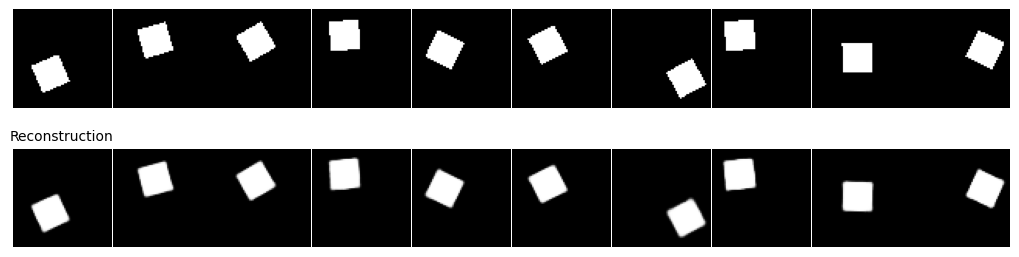

Plotting reconstructions from specific indices...


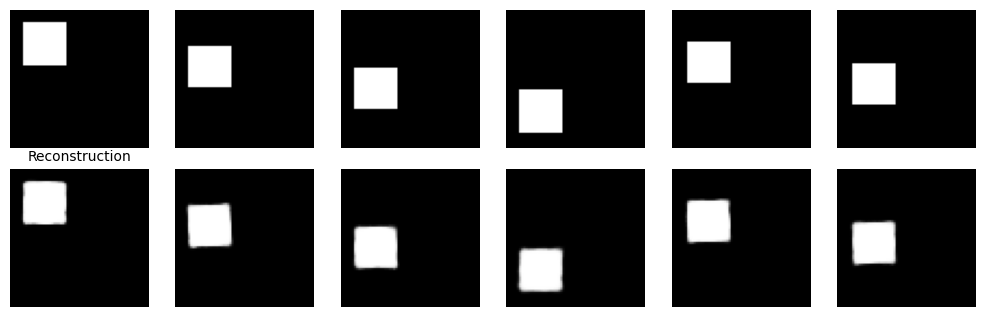

In [11]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 10, 20, 30, 40, 50]  # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


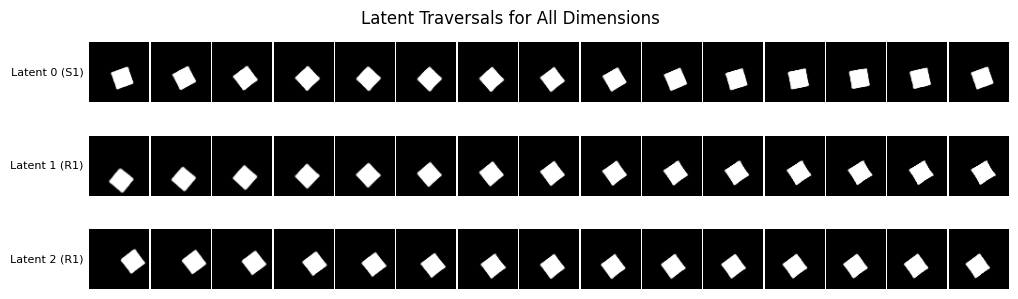

In [12]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1.0,
                                               use_ref_img=True
                                               )
plt.show()

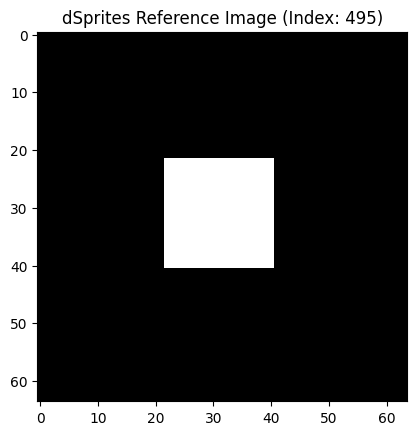

In [13]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 495  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()

Plotting single latent traversal for dimension 0...


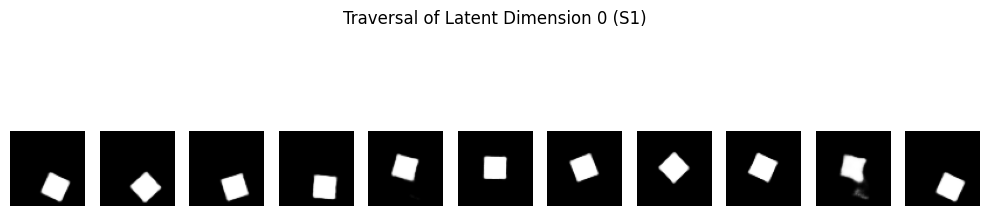

In [14]:
# Single latent traversal based on the reference image
latent_factor_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_factor_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_factor_idx_dsprites, 
                                                 ref_img=ref_img_dsprites, 
                                                 num_samples=11,
                                                 max_traversal_type='fraction',
                                                 max_traversal=1)
plt.show()

Plotting all latent traversals based on reference image...


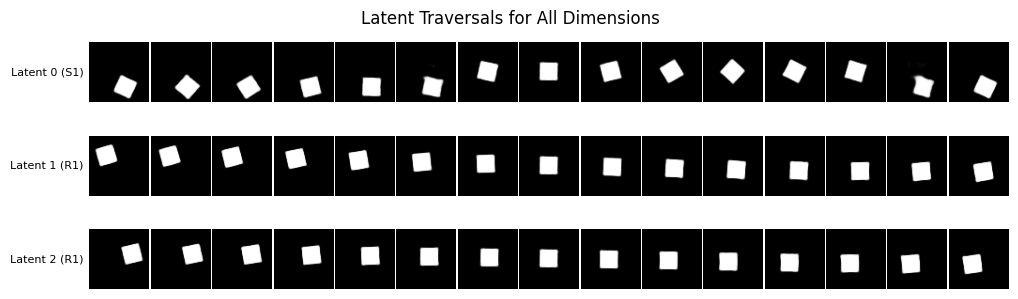

In [15]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, 
                                               num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1
                                               )